In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ResNet50)

2024-02-24 13:47:20.432723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 13:47:20.432823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 13:47:20.534229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ResNet50(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ResNet50"+s+".keras")
    

    # save model to disk
    filename = "ResNet50" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 4)                 23595908  


Total params: 23595908 (90.01 MB)


Trainable params: 23542788 (89.81 MB)


Non-trainable params: 53120 (207.50 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708782482.894108      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 1:23:33 - loss: 2.9299 - accuracy: 0.0312

  2/140 [..............................] - ETA: 19s - loss: 2.8557 - accuracy: 0.2031    

  3/140 [..............................] - ETA: 19s - loss: 4.4629 - accuracy: 0.2917

  4/140 [..............................] - ETA: 19s - loss: 4.1385 - accuracy: 0.3438

  5/140 [>.............................] - ETA: 19s - loss: 3.7822 - accuracy: 0.3938

  6/140 [>.............................] - ETA: 19s - loss: 3.6268 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 18s - loss: 3.4811 - accuracy: 0.4018

  8/140 [>.............................] - ETA: 18s - loss: 3.5959 - accuracy: 0.4023

  9/140 [>.............................] - ETA: 18s - loss: 3.3709 - accuracy: 0.4062

 10/140 [=>............................] - ETA: 18s - loss: 3.2430 - accuracy: 0.3969

 11/140 [=>............................] - ETA: 18s - loss: 3.0509 - accuracy: 0.3949

 12/140 [=>............................] - ETA: 18s - loss: 2.9887 - accuracy: 0.3828

 13/140 [=>............................] - ETA: 18s - loss: 2.8570 - accuracy: 0.3918

 14/140 [==>...........................] - ETA: 17s - loss: 2.7426 - accuracy: 0.4062

 15/140 [==>...........................] - ETA: 17s - loss: 2.6484 - accuracy: 0.4146

 16/140 [==>...........................] - ETA: 17s - loss: 2.5497 - accuracy: 0.4199

 17/140 [==>...........................] - ETA: 17s - loss: 2.4730 - accuracy: 0.4173

 18/140 [==>...........................] - ETA: 17s - loss: 2.3790 - accuracy: 0.4288

 19/140 [===>..........................] - ETA: 17s - loss: 2.3352 - accuracy: 0.4276

 20/140 [===>..........................] - ETA: 17s - loss: 2.2774 - accuracy: 0.4281

 21/140 [===>..........................] - ETA: 16s - loss: 2.2291 - accuracy: 0.4271

 22/140 [===>..........................] - ETA: 16s - loss: 2.1869 - accuracy: 0.4304

 23/140 [===>..........................] - ETA: 16s - loss: 2.1422 - accuracy: 0.4321

 24/140 [====>.........................] - ETA: 16s - loss: 2.1016 - accuracy: 0.4349

 25/140 [====>.........................] - ETA: 16s - loss: 2.0707 - accuracy: 0.4300

 26/140 [====>.........................] - ETA: 16s - loss: 2.0400 - accuracy: 0.4315

 27/140 [====>.........................] - ETA: 16s - loss: 2.0071 - accuracy: 0.4306

 28/140 [=====>........................] - ETA: 15s - loss: 1.9697 - accuracy: 0.4319

 29/140 [=====>........................] - ETA: 15s - loss: 1.9365 - accuracy: 0.4343

 30/140 [=====>........................] - ETA: 15s - loss: 1.9087 - accuracy: 0.4323

 31/140 [=====>........................] - ETA: 15s - loss: 1.8750 - accuracy: 0.4375

 32/140 [=====>........................] - ETA: 15s - loss: 1.8492 - accuracy: 0.4395

 33/140 [======>.......................] - ETA: 15s - loss: 1.8160 - accuracy: 0.4460

 34/140 [======>.......................] - ETA: 15s - loss: 1.7948 - accuracy: 0.4513

 35/140 [======>.......................] - ETA: 14s - loss: 1.7865 - accuracy: 0.4545

 36/140 [======>.......................] - ETA: 14s - loss: 1.7738 - accuracy: 0.4523

 37/140 [======>.......................] - ETA: 14s - loss: 1.7503 - accuracy: 0.4578

 38/140 [=======>......................] - ETA: 14s - loss: 1.7433 - accuracy: 0.4572

 39/140 [=======>......................] - ETA: 14s - loss: 1.7512 - accuracy: 0.4551

 40/140 [=======>......................] - ETA: 14s - loss: 1.7388 - accuracy: 0.4555

 41/140 [=======>......................] - ETA: 14s - loss: 1.7175 - accuracy: 0.4588

 42/140 [========>.....................] - ETA: 13s - loss: 1.7054 - accuracy: 0.4576

 43/140 [========>.....................] - ETA: 13s - loss: 1.6986 - accuracy: 0.4564

 44/140 [========>.....................] - ETA: 13s - loss: 1.6761 - accuracy: 0.4602

 45/140 [========>.....................] - ETA: 13s - loss: 1.6850 - accuracy: 0.4576

 46/140 [========>.....................] - ETA: 13s - loss: 1.6751 - accuracy: 0.4606

 47/140 [=========>....................] - ETA: 13s - loss: 1.6571 - accuracy: 0.4634

 48/140 [=========>....................] - ETA: 13s - loss: 1.6394 - accuracy: 0.4694

 49/140 [=========>....................] - ETA: 12s - loss: 1.6273 - accuracy: 0.4719

 50/140 [=========>....................] - ETA: 12s - loss: 1.6174 - accuracy: 0.4744

 51/140 [=========>....................] - ETA: 12s - loss: 1.6033 - accuracy: 0.4767

 52/140 [==========>...................] - ETA: 12s - loss: 1.5885 - accuracy: 0.4790

 53/140 [==========>...................] - ETA: 12s - loss: 1.5711 - accuracy: 0.4847

 54/140 [==========>...................] - ETA: 12s - loss: 1.5623 - accuracy: 0.4844

 55/140 [==========>...................] - ETA: 12s - loss: 1.5529 - accuracy: 0.4858

 56/140 [===========>..................] - ETA: 11s - loss: 1.5408 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 11s - loss: 1.5297 - accuracy: 0.4923

 58/140 [===========>..................] - ETA: 11s - loss: 1.5178 - accuracy: 0.4935

 59/140 [===========>..................] - ETA: 11s - loss: 1.5121 - accuracy: 0.4936

 60/140 [===========>..................] - ETA: 11s - loss: 1.5095 - accuracy: 0.4932

 61/140 [============>.................] - ETA: 11s - loss: 1.5008 - accuracy: 0.4939

 62/140 [============>.................] - ETA: 11s - loss: 1.4916 - accuracy: 0.4945

 63/140 [============>.................] - ETA: 10s - loss: 1.4834 - accuracy: 0.4955

 64/140 [============>.................] - ETA: 10s - loss: 1.4723 - accuracy: 0.4971

 65/140 [============>.................] - ETA: 10s - loss: 1.4725 - accuracy: 0.4986

 66/140 [=============>................] - ETA: 10s - loss: 1.4618 - accuracy: 0.5028

 67/140 [=============>................] - ETA: 10s - loss: 1.4550 - accuracy: 0.5042

 68/140 [=============>................] - ETA: 10s - loss: 1.4625 - accuracy: 0.5051

 69/140 [=============>................] - ETA: 10s - loss: 1.4573 - accuracy: 0.5054

 70/140 [==============>...............] - ETA: 9s - loss: 1.4593 - accuracy: 0.5045 

 71/140 [==============>...............] - ETA: 9s - loss: 1.4554 - accuracy: 0.5031

 72/140 [==============>...............] - ETA: 9s - loss: 1.4473 - accuracy: 0.5030

 73/140 [==============>...............] - ETA: 9s - loss: 1.4367 - accuracy: 0.5073

 74/140 [==============>...............] - ETA: 9s - loss: 1.4313 - accuracy: 0.5072

 75/140 [===============>..............] - ETA: 9s - loss: 1.4283 - accuracy: 0.5079

 76/140 [===============>..............] - ETA: 9s - loss: 1.4222 - accuracy: 0.5099

 77/140 [===============>..............] - ETA: 8s - loss: 1.4136 - accuracy: 0.5130

 78/140 [===============>..............] - ETA: 8s - loss: 1.4103 - accuracy: 0.5132

 79/140 [===============>..............] - ETA: 8s - loss: 1.4134 - accuracy: 0.5111

 80/140 [================>.............] - ETA: 8s - loss: 1.4083 - accuracy: 0.5121

 81/140 [================>.............] - ETA: 8s - loss: 1.4044 - accuracy: 0.5116

 82/140 [================>.............] - ETA: 8s - loss: 1.4003 - accuracy: 0.5107

 83/140 [================>.............] - ETA: 8s - loss: 1.3939 - accuracy: 0.5113

 84/140 [=================>............] - ETA: 7s - loss: 1.3907 - accuracy: 0.5119

 85/140 [=================>............] - ETA: 7s - loss: 1.3851 - accuracy: 0.5129

 86/140 [=================>............] - ETA: 7s - loss: 1.3785 - accuracy: 0.5145

 87/140 [=================>............] - ETA: 7s - loss: 1.3729 - accuracy: 0.5169

 88/140 [=================>............] - ETA: 7s - loss: 1.3684 - accuracy: 0.5181

 89/140 [==================>...........] - ETA: 7s - loss: 1.3668 - accuracy: 0.5179

 90/140 [==================>...........] - ETA: 7s - loss: 1.3609 - accuracy: 0.5188

 91/140 [==================>...........] - ETA: 6s - loss: 1.3537 - accuracy: 0.5203

 92/140 [==================>...........] - ETA: 6s - loss: 1.3485 - accuracy: 0.5214

 93/140 [==================>...........] - ETA: 6s - loss: 1.3400 - accuracy: 0.5252

 94/140 [===================>..........] - ETA: 6s - loss: 1.3354 - accuracy: 0.5266

 95/140 [===================>..........] - ETA: 6s - loss: 1.3305 - accuracy: 0.5280

 96/140 [===================>..........] - ETA: 6s - loss: 1.3246 - accuracy: 0.5296

 97/140 [===================>..........] - ETA: 6s - loss: 1.3198 - accuracy: 0.5306

 98/140 [====================>.........] - ETA: 5s - loss: 1.3155 - accuracy: 0.5316

 99/140 [====================>.........] - ETA: 5s - loss: 1.3109 - accuracy: 0.5319

100/140 [====================>.........] - ETA: 5s - loss: 1.3048 - accuracy: 0.5341

101/140 [====================>.........] - ETA: 5s - loss: 1.2987 - accuracy: 0.5356

102/140 [====================>.........] - ETA: 5s - loss: 1.2930 - accuracy: 0.5368

103/140 [=====================>........] - ETA: 5s - loss: 1.2875 - accuracy: 0.5373

104/140 [=====================>........] - ETA: 5s - loss: 1.2828 - accuracy: 0.5388

105/140 [=====================>........] - ETA: 4s - loss: 1.2785 - accuracy: 0.5396

106/140 [=====================>........] - ETA: 4s - loss: 1.2740 - accuracy: 0.5407

107/140 [=====================>........] - ETA: 4s - loss: 1.2691 - accuracy: 0.5415

108/140 [======================>.......] - ETA: 4s - loss: 1.2644 - accuracy: 0.5428

109/140 [======================>.......] - ETA: 4s - loss: 1.2615 - accuracy: 0.5433

110/140 [======================>.......] - ETA: 4s - loss: 1.2590 - accuracy: 0.5443

111/140 [======================>.......] - ETA: 4s - loss: 1.2549 - accuracy: 0.5450

112/140 [=======================>......] - ETA: 3s - loss: 1.2500 - accuracy: 0.5460

113/140 [=======================>......] - ETA: 3s - loss: 1.2472 - accuracy: 0.5462

114/140 [=======================>......] - ETA: 3s - loss: 1.2426 - accuracy: 0.5471

115/140 [=======================>......] - ETA: 3s - loss: 1.2421 - accuracy: 0.5462

116/140 [=======================>......] - ETA: 3s - loss: 1.2382 - accuracy: 0.5477

117/140 [========================>.....] - ETA: 3s - loss: 1.2380 - accuracy: 0.5475

118/140 [========================>.....] - ETA: 3s - loss: 1.2330 - accuracy: 0.5490

119/140 [========================>.....] - ETA: 2s - loss: 1.2282 - accuracy: 0.5504

120/140 [========================>.....] - ETA: 2s - loss: 1.2265 - accuracy: 0.5505

121/140 [========================>.....] - ETA: 2s - loss: 1.2222 - accuracy: 0.5511

122/140 [=========================>....] - ETA: 2s - loss: 1.2178 - accuracy: 0.5530

123/140 [=========================>....] - ETA: 2s - loss: 1.2133 - accuracy: 0.5546

124/140 [=========================>....] - ETA: 2s - loss: 1.2109 - accuracy: 0.5557

125/140 [=========================>....] - ETA: 2s - loss: 1.2064 - accuracy: 0.5567

126/140 [==========================>...] - ETA: 1s - loss: 1.2023 - accuracy: 0.5583

127/140 [==========================>...] - ETA: 1s - loss: 1.1991 - accuracy: 0.5591

128/140 [==========================>...] - ETA: 1s - loss: 1.1957 - accuracy: 0.5593

129/140 [==========================>...] - ETA: 1s - loss: 1.1930 - accuracy: 0.5584

130/140 [==========================>...] - ETA: 1s - loss: 1.1903 - accuracy: 0.5594

131/140 [===========================>..] - ETA: 1s - loss: 1.1886 - accuracy: 0.5592

132/140 [===========================>..] - ETA: 1s - loss: 1.1859 - accuracy: 0.5601

133/140 [===========================>..] - ETA: 0s - loss: 1.1832 - accuracy: 0.5609

134/140 [===========================>..] - ETA: 0s - loss: 1.1791 - accuracy: 0.5620

135/140 [===========================>..] - ETA: 0s - loss: 1.1761 - accuracy: 0.5630

136/140 [============================>.] - ETA: 0s - loss: 1.1763 - accuracy: 0.5620

137/140 [============================>.] - ETA: 0s - loss: 1.1745 - accuracy: 0.5625

138/140 [============================>.] - ETA: 0s - loss: 1.1712 - accuracy: 0.5632

139/140 [============================>.] - ETA: 0s - loss: 1.1707 - accuracy: 0.5629

140/140 [==============================] - ETA: 0s - loss: 1.1699 - accuracy: 0.5631

140/140 [==============================] - 62s 188ms/step - loss: 1.1699 - accuracy: 0.5631 - val_loss: 2.0995 - val_accuracy: 0.5098


Epoch 2/30


  1/140 [..............................] - ETA: 44s - loss: 0.9803 - accuracy: 0.5000

  2/140 [..............................] - ETA: 19s - loss: 0.9821 - accuracy: 0.5156

  3/140 [..............................] - ETA: 19s - loss: 0.9222 - accuracy: 0.5729

  4/140 [..............................] - ETA: 19s - loss: 0.8430 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 19s - loss: 0.9591 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 19s - loss: 1.0325 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 18s - loss: 1.0799 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 18s - loss: 1.0950 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 18s - loss: 1.0744 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 18s - loss: 1.0478 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 18s - loss: 1.0403 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 18s - loss: 1.0557 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 18s - loss: 1.1034 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 17s - loss: 1.0781 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 17s - loss: 1.0806 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 17s - loss: 1.0620 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 17s - loss: 1.0446 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 17s - loss: 1.0388 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 17s - loss: 1.0321 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 17s - loss: 1.0207 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 16s - loss: 0.9948 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 16s - loss: 0.9911 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 16s - loss: 0.9680 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 16s - loss: 0.9584 - accuracy: 0.6003

 25/140 [====>.........................] - ETA: 16s - loss: 0.9611 - accuracy: 0.5962

 26/140 [====>.........................] - ETA: 16s - loss: 0.9465 - accuracy: 0.6010

 27/140 [====>.........................] - ETA: 16s - loss: 0.9324 - accuracy: 0.6100

 28/140 [=====>........................] - ETA: 15s - loss: 0.9226 - accuracy: 0.6138

 29/140 [=====>........................] - ETA: 15s - loss: 0.9258 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 15s - loss: 0.9238 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 15s - loss: 0.9300 - accuracy: 0.6169

 32/140 [=====>........................] - ETA: 15s - loss: 0.9202 - accuracy: 0.6191

 33/140 [======>.......................] - ETA: 15s - loss: 0.9181 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 15s - loss: 0.9181 - accuracy: 0.6176

 35/140 [======>.......................] - ETA: 14s - loss: 0.9092 - accuracy: 0.6205

 36/140 [======>.......................] - ETA: 14s - loss: 0.9063 - accuracy: 0.6207

 37/140 [======>.......................] - ETA: 14s - loss: 0.9037 - accuracy: 0.6199

 38/140 [=======>......................] - ETA: 14s - loss: 0.8947 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 14s - loss: 0.9047 - accuracy: 0.6202

 40/140 [=======>......................] - ETA: 14s - loss: 0.8955 - accuracy: 0.6250

 41/140 [=======>......................] - ETA: 14s - loss: 0.8868 - accuracy: 0.6280

 42/140 [========>.....................] - ETA: 13s - loss: 0.8904 - accuracy: 0.6265

 43/140 [========>.....................] - ETA: 13s - loss: 0.8864 - accuracy: 0.6265

 44/140 [========>.....................] - ETA: 13s - loss: 0.8770 - accuracy: 0.6300

 45/140 [========>.....................] - ETA: 13s - loss: 0.8746 - accuracy: 0.6313

 46/140 [========>.....................] - ETA: 13s - loss: 0.8692 - accuracy: 0.6338

 47/140 [=========>....................] - ETA: 13s - loss: 0.8695 - accuracy: 0.6336

 48/140 [=========>....................] - ETA: 13s - loss: 0.8670 - accuracy: 0.6354

 49/140 [=========>....................] - ETA: 12s - loss: 0.8643 - accuracy: 0.6365

 50/140 [=========>....................] - ETA: 12s - loss: 0.8606 - accuracy: 0.6381

 51/140 [=========>....................] - ETA: 12s - loss: 0.8643 - accuracy: 0.6366

 52/140 [==========>...................] - ETA: 12s - loss: 0.8630 - accuracy: 0.6370

 53/140 [==========>...................] - ETA: 12s - loss: 0.8570 - accuracy: 0.6386

 54/140 [==========>...................] - ETA: 12s - loss: 0.8524 - accuracy: 0.6395

 55/140 [==========>...................] - ETA: 12s - loss: 0.8489 - accuracy: 0.6409

 56/140 [===========>..................] - ETA: 11s - loss: 0.8457 - accuracy: 0.6412

 57/140 [===========>..................] - ETA: 11s - loss: 0.8449 - accuracy: 0.6420

 58/140 [===========>..................] - ETA: 11s - loss: 0.8400 - accuracy: 0.6444

 59/140 [===========>..................] - ETA: 11s - loss: 0.8381 - accuracy: 0.6451

 60/140 [===========>..................] - ETA: 11s - loss: 0.8316 - accuracy: 0.6474

 61/140 [============>.................] - ETA: 11s - loss: 0.8340 - accuracy: 0.6465

 62/140 [============>.................] - ETA: 11s - loss: 0.8348 - accuracy: 0.6467

 63/140 [============>.................] - ETA: 10s - loss: 0.8395 - accuracy: 0.6473

 64/140 [============>.................] - ETA: 10s - loss: 0.8346 - accuracy: 0.6494

 65/140 [============>.................] - ETA: 10s - loss: 0.8370 - accuracy: 0.6486

 66/140 [=============>................] - ETA: 10s - loss: 0.8349 - accuracy: 0.6487

 67/140 [=============>................] - ETA: 10s - loss: 0.8366 - accuracy: 0.6493

 68/140 [=============>................] - ETA: 10s - loss: 0.8425 - accuracy: 0.6475

 69/140 [=============>................] - ETA: 10s - loss: 0.8449 - accuracy: 0.6463

 70/140 [==============>...............] - ETA: 9s - loss: 0.8419 - accuracy: 0.6478 

 71/140 [==============>...............] - ETA: 9s - loss: 0.8361 - accuracy: 0.6510

 72/140 [==============>...............] - ETA: 9s - loss: 0.8341 - accuracy: 0.6523

 73/140 [==============>...............] - ETA: 9s - loss: 0.8374 - accuracy: 0.6537

 74/140 [==============>...............] - ETA: 9s - loss: 0.8388 - accuracy: 0.6546

 75/140 [===============>..............] - ETA: 9s - loss: 0.8513 - accuracy: 0.6517

 76/140 [===============>..............] - ETA: 9s - loss: 0.8477 - accuracy: 0.6538

 77/140 [===============>..............] - ETA: 8s - loss: 0.8443 - accuracy: 0.6562

 78/140 [===============>..............] - ETA: 8s - loss: 0.8450 - accuracy: 0.6558

 79/140 [===============>..............] - ETA: 8s - loss: 0.8444 - accuracy: 0.6559

 80/140 [================>.............] - ETA: 8s - loss: 0.8495 - accuracy: 0.6539

 81/140 [================>.............] - ETA: 8s - loss: 0.8463 - accuracy: 0.6551

 82/140 [================>.............] - ETA: 8s - loss: 0.8418 - accuracy: 0.6566

 83/140 [================>.............] - ETA: 8s - loss: 0.8375 - accuracy: 0.6578

 84/140 [=================>............] - ETA: 7s - loss: 0.8346 - accuracy: 0.6592

 85/140 [=================>............] - ETA: 7s - loss: 0.8354 - accuracy: 0.6585

 86/140 [=================>............] - ETA: 7s - loss: 0.8396 - accuracy: 0.6581

 87/140 [=================>............] - ETA: 7s - loss: 0.8396 - accuracy: 0.6573

 88/140 [=================>............] - ETA: 7s - loss: 0.8375 - accuracy: 0.6587

 89/140 [==================>...........] - ETA: 7s - loss: 0.8385 - accuracy: 0.6580

 90/140 [==================>...........] - ETA: 7s - loss: 0.8355 - accuracy: 0.6587

 91/140 [==================>...........] - ETA: 6s - loss: 0.8377 - accuracy: 0.6576

 92/140 [==================>...........] - ETA: 6s - loss: 0.8362 - accuracy: 0.6579

 93/140 [==================>...........] - ETA: 6s - loss: 0.8333 - accuracy: 0.6589

 94/140 [===================>..........] - ETA: 6s - loss: 0.8318 - accuracy: 0.6592

 95/140 [===================>..........] - ETA: 6s - loss: 0.8302 - accuracy: 0.6602

 96/140 [===================>..........] - ETA: 6s - loss: 0.8261 - accuracy: 0.6618

 97/140 [===================>..........] - ETA: 6s - loss: 0.8267 - accuracy: 0.6617

 98/140 [====================>.........] - ETA: 5s - loss: 0.8235 - accuracy: 0.6629

 99/140 [====================>.........] - ETA: 5s - loss: 0.8229 - accuracy: 0.6638

100/140 [====================>.........] - ETA: 5s - loss: 0.8253 - accuracy: 0.6631

101/140 [====================>.........] - ETA: 5s - loss: 0.8252 - accuracy: 0.6634

102/140 [====================>.........] - ETA: 5s - loss: 0.8240 - accuracy: 0.6639

103/140 [=====================>........] - ETA: 5s - loss: 0.8209 - accuracy: 0.6657

104/140 [=====================>........] - ETA: 5s - loss: 0.8172 - accuracy: 0.6671

105/140 [=====================>........] - ETA: 4s - loss: 0.8138 - accuracy: 0.6687

106/140 [=====================>........] - ETA: 4s - loss: 0.8114 - accuracy: 0.6692

107/140 [=====================>........] - ETA: 4s - loss: 0.8123 - accuracy: 0.6691

108/140 [======================>.......] - ETA: 4s - loss: 0.8126 - accuracy: 0.6696

109/140 [======================>.......] - ETA: 4s - loss: 0.8134 - accuracy: 0.6689

110/140 [======================>.......] - ETA: 4s - loss: 0.8134 - accuracy: 0.6685

111/140 [======================>.......] - ETA: 4s - loss: 0.8167 - accuracy: 0.6678

112/140 [=======================>......] - ETA: 3s - loss: 0.8131 - accuracy: 0.6696

113/140 [=======================>......] - ETA: 3s - loss: 0.8110 - accuracy: 0.6698

114/140 [=======================>......] - ETA: 3s - loss: 0.8112 - accuracy: 0.6700

115/140 [=======================>......] - ETA: 3s - loss: 0.8093 - accuracy: 0.6709

116/140 [=======================>......] - ETA: 3s - loss: 0.8097 - accuracy: 0.6700

117/140 [========================>.....] - ETA: 3s - loss: 0.8079 - accuracy: 0.6709

118/140 [========================>.....] - ETA: 3s - loss: 0.8041 - accuracy: 0.6727

119/140 [========================>.....] - ETA: 2s - loss: 0.8011 - accuracy: 0.6733

120/140 [========================>.....] - ETA: 2s - loss: 0.7977 - accuracy: 0.6750

121/140 [========================>.....] - ETA: 2s - loss: 0.7951 - accuracy: 0.6759

122/140 [=========================>....] - ETA: 2s - loss: 0.7997 - accuracy: 0.6749

123/140 [=========================>....] - ETA: 2s - loss: 0.7960 - accuracy: 0.6761

124/140 [=========================>....] - ETA: 2s - loss: 0.7931 - accuracy: 0.6779

125/140 [=========================>....] - ETA: 2s - loss: 0.7921 - accuracy: 0.6790

126/140 [==========================>...] - ETA: 1s - loss: 0.7910 - accuracy: 0.6791

127/140 [==========================>...] - ETA: 1s - loss: 0.7906 - accuracy: 0.6799

128/140 [==========================>...] - ETA: 1s - loss: 0.7907 - accuracy: 0.6802

129/140 [==========================>...] - ETA: 1s - loss: 0.7884 - accuracy: 0.6812

130/140 [==========================>...] - ETA: 1s - loss: 0.7907 - accuracy: 0.6800

131/140 [===========================>..] - ETA: 1s - loss: 0.7879 - accuracy: 0.6813

132/140 [===========================>..] - ETA: 1s - loss: 0.7859 - accuracy: 0.6821

133/140 [===========================>..] - ETA: 0s - loss: 0.7829 - accuracy: 0.6835

134/140 [===========================>..] - ETA: 0s - loss: 0.7847 - accuracy: 0.6842

135/140 [===========================>..] - ETA: 0s - loss: 0.7830 - accuracy: 0.6854

136/140 [============================>.] - ETA: 0s - loss: 0.7804 - accuracy: 0.6861

137/140 [============================>.] - ETA: 0s - loss: 0.7811 - accuracy: 0.6866

138/140 [============================>.] - ETA: 0s - loss: 0.7797 - accuracy: 0.6875

139/140 [============================>.] - ETA: 0s - loss: 0.7768 - accuracy: 0.6888

140/140 [==============================] - ETA: 0s - loss: 0.7769 - accuracy: 0.6890

140/140 [==============================] - 22s 155ms/step - loss: 0.7769 - accuracy: 0.6890 - val_loss: 1.3031 - val_accuracy: 0.4464


Epoch 3/30


  1/140 [..............................] - ETA: 43s - loss: 0.3872 - accuracy: 0.8125

  2/140 [..............................] - ETA: 19s - loss: 0.6807 - accuracy: 0.6875

  3/140 [..............................] - ETA: 19s - loss: 0.7935 - accuracy: 0.6875

  4/140 [..............................] - ETA: 19s - loss: 0.7518 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 19s - loss: 0.7176 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 18s - loss: 0.7487 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 18s - loss: 0.7929 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 18s - loss: 0.7857 - accuracy: 0.7070

  9/140 [>.............................] - ETA: 18s - loss: 0.7794 - accuracy: 0.7014

 10/140 [=>............................] - ETA: 18s - loss: 0.8122 - accuracy: 0.6875

 11/140 [=>............................] - ETA: 18s - loss: 0.8032 - accuracy: 0.6847

 12/140 [=>............................] - ETA: 18s - loss: 0.7893 - accuracy: 0.6797

 13/140 [=>............................] - ETA: 17s - loss: 0.7922 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 17s - loss: 0.7844 - accuracy: 0.6830

 15/140 [==>...........................] - ETA: 17s - loss: 0.7899 - accuracy: 0.6812

 16/140 [==>...........................] - ETA: 17s - loss: 0.7840 - accuracy: 0.6855

 17/140 [==>...........................] - ETA: 17s - loss: 0.7716 - accuracy: 0.6930

 18/140 [==>...........................] - ETA: 17s - loss: 0.7570 - accuracy: 0.6979

 19/140 [===>..........................] - ETA: 17s - loss: 0.7473 - accuracy: 0.7056

 20/140 [===>..........................] - ETA: 16s - loss: 0.7485 - accuracy: 0.6984

 21/140 [===>..........................] - ETA: 16s - loss: 0.7495 - accuracy: 0.6994

 22/140 [===>..........................] - ETA: 16s - loss: 0.7412 - accuracy: 0.7045

 23/140 [===>..........................] - ETA: 16s - loss: 0.7353 - accuracy: 0.7065

 24/140 [====>.........................] - ETA: 16s - loss: 0.7237 - accuracy: 0.7135

 25/140 [====>.........................] - ETA: 16s - loss: 0.7123 - accuracy: 0.7150

 26/140 [====>.........................] - ETA: 16s - loss: 0.7102 - accuracy: 0.7127

 27/140 [====>.........................] - ETA: 15s - loss: 0.7051 - accuracy: 0.7141

 28/140 [=====>........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.7132

 29/140 [=====>........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.7188

 30/140 [=====>........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.7188

 31/140 [=====>........................] - ETA: 15s - loss: 0.6832 - accuracy: 0.7198

 32/140 [=====>........................] - ETA: 15s - loss: 0.6769 - accuracy: 0.7236

 33/140 [======>.......................] - ETA: 15s - loss: 0.6742 - accuracy: 0.7263

 34/140 [======>.......................] - ETA: 15s - loss: 0.6618 - accuracy: 0.7316

 35/140 [======>.......................] - ETA: 14s - loss: 0.6606 - accuracy: 0.7321

 36/140 [======>.......................] - ETA: 14s - loss: 0.6594 - accuracy: 0.7344

 37/140 [======>.......................] - ETA: 14s - loss: 0.6565 - accuracy: 0.7365

 38/140 [=======>......................] - ETA: 14s - loss: 0.6523 - accuracy: 0.7360

 39/140 [=======>......................] - ETA: 14s - loss: 0.6466 - accuracy: 0.7388

 40/140 [=======>......................] - ETA: 14s - loss: 0.6414 - accuracy: 0.7391

 41/140 [=======>......................] - ETA: 14s - loss: 0.6469 - accuracy: 0.7378

 42/140 [========>.....................] - ETA: 13s - loss: 0.6493 - accuracy: 0.7351

 43/140 [========>.....................] - ETA: 13s - loss: 0.6510 - accuracy: 0.7340

 44/140 [========>.....................] - ETA: 13s - loss: 0.6431 - accuracy: 0.7379

 45/140 [========>.....................] - ETA: 13s - loss: 0.6454 - accuracy: 0.7375

 46/140 [========>.....................] - ETA: 13s - loss: 0.6393 - accuracy: 0.7405

 47/140 [=========>....................] - ETA: 13s - loss: 0.6380 - accuracy: 0.7407

 48/140 [=========>....................] - ETA: 13s - loss: 0.6375 - accuracy: 0.7396

 49/140 [=========>....................] - ETA: 12s - loss: 0.6325 - accuracy: 0.7423

 50/140 [=========>....................] - ETA: 12s - loss: 0.6279 - accuracy: 0.7431

 51/140 [=========>....................] - ETA: 12s - loss: 0.6249 - accuracy: 0.7445

 52/140 [==========>...................] - ETA: 12s - loss: 0.6299 - accuracy: 0.7422

 53/140 [==========>...................] - ETA: 12s - loss: 0.6284 - accuracy: 0.7441

 54/140 [==========>...................] - ETA: 12s - loss: 0.6238 - accuracy: 0.7459

 55/140 [==========>...................] - ETA: 12s - loss: 0.6262 - accuracy: 0.7460

 56/140 [===========>..................] - ETA: 11s - loss: 0.6236 - accuracy: 0.7467

 57/140 [===========>..................] - ETA: 11s - loss: 0.6188 - accuracy: 0.7489

 58/140 [===========>..................] - ETA: 11s - loss: 0.6122 - accuracy: 0.7527

 59/140 [===========>..................] - ETA: 11s - loss: 0.6141 - accuracy: 0.7516

 60/140 [===========>..................] - ETA: 11s - loss: 0.6124 - accuracy: 0.7526

 61/140 [============>.................] - ETA: 11s - loss: 0.6090 - accuracy: 0.7546

 62/140 [============>.................] - ETA: 11s - loss: 0.6084 - accuracy: 0.7550

 63/140 [============>.................] - ETA: 10s - loss: 0.6110 - accuracy: 0.7535

 64/140 [============>.................] - ETA: 10s - loss: 0.6112 - accuracy: 0.7524

 65/140 [============>.................] - ETA: 10s - loss: 0.6094 - accuracy: 0.7538

 66/140 [=============>................] - ETA: 10s - loss: 0.6060 - accuracy: 0.7552

 67/140 [=============>................] - ETA: 10s - loss: 0.6055 - accuracy: 0.7556

 68/140 [=============>................] - ETA: 10s - loss: 0.6004 - accuracy: 0.7583

 69/140 [=============>................] - ETA: 10s - loss: 0.5983 - accuracy: 0.7591

 70/140 [==============>...............] - ETA: 9s - loss: 0.5940 - accuracy: 0.7612 

 71/140 [==============>...............] - ETA: 9s - loss: 0.5932 - accuracy: 0.7606

 72/140 [==============>...............] - ETA: 9s - loss: 0.5906 - accuracy: 0.7622

 73/140 [==============>...............] - ETA: 9s - loss: 0.5859 - accuracy: 0.7641

 74/140 [==============>...............] - ETA: 9s - loss: 0.5847 - accuracy: 0.7656

 75/140 [===============>..............] - ETA: 9s - loss: 0.5815 - accuracy: 0.7675

 76/140 [===============>..............] - ETA: 9s - loss: 0.5786 - accuracy: 0.7685

 77/140 [===============>..............] - ETA: 8s - loss: 0.5789 - accuracy: 0.7683

 78/140 [===============>..............] - ETA: 8s - loss: 0.5787 - accuracy: 0.7688

 79/140 [===============>..............] - ETA: 8s - loss: 0.5760 - accuracy: 0.7690

 80/140 [================>.............] - ETA: 8s - loss: 0.5725 - accuracy: 0.7703

 81/140 [================>.............] - ETA: 8s - loss: 0.5736 - accuracy: 0.7693

 82/140 [================>.............] - ETA: 8s - loss: 0.5758 - accuracy: 0.7679

 83/140 [================>.............] - ETA: 8s - loss: 0.5726 - accuracy: 0.7692

 84/140 [=================>............] - ETA: 7s - loss: 0.5758 - accuracy: 0.7686

 85/140 [=================>............] - ETA: 7s - loss: 0.5733 - accuracy: 0.7699

 86/140 [=================>............] - ETA: 7s - loss: 0.5724 - accuracy: 0.7711

 87/140 [=================>............] - ETA: 7s - loss: 0.5693 - accuracy: 0.7726

 88/140 [=================>............] - ETA: 7s - loss: 0.5700 - accuracy: 0.7720

 89/140 [==================>...........] - ETA: 7s - loss: 0.5680 - accuracy: 0.7721

 90/140 [==================>...........] - ETA: 7s - loss: 0.5670 - accuracy: 0.7722

 91/140 [==================>...........] - ETA: 6s - loss: 0.5694 - accuracy: 0.7709

 92/140 [==================>...........] - ETA: 6s - loss: 0.5706 - accuracy: 0.7707

 93/140 [==================>...........] - ETA: 6s - loss: 0.5697 - accuracy: 0.7705

 94/140 [===================>..........] - ETA: 6s - loss: 0.5669 - accuracy: 0.7719

 95/140 [===================>..........] - ETA: 6s - loss: 0.5675 - accuracy: 0.7717

 96/140 [===================>..........] - ETA: 6s - loss: 0.5710 - accuracy: 0.7708

 97/140 [===================>..........] - ETA: 6s - loss: 0.5699 - accuracy: 0.7719

 98/140 [====================>.........] - ETA: 5s - loss: 0.5689 - accuracy: 0.7723

 99/140 [====================>.........] - ETA: 5s - loss: 0.5691 - accuracy: 0.7718

100/140 [====================>.........] - ETA: 5s - loss: 0.5662 - accuracy: 0.7731

101/140 [====================>.........] - ETA: 5s - loss: 0.5664 - accuracy: 0.7729

102/140 [====================>.........] - ETA: 5s - loss: 0.5648 - accuracy: 0.7742

103/140 [=====================>........] - ETA: 5s - loss: 0.5648 - accuracy: 0.7755

104/140 [=====================>........] - ETA: 5s - loss: 0.5634 - accuracy: 0.7758

105/140 [=====================>........] - ETA: 4s - loss: 0.5616 - accuracy: 0.7765

106/140 [=====================>........] - ETA: 4s - loss: 0.5615 - accuracy: 0.7768

107/140 [=====================>........] - ETA: 4s - loss: 0.5587 - accuracy: 0.7777

108/140 [======================>.......] - ETA: 4s - loss: 0.5637 - accuracy: 0.7769

109/140 [======================>.......] - ETA: 4s - loss: 0.5638 - accuracy: 0.7772

110/140 [======================>.......] - ETA: 4s - loss: 0.5614 - accuracy: 0.7790

111/140 [======================>.......] - ETA: 4s - loss: 0.5631 - accuracy: 0.7787

112/140 [=======================>......] - ETA: 3s - loss: 0.5618 - accuracy: 0.7790

113/140 [=======================>......] - ETA: 3s - loss: 0.5592 - accuracy: 0.7793

114/140 [=======================>......] - ETA: 3s - loss: 0.5571 - accuracy: 0.7802

115/140 [=======================>......] - ETA: 3s - loss: 0.5557 - accuracy: 0.7810

116/140 [=======================>......] - ETA: 3s - loss: 0.5559 - accuracy: 0.7807

117/140 [========================>.....] - ETA: 3s - loss: 0.5571 - accuracy: 0.7802

118/140 [========================>.....] - ETA: 3s - loss: 0.5561 - accuracy: 0.7812

119/140 [========================>.....] - ETA: 2s - loss: 0.5552 - accuracy: 0.7815

120/140 [========================>.....] - ETA: 2s - loss: 0.5564 - accuracy: 0.7805

121/140 [========================>.....] - ETA: 2s - loss: 0.5560 - accuracy: 0.7810

122/140 [=========================>....] - ETA: 2s - loss: 0.5546 - accuracy: 0.7812

123/140 [=========================>....] - ETA: 2s - loss: 0.5539 - accuracy: 0.7812

124/140 [=========================>....] - ETA: 2s - loss: 0.5534 - accuracy: 0.7810

125/140 [=========================>....] - ETA: 2s - loss: 0.5537 - accuracy: 0.7800

126/140 [==========================>...] - ETA: 1s - loss: 0.5532 - accuracy: 0.7800

127/140 [==========================>...] - ETA: 1s - loss: 0.5516 - accuracy: 0.7803

128/140 [==========================>...] - ETA: 1s - loss: 0.5501 - accuracy: 0.7805

129/140 [==========================>...] - ETA: 1s - loss: 0.5492 - accuracy: 0.7810

130/140 [==========================>...] - ETA: 1s - loss: 0.5469 - accuracy: 0.7815

131/140 [===========================>..] - ETA: 1s - loss: 0.5448 - accuracy: 0.7822

132/140 [===========================>..] - ETA: 1s - loss: 0.5446 - accuracy: 0.7817

133/140 [===========================>..] - ETA: 0s - loss: 0.5421 - accuracy: 0.7829

134/140 [===========================>..] - ETA: 0s - loss: 0.5414 - accuracy: 0.7831

135/140 [===========================>..] - ETA: 0s - loss: 0.5396 - accuracy: 0.7836

136/140 [============================>.] - ETA: 0s - loss: 0.5407 - accuracy: 0.7829

137/140 [============================>.] - ETA: 0s - loss: 0.5398 - accuracy: 0.7828

138/140 [============================>.] - ETA: 0s - loss: 0.5368 - accuracy: 0.7840

139/140 [============================>.] - ETA: 0s - loss: 0.5361 - accuracy: 0.7844

140/140 [==============================] - ETA: 0s - loss: 0.5365 - accuracy: 0.7841

140/140 [==============================] - 22s 154ms/step - loss: 0.5365 - accuracy: 0.7841 - val_loss: 1.2224 - val_accuracy: 0.5278


Epoch 4/30


  1/140 [..............................] - ETA: 43s - loss: 0.2217 - accuracy: 0.9688

  2/140 [..............................] - ETA: 19s - loss: 0.3955 - accuracy: 0.8750

  3/140 [..............................] - ETA: 19s - loss: 0.4196 - accuracy: 0.8750

  4/140 [..............................] - ETA: 19s - loss: 0.5001 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 19s - loss: 0.4919 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 18s - loss: 0.4833 - accuracy: 0.8281

  7/140 [>.............................] - ETA: 18s - loss: 0.4620 - accuracy: 0.8304

  8/140 [>.............................] - ETA: 18s - loss: 0.4448 - accuracy: 0.8320

  9/140 [>.............................] - ETA: 18s - loss: 0.4629 - accuracy: 0.8229

 10/140 [=>............................] - ETA: 18s - loss: 0.4984 - accuracy: 0.8188

 11/140 [=>............................] - ETA: 18s - loss: 0.5165 - accuracy: 0.8153

 12/140 [=>............................] - ETA: 18s - loss: 0.5265 - accuracy: 0.8125

 13/140 [=>............................] - ETA: 17s - loss: 0.5354 - accuracy: 0.8029

 14/140 [==>...........................] - ETA: 17s - loss: 0.5217 - accuracy: 0.8103

 15/140 [==>...........................] - ETA: 17s - loss: 0.5154 - accuracy: 0.8104

 16/140 [==>...........................] - ETA: 17s - loss: 0.5072 - accuracy: 0.8105

 17/140 [==>...........................] - ETA: 17s - loss: 0.5059 - accuracy: 0.8051

 18/140 [==>...........................] - ETA: 17s - loss: 0.4988 - accuracy: 0.8021

 19/140 [===>..........................] - ETA: 17s - loss: 0.4955 - accuracy: 0.7993

 20/140 [===>..........................] - ETA: 16s - loss: 0.4965 - accuracy: 0.8000

 21/140 [===>..........................] - ETA: 16s - loss: 0.4937 - accuracy: 0.7991

 22/140 [===>..........................] - ETA: 16s - loss: 0.4927 - accuracy: 0.8026

 23/140 [===>..........................] - ETA: 16s - loss: 0.4847 - accuracy: 0.8057

 24/140 [====>.........................] - ETA: 16s - loss: 0.4799 - accuracy: 0.8086

 25/140 [====>.........................] - ETA: 16s - loss: 0.4724 - accuracy: 0.8112

 26/140 [====>.........................] - ETA: 16s - loss: 0.4596 - accuracy: 0.8185

 27/140 [====>.........................] - ETA: 16s - loss: 0.4607 - accuracy: 0.8206

 28/140 [=====>........................] - ETA: 15s - loss: 0.4662 - accuracy: 0.8181

 29/140 [=====>........................] - ETA: 15s - loss: 0.4659 - accuracy: 0.8190

 30/140 [=====>........................] - ETA: 15s - loss: 0.4807 - accuracy: 0.8177

 31/140 [=====>........................] - ETA: 15s - loss: 0.4924 - accuracy: 0.8145

 32/140 [=====>........................] - ETA: 15s - loss: 0.4876 - accuracy: 0.8154

 33/140 [======>.......................] - ETA: 15s - loss: 0.4921 - accuracy: 0.8163

 34/140 [======>.......................] - ETA: 15s - loss: 0.4913 - accuracy: 0.8171

 35/140 [======>.......................] - ETA: 14s - loss: 0.4912 - accuracy: 0.8161

 36/140 [======>.......................] - ETA: 14s - loss: 0.4876 - accuracy: 0.8160

 37/140 [======>.......................] - ETA: 14s - loss: 0.4860 - accuracy: 0.8142

 38/140 [=======>......................] - ETA: 14s - loss: 0.4890 - accuracy: 0.8141

 39/140 [=======>......................] - ETA: 14s - loss: 0.4819 - accuracy: 0.8165

 40/140 [=======>......................] - ETA: 14s - loss: 0.4741 - accuracy: 0.8195

 41/140 [=======>......................] - ETA: 14s - loss: 0.4688 - accuracy: 0.8209

 42/140 [========>.....................] - ETA: 13s - loss: 0.4623 - accuracy: 0.8237

 43/140 [========>.....................] - ETA: 13s - loss: 0.4657 - accuracy: 0.8241

 44/140 [========>.....................] - ETA: 13s - loss: 0.4655 - accuracy: 0.8246

 45/140 [========>.....................] - ETA: 13s - loss: 0.4633 - accuracy: 0.8243

 46/140 [========>.....................] - ETA: 13s - loss: 0.4646 - accuracy: 0.8254

 47/140 [=========>....................] - ETA: 13s - loss: 0.4572 - accuracy: 0.8285

 48/140 [=========>....................] - ETA: 13s - loss: 0.4564 - accuracy: 0.8268

 49/140 [=========>....................] - ETA: 12s - loss: 0.4551 - accuracy: 0.8272

 50/140 [=========>....................] - ETA: 12s - loss: 0.4494 - accuracy: 0.8294

 51/140 [=========>....................] - ETA: 12s - loss: 0.4429 - accuracy: 0.8315

 52/140 [==========>...................] - ETA: 12s - loss: 0.4381 - accuracy: 0.8335

 53/140 [==========>...................] - ETA: 12s - loss: 0.4334 - accuracy: 0.8349

 54/140 [==========>...................] - ETA: 12s - loss: 0.4299 - accuracy: 0.8368

 55/140 [==========>...................] - ETA: 12s - loss: 0.4271 - accuracy: 0.8381

 56/140 [===========>..................] - ETA: 11s - loss: 0.4247 - accuracy: 0.8382

 57/140 [===========>..................] - ETA: 11s - loss: 0.4235 - accuracy: 0.8383

 58/140 [===========>..................] - ETA: 11s - loss: 0.4188 - accuracy: 0.8400

 59/140 [===========>..................] - ETA: 11s - loss: 0.4155 - accuracy: 0.8416

 60/140 [===========>..................] - ETA: 11s - loss: 0.4116 - accuracy: 0.8427

 61/140 [============>.................] - ETA: 11s - loss: 0.4091 - accuracy: 0.8443

 62/140 [============>.................] - ETA: 11s - loss: 0.4077 - accuracy: 0.8453

 63/140 [============>.................] - ETA: 10s - loss: 0.4102 - accuracy: 0.8452

 64/140 [============>.................] - ETA: 10s - loss: 0.4077 - accuracy: 0.8462

 65/140 [============>.................] - ETA: 10s - loss: 0.4053 - accuracy: 0.8471

 66/140 [=============>................] - ETA: 10s - loss: 0.4036 - accuracy: 0.8471

 67/140 [=============>................] - ETA: 10s - loss: 0.4022 - accuracy: 0.8470

 68/140 [=============>................] - ETA: 10s - loss: 0.4007 - accuracy: 0.8479

 69/140 [=============>................] - ETA: 10s - loss: 0.4006 - accuracy: 0.8474

 70/140 [==============>...............] - ETA: 9s - loss: 0.3985 - accuracy: 0.8482 

 71/140 [==============>...............] - ETA: 9s - loss: 0.4005 - accuracy: 0.8482

 72/140 [==============>...............] - ETA: 9s - loss: 0.3999 - accuracy: 0.8481

 73/140 [==============>...............] - ETA: 9s - loss: 0.3983 - accuracy: 0.8497

 74/140 [==============>...............] - ETA: 9s - loss: 0.3986 - accuracy: 0.8501

 75/140 [===============>..............] - ETA: 9s - loss: 0.3983 - accuracy: 0.8500

 76/140 [===============>..............] - ETA: 9s - loss: 0.3957 - accuracy: 0.8512

 77/140 [===============>..............] - ETA: 8s - loss: 0.3942 - accuracy: 0.8515

 78/140 [===============>..............] - ETA: 8s - loss: 0.3951 - accuracy: 0.8510

 79/140 [===============>..............] - ETA: 8s - loss: 0.3921 - accuracy: 0.8521

 80/140 [================>.............] - ETA: 8s - loss: 0.3882 - accuracy: 0.8539

 81/140 [================>.............] - ETA: 8s - loss: 0.3873 - accuracy: 0.8542

 82/140 [================>.............] - ETA: 8s - loss: 0.3883 - accuracy: 0.8533

 83/140 [================>.............] - ETA: 8s - loss: 0.3893 - accuracy: 0.8517

 84/140 [=================>............] - ETA: 7s - loss: 0.3882 - accuracy: 0.8519

 85/140 [=================>............] - ETA: 7s - loss: 0.3850 - accuracy: 0.8533

 86/140 [=================>............] - ETA: 7s - loss: 0.3824 - accuracy: 0.8539

 87/140 [=================>............] - ETA: 7s - loss: 0.3842 - accuracy: 0.8524

 88/140 [=================>............] - ETA: 7s - loss: 0.3820 - accuracy: 0.8533

 89/140 [==================>...........] - ETA: 7s - loss: 0.3827 - accuracy: 0.8536

 90/140 [==================>...........] - ETA: 7s - loss: 0.3834 - accuracy: 0.8528

 91/140 [==================>...........] - ETA: 6s - loss: 0.3819 - accuracy: 0.8530

 92/140 [==================>...........] - ETA: 6s - loss: 0.3822 - accuracy: 0.8533

 93/140 [==================>...........] - ETA: 6s - loss: 0.3846 - accuracy: 0.8535

 94/140 [===================>..........] - ETA: 6s - loss: 0.3817 - accuracy: 0.8547

 95/140 [===================>..........] - ETA: 6s - loss: 0.3803 - accuracy: 0.8553

 96/140 [===================>..........] - ETA: 6s - loss: 0.3803 - accuracy: 0.8558

 97/140 [===================>..........] - ETA: 6s - loss: 0.3788 - accuracy: 0.8566

 98/140 [====================>.........] - ETA: 5s - loss: 0.3797 - accuracy: 0.8568

 99/140 [====================>.........] - ETA: 5s - loss: 0.3801 - accuracy: 0.8564

100/140 [====================>.........] - ETA: 5s - loss: 0.3795 - accuracy: 0.8566

101/140 [====================>.........] - ETA: 5s - loss: 0.3811 - accuracy: 0.8558

102/140 [====================>.........] - ETA: 5s - loss: 0.3800 - accuracy: 0.8560

103/140 [=====================>........] - ETA: 5s - loss: 0.3792 - accuracy: 0.8562

104/140 [=====================>........] - ETA: 5s - loss: 0.3792 - accuracy: 0.8558

105/140 [=====================>........] - ETA: 4s - loss: 0.3777 - accuracy: 0.8565

106/140 [=====================>........] - ETA: 4s - loss: 0.3779 - accuracy: 0.8558

107/140 [=====================>........] - ETA: 4s - loss: 0.3798 - accuracy: 0.8548

108/140 [======================>.......] - ETA: 4s - loss: 0.3812 - accuracy: 0.8545

109/140 [======================>.......] - ETA: 4s - loss: 0.3794 - accuracy: 0.8549

110/140 [======================>.......] - ETA: 4s - loss: 0.3818 - accuracy: 0.8543

111/140 [======================>.......] - ETA: 4s - loss: 0.3821 - accuracy: 0.8542

112/140 [=======================>......] - ETA: 3s - loss: 0.3813 - accuracy: 0.8546

113/140 [=======================>......] - ETA: 3s - loss: 0.3817 - accuracy: 0.8548

114/140 [=======================>......] - ETA: 3s - loss: 0.3812 - accuracy: 0.8550

115/140 [=======================>......] - ETA: 3s - loss: 0.3803 - accuracy: 0.8554

116/140 [=======================>......] - ETA: 3s - loss: 0.3799 - accuracy: 0.8559

117/140 [========================>.....] - ETA: 3s - loss: 0.3787 - accuracy: 0.8563

118/140 [========================>.....] - ETA: 3s - loss: 0.3822 - accuracy: 0.8554

119/140 [========================>.....] - ETA: 2s - loss: 0.3804 - accuracy: 0.8564

120/140 [========================>.....] - ETA: 2s - loss: 0.3804 - accuracy: 0.8562

121/140 [========================>.....] - ETA: 2s - loss: 0.3808 - accuracy: 0.8561

122/140 [=========================>....] - ETA: 2s - loss: 0.3805 - accuracy: 0.8568

123/140 [=========================>....] - ETA: 2s - loss: 0.3803 - accuracy: 0.8567

124/140 [=========================>....] - ETA: 2s - loss: 0.3786 - accuracy: 0.8571

125/140 [=========================>....] - ETA: 2s - loss: 0.3776 - accuracy: 0.8580

126/140 [==========================>...] - ETA: 1s - loss: 0.3776 - accuracy: 0.8579

127/140 [==========================>...] - ETA: 1s - loss: 0.3778 - accuracy: 0.8575

128/140 [==========================>...] - ETA: 1s - loss: 0.3756 - accuracy: 0.8584

129/140 [==========================>...] - ETA: 1s - loss: 0.3756 - accuracy: 0.8585

130/140 [==========================>...] - ETA: 1s - loss: 0.3757 - accuracy: 0.8584

131/140 [===========================>..] - ETA: 1s - loss: 0.3760 - accuracy: 0.8581

132/140 [===========================>..] - ETA: 1s - loss: 0.3755 - accuracy: 0.8584

133/140 [===========================>..] - ETA: 0s - loss: 0.3760 - accuracy: 0.8590

134/140 [===========================>..] - ETA: 0s - loss: 0.3745 - accuracy: 0.8591

135/140 [===========================>..] - ETA: 0s - loss: 0.3733 - accuracy: 0.8597

136/140 [============================>.] - ETA: 0s - loss: 0.3722 - accuracy: 0.8601

137/140 [============================>.] - ETA: 0s - loss: 0.3758 - accuracy: 0.8597

138/140 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8601

139/140 [============================>.] - ETA: 0s - loss: 0.3745 - accuracy: 0.8608

140/140 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8611

140/140 [==============================] - 22s 154ms/step - loss: 0.3740 - accuracy: 0.8611 - val_loss: 2.0828 - val_accuracy: 0.5606


Epoch 5/30


  1/140 [..............................] - ETA: 41s - loss: 0.3212 - accuracy: 0.8125

  2/140 [..............................] - ETA: 19s - loss: 0.2319 - accuracy: 0.8750

  3/140 [..............................] - ETA: 19s - loss: 0.2473 - accuracy: 0.8542

  4/140 [..............................] - ETA: 19s - loss: 0.2611 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 19s - loss: 0.3006 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 19s - loss: 0.3034 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 18s - loss: 0.3085 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 18s - loss: 0.3006 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 18s - loss: 0.3226 - accuracy: 0.8715

 10/140 [=>............................] - ETA: 18s - loss: 0.2994 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 18s - loss: 0.2901 - accuracy: 0.8920

 12/140 [=>............................] - ETA: 18s - loss: 0.2802 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 18s - loss: 0.2666 - accuracy: 0.9038

 14/140 [==>...........................] - ETA: 17s - loss: 0.2751 - accuracy: 0.9018

 15/140 [==>...........................] - ETA: 17s - loss: 0.2661 - accuracy: 0.9062

 16/140 [==>...........................] - ETA: 17s - loss: 0.2686 - accuracy: 0.9062

 17/140 [==>...........................] - ETA: 17s - loss: 0.2629 - accuracy: 0.9099

 18/140 [==>...........................] - ETA: 17s - loss: 0.2649 - accuracy: 0.9097

 19/140 [===>..........................] - ETA: 17s - loss: 0.2752 - accuracy: 0.9079

 20/140 [===>..........................] - ETA: 17s - loss: 0.2776 - accuracy: 0.9078

 21/140 [===>..........................] - ETA: 16s - loss: 0.2777 - accuracy: 0.9062

 22/140 [===>..........................] - ETA: 16s - loss: 0.2801 - accuracy: 0.9034

 23/140 [===>..........................] - ETA: 16s - loss: 0.2940 - accuracy: 0.8967

 24/140 [====>.........................] - ETA: 16s - loss: 0.2984 - accuracy: 0.8919

 25/140 [====>.........................] - ETA: 16s - loss: 0.2986 - accuracy: 0.8938

 26/140 [====>.........................] - ETA: 16s - loss: 0.2932 - accuracy: 0.8954

 27/140 [====>.........................] - ETA: 16s - loss: 0.2957 - accuracy: 0.8958

 28/140 [=====>........................] - ETA: 15s - loss: 0.2988 - accuracy: 0.8951

 29/140 [=====>........................] - ETA: 15s - loss: 0.2995 - accuracy: 0.8933

 30/140 [=====>........................] - ETA: 15s - loss: 0.2989 - accuracy: 0.8927

 31/140 [=====>........................] - ETA: 15s - loss: 0.2933 - accuracy: 0.8942

 32/140 [=====>........................] - ETA: 15s - loss: 0.2874 - accuracy: 0.8965

 33/140 [======>.......................] - ETA: 15s - loss: 0.2853 - accuracy: 0.8968

 34/140 [======>.......................] - ETA: 15s - loss: 0.2854 - accuracy: 0.8980

 35/140 [======>.......................] - ETA: 14s - loss: 0.2855 - accuracy: 0.8973

 36/140 [======>.......................] - ETA: 14s - loss: 0.2865 - accuracy: 0.8984

 37/140 [======>.......................] - ETA: 14s - loss: 0.2816 - accuracy: 0.9012

 38/140 [=======>......................] - ETA: 14s - loss: 0.2795 - accuracy: 0.9030

 39/140 [=======>......................] - ETA: 14s - loss: 0.2814 - accuracy: 0.9006

 40/140 [=======>......................] - ETA: 14s - loss: 0.2784 - accuracy: 0.9016

 41/140 [=======>......................] - ETA: 14s - loss: 0.2749 - accuracy: 0.9032

 42/140 [========>.....................] - ETA: 13s - loss: 0.2734 - accuracy: 0.9040

 43/140 [========>.....................] - ETA: 13s - loss: 0.2699 - accuracy: 0.9055

 44/140 [========>.....................] - ETA: 13s - loss: 0.2681 - accuracy: 0.9055

 45/140 [========>.....................] - ETA: 13s - loss: 0.2653 - accuracy: 0.9069

 46/140 [========>.....................] - ETA: 13s - loss: 0.2626 - accuracy: 0.9076

 47/140 [=========>....................] - ETA: 13s - loss: 0.2642 - accuracy: 0.9076

 48/140 [=========>....................] - ETA: 13s - loss: 0.2606 - accuracy: 0.9082

 49/140 [=========>....................] - ETA: 12s - loss: 0.2609 - accuracy: 0.9094

 50/140 [=========>....................] - ETA: 12s - loss: 0.2595 - accuracy: 0.9100

 51/140 [=========>....................] - ETA: 12s - loss: 0.2582 - accuracy: 0.9105

 52/140 [==========>...................] - ETA: 12s - loss: 0.2577 - accuracy: 0.9105

 53/140 [==========>...................] - ETA: 12s - loss: 0.2566 - accuracy: 0.9110

 54/140 [==========>...................] - ETA: 12s - loss: 0.2535 - accuracy: 0.9126

 55/140 [==========>...................] - ETA: 12s - loss: 0.2528 - accuracy: 0.9119

 56/140 [===========>..................] - ETA: 11s - loss: 0.2525 - accuracy: 0.9124

 57/140 [===========>..................] - ETA: 11s - loss: 0.2537 - accuracy: 0.9123

 58/140 [===========>..................] - ETA: 11s - loss: 0.2533 - accuracy: 0.9127

 59/140 [===========>..................] - ETA: 11s - loss: 0.2515 - accuracy: 0.9131

 60/140 [===========>..................] - ETA: 11s - loss: 0.2511 - accuracy: 0.9130

 61/140 [============>.................] - ETA: 11s - loss: 0.2505 - accuracy: 0.9129

 62/140 [============>.................] - ETA: 11s - loss: 0.2488 - accuracy: 0.9133

 63/140 [============>.................] - ETA: 10s - loss: 0.2473 - accuracy: 0.9142

 64/140 [============>.................] - ETA: 10s - loss: 0.2476 - accuracy: 0.9141

 65/140 [============>.................] - ETA: 10s - loss: 0.2531 - accuracy: 0.9115

 66/140 [=============>................] - ETA: 10s - loss: 0.2501 - accuracy: 0.9129

 67/140 [=============>................] - ETA: 10s - loss: 0.2506 - accuracy: 0.9118

 68/140 [=============>................] - ETA: 10s - loss: 0.2486 - accuracy: 0.9127

 69/140 [=============>................] - ETA: 10s - loss: 0.2500 - accuracy: 0.9121

 70/140 [==============>...............] - ETA: 9s - loss: 0.2499 - accuracy: 0.9121 

 71/140 [==============>...............] - ETA: 9s - loss: 0.2498 - accuracy: 0.9111

 72/140 [==============>...............] - ETA: 9s - loss: 0.2514 - accuracy: 0.9106

 73/140 [==============>...............] - ETA: 9s - loss: 0.2562 - accuracy: 0.9084

 74/140 [==============>...............] - ETA: 9s - loss: 0.2546 - accuracy: 0.9092

 75/140 [===============>..............] - ETA: 9s - loss: 0.2522 - accuracy: 0.9104

 76/140 [===============>..............] - ETA: 9s - loss: 0.2531 - accuracy: 0.9108

 77/140 [===============>..............] - ETA: 8s - loss: 0.2542 - accuracy: 0.9091

 78/140 [===============>..............] - ETA: 8s - loss: 0.2538 - accuracy: 0.9099

 79/140 [===============>..............] - ETA: 8s - loss: 0.2559 - accuracy: 0.9098

 80/140 [================>.............] - ETA: 8s - loss: 0.2563 - accuracy: 0.9098

 81/140 [================>.............] - ETA: 8s - loss: 0.2541 - accuracy: 0.9101

 82/140 [================>.............] - ETA: 8s - loss: 0.2516 - accuracy: 0.9112

 83/140 [================>.............] - ETA: 8s - loss: 0.2532 - accuracy: 0.9111

 84/140 [=================>............] - ETA: 7s - loss: 0.2521 - accuracy: 0.9118

 85/140 [=================>............] - ETA: 7s - loss: 0.2510 - accuracy: 0.9121

 86/140 [=================>............] - ETA: 7s - loss: 0.2515 - accuracy: 0.9121

 87/140 [=================>............] - ETA: 7s - loss: 0.2498 - accuracy: 0.9127

 88/140 [=================>............] - ETA: 7s - loss: 0.2486 - accuracy: 0.9134

 89/140 [==================>...........] - ETA: 7s - loss: 0.2481 - accuracy: 0.9133

 90/140 [==================>...........] - ETA: 7s - loss: 0.2489 - accuracy: 0.9125

 91/140 [==================>...........] - ETA: 6s - loss: 0.2476 - accuracy: 0.9131

 92/140 [==================>...........] - ETA: 6s - loss: 0.2472 - accuracy: 0.9127

 93/140 [==================>...........] - ETA: 6s - loss: 0.2454 - accuracy: 0.9133

 94/140 [===================>..........] - ETA: 6s - loss: 0.2450 - accuracy: 0.9129

 95/140 [===================>..........] - ETA: 6s - loss: 0.2449 - accuracy: 0.9132

 96/140 [===================>..........] - ETA: 6s - loss: 0.2457 - accuracy: 0.9124

 97/140 [===================>..........] - ETA: 6s - loss: 0.2450 - accuracy: 0.9124

 98/140 [====================>.........] - ETA: 5s - loss: 0.2440 - accuracy: 0.9129

 99/140 [====================>.........] - ETA: 5s - loss: 0.2425 - accuracy: 0.9135

100/140 [====================>.........] - ETA: 5s - loss: 0.2409 - accuracy: 0.9137

101/140 [====================>.........] - ETA: 5s - loss: 0.2400 - accuracy: 0.9140

102/140 [====================>.........] - ETA: 5s - loss: 0.2396 - accuracy: 0.9142

103/140 [=====================>........] - ETA: 5s - loss: 0.2397 - accuracy: 0.9144

104/140 [=====================>........] - ETA: 5s - loss: 0.2397 - accuracy: 0.9138

105/140 [=====================>........] - ETA: 4s - loss: 0.2382 - accuracy: 0.9140

106/140 [=====================>........] - ETA: 4s - loss: 0.2372 - accuracy: 0.9142

107/140 [=====================>........] - ETA: 4s - loss: 0.2358 - accuracy: 0.9147

108/140 [======================>.......] - ETA: 4s - loss: 0.2347 - accuracy: 0.9152

109/140 [======================>.......] - ETA: 4s - loss: 0.2331 - accuracy: 0.9157

110/140 [======================>.......] - ETA: 4s - loss: 0.2331 - accuracy: 0.9159

111/140 [======================>.......] - ETA: 4s - loss: 0.2379 - accuracy: 0.9141

112/140 [=======================>......] - ETA: 3s - loss: 0.2369 - accuracy: 0.9143

113/140 [=======================>......] - ETA: 3s - loss: 0.2356 - accuracy: 0.9148

114/140 [=======================>......] - ETA: 3s - loss: 0.2353 - accuracy: 0.9147

115/140 [=======================>......] - ETA: 3s - loss: 0.2355 - accuracy: 0.9152

116/140 [=======================>......] - ETA: 3s - loss: 0.2343 - accuracy: 0.9157

117/140 [========================>.....] - ETA: 3s - loss: 0.2359 - accuracy: 0.9151

118/140 [========================>.....] - ETA: 3s - loss: 0.2363 - accuracy: 0.9147

119/140 [========================>.....] - ETA: 2s - loss: 0.2358 - accuracy: 0.9149

120/140 [========================>.....] - ETA: 2s - loss: 0.2359 - accuracy: 0.9146

121/140 [========================>.....] - ETA: 2s - loss: 0.2359 - accuracy: 0.9140

122/140 [=========================>....] - ETA: 2s - loss: 0.2345 - accuracy: 0.9144

123/140 [=========================>....] - ETA: 2s - loss: 0.2336 - accuracy: 0.9149

124/140 [=========================>....] - ETA: 2s - loss: 0.2336 - accuracy: 0.9153

125/140 [=========================>....] - ETA: 2s - loss: 0.2355 - accuracy: 0.9150

126/140 [==========================>...] - ETA: 1s - loss: 0.2347 - accuracy: 0.9154

127/140 [==========================>...] - ETA: 1s - loss: 0.2337 - accuracy: 0.9158

128/140 [==========================>...] - ETA: 1s - loss: 0.2329 - accuracy: 0.9160

129/140 [==========================>...] - ETA: 1s - loss: 0.2321 - accuracy: 0.9162

130/140 [==========================>...] - ETA: 1s - loss: 0.2328 - accuracy: 0.9161

131/140 [===========================>..] - ETA: 1s - loss: 0.2339 - accuracy: 0.9158

132/140 [===========================>..] - ETA: 1s - loss: 0.2334 - accuracy: 0.9152

133/140 [===========================>..] - ETA: 0s - loss: 0.2328 - accuracy: 0.9154

134/140 [===========================>..] - ETA: 0s - loss: 0.2323 - accuracy: 0.9156

135/140 [===========================>..] - ETA: 0s - loss: 0.2314 - accuracy: 0.9160

136/140 [============================>.] - ETA: 0s - loss: 0.2310 - accuracy: 0.9159

137/140 [============================>.] - ETA: 0s - loss: 0.2316 - accuracy: 0.9156

138/140 [============================>.] - ETA: 0s - loss: 0.2320 - accuracy: 0.9153

139/140 [============================>.] - ETA: 0s - loss: 0.2316 - accuracy: 0.9157

140/140 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9156

140/140 [==============================] - 22s 154ms/step - loss: 0.2316 - accuracy: 0.9156 - val_loss: 4.2324 - val_accuracy: 0.5113


Epoch 6/30


  1/140 [..............................] - ETA: 42s - loss: 0.2185 - accuracy: 0.9375

  2/140 [..............................] - ETA: 19s - loss: 0.1570 - accuracy: 0.9531

  3/140 [..............................] - ETA: 19s - loss: 0.1632 - accuracy: 0.9479

  4/140 [..............................] - ETA: 19s - loss: 0.1952 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 19s - loss: 0.2026 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 18s - loss: 0.1864 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 18s - loss: 0.1850 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 18s - loss: 0.1827 - accuracy: 0.9414

  9/140 [>.............................] - ETA: 18s - loss: 0.1678 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9375

 11/140 [=>............................] - ETA: 18s - loss: 0.1992 - accuracy: 0.9347

 12/140 [=>............................] - ETA: 18s - loss: 0.1989 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 17s - loss: 0.2271 - accuracy: 0.9255

 14/140 [==>...........................] - ETA: 17s - loss: 0.2167 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 17s - loss: 0.2192 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 17s - loss: 0.2086 - accuracy: 0.9336

 17/140 [==>...........................] - ETA: 17s - loss: 0.2130 - accuracy: 0.9283

 18/140 [==>...........................] - ETA: 17s - loss: 0.2133 - accuracy: 0.9253

 19/140 [===>..........................] - ETA: 17s - loss: 0.2042 - accuracy: 0.9293

 20/140 [===>..........................] - ETA: 16s - loss: 0.2022 - accuracy: 0.9297

 21/140 [===>..........................] - ETA: 16s - loss: 0.1984 - accuracy: 0.9301

 22/140 [===>..........................] - ETA: 16s - loss: 0.1916 - accuracy: 0.9332

 23/140 [===>..........................] - ETA: 16s - loss: 0.1863 - accuracy: 0.9348

 24/140 [====>.........................] - ETA: 16s - loss: 0.1886 - accuracy: 0.9336

 25/140 [====>.........................] - ETA: 16s - loss: 0.1848 - accuracy: 0.9350

 26/140 [====>.........................] - ETA: 16s - loss: 0.1836 - accuracy: 0.9339

 27/140 [====>.........................] - ETA: 15s - loss: 0.1799 - accuracy: 0.9352

 28/140 [=====>........................] - ETA: 15s - loss: 0.1829 - accuracy: 0.9330

 29/140 [=====>........................] - ETA: 15s - loss: 0.1824 - accuracy: 0.9343

 30/140 [=====>........................] - ETA: 15s - loss: 0.1848 - accuracy: 0.9354

 31/140 [=====>........................] - ETA: 15s - loss: 0.1830 - accuracy: 0.9355

 32/140 [=====>........................] - ETA: 15s - loss: 0.1825 - accuracy: 0.9355

 33/140 [======>.......................] - ETA: 15s - loss: 0.1841 - accuracy: 0.9356

 34/140 [======>.......................] - ETA: 15s - loss: 0.1859 - accuracy: 0.9338

 35/140 [======>.......................] - ETA: 14s - loss: 0.1823 - accuracy: 0.9357

 36/140 [======>.......................] - ETA: 14s - loss: 0.1801 - accuracy: 0.9366

 37/140 [======>.......................] - ETA: 14s - loss: 0.1785 - accuracy: 0.9367

 38/140 [=======>......................] - ETA: 14s - loss: 0.1747 - accuracy: 0.9383

 39/140 [=======>......................] - ETA: 14s - loss: 0.1710 - accuracy: 0.9399

 40/140 [=======>......................] - ETA: 14s - loss: 0.1728 - accuracy: 0.9383

 41/140 [=======>......................] - ETA: 14s - loss: 0.1696 - accuracy: 0.9398

 42/140 [========>.....................] - ETA: 13s - loss: 0.1695 - accuracy: 0.9397

 43/140 [========>.....................] - ETA: 13s - loss: 0.1672 - accuracy: 0.9404

 44/140 [========>.....................] - ETA: 13s - loss: 0.1684 - accuracy: 0.9403

 45/140 [========>.....................] - ETA: 13s - loss: 0.1660 - accuracy: 0.9417

 46/140 [========>.....................] - ETA: 13s - loss: 0.1680 - accuracy: 0.9409

 47/140 [=========>....................] - ETA: 13s - loss: 0.1647 - accuracy: 0.9422

 48/140 [=========>....................] - ETA: 13s - loss: 0.1653 - accuracy: 0.9421

 49/140 [=========>....................] - ETA: 12s - loss: 0.1637 - accuracy: 0.9432

 50/140 [=========>....................] - ETA: 12s - loss: 0.1630 - accuracy: 0.9431

 51/140 [=========>....................] - ETA: 12s - loss: 0.1620 - accuracy: 0.9436

 52/140 [==========>...................] - ETA: 12s - loss: 0.1644 - accuracy: 0.9435

 53/140 [==========>...................] - ETA: 12s - loss: 0.1629 - accuracy: 0.9440

 54/140 [==========>...................] - ETA: 12s - loss: 0.1617 - accuracy: 0.9439

 55/140 [==========>...................] - ETA: 12s - loss: 0.1601 - accuracy: 0.9438

 56/140 [===========>..................] - ETA: 11s - loss: 0.1595 - accuracy: 0.9436

 57/140 [===========>..................] - ETA: 11s - loss: 0.1588 - accuracy: 0.9441

 58/140 [===========>..................] - ETA: 11s - loss: 0.1592 - accuracy: 0.9445

 59/140 [===========>..................] - ETA: 11s - loss: 0.1595 - accuracy: 0.9444

 60/140 [===========>..................] - ETA: 11s - loss: 0.1574 - accuracy: 0.9453

 61/140 [============>.................] - ETA: 11s - loss: 0.1575 - accuracy: 0.9457

 62/140 [============>.................] - ETA: 11s - loss: 0.1562 - accuracy: 0.9461

 63/140 [============>.................] - ETA: 10s - loss: 0.1544 - accuracy: 0.9469

 64/140 [============>.................] - ETA: 10s - loss: 0.1531 - accuracy: 0.9473

 65/140 [============>.................] - ETA: 10s - loss: 0.1527 - accuracy: 0.9476

 66/140 [=============>................] - ETA: 10s - loss: 0.1527 - accuracy: 0.9470

 67/140 [=============>................] - ETA: 10s - loss: 0.1543 - accuracy: 0.9464

 68/140 [=============>................] - ETA: 10s - loss: 0.1564 - accuracy: 0.9458

 69/140 [=============>................] - ETA: 10s - loss: 0.1543 - accuracy: 0.9466

 70/140 [==============>...............] - ETA: 9s - loss: 0.1535 - accuracy: 0.9469 

 71/140 [==============>...............] - ETA: 9s - loss: 0.1524 - accuracy: 0.9472

 72/140 [==============>...............] - ETA: 9s - loss: 0.1516 - accuracy: 0.9475

 73/140 [==============>...............] - ETA: 9s - loss: 0.1521 - accuracy: 0.9473

 74/140 [==============>...............] - ETA: 9s - loss: 0.1514 - accuracy: 0.9472

 75/140 [===============>..............] - ETA: 9s - loss: 0.1534 - accuracy: 0.9454

 76/140 [===============>..............] - ETA: 9s - loss: 0.1558 - accuracy: 0.9449

 77/140 [===============>..............] - ETA: 8s - loss: 0.1546 - accuracy: 0.9452

 78/140 [===============>..............] - ETA: 8s - loss: 0.1537 - accuracy: 0.9455

 79/140 [===============>..............] - ETA: 8s - loss: 0.1572 - accuracy: 0.9450

 80/140 [================>.............] - ETA: 8s - loss: 0.1560 - accuracy: 0.9453

 81/140 [================>.............] - ETA: 8s - loss: 0.1584 - accuracy: 0.9448

 82/140 [================>.............] - ETA: 8s - loss: 0.1573 - accuracy: 0.9451

 83/140 [================>.............] - ETA: 8s - loss: 0.1590 - accuracy: 0.9439

 84/140 [=================>............] - ETA: 7s - loss: 0.1629 - accuracy: 0.9431

 85/140 [=================>............] - ETA: 7s - loss: 0.1617 - accuracy: 0.9434

 86/140 [=================>............] - ETA: 7s - loss: 0.1613 - accuracy: 0.9430

 87/140 [=================>............] - ETA: 7s - loss: 0.1620 - accuracy: 0.9425

 88/140 [=================>............] - ETA: 7s - loss: 0.1625 - accuracy: 0.9428

 89/140 [==================>...........] - ETA: 7s - loss: 0.1615 - accuracy: 0.9431

 90/140 [==================>...........] - ETA: 7s - loss: 0.1607 - accuracy: 0.9434

 91/140 [==================>...........] - ETA: 6s - loss: 0.1599 - accuracy: 0.9437

 92/140 [==================>...........] - ETA: 6s - loss: 0.1590 - accuracy: 0.9443

 93/140 [==================>...........] - ETA: 6s - loss: 0.1617 - accuracy: 0.9435

 94/140 [===================>..........] - ETA: 6s - loss: 0.1623 - accuracy: 0.9432

 95/140 [===================>..........] - ETA: 6s - loss: 0.1620 - accuracy: 0.9428

 96/140 [===================>..........] - ETA: 6s - loss: 0.1608 - accuracy: 0.9434

 97/140 [===================>..........] - ETA: 6s - loss: 0.1597 - accuracy: 0.9436

 98/140 [====================>.........] - ETA: 5s - loss: 0.1586 - accuracy: 0.9439

 99/140 [====================>.........] - ETA: 5s - loss: 0.1582 - accuracy: 0.9438

100/140 [====================>.........] - ETA: 5s - loss: 0.1587 - accuracy: 0.9441

101/140 [====================>.........] - ETA: 5s - loss: 0.1577 - accuracy: 0.9443

102/140 [====================>.........] - ETA: 5s - loss: 0.1576 - accuracy: 0.9439

103/140 [=====================>........] - ETA: 5s - loss: 0.1587 - accuracy: 0.9436

104/140 [=====================>........] - ETA: 5s - loss: 0.1604 - accuracy: 0.9429

105/140 [=====================>........] - ETA: 4s - loss: 0.1630 - accuracy: 0.9426

106/140 [=====================>........] - ETA: 4s - loss: 0.1638 - accuracy: 0.9422

107/140 [=====================>........] - ETA: 4s - loss: 0.1634 - accuracy: 0.9422

108/140 [======================>.......] - ETA: 4s - loss: 0.1639 - accuracy: 0.9421

109/140 [======================>.......] - ETA: 4s - loss: 0.1637 - accuracy: 0.9424

110/140 [======================>.......] - ETA: 4s - loss: 0.1630 - accuracy: 0.9426

111/140 [======================>.......] - ETA: 4s - loss: 0.1631 - accuracy: 0.9426

112/140 [=======================>......] - ETA: 3s - loss: 0.1622 - accuracy: 0.9428

113/140 [=======================>......] - ETA: 3s - loss: 0.1642 - accuracy: 0.9419

114/140 [=======================>......] - ETA: 3s - loss: 0.1650 - accuracy: 0.9416

115/140 [=======================>......] - ETA: 3s - loss: 0.1684 - accuracy: 0.9410

116/140 [=======================>......] - ETA: 3s - loss: 0.1675 - accuracy: 0.9413

117/140 [========================>.....] - ETA: 3s - loss: 0.1663 - accuracy: 0.9418

118/140 [========================>.....] - ETA: 3s - loss: 0.1673 - accuracy: 0.9412

119/140 [========================>.....] - ETA: 2s - loss: 0.1692 - accuracy: 0.9399

120/140 [========================>.....] - ETA: 2s - loss: 0.1707 - accuracy: 0.9391

121/140 [========================>.....] - ETA: 2s - loss: 0.1713 - accuracy: 0.9393

122/140 [=========================>....] - ETA: 2s - loss: 0.1746 - accuracy: 0.9388

123/140 [=========================>....] - ETA: 2s - loss: 0.1737 - accuracy: 0.9390

124/140 [=========================>....] - ETA: 2s - loss: 0.1732 - accuracy: 0.9393

125/140 [=========================>....] - ETA: 2s - loss: 0.1732 - accuracy: 0.9392

126/140 [==========================>...] - ETA: 1s - loss: 0.1740 - accuracy: 0.9387

127/140 [==========================>...] - ETA: 1s - loss: 0.1734 - accuracy: 0.9387

128/140 [==========================>...] - ETA: 1s - loss: 0.1763 - accuracy: 0.9377

129/140 [==========================>...] - ETA: 1s - loss: 0.1806 - accuracy: 0.9365

130/140 [==========================>...] - ETA: 1s - loss: 0.1805 - accuracy: 0.9361

131/140 [===========================>..] - ETA: 1s - loss: 0.1819 - accuracy: 0.9354

132/140 [===========================>..] - ETA: 1s - loss: 0.1821 - accuracy: 0.9354

133/140 [===========================>..] - ETA: 0s - loss: 0.1810 - accuracy: 0.9359

134/140 [===========================>..] - ETA: 0s - loss: 0.1810 - accuracy: 0.9354

135/140 [===========================>..] - ETA: 0s - loss: 0.1809 - accuracy: 0.9354

136/140 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9345

137/140 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9345

138/140 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9343

139/140 [============================>.] - ETA: 0s - loss: 0.1824 - accuracy: 0.9346

140/140 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9347

140/140 [==============================] - 22s 154ms/step - loss: 0.1822 - accuracy: 0.9347 - val_loss: 16.6597 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 43s - loss: 0.5303 - accuracy: 0.8438

  2/140 [..............................] - ETA: 19s - loss: 0.4053 - accuracy: 0.8750

  3/140 [..............................] - ETA: 19s - loss: 0.3168 - accuracy: 0.8958

  4/140 [..............................] - ETA: 19s - loss: 0.2985 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 19s - loss: 0.3073 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 18s - loss: 0.2976 - accuracy: 0.9062

  7/140 [>.............................] - ETA: 18s - loss: 0.3132 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 18s - loss: 0.3025 - accuracy: 0.9062

  9/140 [>.............................] - ETA: 18s - loss: 0.2935 - accuracy: 0.9062

 10/140 [=>............................] - ETA: 18s - loss: 0.2798 - accuracy: 0.9062

 11/140 [=>............................] - ETA: 18s - loss: 0.2762 - accuracy: 0.9006

 12/140 [=>............................] - ETA: 18s - loss: 0.2771 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 17s - loss: 0.3229 - accuracy: 0.8870

 14/140 [==>...........................] - ETA: 17s - loss: 0.3069 - accuracy: 0.8929

 15/140 [==>...........................] - ETA: 17s - loss: 0.2946 - accuracy: 0.8958

 16/140 [==>...........................] - ETA: 17s - loss: 0.2893 - accuracy: 0.8984

 17/140 [==>...........................] - ETA: 17s - loss: 0.2805 - accuracy: 0.9007

 18/140 [==>...........................] - ETA: 17s - loss: 0.2796 - accuracy: 0.8993

 19/140 [===>..........................] - ETA: 17s - loss: 0.2822 - accuracy: 0.8964

 20/140 [===>..........................] - ETA: 16s - loss: 0.2885 - accuracy: 0.8938

 21/140 [===>..........................] - ETA: 16s - loss: 0.2806 - accuracy: 0.8958

 22/140 [===>..........................] - ETA: 16s - loss: 0.2895 - accuracy: 0.8949

 23/140 [===>..........................] - ETA: 16s - loss: 0.2901 - accuracy: 0.8927

 24/140 [====>.........................] - ETA: 16s - loss: 0.2881 - accuracy: 0.8932

 25/140 [====>.........................] - ETA: 16s - loss: 0.2863 - accuracy: 0.8913

 26/140 [====>.........................] - ETA: 16s - loss: 0.2930 - accuracy: 0.8870

 27/140 [====>.........................] - ETA: 15s - loss: 0.2863 - accuracy: 0.8900

 28/140 [=====>........................] - ETA: 15s - loss: 0.2808 - accuracy: 0.8929

 29/140 [=====>........................] - ETA: 15s - loss: 0.2799 - accuracy: 0.8922

 30/140 [=====>........................] - ETA: 15s - loss: 0.2742 - accuracy: 0.8948

 31/140 [=====>........................] - ETA: 15s - loss: 0.2773 - accuracy: 0.8921

 32/140 [=====>........................] - ETA: 15s - loss: 0.2724 - accuracy: 0.8945

 33/140 [======>.......................] - ETA: 15s - loss: 0.2707 - accuracy: 0.8949

 34/140 [======>.......................] - ETA: 15s - loss: 0.2784 - accuracy: 0.8925

 35/140 [======>.......................] - ETA: 14s - loss: 0.2751 - accuracy: 0.8946

 36/140 [======>.......................] - ETA: 14s - loss: 0.2701 - accuracy: 0.8958

 37/140 [======>.......................] - ETA: 14s - loss: 0.2639 - accuracy: 0.8978

 38/140 [=======>......................] - ETA: 14s - loss: 0.2588 - accuracy: 0.8997

 39/140 [=======>......................] - ETA: 14s - loss: 0.2567 - accuracy: 0.9006

 40/140 [=======>......................] - ETA: 14s - loss: 0.2519 - accuracy: 0.9023

 41/140 [=======>......................] - ETA: 14s - loss: 0.2546 - accuracy: 0.9009

 42/140 [========>.....................] - ETA: 13s - loss: 0.2608 - accuracy: 0.8996

 43/140 [========>.....................] - ETA: 13s - loss: 0.2590 - accuracy: 0.8997

 44/140 [========>.....................] - ETA: 13s - loss: 0.2555 - accuracy: 0.9013

 45/140 [========>.....................] - ETA: 13s - loss: 0.2608 - accuracy: 0.9000

 46/140 [========>.....................] - ETA: 13s - loss: 0.2584 - accuracy: 0.9008

 47/140 [=========>....................] - ETA: 13s - loss: 0.2602 - accuracy: 0.9003

 48/140 [=========>....................] - ETA: 13s - loss: 0.2581 - accuracy: 0.9010

 49/140 [=========>....................] - ETA: 12s - loss: 0.2566 - accuracy: 0.9018

 50/140 [=========>....................] - ETA: 12s - loss: 0.2577 - accuracy: 0.9013

 51/140 [=========>....................] - ETA: 12s - loss: 0.2564 - accuracy: 0.9013

 52/140 [==========>...................] - ETA: 12s - loss: 0.2564 - accuracy: 0.9008

 53/140 [==========>...................] - ETA: 12s - loss: 0.2545 - accuracy: 0.9015

 54/140 [==========>...................] - ETA: 12s - loss: 0.2523 - accuracy: 0.9028

 55/140 [==========>...................] - ETA: 12s - loss: 0.2501 - accuracy: 0.9034

 56/140 [===========>..................] - ETA: 11s - loss: 0.2512 - accuracy: 0.9023

 57/140 [===========>..................] - ETA: 11s - loss: 0.2514 - accuracy: 0.9024

 58/140 [===========>..................] - ETA: 11s - loss: 0.2484 - accuracy: 0.9036

 59/140 [===========>..................] - ETA: 11s - loss: 0.2496 - accuracy: 0.9036

 60/140 [===========>..................] - ETA: 11s - loss: 0.2465 - accuracy: 0.9047

 61/140 [============>.................] - ETA: 11s - loss: 0.2446 - accuracy: 0.9057

 62/140 [============>.................] - ETA: 11s - loss: 0.2435 - accuracy: 0.9057

 63/140 [============>.................] - ETA: 10s - loss: 0.2414 - accuracy: 0.9062

 64/140 [============>.................] - ETA: 10s - loss: 0.2388 - accuracy: 0.9077

 65/140 [============>.................] - ETA: 10s - loss: 0.2359 - accuracy: 0.9087

 66/140 [=============>................] - ETA: 10s - loss: 0.2354 - accuracy: 0.9086

 67/140 [=============>................] - ETA: 10s - loss: 0.2333 - accuracy: 0.9095

 68/140 [=============>................] - ETA: 10s - loss: 0.2300 - accuracy: 0.9108

 69/140 [=============>................] - ETA: 10s - loss: 0.2299 - accuracy: 0.9103

 70/140 [==============>...............] - ETA: 9s - loss: 0.2311 - accuracy: 0.9098 

 71/140 [==============>...............] - ETA: 9s - loss: 0.2297 - accuracy: 0.9098

 72/140 [==============>...............] - ETA: 9s - loss: 0.2282 - accuracy: 0.9102

 73/140 [==============>...............] - ETA: 9s - loss: 0.2283 - accuracy: 0.9105

 74/140 [==============>...............] - ETA: 9s - loss: 0.2268 - accuracy: 0.9113

 75/140 [===============>..............] - ETA: 9s - loss: 0.2243 - accuracy: 0.9125

 76/140 [===============>..............] - ETA: 9s - loss: 0.2230 - accuracy: 0.9128

 77/140 [===============>..............] - ETA: 8s - loss: 0.2216 - accuracy: 0.9131

 78/140 [===============>..............] - ETA: 8s - loss: 0.2206 - accuracy: 0.9135

 79/140 [===============>..............] - ETA: 8s - loss: 0.2227 - accuracy: 0.9126

 80/140 [================>.............] - ETA: 8s - loss: 0.2212 - accuracy: 0.9129

 81/140 [================>.............] - ETA: 8s - loss: 0.2197 - accuracy: 0.9132

 82/140 [================>.............] - ETA: 8s - loss: 0.2182 - accuracy: 0.9135

 83/140 [================>.............] - ETA: 8s - loss: 0.2161 - accuracy: 0.9145

 84/140 [=================>............] - ETA: 7s - loss: 0.2149 - accuracy: 0.9148

 85/140 [=================>............] - ETA: 7s - loss: 0.2154 - accuracy: 0.9143

 86/140 [=================>............] - ETA: 7s - loss: 0.2176 - accuracy: 0.9146

 87/140 [=================>............] - ETA: 7s - loss: 0.2153 - accuracy: 0.9156

 88/140 [=================>............] - ETA: 7s - loss: 0.2134 - accuracy: 0.9165

 89/140 [==================>...........] - ETA: 7s - loss: 0.2114 - accuracy: 0.9175

 90/140 [==================>...........] - ETA: 7s - loss: 0.2096 - accuracy: 0.9184

 91/140 [==================>...........] - ETA: 6s - loss: 0.2078 - accuracy: 0.9193

 92/140 [==================>...........] - ETA: 6s - loss: 0.2067 - accuracy: 0.9195

 93/140 [==================>...........] - ETA: 6s - loss: 0.2052 - accuracy: 0.9204

 94/140 [===================>..........] - ETA: 6s - loss: 0.2038 - accuracy: 0.9212

 95/140 [===================>..........] - ETA: 6s - loss: 0.2018 - accuracy: 0.9220

 96/140 [===================>..........] - ETA: 6s - loss: 0.2009 - accuracy: 0.9225

 97/140 [===================>..........] - ETA: 6s - loss: 0.2005 - accuracy: 0.9230

 98/140 [====================>.........] - ETA: 5s - loss: 0.2006 - accuracy: 0.9228

 99/140 [====================>.........] - ETA: 5s - loss: 0.1990 - accuracy: 0.9236

100/140 [====================>.........] - ETA: 5s - loss: 0.1979 - accuracy: 0.9241

101/140 [====================>.........] - ETA: 5s - loss: 0.1962 - accuracy: 0.9248

102/140 [====================>.........] - ETA: 5s - loss: 0.1962 - accuracy: 0.9252

103/140 [=====================>........] - ETA: 5s - loss: 0.1948 - accuracy: 0.9257

104/140 [=====================>........] - ETA: 5s - loss: 0.1931 - accuracy: 0.9264

105/140 [=====================>........] - ETA: 4s - loss: 0.1915 - accuracy: 0.9271

106/140 [=====================>........] - ETA: 4s - loss: 0.1911 - accuracy: 0.9269

107/140 [=====================>........] - ETA: 4s - loss: 0.1905 - accuracy: 0.9273

108/140 [======================>.......] - ETA: 4s - loss: 0.1893 - accuracy: 0.9280

109/140 [======================>.......] - ETA: 4s - loss: 0.1890 - accuracy: 0.9280

110/140 [======================>.......] - ETA: 4s - loss: 0.1887 - accuracy: 0.9278

111/140 [======================>.......] - ETA: 4s - loss: 0.1876 - accuracy: 0.9282

112/140 [=======================>......] - ETA: 3s - loss: 0.1860 - accuracy: 0.9289

113/140 [=======================>......] - ETA: 3s - loss: 0.1846 - accuracy: 0.9295

114/140 [=======================>......] - ETA: 3s - loss: 0.1832 - accuracy: 0.9301

115/140 [=======================>......] - ETA: 3s - loss: 0.1835 - accuracy: 0.9299

116/140 [=======================>......] - ETA: 3s - loss: 0.1825 - accuracy: 0.9302

117/140 [========================>.....] - ETA: 3s - loss: 0.1814 - accuracy: 0.9306

118/140 [========================>.....] - ETA: 3s - loss: 0.1819 - accuracy: 0.9306

119/140 [========================>.....] - ETA: 2s - loss: 0.1811 - accuracy: 0.9309

120/140 [========================>.....] - ETA: 2s - loss: 0.1800 - accuracy: 0.9315

121/140 [========================>.....] - ETA: 2s - loss: 0.1788 - accuracy: 0.9321

122/140 [=========================>....] - ETA: 2s - loss: 0.1795 - accuracy: 0.9319

123/140 [=========================>....] - ETA: 2s - loss: 0.1784 - accuracy: 0.9322

124/140 [=========================>....] - ETA: 2s - loss: 0.1788 - accuracy: 0.9322

125/140 [=========================>....] - ETA: 2s - loss: 0.1781 - accuracy: 0.9323

126/140 [==========================>...] - ETA: 1s - loss: 0.1775 - accuracy: 0.9325

127/140 [==========================>...] - ETA: 1s - loss: 0.1766 - accuracy: 0.9328

128/140 [==========================>...] - ETA: 1s - loss: 0.1760 - accuracy: 0.9331

129/140 [==========================>...] - ETA: 1s - loss: 0.1753 - accuracy: 0.9334

130/140 [==========================>...] - ETA: 1s - loss: 0.1748 - accuracy: 0.9337

131/140 [===========================>..] - ETA: 1s - loss: 0.1741 - accuracy: 0.9339

132/140 [===========================>..] - ETA: 1s - loss: 0.1745 - accuracy: 0.9335

133/140 [===========================>..] - ETA: 0s - loss: 0.1738 - accuracy: 0.9337

134/140 [===========================>..] - ETA: 0s - loss: 0.1732 - accuracy: 0.9340

135/140 [===========================>..] - ETA: 0s - loss: 0.1720 - accuracy: 0.9345

136/140 [============================>.] - ETA: 0s - loss: 0.1711 - accuracy: 0.9350

137/140 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9354

138/140 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9357

139/140 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9359

140/140 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9358

140/140 [==============================] - 22s 154ms/step - loss: 0.1693 - accuracy: 0.9358 - val_loss: 2.7683 - val_accuracy: 0.5387


Epoch 8/30


  1/140 [..............................] - ETA: 41s - loss: 0.0237 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0286 - accuracy: 0.9844

  3/140 [..............................] - ETA: 19s - loss: 0.0461 - accuracy: 0.9896

  4/140 [..............................] - ETA: 19s - loss: 0.1108 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 19s - loss: 0.1966 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9271

  7/140 [>.............................] - ETA: 18s - loss: 0.1888 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 18s - loss: 0.1808 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 18s - loss: 0.1783 - accuracy: 0.9375

 10/140 [=>............................] - ETA: 18s - loss: 0.1749 - accuracy: 0.9375

 11/140 [=>............................] - ETA: 18s - loss: 0.1928 - accuracy: 0.9318

 12/140 [=>............................] - ETA: 18s - loss: 0.1816 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 18s - loss: 0.1801 - accuracy: 0.9303

 14/140 [==>...........................] - ETA: 17s - loss: 0.1901 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 17s - loss: 0.1995 - accuracy: 0.9271

 16/140 [==>...........................] - ETA: 17s - loss: 0.1948 - accuracy: 0.9277

 17/140 [==>...........................] - ETA: 17s - loss: 0.2051 - accuracy: 0.9228

 18/140 [==>...........................] - ETA: 17s - loss: 0.1983 - accuracy: 0.9253

 19/140 [===>..........................] - ETA: 17s - loss: 0.2065 - accuracy: 0.9227

 20/140 [===>..........................] - ETA: 16s - loss: 0.2041 - accuracy: 0.9234

 21/140 [===>..........................] - ETA: 16s - loss: 0.2002 - accuracy: 0.9226

 22/140 [===>..........................] - ETA: 16s - loss: 0.2193 - accuracy: 0.9176

 23/140 [===>..........................] - ETA: 16s - loss: 0.2178 - accuracy: 0.9171

 24/140 [====>.........................] - ETA: 16s - loss: 0.2113 - accuracy: 0.9206

 25/140 [====>.........................] - ETA: 16s - loss: 0.2042 - accuracy: 0.9237

 26/140 [====>.........................] - ETA: 16s - loss: 0.2007 - accuracy: 0.9255

 27/140 [====>.........................] - ETA: 15s - loss: 0.2031 - accuracy: 0.9259

 28/140 [=====>........................] - ETA: 15s - loss: 0.2031 - accuracy: 0.9263

 29/140 [=====>........................] - ETA: 15s - loss: 0.2158 - accuracy: 0.9256

 30/140 [=====>........................] - ETA: 15s - loss: 0.2134 - accuracy: 0.9250

 31/140 [=====>........................] - ETA: 15s - loss: 0.2093 - accuracy: 0.9254

 32/140 [=====>........................] - ETA: 15s - loss: 0.2156 - accuracy: 0.9229

 33/140 [======>.......................] - ETA: 15s - loss: 0.2222 - accuracy: 0.9195

 34/140 [======>.......................] - ETA: 15s - loss: 0.2188 - accuracy: 0.9210

 35/140 [======>.......................] - ETA: 14s - loss: 0.2182 - accuracy: 0.9214

 36/140 [======>.......................] - ETA: 14s - loss: 0.2127 - accuracy: 0.9236

 37/140 [======>.......................] - ETA: 14s - loss: 0.2091 - accuracy: 0.9248

 38/140 [=======>......................] - ETA: 14s - loss: 0.2084 - accuracy: 0.9243

 39/140 [=======>......................] - ETA: 14s - loss: 0.2124 - accuracy: 0.9231

 40/140 [=======>......................] - ETA: 14s - loss: 0.2091 - accuracy: 0.9242

 41/140 [=======>......................] - ETA: 14s - loss: 0.2104 - accuracy: 0.9238

 42/140 [========>.....................] - ETA: 13s - loss: 0.2088 - accuracy: 0.9249

 43/140 [========>.....................] - ETA: 13s - loss: 0.2070 - accuracy: 0.9251

 44/140 [========>.....................] - ETA: 13s - loss: 0.2055 - accuracy: 0.9247

 45/140 [========>.....................] - ETA: 13s - loss: 0.2017 - accuracy: 0.9264

 46/140 [========>.....................] - ETA: 13s - loss: 0.1984 - accuracy: 0.9280

 47/140 [=========>....................] - ETA: 13s - loss: 0.1984 - accuracy: 0.9289

 48/140 [=========>....................] - ETA: 13s - loss: 0.1958 - accuracy: 0.9290

 49/140 [=========>....................] - ETA: 12s - loss: 0.1929 - accuracy: 0.9305

 50/140 [=========>....................] - ETA: 12s - loss: 0.1912 - accuracy: 0.9312

 51/140 [=========>....................] - ETA: 12s - loss: 0.1897 - accuracy: 0.9314

 52/140 [==========>...................] - ETA: 12s - loss: 0.1870 - accuracy: 0.9327

 53/140 [==========>...................] - ETA: 12s - loss: 0.1845 - accuracy: 0.9340

 54/140 [==========>...................] - ETA: 12s - loss: 0.1862 - accuracy: 0.9334

 55/140 [==========>...................] - ETA: 12s - loss: 0.1876 - accuracy: 0.9324

 56/140 [===========>..................] - ETA: 11s - loss: 0.1899 - accuracy: 0.9314

 57/140 [===========>..................] - ETA: 11s - loss: 0.1885 - accuracy: 0.9315

 58/140 [===========>..................] - ETA: 11s - loss: 0.1862 - accuracy: 0.9321

 59/140 [===========>..................] - ETA: 11s - loss: 0.1844 - accuracy: 0.9327

 60/140 [===========>..................] - ETA: 11s - loss: 0.1878 - accuracy: 0.9318

 61/140 [============>.................] - ETA: 11s - loss: 0.1891 - accuracy: 0.9314

 62/140 [============>.................] - ETA: 11s - loss: 0.1870 - accuracy: 0.9325

 63/140 [============>.................] - ETA: 10s - loss: 0.1849 - accuracy: 0.9330

 64/140 [============>.................] - ETA: 10s - loss: 0.1838 - accuracy: 0.9336

 65/140 [============>.................] - ETA: 10s - loss: 0.1885 - accuracy: 0.9327

 66/140 [=============>................] - ETA: 10s - loss: 0.1867 - accuracy: 0.9337

 67/140 [=============>................] - ETA: 10s - loss: 0.1855 - accuracy: 0.9338

 68/140 [=============>................] - ETA: 10s - loss: 0.1844 - accuracy: 0.9343

 69/140 [=============>................] - ETA: 10s - loss: 0.1871 - accuracy: 0.9330

 70/140 [==============>...............] - ETA: 9s - loss: 0.1860 - accuracy: 0.9335 

 71/140 [==============>...............] - ETA: 9s - loss: 0.1844 - accuracy: 0.9340

 72/140 [==============>...............] - ETA: 9s - loss: 0.1821 - accuracy: 0.9349

 73/140 [==============>...............] - ETA: 9s - loss: 0.1807 - accuracy: 0.9354

 74/140 [==============>...............] - ETA: 9s - loss: 0.1802 - accuracy: 0.9358

 75/140 [===============>..............] - ETA: 9s - loss: 0.1781 - accuracy: 0.9367

 76/140 [===============>..............] - ETA: 9s - loss: 0.1763 - accuracy: 0.9375

 77/140 [===============>..............] - ETA: 8s - loss: 0.1765 - accuracy: 0.9375

 78/140 [===============>..............] - ETA: 8s - loss: 0.1753 - accuracy: 0.9379

 79/140 [===============>..............] - ETA: 8s - loss: 0.1752 - accuracy: 0.9383

 80/140 [================>.............] - ETA: 8s - loss: 0.1739 - accuracy: 0.9387

 81/140 [================>.............] - ETA: 8s - loss: 0.1729 - accuracy: 0.9387

 82/140 [================>.............] - ETA: 8s - loss: 0.1742 - accuracy: 0.9386

 83/140 [================>.............] - ETA: 8s - loss: 0.1761 - accuracy: 0.9379

 84/140 [=================>............] - ETA: 7s - loss: 0.1766 - accuracy: 0.9379

 85/140 [=================>............] - ETA: 7s - loss: 0.1757 - accuracy: 0.9379

 86/140 [=================>............] - ETA: 7s - loss: 0.1740 - accuracy: 0.9386

 87/140 [=================>............] - ETA: 7s - loss: 0.1730 - accuracy: 0.9389

 88/140 [=================>............] - ETA: 7s - loss: 0.1726 - accuracy: 0.9393

 89/140 [==================>...........] - ETA: 7s - loss: 0.1719 - accuracy: 0.9396

 90/140 [==================>...........] - ETA: 7s - loss: 0.1710 - accuracy: 0.9396

 91/140 [==================>...........] - ETA: 6s - loss: 0.1708 - accuracy: 0.9396

 92/140 [==================>...........] - ETA: 6s - loss: 0.1690 - accuracy: 0.9402

 93/140 [==================>...........] - ETA: 6s - loss: 0.1674 - accuracy: 0.9409

 94/140 [===================>..........] - ETA: 6s - loss: 0.1664 - accuracy: 0.9415

 95/140 [===================>..........] - ETA: 6s - loss: 0.1671 - accuracy: 0.9411

 96/140 [===================>..........] - ETA: 6s - loss: 0.1657 - accuracy: 0.9417

 97/140 [===================>..........] - ETA: 6s - loss: 0.1641 - accuracy: 0.9423

 98/140 [====================>.........] - ETA: 5s - loss: 0.1626 - accuracy: 0.9429

 99/140 [====================>.........] - ETA: 5s - loss: 0.1627 - accuracy: 0.9432

100/140 [====================>.........] - ETA: 5s - loss: 0.1651 - accuracy: 0.9428

101/140 [====================>.........] - ETA: 5s - loss: 0.1658 - accuracy: 0.9425

102/140 [====================>.........] - ETA: 5s - loss: 0.1674 - accuracy: 0.9421

103/140 [=====================>........] - ETA: 5s - loss: 0.1673 - accuracy: 0.9421

104/140 [=====================>........] - ETA: 5s - loss: 0.1690 - accuracy: 0.9417

105/140 [=====================>........] - ETA: 4s - loss: 0.1699 - accuracy: 0.9420

106/140 [=====================>........] - ETA: 4s - loss: 0.1715 - accuracy: 0.9410

107/140 [=====================>........] - ETA: 4s - loss: 0.1706 - accuracy: 0.9413

108/140 [======================>.......] - ETA: 4s - loss: 0.1712 - accuracy: 0.9410

109/140 [======================>.......] - ETA: 4s - loss: 0.1732 - accuracy: 0.9407

110/140 [======================>.......] - ETA: 4s - loss: 0.1720 - accuracy: 0.9412

111/140 [======================>.......] - ETA: 4s - loss: 0.1710 - accuracy: 0.9417

112/140 [=======================>......] - ETA: 3s - loss: 0.1697 - accuracy: 0.9422

113/140 [=======================>......] - ETA: 3s - loss: 0.1694 - accuracy: 0.9419

114/140 [=======================>......] - ETA: 3s - loss: 0.1683 - accuracy: 0.9424

115/140 [=======================>......] - ETA: 3s - loss: 0.1681 - accuracy: 0.9427

116/140 [=======================>......] - ETA: 3s - loss: 0.1668 - accuracy: 0.9432

117/140 [========================>.....] - ETA: 3s - loss: 0.1669 - accuracy: 0.9434

118/140 [========================>.....] - ETA: 3s - loss: 0.1664 - accuracy: 0.9436

119/140 [========================>.....] - ETA: 2s - loss: 0.1659 - accuracy: 0.9438

120/140 [========================>.....] - ETA: 2s - loss: 0.1651 - accuracy: 0.9443

121/140 [========================>.....] - ETA: 2s - loss: 0.1658 - accuracy: 0.9437

122/140 [=========================>....] - ETA: 2s - loss: 0.1650 - accuracy: 0.9439

123/140 [=========================>....] - ETA: 2s - loss: 0.1646 - accuracy: 0.9441

124/140 [=========================>....] - ETA: 2s - loss: 0.1634 - accuracy: 0.9446

125/140 [=========================>....] - ETA: 2s - loss: 0.1637 - accuracy: 0.9442

126/140 [==========================>...] - ETA: 1s - loss: 0.1631 - accuracy: 0.9444

127/140 [==========================>...] - ETA: 1s - loss: 0.1624 - accuracy: 0.9444

128/140 [==========================>...] - ETA: 1s - loss: 0.1614 - accuracy: 0.9448

129/140 [==========================>...] - ETA: 1s - loss: 0.1617 - accuracy: 0.9448

130/140 [==========================>...] - ETA: 1s - loss: 0.1614 - accuracy: 0.9450

131/140 [===========================>..] - ETA: 1s - loss: 0.1602 - accuracy: 0.9454

132/140 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9455

133/140 [===========================>..] - ETA: 0s - loss: 0.1586 - accuracy: 0.9460

134/140 [===========================>..] - ETA: 0s - loss: 0.1581 - accuracy: 0.9461

135/140 [===========================>..] - ETA: 0s - loss: 0.1578 - accuracy: 0.9463

136/140 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9462

137/140 [============================>.] - ETA: 0s - loss: 0.1580 - accuracy: 0.9459

138/140 [============================>.] - ETA: 0s - loss: 0.1585 - accuracy: 0.9457

139/140 [============================>.] - ETA: 0s - loss: 0.1577 - accuracy: 0.9460

140/140 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9461

140/140 [==============================] - 22s 154ms/step - loss: 0.1574 - accuracy: 0.9461 - val_loss: 2.4432 - val_accuracy: 0.4504


Epoch 9/30


  1/140 [..............................] - ETA: 40s - loss: 0.1314 - accuracy: 0.9375

  2/140 [..............................] - ETA: 19s - loss: 0.1218 - accuracy: 0.9531

  3/140 [..............................] - ETA: 19s - loss: 0.0973 - accuracy: 0.9688

  4/140 [..............................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 19s - loss: 0.0773 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 19s - loss: 0.0760 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 18s - loss: 0.0677 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 18s - loss: 0.0655 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 18s - loss: 0.0696 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 18s - loss: 0.1062 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 18s - loss: 0.1081 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 18s - loss: 0.1003 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 18s - loss: 0.0942 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 17s - loss: 0.0891 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 17s - loss: 0.0876 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 17s - loss: 0.0871 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 17s - loss: 0.0888 - accuracy: 0.9722

 19/140 [===>..........................] - ETA: 17s - loss: 0.0918 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 17s - loss: 0.0893 - accuracy: 0.9719

 21/140 [===>..........................] - ETA: 16s - loss: 0.0882 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 16s - loss: 0.0885 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 16s - loss: 0.0894 - accuracy: 0.9715

 24/140 [====>.........................] - ETA: 16s - loss: 0.0909 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 16s - loss: 0.0880 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 16s - loss: 0.0869 - accuracy: 0.9712

 27/140 [====>.........................] - ETA: 16s - loss: 0.0840 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 15s - loss: 0.0818 - accuracy: 0.9732

 29/140 [=====>........................] - ETA: 15s - loss: 0.0810 - accuracy: 0.9741

 30/140 [=====>........................] - ETA: 15s - loss: 0.0803 - accuracy: 0.9740

 31/140 [=====>........................] - ETA: 15s - loss: 0.0797 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 15s - loss: 0.0788 - accuracy: 0.9736

 33/140 [======>.......................] - ETA: 15s - loss: 0.0767 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 15s - loss: 0.0745 - accuracy: 0.9752

 35/140 [======>.......................] - ETA: 14s - loss: 0.0730 - accuracy: 0.9759

 36/140 [======>.......................] - ETA: 14s - loss: 0.0745 - accuracy: 0.9757

 37/140 [======>.......................] - ETA: 14s - loss: 0.0733 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 14s - loss: 0.0724 - accuracy: 0.9753

 39/140 [=======>......................] - ETA: 14s - loss: 0.0714 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 14s - loss: 0.0722 - accuracy: 0.9758

 41/140 [=======>......................] - ETA: 14s - loss: 0.0711 - accuracy: 0.9764

 42/140 [========>.....................] - ETA: 13s - loss: 0.0696 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 13s - loss: 0.0680 - accuracy: 0.9775

 44/140 [========>.....................] - ETA: 13s - loss: 0.0687 - accuracy: 0.9773

 45/140 [========>.....................] - ETA: 13s - loss: 0.0676 - accuracy: 0.9778

 46/140 [========>.....................] - ETA: 13s - loss: 0.0663 - accuracy: 0.9783

 47/140 [=========>....................] - ETA: 13s - loss: 0.0681 - accuracy: 0.9781

 48/140 [=========>....................] - ETA: 13s - loss: 0.0668 - accuracy: 0.9785

 49/140 [=========>....................] - ETA: 12s - loss: 0.0666 - accuracy: 0.9790

 50/140 [=========>....................] - ETA: 12s - loss: 0.0654 - accuracy: 0.9794

 51/140 [=========>....................] - ETA: 12s - loss: 0.0644 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 12s - loss: 0.0644 - accuracy: 0.9796

 53/140 [==========>...................] - ETA: 12s - loss: 0.0636 - accuracy: 0.9800

 54/140 [==========>...................] - ETA: 12s - loss: 0.0628 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 12s - loss: 0.0618 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 11s - loss: 0.0623 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 11s - loss: 0.0622 - accuracy: 0.9797

 58/140 [===========>..................] - ETA: 11s - loss: 0.0615 - accuracy: 0.9801

 59/140 [===========>..................] - ETA: 11s - loss: 0.0606 - accuracy: 0.9804

 60/140 [===========>..................] - ETA: 11s - loss: 0.0597 - accuracy: 0.9807

 61/140 [============>.................] - ETA: 11s - loss: 0.0598 - accuracy: 0.9805

 62/140 [============>.................] - ETA: 11s - loss: 0.0592 - accuracy: 0.9808

 63/140 [============>.................] - ETA: 10s - loss: 0.0586 - accuracy: 0.9812

 64/140 [============>.................] - ETA: 10s - loss: 0.0579 - accuracy: 0.9814

 65/140 [============>.................] - ETA: 10s - loss: 0.0570 - accuracy: 0.9817

 66/140 [=============>................] - ETA: 10s - loss: 0.0562 - accuracy: 0.9820

 67/140 [=============>................] - ETA: 10s - loss: 0.0555 - accuracy: 0.9823

 68/140 [=============>................] - ETA: 10s - loss: 0.0548 - accuracy: 0.9825

 69/140 [=============>................] - ETA: 10s - loss: 0.0540 - accuracy: 0.9828

 70/140 [==============>...............] - ETA: 9s - loss: 0.0539 - accuracy: 0.9826 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0542 - accuracy: 0.9824

 72/140 [==============>...............] - ETA: 9s - loss: 0.0535 - accuracy: 0.9826

 73/140 [==============>...............] - ETA: 9s - loss: 0.0540 - accuracy: 0.9824

 74/140 [==============>...............] - ETA: 9s - loss: 0.0538 - accuracy: 0.9827

 75/140 [===============>..............] - ETA: 9s - loss: 0.0543 - accuracy: 0.9821

 76/140 [===============>..............] - ETA: 9s - loss: 0.0537 - accuracy: 0.9823

 77/140 [===============>..............] - ETA: 8s - loss: 0.0530 - accuracy: 0.9825

 78/140 [===============>..............] - ETA: 8s - loss: 0.0524 - accuracy: 0.9828

 79/140 [===============>..............] - ETA: 8s - loss: 0.0523 - accuracy: 0.9826

 80/140 [================>.............] - ETA: 8s - loss: 0.0536 - accuracy: 0.9820

 81/140 [================>.............] - ETA: 8s - loss: 0.0532 - accuracy: 0.9823

 82/140 [================>.............] - ETA: 8s - loss: 0.0526 - accuracy: 0.9825

 83/140 [================>.............] - ETA: 8s - loss: 0.0544 - accuracy: 0.9812

 84/140 [=================>............] - ETA: 7s - loss: 0.0538 - accuracy: 0.9814

 85/140 [=================>............] - ETA: 7s - loss: 0.0566 - accuracy: 0.9805

 86/140 [=================>............] - ETA: 7s - loss: 0.0573 - accuracy: 0.9804

 87/140 [=================>............] - ETA: 7s - loss: 0.0592 - accuracy: 0.9799

 88/140 [=================>............] - ETA: 7s - loss: 0.0589 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 7s - loss: 0.0583 - accuracy: 0.9803

 90/140 [==================>...........] - ETA: 7s - loss: 0.0597 - accuracy: 0.9799

 91/140 [==================>...........] - ETA: 6s - loss: 0.0603 - accuracy: 0.9791

 92/140 [==================>...........] - ETA: 6s - loss: 0.0624 - accuracy: 0.9779

 93/140 [==================>...........] - ETA: 6s - loss: 0.0623 - accuracy: 0.9778

 94/140 [===================>..........] - ETA: 6s - loss: 0.0619 - accuracy: 0.9781

 95/140 [===================>..........] - ETA: 6s - loss: 0.0625 - accuracy: 0.9780

 96/140 [===================>..........] - ETA: 6s - loss: 0.0622 - accuracy: 0.9782

 97/140 [===================>..........] - ETA: 6s - loss: 0.0625 - accuracy: 0.9781

 98/140 [====================>.........] - ETA: 5s - loss: 0.0651 - accuracy: 0.9767

 99/140 [====================>.........] - ETA: 5s - loss: 0.0646 - accuracy: 0.9770

100/140 [====================>.........] - ETA: 5s - loss: 0.0641 - accuracy: 0.9772

101/140 [====================>.........] - ETA: 5s - loss: 0.0641 - accuracy: 0.9771

102/140 [====================>.........] - ETA: 5s - loss: 0.0647 - accuracy: 0.9767

103/140 [=====================>........] - ETA: 5s - loss: 0.0643 - accuracy: 0.9769

104/140 [=====================>........] - ETA: 5s - loss: 0.0671 - accuracy: 0.9760

105/140 [=====================>........] - ETA: 4s - loss: 0.0665 - accuracy: 0.9762

106/140 [=====================>........] - ETA: 4s - loss: 0.0662 - accuracy: 0.9764

107/140 [=====================>........] - ETA: 4s - loss: 0.0659 - accuracy: 0.9766

108/140 [======================>.......] - ETA: 4s - loss: 0.0671 - accuracy: 0.9763

109/140 [======================>.......] - ETA: 4s - loss: 0.0677 - accuracy: 0.9759

110/140 [======================>.......] - ETA: 4s - loss: 0.0678 - accuracy: 0.9759

111/140 [======================>.......] - ETA: 4s - loss: 0.0693 - accuracy: 0.9755

112/140 [=======================>......] - ETA: 3s - loss: 0.0697 - accuracy: 0.9752

113/140 [=======================>......] - ETA: 3s - loss: 0.0698 - accuracy: 0.9748

114/140 [=======================>......] - ETA: 3s - loss: 0.0692 - accuracy: 0.9751

115/140 [=======================>......] - ETA: 3s - loss: 0.0687 - accuracy: 0.9753

116/140 [=======================>......] - ETA: 3s - loss: 0.0703 - accuracy: 0.9747

117/140 [========================>.....] - ETA: 3s - loss: 0.0716 - accuracy: 0.9741

118/140 [========================>.....] - ETA: 3s - loss: 0.0710 - accuracy: 0.9743

119/140 [========================>.....] - ETA: 2s - loss: 0.0723 - accuracy: 0.9737

120/140 [========================>.....] - ETA: 2s - loss: 0.0721 - accuracy: 0.9737

121/140 [========================>.....] - ETA: 2s - loss: 0.0716 - accuracy: 0.9739

122/140 [=========================>....] - ETA: 2s - loss: 0.0721 - accuracy: 0.9736

123/140 [=========================>....] - ETA: 2s - loss: 0.0724 - accuracy: 0.9733

124/140 [=========================>....] - ETA: 2s - loss: 0.0718 - accuracy: 0.9735

125/140 [=========================>....] - ETA: 2s - loss: 0.0726 - accuracy: 0.9730

126/140 [==========================>...] - ETA: 1s - loss: 0.0733 - accuracy: 0.9730

127/140 [==========================>...] - ETA: 1s - loss: 0.0730 - accuracy: 0.9732

128/140 [==========================>...] - ETA: 1s - loss: 0.0764 - accuracy: 0.9722

129/140 [==========================>...] - ETA: 1s - loss: 0.0762 - accuracy: 0.9724

130/140 [==========================>...] - ETA: 1s - loss: 0.0761 - accuracy: 0.9724

131/140 [===========================>..] - ETA: 1s - loss: 0.0763 - accuracy: 0.9721

132/140 [===========================>..] - ETA: 1s - loss: 0.0763 - accuracy: 0.9721

133/140 [===========================>..] - ETA: 0s - loss: 0.0759 - accuracy: 0.9723

134/140 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.9720

135/140 [===========================>..] - ETA: 0s - loss: 0.0763 - accuracy: 0.9718

136/140 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9717

137/140 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9717

138/140 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9717

139/140 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9719

140/140 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9715

140/140 [==============================] - 22s 154ms/step - loss: 0.0779 - accuracy: 0.9715 - val_loss: 4.3803 - val_accuracy: 0.5317


Epoch 10/30


  1/140 [..............................] - ETA: 40s - loss: 0.1007 - accuracy: 0.9688

  2/140 [..............................] - ETA: 20s - loss: 0.1771 - accuracy: 0.9375

  3/140 [..............................] - ETA: 19s - loss: 0.1932 - accuracy: 0.9167

  4/140 [..............................] - ETA: 19s - loss: 0.1820 - accuracy: 0.9219

  5/140 [>.............................] - ETA: 19s - loss: 0.2197 - accuracy: 0.9125

  6/140 [>.............................] - ETA: 19s - loss: 0.2341 - accuracy: 0.9167

  7/140 [>.............................] - ETA: 18s - loss: 0.2324 - accuracy: 0.9107

  8/140 [>.............................] - ETA: 18s - loss: 0.2307 - accuracy: 0.9102

  9/140 [>.............................] - ETA: 18s - loss: 0.3017 - accuracy: 0.8924

 10/140 [=>............................] - ETA: 18s - loss: 0.3107 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 18s - loss: 0.2917 - accuracy: 0.8892

 12/140 [=>............................] - ETA: 18s - loss: 0.2881 - accuracy: 0.8932

 13/140 [=>............................] - ETA: 18s - loss: 0.2882 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8906

 15/140 [==>...........................] - ETA: 17s - loss: 0.2951 - accuracy: 0.8938

 16/140 [==>...........................] - ETA: 17s - loss: 0.3083 - accuracy: 0.8887

 17/140 [==>...........................] - ETA: 17s - loss: 0.3005 - accuracy: 0.8915

 18/140 [==>...........................] - ETA: 17s - loss: 0.2937 - accuracy: 0.8941

 19/140 [===>..........................] - ETA: 17s - loss: 0.2863 - accuracy: 0.8947

 20/140 [===>..........................] - ETA: 17s - loss: 0.2765 - accuracy: 0.9000

 21/140 [===>..........................] - ETA: 16s - loss: 0.2766 - accuracy: 0.9003

 22/140 [===>..........................] - ETA: 16s - loss: 0.2673 - accuracy: 0.9048

 23/140 [===>..........................] - ETA: 16s - loss: 0.2788 - accuracy: 0.9022

 24/140 [====>.........................] - ETA: 16s - loss: 0.2873 - accuracy: 0.8997

 25/140 [====>.........................] - ETA: 16s - loss: 0.2829 - accuracy: 0.9000

 26/140 [====>.........................] - ETA: 16s - loss: 0.2893 - accuracy: 0.9002

 27/140 [====>.........................] - ETA: 16s - loss: 0.2838 - accuracy: 0.9016

 28/140 [=====>........................] - ETA: 15s - loss: 0.2792 - accuracy: 0.9029

 29/140 [=====>........................] - ETA: 15s - loss: 0.2805 - accuracy: 0.9030

 30/140 [=====>........................] - ETA: 15s - loss: 0.2753 - accuracy: 0.9042

 31/140 [=====>........................] - ETA: 15s - loss: 0.2701 - accuracy: 0.9062

 32/140 [=====>........................] - ETA: 15s - loss: 0.2683 - accuracy: 0.9072

 33/140 [======>.......................] - ETA: 15s - loss: 0.2654 - accuracy: 0.9081

 34/140 [======>.......................] - ETA: 15s - loss: 0.2686 - accuracy: 0.9062

 35/140 [======>.......................] - ETA: 14s - loss: 0.2647 - accuracy: 0.9071

 36/140 [======>.......................] - ETA: 14s - loss: 0.2621 - accuracy: 0.9080

 37/140 [======>.......................] - ETA: 14s - loss: 0.2573 - accuracy: 0.9105

 38/140 [=======>......................] - ETA: 14s - loss: 0.2536 - accuracy: 0.9104

 39/140 [=======>......................] - ETA: 14s - loss: 0.2492 - accuracy: 0.9111

 40/140 [=======>......................] - ETA: 14s - loss: 0.2455 - accuracy: 0.9117

 41/140 [=======>......................] - ETA: 14s - loss: 0.2433 - accuracy: 0.9123

 42/140 [========>.....................] - ETA: 13s - loss: 0.2394 - accuracy: 0.9144

 43/140 [========>.....................] - ETA: 13s - loss: 0.2371 - accuracy: 0.9157

 44/140 [========>.....................] - ETA: 13s - loss: 0.2329 - accuracy: 0.9169

 45/140 [========>.....................] - ETA: 13s - loss: 0.2285 - accuracy: 0.9187

 46/140 [========>.....................] - ETA: 13s - loss: 0.2246 - accuracy: 0.9198

 47/140 [=========>....................] - ETA: 13s - loss: 0.2213 - accuracy: 0.9209

 48/140 [=========>....................] - ETA: 13s - loss: 0.2201 - accuracy: 0.9199

 49/140 [=========>....................] - ETA: 12s - loss: 0.2208 - accuracy: 0.9177

 50/140 [=========>....................] - ETA: 12s - loss: 0.2265 - accuracy: 0.9162

 51/140 [=========>....................] - ETA: 12s - loss: 0.2232 - accuracy: 0.9173

 52/140 [==========>...................] - ETA: 12s - loss: 0.2212 - accuracy: 0.9177

 53/140 [==========>...................] - ETA: 12s - loss: 0.2198 - accuracy: 0.9175

 54/140 [==========>...................] - ETA: 12s - loss: 0.2175 - accuracy: 0.9184

 55/140 [==========>...................] - ETA: 12s - loss: 0.2147 - accuracy: 0.9193

 56/140 [===========>..................] - ETA: 11s - loss: 0.2113 - accuracy: 0.9208

 57/140 [===========>..................] - ETA: 11s - loss: 0.2086 - accuracy: 0.9216

 58/140 [===========>..................] - ETA: 11s - loss: 0.2077 - accuracy: 0.9224

 59/140 [===========>..................] - ETA: 11s - loss: 0.2059 - accuracy: 0.9232

 60/140 [===========>..................] - ETA: 11s - loss: 0.2060 - accuracy: 0.9229

 61/140 [============>.................] - ETA: 11s - loss: 0.2056 - accuracy: 0.9226

 62/140 [============>.................] - ETA: 11s - loss: 0.2023 - accuracy: 0.9239

 63/140 [============>.................] - ETA: 10s - loss: 0.1992 - accuracy: 0.9251

 64/140 [============>.................] - ETA: 10s - loss: 0.1981 - accuracy: 0.9253

 65/140 [============>.................] - ETA: 10s - loss: 0.1958 - accuracy: 0.9260

 66/140 [=============>................] - ETA: 10s - loss: 0.1939 - accuracy: 0.9266

 67/140 [=============>................] - ETA: 10s - loss: 0.1923 - accuracy: 0.9272

 68/140 [=============>................] - ETA: 10s - loss: 0.1917 - accuracy: 0.9274

 69/140 [=============>................] - ETA: 10s - loss: 0.1938 - accuracy: 0.9275

 70/140 [==============>...............] - ETA: 9s - loss: 0.1911 - accuracy: 0.9286 

 71/140 [==============>...............] - ETA: 9s - loss: 0.1908 - accuracy: 0.9287

 72/140 [==============>...............] - ETA: 9s - loss: 0.1896 - accuracy: 0.9293

 73/140 [==============>...............] - ETA: 9s - loss: 0.1875 - accuracy: 0.9302

 74/140 [==============>...............] - ETA: 9s - loss: 0.1878 - accuracy: 0.9303

 75/140 [===============>..............] - ETA: 9s - loss: 0.1864 - accuracy: 0.9312

 76/140 [===============>..............] - ETA: 9s - loss: 0.1846 - accuracy: 0.9322

 77/140 [===============>..............] - ETA: 8s - loss: 0.1825 - accuracy: 0.9330

 78/140 [===============>..............] - ETA: 8s - loss: 0.1817 - accuracy: 0.9331

 79/140 [===============>..............] - ETA: 8s - loss: 0.1844 - accuracy: 0.9324

 80/140 [================>.............] - ETA: 8s - loss: 0.1828 - accuracy: 0.9332

 81/140 [================>.............] - ETA: 8s - loss: 0.1806 - accuracy: 0.9340

 82/140 [================>.............] - ETA: 8s - loss: 0.1788 - accuracy: 0.9348

 83/140 [================>.............] - ETA: 8s - loss: 0.1768 - accuracy: 0.9356

 84/140 [=================>............] - ETA: 7s - loss: 0.1768 - accuracy: 0.9356

 85/140 [=================>............] - ETA: 7s - loss: 0.1750 - accuracy: 0.9364

 86/140 [=================>............] - ETA: 7s - loss: 0.1733 - accuracy: 0.9368

 87/140 [=================>............] - ETA: 7s - loss: 0.1717 - accuracy: 0.9375

 88/140 [=================>............] - ETA: 7s - loss: 0.1710 - accuracy: 0.9379

 89/140 [==================>...........] - ETA: 7s - loss: 0.1706 - accuracy: 0.9379

 90/140 [==================>...........] - ETA: 7s - loss: 0.1696 - accuracy: 0.9382

 91/140 [==================>...........] - ETA: 6s - loss: 0.1686 - accuracy: 0.9385

 92/140 [==================>...........] - ETA: 6s - loss: 0.1674 - accuracy: 0.9389

 93/140 [==================>...........] - ETA: 6s - loss: 0.1667 - accuracy: 0.9392

 94/140 [===================>..........] - ETA: 6s - loss: 0.1655 - accuracy: 0.9395

 95/140 [===================>..........] - ETA: 6s - loss: 0.1644 - accuracy: 0.9398

 96/140 [===================>..........] - ETA: 6s - loss: 0.1662 - accuracy: 0.9391

 97/140 [===================>..........] - ETA: 6s - loss: 0.1654 - accuracy: 0.9394

 98/140 [====================>.........] - ETA: 5s - loss: 0.1648 - accuracy: 0.9397

 99/140 [====================>.........] - ETA: 5s - loss: 0.1635 - accuracy: 0.9403

100/140 [====================>.........] - ETA: 5s - loss: 0.1620 - accuracy: 0.9409

101/140 [====================>.........] - ETA: 5s - loss: 0.1609 - accuracy: 0.9415

102/140 [====================>.........] - ETA: 5s - loss: 0.1606 - accuracy: 0.9415

103/140 [=====================>........] - ETA: 5s - loss: 0.1607 - accuracy: 0.9417

104/140 [=====================>........] - ETA: 5s - loss: 0.1605 - accuracy: 0.9420

105/140 [=====================>........] - ETA: 4s - loss: 0.1606 - accuracy: 0.9420

106/140 [=====================>........] - ETA: 4s - loss: 0.1598 - accuracy: 0.9425

107/140 [=====================>........] - ETA: 4s - loss: 0.1589 - accuracy: 0.9428

108/140 [======================>.......] - ETA: 4s - loss: 0.1576 - accuracy: 0.9433

109/140 [======================>.......] - ETA: 4s - loss: 0.1562 - accuracy: 0.9438

110/140 [======================>.......] - ETA: 4s - loss: 0.1552 - accuracy: 0.9440

111/140 [======================>.......] - ETA: 4s - loss: 0.1545 - accuracy: 0.9443

112/140 [=======================>......] - ETA: 3s - loss: 0.1546 - accuracy: 0.9442

113/140 [=======================>......] - ETA: 3s - loss: 0.1542 - accuracy: 0.9441

114/140 [=======================>......] - ETA: 3s - loss: 0.1531 - accuracy: 0.9446

115/140 [=======================>......] - ETA: 3s - loss: 0.1518 - accuracy: 0.9451

116/140 [=======================>......] - ETA: 3s - loss: 0.1510 - accuracy: 0.9453

117/140 [========================>.....] - ETA: 3s - loss: 0.1501 - accuracy: 0.9455

118/140 [========================>.....] - ETA: 3s - loss: 0.1493 - accuracy: 0.9457

119/140 [========================>.....] - ETA: 2s - loss: 0.1486 - accuracy: 0.9459

120/140 [========================>.....] - ETA: 2s - loss: 0.1479 - accuracy: 0.9461

121/140 [========================>.....] - ETA: 2s - loss: 0.1469 - accuracy: 0.9465

122/140 [=========================>....] - ETA: 2s - loss: 0.1460 - accuracy: 0.9470

123/140 [=========================>....] - ETA: 2s - loss: 0.1451 - accuracy: 0.9474

124/140 [=========================>....] - ETA: 2s - loss: 0.1440 - accuracy: 0.9478

125/140 [=========================>....] - ETA: 2s - loss: 0.1445 - accuracy: 0.9477

126/140 [==========================>...] - ETA: 1s - loss: 0.1440 - accuracy: 0.9479

127/140 [==========================>...] - ETA: 1s - loss: 0.1429 - accuracy: 0.9483

128/140 [==========================>...] - ETA: 1s - loss: 0.1435 - accuracy: 0.9482

129/140 [==========================>...] - ETA: 1s - loss: 0.1433 - accuracy: 0.9484

130/140 [==========================>...] - ETA: 1s - loss: 0.1424 - accuracy: 0.9488

131/140 [===========================>..] - ETA: 1s - loss: 0.1421 - accuracy: 0.9490

132/140 [===========================>..] - ETA: 1s - loss: 0.1417 - accuracy: 0.9491

133/140 [===========================>..] - ETA: 0s - loss: 0.1406 - accuracy: 0.9495

134/140 [===========================>..] - ETA: 0s - loss: 0.1400 - accuracy: 0.9499

135/140 [===========================>..] - ETA: 0s - loss: 0.1392 - accuracy: 0.9502

136/140 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9504

137/140 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9507

138/140 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9511

139/140 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.9512

140/140 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9511

140/140 [==============================] - 22s 154ms/step - loss: 0.1376 - accuracy: 0.9511 - val_loss: 1.7600 - val_accuracy: 0.6474


Epoch 11/30


  1/140 [..............................] - ETA: 46s - loss: 0.0054 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0881 - accuracy: 0.9688

  3/140 [..............................] - ETA: 19s - loss: 0.1172 - accuracy: 0.9688

  4/140 [..............................] - ETA: 19s - loss: 0.0974 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 19s - loss: 0.0835 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 19s - loss: 0.0906 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 18s - loss: 0.1017 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 18s - loss: 0.0894 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 18s - loss: 0.0892 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 18s - loss: 0.0829 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 18s - loss: 0.0870 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 17s - loss: 0.0858 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 17s - loss: 0.0858 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 17s - loss: 0.0811 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 17s - loss: 0.0952 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 17s - loss: 0.0942 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 17s - loss: 0.0959 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 17s - loss: 0.0940 - accuracy: 0.9753

 20/140 [===>..........................] - ETA: 16s - loss: 0.0941 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 16s - loss: 0.0923 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 16s - loss: 0.0900 - accuracy: 0.9759

 23/140 [===>..........................] - ETA: 16s - loss: 0.0949 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 16s - loss: 0.0934 - accuracy: 0.9753

 25/140 [====>.........................] - ETA: 16s - loss: 0.1043 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 16s - loss: 0.1092 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 16s - loss: 0.1094 - accuracy: 0.9688

 28/140 [=====>........................] - ETA: 15s - loss: 0.1059 - accuracy: 0.9699

 29/140 [=====>........................] - ETA: 15s - loss: 0.1037 - accuracy: 0.9709

 30/140 [=====>........................] - ETA: 15s - loss: 0.1050 - accuracy: 0.9708

 31/140 [=====>........................] - ETA: 15s - loss: 0.1128 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 15s - loss: 0.1172 - accuracy: 0.9668

 33/140 [======>.......................] - ETA: 15s - loss: 0.1142 - accuracy: 0.9678

 34/140 [======>.......................] - ETA: 15s - loss: 0.1117 - accuracy: 0.9688

 35/140 [======>.......................] - ETA: 14s - loss: 0.1141 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 14s - loss: 0.1119 - accuracy: 0.9688

 37/140 [======>.......................] - ETA: 14s - loss: 0.1117 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 14s - loss: 0.1103 - accuracy: 0.9679

 39/140 [=======>......................] - ETA: 14s - loss: 0.1098 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 14s - loss: 0.1089 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 14s - loss: 0.1072 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 13s - loss: 0.1070 - accuracy: 0.9673

 43/140 [========>.....................] - ETA: 13s - loss: 0.1049 - accuracy: 0.9680

 44/140 [========>.....................] - ETA: 13s - loss: 0.1045 - accuracy: 0.9673

 45/140 [========>.....................] - ETA: 13s - loss: 0.1043 - accuracy: 0.9674

 46/140 [========>.....................] - ETA: 13s - loss: 0.1026 - accuracy: 0.9681

 47/140 [=========>....................] - ETA: 13s - loss: 0.1011 - accuracy: 0.9688

 48/140 [=========>....................] - ETA: 13s - loss: 0.0992 - accuracy: 0.9694

 49/140 [=========>....................] - ETA: 12s - loss: 0.0981 - accuracy: 0.9700

 50/140 [=========>....................] - ETA: 12s - loss: 0.0987 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 12s - loss: 0.0973 - accuracy: 0.9700

 52/140 [==========>...................] - ETA: 12s - loss: 0.0962 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 12s - loss: 0.0960 - accuracy: 0.9699

 54/140 [==========>...................] - ETA: 12s - loss: 0.0943 - accuracy: 0.9705

 55/140 [==========>...................] - ETA: 12s - loss: 0.0929 - accuracy: 0.9710

 56/140 [===========>..................] - ETA: 11s - loss: 0.0925 - accuracy: 0.9704

 57/140 [===========>..................] - ETA: 11s - loss: 0.0914 - accuracy: 0.9709

 58/140 [===========>..................] - ETA: 11s - loss: 0.0901 - accuracy: 0.9714

 59/140 [===========>..................] - ETA: 11s - loss: 0.0929 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 11s - loss: 0.0943 - accuracy: 0.9703

 61/140 [============>.................] - ETA: 11s - loss: 0.0946 - accuracy: 0.9703

 62/140 [============>.................] - ETA: 11s - loss: 0.0940 - accuracy: 0.9703

 63/140 [============>.................] - ETA: 10s - loss: 0.0926 - accuracy: 0.9707

 64/140 [============>.................] - ETA: 10s - loss: 0.0912 - accuracy: 0.9712

 65/140 [============>.................] - ETA: 10s - loss: 0.0901 - accuracy: 0.9716

 66/140 [=============>................] - ETA: 10s - loss: 0.0902 - accuracy: 0.9716

 67/140 [=============>................] - ETA: 10s - loss: 0.0897 - accuracy: 0.9720

 68/140 [=============>................] - ETA: 10s - loss: 0.0900 - accuracy: 0.9715

 69/140 [=============>................] - ETA: 10s - loss: 0.0891 - accuracy: 0.9719

 70/140 [==============>...............] - ETA: 9s - loss: 0.0881 - accuracy: 0.9723 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0871 - accuracy: 0.9727

 72/140 [==============>...............] - ETA: 9s - loss: 0.0864 - accuracy: 0.9727

 73/140 [==============>...............] - ETA: 9s - loss: 0.0870 - accuracy: 0.9726

 74/140 [==============>...............] - ETA: 9s - loss: 0.0862 - accuracy: 0.9730

 75/140 [===============>..............] - ETA: 9s - loss: 0.0858 - accuracy: 0.9729

 76/140 [===============>..............] - ETA: 9s - loss: 0.0858 - accuracy: 0.9729

 77/140 [===============>..............] - ETA: 8s - loss: 0.0856 - accuracy: 0.9728

 78/140 [===============>..............] - ETA: 8s - loss: 0.0846 - accuracy: 0.9732

 79/140 [===============>..............] - ETA: 8s - loss: 0.0846 - accuracy: 0.9731

 80/140 [================>.............] - ETA: 8s - loss: 0.0837 - accuracy: 0.9734

 81/140 [================>.............] - ETA: 8s - loss: 0.0830 - accuracy: 0.9738

 82/140 [================>.............] - ETA: 8s - loss: 0.0822 - accuracy: 0.9741

 83/140 [================>.............] - ETA: 8s - loss: 0.0816 - accuracy: 0.9740

 84/140 [=================>............] - ETA: 7s - loss: 0.0810 - accuracy: 0.9743

 85/140 [=================>............] - ETA: 7s - loss: 0.0802 - accuracy: 0.9746

 86/140 [=================>............] - ETA: 7s - loss: 0.0803 - accuracy: 0.9746

 87/140 [=================>............] - ETA: 7s - loss: 0.0803 - accuracy: 0.9745

 88/140 [=================>............] - ETA: 7s - loss: 0.0795 - accuracy: 0.9748

 89/140 [==================>...........] - ETA: 7s - loss: 0.0788 - accuracy: 0.9751

 90/140 [==================>...........] - ETA: 7s - loss: 0.0781 - accuracy: 0.9753

 91/140 [==================>...........] - ETA: 6s - loss: 0.0773 - accuracy: 0.9756

 92/140 [==================>...........] - ETA: 6s - loss: 0.0769 - accuracy: 0.9759

 93/140 [==================>...........] - ETA: 6s - loss: 0.0765 - accuracy: 0.9761

 94/140 [===================>..........] - ETA: 6s - loss: 0.0759 - accuracy: 0.9764

 95/140 [===================>..........] - ETA: 6s - loss: 0.0755 - accuracy: 0.9766

 96/140 [===================>..........] - ETA: 6s - loss: 0.0750 - accuracy: 0.9769

 97/140 [===================>..........] - ETA: 6s - loss: 0.0743 - accuracy: 0.9771

 98/140 [====================>.........] - ETA: 5s - loss: 0.0736 - accuracy: 0.9774

 99/140 [====================>.........] - ETA: 5s - loss: 0.0730 - accuracy: 0.9776

100/140 [====================>.........] - ETA: 5s - loss: 0.0775 - accuracy: 0.9762

101/140 [====================>.........] - ETA: 5s - loss: 0.0768 - accuracy: 0.9765

102/140 [====================>.........] - ETA: 5s - loss: 0.0761 - accuracy: 0.9767

103/140 [=====================>........] - ETA: 5s - loss: 0.0761 - accuracy: 0.9766

104/140 [=====================>........] - ETA: 5s - loss: 0.0754 - accuracy: 0.9769

105/140 [=====================>........] - ETA: 4s - loss: 0.0763 - accuracy: 0.9765

106/140 [=====================>........] - ETA: 4s - loss: 0.0757 - accuracy: 0.9767

107/140 [=====================>........] - ETA: 4s - loss: 0.0751 - accuracy: 0.9769

108/140 [======================>.......] - ETA: 4s - loss: 0.0745 - accuracy: 0.9771

109/140 [======================>.......] - ETA: 4s - loss: 0.0738 - accuracy: 0.9774

110/140 [======================>.......] - ETA: 4s - loss: 0.0743 - accuracy: 0.9773

111/140 [======================>.......] - ETA: 4s - loss: 0.0738 - accuracy: 0.9775

112/140 [=======================>......] - ETA: 3s - loss: 0.0746 - accuracy: 0.9771

113/140 [=======================>......] - ETA: 3s - loss: 0.0742 - accuracy: 0.9773

114/140 [=======================>......] - ETA: 3s - loss: 0.0736 - accuracy: 0.9775

115/140 [=======================>......] - ETA: 3s - loss: 0.0730 - accuracy: 0.9777

116/140 [=======================>......] - ETA: 3s - loss: 0.0725 - accuracy: 0.9779

117/140 [========================>.....] - ETA: 3s - loss: 0.0721 - accuracy: 0.9781

118/140 [========================>.....] - ETA: 3s - loss: 0.0723 - accuracy: 0.9778

119/140 [========================>.....] - ETA: 2s - loss: 0.0720 - accuracy: 0.9779

120/140 [========================>.....] - ETA: 2s - loss: 0.0715 - accuracy: 0.9781

121/140 [========================>.....] - ETA: 2s - loss: 0.0719 - accuracy: 0.9778

122/140 [=========================>....] - ETA: 2s - loss: 0.0713 - accuracy: 0.9780

123/140 [=========================>....] - ETA: 2s - loss: 0.0715 - accuracy: 0.9779

124/140 [=========================>....] - ETA: 2s - loss: 0.0709 - accuracy: 0.9781

125/140 [=========================>....] - ETA: 2s - loss: 0.0704 - accuracy: 0.9783

126/140 [==========================>...] - ETA: 1s - loss: 0.0699 - accuracy: 0.9784

127/140 [==========================>...] - ETA: 1s - loss: 0.0694 - accuracy: 0.9786

128/140 [==========================>...] - ETA: 1s - loss: 0.0700 - accuracy: 0.9785

129/140 [==========================>...] - ETA: 1s - loss: 0.0695 - accuracy: 0.9787

130/140 [==========================>...] - ETA: 1s - loss: 0.0691 - accuracy: 0.9788

131/140 [===========================>..] - ETA: 1s - loss: 0.0693 - accuracy: 0.9788

132/140 [===========================>..] - ETA: 1s - loss: 0.0688 - accuracy: 0.9789

133/140 [===========================>..] - ETA: 0s - loss: 0.0684 - accuracy: 0.9791

134/140 [===========================>..] - ETA: 0s - loss: 0.0679 - accuracy: 0.9792

135/140 [===========================>..] - ETA: 0s - loss: 0.0709 - accuracy: 0.9785

136/140 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9786

137/140 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9786

138/140 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9787

139/140 [============================>.] - ETA: 0s - loss: 0.0697 - accuracy: 0.9789

140/140 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9787

140/140 [==============================] - 22s 154ms/step - loss: 0.0710 - accuracy: 0.9787 - val_loss: 1.3045 - val_accuracy: 0.6575


Epoch 12/30


  1/140 [..............................] - ETA: 41s - loss: 0.0452 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0321 - accuracy: 1.0000

  3/140 [..............................] - ETA: 19s - loss: 0.0258 - accuracy: 1.0000

  4/140 [..............................] - ETA: 19s - loss: 0.0538 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 19s - loss: 0.0540 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 18s - loss: 0.0862 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 18s - loss: 0.1279 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 18s - loss: 0.1397 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 18s - loss: 0.1348 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 18s - loss: 0.1224 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 18s - loss: 0.1240 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 18s - loss: 0.1287 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 18s - loss: 0.1204 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 17s - loss: 0.1143 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 17s - loss: 0.1084 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 17s - loss: 0.1090 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 17s - loss: 0.1094 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 17s - loss: 0.1135 - accuracy: 0.9618

 19/140 [===>..........................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9589

 20/140 [===>..........................] - ETA: 17s - loss: 0.1227 - accuracy: 0.9578

 21/140 [===>..........................] - ETA: 16s - loss: 0.1254 - accuracy: 0.9583

 22/140 [===>..........................] - ETA: 16s - loss: 0.1214 - accuracy: 0.9602

 23/140 [===>..........................] - ETA: 16s - loss: 0.1226 - accuracy: 0.9592

 24/140 [====>.........................] - ETA: 16s - loss: 0.1235 - accuracy: 0.9570

 25/140 [====>.........................] - ETA: 16s - loss: 0.1187 - accuracy: 0.9588

 26/140 [====>.........................] - ETA: 16s - loss: 0.1205 - accuracy: 0.9579

 27/140 [====>.........................] - ETA: 16s - loss: 0.1184 - accuracy: 0.9583

 28/140 [=====>........................] - ETA: 15s - loss: 0.1171 - accuracy: 0.9587

 29/140 [=====>........................] - ETA: 15s - loss: 0.1247 - accuracy: 0.9537

 30/140 [=====>........................] - ETA: 15s - loss: 0.1217 - accuracy: 0.9552

 31/140 [=====>........................] - ETA: 15s - loss: 0.1183 - accuracy: 0.9567

 32/140 [=====>........................] - ETA: 15s - loss: 0.1149 - accuracy: 0.9580

 33/140 [======>.......................] - ETA: 15s - loss: 0.1166 - accuracy: 0.9583

 34/140 [======>.......................] - ETA: 15s - loss: 0.1175 - accuracy: 0.9586

 35/140 [======>.......................] - ETA: 14s - loss: 0.1197 - accuracy: 0.9589

 36/140 [======>.......................] - ETA: 14s - loss: 0.1166 - accuracy: 0.9601

 37/140 [======>.......................] - ETA: 14s - loss: 0.1205 - accuracy: 0.9569

 38/140 [=======>......................] - ETA: 14s - loss: 0.1175 - accuracy: 0.9581

 39/140 [=======>......................] - ETA: 14s - loss: 0.1168 - accuracy: 0.9583

 40/140 [=======>......................] - ETA: 14s - loss: 0.1204 - accuracy: 0.9586

 41/140 [=======>......................] - ETA: 14s - loss: 0.1184 - accuracy: 0.9596

 42/140 [========>.....................] - ETA: 13s - loss: 0.1159 - accuracy: 0.9606

 43/140 [========>.....................] - ETA: 13s - loss: 0.1142 - accuracy: 0.9615

 44/140 [========>.....................] - ETA: 13s - loss: 0.1143 - accuracy: 0.9609

 45/140 [========>.....................] - ETA: 13s - loss: 0.1127 - accuracy: 0.9611

 46/140 [========>.....................] - ETA: 13s - loss: 0.1109 - accuracy: 0.9620

 47/140 [=========>....................] - ETA: 13s - loss: 0.1098 - accuracy: 0.9614

 48/140 [=========>....................] - ETA: 13s - loss: 0.1078 - accuracy: 0.9622

 49/140 [=========>....................] - ETA: 12s - loss: 0.1068 - accuracy: 0.9624

 50/140 [=========>....................] - ETA: 12s - loss: 0.1050 - accuracy: 0.9631

 51/140 [=========>....................] - ETA: 12s - loss: 0.1046 - accuracy: 0.9632

 52/140 [==========>...................] - ETA: 12s - loss: 0.1036 - accuracy: 0.9639

 53/140 [==========>...................] - ETA: 12s - loss: 0.1024 - accuracy: 0.9640

 54/140 [==========>...................] - ETA: 12s - loss: 0.1019 - accuracy: 0.9641

 55/140 [==========>...................] - ETA: 12s - loss: 0.1002 - accuracy: 0.9648

 56/140 [===========>..................] - ETA: 11s - loss: 0.0986 - accuracy: 0.9654

 57/140 [===========>..................] - ETA: 11s - loss: 0.0976 - accuracy: 0.9660

 58/140 [===========>..................] - ETA: 11s - loss: 0.0965 - accuracy: 0.9666

 59/140 [===========>..................] - ETA: 11s - loss: 0.0984 - accuracy: 0.9656

 60/140 [===========>..................] - ETA: 11s - loss: 0.0990 - accuracy: 0.9646

 61/140 [============>.................] - ETA: 11s - loss: 0.0993 - accuracy: 0.9647

 62/140 [============>.................] - ETA: 11s - loss: 0.0982 - accuracy: 0.9652

 63/140 [============>.................] - ETA: 10s - loss: 0.0977 - accuracy: 0.9653

 64/140 [============>.................] - ETA: 10s - loss: 0.0976 - accuracy: 0.9653

 65/140 [============>.................] - ETA: 10s - loss: 0.0965 - accuracy: 0.9659

 66/140 [=============>................] - ETA: 10s - loss: 0.0952 - accuracy: 0.9664

 67/140 [=============>................] - ETA: 10s - loss: 0.0958 - accuracy: 0.9660

 68/140 [=============>................] - ETA: 10s - loss: 0.0945 - accuracy: 0.9665

 69/140 [=============>................] - ETA: 10s - loss: 0.0933 - accuracy: 0.9669

 70/140 [==============>...............] - ETA: 9s - loss: 0.0921 - accuracy: 0.9674 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0911 - accuracy: 0.9679

 72/140 [==============>...............] - ETA: 9s - loss: 0.0899 - accuracy: 0.9683

 73/140 [==============>...............] - ETA: 9s - loss: 0.0923 - accuracy: 0.9675

 74/140 [==============>...............] - ETA: 9s - loss: 0.0911 - accuracy: 0.9679

 75/140 [===============>..............] - ETA: 9s - loss: 0.0913 - accuracy: 0.9671

 76/140 [===============>..............] - ETA: 9s - loss: 0.0907 - accuracy: 0.9671

 77/140 [===============>..............] - ETA: 8s - loss: 0.0896 - accuracy: 0.9675

 78/140 [===============>..............] - ETA: 8s - loss: 0.0885 - accuracy: 0.9679

 79/140 [===============>..............] - ETA: 8s - loss: 0.0877 - accuracy: 0.9684

 80/140 [================>.............] - ETA: 8s - loss: 0.0874 - accuracy: 0.9684

 81/140 [================>.............] - ETA: 8s - loss: 0.0867 - accuracy: 0.9688

 82/140 [================>.............] - ETA: 8s - loss: 0.0868 - accuracy: 0.9688

 83/140 [================>.............] - ETA: 8s - loss: 0.0862 - accuracy: 0.9688

 84/140 [=================>............] - ETA: 7s - loss: 0.0856 - accuracy: 0.9688

 85/140 [=================>............] - ETA: 7s - loss: 0.0848 - accuracy: 0.9691

 86/140 [=================>............] - ETA: 7s - loss: 0.0839 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 7s - loss: 0.0848 - accuracy: 0.9691

 88/140 [=================>............] - ETA: 7s - loss: 0.0849 - accuracy: 0.9688

 89/140 [==================>...........] - ETA: 7s - loss: 0.0846 - accuracy: 0.9688

 90/140 [==================>...........] - ETA: 7s - loss: 0.0840 - accuracy: 0.9688

 91/140 [==================>...........] - ETA: 6s - loss: 0.0834 - accuracy: 0.9691

 92/140 [==================>...........] - ETA: 6s - loss: 0.0826 - accuracy: 0.9694

 93/140 [==================>...........] - ETA: 6s - loss: 0.0818 - accuracy: 0.9698

 94/140 [===================>..........] - ETA: 6s - loss: 0.0813 - accuracy: 0.9701

 95/140 [===================>..........] - ETA: 6s - loss: 0.0807 - accuracy: 0.9704

 96/140 [===================>..........] - ETA: 6s - loss: 0.0800 - accuracy: 0.9707

 97/140 [===================>..........] - ETA: 6s - loss: 0.0798 - accuracy: 0.9707

 98/140 [====================>.........] - ETA: 5s - loss: 0.0792 - accuracy: 0.9710

 99/140 [====================>.........] - ETA: 5s - loss: 0.0798 - accuracy: 0.9706

100/140 [====================>.........] - ETA: 5s - loss: 0.0795 - accuracy: 0.9706

101/140 [====================>.........] - ETA: 5s - loss: 0.0798 - accuracy: 0.9706

102/140 [====================>.........] - ETA: 5s - loss: 0.0798 - accuracy: 0.9706

103/140 [=====================>........] - ETA: 5s - loss: 0.0799 - accuracy: 0.9706

104/140 [=====================>........] - ETA: 5s - loss: 0.0796 - accuracy: 0.9706

105/140 [=====================>........] - ETA: 4s - loss: 0.0791 - accuracy: 0.9708

106/140 [=====================>........] - ETA: 4s - loss: 0.0789 - accuracy: 0.9711

107/140 [=====================>........] - ETA: 4s - loss: 0.0782 - accuracy: 0.9714

108/140 [======================>.......] - ETA: 4s - loss: 0.0779 - accuracy: 0.9716

109/140 [======================>.......] - ETA: 4s - loss: 0.0781 - accuracy: 0.9713

110/140 [======================>.......] - ETA: 4s - loss: 0.0775 - accuracy: 0.9716

111/140 [======================>.......] - ETA: 4s - loss: 0.0778 - accuracy: 0.9713

112/140 [=======================>......] - ETA: 3s - loss: 0.0779 - accuracy: 0.9713

113/140 [=======================>......] - ETA: 3s - loss: 0.0775 - accuracy: 0.9715

114/140 [=======================>......] - ETA: 3s - loss: 0.0769 - accuracy: 0.9718

115/140 [=======================>......] - ETA: 3s - loss: 0.0762 - accuracy: 0.9720

116/140 [=======================>......] - ETA: 3s - loss: 0.0756 - accuracy: 0.9723

117/140 [========================>.....] - ETA: 3s - loss: 0.0753 - accuracy: 0.9725

118/140 [========================>.....] - ETA: 3s - loss: 0.0756 - accuracy: 0.9722

119/140 [========================>.....] - ETA: 2s - loss: 0.0755 - accuracy: 0.9722

120/140 [========================>.....] - ETA: 2s - loss: 0.0755 - accuracy: 0.9719

121/140 [========================>.....] - ETA: 2s - loss: 0.0750 - accuracy: 0.9721

122/140 [=========================>....] - ETA: 2s - loss: 0.0746 - accuracy: 0.9721

123/140 [=========================>....] - ETA: 2s - loss: 0.0741 - accuracy: 0.9723

124/140 [=========================>....] - ETA: 2s - loss: 0.0739 - accuracy: 0.9723

125/140 [=========================>....] - ETA: 2s - loss: 0.0734 - accuracy: 0.9725

126/140 [==========================>...] - ETA: 1s - loss: 0.0741 - accuracy: 0.9722

127/140 [==========================>...] - ETA: 1s - loss: 0.0752 - accuracy: 0.9717

128/140 [==========================>...] - ETA: 1s - loss: 0.0753 - accuracy: 0.9714

129/140 [==========================>...] - ETA: 1s - loss: 0.0750 - accuracy: 0.9714

130/140 [==========================>...] - ETA: 1s - loss: 0.0745 - accuracy: 0.9716

131/140 [===========================>..] - ETA: 1s - loss: 0.0747 - accuracy: 0.9716

132/140 [===========================>..] - ETA: 1s - loss: 0.0749 - accuracy: 0.9716

133/140 [===========================>..] - ETA: 0s - loss: 0.0753 - accuracy: 0.9716

134/140 [===========================>..] - ETA: 0s - loss: 0.0753 - accuracy: 0.9713

135/140 [===========================>..] - ETA: 0s - loss: 0.0755 - accuracy: 0.9711

136/140 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9713

137/140 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.9715

138/140 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9712

139/140 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9714

140/140 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9715

140/140 [==============================] - 22s 154ms/step - loss: 0.0750 - accuracy: 0.9715 - val_loss: 2.4043 - val_accuracy: 0.5567


Epoch 13/30


  1/140 [..............................] - ETA: 46s - loss: 0.0062 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.1353 - accuracy: 0.9688

  3/140 [..............................] - ETA: 19s - loss: 0.1205 - accuracy: 0.9688

  4/140 [..............................] - ETA: 19s - loss: 0.1036 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 19s - loss: 0.0914 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 18s - loss: 0.1253 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 18s - loss: 0.1139 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 18s - loss: 0.1074 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 18s - loss: 0.1010 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 18s - loss: 0.1070 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 18s - loss: 0.0993 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 18s - loss: 0.0938 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 17s - loss: 0.0902 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 17s - loss: 0.0907 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 17s - loss: 0.0877 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 17s - loss: 0.0847 - accuracy: 0.9669

 18/140 [==>...........................] - ETA: 17s - loss: 0.0840 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 17s - loss: 0.0806 - accuracy: 0.9688

 20/140 [===>..........................] - ETA: 17s - loss: 0.0811 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 16s - loss: 0.0781 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 16s - loss: 0.0767 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 16s - loss: 0.0737 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 16s - loss: 0.0710 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 16s - loss: 0.0685 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 16s - loss: 0.0696 - accuracy: 0.9712

 27/140 [====>.........................] - ETA: 16s - loss: 0.0750 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 15s - loss: 0.0775 - accuracy: 0.9688

 29/140 [=====>........................] - ETA: 15s - loss: 0.0751 - accuracy: 0.9698

 30/140 [=====>........................] - ETA: 15s - loss: 0.0767 - accuracy: 0.9688

 31/140 [=====>........................] - ETA: 15s - loss: 0.0775 - accuracy: 0.9667

 32/140 [=====>........................] - ETA: 15s - loss: 0.0766 - accuracy: 0.9678

 33/140 [======>.......................] - ETA: 15s - loss: 0.0758 - accuracy: 0.9678

 34/140 [======>.......................] - ETA: 15s - loss: 0.0741 - accuracy: 0.9688

 35/140 [======>.......................] - ETA: 14s - loss: 0.0724 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 14s - loss: 0.0769 - accuracy: 0.9688

 37/140 [======>.......................] - ETA: 14s - loss: 0.0797 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 14s - loss: 0.0780 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 14s - loss: 0.0769 - accuracy: 0.9688

 40/140 [=======>......................] - ETA: 14s - loss: 0.0844 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 14s - loss: 0.0840 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 13s - loss: 0.0829 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 13s - loss: 0.0816 - accuracy: 0.9695

 44/140 [========>.....................] - ETA: 13s - loss: 0.0855 - accuracy: 0.9673

 45/140 [========>.....................] - ETA: 13s - loss: 0.0858 - accuracy: 0.9674

 46/140 [========>.....................] - ETA: 13s - loss: 0.0844 - accuracy: 0.9681

 47/140 [=========>....................] - ETA: 13s - loss: 0.0880 - accuracy: 0.9661

 48/140 [=========>....................] - ETA: 13s - loss: 0.0871 - accuracy: 0.9661

 49/140 [=========>....................] - ETA: 12s - loss: 0.0903 - accuracy: 0.9649

 50/140 [=========>....................] - ETA: 12s - loss: 0.0893 - accuracy: 0.9656

 51/140 [=========>....................] - ETA: 12s - loss: 0.0878 - accuracy: 0.9663

 52/140 [==========>...................] - ETA: 12s - loss: 0.0863 - accuracy: 0.9669

 53/140 [==========>...................] - ETA: 12s - loss: 0.0856 - accuracy: 0.9676

 54/140 [==========>...................] - ETA: 12s - loss: 0.0855 - accuracy: 0.9670

 55/140 [==========>...................] - ETA: 12s - loss: 0.0875 - accuracy: 0.9659

 56/140 [===========>..................] - ETA: 11s - loss: 0.0904 - accuracy: 0.9654

 57/140 [===========>..................] - ETA: 11s - loss: 0.0891 - accuracy: 0.9660

 58/140 [===========>..................] - ETA: 11s - loss: 0.0878 - accuracy: 0.9666

 59/140 [===========>..................] - ETA: 11s - loss: 0.0890 - accuracy: 0.9666

 60/140 [===========>..................] - ETA: 11s - loss: 0.0898 - accuracy: 0.9661

 61/140 [============>.................] - ETA: 11s - loss: 0.0884 - accuracy: 0.9667

 62/140 [============>.................] - ETA: 11s - loss: 0.0887 - accuracy: 0.9667

 63/140 [============>.................] - ETA: 10s - loss: 0.0876 - accuracy: 0.9673

 64/140 [============>.................] - ETA: 10s - loss: 0.0884 - accuracy: 0.9668

 65/140 [============>.................] - ETA: 10s - loss: 0.0874 - accuracy: 0.9673

 66/140 [=============>................] - ETA: 10s - loss: 0.0861 - accuracy: 0.9678

 67/140 [=============>................] - ETA: 10s - loss: 0.0854 - accuracy: 0.9683

 68/140 [=============>................] - ETA: 10s - loss: 0.0849 - accuracy: 0.9683

 69/140 [=============>................] - ETA: 10s - loss: 0.0860 - accuracy: 0.9678

 70/140 [==============>...............] - ETA: 9s - loss: 0.0869 - accuracy: 0.9674 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0877 - accuracy: 0.9670

 72/140 [==============>...............] - ETA: 9s - loss: 0.0868 - accuracy: 0.9674

 73/140 [==============>...............] - ETA: 9s - loss: 0.0861 - accuracy: 0.9675

 74/140 [==============>...............] - ETA: 9s - loss: 0.0861 - accuracy: 0.9675

 75/140 [===============>..............] - ETA: 9s - loss: 0.0853 - accuracy: 0.9679

 76/140 [===============>..............] - ETA: 9s - loss: 0.0851 - accuracy: 0.9679

 77/140 [===============>..............] - ETA: 8s - loss: 0.0843 - accuracy: 0.9683

 78/140 [===============>..............] - ETA: 8s - loss: 0.0838 - accuracy: 0.9688

 79/140 [===============>..............] - ETA: 8s - loss: 0.0835 - accuracy: 0.9691

 80/140 [================>.............] - ETA: 8s - loss: 0.0829 - accuracy: 0.9691

 81/140 [================>.............] - ETA: 8s - loss: 0.0820 - accuracy: 0.9695

 82/140 [================>.............] - ETA: 8s - loss: 0.0814 - accuracy: 0.9695

 83/140 [================>.............] - ETA: 8s - loss: 0.0805 - accuracy: 0.9699

 84/140 [=================>............] - ETA: 7s - loss: 0.0799 - accuracy: 0.9702

 85/140 [=================>............] - ETA: 7s - loss: 0.0798 - accuracy: 0.9702

 86/140 [=================>............] - ETA: 7s - loss: 0.0790 - accuracy: 0.9706

 87/140 [=================>............] - ETA: 7s - loss: 0.0781 - accuracy: 0.9709

 88/140 [=================>............] - ETA: 7s - loss: 0.0773 - accuracy: 0.9712

 89/140 [==================>...........] - ETA: 7s - loss: 0.0765 - accuracy: 0.9716

 90/140 [==================>...........] - ETA: 7s - loss: 0.0760 - accuracy: 0.9719

 91/140 [==================>...........] - ETA: 6s - loss: 0.0755 - accuracy: 0.9722

 92/140 [==================>...........] - ETA: 6s - loss: 0.0752 - accuracy: 0.9721

 93/140 [==================>...........] - ETA: 6s - loss: 0.0749 - accuracy: 0.9721

 94/140 [===================>..........] - ETA: 6s - loss: 0.0775 - accuracy: 0.9717

 95/140 [===================>..........] - ETA: 6s - loss: 0.0775 - accuracy: 0.9714

 96/140 [===================>..........] - ETA: 6s - loss: 0.0770 - accuracy: 0.9717

 97/140 [===================>..........] - ETA: 6s - loss: 0.0763 - accuracy: 0.9720

 98/140 [====================>.........] - ETA: 5s - loss: 0.0764 - accuracy: 0.9719

 99/140 [====================>.........] - ETA: 5s - loss: 0.0761 - accuracy: 0.9719

100/140 [====================>.........] - ETA: 5s - loss: 0.0763 - accuracy: 0.9719

101/140 [====================>.........] - ETA: 5s - loss: 0.0759 - accuracy: 0.9722

102/140 [====================>.........] - ETA: 5s - loss: 0.0759 - accuracy: 0.9721

103/140 [=====================>........] - ETA: 5s - loss: 0.0752 - accuracy: 0.9724

104/140 [=====================>........] - ETA: 5s - loss: 0.0745 - accuracy: 0.9727

105/140 [=====================>........] - ETA: 4s - loss: 0.0756 - accuracy: 0.9717

106/140 [=====================>........] - ETA: 4s - loss: 0.0760 - accuracy: 0.9717

107/140 [=====================>........] - ETA: 4s - loss: 0.0790 - accuracy: 0.9711

108/140 [======================>.......] - ETA: 4s - loss: 0.0809 - accuracy: 0.9708

109/140 [======================>.......] - ETA: 4s - loss: 0.0805 - accuracy: 0.9710

110/140 [======================>.......] - ETA: 4s - loss: 0.0816 - accuracy: 0.9707

111/140 [======================>.......] - ETA: 4s - loss: 0.0814 - accuracy: 0.9707

112/140 [=======================>......] - ETA: 3s - loss: 0.0809 - accuracy: 0.9710

113/140 [=======================>......] - ETA: 3s - loss: 0.0808 - accuracy: 0.9710

114/140 [=======================>......] - ETA: 3s - loss: 0.0804 - accuracy: 0.9712

115/140 [=======================>......] - ETA: 3s - loss: 0.0806 - accuracy: 0.9712

116/140 [=======================>......] - ETA: 3s - loss: 0.0802 - accuracy: 0.9712

117/140 [========================>.....] - ETA: 3s - loss: 0.0798 - accuracy: 0.9712

118/140 [========================>.....] - ETA: 3s - loss: 0.0792 - accuracy: 0.9714

119/140 [========================>.....] - ETA: 2s - loss: 0.0786 - accuracy: 0.9716

120/140 [========================>.....] - ETA: 2s - loss: 0.0784 - accuracy: 0.9716

121/140 [========================>.....] - ETA: 2s - loss: 0.0778 - accuracy: 0.9718

122/140 [=========================>....] - ETA: 2s - loss: 0.0773 - accuracy: 0.9721

123/140 [=========================>....] - ETA: 2s - loss: 0.0779 - accuracy: 0.9721

124/140 [=========================>....] - ETA: 2s - loss: 0.0774 - accuracy: 0.9723

125/140 [=========================>....] - ETA: 2s - loss: 0.0778 - accuracy: 0.9720

126/140 [==========================>...] - ETA: 1s - loss: 0.0773 - accuracy: 0.9722

127/140 [==========================>...] - ETA: 1s - loss: 0.0777 - accuracy: 0.9717

128/140 [==========================>...] - ETA: 1s - loss: 0.0776 - accuracy: 0.9714

129/140 [==========================>...] - ETA: 1s - loss: 0.0770 - accuracy: 0.9717

130/140 [==========================>...] - ETA: 1s - loss: 0.0765 - accuracy: 0.9719

131/140 [===========================>..] - ETA: 1s - loss: 0.0766 - accuracy: 0.9716

132/140 [===========================>..] - ETA: 1s - loss: 0.0770 - accuracy: 0.9714

133/140 [===========================>..] - ETA: 0s - loss: 0.0765 - accuracy: 0.9716

134/140 [===========================>..] - ETA: 0s - loss: 0.0760 - accuracy: 0.9718

135/140 [===========================>..] - ETA: 0s - loss: 0.0756 - accuracy: 0.9720

136/140 [============================>.] - ETA: 0s - loss: 0.0755 - accuracy: 0.9720

137/140 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9719

138/140 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9719

139/140 [============================>.] - ETA: 0s - loss: 0.0758 - accuracy: 0.9719

140/140 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9719

140/140 [==============================] - 22s 154ms/step - loss: 0.0757 - accuracy: 0.9719 - val_loss: 1.6858 - val_accuracy: 0.6114


Epoch 14/30


  1/140 [..............................] - ETA: 47s - loss: 0.2667 - accuracy: 0.9062

  2/140 [..............................] - ETA: 19s - loss: 0.1470 - accuracy: 0.9375

  3/140 [..............................] - ETA: 19s - loss: 0.1050 - accuracy: 0.9583

  4/140 [..............................] - ETA: 19s - loss: 0.0829 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 19s - loss: 0.0669 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 18s - loss: 0.0722 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 18s - loss: 0.0701 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 18s - loss: 0.0636 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 18s - loss: 0.0577 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 18s - loss: 0.0647 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 18s - loss: 0.0606 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 18s - loss: 0.0568 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 17s - loss: 0.0615 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 17s - loss: 0.0572 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 17s - loss: 0.0534 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 17s - loss: 0.0510 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 17s - loss: 0.0487 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 17s - loss: 0.0486 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 17s - loss: 0.0466 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 16s - loss: 0.0448 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 16s - loss: 0.0462 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 16s - loss: 0.0448 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 16s - loss: 0.0433 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 16s - loss: 0.0472 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 16s - loss: 0.0453 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 16s - loss: 0.0441 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 15s - loss: 0.0452 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 15s - loss: 0.0437 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 15s - loss: 0.0452 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 15s - loss: 0.0469 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 15s - loss: 0.0454 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 15s - loss: 0.0456 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 15s - loss: 0.0446 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 15s - loss: 0.0437 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 14s - loss: 0.0452 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9852

 37/140 [======>.......................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 14s - loss: 0.0429 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 14s - loss: 0.0424 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 14s - loss: 0.0414 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 14s - loss: 0.0412 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 13s - loss: 0.0433 - accuracy: 0.9866

 43/140 [========>.....................] - ETA: 13s - loss: 0.0425 - accuracy: 0.9869

 44/140 [========>.....................] - ETA: 13s - loss: 0.0432 - accuracy: 0.9865

 45/140 [========>.....................] - ETA: 13s - loss: 0.0423 - accuracy: 0.9868

 46/140 [========>.....................] - ETA: 13s - loss: 0.0415 - accuracy: 0.9871

 47/140 [=========>....................] - ETA: 13s - loss: 0.0409 - accuracy: 0.9874

 48/140 [=========>....................] - ETA: 13s - loss: 0.0401 - accuracy: 0.9876

 49/140 [=========>....................] - ETA: 12s - loss: 0.0395 - accuracy: 0.9879

 50/140 [=========>....................] - ETA: 12s - loss: 0.0390 - accuracy: 0.9881

 51/140 [=========>....................] - ETA: 12s - loss: 0.0385 - accuracy: 0.9884

 52/140 [==========>...................] - ETA: 12s - loss: 0.0378 - accuracy: 0.9886

 53/140 [==========>...................] - ETA: 12s - loss: 0.0414 - accuracy: 0.9870

 54/140 [==========>...................] - ETA: 12s - loss: 0.0437 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 12s - loss: 0.0459 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 11s - loss: 0.0448 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 11s - loss: 0.0441 - accuracy: 0.9860

 59/140 [===========>..................] - ETA: 11s - loss: 0.0439 - accuracy: 0.9862

 60/140 [===========>..................] - ETA: 11s - loss: 0.0433 - accuracy: 0.9865

 61/140 [============>.................] - ETA: 11s - loss: 0.0433 - accuracy: 0.9862

 62/140 [============>.................] - ETA: 11s - loss: 0.0490 - accuracy: 0.9844

 63/140 [============>.................] - ETA: 10s - loss: 0.0485 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 10s - loss: 0.0479 - accuracy: 0.9849

 65/140 [============>.................] - ETA: 10s - loss: 0.0473 - accuracy: 0.9851

 66/140 [=============>................] - ETA: 10s - loss: 0.0485 - accuracy: 0.9848

 67/140 [=============>................] - ETA: 10s - loss: 0.0480 - accuracy: 0.9851

 68/140 [=============>................] - ETA: 10s - loss: 0.0480 - accuracy: 0.9848

 69/140 [=============>................] - ETA: 10s - loss: 0.0483 - accuracy: 0.9846

 70/140 [==============>...............] - ETA: 9s - loss: 0.0498 - accuracy: 0.9830 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0509 - accuracy: 0.9824

 72/140 [==============>...............] - ETA: 9s - loss: 0.0515 - accuracy: 0.9818

 73/140 [==============>...............] - ETA: 9s - loss: 0.0525 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 9s - loss: 0.0548 - accuracy: 0.9806

 75/140 [===============>..............] - ETA: 9s - loss: 0.0558 - accuracy: 0.9804

 76/140 [===============>..............] - ETA: 9s - loss: 0.0556 - accuracy: 0.9803

 77/140 [===============>..............] - ETA: 8s - loss: 0.0571 - accuracy: 0.9801

 78/140 [===============>..............] - ETA: 8s - loss: 0.0569 - accuracy: 0.9800

 79/140 [===============>..............] - ETA: 8s - loss: 0.0563 - accuracy: 0.9802

 80/140 [================>.............] - ETA: 8s - loss: 0.0568 - accuracy: 0.9801

 81/140 [================>.............] - ETA: 8s - loss: 0.0562 - accuracy: 0.9803

 82/140 [================>.............] - ETA: 8s - loss: 0.0588 - accuracy: 0.9790

 83/140 [================>.............] - ETA: 8s - loss: 0.0599 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 7s - loss: 0.0601 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 7s - loss: 0.0630 - accuracy: 0.9783

 86/140 [=================>............] - ETA: 7s - loss: 0.0627 - accuracy: 0.9786

 87/140 [=================>............] - ETA: 7s - loss: 0.0634 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 7s - loss: 0.0631 - accuracy: 0.9787

 89/140 [==================>...........] - ETA: 7s - loss: 0.0626 - accuracy: 0.9789

 90/140 [==================>...........] - ETA: 7s - loss: 0.0621 - accuracy: 0.9792

 91/140 [==================>...........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9784

 92/140 [==================>...........] - ETA: 6s - loss: 0.0632 - accuracy: 0.9786

 93/140 [==================>...........] - ETA: 6s - loss: 0.0641 - accuracy: 0.9782

 94/140 [===================>..........] - ETA: 6s - loss: 0.0653 - accuracy: 0.9777

 95/140 [===================>..........] - ETA: 6s - loss: 0.0663 - accuracy: 0.9776

 96/140 [===================>..........] - ETA: 6s - loss: 0.0665 - accuracy: 0.9772

 97/140 [===================>..........] - ETA: 6s - loss: 0.0665 - accuracy: 0.9771

 98/140 [====================>.........] - ETA: 5s - loss: 0.0675 - accuracy: 0.9764

 99/140 [====================>.........] - ETA: 5s - loss: 0.0677 - accuracy: 0.9763

100/140 [====================>.........] - ETA: 5s - loss: 0.0671 - accuracy: 0.9766

101/140 [====================>.........] - ETA: 5s - loss: 0.0673 - accuracy: 0.9765

102/140 [====================>.........] - ETA: 5s - loss: 0.0674 - accuracy: 0.9764

103/140 [=====================>........] - ETA: 5s - loss: 0.0676 - accuracy: 0.9760

104/140 [=====================>........] - ETA: 5s - loss: 0.0683 - accuracy: 0.9760

105/140 [=====================>........] - ETA: 4s - loss: 0.0680 - accuracy: 0.9759

106/140 [=====================>........] - ETA: 4s - loss: 0.0682 - accuracy: 0.9752

107/140 [=====================>........] - ETA: 4s - loss: 0.0691 - accuracy: 0.9749

108/140 [======================>.......] - ETA: 4s - loss: 0.0706 - accuracy: 0.9745

109/140 [======================>.......] - ETA: 4s - loss: 0.0708 - accuracy: 0.9742

110/140 [======================>.......] - ETA: 4s - loss: 0.0706 - accuracy: 0.9741

111/140 [======================>.......] - ETA: 4s - loss: 0.0703 - accuracy: 0.9744

112/140 [=======================>......] - ETA: 3s - loss: 0.0698 - accuracy: 0.9746

113/140 [=======================>......] - ETA: 3s - loss: 0.0694 - accuracy: 0.9748

114/140 [=======================>......] - ETA: 3s - loss: 0.0707 - accuracy: 0.9745

115/140 [=======================>......] - ETA: 3s - loss: 0.0704 - accuracy: 0.9745

116/140 [=======================>......] - ETA: 3s - loss: 0.0701 - accuracy: 0.9747

117/140 [========================>.....] - ETA: 3s - loss: 0.0696 - accuracy: 0.9749

118/140 [========================>.....] - ETA: 3s - loss: 0.0697 - accuracy: 0.9748

119/140 [========================>.....] - ETA: 2s - loss: 0.0695 - accuracy: 0.9748

120/140 [========================>.....] - ETA: 2s - loss: 0.0693 - accuracy: 0.9747

121/140 [========================>.....] - ETA: 2s - loss: 0.0700 - accuracy: 0.9744

122/140 [=========================>....] - ETA: 2s - loss: 0.0700 - accuracy: 0.9744

123/140 [=========================>....] - ETA: 2s - loss: 0.0702 - accuracy: 0.9743

124/140 [=========================>....] - ETA: 2s - loss: 0.0699 - accuracy: 0.9745

125/140 [=========================>....] - ETA: 2s - loss: 0.0699 - accuracy: 0.9745

126/140 [==========================>...] - ETA: 1s - loss: 0.0694 - accuracy: 0.9747

127/140 [==========================>...] - ETA: 1s - loss: 0.0691 - accuracy: 0.9749

128/140 [==========================>...] - ETA: 1s - loss: 0.0695 - accuracy: 0.9746

129/140 [==========================>...] - ETA: 1s - loss: 0.0709 - accuracy: 0.9746

130/140 [==========================>...] - ETA: 1s - loss: 0.0707 - accuracy: 0.9748

131/140 [===========================>..] - ETA: 1s - loss: 0.0711 - accuracy: 0.9747

132/140 [===========================>..] - ETA: 1s - loss: 0.0707 - accuracy: 0.9747

133/140 [===========================>..] - ETA: 0s - loss: 0.0712 - accuracy: 0.9744

134/140 [===========================>..] - ETA: 0s - loss: 0.0714 - accuracy: 0.9741

135/140 [===========================>..] - ETA: 0s - loss: 0.0710 - accuracy: 0.9743

136/140 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9743

137/140 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9742

138/140 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9742

139/140 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9744

140/140 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9744

140/140 [==============================] - 22s 154ms/step - loss: 0.0705 - accuracy: 0.9744 - val_loss: 5.3535 - val_accuracy: 0.5129


Epoch 15/30


  1/140 [..............................] - ETA: 40s - loss: 0.1794 - accuracy: 0.9688

  2/140 [..............................] - ETA: 19s - loss: 0.0912 - accuracy: 0.9844

  3/140 [..............................] - ETA: 19s - loss: 0.0862 - accuracy: 0.9792

  4/140 [..............................] - ETA: 19s - loss: 0.0929 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 19s - loss: 0.0828 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 18s - loss: 0.0708 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 18s - loss: 0.0746 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 18s - loss: 0.0683 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 18s - loss: 0.0623 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 18s - loss: 0.0672 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 18s - loss: 0.0623 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 18s - loss: 0.0620 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 17s - loss: 0.0610 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 17s - loss: 0.0593 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 17s - loss: 0.0575 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 17s - loss: 0.0555 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 17s - loss: 0.0529 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 17s - loss: 0.0510 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 17s - loss: 0.0503 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 16s - loss: 0.0482 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 16s - loss: 0.0556 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 16s - loss: 0.0552 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 16s - loss: 0.0538 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 16s - loss: 0.0519 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 16s - loss: 0.0501 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 15s - loss: 0.0496 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 15s - loss: 0.0484 - accuracy: 0.9866

 29/140 [=====>........................] - ETA: 15s - loss: 0.0471 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 15s - loss: 0.0478 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 15s - loss: 0.0472 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 15s - loss: 0.0460 - accuracy: 0.9873

 33/140 [======>.......................] - ETA: 15s - loss: 0.0451 - accuracy: 0.9877

 34/140 [======>.......................] - ETA: 15s - loss: 0.0446 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 14s - loss: 0.0436 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 14s - loss: 0.0444 - accuracy: 0.9878

 37/140 [======>.......................] - ETA: 14s - loss: 0.0437 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 14s - loss: 0.0427 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 14s - loss: 0.0418 - accuracy: 0.9888

 40/140 [=======>......................] - ETA: 14s - loss: 0.0413 - accuracy: 0.9891

 41/140 [=======>......................] - ETA: 14s - loss: 0.0405 - accuracy: 0.9893

 42/140 [========>.....................] - ETA: 13s - loss: 0.0396 - accuracy: 0.9896

 43/140 [========>.....................] - ETA: 13s - loss: 0.0428 - accuracy: 0.9869

 44/140 [========>.....................] - ETA: 13s - loss: 0.0427 - accuracy: 0.9872

 45/140 [========>.....................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9875

 46/140 [========>.....................] - ETA: 13s - loss: 0.0424 - accuracy: 0.9871

 47/140 [=========>....................] - ETA: 13s - loss: 0.0433 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 13s - loss: 0.0429 - accuracy: 0.9870

 49/140 [=========>....................] - ETA: 12s - loss: 0.0479 - accuracy: 0.9860

 50/140 [=========>....................] - ETA: 12s - loss: 0.0480 - accuracy: 0.9856

 51/140 [=========>....................] - ETA: 12s - loss: 0.0484 - accuracy: 0.9853

 52/140 [==========>...................] - ETA: 12s - loss: 0.0475 - accuracy: 0.9856

 53/140 [==========>...................] - ETA: 12s - loss: 0.0469 - accuracy: 0.9858

 54/140 [==========>...................] - ETA: 12s - loss: 0.0461 - accuracy: 0.9861

 55/140 [==========>...................] - ETA: 12s - loss: 0.0453 - accuracy: 0.9864

 56/140 [===========>..................] - ETA: 11s - loss: 0.0446 - accuracy: 0.9866

 57/140 [===========>..................] - ETA: 11s - loss: 0.0444 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 11s - loss: 0.0438 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 11s - loss: 0.0431 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 11s - loss: 0.0424 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 11s - loss: 0.0426 - accuracy: 0.9872

 62/140 [============>.................] - ETA: 11s - loss: 0.0426 - accuracy: 0.9869

 63/140 [============>.................] - ETA: 10s - loss: 0.0481 - accuracy: 0.9861

 64/140 [============>.................] - ETA: 10s - loss: 0.0482 - accuracy: 0.9858

 65/140 [============>.................] - ETA: 10s - loss: 0.0479 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 10s - loss: 0.0476 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 10s - loss: 0.0469 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 10s - loss: 0.0467 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 10s - loss: 0.0460 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 9s - loss: 0.0463 - accuracy: 0.9871 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0458 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 9s - loss: 0.0452 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 9s - loss: 0.0457 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 9s - loss: 0.0454 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 9s - loss: 0.0449 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 9s - loss: 0.0443 - accuracy: 0.9877

 77/140 [===============>..............] - ETA: 8s - loss: 0.0438 - accuracy: 0.9878

 78/140 [===============>..............] - ETA: 8s - loss: 0.0444 - accuracy: 0.9876

 79/140 [===============>..............] - ETA: 8s - loss: 0.0441 - accuracy: 0.9877

 80/140 [================>.............] - ETA: 8s - loss: 0.0436 - accuracy: 0.9879

 81/140 [================>.............] - ETA: 8s - loss: 0.0438 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 8s - loss: 0.0434 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 8s - loss: 0.0430 - accuracy: 0.9880

 84/140 [=================>............] - ETA: 7s - loss: 0.0429 - accuracy: 0.9881

 85/140 [=================>............] - ETA: 7s - loss: 0.0424 - accuracy: 0.9882

 86/140 [=================>............] - ETA: 7s - loss: 0.0427 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 7s - loss: 0.0430 - accuracy: 0.9874

 88/140 [=================>............] - ETA: 7s - loss: 0.0426 - accuracy: 0.9876

 89/140 [==================>...........] - ETA: 7s - loss: 0.0423 - accuracy: 0.9877

 90/140 [==================>...........] - ETA: 7s - loss: 0.0421 - accuracy: 0.9875

 91/140 [==================>...........] - ETA: 6s - loss: 0.0418 - accuracy: 0.9876

 92/140 [==================>...........] - ETA: 6s - loss: 0.0416 - accuracy: 0.9878

 93/140 [==================>...........] - ETA: 6s - loss: 0.0416 - accuracy: 0.9876

 94/140 [===================>..........] - ETA: 6s - loss: 0.0413 - accuracy: 0.9877

 95/140 [===================>..........] - ETA: 6s - loss: 0.0411 - accuracy: 0.9878

 96/140 [===================>..........] - ETA: 6s - loss: 0.0410 - accuracy: 0.9876

 97/140 [===================>..........] - ETA: 6s - loss: 0.0406 - accuracy: 0.9878

 98/140 [====================>.........] - ETA: 5s - loss: 0.0402 - accuracy: 0.9879

 99/140 [====================>.........] - ETA: 5s - loss: 0.0407 - accuracy: 0.9877

100/140 [====================>.........] - ETA: 5s - loss: 0.0403 - accuracy: 0.9878

101/140 [====================>.........] - ETA: 5s - loss: 0.0400 - accuracy: 0.9879

102/140 [====================>.........] - ETA: 5s - loss: 0.0397 - accuracy: 0.9881

103/140 [=====================>........] - ETA: 5s - loss: 0.0394 - accuracy: 0.9882

104/140 [=====================>........] - ETA: 5s - loss: 0.0392 - accuracy: 0.9883

105/140 [=====================>........] - ETA: 4s - loss: 0.0397 - accuracy: 0.9881

106/140 [=====================>........] - ETA: 4s - loss: 0.0403 - accuracy: 0.9876

107/140 [=====================>........] - ETA: 4s - loss: 0.0399 - accuracy: 0.9877

108/140 [======================>.......] - ETA: 4s - loss: 0.0396 - accuracy: 0.9878

109/140 [======================>.......] - ETA: 4s - loss: 0.0397 - accuracy: 0.9877

110/140 [======================>.......] - ETA: 4s - loss: 0.0397 - accuracy: 0.9878

111/140 [======================>.......] - ETA: 4s - loss: 0.0393 - accuracy: 0.9879

112/140 [=======================>......] - ETA: 3s - loss: 0.0393 - accuracy: 0.9880

113/140 [=======================>......] - ETA: 3s - loss: 0.0392 - accuracy: 0.9878

114/140 [=======================>......] - ETA: 3s - loss: 0.0389 - accuracy: 0.9879

115/140 [=======================>......] - ETA: 3s - loss: 0.0386 - accuracy: 0.9880

116/140 [=======================>......] - ETA: 3s - loss: 0.0386 - accuracy: 0.9881

117/140 [========================>.....] - ETA: 3s - loss: 0.0388 - accuracy: 0.9877

118/140 [========================>.....] - ETA: 3s - loss: 0.0385 - accuracy: 0.9878

119/140 [========================>.....] - ETA: 2s - loss: 0.0382 - accuracy: 0.9879

120/140 [========================>.....] - ETA: 2s - loss: 0.0380 - accuracy: 0.9880

121/140 [========================>.....] - ETA: 2s - loss: 0.0384 - accuracy: 0.9879

122/140 [=========================>....] - ETA: 2s - loss: 0.0382 - accuracy: 0.9880

123/140 [=========================>....] - ETA: 2s - loss: 0.0380 - accuracy: 0.9881

124/140 [=========================>....] - ETA: 2s - loss: 0.0377 - accuracy: 0.9882

125/140 [=========================>....] - ETA: 2s - loss: 0.0383 - accuracy: 0.9880

126/140 [==========================>...] - ETA: 1s - loss: 0.0380 - accuracy: 0.9881

127/140 [==========================>...] - ETA: 1s - loss: 0.0378 - accuracy: 0.9882

128/140 [==========================>...] - ETA: 1s - loss: 0.0375 - accuracy: 0.9883

129/140 [==========================>...] - ETA: 1s - loss: 0.0372 - accuracy: 0.9884

130/140 [==========================>...] - ETA: 1s - loss: 0.0371 - accuracy: 0.9885

131/140 [===========================>..] - ETA: 1s - loss: 0.0371 - accuracy: 0.9885

132/140 [===========================>..] - ETA: 1s - loss: 0.0368 - accuracy: 0.9886

133/140 [===========================>..] - ETA: 0s - loss: 0.0369 - accuracy: 0.9885

134/140 [===========================>..] - ETA: 0s - loss: 0.0381 - accuracy: 0.9883

135/140 [===========================>..] - ETA: 0s - loss: 0.0378 - accuracy: 0.9884

136/140 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9885

137/140 [============================>.] - ETA: 0s - loss: 0.0380 - accuracy: 0.9884

138/140 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9885

139/140 [============================>.] - ETA: 0s - loss: 0.0377 - accuracy: 0.9885

140/140 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9886

140/140 [==============================] - 22s 154ms/step - loss: 0.0376 - accuracy: 0.9886 - val_loss: 1.6430 - val_accuracy: 0.5121


Epoch 16/30


  1/140 [..............................] - ETA: 40s - loss: 0.0187 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0123 - accuracy: 1.0000

  3/140 [..............................] - ETA: 19s - loss: 0.0228 - accuracy: 0.9896

  4/140 [..............................] - ETA: 19s - loss: 0.0215 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 19s - loss: 0.0175 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 18s - loss: 0.0217 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 18s - loss: 0.0195 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 18s - loss: 0.0173 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 18s - loss: 0.0171 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 18s - loss: 0.0152 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 18s - loss: 0.0188 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 17s - loss: 0.0231 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 17s - loss: 0.0248 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 17s - loss: 0.0275 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 16s - loss: 0.0266 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 16s - loss: 0.0309 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 16s - loss: 0.0303 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 16s - loss: 0.0295 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 16s - loss: 0.0333 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 16s - loss: 0.0325 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 16s - loss: 0.0322 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 15s - loss: 0.0318 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 15s - loss: 0.0316 - accuracy: 0.9903

 30/140 [=====>........................] - ETA: 15s - loss: 0.0310 - accuracy: 0.9906

 31/140 [=====>........................] - ETA: 15s - loss: 0.0301 - accuracy: 0.9909

 32/140 [=====>........................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9902

 33/140 [======>.......................] - ETA: 15s - loss: 0.0323 - accuracy: 0.9905

 34/140 [======>.......................] - ETA: 15s - loss: 0.0314 - accuracy: 0.9908

 35/140 [======>.......................] - ETA: 14s - loss: 0.0307 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 14s - loss: 0.0349 - accuracy: 0.9896

 37/140 [======>.......................] - ETA: 14s - loss: 0.0364 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 14s - loss: 0.0373 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 14s - loss: 0.0388 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 14s - loss: 0.0387 - accuracy: 0.9875

 41/140 [=======>......................] - ETA: 14s - loss: 0.0379 - accuracy: 0.9878

 42/140 [========>.....................] - ETA: 13s - loss: 0.0373 - accuracy: 0.9881

 43/140 [========>.....................] - ETA: 13s - loss: 0.0395 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 13s - loss: 0.0393 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 13s - loss: 0.0386 - accuracy: 0.9882

 46/140 [========>.....................] - ETA: 13s - loss: 0.0378 - accuracy: 0.9885

 47/140 [=========>....................] - ETA: 13s - loss: 0.0370 - accuracy: 0.9887

 48/140 [=========>....................] - ETA: 13s - loss: 0.0363 - accuracy: 0.9889

 49/140 [=========>....................] - ETA: 12s - loss: 0.0356 - accuracy: 0.9892

 50/140 [=========>....................] - ETA: 12s - loss: 0.0351 - accuracy: 0.9894

 51/140 [=========>....................] - ETA: 12s - loss: 0.0347 - accuracy: 0.9896

 52/140 [==========>...................] - ETA: 12s - loss: 0.0355 - accuracy: 0.9892

 53/140 [==========>...................] - ETA: 12s - loss: 0.0351 - accuracy: 0.9894

 54/140 [==========>...................] - ETA: 12s - loss: 0.0362 - accuracy: 0.9890

 55/140 [==========>...................] - ETA: 12s - loss: 0.0356 - accuracy: 0.9892

 56/140 [===========>..................] - ETA: 11s - loss: 0.0353 - accuracy: 0.9894

 57/140 [===========>..................] - ETA: 11s - loss: 0.0348 - accuracy: 0.9896

 58/140 [===========>..................] - ETA: 11s - loss: 0.0343 - accuracy: 0.9898

 59/140 [===========>..................] - ETA: 11s - loss: 0.0338 - accuracy: 0.9899

 60/140 [===========>..................] - ETA: 11s - loss: 0.0350 - accuracy: 0.9896

 61/140 [============>.................] - ETA: 11s - loss: 0.0345 - accuracy: 0.9898

 62/140 [============>.................] - ETA: 11s - loss: 0.0340 - accuracy: 0.9899

 63/140 [============>.................] - ETA: 10s - loss: 0.0335 - accuracy: 0.9901

 64/140 [============>.................] - ETA: 10s - loss: 0.0339 - accuracy: 0.9897

 65/140 [============>.................] - ETA: 10s - loss: 0.0344 - accuracy: 0.9894

 66/140 [=============>................] - ETA: 10s - loss: 0.0339 - accuracy: 0.9896

 67/140 [=============>................] - ETA: 10s - loss: 0.0338 - accuracy: 0.9897

 68/140 [=============>................] - ETA: 10s - loss: 0.0340 - accuracy: 0.9899

 69/140 [=============>................] - ETA: 10s - loss: 0.0340 - accuracy: 0.9896

 70/140 [==============>...............] - ETA: 9s - loss: 0.0336 - accuracy: 0.9897 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0351 - accuracy: 0.9890

 72/140 [==============>...............] - ETA: 9s - loss: 0.0347 - accuracy: 0.9891

 73/140 [==============>...............] - ETA: 9s - loss: 0.0342 - accuracy: 0.9893

 74/140 [==============>...............] - ETA: 9s - loss: 0.0340 - accuracy: 0.9894

 75/140 [===============>..............] - ETA: 9s - loss: 0.0338 - accuracy: 0.9896

 76/140 [===============>..............] - ETA: 9s - loss: 0.0334 - accuracy: 0.9897

 77/140 [===============>..............] - ETA: 8s - loss: 0.0334 - accuracy: 0.9894

 78/140 [===============>..............] - ETA: 8s - loss: 0.0337 - accuracy: 0.9892

 79/140 [===============>..............] - ETA: 8s - loss: 0.0334 - accuracy: 0.9893

 80/140 [================>.............] - ETA: 8s - loss: 0.0334 - accuracy: 0.9891

 81/140 [================>.............] - ETA: 8s - loss: 0.0330 - accuracy: 0.9892

 82/140 [================>.............] - ETA: 8s - loss: 0.0327 - accuracy: 0.9893

 83/140 [================>.............] - ETA: 8s - loss: 0.0327 - accuracy: 0.9891

 84/140 [=================>............] - ETA: 7s - loss: 0.0323 - accuracy: 0.9892

 85/140 [=================>............] - ETA: 7s - loss: 0.0320 - accuracy: 0.9893

 86/140 [=================>............] - ETA: 7s - loss: 0.0317 - accuracy: 0.9895

 87/140 [=================>............] - ETA: 7s - loss: 0.0313 - accuracy: 0.9896

 88/140 [=================>............] - ETA: 7s - loss: 0.0310 - accuracy: 0.9897

 89/140 [==================>...........] - ETA: 7s - loss: 0.0306 - accuracy: 0.9898

 90/140 [==================>...........] - ETA: 7s - loss: 0.0304 - accuracy: 0.9899

 91/140 [==================>...........] - ETA: 6s - loss: 0.0301 - accuracy: 0.9900

 92/140 [==================>...........] - ETA: 6s - loss: 0.0308 - accuracy: 0.9898

 93/140 [==================>...........] - ETA: 6s - loss: 0.0306 - accuracy: 0.9899

 94/140 [===================>..........] - ETA: 6s - loss: 0.0303 - accuracy: 0.9900

 95/140 [===================>..........] - ETA: 6s - loss: 0.0303 - accuracy: 0.9898

 96/140 [===================>..........] - ETA: 6s - loss: 0.0300 - accuracy: 0.9899

 97/140 [===================>..........] - ETA: 6s - loss: 0.0297 - accuracy: 0.9900

 98/140 [====================>.........] - ETA: 5s - loss: 0.0298 - accuracy: 0.9898

 99/140 [====================>.........] - ETA: 5s - loss: 0.0296 - accuracy: 0.9899

100/140 [====================>.........] - ETA: 5s - loss: 0.0294 - accuracy: 0.9900

101/140 [====================>.........] - ETA: 5s - loss: 0.0293 - accuracy: 0.9901

102/140 [====================>.........] - ETA: 5s - loss: 0.0295 - accuracy: 0.9899

103/140 [=====================>........] - ETA: 5s - loss: 0.0293 - accuracy: 0.9900

104/140 [=====================>........] - ETA: 5s - loss: 0.0292 - accuracy: 0.9901

105/140 [=====================>........] - ETA: 4s - loss: 0.0289 - accuracy: 0.9902

106/140 [=====================>........] - ETA: 4s - loss: 0.0287 - accuracy: 0.9903

107/140 [=====================>........] - ETA: 4s - loss: 0.0293 - accuracy: 0.9898

108/140 [======================>.......] - ETA: 4s - loss: 0.0292 - accuracy: 0.9899

109/140 [======================>.......] - ETA: 4s - loss: 0.0291 - accuracy: 0.9900

110/140 [======================>.......] - ETA: 4s - loss: 0.0291 - accuracy: 0.9901

111/140 [======================>.......] - ETA: 4s - loss: 0.0297 - accuracy: 0.9899

112/140 [=======================>......] - ETA: 3s - loss: 0.0294 - accuracy: 0.9900

113/140 [=======================>......] - ETA: 3s - loss: 0.0293 - accuracy: 0.9900

114/140 [=======================>......] - ETA: 3s - loss: 0.0290 - accuracy: 0.9901

115/140 [=======================>......] - ETA: 3s - loss: 0.0288 - accuracy: 0.9902

116/140 [=======================>......] - ETA: 3s - loss: 0.0291 - accuracy: 0.9900

117/140 [========================>.....] - ETA: 3s - loss: 0.0291 - accuracy: 0.9901

118/140 [========================>.....] - ETA: 3s - loss: 0.0291 - accuracy: 0.9902

119/140 [========================>.....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9903

120/140 [========================>.....] - ETA: 2s - loss: 0.0287 - accuracy: 0.9904

121/140 [========================>.....] - ETA: 2s - loss: 0.0285 - accuracy: 0.9904

122/140 [=========================>....] - ETA: 2s - loss: 0.0284 - accuracy: 0.9905

123/140 [=========================>....] - ETA: 2s - loss: 0.0284 - accuracy: 0.9906

124/140 [=========================>....] - ETA: 2s - loss: 0.0282 - accuracy: 0.9907

125/140 [=========================>....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9908

126/140 [==========================>...] - ETA: 1s - loss: 0.0278 - accuracy: 0.9908

127/140 [==========================>...] - ETA: 1s - loss: 0.0276 - accuracy: 0.9909

128/140 [==========================>...] - ETA: 1s - loss: 0.0276 - accuracy: 0.9907

129/140 [==========================>...] - ETA: 1s - loss: 0.0274 - accuracy: 0.9908

130/140 [==========================>...] - ETA: 1s - loss: 0.0272 - accuracy: 0.9909

131/140 [===========================>..] - ETA: 1s - loss: 0.0270 - accuracy: 0.9909

132/140 [===========================>..] - ETA: 1s - loss: 0.0271 - accuracy: 0.9910

133/140 [===========================>..] - ETA: 0s - loss: 0.0270 - accuracy: 0.9911

134/140 [===========================>..] - ETA: 0s - loss: 0.0268 - accuracy: 0.9911

135/140 [===========================>..] - ETA: 0s - loss: 0.0270 - accuracy: 0.9910

136/140 [============================>.] - ETA: 0s - loss: 0.0276 - accuracy: 0.9908

137/140 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.9909

138/140 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9907

139/140 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9908

140/140 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9908

140/140 [==============================] - 22s 154ms/step - loss: 0.0276 - accuracy: 0.9908 - val_loss: 3.8471 - val_accuracy: 0.5692


Epoch 17/30


  1/140 [..............................] - ETA: 41s - loss: 0.0132 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0218 - accuracy: 1.0000

  3/140 [..............................] - ETA: 19s - loss: 0.0402 - accuracy: 0.9896

  4/140 [..............................] - ETA: 19s - loss: 0.0337 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 19s - loss: 0.0301 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 18s - loss: 0.0270 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 18s - loss: 0.0238 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 18s - loss: 0.0247 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 18s - loss: 0.0226 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 18s - loss: 0.0221 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 18s - loss: 0.0453 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 18s - loss: 0.0417 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 17s - loss: 0.0395 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 17s - loss: 0.0377 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 17s - loss: 0.0429 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 17s - loss: 0.0404 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 17s - loss: 0.0390 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 17s - loss: 0.0379 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 17s - loss: 0.0368 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 16s - loss: 0.0393 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 16s - loss: 0.0496 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 16s - loss: 0.0584 - accuracy: 0.9810

 24/140 [====>.........................] - ETA: 16s - loss: 0.0563 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 16s - loss: 0.0543 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 16s - loss: 0.0549 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 15s - loss: 0.0533 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 15s - loss: 0.0524 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 15s - loss: 0.0520 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 15s - loss: 0.0588 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 15s - loss: 0.0591 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 15s - loss: 0.0584 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 15s - loss: 0.0593 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 14s - loss: 0.0635 - accuracy: 0.9789

 35/140 [======>.......................] - ETA: 14s - loss: 0.0618 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 14s - loss: 0.0610 - accuracy: 0.9800

 37/140 [======>.......................] - ETA: 14s - loss: 0.0631 - accuracy: 0.9789

 38/140 [=======>......................] - ETA: 14s - loss: 0.0651 - accuracy: 0.9770

 39/140 [=======>......................] - ETA: 14s - loss: 0.0669 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 14s - loss: 0.0669 - accuracy: 0.9766

 41/140 [=======>......................] - ETA: 14s - loss: 0.0657 - accuracy: 0.9771

 42/140 [========>.....................] - ETA: 13s - loss: 0.0653 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 13s - loss: 0.0653 - accuracy: 0.9767

 44/140 [========>.....................] - ETA: 13s - loss: 0.0641 - accuracy: 0.9773

 45/140 [========>.....................] - ETA: 13s - loss: 0.0628 - accuracy: 0.9778

 46/140 [========>.....................] - ETA: 13s - loss: 0.0635 - accuracy: 0.9776

 47/140 [=========>....................] - ETA: 13s - loss: 0.0644 - accuracy: 0.9774

 48/140 [=========>....................] - ETA: 13s - loss: 0.0644 - accuracy: 0.9772

 49/140 [=========>....................] - ETA: 12s - loss: 0.0638 - accuracy: 0.9770

 50/140 [=========>....................] - ETA: 12s - loss: 0.0638 - accuracy: 0.9769

 51/140 [=========>....................] - ETA: 12s - loss: 0.0628 - accuracy: 0.9773

 52/140 [==========>...................] - ETA: 12s - loss: 0.0663 - accuracy: 0.9760

 53/140 [==========>...................] - ETA: 12s - loss: 0.0661 - accuracy: 0.9758

 54/140 [==========>...................] - ETA: 12s - loss: 0.0654 - accuracy: 0.9763

 55/140 [==========>...................] - ETA: 12s - loss: 0.0648 - accuracy: 0.9767

 56/140 [===========>..................] - ETA: 11s - loss: 0.0640 - accuracy: 0.9771

 57/140 [===========>..................] - ETA: 11s - loss: 0.0630 - accuracy: 0.9775

 58/140 [===========>..................] - ETA: 11s - loss: 0.0635 - accuracy: 0.9774

 59/140 [===========>..................] - ETA: 11s - loss: 0.0635 - accuracy: 0.9767

 60/140 [===========>..................] - ETA: 11s - loss: 0.0627 - accuracy: 0.9771

 61/140 [============>.................] - ETA: 11s - loss: 0.0621 - accuracy: 0.9775

 62/140 [============>.................] - ETA: 11s - loss: 0.0612 - accuracy: 0.9778

 63/140 [============>.................] - ETA: 10s - loss: 0.0603 - accuracy: 0.9782

 64/140 [============>.................] - ETA: 10s - loss: 0.0609 - accuracy: 0.9780

 65/140 [============>.................] - ETA: 10s - loss: 0.0607 - accuracy: 0.9779

 66/140 [=============>................] - ETA: 10s - loss: 0.0598 - accuracy: 0.9782

 67/140 [=============>................] - ETA: 10s - loss: 0.0604 - accuracy: 0.9781

 68/140 [=============>................] - ETA: 10s - loss: 0.0596 - accuracy: 0.9784

 69/140 [=============>................] - ETA: 10s - loss: 0.0587 - accuracy: 0.9787

 70/140 [==============>...............] - ETA: 9s - loss: 0.0579 - accuracy: 0.9790 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0604 - accuracy: 0.9784

 72/140 [==============>...............] - ETA: 9s - loss: 0.0609 - accuracy: 0.9783

 73/140 [==============>...............] - ETA: 9s - loss: 0.0602 - accuracy: 0.9786

 74/140 [==============>...............] - ETA: 9s - loss: 0.0603 - accuracy: 0.9785

 75/140 [===============>..............] - ETA: 9s - loss: 0.0597 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 9s - loss: 0.0592 - accuracy: 0.9790

 77/140 [===============>..............] - ETA: 8s - loss: 0.0594 - accuracy: 0.9789

 78/140 [===============>..............] - ETA: 8s - loss: 0.0591 - accuracy: 0.9788

 79/140 [===============>..............] - ETA: 8s - loss: 0.0606 - accuracy: 0.9778

 80/140 [================>.............] - ETA: 8s - loss: 0.0608 - accuracy: 0.9777

 81/140 [================>.............] - ETA: 8s - loss: 0.0616 - accuracy: 0.9776

 82/140 [================>.............] - ETA: 8s - loss: 0.0609 - accuracy: 0.9779

 83/140 [================>.............] - ETA: 8s - loss: 0.0617 - accuracy: 0.9778

 84/140 [=================>............] - ETA: 7s - loss: 0.0621 - accuracy: 0.9777

 85/140 [=================>............] - ETA: 7s - loss: 0.0616 - accuracy: 0.9779

 86/140 [=================>............] - ETA: 7s - loss: 0.0612 - accuracy: 0.9782

 87/140 [=================>............] - ETA: 7s - loss: 0.0607 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 7s - loss: 0.0601 - accuracy: 0.9787

 89/140 [==================>...........] - ETA: 7s - loss: 0.0603 - accuracy: 0.9786

 90/140 [==================>...........] - ETA: 7s - loss: 0.0605 - accuracy: 0.9785

 91/140 [==================>...........] - ETA: 6s - loss: 0.0600 - accuracy: 0.9787

 92/140 [==================>...........] - ETA: 6s - loss: 0.0596 - accuracy: 0.9789

 93/140 [==================>...........] - ETA: 6s - loss: 0.0589 - accuracy: 0.9792

 94/140 [===================>..........] - ETA: 6s - loss: 0.0598 - accuracy: 0.9787

 95/140 [===================>..........] - ETA: 6s - loss: 0.0592 - accuracy: 0.9789

 96/140 [===================>..........] - ETA: 6s - loss: 0.0588 - accuracy: 0.9792

 97/140 [===================>..........] - ETA: 6s - loss: 0.0582 - accuracy: 0.9794

 98/140 [====================>.........] - ETA: 5s - loss: 0.0577 - accuracy: 0.9796

 99/140 [====================>.........] - ETA: 5s - loss: 0.0586 - accuracy: 0.9789

100/140 [====================>.........] - ETA: 5s - loss: 0.0581 - accuracy: 0.9791

101/140 [====================>.........] - ETA: 5s - loss: 0.0576 - accuracy: 0.9793

102/140 [====================>.........] - ETA: 5s - loss: 0.0577 - accuracy: 0.9789

103/140 [=====================>........] - ETA: 5s - loss: 0.0592 - accuracy: 0.9788

104/140 [=====================>........] - ETA: 5s - loss: 0.0606 - accuracy: 0.9784

105/140 [=====================>........] - ETA: 4s - loss: 0.0607 - accuracy: 0.9783

106/140 [=====================>........] - ETA: 4s - loss: 0.0617 - accuracy: 0.9782

107/140 [=====================>........] - ETA: 4s - loss: 0.0612 - accuracy: 0.9784

108/140 [======================>.......] - ETA: 4s - loss: 0.0608 - accuracy: 0.9786

109/140 [======================>.......] - ETA: 4s - loss: 0.0605 - accuracy: 0.9788

110/140 [======================>.......] - ETA: 4s - loss: 0.0607 - accuracy: 0.9781

111/140 [======================>.......] - ETA: 4s - loss: 0.0622 - accuracy: 0.9778

112/140 [=======================>......] - ETA: 3s - loss: 0.0618 - accuracy: 0.9780

113/140 [=======================>......] - ETA: 3s - loss: 0.0620 - accuracy: 0.9776

114/140 [=======================>......] - ETA: 3s - loss: 0.0616 - accuracy: 0.9778

115/140 [=======================>......] - ETA: 3s - loss: 0.0621 - accuracy: 0.9777

116/140 [=======================>......] - ETA: 3s - loss: 0.0616 - accuracy: 0.9779

117/140 [========================>.....] - ETA: 3s - loss: 0.0612 - accuracy: 0.9781

118/140 [========================>.....] - ETA: 3s - loss: 0.0614 - accuracy: 0.9780

119/140 [========================>.....] - ETA: 2s - loss: 0.0612 - accuracy: 0.9779

120/140 [========================>.....] - ETA: 2s - loss: 0.0617 - accuracy: 0.9776

121/140 [========================>.....] - ETA: 2s - loss: 0.0613 - accuracy: 0.9778

122/140 [=========================>....] - ETA: 2s - loss: 0.0610 - accuracy: 0.9780

123/140 [=========================>....] - ETA: 2s - loss: 0.0614 - accuracy: 0.9779

124/140 [=========================>....] - ETA: 2s - loss: 0.0635 - accuracy: 0.9776

125/140 [=========================>....] - ETA: 2s - loss: 0.0632 - accuracy: 0.9778

126/140 [==========================>...] - ETA: 1s - loss: 0.0656 - accuracy: 0.9774

127/140 [==========================>...] - ETA: 1s - loss: 0.0679 - accuracy: 0.9769

128/140 [==========================>...] - ETA: 1s - loss: 0.0675 - accuracy: 0.9771

129/140 [==========================>...] - ETA: 1s - loss: 0.0693 - accuracy: 0.9765

130/140 [==========================>...] - ETA: 1s - loss: 0.0693 - accuracy: 0.9764

131/140 [===========================>..] - ETA: 1s - loss: 0.0699 - accuracy: 0.9761

132/140 [===========================>..] - ETA: 1s - loss: 0.0694 - accuracy: 0.9763

133/140 [===========================>..] - ETA: 0s - loss: 0.0690 - accuracy: 0.9765

134/140 [===========================>..] - ETA: 0s - loss: 0.0686 - accuracy: 0.9767

135/140 [===========================>..] - ETA: 0s - loss: 0.0682 - accuracy: 0.9769

136/140 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9770

137/140 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9772

138/140 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.9767

139/140 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9768

140/140 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9769

140/140 [==============================] - 22s 154ms/step - loss: 0.0691 - accuracy: 0.9769 - val_loss: 3.5735 - val_accuracy: 0.5207


Epoch 18/30


  1/140 [..............................] - ETA: 42s - loss: 0.1516 - accuracy: 0.9688

  2/140 [..............................] - ETA: 19s - loss: 0.1368 - accuracy: 0.9688

  3/140 [..............................] - ETA: 19s - loss: 0.2567 - accuracy: 0.9271

  4/140 [..............................] - ETA: 19s - loss: 0.2421 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 19s - loss: 0.2221 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 18s - loss: 0.2129 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 18s - loss: 0.2011 - accuracy: 0.9464

  8/140 [>.............................] - ETA: 18s - loss: 0.1853 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 18s - loss: 0.2206 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 18s - loss: 0.1911 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 18s - loss: 0.1762 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 17s - loss: 0.1629 - accuracy: 0.9591

 14/140 [==>...........................] - ETA: 17s - loss: 0.1533 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 17s - loss: 0.1436 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 17s - loss: 0.1362 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9669

 18/140 [==>...........................] - ETA: 17s - loss: 0.1282 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 16s - loss: 0.1268 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 16s - loss: 0.1304 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 16s - loss: 0.1360 - accuracy: 0.9631

 23/140 [===>..........................] - ETA: 16s - loss: 0.1335 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 16s - loss: 0.1332 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 16s - loss: 0.1335 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 16s - loss: 0.1354 - accuracy: 0.9639

 27/140 [====>.........................] - ETA: 15s - loss: 0.1312 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 15s - loss: 0.1278 - accuracy: 0.9654

 29/140 [=====>........................] - ETA: 15s - loss: 0.1252 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 15s - loss: 0.1231 - accuracy: 0.9667

 31/140 [=====>........................] - ETA: 15s - loss: 0.1206 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 15s - loss: 0.1171 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 15s - loss: 0.1164 - accuracy: 0.9688

 34/140 [======>.......................] - ETA: 15s - loss: 0.1157 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 14s - loss: 0.1167 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 14s - loss: 0.1172 - accuracy: 0.9653

 37/140 [======>.......................] - ETA: 14s - loss: 0.1150 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 14s - loss: 0.1125 - accuracy: 0.9671

 39/140 [=======>......................] - ETA: 14s - loss: 0.1113 - accuracy: 0.9671

 40/140 [=======>......................] - ETA: 14s - loss: 0.1103 - accuracy: 0.9672

 41/140 [=======>......................] - ETA: 14s - loss: 0.1083 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 13s - loss: 0.1061 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 13s - loss: 0.1037 - accuracy: 0.9695

 44/140 [========>.....................] - ETA: 13s - loss: 0.1021 - accuracy: 0.9695

 45/140 [========>.....................] - ETA: 13s - loss: 0.1023 - accuracy: 0.9694

 46/140 [========>.....................] - ETA: 13s - loss: 0.1012 - accuracy: 0.9694

 47/140 [=========>....................] - ETA: 13s - loss: 0.1015 - accuracy: 0.9694

 48/140 [=========>....................] - ETA: 13s - loss: 0.0999 - accuracy: 0.9701

 49/140 [=========>....................] - ETA: 12s - loss: 0.0981 - accuracy: 0.9707

 50/140 [=========>....................] - ETA: 12s - loss: 0.0971 - accuracy: 0.9712

 51/140 [=========>....................] - ETA: 12s - loss: 0.0976 - accuracy: 0.9706

 52/140 [==========>...................] - ETA: 12s - loss: 0.0979 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 12s - loss: 0.0975 - accuracy: 0.9705

 54/140 [==========>...................] - ETA: 12s - loss: 0.0966 - accuracy: 0.9711

 55/140 [==========>...................] - ETA: 12s - loss: 0.0951 - accuracy: 0.9716

 56/140 [===========>..................] - ETA: 11s - loss: 0.0964 - accuracy: 0.9710

 57/140 [===========>..................] - ETA: 11s - loss: 0.0950 - accuracy: 0.9715

 58/140 [===========>..................] - ETA: 11s - loss: 0.0935 - accuracy: 0.9720

 59/140 [===========>..................] - ETA: 11s - loss: 0.0928 - accuracy: 0.9719

 60/140 [===========>..................] - ETA: 11s - loss: 0.0917 - accuracy: 0.9724

 61/140 [============>.................] - ETA: 11s - loss: 0.0906 - accuracy: 0.9728

 62/140 [============>.................] - ETA: 11s - loss: 0.0897 - accuracy: 0.9728

 63/140 [============>.................] - ETA: 10s - loss: 0.0888 - accuracy: 0.9732

 64/140 [============>.................] - ETA: 10s - loss: 0.0892 - accuracy: 0.9731

 65/140 [============>.................] - ETA: 10s - loss: 0.0898 - accuracy: 0.9731

 66/140 [=============>................] - ETA: 10s - loss: 0.0886 - accuracy: 0.9735

 67/140 [=============>................] - ETA: 10s - loss: 0.0877 - accuracy: 0.9739

 68/140 [=============>................] - ETA: 10s - loss: 0.0867 - accuracy: 0.9743

 69/140 [=============>................] - ETA: 10s - loss: 0.0864 - accuracy: 0.9742

 70/140 [==============>...............] - ETA: 9s - loss: 0.0853 - accuracy: 0.9746 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0845 - accuracy: 0.9749

 72/140 [==============>...............] - ETA: 9s - loss: 0.0834 - accuracy: 0.9753

 73/140 [==============>...............] - ETA: 9s - loss: 0.0835 - accuracy: 0.9752

 74/140 [==============>...............] - ETA: 9s - loss: 0.0852 - accuracy: 0.9747

 75/140 [===============>..............] - ETA: 9s - loss: 0.0844 - accuracy: 0.9750

 76/140 [===============>..............] - ETA: 9s - loss: 0.0836 - accuracy: 0.9753

 77/140 [===============>..............] - ETA: 8s - loss: 0.0826 - accuracy: 0.9756

 78/140 [===============>..............] - ETA: 8s - loss: 0.0818 - accuracy: 0.9760

 79/140 [===============>..............] - ETA: 8s - loss: 0.0809 - accuracy: 0.9763

 80/140 [================>.............] - ETA: 8s - loss: 0.0805 - accuracy: 0.9762

 81/140 [================>.............] - ETA: 8s - loss: 0.0798 - accuracy: 0.9765

 82/140 [================>.............] - ETA: 8s - loss: 0.0793 - accuracy: 0.9768

 83/140 [================>.............] - ETA: 8s - loss: 0.0784 - accuracy: 0.9770

 84/140 [=================>............] - ETA: 7s - loss: 0.0775 - accuracy: 0.9773

 85/140 [=================>............] - ETA: 7s - loss: 0.0787 - accuracy: 0.9772

 86/140 [=================>............] - ETA: 7s - loss: 0.0779 - accuracy: 0.9775

 87/140 [=================>............] - ETA: 7s - loss: 0.0780 - accuracy: 0.9774

 88/140 [=================>............] - ETA: 7s - loss: 0.0772 - accuracy: 0.9776

 89/140 [==================>...........] - ETA: 7s - loss: 0.0767 - accuracy: 0.9775

 90/140 [==================>...........] - ETA: 7s - loss: 0.0759 - accuracy: 0.9778

 91/140 [==================>...........] - ETA: 6s - loss: 0.0753 - accuracy: 0.9780

 92/140 [==================>...........] - ETA: 6s - loss: 0.0745 - accuracy: 0.9783

 93/140 [==================>...........] - ETA: 6s - loss: 0.0738 - accuracy: 0.9785

 94/140 [===================>..........] - ETA: 6s - loss: 0.0731 - accuracy: 0.9787

 95/140 [===================>..........] - ETA: 6s - loss: 0.0764 - accuracy: 0.9780

 96/140 [===================>..........] - ETA: 6s - loss: 0.0757 - accuracy: 0.9782

 97/140 [===================>..........] - ETA: 6s - loss: 0.0751 - accuracy: 0.9781

 98/140 [====================>.........] - ETA: 5s - loss: 0.0768 - accuracy: 0.9777

 99/140 [====================>.........] - ETA: 5s - loss: 0.0766 - accuracy: 0.9776

100/140 [====================>.........] - ETA: 5s - loss: 0.0759 - accuracy: 0.9778

101/140 [====================>.........] - ETA: 5s - loss: 0.0752 - accuracy: 0.9780

102/140 [====================>.........] - ETA: 5s - loss: 0.0747 - accuracy: 0.9779

103/140 [=====================>........] - ETA: 5s - loss: 0.0742 - accuracy: 0.9782

104/140 [=====================>........] - ETA: 5s - loss: 0.0735 - accuracy: 0.9784

105/140 [=====================>........] - ETA: 4s - loss: 0.0729 - accuracy: 0.9786

106/140 [=====================>........] - ETA: 4s - loss: 0.0757 - accuracy: 0.9779

107/140 [=====================>........] - ETA: 4s - loss: 0.0771 - accuracy: 0.9775

108/140 [======================>.......] - ETA: 4s - loss: 0.0765 - accuracy: 0.9777

109/140 [======================>.......] - ETA: 4s - loss: 0.0763 - accuracy: 0.9776

110/140 [======================>.......] - ETA: 4s - loss: 0.0756 - accuracy: 0.9778

111/140 [======================>.......] - ETA: 4s - loss: 0.0749 - accuracy: 0.9780

112/140 [=======================>......] - ETA: 3s - loss: 0.0744 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 3s - loss: 0.0738 - accuracy: 0.9784

114/140 [=======================>......] - ETA: 3s - loss: 0.0734 - accuracy: 0.9783

115/140 [=======================>......] - ETA: 3s - loss: 0.0730 - accuracy: 0.9785

116/140 [=======================>......] - ETA: 3s - loss: 0.0728 - accuracy: 0.9784

117/140 [========================>.....] - ETA: 3s - loss: 0.0722 - accuracy: 0.9786

118/140 [========================>.....] - ETA: 3s - loss: 0.0721 - accuracy: 0.9785

119/140 [========================>.....] - ETA: 2s - loss: 0.0730 - accuracy: 0.9782

120/140 [========================>.....] - ETA: 2s - loss: 0.0726 - accuracy: 0.9784

121/140 [========================>.....] - ETA: 2s - loss: 0.0720 - accuracy: 0.9786

122/140 [=========================>....] - ETA: 2s - loss: 0.0717 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 2s - loss: 0.0715 - accuracy: 0.9784

124/140 [=========================>....] - ETA: 2s - loss: 0.0719 - accuracy: 0.9783

125/140 [=========================>....] - ETA: 2s - loss: 0.0715 - accuracy: 0.9785

126/140 [==========================>...] - ETA: 1s - loss: 0.0719 - accuracy: 0.9779

127/140 [==========================>...] - ETA: 1s - loss: 0.0721 - accuracy: 0.9776

128/140 [==========================>...] - ETA: 1s - loss: 0.0718 - accuracy: 0.9778

129/140 [==========================>...] - ETA: 1s - loss: 0.0719 - accuracy: 0.9775

130/140 [==========================>...] - ETA: 1s - loss: 0.0715 - accuracy: 0.9776

131/140 [===========================>..] - ETA: 1s - loss: 0.0726 - accuracy: 0.9773

132/140 [===========================>..] - ETA: 1s - loss: 0.0721 - accuracy: 0.9775

133/140 [===========================>..] - ETA: 0s - loss: 0.0719 - accuracy: 0.9774

134/140 [===========================>..] - ETA: 0s - loss: 0.0714 - accuracy: 0.9776

135/140 [===========================>..] - ETA: 0s - loss: 0.0709 - accuracy: 0.9778

136/140 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9777

137/140 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9779

138/140 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9776

139/140 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9777

140/140 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9778

140/140 [==============================] - 22s 154ms/step - loss: 0.0699 - accuracy: 0.9778 - val_loss: 2.0953 - val_accuracy: 0.5442


Epoch 19/30


  1/140 [..............................] - ETA: 40s - loss: 0.0809 - accuracy: 0.9688

  2/140 [..............................] - ETA: 19s - loss: 0.1949 - accuracy: 0.9375

  3/140 [..............................] - ETA: 19s - loss: 0.1313 - accuracy: 0.9583

  4/140 [..............................] - ETA: 19s - loss: 0.1040 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 19s - loss: 0.0861 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 19s - loss: 0.0744 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 18s - loss: 0.0640 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 18s - loss: 0.0576 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 18s - loss: 0.0569 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 18s - loss: 0.0562 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 18s - loss: 0.0524 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 18s - loss: 0.0487 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 18s - loss: 0.0454 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 17s - loss: 0.0431 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 17s - loss: 0.0409 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 17s - loss: 0.0604 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 17s - loss: 0.0572 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 17s - loss: 0.0570 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 17s - loss: 0.0542 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 17s - loss: 0.0516 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 16s - loss: 0.0599 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 16s - loss: 0.0573 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 16s - loss: 0.0554 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 16s - loss: 0.0557 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 16s - loss: 0.0541 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 16s - loss: 0.0537 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 16s - loss: 0.0519 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 15s - loss: 0.0505 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 15s - loss: 0.0491 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 15s - loss: 0.0480 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 15s - loss: 0.0525 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 15s - loss: 0.0510 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 15s - loss: 0.0497 - accuracy: 0.9867

 34/140 [======>.......................] - ETA: 15s - loss: 0.0514 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 14s - loss: 0.0503 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 14s - loss: 0.0551 - accuracy: 0.9852

 37/140 [======>.......................] - ETA: 14s - loss: 0.0537 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 14s - loss: 0.0526 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 14s - loss: 0.0513 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 14s - loss: 0.0505 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 14s - loss: 0.0493 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 13s - loss: 0.0483 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 13s - loss: 0.0481 - accuracy: 0.9869

 44/140 [========>.....................] - ETA: 13s - loss: 0.0482 - accuracy: 0.9865

 45/140 [========>.....................] - ETA: 13s - loss: 0.0471 - accuracy: 0.9868

 46/140 [========>.....................] - ETA: 13s - loss: 0.0463 - accuracy: 0.9871

 47/140 [=========>....................] - ETA: 13s - loss: 0.0466 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 13s - loss: 0.0458 - accuracy: 0.9870

 49/140 [=========>....................] - ETA: 12s - loss: 0.0451 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 12s - loss: 0.0444 - accuracy: 0.9875

 51/140 [=========>....................] - ETA: 12s - loss: 0.0440 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 12s - loss: 0.0444 - accuracy: 0.9874

 53/140 [==========>...................] - ETA: 12s - loss: 0.0440 - accuracy: 0.9876

 54/140 [==========>...................] - ETA: 12s - loss: 0.0437 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 12s - loss: 0.0430 - accuracy: 0.9881

 56/140 [===========>..................] - ETA: 11s - loss: 0.0422 - accuracy: 0.9883

 57/140 [===========>..................] - ETA: 11s - loss: 0.0415 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 11s - loss: 0.0421 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 11s - loss: 0.0415 - accuracy: 0.9883

 60/140 [===========>..................] - ETA: 11s - loss: 0.0408 - accuracy: 0.9885

 61/140 [============>.................] - ETA: 11s - loss: 0.0401 - accuracy: 0.9887

 62/140 [============>.................] - ETA: 11s - loss: 0.0397 - accuracy: 0.9889

 63/140 [============>.................] - ETA: 10s - loss: 0.0393 - accuracy: 0.9891

 64/140 [============>.................] - ETA: 10s - loss: 0.0387 - accuracy: 0.9893

 65/140 [============>.................] - ETA: 10s - loss: 0.0384 - accuracy: 0.9894

 66/140 [=============>................] - ETA: 10s - loss: 0.0387 - accuracy: 0.9891

 67/140 [=============>................] - ETA: 10s - loss: 0.0387 - accuracy: 0.9888

 68/140 [=============>................] - ETA: 10s - loss: 0.0381 - accuracy: 0.9890

 69/140 [=============>................] - ETA: 10s - loss: 0.0377 - accuracy: 0.9891

 70/140 [==============>...............] - ETA: 9s - loss: 0.0372 - accuracy: 0.9893 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0369 - accuracy: 0.9894

 72/140 [==============>...............] - ETA: 9s - loss: 0.0364 - accuracy: 0.9896

 73/140 [==============>...............] - ETA: 9s - loss: 0.0360 - accuracy: 0.9897

 74/140 [==============>...............] - ETA: 9s - loss: 0.0361 - accuracy: 0.9899

 75/140 [===============>..............] - ETA: 9s - loss: 0.0357 - accuracy: 0.9900

 76/140 [===============>..............] - ETA: 9s - loss: 0.0361 - accuracy: 0.9897

 77/140 [===============>..............] - ETA: 8s - loss: 0.0357 - accuracy: 0.9899

 78/140 [===============>..............] - ETA: 8s - loss: 0.0355 - accuracy: 0.9900

 79/140 [===============>..............] - ETA: 8s - loss: 0.0352 - accuracy: 0.9901

 80/140 [================>.............] - ETA: 8s - loss: 0.0357 - accuracy: 0.9898

 81/140 [================>.............] - ETA: 8s - loss: 0.0353 - accuracy: 0.9900

 82/140 [================>.............] - ETA: 8s - loss: 0.0356 - accuracy: 0.9897

 83/140 [================>.............] - ETA: 8s - loss: 0.0352 - accuracy: 0.9898

 84/140 [=================>............] - ETA: 7s - loss: 0.0348 - accuracy: 0.9900

 85/140 [=================>............] - ETA: 7s - loss: 0.0345 - accuracy: 0.9901

 86/140 [=================>............] - ETA: 7s - loss: 0.0343 - accuracy: 0.9902

 87/140 [=================>............] - ETA: 7s - loss: 0.0344 - accuracy: 0.9899

 88/140 [=================>............] - ETA: 7s - loss: 0.0370 - accuracy: 0.9886

 89/140 [==================>...........] - ETA: 7s - loss: 0.0368 - accuracy: 0.9888

 90/140 [==================>...........] - ETA: 7s - loss: 0.0364 - accuracy: 0.9889

 91/140 [==================>...........] - ETA: 6s - loss: 0.0361 - accuracy: 0.9890

 92/140 [==================>...........] - ETA: 6s - loss: 0.0360 - accuracy: 0.9888

 93/140 [==================>...........] - ETA: 6s - loss: 0.0357 - accuracy: 0.9889

 94/140 [===================>..........] - ETA: 6s - loss: 0.0362 - accuracy: 0.9887

 95/140 [===================>..........] - ETA: 6s - loss: 0.0361 - accuracy: 0.9885

 96/140 [===================>..........] - ETA: 6s - loss: 0.0359 - accuracy: 0.9886

 97/140 [===================>..........] - ETA: 6s - loss: 0.0358 - accuracy: 0.9887

 98/140 [====================>.........] - ETA: 5s - loss: 0.0356 - accuracy: 0.9888

 99/140 [====================>.........] - ETA: 5s - loss: 0.0354 - accuracy: 0.9890

100/140 [====================>.........] - ETA: 5s - loss: 0.0357 - accuracy: 0.9887

101/140 [====================>.........] - ETA: 5s - loss: 0.0358 - accuracy: 0.9886

102/140 [====================>.........] - ETA: 5s - loss: 0.0356 - accuracy: 0.9887

103/140 [=====================>........] - ETA: 5s - loss: 0.0352 - accuracy: 0.9888

104/140 [=====================>........] - ETA: 5s - loss: 0.0355 - accuracy: 0.9886

105/140 [=====================>........] - ETA: 4s - loss: 0.0352 - accuracy: 0.9887

106/140 [=====================>........] - ETA: 4s - loss: 0.0349 - accuracy: 0.9888

107/140 [=====================>........] - ETA: 4s - loss: 0.0346 - accuracy: 0.9889

108/140 [======================>.......] - ETA: 4s - loss: 0.0355 - accuracy: 0.9881

109/140 [======================>.......] - ETA: 4s - loss: 0.0352 - accuracy: 0.9882

110/140 [======================>.......] - ETA: 4s - loss: 0.0350 - accuracy: 0.9884

111/140 [======================>.......] - ETA: 4s - loss: 0.0349 - accuracy: 0.9885

112/140 [=======================>......] - ETA: 3s - loss: 0.0351 - accuracy: 0.9883

113/140 [=======================>......] - ETA: 3s - loss: 0.0350 - accuracy: 0.9884

114/140 [=======================>......] - ETA: 3s - loss: 0.0353 - accuracy: 0.9882

115/140 [=======================>......] - ETA: 3s - loss: 0.0351 - accuracy: 0.9883

116/140 [=======================>......] - ETA: 3s - loss: 0.0349 - accuracy: 0.9884

117/140 [========================>.....] - ETA: 3s - loss: 0.0346 - accuracy: 0.9885

118/140 [========================>.....] - ETA: 3s - loss: 0.0349 - accuracy: 0.9883

119/140 [========================>.....] - ETA: 2s - loss: 0.0360 - accuracy: 0.9882

120/140 [========================>.....] - ETA: 2s - loss: 0.0367 - accuracy: 0.9880

121/140 [========================>.....] - ETA: 2s - loss: 0.0371 - accuracy: 0.9879

122/140 [=========================>....] - ETA: 2s - loss: 0.0368 - accuracy: 0.9880

123/140 [=========================>....] - ETA: 2s - loss: 0.0375 - accuracy: 0.9878

124/140 [=========================>....] - ETA: 2s - loss: 0.0372 - accuracy: 0.9879

125/140 [=========================>....] - ETA: 2s - loss: 0.0369 - accuracy: 0.9880

126/140 [==========================>...] - ETA: 1s - loss: 0.0372 - accuracy: 0.9876

127/140 [==========================>...] - ETA: 1s - loss: 0.0377 - accuracy: 0.9872

128/140 [==========================>...] - ETA: 1s - loss: 0.0374 - accuracy: 0.9873

129/140 [==========================>...] - ETA: 1s - loss: 0.0374 - accuracy: 0.9872

130/140 [==========================>...] - ETA: 1s - loss: 0.0373 - accuracy: 0.9873

131/140 [===========================>..] - ETA: 1s - loss: 0.0373 - accuracy: 0.9871

132/140 [===========================>..] - ETA: 1s - loss: 0.0373 - accuracy: 0.9872

133/140 [===========================>..] - ETA: 0s - loss: 0.0371 - accuracy: 0.9873

134/140 [===========================>..] - ETA: 0s - loss: 0.0374 - accuracy: 0.9872

135/140 [===========================>..] - ETA: 0s - loss: 0.0372 - accuracy: 0.9873

136/140 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9874

137/140 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9875

138/140 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9871

139/140 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9872

140/140 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9872

140/140 [==============================] - 22s 154ms/step - loss: 0.0381 - accuracy: 0.9872 - val_loss: 1.3415 - val_accuracy: 0.6286


Epoch 20/30


  1/140 [..............................] - ETA: 41s - loss: 0.0050 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0185 - accuracy: 1.0000

  3/140 [..............................] - ETA: 19s - loss: 0.0135 - accuracy: 1.0000

  4/140 [..............................] - ETA: 19s - loss: 0.0156 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 19s - loss: 0.0219 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 18s - loss: 0.0189 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 18s - loss: 0.0191 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 18s - loss: 0.0171 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 18s - loss: 0.0159 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 18s - loss: 0.0145 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 18s - loss: 0.0153 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 18s - loss: 0.0224 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 17s - loss: 0.0218 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 17s - loss: 0.0204 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 17s - loss: 0.0206 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 17s - loss: 0.0213 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 17s - loss: 0.0202 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 17s - loss: 0.0203 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 16s - loss: 0.0233 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 16s - loss: 0.0227 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 16s - loss: 0.0218 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 16s - loss: 0.0211 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 16s - loss: 0.0243 - accuracy: 0.9925

 26/140 [====>.........................] - ETA: 16s - loss: 0.0309 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 15s - loss: 0.0299 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 15s - loss: 0.0301 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 15s - loss: 0.0293 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 15s - loss: 0.0294 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 15s - loss: 0.0298 - accuracy: 0.9899

 32/140 [=====>........................] - ETA: 15s - loss: 0.0297 - accuracy: 0.9902

 33/140 [======>.......................] - ETA: 15s - loss: 0.0293 - accuracy: 0.9905

 34/140 [======>.......................] - ETA: 14s - loss: 0.0288 - accuracy: 0.9908

 35/140 [======>.......................] - ETA: 14s - loss: 0.0285 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 14s - loss: 0.0278 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 14s - loss: 0.0308 - accuracy: 0.9899

 38/140 [=======>......................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9901

 39/140 [=======>......................] - ETA: 14s - loss: 0.0305 - accuracy: 0.9904

 40/140 [=======>......................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9898

 41/140 [=======>......................] - ETA: 14s - loss: 0.0301 - accuracy: 0.9901

 42/140 [========>.....................] - ETA: 13s - loss: 0.0294 - accuracy: 0.9903

 43/140 [========>.....................] - ETA: 13s - loss: 0.0296 - accuracy: 0.9898

 44/140 [========>.....................] - ETA: 13s - loss: 0.0293 - accuracy: 0.9901

 45/140 [========>.....................] - ETA: 13s - loss: 0.0289 - accuracy: 0.9903

 46/140 [========>.....................] - ETA: 13s - loss: 0.0286 - accuracy: 0.9905

 47/140 [=========>....................] - ETA: 13s - loss: 0.0281 - accuracy: 0.9907

 48/140 [=========>....................] - ETA: 13s - loss: 0.0294 - accuracy: 0.9902

 49/140 [=========>....................] - ETA: 12s - loss: 0.0296 - accuracy: 0.9904

 50/140 [=========>....................] - ETA: 12s - loss: 0.0379 - accuracy: 0.9894

 51/140 [=========>....................] - ETA: 12s - loss: 0.0380 - accuracy: 0.9896

 52/140 [==========>...................] - ETA: 12s - loss: 0.0375 - accuracy: 0.9898

 53/140 [==========>...................] - ETA: 12s - loss: 0.0386 - accuracy: 0.9888

 54/140 [==========>...................] - ETA: 12s - loss: 0.0383 - accuracy: 0.9890

 55/140 [==========>...................] - ETA: 12s - loss: 0.0377 - accuracy: 0.9892

 56/140 [===========>..................] - ETA: 11s - loss: 0.0399 - accuracy: 0.9888

 57/140 [===========>..................] - ETA: 11s - loss: 0.0405 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 11s - loss: 0.0442 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 11s - loss: 0.0436 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 11s - loss: 0.0437 - accuracy: 0.9870

 61/140 [============>.................] - ETA: 11s - loss: 0.0431 - accuracy: 0.9872

 62/140 [============>.................] - ETA: 11s - loss: 0.0438 - accuracy: 0.9869

 63/140 [============>.................] - ETA: 10s - loss: 0.0445 - accuracy: 0.9866

 64/140 [============>.................] - ETA: 10s - loss: 0.0439 - accuracy: 0.9868

 65/140 [============>.................] - ETA: 10s - loss: 0.0433 - accuracy: 0.9870

 66/140 [=============>................] - ETA: 10s - loss: 0.0436 - accuracy: 0.9867

 67/140 [=============>................] - ETA: 10s - loss: 0.0444 - accuracy: 0.9860

 68/140 [=============>................] - ETA: 10s - loss: 0.0453 - accuracy: 0.9853

 69/140 [=============>................] - ETA: 10s - loss: 0.0477 - accuracy: 0.9846

 70/140 [==============>...............] - ETA: 9s - loss: 0.0481 - accuracy: 0.9844 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0477 - accuracy: 0.9846

 72/140 [==============>...............] - ETA: 9s - loss: 0.0472 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 9s - loss: 0.0474 - accuracy: 0.9842

 74/140 [==============>...............] - ETA: 9s - loss: 0.0469 - accuracy: 0.9844

 75/140 [===============>..............] - ETA: 9s - loss: 0.0465 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 9s - loss: 0.0460 - accuracy: 0.9848

 77/140 [===============>..............] - ETA: 8s - loss: 0.0490 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 8s - loss: 0.0484 - accuracy: 0.9844

 79/140 [===============>..............] - ETA: 8s - loss: 0.0484 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 8s - loss: 0.0479 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 8s - loss: 0.0484 - accuracy: 0.9838

 82/140 [================>.............] - ETA: 8s - loss: 0.0492 - accuracy: 0.9836

 83/140 [================>.............] - ETA: 8s - loss: 0.0489 - accuracy: 0.9838

 84/140 [=================>............] - ETA: 7s - loss: 0.0489 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 7s - loss: 0.0494 - accuracy: 0.9831

 86/140 [=================>............] - ETA: 7s - loss: 0.0494 - accuracy: 0.9829

 87/140 [=================>............] - ETA: 7s - loss: 0.0510 - accuracy: 0.9820

 88/140 [=================>............] - ETA: 7s - loss: 0.0505 - accuracy: 0.9822

 89/140 [==================>...........] - ETA: 7s - loss: 0.0501 - accuracy: 0.9824

 90/140 [==================>...........] - ETA: 7s - loss: 0.0498 - accuracy: 0.9823

 91/140 [==================>...........] - ETA: 6s - loss: 0.0516 - accuracy: 0.9811

 92/140 [==================>...........] - ETA: 6s - loss: 0.0526 - accuracy: 0.9806

 93/140 [==================>...........] - ETA: 6s - loss: 0.0522 - accuracy: 0.9808

 94/140 [===================>..........] - ETA: 6s - loss: 0.0525 - accuracy: 0.9804

 95/140 [===================>..........] - ETA: 6s - loss: 0.0523 - accuracy: 0.9806

 96/140 [===================>..........] - ETA: 6s - loss: 0.0518 - accuracy: 0.9808

 97/140 [===================>..........] - ETA: 6s - loss: 0.0513 - accuracy: 0.9810

 98/140 [====================>.........] - ETA: 5s - loss: 0.0509 - accuracy: 0.9812

 99/140 [====================>.........] - ETA: 5s - loss: 0.0506 - accuracy: 0.9814

100/140 [====================>.........] - ETA: 5s - loss: 0.0502 - accuracy: 0.9816

101/140 [====================>.........] - ETA: 5s - loss: 0.0504 - accuracy: 0.9814

102/140 [====================>.........] - ETA: 5s - loss: 0.0499 - accuracy: 0.9816

103/140 [=====================>........] - ETA: 5s - loss: 0.0495 - accuracy: 0.9818

104/140 [=====================>........] - ETA: 5s - loss: 0.0492 - accuracy: 0.9820

105/140 [=====================>........] - ETA: 4s - loss: 0.0495 - accuracy: 0.9818

106/140 [=====================>........] - ETA: 4s - loss: 0.0492 - accuracy: 0.9820

107/140 [=====================>........] - ETA: 4s - loss: 0.0490 - accuracy: 0.9822

108/140 [======================>.......] - ETA: 4s - loss: 0.0496 - accuracy: 0.9821

109/140 [======================>.......] - ETA: 4s - loss: 0.0493 - accuracy: 0.9822

110/140 [======================>.......] - ETA: 4s - loss: 0.0489 - accuracy: 0.9824

111/140 [======================>.......] - ETA: 4s - loss: 0.0492 - accuracy: 0.9820

112/140 [=======================>......] - ETA: 3s - loss: 0.0496 - accuracy: 0.9819

113/140 [=======================>......] - ETA: 3s - loss: 0.0492 - accuracy: 0.9820

114/140 [=======================>......] - ETA: 3s - loss: 0.0488 - accuracy: 0.9822

115/140 [=======================>......] - ETA: 3s - loss: 0.0485 - accuracy: 0.9823

116/140 [=======================>......] - ETA: 3s - loss: 0.0481 - accuracy: 0.9825

117/140 [========================>.....] - ETA: 3s - loss: 0.0478 - accuracy: 0.9826

118/140 [========================>.....] - ETA: 3s - loss: 0.0474 - accuracy: 0.9828

119/140 [========================>.....] - ETA: 2s - loss: 0.0488 - accuracy: 0.9827

120/140 [========================>.....] - ETA: 2s - loss: 0.0485 - accuracy: 0.9828

121/140 [========================>.....] - ETA: 2s - loss: 0.0482 - accuracy: 0.9830

122/140 [=========================>....] - ETA: 2s - loss: 0.0482 - accuracy: 0.9831

123/140 [=========================>....] - ETA: 2s - loss: 0.0480 - accuracy: 0.9830

124/140 [=========================>....] - ETA: 2s - loss: 0.0477 - accuracy: 0.9831

125/140 [=========================>....] - ETA: 2s - loss: 0.0476 - accuracy: 0.9833

126/140 [==========================>...] - ETA: 1s - loss: 0.0474 - accuracy: 0.9834

127/140 [==========================>...] - ETA: 1s - loss: 0.0494 - accuracy: 0.9830

128/140 [==========================>...] - ETA: 1s - loss: 0.0490 - accuracy: 0.9832

129/140 [==========================>...] - ETA: 1s - loss: 0.0489 - accuracy: 0.9830

130/140 [==========================>...] - ETA: 1s - loss: 0.0485 - accuracy: 0.9832

131/140 [===========================>..] - ETA: 1s - loss: 0.0482 - accuracy: 0.9833

132/140 [===========================>..] - ETA: 1s - loss: 0.0480 - accuracy: 0.9834

133/140 [===========================>..] - ETA: 0s - loss: 0.0479 - accuracy: 0.9833

134/140 [===========================>..] - ETA: 0s - loss: 0.0479 - accuracy: 0.9832

135/140 [===========================>..] - ETA: 0s - loss: 0.0476 - accuracy: 0.9833

136/140 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9832

137/140 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9831

138/140 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9828

139/140 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9829

140/140 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9829

140/140 [==============================] - 22s 154ms/step - loss: 0.0483 - accuracy: 0.9829 - val_loss: 1.6350 - val_accuracy: 0.6435


Epoch 21/30


  1/140 [..............................] - ETA: 43s - loss: 0.0112 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.1011 - accuracy: 0.9688

  3/140 [..............................] - ETA: 19s - loss: 0.1053 - accuracy: 0.9688

  4/140 [..............................] - ETA: 19s - loss: 0.0900 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 19s - loss: 0.0729 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 19s - loss: 0.0658 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 18s - loss: 0.0739 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 18s - loss: 0.0760 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 18s - loss: 0.0890 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 18s - loss: 0.0804 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 18s - loss: 0.0746 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 18s - loss: 0.0704 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 17s - loss: 0.0654 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 17s - loss: 0.0622 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 17s - loss: 0.0600 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 17s - loss: 0.0568 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 17s - loss: 0.0561 - accuracy: 0.9743

 18/140 [==>...........................] - ETA: 17s - loss: 0.0560 - accuracy: 0.9740

 19/140 [===>..........................] - ETA: 17s - loss: 0.0577 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 16s - loss: 0.0592 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 16s - loss: 0.0589 - accuracy: 0.9702

 22/140 [===>..........................] - ETA: 16s - loss: 0.0570 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9728

 24/140 [====>.........................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9740

 25/140 [====>.........................] - ETA: 16s - loss: 0.0508 - accuracy: 0.9750

 26/140 [====>.........................] - ETA: 16s - loss: 0.0488 - accuracy: 0.9760

 27/140 [====>.........................] - ETA: 15s - loss: 0.0474 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9777

 29/140 [=====>........................] - ETA: 15s - loss: 0.0454 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9781

 31/140 [=====>........................] - ETA: 15s - loss: 0.0428 - accuracy: 0.9788

 32/140 [=====>........................] - ETA: 15s - loss: 0.0415 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 15s - loss: 0.0406 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 15s - loss: 0.0397 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 14s - loss: 0.0387 - accuracy: 0.9812

 36/140 [======>.......................] - ETA: 14s - loss: 0.0380 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 14s - loss: 0.0381 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 14s - loss: 0.0374 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 14s - loss: 0.0407 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 14s - loss: 0.0412 - accuracy: 0.9805

 41/140 [=======>......................] - ETA: 14s - loss: 0.0406 - accuracy: 0.9809

 42/140 [========>.....................] - ETA: 13s - loss: 0.0400 - accuracy: 0.9814

 43/140 [========>.....................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 13s - loss: 0.0409 - accuracy: 0.9815

 45/140 [========>.....................] - ETA: 13s - loss: 0.0400 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 13s - loss: 0.0393 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 13s - loss: 0.0421 - accuracy: 0.9814

 48/140 [=========>....................] - ETA: 13s - loss: 0.0414 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 12s - loss: 0.0408 - accuracy: 0.9821

 50/140 [=========>....................] - ETA: 12s - loss: 0.0401 - accuracy: 0.9825

 51/140 [=========>....................] - ETA: 12s - loss: 0.0394 - accuracy: 0.9828

 52/140 [==========>...................] - ETA: 12s - loss: 0.0388 - accuracy: 0.9832

 53/140 [==========>...................] - ETA: 12s - loss: 0.0381 - accuracy: 0.9835

 54/140 [==========>...................] - ETA: 12s - loss: 0.0375 - accuracy: 0.9838

 55/140 [==========>...................] - ETA: 12s - loss: 0.0381 - accuracy: 0.9830

 56/140 [===========>..................] - ETA: 11s - loss: 0.0380 - accuracy: 0.9833

 57/140 [===========>..................] - ETA: 11s - loss: 0.0375 - accuracy: 0.9836

 58/140 [===========>..................] - ETA: 11s - loss: 0.0373 - accuracy: 0.9838

 59/140 [===========>..................] - ETA: 11s - loss: 0.0370 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 11s - loss: 0.0374 - accuracy: 0.9833

 61/140 [============>.................] - ETA: 11s - loss: 0.0368 - accuracy: 0.9836

 62/140 [============>.................] - ETA: 11s - loss: 0.0364 - accuracy: 0.9839

 63/140 [============>.................] - ETA: 10s - loss: 0.0359 - accuracy: 0.9841

 64/140 [============>.................] - ETA: 10s - loss: 0.0354 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 10s - loss: 0.0351 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 10s - loss: 0.0383 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 10s - loss: 0.0384 - accuracy: 0.9841

 68/140 [=============>................] - ETA: 10s - loss: 0.0398 - accuracy: 0.9835

 69/140 [=============>................] - ETA: 10s - loss: 0.0400 - accuracy: 0.9832

 70/140 [==============>...............] - ETA: 9s - loss: 0.0417 - accuracy: 0.9826 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0436 - accuracy: 0.9824

 72/140 [==============>...............] - ETA: 9s - loss: 0.0442 - accuracy: 0.9822

 73/140 [==============>...............] - ETA: 9s - loss: 0.0439 - accuracy: 0.9824

 74/140 [==============>...............] - ETA: 9s - loss: 0.0436 - accuracy: 0.9827

 75/140 [===============>..............] - ETA: 9s - loss: 0.0443 - accuracy: 0.9825

 76/140 [===============>..............] - ETA: 9s - loss: 0.0441 - accuracy: 0.9827

 77/140 [===============>..............] - ETA: 8s - loss: 0.0445 - accuracy: 0.9821

 78/140 [===============>..............] - ETA: 8s - loss: 0.0449 - accuracy: 0.9820

 79/140 [===============>..............] - ETA: 8s - loss: 0.0448 - accuracy: 0.9818

 80/140 [================>.............] - ETA: 8s - loss: 0.0443 - accuracy: 0.9820

 81/140 [================>.............] - ETA: 8s - loss: 0.0455 - accuracy: 0.9819

 82/140 [================>.............] - ETA: 8s - loss: 0.0450 - accuracy: 0.9821

 83/140 [================>.............] - ETA: 8s - loss: 0.0456 - accuracy: 0.9819

 84/140 [=================>............] - ETA: 7s - loss: 0.0452 - accuracy: 0.9821

 85/140 [=================>............] - ETA: 7s - loss: 0.0448 - accuracy: 0.9824

 86/140 [=================>............] - ETA: 7s - loss: 0.0462 - accuracy: 0.9815

 87/140 [=================>............] - ETA: 7s - loss: 0.0458 - accuracy: 0.9817

 88/140 [=================>............] - ETA: 7s - loss: 0.0454 - accuracy: 0.9819

 89/140 [==================>...........] - ETA: 7s - loss: 0.0459 - accuracy: 0.9817

 90/140 [==================>...........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9819

 91/140 [==================>...........] - ETA: 6s - loss: 0.0452 - accuracy: 0.9821

 92/140 [==================>...........] - ETA: 6s - loss: 0.0452 - accuracy: 0.9823

 93/140 [==================>...........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9825

 94/140 [===================>..........] - ETA: 6s - loss: 0.0458 - accuracy: 0.9824

 95/140 [===================>..........] - ETA: 6s - loss: 0.0457 - accuracy: 0.9822

 96/140 [===================>..........] - ETA: 6s - loss: 0.0454 - accuracy: 0.9824

 97/140 [===================>..........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9826

 98/140 [====================>.........] - ETA: 5s - loss: 0.0451 - accuracy: 0.9825

 99/140 [====================>.........] - ETA: 5s - loss: 0.0448 - accuracy: 0.9826

100/140 [====================>.........] - ETA: 5s - loss: 0.0444 - accuracy: 0.9828

101/140 [====================>.........] - ETA: 5s - loss: 0.0470 - accuracy: 0.9814

102/140 [====================>.........] - ETA: 5s - loss: 0.0466 - accuracy: 0.9816

103/140 [=====================>........] - ETA: 5s - loss: 0.0462 - accuracy: 0.9818

104/140 [=====================>........] - ETA: 5s - loss: 0.0459 - accuracy: 0.9820

105/140 [=====================>........] - ETA: 4s - loss: 0.0455 - accuracy: 0.9821

106/140 [=====================>........] - ETA: 4s - loss: 0.0454 - accuracy: 0.9820

107/140 [=====================>........] - ETA: 4s - loss: 0.0460 - accuracy: 0.9813

108/140 [======================>.......] - ETA: 4s - loss: 0.0457 - accuracy: 0.9815

109/140 [======================>.......] - ETA: 4s - loss: 0.0458 - accuracy: 0.9814

110/140 [======================>.......] - ETA: 4s - loss: 0.0457 - accuracy: 0.9815

111/140 [======================>.......] - ETA: 4s - loss: 0.0460 - accuracy: 0.9814

112/140 [=======================>......] - ETA: 3s - loss: 0.0470 - accuracy: 0.9807

113/140 [=======================>......] - ETA: 3s - loss: 0.0471 - accuracy: 0.9806

114/140 [=======================>......] - ETA: 3s - loss: 0.0469 - accuracy: 0.9808

115/140 [=======================>......] - ETA: 3s - loss: 0.0468 - accuracy: 0.9807

116/140 [=======================>......] - ETA: 3s - loss: 0.0465 - accuracy: 0.9809

117/140 [========================>.....] - ETA: 3s - loss: 0.0461 - accuracy: 0.9810

118/140 [========================>.....] - ETA: 3s - loss: 0.0458 - accuracy: 0.9812

119/140 [========================>.....] - ETA: 2s - loss: 0.0456 - accuracy: 0.9814

120/140 [========================>.....] - ETA: 2s - loss: 0.0466 - accuracy: 0.9812

121/140 [========================>.....] - ETA: 2s - loss: 0.0483 - accuracy: 0.9809

122/140 [=========================>....] - ETA: 2s - loss: 0.0480 - accuracy: 0.9810

123/140 [=========================>....] - ETA: 2s - loss: 0.0476 - accuracy: 0.9812

124/140 [=========================>....] - ETA: 2s - loss: 0.0472 - accuracy: 0.9814

125/140 [=========================>....] - ETA: 2s - loss: 0.0469 - accuracy: 0.9815

126/140 [==========================>...] - ETA: 1s - loss: 0.0465 - accuracy: 0.9816

127/140 [==========================>...] - ETA: 1s - loss: 0.0462 - accuracy: 0.9818

128/140 [==========================>...] - ETA: 1s - loss: 0.0458 - accuracy: 0.9819

129/140 [==========================>...] - ETA: 1s - loss: 0.0455 - accuracy: 0.9821

130/140 [==========================>...] - ETA: 1s - loss: 0.0458 - accuracy: 0.9820

131/140 [===========================>..] - ETA: 1s - loss: 0.0459 - accuracy: 0.9816

132/140 [===========================>..] - ETA: 1s - loss: 0.0463 - accuracy: 0.9815

133/140 [===========================>..] - ETA: 0s - loss: 0.0461 - accuracy: 0.9817

134/140 [===========================>..] - ETA: 0s - loss: 0.0458 - accuracy: 0.9818

135/140 [===========================>..] - ETA: 0s - loss: 0.0456 - accuracy: 0.9819

136/140 [============================>.] - ETA: 0s - loss: 0.0454 - accuracy: 0.9821

137/140 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9818

138/140 [============================>.] - ETA: 0s - loss: 0.0454 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0451 - accuracy: 0.9820

140/140 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9820

140/140 [==============================] - 22s 154ms/step - loss: 0.0451 - accuracy: 0.9820 - val_loss: 2.2279 - val_accuracy: 0.5027


Epoch 22/30


  1/140 [..............................] - ETA: 44s - loss: 0.1511 - accuracy: 0.9375

  2/140 [..............................] - ETA: 19s - loss: 0.1016 - accuracy: 0.9531

  3/140 [..............................] - ETA: 19s - loss: 0.0698 - accuracy: 0.9688

  4/140 [..............................] - ETA: 19s - loss: 0.0580 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 19s - loss: 0.0471 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 18s - loss: 0.0428 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 18s - loss: 0.0448 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 18s - loss: 0.0396 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 18s - loss: 0.0361 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 18s - loss: 0.0357 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 18s - loss: 0.0396 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 18s - loss: 0.0367 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 17s - loss: 0.0363 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 17s - loss: 0.0340 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 17s - loss: 0.0324 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 17s - loss: 0.0304 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 17s - loss: 0.0310 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 17s - loss: 0.0318 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 17s - loss: 0.0303 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 16s - loss: 0.0288 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 16s - loss: 0.0274 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 16s - loss: 0.0263 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 16s - loss: 0.0262 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 16s - loss: 0.0252 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 16s - loss: 0.0246 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 15s - loss: 0.0241 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 15s - loss: 0.0239 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 15s - loss: 0.0233 - accuracy: 0.9903

 30/140 [=====>........................] - ETA: 15s - loss: 0.0225 - accuracy: 0.9906

 31/140 [=====>........................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9909

 32/140 [=====>........................] - ETA: 15s - loss: 0.0225 - accuracy: 0.9902

 33/140 [======>.......................] - ETA: 15s - loss: 0.0221 - accuracy: 0.9905

 34/140 [======>.......................] - ETA: 14s - loss: 0.0217 - accuracy: 0.9908

 35/140 [======>.......................] - ETA: 14s - loss: 0.0236 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 14s - loss: 0.0246 - accuracy: 0.9896

 37/140 [======>.......................] - ETA: 14s - loss: 0.0239 - accuracy: 0.9899

 38/140 [=======>......................] - ETA: 14s - loss: 0.0234 - accuracy: 0.9901

 39/140 [=======>......................] - ETA: 14s - loss: 0.0233 - accuracy: 0.9904

 40/140 [=======>......................] - ETA: 14s - loss: 0.0236 - accuracy: 0.9898

 41/140 [=======>......................] - ETA: 14s - loss: 0.0230 - accuracy: 0.9901

 42/140 [========>.....................] - ETA: 13s - loss: 0.0225 - accuracy: 0.9903

 43/140 [========>.....................] - ETA: 13s - loss: 0.0222 - accuracy: 0.9906

 44/140 [========>.....................] - ETA: 13s - loss: 0.0241 - accuracy: 0.9901

 45/140 [========>.....................] - ETA: 13s - loss: 0.0265 - accuracy: 0.9889

 46/140 [========>.....................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9885

 47/140 [=========>....................] - ETA: 13s - loss: 0.0274 - accuracy: 0.9887

 48/140 [=========>....................] - ETA: 13s - loss: 0.0270 - accuracy: 0.9889

 49/140 [=========>....................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9885

 50/140 [=========>....................] - ETA: 12s - loss: 0.0273 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 12s - loss: 0.0278 - accuracy: 0.9884

 52/140 [==========>...................] - ETA: 12s - loss: 0.0291 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 12s - loss: 0.0291 - accuracy: 0.9876

 54/140 [==========>...................] - ETA: 12s - loss: 0.0287 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 12s - loss: 0.0282 - accuracy: 0.9881

 56/140 [===========>..................] - ETA: 11s - loss: 0.0282 - accuracy: 0.9877

 57/140 [===========>..................] - ETA: 11s - loss: 0.0311 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 11s - loss: 0.0306 - accuracy: 0.9876

 59/140 [===========>..................] - ETA: 11s - loss: 0.0321 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 11s - loss: 0.0321 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 11s - loss: 0.0316 - accuracy: 0.9877

 62/140 [============>.................] - ETA: 11s - loss: 0.0316 - accuracy: 0.9874

 63/140 [============>.................] - ETA: 10s - loss: 0.0314 - accuracy: 0.9876

 64/140 [============>.................] - ETA: 10s - loss: 0.0312 - accuracy: 0.9878

 65/140 [============>.................] - ETA: 10s - loss: 0.0308 - accuracy: 0.9880

 66/140 [=============>................] - ETA: 10s - loss: 0.0311 - accuracy: 0.9877

 67/140 [=============>................] - ETA: 10s - loss: 0.0307 - accuracy: 0.9879

 68/140 [=============>................] - ETA: 10s - loss: 0.0321 - accuracy: 0.9876

 69/140 [=============>................] - ETA: 10s - loss: 0.0359 - accuracy: 0.9864

 70/140 [==============>...............] - ETA: 9s - loss: 0.0354 - accuracy: 0.9866 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0349 - accuracy: 0.9868

 72/140 [==============>...............] - ETA: 9s - loss: 0.0348 - accuracy: 0.9870

 73/140 [==============>...............] - ETA: 9s - loss: 0.0345 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 9s - loss: 0.0341 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 9s - loss: 0.0344 - accuracy: 0.9867

 76/140 [===============>..............] - ETA: 9s - loss: 0.0340 - accuracy: 0.9868

 77/140 [===============>..............] - ETA: 8s - loss: 0.0338 - accuracy: 0.9870

 78/140 [===============>..............] - ETA: 8s - loss: 0.0337 - accuracy: 0.9872

 79/140 [===============>..............] - ETA: 8s - loss: 0.0336 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 8s - loss: 0.0332 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 8s - loss: 0.0336 - accuracy: 0.9873

 82/140 [================>.............] - ETA: 8s - loss: 0.0333 - accuracy: 0.9874

 83/140 [================>.............] - ETA: 8s - loss: 0.0330 - accuracy: 0.9876

 84/140 [=================>............] - ETA: 7s - loss: 0.0327 - accuracy: 0.9877

 85/140 [=================>............] - ETA: 7s - loss: 0.0328 - accuracy: 0.9875

 86/140 [=================>............] - ETA: 7s - loss: 0.0336 - accuracy: 0.9873

 87/140 [=================>............] - ETA: 7s - loss: 0.0343 - accuracy: 0.9871

 88/140 [=================>............] - ETA: 7s - loss: 0.0346 - accuracy: 0.9869

 89/140 [==================>...........] - ETA: 7s - loss: 0.0346 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 7s - loss: 0.0350 - accuracy: 0.9865

 91/140 [==================>...........] - ETA: 6s - loss: 0.0348 - accuracy: 0.9866

 92/140 [==================>...........] - ETA: 6s - loss: 0.0345 - accuracy: 0.9868

 93/140 [==================>...........] - ETA: 6s - loss: 0.0345 - accuracy: 0.9866

 94/140 [===================>..........] - ETA: 6s - loss: 0.0342 - accuracy: 0.9867

 95/140 [===================>..........] - ETA: 6s - loss: 0.0344 - accuracy: 0.9865

 96/140 [===================>..........] - ETA: 6s - loss: 0.0345 - accuracy: 0.9867

 97/140 [===================>..........] - ETA: 6s - loss: 0.0350 - accuracy: 0.9865

 98/140 [====================>.........] - ETA: 5s - loss: 0.0347 - accuracy: 0.9866

 99/140 [====================>.........] - ETA: 5s - loss: 0.0343 - accuracy: 0.9867

100/140 [====================>.........] - ETA: 5s - loss: 0.0350 - accuracy: 0.9866

101/140 [====================>.........] - ETA: 5s - loss: 0.0356 - accuracy: 0.9861

102/140 [====================>.........] - ETA: 5s - loss: 0.0357 - accuracy: 0.9859

103/140 [=====================>........] - ETA: 5s - loss: 0.0354 - accuracy: 0.9860

104/140 [=====================>........] - ETA: 5s - loss: 0.0366 - accuracy: 0.9859

105/140 [=====================>........] - ETA: 4s - loss: 0.0363 - accuracy: 0.9860

106/140 [=====================>........] - ETA: 4s - loss: 0.0360 - accuracy: 0.9861

107/140 [=====================>........] - ETA: 4s - loss: 0.0368 - accuracy: 0.9860

108/140 [======================>.......] - ETA: 4s - loss: 0.0368 - accuracy: 0.9858

109/140 [======================>.......] - ETA: 4s - loss: 0.0365 - accuracy: 0.9860

110/140 [======================>.......] - ETA: 4s - loss: 0.0386 - accuracy: 0.9855

111/140 [======================>.......] - ETA: 4s - loss: 0.0393 - accuracy: 0.9851

112/140 [=======================>......] - ETA: 3s - loss: 0.0390 - accuracy: 0.9852

113/140 [=======================>......] - ETA: 3s - loss: 0.0390 - accuracy: 0.9851

114/140 [=======================>......] - ETA: 3s - loss: 0.0392 - accuracy: 0.9849

115/140 [=======================>......] - ETA: 3s - loss: 0.0394 - accuracy: 0.9848

116/140 [=======================>......] - ETA: 3s - loss: 0.0415 - accuracy: 0.9841

117/140 [========================>.....] - ETA: 3s - loss: 0.0411 - accuracy: 0.9842

118/140 [========================>.....] - ETA: 3s - loss: 0.0409 - accuracy: 0.9844

119/140 [========================>.....] - ETA: 2s - loss: 0.0425 - accuracy: 0.9842

120/140 [========================>.....] - ETA: 2s - loss: 0.0425 - accuracy: 0.9844

121/140 [========================>.....] - ETA: 2s - loss: 0.0423 - accuracy: 0.9845

122/140 [=========================>....] - ETA: 2s - loss: 0.0419 - accuracy: 0.9846

123/140 [=========================>....] - ETA: 2s - loss: 0.0416 - accuracy: 0.9848

124/140 [=========================>....] - ETA: 2s - loss: 0.0424 - accuracy: 0.9846

125/140 [=========================>....] - ETA: 2s - loss: 0.0426 - accuracy: 0.9845

126/140 [==========================>...] - ETA: 1s - loss: 0.0453 - accuracy: 0.9839

127/140 [==========================>...] - ETA: 1s - loss: 0.0454 - accuracy: 0.9838

128/140 [==========================>...] - ETA: 1s - loss: 0.0453 - accuracy: 0.9836

129/140 [==========================>...] - ETA: 1s - loss: 0.0462 - accuracy: 0.9830

130/140 [==========================>...] - ETA: 1s - loss: 0.0463 - accuracy: 0.9829

131/140 [===========================>..] - ETA: 1s - loss: 0.0460 - accuracy: 0.9831

132/140 [===========================>..] - ETA: 1s - loss: 0.0457 - accuracy: 0.9832

133/140 [===========================>..] - ETA: 0s - loss: 0.0469 - accuracy: 0.9828

134/140 [===========================>..] - ETA: 0s - loss: 0.0496 - accuracy: 0.9820

135/140 [===========================>..] - ETA: 0s - loss: 0.0492 - accuracy: 0.9822

136/140 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9823

137/140 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9822

138/140 [============================>.] - ETA: 0s - loss: 0.0488 - accuracy: 0.9823

139/140 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9822

140/140 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9823

140/140 [==============================] - 22s 154ms/step - loss: 0.0489 - accuracy: 0.9823 - val_loss: 2.3524 - val_accuracy: 0.5794


Epoch 23/30


  1/140 [..............................] - ETA: 40s - loss: 0.1905 - accuracy: 0.9375

  2/140 [..............................] - ETA: 20s - loss: 0.1220 - accuracy: 0.9688

  3/140 [..............................] - ETA: 19s - loss: 0.1556 - accuracy: 0.9479

  4/140 [..............................] - ETA: 19s - loss: 0.1237 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 19s - loss: 0.1023 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 19s - loss: 0.0854 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 18s - loss: 0.0889 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 18s - loss: 0.0865 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 18s - loss: 0.0900 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 18s - loss: 0.0824 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 18s - loss: 0.0849 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 18s - loss: 0.0814 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 18s - loss: 0.0841 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 17s - loss: 0.0800 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 17s - loss: 0.0854 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 17s - loss: 0.0812 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 17s - loss: 0.0780 - accuracy: 0.9740

 19/140 [===>..........................] - ETA: 17s - loss: 0.0894 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 17s - loss: 0.0938 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 16s - loss: 0.0903 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 16s - loss: 0.0938 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 16s - loss: 0.0920 - accuracy: 0.9715

 24/140 [====>.........................] - ETA: 16s - loss: 0.0953 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 16s - loss: 0.0918 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 16s - loss: 0.0901 - accuracy: 0.9712

 27/140 [====>.........................] - ETA: 16s - loss: 0.0882 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 15s - loss: 0.0905 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 15s - loss: 0.0882 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 15s - loss: 0.0864 - accuracy: 0.9729

 31/140 [=====>........................] - ETA: 15s - loss: 0.0861 - accuracy: 0.9728

 32/140 [=====>........................] - ETA: 15s - loss: 0.0881 - accuracy: 0.9727

 33/140 [======>.......................] - ETA: 15s - loss: 0.0885 - accuracy: 0.9725

 34/140 [======>.......................] - ETA: 15s - loss: 0.0859 - accuracy: 0.9733

 35/140 [======>.......................] - ETA: 14s - loss: 0.0844 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 14s - loss: 0.0824 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 14s - loss: 0.0814 - accuracy: 0.9738

 38/140 [=======>......................] - ETA: 14s - loss: 0.0800 - accuracy: 0.9737

 39/140 [=======>......................] - ETA: 14s - loss: 0.0783 - accuracy: 0.9744

 40/140 [=======>......................] - ETA: 14s - loss: 0.0773 - accuracy: 0.9750

 41/140 [=======>......................] - ETA: 14s - loss: 0.0759 - accuracy: 0.9756

 42/140 [========>.....................] - ETA: 13s - loss: 0.0754 - accuracy: 0.9754

 43/140 [========>.....................] - ETA: 13s - loss: 0.0737 - accuracy: 0.9760

 44/140 [========>.....................] - ETA: 13s - loss: 0.0725 - accuracy: 0.9766

 45/140 [========>.....................] - ETA: 13s - loss: 0.0720 - accuracy: 0.9771

 46/140 [========>.....................] - ETA: 13s - loss: 0.0734 - accuracy: 0.9769

 47/140 [=========>....................] - ETA: 13s - loss: 0.0751 - accuracy: 0.9754

 48/140 [=========>....................] - ETA: 13s - loss: 0.0738 - accuracy: 0.9759

 49/140 [=========>....................] - ETA: 12s - loss: 0.0724 - accuracy: 0.9764

 50/140 [=========>....................] - ETA: 12s - loss: 0.0711 - accuracy: 0.9769

 51/140 [=========>....................] - ETA: 12s - loss: 0.0702 - accuracy: 0.9773

 52/140 [==========>...................] - ETA: 12s - loss: 0.0694 - accuracy: 0.9778

 53/140 [==========>...................] - ETA: 12s - loss: 0.0713 - accuracy: 0.9764

 54/140 [==========>...................] - ETA: 12s - loss: 0.0724 - accuracy: 0.9763

 55/140 [==========>...................] - ETA: 12s - loss: 0.0727 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 11s - loss: 0.0742 - accuracy: 0.9749

 57/140 [===========>..................] - ETA: 11s - loss: 0.0735 - accuracy: 0.9748

 58/140 [===========>..................] - ETA: 11s - loss: 0.0727 - accuracy: 0.9752

 59/140 [===========>..................] - ETA: 11s - loss: 0.0716 - accuracy: 0.9756

 60/140 [===========>..................] - ETA: 11s - loss: 0.0790 - accuracy: 0.9734

 61/140 [============>.................] - ETA: 11s - loss: 0.0798 - accuracy: 0.9728

 62/140 [============>.................] - ETA: 11s - loss: 0.0785 - accuracy: 0.9733

 63/140 [============>.................] - ETA: 10s - loss: 0.0774 - accuracy: 0.9737

 64/140 [============>.................] - ETA: 10s - loss: 0.0763 - accuracy: 0.9741

 65/140 [============>.................] - ETA: 10s - loss: 0.0753 - accuracy: 0.9745

 66/140 [=============>................] - ETA: 10s - loss: 0.0751 - accuracy: 0.9744

 67/140 [=============>................] - ETA: 10s - loss: 0.0740 - accuracy: 0.9748

 68/140 [=============>................] - ETA: 10s - loss: 0.0733 - accuracy: 0.9752

 69/140 [=============>................] - ETA: 10s - loss: 0.0739 - accuracy: 0.9751

 70/140 [==============>...............] - ETA: 9s - loss: 0.0730 - accuracy: 0.9754 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0722 - accuracy: 0.9758

 72/140 [==============>...............] - ETA: 9s - loss: 0.0733 - accuracy: 0.9753

 73/140 [==============>...............] - ETA: 9s - loss: 0.0724 - accuracy: 0.9756

 74/140 [==============>...............] - ETA: 9s - loss: 0.0737 - accuracy: 0.9751

 75/140 [===============>..............] - ETA: 9s - loss: 0.0729 - accuracy: 0.9754

 76/140 [===============>..............] - ETA: 9s - loss: 0.0729 - accuracy: 0.9753

 77/140 [===============>..............] - ETA: 8s - loss: 0.0739 - accuracy: 0.9752

 78/140 [===============>..............] - ETA: 8s - loss: 0.0760 - accuracy: 0.9748

 79/140 [===============>..............] - ETA: 8s - loss: 0.0752 - accuracy: 0.9751

 80/140 [================>.............] - ETA: 8s - loss: 0.0744 - accuracy: 0.9754

 81/140 [================>.............] - ETA: 8s - loss: 0.0735 - accuracy: 0.9757

 82/140 [================>.............] - ETA: 8s - loss: 0.0745 - accuracy: 0.9756

 83/140 [================>.............] - ETA: 8s - loss: 0.0749 - accuracy: 0.9752

 84/140 [=================>............] - ETA: 7s - loss: 0.0744 - accuracy: 0.9754

 85/140 [=================>............] - ETA: 7s - loss: 0.0738 - accuracy: 0.9757

 86/140 [=================>............] - ETA: 7s - loss: 0.0745 - accuracy: 0.9753

 87/140 [=================>............] - ETA: 7s - loss: 0.0745 - accuracy: 0.9752

 88/140 [=================>............] - ETA: 7s - loss: 0.0748 - accuracy: 0.9748

 89/140 [==================>...........] - ETA: 7s - loss: 0.0741 - accuracy: 0.9751

 90/140 [==================>...........] - ETA: 7s - loss: 0.0734 - accuracy: 0.9753

 91/140 [==================>...........] - ETA: 6s - loss: 0.0731 - accuracy: 0.9753

 92/140 [==================>...........] - ETA: 6s - loss: 0.0723 - accuracy: 0.9755

 93/140 [==================>...........] - ETA: 6s - loss: 0.0720 - accuracy: 0.9755

 94/140 [===================>..........] - ETA: 6s - loss: 0.0715 - accuracy: 0.9757

 95/140 [===================>..........] - ETA: 6s - loss: 0.0717 - accuracy: 0.9753

 96/140 [===================>..........] - ETA: 6s - loss: 0.0710 - accuracy: 0.9756

 97/140 [===================>..........] - ETA: 6s - loss: 0.0704 - accuracy: 0.9758

 98/140 [====================>.........] - ETA: 5s - loss: 0.0701 - accuracy: 0.9758

 99/140 [====================>.........] - ETA: 5s - loss: 0.0702 - accuracy: 0.9757

100/140 [====================>.........] - ETA: 5s - loss: 0.0696 - accuracy: 0.9759

101/140 [====================>.........] - ETA: 5s - loss: 0.0690 - accuracy: 0.9762

102/140 [====================>.........] - ETA: 5s - loss: 0.0690 - accuracy: 0.9761

103/140 [=====================>........] - ETA: 5s - loss: 0.0694 - accuracy: 0.9760

104/140 [=====================>........] - ETA: 5s - loss: 0.0688 - accuracy: 0.9763

105/140 [=====================>........] - ETA: 4s - loss: 0.0686 - accuracy: 0.9762

106/140 [=====================>........] - ETA: 4s - loss: 0.0683 - accuracy: 0.9761

107/140 [=====================>........] - ETA: 4s - loss: 0.0680 - accuracy: 0.9761

108/140 [======================>.......] - ETA: 4s - loss: 0.0674 - accuracy: 0.9763

109/140 [======================>.......] - ETA: 4s - loss: 0.0679 - accuracy: 0.9759

110/140 [======================>.......] - ETA: 4s - loss: 0.0673 - accuracy: 0.9761

111/140 [======================>.......] - ETA: 4s - loss: 0.0668 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 3s - loss: 0.0669 - accuracy: 0.9763

113/140 [=======================>......] - ETA: 3s - loss: 0.0664 - accuracy: 0.9765

114/140 [=======================>......] - ETA: 3s - loss: 0.0675 - accuracy: 0.9759

115/140 [=======================>......] - ETA: 3s - loss: 0.0670 - accuracy: 0.9761

116/140 [=======================>......] - ETA: 3s - loss: 0.0666 - accuracy: 0.9763

117/140 [========================>.....] - ETA: 3s - loss: 0.0664 - accuracy: 0.9762

118/140 [========================>.....] - ETA: 3s - loss: 0.0659 - accuracy: 0.9764

119/140 [========================>.....] - ETA: 2s - loss: 0.0654 - accuracy: 0.9766

120/140 [========================>.....] - ETA: 2s - loss: 0.0649 - accuracy: 0.9768

121/140 [========================>.....] - ETA: 2s - loss: 0.0654 - accuracy: 0.9765

122/140 [=========================>....] - ETA: 2s - loss: 0.0649 - accuracy: 0.9767

123/140 [=========================>....] - ETA: 2s - loss: 0.0648 - accuracy: 0.9766

124/140 [=========================>....] - ETA: 2s - loss: 0.0643 - accuracy: 0.9768

125/140 [=========================>....] - ETA: 2s - loss: 0.0641 - accuracy: 0.9770

126/140 [==========================>...] - ETA: 1s - loss: 0.0639 - accuracy: 0.9769

127/140 [==========================>...] - ETA: 1s - loss: 0.0634 - accuracy: 0.9771

128/140 [==========================>...] - ETA: 1s - loss: 0.0629 - accuracy: 0.9773

129/140 [==========================>...] - ETA: 1s - loss: 0.0630 - accuracy: 0.9772

130/140 [==========================>...] - ETA: 1s - loss: 0.0626 - accuracy: 0.9774

131/140 [===========================>..] - ETA: 1s - loss: 0.0623 - accuracy: 0.9776

132/140 [===========================>..] - ETA: 1s - loss: 0.0619 - accuracy: 0.9777

133/140 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9779

134/140 [===========================>..] - ETA: 0s - loss: 0.0611 - accuracy: 0.9781

135/140 [===========================>..] - ETA: 0s - loss: 0.0609 - accuracy: 0.9780

136/140 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9782

137/140 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9781

138/140 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9783

139/140 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9782

140/140 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9780

140/140 [==============================] - 22s 154ms/step - loss: 0.0613 - accuracy: 0.9780 - val_loss: 1.7714 - val_accuracy: 0.5543


Epoch 24/30


  1/140 [..............................] - ETA: 43s - loss: 0.0236 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0133 - accuracy: 1.0000

  3/140 [..............................] - ETA: 19s - loss: 0.0997 - accuracy: 0.9688

  4/140 [..............................] - ETA: 19s - loss: 0.1149 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 19s - loss: 0.0972 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 19s - loss: 0.0849 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 18s - loss: 0.0735 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 18s - loss: 0.0828 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 18s - loss: 0.0753 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 18s - loss: 0.0688 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 18s - loss: 0.0629 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 18s - loss: 0.0581 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 17s - loss: 0.0637 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 17s - loss: 0.0601 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 17s - loss: 0.0634 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 17s - loss: 0.0640 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 17s - loss: 0.0608 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 17s - loss: 0.0629 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 17s - loss: 0.0630 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 17s - loss: 0.0625 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 16s - loss: 0.0604 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 16s - loss: 0.0603 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 16s - loss: 0.0616 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 16s - loss: 0.0598 - accuracy: 0.9766

 25/140 [====>.........................] - ETA: 16s - loss: 0.0585 - accuracy: 0.9762

 26/140 [====>.........................] - ETA: 16s - loss: 0.0579 - accuracy: 0.9760

 27/140 [====>.........................] - ETA: 16s - loss: 0.0569 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 15s - loss: 0.0598 - accuracy: 0.9754

 29/140 [=====>........................] - ETA: 15s - loss: 0.0715 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 15s - loss: 0.0699 - accuracy: 0.9740

 31/140 [=====>........................] - ETA: 15s - loss: 0.0679 - accuracy: 0.9748

 32/140 [=====>........................] - ETA: 15s - loss: 0.0662 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 15s - loss: 0.0737 - accuracy: 0.9735

 34/140 [======>.......................] - ETA: 15s - loss: 0.0736 - accuracy: 0.9733

 35/140 [======>.......................] - ETA: 14s - loss: 0.0814 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 14s - loss: 0.0807 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 14s - loss: 0.0786 - accuracy: 0.9713

 38/140 [=======>......................] - ETA: 14s - loss: 0.0783 - accuracy: 0.9712

 39/140 [=======>......................] - ETA: 14s - loss: 0.0769 - accuracy: 0.9720

 40/140 [=======>......................] - ETA: 14s - loss: 0.0755 - accuracy: 0.9727

 41/140 [=======>......................] - ETA: 14s - loss: 0.0764 - accuracy: 0.9726

 42/140 [========>.....................] - ETA: 13s - loss: 0.0774 - accuracy: 0.9725

 43/140 [========>.....................] - ETA: 13s - loss: 0.0762 - accuracy: 0.9731

 44/140 [========>.....................] - ETA: 13s - loss: 0.0756 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 13s - loss: 0.0775 - accuracy: 0.9722

 46/140 [========>.....................] - ETA: 13s - loss: 0.0771 - accuracy: 0.9721

 47/140 [=========>....................] - ETA: 13s - loss: 0.0760 - accuracy: 0.9727

 48/140 [=========>....................] - ETA: 13s - loss: 0.0759 - accuracy: 0.9727

 49/140 [=========>....................] - ETA: 12s - loss: 0.0750 - accuracy: 0.9726

 50/140 [=========>....................] - ETA: 12s - loss: 0.0746 - accuracy: 0.9731

 51/140 [=========>....................] - ETA: 12s - loss: 0.0757 - accuracy: 0.9730

 52/140 [==========>...................] - ETA: 12s - loss: 0.0745 - accuracy: 0.9736

 53/140 [==========>...................] - ETA: 12s - loss: 0.0732 - accuracy: 0.9741

 54/140 [==========>...................] - ETA: 12s - loss: 0.0722 - accuracy: 0.9745

 55/140 [==========>...................] - ETA: 12s - loss: 0.0714 - accuracy: 0.9744

 56/140 [===========>..................] - ETA: 11s - loss: 0.0704 - accuracy: 0.9749

 57/140 [===========>..................] - ETA: 11s - loss: 0.0701 - accuracy: 0.9748

 58/140 [===========>..................] - ETA: 11s - loss: 0.0691 - accuracy: 0.9752

 59/140 [===========>..................] - ETA: 11s - loss: 0.0685 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 11s - loss: 0.0684 - accuracy: 0.9750

 61/140 [============>.................] - ETA: 11s - loss: 0.0676 - accuracy: 0.9754

 62/140 [============>.................] - ETA: 11s - loss: 0.0693 - accuracy: 0.9748

 63/140 [============>.................] - ETA: 10s - loss: 0.0690 - accuracy: 0.9747

 64/140 [============>.................] - ETA: 10s - loss: 0.0681 - accuracy: 0.9751

 65/140 [============>.................] - ETA: 10s - loss: 0.0672 - accuracy: 0.9755

 66/140 [=============>................] - ETA: 10s - loss: 0.0664 - accuracy: 0.9759

 67/140 [=============>................] - ETA: 10s - loss: 0.0682 - accuracy: 0.9753

 68/140 [=============>................] - ETA: 10s - loss: 0.0681 - accuracy: 0.9752

 69/140 [=============>................] - ETA: 10s - loss: 0.0675 - accuracy: 0.9755

 70/140 [==============>...............] - ETA: 9s - loss: 0.0677 - accuracy: 0.9754 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0676 - accuracy: 0.9754

 72/140 [==============>...............] - ETA: 9s - loss: 0.0669 - accuracy: 0.9757

 73/140 [==============>...............] - ETA: 9s - loss: 0.0661 - accuracy: 0.9760

 74/140 [==============>...............] - ETA: 9s - loss: 0.0658 - accuracy: 0.9759

 75/140 [===============>..............] - ETA: 9s - loss: 0.0661 - accuracy: 0.9758

 76/140 [===============>..............] - ETA: 9s - loss: 0.0661 - accuracy: 0.9753

 77/140 [===============>..............] - ETA: 8s - loss: 0.0664 - accuracy: 0.9752

 78/140 [===============>..............] - ETA: 8s - loss: 0.0656 - accuracy: 0.9756

 79/140 [===============>..............] - ETA: 8s - loss: 0.0653 - accuracy: 0.9755

 80/140 [================>.............] - ETA: 8s - loss: 0.0681 - accuracy: 0.9750

 81/140 [================>.............] - ETA: 8s - loss: 0.0673 - accuracy: 0.9753

 82/140 [================>.............] - ETA: 8s - loss: 0.0676 - accuracy: 0.9752

 83/140 [================>.............] - ETA: 8s - loss: 0.0668 - accuracy: 0.9755

 84/140 [=================>............] - ETA: 7s - loss: 0.0662 - accuracy: 0.9758

 85/140 [=================>............] - ETA: 7s - loss: 0.0668 - accuracy: 0.9757

 86/140 [=================>............] - ETA: 7s - loss: 0.0671 - accuracy: 0.9757

 87/140 [=================>............] - ETA: 7s - loss: 0.0681 - accuracy: 0.9756

 88/140 [=================>............] - ETA: 7s - loss: 0.0674 - accuracy: 0.9759

 89/140 [==================>...........] - ETA: 7s - loss: 0.0692 - accuracy: 0.9758

 90/140 [==================>...........] - ETA: 7s - loss: 0.0687 - accuracy: 0.9760

 91/140 [==================>...........] - ETA: 6s - loss: 0.0681 - accuracy: 0.9763

 92/140 [==================>...........] - ETA: 6s - loss: 0.0683 - accuracy: 0.9759

 93/140 [==================>...........] - ETA: 6s - loss: 0.0677 - accuracy: 0.9761

 94/140 [===================>..........] - ETA: 6s - loss: 0.0679 - accuracy: 0.9761

 95/140 [===================>..........] - ETA: 6s - loss: 0.0672 - accuracy: 0.9763

 96/140 [===================>..........] - ETA: 6s - loss: 0.0680 - accuracy: 0.9759

 97/140 [===================>..........] - ETA: 6s - loss: 0.0673 - accuracy: 0.9762

 98/140 [====================>.........] - ETA: 5s - loss: 0.0669 - accuracy: 0.9764

 99/140 [====================>.........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9766

100/140 [====================>.........] - ETA: 5s - loss: 0.0665 - accuracy: 0.9762

101/140 [====================>.........] - ETA: 5s - loss: 0.0666 - accuracy: 0.9759

102/140 [====================>.........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9758

103/140 [=====================>........] - ETA: 5s - loss: 0.0658 - accuracy: 0.9760

104/140 [=====================>........] - ETA: 5s - loss: 0.0656 - accuracy: 0.9760

105/140 [=====================>........] - ETA: 4s - loss: 0.0653 - accuracy: 0.9759

106/140 [=====================>........] - ETA: 4s - loss: 0.0648 - accuracy: 0.9761

107/140 [=====================>........] - ETA: 4s - loss: 0.0643 - accuracy: 0.9763

108/140 [======================>.......] - ETA: 4s - loss: 0.0644 - accuracy: 0.9763

109/140 [======================>.......] - ETA: 4s - loss: 0.0639 - accuracy: 0.9765

110/140 [======================>.......] - ETA: 4s - loss: 0.0655 - accuracy: 0.9759

111/140 [======================>.......] - ETA: 4s - loss: 0.0651 - accuracy: 0.9761

112/140 [=======================>......] - ETA: 3s - loss: 0.0646 - accuracy: 0.9763

113/140 [=======================>......] - ETA: 3s - loss: 0.0645 - accuracy: 0.9765

114/140 [=======================>......] - ETA: 3s - loss: 0.0645 - accuracy: 0.9764

115/140 [=======================>......] - ETA: 3s - loss: 0.0640 - accuracy: 0.9766

116/140 [=======================>......] - ETA: 3s - loss: 0.0636 - accuracy: 0.9768

117/140 [========================>.....] - ETA: 3s - loss: 0.0646 - accuracy: 0.9765

118/140 [========================>.....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9759

119/140 [========================>.....] - ETA: 2s - loss: 0.0645 - accuracy: 0.9761

120/140 [========================>.....] - ETA: 2s - loss: 0.0639 - accuracy: 0.9763

121/140 [========================>.....] - ETA: 2s - loss: 0.0635 - accuracy: 0.9765

122/140 [=========================>....] - ETA: 2s - loss: 0.0642 - accuracy: 0.9762

123/140 [=========================>....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9764

124/140 [=========================>....] - ETA: 2s - loss: 0.0634 - accuracy: 0.9766

125/140 [=========================>....] - ETA: 2s - loss: 0.0634 - accuracy: 0.9765

126/140 [==========================>...] - ETA: 1s - loss: 0.0629 - accuracy: 0.9767

127/140 [==========================>...] - ETA: 1s - loss: 0.0624 - accuracy: 0.9769

128/140 [==========================>...] - ETA: 1s - loss: 0.0620 - accuracy: 0.9771

129/140 [==========================>...] - ETA: 1s - loss: 0.0651 - accuracy: 0.9763

130/140 [==========================>...] - ETA: 1s - loss: 0.0661 - accuracy: 0.9760

131/140 [===========================>..] - ETA: 1s - loss: 0.0663 - accuracy: 0.9757

132/140 [===========================>..] - ETA: 1s - loss: 0.0659 - accuracy: 0.9759

133/140 [===========================>..] - ETA: 0s - loss: 0.0667 - accuracy: 0.9758

134/140 [===========================>..] - ETA: 0s - loss: 0.0663 - accuracy: 0.9760

135/140 [===========================>..] - ETA: 0s - loss: 0.0677 - accuracy: 0.9759

136/140 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9759

137/140 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9758

138/140 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9758

139/140 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9755

140/140 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9755

140/140 [==============================] - 22s 154ms/step - loss: 0.0683 - accuracy: 0.9755 - val_loss: 1.8992 - val_accuracy: 0.6013


Epoch 25/30


  1/140 [..............................] - ETA: 40s - loss: 0.1378 - accuracy: 0.9375

  2/140 [..............................] - ETA: 19s - loss: 0.1075 - accuracy: 0.9375

  3/140 [..............................] - ETA: 19s - loss: 0.0721 - accuracy: 0.9583

  4/140 [..............................] - ETA: 19s - loss: 0.0907 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 19s - loss: 0.1325 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 18s - loss: 0.1073 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 18s - loss: 0.1264 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 18s - loss: 0.1128 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 18s - loss: 0.1054 - accuracy: 0.9563

 11/140 [=>............................] - ETA: 18s - loss: 0.0998 - accuracy: 0.9574

 12/140 [=>............................] - ETA: 18s - loss: 0.1039 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 17s - loss: 0.1043 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 17s - loss: 0.1017 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 17s - loss: 0.0954 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 17s - loss: 0.0953 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 17s - loss: 0.1002 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 17s - loss: 0.0951 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 16s - loss: 0.0922 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 16s - loss: 0.0880 - accuracy: 0.9643

 22/140 [===>..........................] - ETA: 16s - loss: 0.0844 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 16s - loss: 0.0814 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 16s - loss: 0.0810 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 16s - loss: 0.0780 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 16s - loss: 0.0808 - accuracy: 0.9688

 27/140 [====>.........................] - ETA: 15s - loss: 0.0866 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 15s - loss: 0.0858 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 15s - loss: 0.0832 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 15s - loss: 0.0818 - accuracy: 0.9688

 31/140 [=====>........................] - ETA: 15s - loss: 0.0848 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 15s - loss: 0.0833 - accuracy: 0.9697

 33/140 [======>.......................] - ETA: 15s - loss: 0.0808 - accuracy: 0.9706

 34/140 [======>.......................] - ETA: 15s - loss: 0.0789 - accuracy: 0.9715

 35/140 [======>.......................] - ETA: 14s - loss: 0.0804 - accuracy: 0.9714

 36/140 [======>.......................] - ETA: 14s - loss: 0.0786 - accuracy: 0.9722

 37/140 [======>.......................] - ETA: 14s - loss: 0.0781 - accuracy: 0.9721

 38/140 [=======>......................] - ETA: 14s - loss: 0.0774 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 14s - loss: 0.0776 - accuracy: 0.9720

 40/140 [=======>......................] - ETA: 14s - loss: 0.0771 - accuracy: 0.9719

 41/140 [=======>......................] - ETA: 14s - loss: 0.0761 - accuracy: 0.9726

 42/140 [========>.....................] - ETA: 13s - loss: 0.0744 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 13s - loss: 0.0731 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 13s - loss: 0.0719 - accuracy: 0.9744

 45/140 [========>.....................] - ETA: 13s - loss: 0.0705 - accuracy: 0.9750

 46/140 [========>.....................] - ETA: 13s - loss: 0.0710 - accuracy: 0.9749

 47/140 [=========>....................] - ETA: 13s - loss: 0.0699 - accuracy: 0.9754

 48/140 [=========>....................] - ETA: 13s - loss: 0.0685 - accuracy: 0.9759

 49/140 [=========>....................] - ETA: 12s - loss: 0.0707 - accuracy: 0.9751

 50/140 [=========>....................] - ETA: 12s - loss: 0.0703 - accuracy: 0.9750

 51/140 [=========>....................] - ETA: 12s - loss: 0.0737 - accuracy: 0.9743

 52/140 [==========>...................] - ETA: 12s - loss: 0.0723 - accuracy: 0.9748

 53/140 [==========>...................] - ETA: 12s - loss: 0.0710 - accuracy: 0.9752

 54/140 [==========>...................] - ETA: 12s - loss: 0.0698 - accuracy: 0.9757

 55/140 [==========>...................] - ETA: 12s - loss: 0.0687 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 11s - loss: 0.0677 - accuracy: 0.9766

 57/140 [===========>..................] - ETA: 11s - loss: 0.0667 - accuracy: 0.9770

 58/140 [===========>..................] - ETA: 11s - loss: 0.0663 - accuracy: 0.9768

 59/140 [===========>..................] - ETA: 11s - loss: 0.0659 - accuracy: 0.9767

 60/140 [===========>..................] - ETA: 11s - loss: 0.0650 - accuracy: 0.9771

 61/140 [============>.................] - ETA: 11s - loss: 0.0640 - accuracy: 0.9775

 62/140 [============>.................] - ETA: 11s - loss: 0.0635 - accuracy: 0.9778

 63/140 [============>.................] - ETA: 10s - loss: 0.0626 - accuracy: 0.9782

 64/140 [============>.................] - ETA: 10s - loss: 0.0634 - accuracy: 0.9780

 65/140 [============>.................] - ETA: 10s - loss: 0.0637 - accuracy: 0.9774

 66/140 [=============>................] - ETA: 10s - loss: 0.0629 - accuracy: 0.9777

 67/140 [=============>................] - ETA: 10s - loss: 0.0625 - accuracy: 0.9776

 68/140 [=============>................] - ETA: 10s - loss: 0.0616 - accuracy: 0.9779

 69/140 [=============>................] - ETA: 10s - loss: 0.0610 - accuracy: 0.9783

 70/140 [==============>...............] - ETA: 9s - loss: 0.0602 - accuracy: 0.9786 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0594 - accuracy: 0.9789

 72/140 [==============>...............] - ETA: 9s - loss: 0.0587 - accuracy: 0.9792

 73/140 [==============>...............] - ETA: 9s - loss: 0.0582 - accuracy: 0.9795

 74/140 [==============>...............] - ETA: 9s - loss: 0.0575 - accuracy: 0.9797

 75/140 [===============>..............] - ETA: 9s - loss: 0.0570 - accuracy: 0.9800

 76/140 [===============>..............] - ETA: 9s - loss: 0.0564 - accuracy: 0.9803

 77/140 [===============>..............] - ETA: 8s - loss: 0.0583 - accuracy: 0.9797

 78/140 [===============>..............] - ETA: 8s - loss: 0.0581 - accuracy: 0.9796

 79/140 [===============>..............] - ETA: 8s - loss: 0.0574 - accuracy: 0.9798

 80/140 [================>.............] - ETA: 8s - loss: 0.0589 - accuracy: 0.9793

 81/140 [================>.............] - ETA: 8s - loss: 0.0585 - accuracy: 0.9796

 82/140 [================>.............] - ETA: 8s - loss: 0.0580 - accuracy: 0.9798

 83/140 [================>.............] - ETA: 8s - loss: 0.0577 - accuracy: 0.9800

 84/140 [=================>............] - ETA: 7s - loss: 0.0588 - accuracy: 0.9795

 85/140 [=================>............] - ETA: 7s - loss: 0.0581 - accuracy: 0.9798

 86/140 [=================>............] - ETA: 7s - loss: 0.0575 - accuracy: 0.9800

 87/140 [=================>............] - ETA: 7s - loss: 0.0596 - accuracy: 0.9799

 88/140 [=================>............] - ETA: 7s - loss: 0.0590 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 7s - loss: 0.0583 - accuracy: 0.9803

 90/140 [==================>...........] - ETA: 7s - loss: 0.0578 - accuracy: 0.9806

 91/140 [==================>...........] - ETA: 6s - loss: 0.0621 - accuracy: 0.9801

 92/140 [==================>...........] - ETA: 6s - loss: 0.0618 - accuracy: 0.9800

 93/140 [==================>...........] - ETA: 6s - loss: 0.0622 - accuracy: 0.9798

 94/140 [===================>..........] - ETA: 6s - loss: 0.0616 - accuracy: 0.9801

 95/140 [===================>..........] - ETA: 6s - loss: 0.0611 - accuracy: 0.9803

 96/140 [===================>..........] - ETA: 6s - loss: 0.0605 - accuracy: 0.9805

 97/140 [===================>..........] - ETA: 6s - loss: 0.0612 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 5s - loss: 0.0614 - accuracy: 0.9799

 99/140 [====================>.........] - ETA: 5s - loss: 0.0613 - accuracy: 0.9798

100/140 [====================>.........] - ETA: 5s - loss: 0.0609 - accuracy: 0.9800

101/140 [====================>.........] - ETA: 5s - loss: 0.0609 - accuracy: 0.9799

102/140 [====================>.........] - ETA: 5s - loss: 0.0606 - accuracy: 0.9798

103/140 [=====================>........] - ETA: 5s - loss: 0.0601 - accuracy: 0.9800

104/140 [=====================>........] - ETA: 5s - loss: 0.0603 - accuracy: 0.9799

105/140 [=====================>........] - ETA: 4s - loss: 0.0598 - accuracy: 0.9801

106/140 [=====================>........] - ETA: 4s - loss: 0.0594 - accuracy: 0.9802

107/140 [=====================>........] - ETA: 4s - loss: 0.0590 - accuracy: 0.9804

108/140 [======================>.......] - ETA: 4s - loss: 0.0597 - accuracy: 0.9800

109/140 [======================>.......] - ETA: 4s - loss: 0.0630 - accuracy: 0.9796

110/140 [======================>.......] - ETA: 4s - loss: 0.0631 - accuracy: 0.9795

111/140 [======================>.......] - ETA: 4s - loss: 0.0633 - accuracy: 0.9794

112/140 [=======================>......] - ETA: 3s - loss: 0.0634 - accuracy: 0.9794

113/140 [=======================>......] - ETA: 3s - loss: 0.0638 - accuracy: 0.9790

114/140 [=======================>......] - ETA: 3s - loss: 0.0635 - accuracy: 0.9792

115/140 [=======================>......] - ETA: 3s - loss: 0.0631 - accuracy: 0.9793

116/140 [=======================>......] - ETA: 3s - loss: 0.0626 - accuracy: 0.9795

117/140 [========================>.....] - ETA: 3s - loss: 0.0635 - accuracy: 0.9792

118/140 [========================>.....] - ETA: 3s - loss: 0.0630 - accuracy: 0.9793

119/140 [========================>.....] - ETA: 2s - loss: 0.0647 - accuracy: 0.9787

120/140 [========================>.....] - ETA: 2s - loss: 0.0642 - accuracy: 0.9789

121/140 [========================>.....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9791

122/140 [=========================>....] - ETA: 2s - loss: 0.0633 - accuracy: 0.9793

123/140 [=========================>....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9792

124/140 [=========================>....] - ETA: 2s - loss: 0.0633 - accuracy: 0.9793

125/140 [=========================>....] - ETA: 2s - loss: 0.0629 - accuracy: 0.9795

126/140 [==========================>...] - ETA: 1s - loss: 0.0633 - accuracy: 0.9794

127/140 [==========================>...] - ETA: 1s - loss: 0.0629 - accuracy: 0.9796

128/140 [==========================>...] - ETA: 1s - loss: 0.0625 - accuracy: 0.9797

129/140 [==========================>...] - ETA: 1s - loss: 0.0630 - accuracy: 0.9794

130/140 [==========================>...] - ETA: 1s - loss: 0.0628 - accuracy: 0.9796

131/140 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9792

132/140 [===========================>..] - ETA: 1s - loss: 0.0627 - accuracy: 0.9792

133/140 [===========================>..] - ETA: 0s - loss: 0.0623 - accuracy: 0.9793

134/140 [===========================>..] - ETA: 0s - loss: 0.0630 - accuracy: 0.9790

135/140 [===========================>..] - ETA: 0s - loss: 0.0630 - accuracy: 0.9789

136/140 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9791

137/140 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9792

138/140 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9794

139/140 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9791

140/140 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9791

140/140 [==============================] - 22s 154ms/step - loss: 0.0628 - accuracy: 0.9791 - val_loss: 2.2623 - val_accuracy: 0.6302


Epoch 26/30


  1/140 [..............................] - ETA: 41s - loss: 0.0994 - accuracy: 0.9688

  2/140 [..............................] - ETA: 19s - loss: 0.0738 - accuracy: 0.9688

  3/140 [..............................] - ETA: 19s - loss: 0.0511 - accuracy: 0.9792

  4/140 [..............................] - ETA: 19s - loss: 0.0395 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 19s - loss: 0.0413 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 19s - loss: 0.0374 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 18s - loss: 0.0346 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 18s - loss: 0.0308 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 18s - loss: 0.0303 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 18s - loss: 0.0401 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 18s - loss: 0.0407 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 18s - loss: 0.0383 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 18s - loss: 0.0383 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 17s - loss: 0.0359 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 17s - loss: 0.0337 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 17s - loss: 0.0398 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 17s - loss: 0.0377 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 17s - loss: 0.0383 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 17s - loss: 0.0371 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 17s - loss: 0.0397 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 16s - loss: 0.0437 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 16s - loss: 0.0483 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 16s - loss: 0.0465 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 16s - loss: 0.0489 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 16s - loss: 0.0470 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 16s - loss: 0.0469 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 16s - loss: 0.0457 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 15s - loss: 0.0441 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 15s - loss: 0.0449 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 15s - loss: 0.0439 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 15s - loss: 0.0439 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 15s - loss: 0.0464 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 15s - loss: 0.0452 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 15s - loss: 0.0470 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9812

 36/140 [======>.......................] - ETA: 14s - loss: 0.0449 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 14s - loss: 0.0438 - accuracy: 0.9823

 38/140 [=======>......................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 14s - loss: 0.0440 - accuracy: 0.9824

 40/140 [=======>......................] - ETA: 14s - loss: 0.0429 - accuracy: 0.9828

 41/140 [=======>......................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 13s - loss: 0.0415 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 13s - loss: 0.0429 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 13s - loss: 0.0422 - accuracy: 0.9833

 46/140 [========>.....................] - ETA: 13s - loss: 0.0461 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 13s - loss: 0.0460 - accuracy: 0.9820

 48/140 [=========>....................] - ETA: 13s - loss: 0.0466 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 12s - loss: 0.0462 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 12s - loss: 0.0456 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 12s - loss: 0.0450 - accuracy: 0.9822

 52/140 [==========>...................] - ETA: 12s - loss: 0.0472 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 12s - loss: 0.0485 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 12s - loss: 0.0477 - accuracy: 0.9809

 55/140 [==========>...................] - ETA: 12s - loss: 0.0469 - accuracy: 0.9812

 56/140 [===========>..................] - ETA: 11s - loss: 0.0463 - accuracy: 0.9816

 57/140 [===========>..................] - ETA: 11s - loss: 0.0456 - accuracy: 0.9819

 58/140 [===========>..................] - ETA: 11s - loss: 0.0449 - accuracy: 0.9822

 59/140 [===========>..................] - ETA: 11s - loss: 0.0443 - accuracy: 0.9825

 60/140 [===========>..................] - ETA: 11s - loss: 0.0436 - accuracy: 0.9828

 61/140 [============>.................] - ETA: 11s - loss: 0.0451 - accuracy: 0.9821

 62/140 [============>.................] - ETA: 11s - loss: 0.0449 - accuracy: 0.9824

 63/140 [============>.................] - ETA: 10s - loss: 0.0463 - accuracy: 0.9821

 64/140 [============>.................] - ETA: 10s - loss: 0.0470 - accuracy: 0.9810

 65/140 [============>.................] - ETA: 10s - loss: 0.0467 - accuracy: 0.9808

 66/140 [=============>................] - ETA: 10s - loss: 0.0462 - accuracy: 0.9811

 67/140 [=============>................] - ETA: 10s - loss: 0.0457 - accuracy: 0.9813

 68/140 [=============>................] - ETA: 10s - loss: 0.0451 - accuracy: 0.9816

 69/140 [=============>................] - ETA: 10s - loss: 0.0445 - accuracy: 0.9819

 70/140 [==============>...............] - ETA: 9s - loss: 0.0444 - accuracy: 0.9821 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0443 - accuracy: 0.9820

 72/140 [==============>...............] - ETA: 9s - loss: 0.0450 - accuracy: 0.9813

 73/140 [==============>...............] - ETA: 9s - loss: 0.0452 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 9s - loss: 0.0447 - accuracy: 0.9814

 75/140 [===============>..............] - ETA: 9s - loss: 0.0443 - accuracy: 0.9817

 76/140 [===============>..............] - ETA: 9s - loss: 0.0437 - accuracy: 0.9819

 77/140 [===============>..............] - ETA: 8s - loss: 0.0432 - accuracy: 0.9821

 78/140 [===============>..............] - ETA: 8s - loss: 0.0467 - accuracy: 0.9804

 79/140 [===============>..............] - ETA: 8s - loss: 0.0464 - accuracy: 0.9806

 80/140 [================>.............] - ETA: 8s - loss: 0.0471 - accuracy: 0.9805

 81/140 [================>.............] - ETA: 8s - loss: 0.0478 - accuracy: 0.9803

 82/140 [================>.............] - ETA: 8s - loss: 0.0475 - accuracy: 0.9806

 83/140 [================>.............] - ETA: 8s - loss: 0.0471 - accuracy: 0.9808

 84/140 [=================>............] - ETA: 7s - loss: 0.0466 - accuracy: 0.9810

 85/140 [=================>............] - ETA: 7s - loss: 0.0492 - accuracy: 0.9801

 86/140 [=================>............] - ETA: 7s - loss: 0.0492 - accuracy: 0.9800

 87/140 [=================>............] - ETA: 7s - loss: 0.0490 - accuracy: 0.9802

 88/140 [=================>............] - ETA: 7s - loss: 0.0495 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 7s - loss: 0.0490 - accuracy: 0.9803

 90/140 [==================>...........] - ETA: 7s - loss: 0.0489 - accuracy: 0.9802

 91/140 [==================>...........] - ETA: 6s - loss: 0.0500 - accuracy: 0.9797

 92/140 [==================>...........] - ETA: 6s - loss: 0.0509 - accuracy: 0.9793

 93/140 [==================>...........] - ETA: 6s - loss: 0.0507 - accuracy: 0.9792

 94/140 [===================>..........] - ETA: 6s - loss: 0.0503 - accuracy: 0.9794

 95/140 [===================>..........] - ETA: 6s - loss: 0.0503 - accuracy: 0.9793

 96/140 [===================>..........] - ETA: 6s - loss: 0.0508 - accuracy: 0.9792

 97/140 [===================>..........] - ETA: 6s - loss: 0.0515 - accuracy: 0.9791

 98/140 [====================>.........] - ETA: 5s - loss: 0.0521 - accuracy: 0.9786

 99/140 [====================>.........] - ETA: 5s - loss: 0.0520 - accuracy: 0.9789

100/140 [====================>.........] - ETA: 5s - loss: 0.0523 - accuracy: 0.9787

101/140 [====================>.........] - ETA: 5s - loss: 0.0527 - accuracy: 0.9787

102/140 [====================>.........] - ETA: 5s - loss: 0.0522 - accuracy: 0.9789

103/140 [=====================>........] - ETA: 5s - loss: 0.0518 - accuracy: 0.9791

104/140 [=====================>........] - ETA: 5s - loss: 0.0540 - accuracy: 0.9784

105/140 [=====================>........] - ETA: 4s - loss: 0.0548 - accuracy: 0.9780

106/140 [=====================>........] - ETA: 4s - loss: 0.0548 - accuracy: 0.9779

107/140 [=====================>........] - ETA: 4s - loss: 0.0543 - accuracy: 0.9781

108/140 [======================>.......] - ETA: 4s - loss: 0.0538 - accuracy: 0.9783

109/140 [======================>.......] - ETA: 4s - loss: 0.0535 - accuracy: 0.9785

110/140 [======================>.......] - ETA: 4s - loss: 0.0530 - accuracy: 0.9787

111/140 [======================>.......] - ETA: 4s - loss: 0.0530 - accuracy: 0.9786

112/140 [=======================>......] - ETA: 3s - loss: 0.0527 - accuracy: 0.9788

113/140 [=======================>......] - ETA: 3s - loss: 0.0524 - accuracy: 0.9790

114/140 [=======================>......] - ETA: 3s - loss: 0.0521 - accuracy: 0.9792

115/140 [=======================>......] - ETA: 3s - loss: 0.0532 - accuracy: 0.9791

116/140 [=======================>......] - ETA: 3s - loss: 0.0531 - accuracy: 0.9790

117/140 [========================>.....] - ETA: 3s - loss: 0.0534 - accuracy: 0.9789

118/140 [========================>.....] - ETA: 3s - loss: 0.0533 - accuracy: 0.9788

119/140 [========================>.....] - ETA: 2s - loss: 0.0535 - accuracy: 0.9787

120/140 [========================>.....] - ETA: 2s - loss: 0.0531 - accuracy: 0.9789

121/140 [========================>.....] - ETA: 2s - loss: 0.0542 - accuracy: 0.9788

122/140 [=========================>....] - ETA: 2s - loss: 0.0539 - accuracy: 0.9790

123/140 [=========================>....] - ETA: 2s - loss: 0.0536 - accuracy: 0.9792

124/140 [=========================>....] - ETA: 2s - loss: 0.0533 - accuracy: 0.9793

125/140 [=========================>....] - ETA: 2s - loss: 0.0540 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 1s - loss: 0.0536 - accuracy: 0.9792

127/140 [==========================>...] - ETA: 1s - loss: 0.0535 - accuracy: 0.9791

128/140 [==========================>...] - ETA: 1s - loss: 0.0536 - accuracy: 0.9790

129/140 [==========================>...] - ETA: 1s - loss: 0.0536 - accuracy: 0.9789

130/140 [==========================>...] - ETA: 1s - loss: 0.0538 - accuracy: 0.9788

131/140 [===========================>..] - ETA: 1s - loss: 0.0534 - accuracy: 0.9790

132/140 [===========================>..] - ETA: 1s - loss: 0.0535 - accuracy: 0.9789

133/140 [===========================>..] - ETA: 0s - loss: 0.0532 - accuracy: 0.9791

134/140 [===========================>..] - ETA: 0s - loss: 0.0528 - accuracy: 0.9792

135/140 [===========================>..] - ETA: 0s - loss: 0.0526 - accuracy: 0.9792

136/140 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9793

137/140 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9795

138/140 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9796

139/140 [============================>.] - ETA: 0s - loss: 0.0513 - accuracy: 0.9798

140/140 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9798

140/140 [==============================] - 22s 154ms/step - loss: 0.0512 - accuracy: 0.9798 - val_loss: 1.8312 - val_accuracy: 0.5653


Epoch 27/30


  1/140 [..............................] - ETA: 40s - loss: 0.0084 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0094 - accuracy: 1.0000

  3/140 [..............................] - ETA: 19s - loss: 0.0081 - accuracy: 1.0000

  4/140 [..............................] - ETA: 19s - loss: 0.0222 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 19s - loss: 0.0353 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 18s - loss: 0.0764 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 18s - loss: 0.0675 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 18s - loss: 0.0595 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 18s - loss: 0.0536 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 18s - loss: 0.0489 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 18s - loss: 0.0460 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 18s - loss: 0.0428 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 17s - loss: 0.0435 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 17s - loss: 0.0414 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 17s - loss: 0.0393 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 17s - loss: 0.0371 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 17s - loss: 0.0392 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 17s - loss: 0.0406 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 17s - loss: 0.0404 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 16s - loss: 0.0385 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 16s - loss: 0.0403 - accuracy: 0.9866

 22/140 [===>..........................] - ETA: 16s - loss: 0.0388 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 16s - loss: 0.0375 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 16s - loss: 0.0348 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 16s - loss: 0.0339 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 15s - loss: 0.0335 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 15s - loss: 0.0333 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 15s - loss: 0.0322 - accuracy: 0.9903

 30/140 [=====>........................] - ETA: 15s - loss: 0.0314 - accuracy: 0.9906

 31/140 [=====>........................] - ETA: 15s - loss: 0.0336 - accuracy: 0.9899

 32/140 [=====>........................] - ETA: 15s - loss: 0.0343 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 15s - loss: 0.0341 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 14s - loss: 0.0333 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 14s - loss: 0.0330 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 14s - loss: 0.0327 - accuracy: 0.9905

 37/140 [======>.......................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9907

 38/140 [=======>......................] - ETA: 14s - loss: 0.0313 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 14s - loss: 0.0312 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9914

 41/140 [=======>......................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9916

 42/140 [========>.....................] - ETA: 13s - loss: 0.0301 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9920

 44/140 [========>.....................] - ETA: 13s - loss: 0.0290 - accuracy: 0.9922

 45/140 [========>.....................] - ETA: 13s - loss: 0.0286 - accuracy: 0.9924

 46/140 [========>.....................] - ETA: 13s - loss: 0.0286 - accuracy: 0.9925

 47/140 [=========>....................] - ETA: 13s - loss: 0.0287 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 13s - loss: 0.0282 - accuracy: 0.9922

 49/140 [=========>....................] - ETA: 12s - loss: 0.0277 - accuracy: 0.9923

 50/140 [=========>....................] - ETA: 12s - loss: 0.0272 - accuracy: 0.9925

 51/140 [=========>....................] - ETA: 12s - loss: 0.0271 - accuracy: 0.9926

 52/140 [==========>...................] - ETA: 12s - loss: 0.0266 - accuracy: 0.9928

 53/140 [==========>...................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9929

 54/140 [==========>...................] - ETA: 12s - loss: 0.0257 - accuracy: 0.9931

 55/140 [==========>...................] - ETA: 12s - loss: 0.0270 - accuracy: 0.9926

 56/140 [===========>..................] - ETA: 11s - loss: 0.0265 - accuracy: 0.9927

 57/140 [===========>..................] - ETA: 11s - loss: 0.0262 - accuracy: 0.9929

 58/140 [===========>..................] - ETA: 11s - loss: 0.0260 - accuracy: 0.9930

 59/140 [===========>..................] - ETA: 11s - loss: 0.0256 - accuracy: 0.9931

 60/140 [===========>..................] - ETA: 11s - loss: 0.0257 - accuracy: 0.9932

 61/140 [============>.................] - ETA: 11s - loss: 0.0253 - accuracy: 0.9933

 62/140 [============>.................] - ETA: 11s - loss: 0.0257 - accuracy: 0.9929

 63/140 [============>.................] - ETA: 10s - loss: 0.0255 - accuracy: 0.9931

 64/140 [============>.................] - ETA: 10s - loss: 0.0251 - accuracy: 0.9932

 65/140 [============>.................] - ETA: 10s - loss: 0.0249 - accuracy: 0.9933

 66/140 [=============>................] - ETA: 10s - loss: 0.0247 - accuracy: 0.9934

 67/140 [=============>................] - ETA: 10s - loss: 0.0243 - accuracy: 0.9935

 68/140 [=============>................] - ETA: 10s - loss: 0.0242 - accuracy: 0.9936

 69/140 [=============>................] - ETA: 10s - loss: 0.0239 - accuracy: 0.9937

 70/140 [==============>...............] - ETA: 10s - loss: 0.0238 - accuracy: 0.9937

 71/140 [==============>...............] - ETA: 10s - loss: 0.0235 - accuracy: 0.9938

 72/140 [==============>...............] - ETA: 9s - loss: 0.0233 - accuracy: 0.9939 

 73/140 [==============>...............] - ETA: 9s - loss: 0.0230 - accuracy: 0.9940

 74/140 [==============>...............] - ETA: 9s - loss: 0.0227 - accuracy: 0.9941

 75/140 [===============>..............] - ETA: 9s - loss: 0.0225 - accuracy: 0.9942

 76/140 [===============>..............] - ETA: 9s - loss: 0.0222 - accuracy: 0.9942

 77/140 [===============>..............] - ETA: 9s - loss: 0.0220 - accuracy: 0.9943

 78/140 [===============>..............] - ETA: 8s - loss: 0.0218 - accuracy: 0.9944

 79/140 [===============>..............] - ETA: 8s - loss: 0.0215 - accuracy: 0.9945

 80/140 [================>.............] - ETA: 8s - loss: 0.0213 - accuracy: 0.9945

 81/140 [================>.............] - ETA: 8s - loss: 0.0211 - accuracy: 0.9946

 82/140 [================>.............] - ETA: 8s - loss: 0.0210 - accuracy: 0.9947

 83/140 [================>.............] - ETA: 8s - loss: 0.0209 - accuracy: 0.9947

 84/140 [=================>............] - ETA: 8s - loss: 0.0207 - accuracy: 0.9948

 85/140 [=================>............] - ETA: 7s - loss: 0.0213 - accuracy: 0.9945

 86/140 [=================>............] - ETA: 7s - loss: 0.0211 - accuracy: 0.9945

 87/140 [=================>............] - ETA: 7s - loss: 0.0209 - accuracy: 0.9946

 88/140 [=================>............] - ETA: 7s - loss: 0.0208 - accuracy: 0.9947

 89/140 [==================>...........] - ETA: 7s - loss: 0.0206 - accuracy: 0.9947

 90/140 [==================>...........] - ETA: 7s - loss: 0.0204 - accuracy: 0.9948

 91/140 [==================>...........] - ETA: 7s - loss: 0.0202 - accuracy: 0.9948

 92/140 [==================>...........] - ETA: 6s - loss: 0.0208 - accuracy: 0.9946

 93/140 [==================>...........] - ETA: 6s - loss: 0.0206 - accuracy: 0.9946

 94/140 [===================>..........] - ETA: 6s - loss: 0.0220 - accuracy: 0.9943

 95/140 [===================>..........] - ETA: 6s - loss: 0.0217 - accuracy: 0.9944

 96/140 [===================>..........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9945

 97/140 [===================>..........] - ETA: 6s - loss: 0.0221 - accuracy: 0.9942

 98/140 [====================>.........] - ETA: 6s - loss: 0.0219 - accuracy: 0.9943

 99/140 [====================>.........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9937

100/140 [====================>.........] - ETA: 5s - loss: 0.0221 - accuracy: 0.9937

101/140 [====================>.........] - ETA: 5s - loss: 0.0219 - accuracy: 0.9938

102/140 [====================>.........] - ETA: 5s - loss: 0.0217 - accuracy: 0.9939

103/140 [=====================>........] - ETA: 5s - loss: 0.0218 - accuracy: 0.9939

104/140 [=====================>........] - ETA: 5s - loss: 0.0216 - accuracy: 0.9940

105/140 [=====================>........] - ETA: 5s - loss: 0.0217 - accuracy: 0.9940

106/140 [=====================>........] - ETA: 4s - loss: 0.0218 - accuracy: 0.9941

107/140 [=====================>........] - ETA: 4s - loss: 0.0217 - accuracy: 0.9942

108/140 [======================>.......] - ETA: 4s - loss: 0.0216 - accuracy: 0.9942

109/140 [======================>.......] - ETA: 4s - loss: 0.0214 - accuracy: 0.9943

110/140 [======================>.......] - ETA: 4s - loss: 0.0212 - accuracy: 0.9943

111/140 [======================>.......] - ETA: 4s - loss: 0.0210 - accuracy: 0.9944

112/140 [=======================>......] - ETA: 4s - loss: 0.0209 - accuracy: 0.9944

113/140 [=======================>......] - ETA: 3s - loss: 0.0207 - accuracy: 0.9945

114/140 [=======================>......] - ETA: 3s - loss: 0.0205 - accuracy: 0.9945

115/140 [=======================>......] - ETA: 3s - loss: 0.0204 - accuracy: 0.9946

116/140 [=======================>......] - ETA: 3s - loss: 0.0203 - accuracy: 0.9946

117/140 [========================>.....] - ETA: 3s - loss: 0.0202 - accuracy: 0.9947

118/140 [========================>.....] - ETA: 3s - loss: 0.0203 - accuracy: 0.9944

119/140 [========================>.....] - ETA: 3s - loss: 0.0201 - accuracy: 0.9945

120/140 [========================>.....] - ETA: 2s - loss: 0.0200 - accuracy: 0.9945

121/140 [========================>.....] - ETA: 2s - loss: 0.0199 - accuracy: 0.9946

122/140 [=========================>....] - ETA: 2s - loss: 0.0197 - accuracy: 0.9946

123/140 [=========================>....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9947

124/140 [=========================>....] - ETA: 2s - loss: 0.0194 - accuracy: 0.9947

125/140 [=========================>....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9948

126/140 [==========================>...] - ETA: 2s - loss: 0.0194 - accuracy: 0.9945

127/140 [==========================>...] - ETA: 1s - loss: 0.0192 - accuracy: 0.9946

128/140 [==========================>...] - ETA: 1s - loss: 0.0191 - accuracy: 0.9946

129/140 [==========================>...] - ETA: 1s - loss: 0.0193 - accuracy: 0.9944

130/140 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9942

131/140 [===========================>..] - ETA: 1s - loss: 0.0197 - accuracy: 0.9943

132/140 [===========================>..] - ETA: 1s - loss: 0.0196 - accuracy: 0.9943

133/140 [===========================>..] - ETA: 1s - loss: 0.0196 - accuracy: 0.9944

134/140 [===========================>..] - ETA: 0s - loss: 0.0196 - accuracy: 0.9942

135/140 [===========================>..] - ETA: 0s - loss: 0.0196 - accuracy: 0.9942

136/140 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9943

137/140 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9943

138/140 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9943

139/140 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9944

140/140 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9944

140/140 [==============================] - 22s 156ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 1.4214 - val_accuracy: 0.6841


Epoch 28/30


  1/140 [..............................] - ETA: 48s - loss: 0.1606 - accuracy: 0.9688

  2/140 [..............................] - ETA: 19s - loss: 0.0822 - accuracy: 0.9844

  3/140 [..............................] - ETA: 19s - loss: 0.0549 - accuracy: 0.9896

  4/140 [..............................] - ETA: 19s - loss: 0.0424 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 19s - loss: 0.0347 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 19s - loss: 0.0290 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 19s - loss: 0.0595 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 18s - loss: 0.0521 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 18s - loss: 0.0471 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 18s - loss: 0.0430 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 18s - loss: 0.0392 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 18s - loss: 0.0363 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 18s - loss: 0.0336 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 17s - loss: 0.0331 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 17s - loss: 0.0403 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 17s - loss: 0.0385 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 17s - loss: 0.0364 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 17s - loss: 0.0375 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 17s - loss: 0.0357 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 17s - loss: 0.0343 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 16s - loss: 0.0438 - accuracy: 0.9866

 22/140 [===>..........................] - ETA: 16s - loss: 0.0436 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 16s - loss: 0.0444 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 16s - loss: 0.0429 - accuracy: 0.9870

 25/140 [====>.........................] - ETA: 16s - loss: 0.0417 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 16s - loss: 0.0421 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 16s - loss: 0.0414 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 15s - loss: 0.0402 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 15s - loss: 0.0389 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 15s - loss: 0.0382 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 15s - loss: 0.0373 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 15s - loss: 0.0363 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 15s - loss: 0.0355 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 15s - loss: 0.0357 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 14s - loss: 0.0364 - accuracy: 0.9893

 36/140 [======>.......................] - ETA: 14s - loss: 0.0367 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 14s - loss: 0.0362 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 14s - loss: 0.0353 - accuracy: 0.9893

 39/140 [=======>......................] - ETA: 14s - loss: 0.0359 - accuracy: 0.9888

 40/140 [=======>......................] - ETA: 14s - loss: 0.0353 - accuracy: 0.9891

 41/140 [=======>......................] - ETA: 14s - loss: 0.0346 - accuracy: 0.9893

 42/140 [========>.....................] - ETA: 13s - loss: 0.0339 - accuracy: 0.9896

 43/140 [========>.....................] - ETA: 13s - loss: 0.0339 - accuracy: 0.9891

 44/140 [========>.....................] - ETA: 13s - loss: 0.0337 - accuracy: 0.9893

 45/140 [========>.....................] - ETA: 13s - loss: 0.0330 - accuracy: 0.9896

 46/140 [========>.....................] - ETA: 13s - loss: 0.0323 - accuracy: 0.9898

 47/140 [=========>....................] - ETA: 13s - loss: 0.0319 - accuracy: 0.9900

 48/140 [=========>....................] - ETA: 13s - loss: 0.0313 - accuracy: 0.9902

 49/140 [=========>....................] - ETA: 12s - loss: 0.0314 - accuracy: 0.9904

 50/140 [=========>....................] - ETA: 12s - loss: 0.0309 - accuracy: 0.9906

 51/140 [=========>....................] - ETA: 12s - loss: 0.0308 - accuracy: 0.9908

 52/140 [==========>...................] - ETA: 12s - loss: 0.0303 - accuracy: 0.9910

 53/140 [==========>...................] - ETA: 12s - loss: 0.0299 - accuracy: 0.9912

 54/140 [==========>...................] - ETA: 12s - loss: 0.0295 - accuracy: 0.9913

 55/140 [==========>...................] - ETA: 12s - loss: 0.0290 - accuracy: 0.9915

 56/140 [===========>..................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9916

 57/140 [===========>..................] - ETA: 11s - loss: 0.0284 - accuracy: 0.9918

 58/140 [===========>..................] - ETA: 11s - loss: 0.0284 - accuracy: 0.9914

 59/140 [===========>..................] - ETA: 11s - loss: 0.0280 - accuracy: 0.9915

 60/140 [===========>..................] - ETA: 11s - loss: 0.0275 - accuracy: 0.9917

 61/140 [============>.................] - ETA: 11s - loss: 0.0271 - accuracy: 0.9918

 62/140 [============>.................] - ETA: 11s - loss: 0.0269 - accuracy: 0.9919

 63/140 [============>.................] - ETA: 10s - loss: 0.0266 - accuracy: 0.9921

 64/140 [============>.................] - ETA: 10s - loss: 0.0262 - accuracy: 0.9922

 65/140 [============>.................] - ETA: 10s - loss: 0.0259 - accuracy: 0.9923

 66/140 [=============>................] - ETA: 10s - loss: 0.0255 - accuracy: 0.9924

 67/140 [=============>................] - ETA: 10s - loss: 0.0279 - accuracy: 0.9921

 68/140 [=============>................] - ETA: 10s - loss: 0.0275 - accuracy: 0.9922

 69/140 [=============>................] - ETA: 10s - loss: 0.0271 - accuracy: 0.9923

 70/140 [==============>...............] - ETA: 9s - loss: 0.0269 - accuracy: 0.9924 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0266 - accuracy: 0.9925

 72/140 [==============>...............] - ETA: 9s - loss: 0.0263 - accuracy: 0.9926

 73/140 [==============>...............] - ETA: 9s - loss: 0.0261 - accuracy: 0.9927

 74/140 [==============>...............] - ETA: 9s - loss: 0.0258 - accuracy: 0.9928

 75/140 [===============>..............] - ETA: 9s - loss: 0.0256 - accuracy: 0.9929

 76/140 [===============>..............] - ETA: 9s - loss: 0.0255 - accuracy: 0.9930

 77/140 [===============>..............] - ETA: 8s - loss: 0.0254 - accuracy: 0.9931

 78/140 [===============>..............] - ETA: 8s - loss: 0.0251 - accuracy: 0.9932

 79/140 [===============>..............] - ETA: 8s - loss: 0.0248 - accuracy: 0.9933

 80/140 [================>.............] - ETA: 8s - loss: 0.0245 - accuracy: 0.9934

 81/140 [================>.............] - ETA: 8s - loss: 0.0242 - accuracy: 0.9934

 82/140 [================>.............] - ETA: 8s - loss: 0.0239 - accuracy: 0.9935

 83/140 [================>.............] - ETA: 8s - loss: 0.0243 - accuracy: 0.9932

 84/140 [=================>............] - ETA: 7s - loss: 0.0243 - accuracy: 0.9933

 85/140 [=================>............] - ETA: 7s - loss: 0.0240 - accuracy: 0.9934

 86/140 [=================>............] - ETA: 7s - loss: 0.0244 - accuracy: 0.9931

 87/140 [=================>............] - ETA: 7s - loss: 0.0241 - accuracy: 0.9932

 88/140 [=================>............] - ETA: 7s - loss: 0.0239 - accuracy: 0.9933

 89/140 [==================>...........] - ETA: 7s - loss: 0.0237 - accuracy: 0.9933

 90/140 [==================>...........] - ETA: 7s - loss: 0.0235 - accuracy: 0.9934

 91/140 [==================>...........] - ETA: 6s - loss: 0.0233 - accuracy: 0.9935

 92/140 [==================>...........] - ETA: 6s - loss: 0.0230 - accuracy: 0.9935

 93/140 [==================>...........] - ETA: 6s - loss: 0.0232 - accuracy: 0.9933

 94/140 [===================>..........] - ETA: 6s - loss: 0.0229 - accuracy: 0.9934

 95/140 [===================>..........] - ETA: 6s - loss: 0.0227 - accuracy: 0.9934

 96/140 [===================>..........] - ETA: 6s - loss: 0.0225 - accuracy: 0.9935

 97/140 [===================>..........] - ETA: 6s - loss: 0.0223 - accuracy: 0.9936

 98/140 [====================>.........] - ETA: 5s - loss: 0.0233 - accuracy: 0.9930

 99/140 [====================>.........] - ETA: 5s - loss: 0.0244 - accuracy: 0.9927

100/140 [====================>.........] - ETA: 5s - loss: 0.0242 - accuracy: 0.9928

101/140 [====================>.........] - ETA: 5s - loss: 0.0243 - accuracy: 0.9926

102/140 [====================>.........] - ETA: 5s - loss: 0.0241 - accuracy: 0.9926

103/140 [=====================>........] - ETA: 5s - loss: 0.0250 - accuracy: 0.9924

104/140 [=====================>........] - ETA: 5s - loss: 0.0248 - accuracy: 0.9925

105/140 [=====================>........] - ETA: 4s - loss: 0.0246 - accuracy: 0.9926

106/140 [=====================>........] - ETA: 4s - loss: 0.0245 - accuracy: 0.9926

107/140 [=====================>........] - ETA: 4s - loss: 0.0243 - accuracy: 0.9927

108/140 [======================>.......] - ETA: 4s - loss: 0.0241 - accuracy: 0.9928

109/140 [======================>.......] - ETA: 4s - loss: 0.0247 - accuracy: 0.9925

110/140 [======================>.......] - ETA: 4s - loss: 0.0250 - accuracy: 0.9923

111/140 [======================>.......] - ETA: 4s - loss: 0.0248 - accuracy: 0.9924

112/140 [=======================>......] - ETA: 3s - loss: 0.0247 - accuracy: 0.9925

113/140 [=======================>......] - ETA: 3s - loss: 0.0245 - accuracy: 0.9925

114/140 [=======================>......] - ETA: 3s - loss: 0.0243 - accuracy: 0.9926

115/140 [=======================>......] - ETA: 3s - loss: 0.0240 - accuracy: 0.9927

116/140 [=======================>......] - ETA: 3s - loss: 0.0260 - accuracy: 0.9919

117/140 [========================>.....] - ETA: 3s - loss: 0.0258 - accuracy: 0.9920

118/140 [========================>.....] - ETA: 3s - loss: 0.0256 - accuracy: 0.9921

119/140 [========================>.....] - ETA: 2s - loss: 0.0254 - accuracy: 0.9921

120/140 [========================>.....] - ETA: 2s - loss: 0.0252 - accuracy: 0.9922

121/140 [========================>.....] - ETA: 2s - loss: 0.0250 - accuracy: 0.9923

122/140 [=========================>....] - ETA: 2s - loss: 0.0249 - accuracy: 0.9923

123/140 [=========================>....] - ETA: 2s - loss: 0.0248 - accuracy: 0.9924

124/140 [=========================>....] - ETA: 2s - loss: 0.0246 - accuracy: 0.9924

125/140 [=========================>....] - ETA: 2s - loss: 0.0248 - accuracy: 0.9923

126/140 [==========================>...] - ETA: 1s - loss: 0.0246 - accuracy: 0.9923

127/140 [==========================>...] - ETA: 1s - loss: 0.0247 - accuracy: 0.9921

128/140 [==========================>...] - ETA: 1s - loss: 0.0271 - accuracy: 0.9919

129/140 [==========================>...] - ETA: 1s - loss: 0.0270 - accuracy: 0.9920

130/140 [==========================>...] - ETA: 1s - loss: 0.0269 - accuracy: 0.9921

131/140 [===========================>..] - ETA: 1s - loss: 0.0268 - accuracy: 0.9921

132/140 [===========================>..] - ETA: 1s - loss: 0.0267 - accuracy: 0.9922

133/140 [===========================>..] - ETA: 0s - loss: 0.0269 - accuracy: 0.9920

134/140 [===========================>..] - ETA: 0s - loss: 0.0271 - accuracy: 0.9918

135/140 [===========================>..] - ETA: 0s - loss: 0.0269 - accuracy: 0.9919

136/140 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9920

137/140 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9920

138/140 [============================>.] - ETA: 0s - loss: 0.0265 - accuracy: 0.9921

139/140 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9921

140/140 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9919

140/140 [==============================] - 22s 154ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 1.7577 - val_accuracy: 0.6622


Epoch 29/30


  1/140 [..............................] - ETA: 41s - loss: 0.0017 - accuracy: 1.0000

  2/140 [..............................] - ETA: 19s - loss: 0.0150 - accuracy: 0.9844

  3/140 [..............................] - ETA: 19s - loss: 0.0125 - accuracy: 0.9896

  4/140 [..............................] - ETA: 19s - loss: 0.0168 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 19s - loss: 0.0147 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 18s - loss: 0.0339 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 18s - loss: 0.0413 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 18s - loss: 0.0375 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 18s - loss: 0.0404 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 18s - loss: 0.0366 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 18s - loss: 0.0334 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 18s - loss: 0.0308 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 17s - loss: 0.0288 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 17s - loss: 0.0305 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 17s - loss: 0.0294 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 17s - loss: 0.0305 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 17s - loss: 0.0341 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 17s - loss: 0.0333 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 17s - loss: 0.0320 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 16s - loss: 0.0319 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 16s - loss: 0.0404 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 16s - loss: 0.0446 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 16s - loss: 0.0428 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 16s - loss: 0.0410 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 16s - loss: 0.0399 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 15s - loss: 0.0397 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 15s - loss: 0.0395 - accuracy: 0.9833

 29/140 [=====>........................] - ETA: 15s - loss: 0.0391 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 15s - loss: 0.0379 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 15s - loss: 0.0381 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 15s - loss: 0.0413 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 15s - loss: 0.0410 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 14s - loss: 0.0413 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 14s - loss: 0.0410 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 14s - loss: 0.0404 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 14s - loss: 0.0401 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 14s - loss: 0.0408 - accuracy: 0.9827

 39/140 [=======>......................] - ETA: 14s - loss: 0.0403 - accuracy: 0.9832

 40/140 [=======>......................] - ETA: 14s - loss: 0.0398 - accuracy: 0.9836

 41/140 [=======>......................] - ETA: 13s - loss: 0.0397 - accuracy: 0.9840

 42/140 [========>.....................] - ETA: 13s - loss: 0.0393 - accuracy: 0.9844

 43/140 [========>.....................] - ETA: 13s - loss: 0.0386 - accuracy: 0.9847

 44/140 [========>.....................] - ETA: 13s - loss: 0.0462 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 13s - loss: 0.0472 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 13s - loss: 0.0491 - accuracy: 0.9810

 47/140 [=========>....................] - ETA: 13s - loss: 0.0486 - accuracy: 0.9807

 48/140 [=========>....................] - ETA: 13s - loss: 0.0503 - accuracy: 0.9798

 49/140 [=========>....................] - ETA: 12s - loss: 0.0495 - accuracy: 0.9802

 50/140 [=========>....................] - ETA: 12s - loss: 0.0502 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 12s - loss: 0.0503 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 12s - loss: 0.0494 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 12s - loss: 0.0523 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 12s - loss: 0.0514 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 12s - loss: 0.0505 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 11s - loss: 0.0498 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 11s - loss: 0.0493 - accuracy: 0.9808

 58/140 [===========>..................] - ETA: 11s - loss: 0.0491 - accuracy: 0.9811

 59/140 [===========>..................] - ETA: 11s - loss: 0.0520 - accuracy: 0.9799

 60/140 [===========>..................] - ETA: 11s - loss: 0.0512 - accuracy: 0.9802

 61/140 [============>.................] - ETA: 11s - loss: 0.0513 - accuracy: 0.9800

 62/140 [============>.................] - ETA: 11s - loss: 0.0513 - accuracy: 0.9798

 63/140 [============>.................] - ETA: 10s - loss: 0.0536 - accuracy: 0.9787

 64/140 [============>.................] - ETA: 10s - loss: 0.0532 - accuracy: 0.9790

 65/140 [============>.................] - ETA: 10s - loss: 0.0541 - accuracy: 0.9788

 66/140 [=============>................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9782

 67/140 [=============>................] - ETA: 10s - loss: 0.0603 - accuracy: 0.9776

 68/140 [=============>................] - ETA: 10s - loss: 0.0596 - accuracy: 0.9779

 69/140 [=============>................] - ETA: 10s - loss: 0.0601 - accuracy: 0.9774

 70/140 [==============>...............] - ETA: 9s - loss: 0.0612 - accuracy: 0.9772 

 71/140 [==============>...............] - ETA: 9s - loss: 0.0617 - accuracy: 0.9771

 72/140 [==============>...............] - ETA: 9s - loss: 0.0608 - accuracy: 0.9774

 73/140 [==============>...............] - ETA: 9s - loss: 0.0602 - accuracy: 0.9777

 74/140 [==============>...............] - ETA: 9s - loss: 0.0598 - accuracy: 0.9780

 75/140 [===============>..............] - ETA: 9s - loss: 0.0603 - accuracy: 0.9779

 76/140 [===============>..............] - ETA: 9s - loss: 0.0597 - accuracy: 0.9782

 77/140 [===============>..............] - ETA: 8s - loss: 0.0600 - accuracy: 0.9781

 78/140 [===============>..............] - ETA: 8s - loss: 0.0605 - accuracy: 0.9772

 79/140 [===============>..............] - ETA: 8s - loss: 0.0604 - accuracy: 0.9771

 80/140 [================>.............] - ETA: 8s - loss: 0.0624 - accuracy: 0.9766

 81/140 [================>.............] - ETA: 8s - loss: 0.0619 - accuracy: 0.9769

 82/140 [================>.............] - ETA: 8s - loss: 0.0625 - accuracy: 0.9768

 83/140 [================>.............] - ETA: 8s - loss: 0.0621 - accuracy: 0.9767

 84/140 [=================>............] - ETA: 7s - loss: 0.0627 - accuracy: 0.9762

 85/140 [=================>............] - ETA: 7s - loss: 0.0621 - accuracy: 0.9765

 86/140 [=================>............] - ETA: 7s - loss: 0.0617 - accuracy: 0.9767

 87/140 [=================>............] - ETA: 7s - loss: 0.0627 - accuracy: 0.9763

 88/140 [=================>............] - ETA: 7s - loss: 0.0644 - accuracy: 0.9759

 89/140 [==================>...........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9758

 90/140 [==================>...........] - ETA: 7s - loss: 0.0634 - accuracy: 0.9760

 91/140 [==================>...........] - ETA: 6s - loss: 0.0635 - accuracy: 0.9760

 92/140 [==================>...........] - ETA: 6s - loss: 0.0647 - accuracy: 0.9759

 93/140 [==================>...........] - ETA: 6s - loss: 0.0645 - accuracy: 0.9758

 94/140 [===================>..........] - ETA: 6s - loss: 0.0643 - accuracy: 0.9757

 95/140 [===================>..........] - ETA: 6s - loss: 0.0642 - accuracy: 0.9757

 96/140 [===================>..........] - ETA: 6s - loss: 0.0654 - accuracy: 0.9753

 97/140 [===================>..........] - ETA: 6s - loss: 0.0649 - accuracy: 0.9755

 98/140 [====================>.........] - ETA: 5s - loss: 0.0646 - accuracy: 0.9754

 99/140 [====================>.........] - ETA: 5s - loss: 0.0644 - accuracy: 0.9754

100/140 [====================>.........] - ETA: 5s - loss: 0.0640 - accuracy: 0.9756

101/140 [====================>.........] - ETA: 5s - loss: 0.0635 - accuracy: 0.9759

102/140 [====================>.........] - ETA: 5s - loss: 0.0643 - accuracy: 0.9755

103/140 [=====================>........] - ETA: 5s - loss: 0.0655 - accuracy: 0.9751

104/140 [=====================>........] - ETA: 5s - loss: 0.0656 - accuracy: 0.9751

105/140 [=====================>........] - ETA: 4s - loss: 0.0656 - accuracy: 0.9750

106/140 [=====================>........] - ETA: 4s - loss: 0.0653 - accuracy: 0.9752

107/140 [=====================>........] - ETA: 4s - loss: 0.0651 - accuracy: 0.9752

108/140 [======================>.......] - ETA: 4s - loss: 0.0655 - accuracy: 0.9751

109/140 [======================>.......] - ETA: 4s - loss: 0.0673 - accuracy: 0.9748

110/140 [======================>.......] - ETA: 4s - loss: 0.0668 - accuracy: 0.9750

111/140 [======================>.......] - ETA: 4s - loss: 0.0662 - accuracy: 0.9752

112/140 [=======================>......] - ETA: 3s - loss: 0.0661 - accuracy: 0.9752

113/140 [=======================>......] - ETA: 3s - loss: 0.0662 - accuracy: 0.9748

114/140 [=======================>......] - ETA: 3s - loss: 0.0661 - accuracy: 0.9748

115/140 [=======================>......] - ETA: 3s - loss: 0.0676 - accuracy: 0.9745

116/140 [=======================>......] - ETA: 3s - loss: 0.0671 - accuracy: 0.9747

117/140 [========================>.....] - ETA: 3s - loss: 0.0666 - accuracy: 0.9749

118/140 [========================>.....] - ETA: 3s - loss: 0.0664 - accuracy: 0.9748

119/140 [========================>.....] - ETA: 2s - loss: 0.0662 - accuracy: 0.9748

120/140 [========================>.....] - ETA: 2s - loss: 0.0667 - accuracy: 0.9747

121/140 [========================>.....] - ETA: 2s - loss: 0.0662 - accuracy: 0.9749

122/140 [=========================>....] - ETA: 2s - loss: 0.0698 - accuracy: 0.9741

123/140 [=========================>....] - ETA: 2s - loss: 0.0693 - accuracy: 0.9743

124/140 [=========================>....] - ETA: 2s - loss: 0.0689 - accuracy: 0.9745

125/140 [=========================>....] - ETA: 2s - loss: 0.0686 - accuracy: 0.9747

126/140 [==========================>...] - ETA: 1s - loss: 0.0694 - accuracy: 0.9745

127/140 [==========================>...] - ETA: 1s - loss: 0.0689 - accuracy: 0.9747

128/140 [==========================>...] - ETA: 1s - loss: 0.0695 - accuracy: 0.9746

129/140 [==========================>...] - ETA: 1s - loss: 0.0700 - accuracy: 0.9743

130/140 [==========================>...] - ETA: 1s - loss: 0.0715 - accuracy: 0.9738

131/140 [===========================>..] - ETA: 1s - loss: 0.0711 - accuracy: 0.9740

132/140 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9740

133/140 [===========================>..] - ETA: 0s - loss: 0.0712 - accuracy: 0.9737

134/140 [===========================>..] - ETA: 0s - loss: 0.0707 - accuracy: 0.9739

135/140 [===========================>..] - ETA: 0s - loss: 0.0738 - accuracy: 0.9729

136/140 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9727

137/140 [============================>.] - ETA: 0s - loss: 0.0742 - accuracy: 0.9729

138/140 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9731

139/140 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9732

140/140 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9731

140/140 [==============================] - 22s 154ms/step - loss: 0.0734 - accuracy: 0.9731 - val_loss: 1.9044 - val_accuracy: 0.6067


Epoch 30/30


  1/140 [..............................] - ETA: 41s - loss: 0.1275 - accuracy: 0.9688

  2/140 [..............................] - ETA: 19s - loss: 0.0671 - accuracy: 0.9844

  3/140 [..............................] - ETA: 19s - loss: 0.0521 - accuracy: 0.9896

  4/140 [..............................] - ETA: 19s - loss: 0.0742 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 19s - loss: 0.0790 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 18s - loss: 0.0987 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 18s - loss: 0.1207 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 18s - loss: 0.1316 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 18s - loss: 0.1423 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 18s - loss: 0.1307 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 18s - loss: 0.1427 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 18s - loss: 0.1451 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 17s - loss: 0.1401 - accuracy: 0.9519

 14/140 [==>...........................] - ETA: 17s - loss: 0.1469 - accuracy: 0.9464

 15/140 [==>...........................] - ETA: 17s - loss: 0.1402 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 17s - loss: 0.1509 - accuracy: 0.9453

 17/140 [==>...........................] - ETA: 17s - loss: 0.1516 - accuracy: 0.9449

 18/140 [==>...........................] - ETA: 17s - loss: 0.1488 - accuracy: 0.9462

 19/140 [===>..........................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9457

 20/140 [===>..........................] - ETA: 16s - loss: 0.1435 - accuracy: 0.9469

 21/140 [===>..........................] - ETA: 16s - loss: 0.1410 - accuracy: 0.9464

 22/140 [===>..........................] - ETA: 16s - loss: 0.1375 - accuracy: 0.9460

 23/140 [===>..........................] - ETA: 16s - loss: 0.1375 - accuracy: 0.9457

 24/140 [====>.........................] - ETA: 16s - loss: 0.1356 - accuracy: 0.9466

 25/140 [====>.........................] - ETA: 16s - loss: 0.1352 - accuracy: 0.9463

 26/140 [====>.........................] - ETA: 16s - loss: 0.1304 - accuracy: 0.9483

 27/140 [====>.........................] - ETA: 16s - loss: 0.1265 - accuracy: 0.9502

 28/140 [=====>........................] - ETA: 16s - loss: 0.1276 - accuracy: 0.9498

 29/140 [=====>........................] - ETA: 16s - loss: 0.1253 - accuracy: 0.9504

 30/140 [=====>........................] - ETA: 16s - loss: 0.1346 - accuracy: 0.9490

 31/140 [=====>........................] - ETA: 16s - loss: 0.1395 - accuracy: 0.9486

 32/140 [=====>........................] - ETA: 16s - loss: 0.1465 - accuracy: 0.9463

 33/140 [======>.......................] - ETA: 15s - loss: 0.1429 - accuracy: 0.9479

 34/140 [======>.......................] - ETA: 15s - loss: 0.1393 - accuracy: 0.9494

 35/140 [======>.......................] - ETA: 15s - loss: 0.1390 - accuracy: 0.9500

 36/140 [======>.......................] - ETA: 15s - loss: 0.1369 - accuracy: 0.9505

 37/140 [======>.......................] - ETA: 15s - loss: 0.1366 - accuracy: 0.9510

 38/140 [=======>......................] - ETA: 15s - loss: 0.1333 - accuracy: 0.9523

 39/140 [=======>......................] - ETA: 14s - loss: 0.1390 - accuracy: 0.9519

 40/140 [=======>......................] - ETA: 14s - loss: 0.1363 - accuracy: 0.9531

 41/140 [=======>......................] - ETA: 14s - loss: 0.1334 - accuracy: 0.9543

 42/140 [========>.....................] - ETA: 14s - loss: 0.1316 - accuracy: 0.9546

 43/140 [========>.....................] - ETA: 14s - loss: 0.1287 - accuracy: 0.9557

 44/140 [========>.....................] - ETA: 14s - loss: 0.1266 - accuracy: 0.9560

 45/140 [========>.....................] - ETA: 13s - loss: 0.1245 - accuracy: 0.9569

 46/140 [========>.....................] - ETA: 13s - loss: 0.1234 - accuracy: 0.9572

 47/140 [=========>....................] - ETA: 13s - loss: 0.1221 - accuracy: 0.9574

 48/140 [=========>....................] - ETA: 13s - loss: 0.1206 - accuracy: 0.9577

 49/140 [=========>....................] - ETA: 13s - loss: 0.1225 - accuracy: 0.9573

 50/140 [=========>....................] - ETA: 13s - loss: 0.1222 - accuracy: 0.9563

 51/140 [=========>....................] - ETA: 12s - loss: 0.1205 - accuracy: 0.9571

 52/140 [==========>...................] - ETA: 12s - loss: 0.1203 - accuracy: 0.9573

 53/140 [==========>...................] - ETA: 12s - loss: 0.1193 - accuracy: 0.9575

 54/140 [==========>...................] - ETA: 12s - loss: 0.1173 - accuracy: 0.9583

 55/140 [==========>...................] - ETA: 12s - loss: 0.1164 - accuracy: 0.9585

 56/140 [===========>..................] - ETA: 12s - loss: 0.1152 - accuracy: 0.9587

 57/140 [===========>..................] - ETA: 12s - loss: 0.1146 - accuracy: 0.9583

 58/140 [===========>..................] - ETA: 11s - loss: 0.1138 - accuracy: 0.9585

 59/140 [===========>..................] - ETA: 11s - loss: 0.1125 - accuracy: 0.9592

 60/140 [===========>..................] - ETA: 11s - loss: 0.1110 - accuracy: 0.9599

 61/140 [============>.................] - ETA: 11s - loss: 0.1095 - accuracy: 0.9606

 62/140 [============>.................] - ETA: 11s - loss: 0.1081 - accuracy: 0.9612

 63/140 [============>.................] - ETA: 11s - loss: 0.1071 - accuracy: 0.9613

 64/140 [============>.................] - ETA: 11s - loss: 0.1059 - accuracy: 0.9619

 65/140 [============>.................] - ETA: 10s - loss: 0.1045 - accuracy: 0.9625

 66/140 [=============>................] - ETA: 10s - loss: 0.1029 - accuracy: 0.9631

 67/140 [=============>................] - ETA: 10s - loss: 0.1027 - accuracy: 0.9627

 68/140 [=============>................] - ETA: 10s - loss: 0.1014 - accuracy: 0.9632

 69/140 [=============>................] - ETA: 10s - loss: 0.1005 - accuracy: 0.9633

 70/140 [==============>...............] - ETA: 10s - loss: 0.0997 - accuracy: 0.9634

 71/140 [==============>...............] - ETA: 10s - loss: 0.0984 - accuracy: 0.9639

 72/140 [==============>...............] - ETA: 9s - loss: 0.0972 - accuracy: 0.9644 

 73/140 [==============>...............] - ETA: 9s - loss: 0.0964 - accuracy: 0.9645

 74/140 [==============>...............] - ETA: 9s - loss: 0.0953 - accuracy: 0.9649

 75/140 [===============>..............] - ETA: 9s - loss: 0.0941 - accuracy: 0.9654

 76/140 [===============>..............] - ETA: 9s - loss: 0.0931 - accuracy: 0.9659

 77/140 [===============>..............] - ETA: 9s - loss: 0.0919 - accuracy: 0.9663

 78/140 [===============>..............] - ETA: 8s - loss: 0.0917 - accuracy: 0.9659

 79/140 [===============>..............] - ETA: 8s - loss: 0.0908 - accuracy: 0.9664

 80/140 [================>.............] - ETA: 8s - loss: 0.0922 - accuracy: 0.9660

 81/140 [================>.............] - ETA: 8s - loss: 0.0919 - accuracy: 0.9660

 82/140 [================>.............] - ETA: 8s - loss: 0.0917 - accuracy: 0.9661

 83/140 [================>.............] - ETA: 8s - loss: 0.0907 - accuracy: 0.9665

 84/140 [=================>............] - ETA: 8s - loss: 0.0901 - accuracy: 0.9665

 85/140 [=================>............] - ETA: 7s - loss: 0.0902 - accuracy: 0.9662

 86/140 [=================>............] - ETA: 7s - loss: 0.0892 - accuracy: 0.9666

 87/140 [=================>............] - ETA: 7s - loss: 0.0884 - accuracy: 0.9670

 88/140 [=================>............] - ETA: 7s - loss: 0.0874 - accuracy: 0.9673

 89/140 [==================>...........] - ETA: 7s - loss: 0.0865 - accuracy: 0.9677

 90/140 [==================>...........] - ETA: 7s - loss: 0.0855 - accuracy: 0.9681

 91/140 [==================>...........] - ETA: 7s - loss: 0.0853 - accuracy: 0.9681

 92/140 [==================>...........] - ETA: 6s - loss: 0.0844 - accuracy: 0.9684

 93/140 [==================>...........] - ETA: 6s - loss: 0.0839 - accuracy: 0.9684

 94/140 [===================>..........] - ETA: 6s - loss: 0.0831 - accuracy: 0.9688

 95/140 [===================>..........] - ETA: 6s - loss: 0.0822 - accuracy: 0.9691

 96/140 [===================>..........] - ETA: 6s - loss: 0.0821 - accuracy: 0.9691

 97/140 [===================>..........] - ETA: 6s - loss: 0.0817 - accuracy: 0.9691

 98/140 [====================>.........] - ETA: 6s - loss: 0.0808 - accuracy: 0.9694

 99/140 [====================>.........] - ETA: 5s - loss: 0.0805 - accuracy: 0.9694

100/140 [====================>.........] - ETA: 5s - loss: 0.0797 - accuracy: 0.9697

101/140 [====================>.........] - ETA: 5s - loss: 0.0789 - accuracy: 0.9700

102/140 [====================>.........] - ETA: 5s - loss: 0.0783 - accuracy: 0.9703

103/140 [=====================>........] - ETA: 5s - loss: 0.0776 - accuracy: 0.9706

104/140 [=====================>........] - ETA: 5s - loss: 0.0771 - accuracy: 0.9706

105/140 [=====================>........] - ETA: 5s - loss: 0.0782 - accuracy: 0.9699

106/140 [=====================>........] - ETA: 4s - loss: 0.0796 - accuracy: 0.9696

107/140 [=====================>........] - ETA: 4s - loss: 0.0789 - accuracy: 0.9699

108/140 [======================>.......] - ETA: 4s - loss: 0.0782 - accuracy: 0.9702

109/140 [======================>.......] - ETA: 4s - loss: 0.0776 - accuracy: 0.9705

110/140 [======================>.......] - ETA: 4s - loss: 0.0773 - accuracy: 0.9705

111/140 [======================>.......] - ETA: 4s - loss: 0.0769 - accuracy: 0.9707

112/140 [=======================>......] - ETA: 4s - loss: 0.0771 - accuracy: 0.9707

113/140 [=======================>......] - ETA: 3s - loss: 0.0766 - accuracy: 0.9710

114/140 [=======================>......] - ETA: 3s - loss: 0.0760 - accuracy: 0.9712

115/140 [=======================>......] - ETA: 3s - loss: 0.0755 - accuracy: 0.9715

116/140 [=======================>......] - ETA: 3s - loss: 0.0750 - accuracy: 0.9717

117/140 [========================>.....] - ETA: 3s - loss: 0.0746 - accuracy: 0.9720

118/140 [========================>.....] - ETA: 3s - loss: 0.0750 - accuracy: 0.9717

119/140 [========================>.....] - ETA: 3s - loss: 0.0745 - accuracy: 0.9719

120/140 [========================>.....] - ETA: 2s - loss: 0.0745 - accuracy: 0.9719

121/140 [========================>.....] - ETA: 2s - loss: 0.0744 - accuracy: 0.9718

122/140 [=========================>....] - ETA: 2s - loss: 0.0739 - accuracy: 0.9721

123/140 [=========================>....] - ETA: 2s - loss: 0.0734 - accuracy: 0.9723

124/140 [=========================>....] - ETA: 2s - loss: 0.0730 - accuracy: 0.9723

125/140 [=========================>....] - ETA: 2s - loss: 0.0726 - accuracy: 0.9725

126/140 [==========================>...] - ETA: 2s - loss: 0.0722 - accuracy: 0.9727

127/140 [==========================>...] - ETA: 1s - loss: 0.0743 - accuracy: 0.9727

128/140 [==========================>...] - ETA: 1s - loss: 0.0744 - accuracy: 0.9727

129/140 [==========================>...] - ETA: 1s - loss: 0.0740 - accuracy: 0.9729

130/140 [==========================>...] - ETA: 1s - loss: 0.0735 - accuracy: 0.9731

131/140 [===========================>..] - ETA: 1s - loss: 0.0734 - accuracy: 0.9730

132/140 [===========================>..] - ETA: 1s - loss: 0.0728 - accuracy: 0.9732

133/140 [===========================>..] - ETA: 1s - loss: 0.0728 - accuracy: 0.9732

134/140 [===========================>..] - ETA: 0s - loss: 0.0724 - accuracy: 0.9734

135/140 [===========================>..] - ETA: 0s - loss: 0.0726 - accuracy: 0.9734

136/140 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9736

137/140 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9738

138/140 [============================>.] - ETA: 0s - loss: 0.0717 - accuracy: 0.9737

139/140 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9735

140/140 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9733

140/140 [==============================] - 22s 156ms/step - loss: 0.0744 - accuracy: 0.9733 - val_loss: 2.3896 - val_accuracy: 0.6317


Accuracy | Precision | Recall | F1 score
0.8932330827067669 0.9524726685743635 0.8545096820958891 0.8932787780212728
(0.9524726685743635, 0.8545096820958891, 0.8932787780212728, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.92      0.96        87
 Moderate_Demented       1.00      0.78      0.88         9
      Non_Demented       0.84      1.00      0.91       347
Very_Mild_Demented       0.97      0.72      0.83       222

          accuracy                           0.89       665
         macro avg       0.95      0.85      0.89       665
      weighted avg       0.91      0.89      0.89       665



  1/140 [..............................] - ETA: 30s - loss: 0.1001 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.1653 - accuracy: 0.9688 

  5/140 [>.............................] - ETA: 6s - loss: 0.1995 - accuracy: 0.9625

  7/140 [>.............................] - ETA: 6s - loss: 0.2130 - accuracy: 0.9509

  9/140 [>.............................] - ETA: 5s - loss: 0.2823 - accuracy: 0.9410

 11/140 [=>............................] - ETA: 5s - loss: 0.3724 - accuracy: 0.9290

 13/140 [=>............................] - ETA: 5s - loss: 0.3608 - accuracy: 0.9279

 15/140 [==>...........................] - ETA: 5s - loss: 0.3678 - accuracy: 0.9333

 17/140 [==>...........................] - ETA: 5s - loss: 0.4252 - accuracy: 0.9265

 19/140 [===>..........................] - ETA: 5s - loss: 0.4192 - accuracy: 0.9276

 21/140 [===>..........................] - ETA: 5s - loss: 0.4222 - accuracy: 0.9241

 23/140 [===>..........................] - ETA: 5s - loss: 0.4124 - accuracy: 0.9212

 25/140 [====>.........................] - ETA: 5s - loss: 0.3957 - accuracy: 0.9225

 27/140 [====>.........................] - ETA: 5s - loss: 0.3978 - accuracy: 0.9213

 29/140 [=====>........................] - ETA: 5s - loss: 0.4043 - accuracy: 0.9203

 31/140 [=====>........................] - ETA: 4s - loss: 0.3951 - accuracy: 0.9183

 32/140 [=====>........................] - ETA: 4s - loss: 0.3897 - accuracy: 0.9180

 34/140 [======>.......................] - ETA: 4s - loss: 0.3748 - accuracy: 0.9200

 36/140 [======>.......................] - ETA: 4s - loss: 0.3667 - accuracy: 0.9210

 38/140 [=======>......................] - ETA: 4s - loss: 0.3586 - accuracy: 0.9202

 40/140 [=======>......................] - ETA: 4s - loss: 0.3588 - accuracy: 0.9195

 42/140 [========>.....................] - ETA: 4s - loss: 0.3483 - accuracy: 0.9196

 44/140 [========>.....................] - ETA: 4s - loss: 0.3529 - accuracy: 0.9205

 46/140 [========>.....................] - ETA: 4s - loss: 0.3500 - accuracy: 0.9219

 48/140 [=========>....................] - ETA: 4s - loss: 0.3570 - accuracy: 0.9206

 50/140 [=========>....................] - ETA: 4s - loss: 0.3484 - accuracy: 0.9206

 52/140 [==========>...................] - ETA: 4s - loss: 0.3531 - accuracy: 0.9207

 54/140 [==========>...................] - ETA: 3s - loss: 0.3424 - accuracy: 0.9225

 56/140 [===========>..................] - ETA: 3s - loss: 0.3339 - accuracy: 0.9235

 58/140 [===========>..................] - ETA: 3s - loss: 0.3297 - accuracy: 0.9235

 60/140 [===========>..................] - ETA: 3s - loss: 0.3190 - accuracy: 0.9260

 62/140 [============>.................] - ETA: 3s - loss: 0.3189 - accuracy: 0.9259

 64/140 [============>.................] - ETA: 3s - loss: 0.3339 - accuracy: 0.9248

 66/140 [=============>................] - ETA: 3s - loss: 0.3409 - accuracy: 0.9242

 68/140 [=============>................] - ETA: 3s - loss: 0.3366 - accuracy: 0.9251

 70/140 [==============>...............] - ETA: 3s - loss: 0.3388 - accuracy: 0.9246

 72/140 [==============>...............] - ETA: 3s - loss: 0.3412 - accuracy: 0.9249

 74/140 [==============>...............] - ETA: 3s - loss: 0.3368 - accuracy: 0.9248

 76/140 [===============>..............] - ETA: 2s - loss: 0.3378 - accuracy: 0.9252

 78/140 [===============>..............] - ETA: 2s - loss: 0.3312 - accuracy: 0.9263

 80/140 [================>.............] - ETA: 2s - loss: 0.3336 - accuracy: 0.9266

 82/140 [================>.............] - ETA: 2s - loss: 0.3332 - accuracy: 0.9268

 84/140 [=================>............] - ETA: 2s - loss: 0.3285 - accuracy: 0.9275

 86/140 [=================>............] - ETA: 2s - loss: 0.3236 - accuracy: 0.9277

 88/140 [=================>............] - ETA: 2s - loss: 0.3200 - accuracy: 0.9283

 90/140 [==================>...........] - ETA: 2s - loss: 0.3187 - accuracy: 0.9288

 92/140 [==================>...........] - ETA: 2s - loss: 0.3228 - accuracy: 0.9283

 94/140 [===================>..........] - ETA: 2s - loss: 0.3195 - accuracy: 0.9289

 96/140 [===================>..........] - ETA: 2s - loss: 0.3207 - accuracy: 0.9284

 98/140 [====================>.........] - ETA: 1s - loss: 0.3306 - accuracy: 0.9273

100/140 [====================>.........] - ETA: 1s - loss: 0.3296 - accuracy: 0.9272

102/140 [====================>.........] - ETA: 1s - loss: 0.3272 - accuracy: 0.9271

104/140 [=====================>........] - ETA: 1s - loss: 0.3271 - accuracy: 0.9273

106/140 [=====================>........] - ETA: 1s - loss: 0.3278 - accuracy: 0.9269

108/140 [======================>.......] - ETA: 1s - loss: 0.3271 - accuracy: 0.9271

110/140 [======================>.......] - ETA: 1s - loss: 0.3293 - accuracy: 0.9270

112/140 [=======================>......] - ETA: 1s - loss: 0.3278 - accuracy: 0.9269

114/140 [=======================>......] - ETA: 1s - loss: 0.3245 - accuracy: 0.9274

116/140 [=======================>......] - ETA: 1s - loss: 0.3229 - accuracy: 0.9278

118/140 [========================>.....] - ETA: 1s - loss: 0.3190 - accuracy: 0.9282

120/140 [========================>.....] - ETA: 0s - loss: 0.3174 - accuracy: 0.9284

122/140 [=========================>....] - ETA: 0s - loss: 0.3202 - accuracy: 0.9278

124/140 [=========================>....] - ETA: 0s - loss: 0.3184 - accuracy: 0.9282

126/140 [==========================>...] - ETA: 0s - loss: 0.3186 - accuracy: 0.9283

128/140 [==========================>...] - ETA: 0s - loss: 0.3216 - accuracy: 0.9275

130/140 [==========================>...] - ETA: 0s - loss: 0.3185 - accuracy: 0.9281

132/140 [===========================>..] - ETA: 0s - loss: 0.3212 - accuracy: 0.9276

134/140 [===========================>..] - ETA: 0s - loss: 0.3197 - accuracy: 0.9277

136/140 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.9281

138/140 [============================>.] - ETA: 0s - loss: 0.3195 - accuracy: 0.9284

140/140 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.9286

140/140 [==============================] - 7s 46ms/step - loss: 0.3174 - accuracy: 0.9286


 1/40 [..............................] - ETA: 3s - loss: 0.8123 - accuracy: 0.7188

 3/40 [=>............................] - ETA: 1s - loss: 2.5682 - accuracy: 0.5208

 5/40 [==>...........................] - ETA: 1s - loss: 4.8794 - accuracy: 0.3625

 7/40 [====>.........................] - ETA: 1s - loss: 4.7382 - accuracy: 0.4107

 9/40 [=====>........................] - ETA: 1s - loss: 3.6901 - accuracy: 0.5382

11/40 [=======>......................] - ETA: 1s - loss: 3.0276 - accuracy: 0.6165

13/40 [========>.....................] - ETA: 1s - loss: 2.5849 - accuracy: 0.6683

15/40 [==========>...................] - ETA: 1s - loss: 2.2664 - accuracy: 0.7042

17/40 [===========>..................] - ETA: 1s - loss: 2.0124 - accuracy: 0.7316

19/40 [=============>................] - ETA: 0s - loss: 1.8262 - accuracy: 0.7549

21/40 [==============>...............] - ETA: 0s - loss: 1.6707 - accuracy: 0.7723

23/40 [================>.............] - ETA: 0s - loss: 1.5491 - accuracy: 0.7867

25/40 [=================>............] - ETA: 0s - loss: 1.4479 - accuracy: 0.7950

27/40 [===================>..........] - ETA: 0s - loss: 1.4394 - accuracy: 0.7859

29/40 [====================>.........] - ETA: 0s - loss: 1.5389 - accuracy: 0.7608

31/40 [======================>.......] - ETA: 0s - loss: 1.6836 - accuracy: 0.7359

33/40 [=======================>......] - ETA: 0s - loss: 1.8489 - accuracy: 0.7093

35/40 [=========================>....] - ETA: 0s - loss: 2.0358 - accuracy: 0.6830

37/40 [==========================>...] - ETA: 0s - loss: 2.1893 - accuracy: 0.6596

39/40 [============================>.] - ETA: 0s - loss: 2.3216 - accuracy: 0.6386

40/40 [==============================] - 2s 46ms/step - loss: 2.3896 - accuracy: 0.6317


 1/21 [>.............................] - ETA: 3s - loss: 0.3581 - accuracy: 0.9375

 3/21 [===>..........................] - ETA: 0s - loss: 0.3512 - accuracy: 0.9375

 5/21 [======>.......................] - ETA: 0s - loss: 0.2816 - accuracy: 0.9312

 7/21 [=========>....................] - ETA: 0s - loss: 0.4631 - accuracy: 0.9107

 9/21 [===========>..................] - ETA: 0s - loss: 0.5505 - accuracy: 0.8889

11/21 [==============>...............] - ETA: 0s - loss: 0.5776 - accuracy: 0.8920

13/21 [=================>............] - ETA: 0s - loss: 0.6087 - accuracy: 0.8918

15/21 [====================>.........] - ETA: 0s - loss: 0.5661 - accuracy: 0.8958

17/21 [=======================>......] - ETA: 0s - loss: 0.5438 - accuracy: 0.8971

19/21 [==========================>...] - ETA: 0s - loss: 0.5787 - accuracy: 0.8947

21/21 [==============================] - ETA: 0s - loss: 0.5810 - accuracy: 0.8932

21/21 [==============================] - 1s 46ms/step - loss: 0.5810 - accuracy: 0.8932


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 resnet50 (Functional)       (None, 4)                 23595908  


Total params: 23595908 (90.01 MB)


Trainable params: 23542788 (89.81 MB)


Non-trainable params: 53120 (207.50 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 1:08:40 - loss: 1.6729 - accuracy: 0.1250

  2/140 [..............................] - ETA: 22s - loss: 2.4987 - accuracy: 0.2969    

  3/140 [..............................] - ETA: 21s - loss: 2.8194 - accuracy: 0.3542

  4/140 [..............................] - ETA: 21s - loss: 3.4398 - accuracy: 0.3516

  5/140 [>.............................] - ETA: 21s - loss: 3.2092 - accuracy: 0.3375

  6/140 [>.............................] - ETA: 20s - loss: 2.9617 - accuracy: 0.3646

  7/140 [>.............................] - ETA: 20s - loss: 2.9153 - accuracy: 0.3616

  8/140 [>.............................] - ETA: 20s - loss: 2.7877 - accuracy: 0.3594

  9/140 [>.............................] - ETA: 20s - loss: 2.6548 - accuracy: 0.3785

 10/140 [=>............................] - ETA: 20s - loss: 2.5618 - accuracy: 0.3625

 11/140 [=>............................] - ETA: 19s - loss: 2.4574 - accuracy: 0.3722

 12/140 [=>............................] - ETA: 19s - loss: 2.3695 - accuracy: 0.3750

 13/140 [=>............................] - ETA: 19s - loss: 2.2884 - accuracy: 0.3726

 14/140 [==>...........................] - ETA: 19s - loss: 2.2225 - accuracy: 0.3817

 15/140 [==>...........................] - ETA: 19s - loss: 2.1596 - accuracy: 0.3875

 16/140 [==>...........................] - ETA: 19s - loss: 2.1016 - accuracy: 0.4004

 17/140 [==>...........................] - ETA: 18s - loss: 2.0534 - accuracy: 0.4007

 18/140 [==>...........................] - ETA: 18s - loss: 2.0127 - accuracy: 0.3941

 19/140 [===>..........................] - ETA: 18s - loss: 1.9722 - accuracy: 0.3898

 20/140 [===>..........................] - ETA: 18s - loss: 1.9357 - accuracy: 0.3922

 21/140 [===>..........................] - ETA: 18s - loss: 1.9009 - accuracy: 0.3943

 22/140 [===>..........................] - ETA: 18s - loss: 1.8855 - accuracy: 0.3991

 23/140 [===>..........................] - ETA: 17s - loss: 1.8580 - accuracy: 0.4049

 24/140 [====>.........................] - ETA: 17s - loss: 1.8194 - accuracy: 0.4102

 25/140 [====>.........................] - ETA: 17s - loss: 1.8059 - accuracy: 0.4038

 26/140 [====>.........................] - ETA: 17s - loss: 1.7890 - accuracy: 0.4026

 27/140 [====>.........................] - ETA: 17s - loss: 1.7620 - accuracy: 0.4028

 28/140 [=====>........................] - ETA: 17s - loss: 1.7314 - accuracy: 0.4096

 29/140 [=====>........................] - ETA: 16s - loss: 1.7168 - accuracy: 0.4127

 30/140 [=====>........................] - ETA: 16s - loss: 1.7107 - accuracy: 0.4115

 31/140 [=====>........................] - ETA: 16s - loss: 1.6907 - accuracy: 0.4113

 32/140 [=====>........................] - ETA: 16s - loss: 1.6872 - accuracy: 0.4062

 33/140 [======>.......................] - ETA: 16s - loss: 1.6809 - accuracy: 0.4015

 34/140 [======>.......................] - ETA: 16s - loss: 1.6702 - accuracy: 0.4035

 35/140 [======>.......................] - ETA: 16s - loss: 1.6709 - accuracy: 0.4027

 36/140 [======>.......................] - ETA: 15s - loss: 1.6608 - accuracy: 0.4028

 37/140 [======>.......................] - ETA: 15s - loss: 1.6870 - accuracy: 0.4020

 38/140 [=======>......................] - ETA: 15s - loss: 1.6789 - accuracy: 0.4030

 39/140 [=======>......................] - ETA: 15s - loss: 1.6775 - accuracy: 0.4030

 40/140 [=======>......................] - ETA: 15s - loss: 1.6714 - accuracy: 0.4047

 41/140 [=======>......................] - ETA: 15s - loss: 1.6604 - accuracy: 0.4055

 42/140 [========>.....................] - ETA: 14s - loss: 1.6475 - accuracy: 0.4100

 43/140 [========>.....................] - ETA: 14s - loss: 1.6392 - accuracy: 0.4092

 44/140 [========>.....................] - ETA: 14s - loss: 1.6175 - accuracy: 0.4148

 45/140 [========>.....................] - ETA: 14s - loss: 1.6115 - accuracy: 0.4146

 46/140 [========>.....................] - ETA: 14s - loss: 1.6053 - accuracy: 0.4151

 47/140 [=========>....................] - ETA: 14s - loss: 1.5976 - accuracy: 0.4149

 48/140 [=========>....................] - ETA: 14s - loss: 1.5873 - accuracy: 0.4160

 49/140 [=========>....................] - ETA: 13s - loss: 1.5818 - accuracy: 0.4152

 50/140 [=========>....................] - ETA: 13s - loss: 1.5702 - accuracy: 0.4162

 51/140 [=========>....................] - ETA: 13s - loss: 1.5582 - accuracy: 0.4191

 52/140 [==========>...................] - ETA: 13s - loss: 1.5471 - accuracy: 0.4225

 53/140 [==========>...................] - ETA: 13s - loss: 1.5390 - accuracy: 0.4239

 54/140 [==========>...................] - ETA: 13s - loss: 1.5323 - accuracy: 0.4271

 55/140 [==========>...................] - ETA: 12s - loss: 1.5271 - accuracy: 0.4284

 56/140 [===========>..................] - ETA: 12s - loss: 1.5159 - accuracy: 0.4319

 57/140 [===========>..................] - ETA: 12s - loss: 1.5111 - accuracy: 0.4326

 58/140 [===========>..................] - ETA: 12s - loss: 1.5015 - accuracy: 0.4353

 59/140 [===========>..................] - ETA: 12s - loss: 1.4978 - accuracy: 0.4349

 60/140 [===========>..................] - ETA: 12s - loss: 1.4889 - accuracy: 0.4359

 61/140 [============>.................] - ETA: 12s - loss: 1.4806 - accuracy: 0.4365

 62/140 [============>.................] - ETA: 11s - loss: 1.4834 - accuracy: 0.4350

 63/140 [============>.................] - ETA: 11s - loss: 1.4741 - accuracy: 0.4375

 64/140 [============>.................] - ETA: 11s - loss: 1.4716 - accuracy: 0.4395

 65/140 [============>.................] - ETA: 11s - loss: 1.4722 - accuracy: 0.4399

 66/140 [=============>................] - ETA: 11s - loss: 1.4676 - accuracy: 0.4403

 67/140 [=============>................] - ETA: 11s - loss: 1.4622 - accuracy: 0.4408

 68/140 [=============>................] - ETA: 11s - loss: 1.4618 - accuracy: 0.4393

 69/140 [=============>................] - ETA: 10s - loss: 1.4558 - accuracy: 0.4407

 70/140 [==============>...............] - ETA: 10s - loss: 1.4475 - accuracy: 0.4424

 71/140 [==============>...............] - ETA: 10s - loss: 1.4469 - accuracy: 0.4428

 72/140 [==============>...............] - ETA: 10s - loss: 1.4445 - accuracy: 0.4444

 73/140 [==============>...............] - ETA: 10s - loss: 1.4409 - accuracy: 0.4448

 74/140 [==============>...............] - ETA: 10s - loss: 1.4403 - accuracy: 0.4455

 75/140 [===============>..............] - ETA: 9s - loss: 1.4464 - accuracy: 0.4450 

 76/140 [===============>..............] - ETA: 9s - loss: 1.4488 - accuracy: 0.4445

 77/140 [===============>..............] - ETA: 9s - loss: 1.4449 - accuracy: 0.4468

 78/140 [===============>..............] - ETA: 9s - loss: 1.4403 - accuracy: 0.4471

 79/140 [===============>..............] - ETA: 9s - loss: 1.4363 - accuracy: 0.4478

 80/140 [================>.............] - ETA: 9s - loss: 1.4349 - accuracy: 0.4480

 81/140 [================>.............] - ETA: 9s - loss: 1.4264 - accuracy: 0.4506

 82/140 [================>.............] - ETA: 8s - loss: 1.4229 - accuracy: 0.4524

 83/140 [================>.............] - ETA: 8s - loss: 1.4176 - accuracy: 0.4537

 84/140 [=================>............] - ETA: 8s - loss: 1.4123 - accuracy: 0.4565

 85/140 [=================>............] - ETA: 8s - loss: 1.4084 - accuracy: 0.4577

 86/140 [=================>............] - ETA: 8s - loss: 1.4011 - accuracy: 0.4597

 87/140 [=================>............] - ETA: 8s - loss: 1.3977 - accuracy: 0.4591

 88/140 [=================>............] - ETA: 7s - loss: 1.3916 - accuracy: 0.4609

 89/140 [==================>...........] - ETA: 7s - loss: 1.3906 - accuracy: 0.4617

 90/140 [==================>...........] - ETA: 7s - loss: 1.3935 - accuracy: 0.4618

 91/140 [==================>...........] - ETA: 7s - loss: 1.3909 - accuracy: 0.4626

 92/140 [==================>...........] - ETA: 7s - loss: 1.3859 - accuracy: 0.4626

 93/140 [==================>...........] - ETA: 7s - loss: 1.3807 - accuracy: 0.4644

 94/140 [===================>..........] - ETA: 7s - loss: 1.3813 - accuracy: 0.4634

 95/140 [===================>..........] - ETA: 6s - loss: 1.3820 - accuracy: 0.4635

 96/140 [===================>..........] - ETA: 6s - loss: 1.3778 - accuracy: 0.4635

 97/140 [===================>..........] - ETA: 6s - loss: 1.3741 - accuracy: 0.4649

 98/140 [====================>.........] - ETA: 6s - loss: 1.3721 - accuracy: 0.4659

 99/140 [====================>.........] - ETA: 6s - loss: 1.3723 - accuracy: 0.4669

100/140 [====================>.........] - ETA: 6s - loss: 1.3744 - accuracy: 0.4659

101/140 [====================>.........] - ETA: 5s - loss: 1.3694 - accuracy: 0.4672

102/140 [====================>.........] - ETA: 5s - loss: 1.3683 - accuracy: 0.4675

103/140 [=====================>........] - ETA: 5s - loss: 1.3678 - accuracy: 0.4675

104/140 [=====================>........] - ETA: 5s - loss: 1.3662 - accuracy: 0.4669

105/140 [=====================>........] - ETA: 5s - loss: 1.3627 - accuracy: 0.4673

106/140 [=====================>........] - ETA: 5s - loss: 1.3588 - accuracy: 0.4682

107/140 [=====================>........] - ETA: 5s - loss: 1.3562 - accuracy: 0.4693

108/140 [======================>.......] - ETA: 4s - loss: 1.3576 - accuracy: 0.4693

109/140 [======================>.......] - ETA: 4s - loss: 1.3531 - accuracy: 0.4702

110/140 [======================>.......] - ETA: 4s - loss: 1.3513 - accuracy: 0.4696

111/140 [======================>.......] - ETA: 4s - loss: 1.3489 - accuracy: 0.4704

112/140 [=======================>......] - ETA: 4s - loss: 1.3496 - accuracy: 0.4707

113/140 [=======================>......] - ETA: 4s - loss: 1.3507 - accuracy: 0.4704

114/140 [=======================>......] - ETA: 3s - loss: 1.3494 - accuracy: 0.4707

115/140 [=======================>......] - ETA: 3s - loss: 1.3480 - accuracy: 0.4701

116/140 [=======================>......] - ETA: 3s - loss: 1.3455 - accuracy: 0.4701

117/140 [========================>.....] - ETA: 3s - loss: 1.3410 - accuracy: 0.4714

118/140 [========================>.....] - ETA: 3s - loss: 1.3381 - accuracy: 0.4725

119/140 [========================>.....] - ETA: 3s - loss: 1.3354 - accuracy: 0.4724

120/140 [========================>.....] - ETA: 3s - loss: 1.3328 - accuracy: 0.4732

121/140 [========================>.....] - ETA: 2s - loss: 1.3317 - accuracy: 0.4731

122/140 [=========================>....] - ETA: 2s - loss: 1.3285 - accuracy: 0.4728

123/140 [=========================>....] - ETA: 2s - loss: 1.3254 - accuracy: 0.4731

124/140 [=========================>....] - ETA: 2s - loss: 1.3227 - accuracy: 0.4730

125/140 [=========================>....] - ETA: 2s - loss: 1.3196 - accuracy: 0.4737

126/140 [==========================>...] - ETA: 2s - loss: 1.3154 - accuracy: 0.4747

127/140 [==========================>...] - ETA: 1s - loss: 1.3125 - accuracy: 0.4749

128/140 [==========================>...] - ETA: 1s - loss: 1.3107 - accuracy: 0.4741

129/140 [==========================>...] - ETA: 1s - loss: 1.3087 - accuracy: 0.4741

130/140 [==========================>...] - ETA: 1s - loss: 1.3041 - accuracy: 0.4760

131/140 [===========================>..] - ETA: 1s - loss: 1.3020 - accuracy: 0.4759

132/140 [===========================>..] - ETA: 1s - loss: 1.2985 - accuracy: 0.4763

133/140 [===========================>..] - ETA: 1s - loss: 1.2967 - accuracy: 0.4763

134/140 [===========================>..] - ETA: 0s - loss: 1.2932 - accuracy: 0.4771

135/140 [===========================>..] - ETA: 0s - loss: 1.2897 - accuracy: 0.4775

136/140 [============================>.] - ETA: 0s - loss: 1.2891 - accuracy: 0.4770

137/140 [============================>.] - ETA: 0s - loss: 1.2865 - accuracy: 0.4767

138/140 [============================>.] - ETA: 0s - loss: 1.2837 - accuracy: 0.4771

139/140 [============================>.] - ETA: 0s - loss: 1.2832 - accuracy: 0.4773

140/140 [==============================] - ETA: 0s - loss: 1.2833 - accuracy: 0.4771

140/140 [==============================] - 54s 172ms/step - loss: 1.2833 - accuracy: 0.4771 - val_loss: 2.4322 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 41s - loss: 0.9160 - accuracy: 0.4375

  2/140 [..............................] - ETA: 21s - loss: 1.0837 - accuracy: 0.4531

  3/140 [..............................] - ETA: 21s - loss: 1.0579 - accuracy: 0.5000

  4/140 [..............................] - ETA: 20s - loss: 1.1505 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 20s - loss: 1.1714 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 20s - loss: 1.2106 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 20s - loss: 1.2484 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 20s - loss: 1.2808 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 20s - loss: 1.3025 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 19s - loss: 1.2739 - accuracy: 0.4500

 11/140 [=>............................] - ETA: 19s - loss: 1.2536 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 19s - loss: 1.2112 - accuracy: 0.4661

 13/140 [=>............................] - ETA: 19s - loss: 1.1945 - accuracy: 0.4760

 14/140 [==>...........................] - ETA: 19s - loss: 1.1888 - accuracy: 0.4844

 15/140 [==>...........................] - ETA: 19s - loss: 1.2087 - accuracy: 0.4812

 16/140 [==>...........................] - ETA: 19s - loss: 1.2001 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 18s - loss: 1.1959 - accuracy: 0.4816

 18/140 [==>...........................] - ETA: 18s - loss: 1.2186 - accuracy: 0.4705

 19/140 [===>..........................] - ETA: 18s - loss: 1.2283 - accuracy: 0.4688

 20/140 [===>..........................] - ETA: 18s - loss: 1.2242 - accuracy: 0.4672

 21/140 [===>..........................] - ETA: 18s - loss: 1.2197 - accuracy: 0.4688

 22/140 [===>..........................] - ETA: 18s - loss: 1.2256 - accuracy: 0.4702

 23/140 [===>..........................] - ETA: 17s - loss: 1.2377 - accuracy: 0.4715

 24/140 [====>.........................] - ETA: 17s - loss: 1.2308 - accuracy: 0.4740

 25/140 [====>.........................] - ETA: 17s - loss: 1.2395 - accuracy: 0.4750

 26/140 [====>.........................] - ETA: 17s - loss: 1.2487 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 17s - loss: 1.2404 - accuracy: 0.4745

 28/140 [=====>........................] - ETA: 17s - loss: 1.2368 - accuracy: 0.4743

 29/140 [=====>........................] - ETA: 17s - loss: 1.2348 - accuracy: 0.4731

 30/140 [=====>........................] - ETA: 16s - loss: 1.2264 - accuracy: 0.4708

 31/140 [=====>........................] - ETA: 16s - loss: 1.2208 - accuracy: 0.4677

 32/140 [=====>........................] - ETA: 16s - loss: 1.2077 - accuracy: 0.4707

 33/140 [======>.......................] - ETA: 16s - loss: 1.1920 - accuracy: 0.4763

 34/140 [======>.......................] - ETA: 16s - loss: 1.1834 - accuracy: 0.4789

 35/140 [======>.......................] - ETA: 16s - loss: 1.1718 - accuracy: 0.4830

 36/140 [======>.......................] - ETA: 15s - loss: 1.1737 - accuracy: 0.4826

 37/140 [======>.......................] - ETA: 15s - loss: 1.1692 - accuracy: 0.4848

 38/140 [=======>......................] - ETA: 15s - loss: 1.1606 - accuracy: 0.4885

 39/140 [=======>......................] - ETA: 15s - loss: 1.1518 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 15s - loss: 1.1480 - accuracy: 0.4906

 41/140 [=======>......................] - ETA: 15s - loss: 1.1475 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 15s - loss: 1.1406 - accuracy: 0.4926

 43/140 [========>.....................] - ETA: 14s - loss: 1.1484 - accuracy: 0.4942

 44/140 [========>.....................] - ETA: 14s - loss: 1.1432 - accuracy: 0.4943

 45/140 [========>.....................] - ETA: 14s - loss: 1.1408 - accuracy: 0.4965

 46/140 [========>.....................] - ETA: 14s - loss: 1.1330 - accuracy: 0.4986

 47/140 [=========>....................] - ETA: 14s - loss: 1.1365 - accuracy: 0.4973

 48/140 [=========>....................] - ETA: 14s - loss: 1.1363 - accuracy: 0.4961

 49/140 [=========>....................] - ETA: 13s - loss: 1.1323 - accuracy: 0.4955

 50/140 [=========>....................] - ETA: 13s - loss: 1.1263 - accuracy: 0.4963

 51/140 [=========>....................] - ETA: 13s - loss: 1.1265 - accuracy: 0.4951

 52/140 [==========>...................] - ETA: 13s - loss: 1.1218 - accuracy: 0.4970

 53/140 [==========>...................] - ETA: 13s - loss: 1.1190 - accuracy: 0.4988

 54/140 [==========>...................] - ETA: 13s - loss: 1.1175 - accuracy: 0.4994

 55/140 [==========>...................] - ETA: 13s - loss: 1.1131 - accuracy: 0.5006

 56/140 [===========>..................] - ETA: 12s - loss: 1.1079 - accuracy: 0.5006

 57/140 [===========>..................] - ETA: 12s - loss: 1.1143 - accuracy: 0.4978

 58/140 [===========>..................] - ETA: 12s - loss: 1.1079 - accuracy: 0.5000

 59/140 [===========>..................] - ETA: 12s - loss: 1.1050 - accuracy: 0.5005

 60/140 [===========>..................] - ETA: 12s - loss: 1.0991 - accuracy: 0.5026

 61/140 [============>.................] - ETA: 12s - loss: 1.0969 - accuracy: 0.5031

 62/140 [============>.................] - ETA: 11s - loss: 1.0957 - accuracy: 0.5005

 63/140 [============>.................] - ETA: 11s - loss: 1.0967 - accuracy: 0.5000

 64/140 [============>.................] - ETA: 11s - loss: 1.0954 - accuracy: 0.5020

 65/140 [============>.................] - ETA: 11s - loss: 1.0927 - accuracy: 0.5024

 66/140 [=============>................] - ETA: 11s - loss: 1.0914 - accuracy: 0.5024

 67/140 [=============>................] - ETA: 11s - loss: 1.0900 - accuracy: 0.5042

 68/140 [=============>................] - ETA: 11s - loss: 1.0898 - accuracy: 0.5055

 69/140 [=============>................] - ETA: 10s - loss: 1.0905 - accuracy: 0.5050

 70/140 [==============>...............] - ETA: 10s - loss: 1.0886 - accuracy: 0.5071

 71/140 [==============>...............] - ETA: 10s - loss: 1.0868 - accuracy: 0.5079

 72/140 [==============>...............] - ETA: 10s - loss: 1.0848 - accuracy: 0.5087

 73/140 [==============>...............] - ETA: 10s - loss: 1.0835 - accuracy: 0.5098

 74/140 [==============>...............] - ETA: 10s - loss: 1.0839 - accuracy: 0.5097

 75/140 [===============>..............] - ETA: 9s - loss: 1.0828 - accuracy: 0.5096 

 76/140 [===============>..............] - ETA: 9s - loss: 1.0816 - accuracy: 0.5095

 77/140 [===============>..............] - ETA: 9s - loss: 1.0815 - accuracy: 0.5089

 78/140 [===============>..............] - ETA: 9s - loss: 1.0814 - accuracy: 0.5092

 79/140 [===============>..............] - ETA: 9s - loss: 1.0865 - accuracy: 0.5071

 80/140 [================>.............] - ETA: 9s - loss: 1.0879 - accuracy: 0.5074

 81/140 [================>.............] - ETA: 9s - loss: 1.0836 - accuracy: 0.5085

 82/140 [================>.............] - ETA: 8s - loss: 1.0868 - accuracy: 0.5076

 83/140 [================>.............] - ETA: 8s - loss: 1.0825 - accuracy: 0.5094

 84/140 [=================>............] - ETA: 8s - loss: 1.0775 - accuracy: 0.5112

 85/140 [=================>............] - ETA: 8s - loss: 1.0758 - accuracy: 0.5118

 86/140 [=================>............] - ETA: 8s - loss: 1.0768 - accuracy: 0.5120

 87/140 [=================>............] - ETA: 8s - loss: 1.0748 - accuracy: 0.5119

 88/140 [=================>............] - ETA: 7s - loss: 1.0753 - accuracy: 0.5103

 89/140 [==================>...........] - ETA: 7s - loss: 1.0764 - accuracy: 0.5109

 90/140 [==================>...........] - ETA: 7s - loss: 1.0746 - accuracy: 0.5108

 91/140 [==================>...........] - ETA: 7s - loss: 1.0707 - accuracy: 0.5117

 92/140 [==================>...........] - ETA: 7s - loss: 1.0713 - accuracy: 0.5112

 93/140 [==================>...........] - ETA: 7s - loss: 1.0727 - accuracy: 0.5108

 94/140 [===================>..........] - ETA: 7s - loss: 1.0723 - accuracy: 0.5106

 95/140 [===================>..........] - ETA: 6s - loss: 1.0732 - accuracy: 0.5099

 96/140 [===================>..........] - ETA: 6s - loss: 1.0756 - accuracy: 0.5088

 97/140 [===================>..........] - ETA: 6s - loss: 1.0763 - accuracy: 0.5087

 98/140 [====================>.........] - ETA: 6s - loss: 1.0776 - accuracy: 0.5080

 99/140 [====================>.........] - ETA: 6s - loss: 1.0758 - accuracy: 0.5082

100/140 [====================>.........] - ETA: 6s - loss: 1.0763 - accuracy: 0.5072

101/140 [====================>.........] - ETA: 5s - loss: 1.0764 - accuracy: 0.5074

102/140 [====================>.........] - ETA: 5s - loss: 1.0749 - accuracy: 0.5083

103/140 [=====================>........] - ETA: 5s - loss: 1.0769 - accuracy: 0.5076

104/140 [=====================>........] - ETA: 5s - loss: 1.0770 - accuracy: 0.5081

105/140 [=====================>........] - ETA: 5s - loss: 1.0729 - accuracy: 0.5104

106/140 [=====================>........] - ETA: 5s - loss: 1.0736 - accuracy: 0.5109

107/140 [=====================>........] - ETA: 5s - loss: 1.0864 - accuracy: 0.5073

108/140 [======================>.......] - ETA: 4s - loss: 1.0852 - accuracy: 0.5078

109/140 [======================>.......] - ETA: 4s - loss: 1.0825 - accuracy: 0.5092

110/140 [======================>.......] - ETA: 4s - loss: 1.0797 - accuracy: 0.5099

111/140 [======================>.......] - ETA: 4s - loss: 1.0824 - accuracy: 0.5101

112/140 [=======================>......] - ETA: 4s - loss: 1.0935 - accuracy: 0.5081

113/140 [=======================>......] - ETA: 4s - loss: 1.0938 - accuracy: 0.5088

114/140 [=======================>......] - ETA: 3s - loss: 1.0914 - accuracy: 0.5093

115/140 [=======================>......] - ETA: 3s - loss: 1.0911 - accuracy: 0.5092

116/140 [=======================>......] - ETA: 3s - loss: 1.0898 - accuracy: 0.5097

117/140 [========================>.....] - ETA: 3s - loss: 1.0888 - accuracy: 0.5101

118/140 [========================>.....] - ETA: 3s - loss: 1.0898 - accuracy: 0.5098

119/140 [========================>.....] - ETA: 3s - loss: 1.0896 - accuracy: 0.5089

120/140 [========================>.....] - ETA: 3s - loss: 1.0882 - accuracy: 0.5094

121/140 [========================>.....] - ETA: 2s - loss: 1.0871 - accuracy: 0.5096

122/140 [=========================>....] - ETA: 2s - loss: 1.0902 - accuracy: 0.5087

123/140 [=========================>....] - ETA: 2s - loss: 1.0930 - accuracy: 0.5079

124/140 [=========================>....] - ETA: 2s - loss: 1.0910 - accuracy: 0.5083

125/140 [=========================>....] - ETA: 2s - loss: 1.0892 - accuracy: 0.5095

126/140 [==========================>...] - ETA: 2s - loss: 1.0868 - accuracy: 0.5104

127/140 [==========================>...] - ETA: 1s - loss: 1.0858 - accuracy: 0.5103

128/140 [==========================>...] - ETA: 1s - loss: 1.0858 - accuracy: 0.5098

129/140 [==========================>...] - ETA: 1s - loss: 1.0851 - accuracy: 0.5097

130/140 [==========================>...] - ETA: 1s - loss: 1.0829 - accuracy: 0.5103

131/140 [===========================>..] - ETA: 1s - loss: 1.0818 - accuracy: 0.5107

132/140 [===========================>..] - ETA: 1s - loss: 1.0787 - accuracy: 0.5123

133/140 [===========================>..] - ETA: 1s - loss: 1.0778 - accuracy: 0.5132

134/140 [===========================>..] - ETA: 0s - loss: 1.0773 - accuracy: 0.5135

135/140 [===========================>..] - ETA: 0s - loss: 1.0757 - accuracy: 0.5139

136/140 [============================>.] - ETA: 0s - loss: 1.0735 - accuracy: 0.5149

137/140 [============================>.] - ETA: 0s - loss: 1.0714 - accuracy: 0.5160

138/140 [============================>.] - ETA: 0s - loss: 1.0713 - accuracy: 0.5161

139/140 [============================>.] - ETA: 0s - loss: 1.0700 - accuracy: 0.5164

140/140 [==============================] - ETA: 0s - loss: 1.0708 - accuracy: 0.5162

140/140 [==============================] - 23s 166ms/step - loss: 1.0708 - accuracy: 0.5162 - val_loss: 1.7532 - val_accuracy: 0.5059


Epoch 3/30


  1/140 [..............................] - ETA: 42s - loss: 0.8954 - accuracy: 0.6250

  2/140 [..............................] - ETA: 21s - loss: 0.9780 - accuracy: 0.5625

  3/140 [..............................] - ETA: 20s - loss: 0.9448 - accuracy: 0.5625

  4/140 [..............................] - ETA: 20s - loss: 1.0193 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 20s - loss: 0.9870 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 20s - loss: 0.9468 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 20s - loss: 0.9628 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 20s - loss: 0.9596 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 20s - loss: 0.9852 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 19s - loss: 0.9860 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 19s - loss: 0.9751 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 19s - loss: 0.9833 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 19s - loss: 0.9950 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 19s - loss: 0.9854 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 19s - loss: 0.9851 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 18s - loss: 0.9743 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 18s - loss: 0.9688 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 18s - loss: 0.9943 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 18s - loss: 1.0040 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 18s - loss: 0.9969 - accuracy: 0.5203

 21/140 [===>..........................] - ETA: 18s - loss: 0.9971 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 18s - loss: 0.9823 - accuracy: 0.5241

 23/140 [===>..........................] - ETA: 17s - loss: 0.9830 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 17s - loss: 1.0160 - accuracy: 0.5195

 25/140 [====>.........................] - ETA: 17s - loss: 1.0282 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 17s - loss: 1.0230 - accuracy: 0.5228

 27/140 [====>.........................] - ETA: 17s - loss: 1.0167 - accuracy: 0.5289

 28/140 [=====>........................] - ETA: 17s - loss: 1.0277 - accuracy: 0.5246

 29/140 [=====>........................] - ETA: 16s - loss: 1.0257 - accuracy: 0.5216

 30/140 [=====>........................] - ETA: 16s - loss: 1.0216 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 16s - loss: 1.0195 - accuracy: 0.5272

 32/140 [=====>........................] - ETA: 16s - loss: 1.0160 - accuracy: 0.5264

 33/140 [======>.......................] - ETA: 16s - loss: 1.0129 - accuracy: 0.5237

 34/140 [======>.......................] - ETA: 16s - loss: 1.0079 - accuracy: 0.5239

 35/140 [======>.......................] - ETA: 16s - loss: 1.0047 - accuracy: 0.5232

 36/140 [======>.......................] - ETA: 15s - loss: 1.0019 - accuracy: 0.5217

 37/140 [======>.......................] - ETA: 15s - loss: 1.0031 - accuracy: 0.5228

 38/140 [=======>......................] - ETA: 15s - loss: 1.0117 - accuracy: 0.5230

 39/140 [=======>......................] - ETA: 15s - loss: 1.0058 - accuracy: 0.5272

 40/140 [=======>......................] - ETA: 15s - loss: 0.9963 - accuracy: 0.5320

 41/140 [=======>......................] - ETA: 15s - loss: 0.9937 - accuracy: 0.5328

 42/140 [========>.....................] - ETA: 14s - loss: 0.9955 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 14s - loss: 0.9960 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 14s - loss: 0.9885 - accuracy: 0.5341

 45/140 [========>.....................] - ETA: 14s - loss: 0.9884 - accuracy: 0.5333

 46/140 [========>.....................] - ETA: 14s - loss: 0.9833 - accuracy: 0.5346

 47/140 [=========>....................] - ETA: 14s - loss: 0.9815 - accuracy: 0.5346

 48/140 [=========>....................] - ETA: 14s - loss: 0.9832 - accuracy: 0.5345

 49/140 [=========>....................] - ETA: 13s - loss: 0.9824 - accuracy: 0.5312

 50/140 [=========>....................] - ETA: 13s - loss: 0.9802 - accuracy: 0.5325

 51/140 [=========>....................] - ETA: 13s - loss: 0.9765 - accuracy: 0.5343

 52/140 [==========>...................] - ETA: 13s - loss: 0.9761 - accuracy: 0.5343

 53/140 [==========>...................] - ETA: 13s - loss: 0.9766 - accuracy: 0.5336

 54/140 [==========>...................] - ETA: 13s - loss: 0.9781 - accuracy: 0.5324

 55/140 [==========>...................] - ETA: 12s - loss: 0.9779 - accuracy: 0.5335

 56/140 [===========>..................] - ETA: 12s - loss: 0.9781 - accuracy: 0.5324

 57/140 [===========>..................] - ETA: 12s - loss: 0.9849 - accuracy: 0.5296

 58/140 [===========>..................] - ETA: 12s - loss: 0.9826 - accuracy: 0.5307

 59/140 [===========>..................] - ETA: 12s - loss: 0.9823 - accuracy: 0.5328

 60/140 [===========>..................] - ETA: 12s - loss: 0.9791 - accuracy: 0.5349

 61/140 [============>.................] - ETA: 12s - loss: 0.9783 - accuracy: 0.5353

 62/140 [============>.................] - ETA: 11s - loss: 0.9750 - accuracy: 0.5383

 63/140 [============>.................] - ETA: 11s - loss: 0.9711 - accuracy: 0.5402

 64/140 [============>.................] - ETA: 11s - loss: 0.9737 - accuracy: 0.5405

 65/140 [============>.................] - ETA: 11s - loss: 0.9758 - accuracy: 0.5409

 66/140 [=============>................] - ETA: 11s - loss: 0.9730 - accuracy: 0.5431

 67/140 [=============>................] - ETA: 11s - loss: 0.9683 - accuracy: 0.5452

 68/140 [=============>................] - ETA: 11s - loss: 0.9653 - accuracy: 0.5455

 69/140 [=============>................] - ETA: 10s - loss: 0.9694 - accuracy: 0.5439

 70/140 [==============>...............] - ETA: 10s - loss: 0.9719 - accuracy: 0.5451

 71/140 [==============>...............] - ETA: 10s - loss: 0.9706 - accuracy: 0.5453

 72/140 [==============>...............] - ETA: 10s - loss: 0.9671 - accuracy: 0.5477

 73/140 [==============>...............] - ETA: 10s - loss: 0.9654 - accuracy: 0.5479

 74/140 [==============>...............] - ETA: 10s - loss: 0.9639 - accuracy: 0.5486

 75/140 [===============>..............] - ETA: 9s - loss: 0.9645 - accuracy: 0.5504 

 76/140 [===============>..............] - ETA: 9s - loss: 0.9618 - accuracy: 0.5506

 77/140 [===============>..............] - ETA: 9s - loss: 0.9592 - accuracy: 0.5524

 78/140 [===============>..............] - ETA: 9s - loss: 0.9576 - accuracy: 0.5513

 79/140 [===============>..............] - ETA: 9s - loss: 0.9593 - accuracy: 0.5506

 80/140 [================>.............] - ETA: 9s - loss: 0.9581 - accuracy: 0.5512

 81/140 [================>.............] - ETA: 9s - loss: 0.9609 - accuracy: 0.5502

 82/140 [================>.............] - ETA: 8s - loss: 0.9590 - accuracy: 0.5518

 83/140 [================>.............] - ETA: 8s - loss: 0.9592 - accuracy: 0.5508

 84/140 [=================>............] - ETA: 8s - loss: 0.9587 - accuracy: 0.5510

 85/140 [=================>............] - ETA: 8s - loss: 0.9581 - accuracy: 0.5507

 86/140 [=================>............] - ETA: 8s - loss: 0.9581 - accuracy: 0.5491

 87/140 [=================>............] - ETA: 8s - loss: 0.9594 - accuracy: 0.5474

 88/140 [=================>............] - ETA: 7s - loss: 0.9626 - accuracy: 0.5455

 89/140 [==================>...........] - ETA: 7s - loss: 0.9607 - accuracy: 0.5460

 90/140 [==================>...........] - ETA: 7s - loss: 0.9594 - accuracy: 0.5465

 91/140 [==================>...........] - ETA: 7s - loss: 0.9613 - accuracy: 0.5464

 92/140 [==================>...........] - ETA: 7s - loss: 0.9607 - accuracy: 0.5469

 93/140 [==================>...........] - ETA: 7s - loss: 0.9647 - accuracy: 0.5474

 94/140 [===================>..........] - ETA: 7s - loss: 0.9644 - accuracy: 0.5462

 95/140 [===================>..........] - ETA: 6s - loss: 0.9637 - accuracy: 0.5464

 96/140 [===================>..........] - ETA: 6s - loss: 0.9619 - accuracy: 0.5479

 97/140 [===================>..........] - ETA: 6s - loss: 0.9606 - accuracy: 0.5474

 98/140 [====================>.........] - ETA: 6s - loss: 0.9586 - accuracy: 0.5491

 99/140 [====================>.........] - ETA: 6s - loss: 0.9576 - accuracy: 0.5492

100/140 [====================>.........] - ETA: 6s - loss: 0.9577 - accuracy: 0.5487

101/140 [====================>.........] - ETA: 5s - loss: 0.9572 - accuracy: 0.5480

102/140 [====================>.........] - ETA: 5s - loss: 0.9574 - accuracy: 0.5469

103/140 [=====================>........] - ETA: 5s - loss: 0.9573 - accuracy: 0.5467

104/140 [=====================>........] - ETA: 5s - loss: 0.9559 - accuracy: 0.5463

105/140 [=====================>........] - ETA: 5s - loss: 0.9544 - accuracy: 0.5461

106/140 [=====================>........] - ETA: 5s - loss: 0.9571 - accuracy: 0.5457

107/140 [=====================>........] - ETA: 5s - loss: 0.9575 - accuracy: 0.5456

108/140 [======================>.......] - ETA: 4s - loss: 0.9566 - accuracy: 0.5448

109/140 [======================>.......] - ETA: 4s - loss: 0.9563 - accuracy: 0.5436

110/140 [======================>.......] - ETA: 4s - loss: 0.9564 - accuracy: 0.5432

111/140 [======================>.......] - ETA: 4s - loss: 0.9568 - accuracy: 0.5436

112/140 [=======================>......] - ETA: 4s - loss: 0.9566 - accuracy: 0.5435

113/140 [=======================>......] - ETA: 4s - loss: 0.9586 - accuracy: 0.5423

114/140 [=======================>......] - ETA: 3s - loss: 0.9580 - accuracy: 0.5417

115/140 [=======================>......] - ETA: 3s - loss: 0.9590 - accuracy: 0.5402

116/140 [=======================>......] - ETA: 3s - loss: 0.9602 - accuracy: 0.5388

117/140 [========================>.....] - ETA: 3s - loss: 0.9618 - accuracy: 0.5377

118/140 [========================>.....] - ETA: 3s - loss: 0.9619 - accuracy: 0.5379

119/140 [========================>.....] - ETA: 3s - loss: 0.9629 - accuracy: 0.5360

120/140 [========================>.....] - ETA: 3s - loss: 0.9626 - accuracy: 0.5354

121/140 [========================>.....] - ETA: 2s - loss: 0.9614 - accuracy: 0.5362

122/140 [=========================>....] - ETA: 2s - loss: 0.9608 - accuracy: 0.5364

123/140 [=========================>....] - ETA: 2s - loss: 0.9610 - accuracy: 0.5363

124/140 [=========================>....] - ETA: 2s - loss: 0.9608 - accuracy: 0.5365

125/140 [=========================>....] - ETA: 2s - loss: 0.9612 - accuracy: 0.5355

126/140 [==========================>...] - ETA: 2s - loss: 0.9588 - accuracy: 0.5362

127/140 [==========================>...] - ETA: 1s - loss: 0.9569 - accuracy: 0.5369

128/140 [==========================>...] - ETA: 1s - loss: 0.9582 - accuracy: 0.5361

129/140 [==========================>...] - ETA: 1s - loss: 0.9599 - accuracy: 0.5356

130/140 [==========================>...] - ETA: 1s - loss: 0.9633 - accuracy: 0.5349

131/140 [===========================>..] - ETA: 1s - loss: 0.9635 - accuracy: 0.5355

132/140 [===========================>..] - ETA: 1s - loss: 0.9637 - accuracy: 0.5360

133/140 [===========================>..] - ETA: 1s - loss: 0.9635 - accuracy: 0.5355

134/140 [===========================>..] - ETA: 0s - loss: 0.9652 - accuracy: 0.5343

135/140 [===========================>..] - ETA: 0s - loss: 0.9645 - accuracy: 0.5343

136/140 [============================>.] - ETA: 0s - loss: 0.9651 - accuracy: 0.5342

137/140 [============================>.] - ETA: 0s - loss: 0.9641 - accuracy: 0.5349

138/140 [============================>.] - ETA: 0s - loss: 0.9642 - accuracy: 0.5349

139/140 [============================>.] - ETA: 0s - loss: 0.9647 - accuracy: 0.5346

140/140 [==============================] - ETA: 0s - loss: 0.9642 - accuracy: 0.5350

140/140 [==============================] - 23s 165ms/step - loss: 0.9642 - accuracy: 0.5350 - val_loss: 0.9547 - val_accuracy: 0.5575


Epoch 4/30


  1/140 [..............................] - ETA: 43s - loss: 0.9664 - accuracy: 0.5625

  2/140 [..............................] - ETA: 20s - loss: 0.9544 - accuracy: 0.5625

  3/140 [..............................] - ETA: 20s - loss: 1.0028 - accuracy: 0.5312

  4/140 [..............................] - ETA: 20s - loss: 1.0419 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 20s - loss: 1.0337 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 20s - loss: 1.0646 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 20s - loss: 1.0584 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 20s - loss: 1.0318 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 19s - loss: 0.9949 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 19s - loss: 1.0123 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 19s - loss: 1.0139 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 19s - loss: 0.9930 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 19s - loss: 0.9870 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 19s - loss: 0.9725 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 19s - loss: 0.9718 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 18s - loss: 0.9996 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 18s - loss: 0.9927 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 18s - loss: 0.9930 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 18s - loss: 0.9911 - accuracy: 0.5280

 20/140 [===>..........................] - ETA: 18s - loss: 0.9967 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 18s - loss: 0.9980 - accuracy: 0.5223

 22/140 [===>..........................] - ETA: 18s - loss: 0.9956 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 17s - loss: 0.9962 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 17s - loss: 0.9930 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 17s - loss: 1.0038 - accuracy: 0.5150

 26/140 [====>.........................] - ETA: 17s - loss: 0.9992 - accuracy: 0.5168

 27/140 [====>.........................] - ETA: 17s - loss: 0.9958 - accuracy: 0.5197

 28/140 [=====>........................] - ETA: 17s - loss: 1.0051 - accuracy: 0.5167

 29/140 [=====>........................] - ETA: 16s - loss: 1.0099 - accuracy: 0.5172

 30/140 [=====>........................] - ETA: 16s - loss: 1.0081 - accuracy: 0.5177

 31/140 [=====>........................] - ETA: 16s - loss: 1.0036 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 16s - loss: 1.0007 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 16s - loss: 0.9992 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 16s - loss: 0.9953 - accuracy: 0.5175

 35/140 [======>.......................] - ETA: 16s - loss: 0.9895 - accuracy: 0.5196

 36/140 [======>.......................] - ETA: 15s - loss: 0.9803 - accuracy: 0.5252

 37/140 [======>.......................] - ETA: 15s - loss: 0.9778 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 15s - loss: 0.9672 - accuracy: 0.5288

 39/140 [=======>......................] - ETA: 15s - loss: 0.9660 - accuracy: 0.5264

 40/140 [=======>......................] - ETA: 15s - loss: 0.9785 - accuracy: 0.5266

 41/140 [=======>......................] - ETA: 15s - loss: 0.9731 - accuracy: 0.5267

 42/140 [========>.....................] - ETA: 14s - loss: 0.9870 - accuracy: 0.5231

 43/140 [========>.....................] - ETA: 14s - loss: 0.9807 - accuracy: 0.5247

 44/140 [========>.....................] - ETA: 14s - loss: 0.9828 - accuracy: 0.5234

 45/140 [========>.....................] - ETA: 14s - loss: 0.9850 - accuracy: 0.5236

 46/140 [========>.....................] - ETA: 14s - loss: 0.9861 - accuracy: 0.5238

 47/140 [=========>....................] - ETA: 14s - loss: 0.9924 - accuracy: 0.5213

 48/140 [=========>....................] - ETA: 14s - loss: 0.9911 - accuracy: 0.5208

 49/140 [=========>....................] - ETA: 13s - loss: 0.9909 - accuracy: 0.5198

 50/140 [=========>....................] - ETA: 13s - loss: 0.9915 - accuracy: 0.5181

 51/140 [=========>....................] - ETA: 13s - loss: 0.9957 - accuracy: 0.5147

 52/140 [==========>...................] - ETA: 13s - loss: 0.9929 - accuracy: 0.5150

 53/140 [==========>...................] - ETA: 13s - loss: 0.9930 - accuracy: 0.5153

 54/140 [==========>...................] - ETA: 13s - loss: 0.9903 - accuracy: 0.5185

 55/140 [==========>...................] - ETA: 12s - loss: 0.9933 - accuracy: 0.5159

 56/140 [===========>..................] - ETA: 12s - loss: 0.9928 - accuracy: 0.5156

 57/140 [===========>..................] - ETA: 12s - loss: 0.9919 - accuracy: 0.5159

 58/140 [===========>..................] - ETA: 12s - loss: 0.9922 - accuracy: 0.5172

 59/140 [===========>..................] - ETA: 12s - loss: 0.9924 - accuracy: 0.5164

 60/140 [===========>..................] - ETA: 12s - loss: 0.9931 - accuracy: 0.5167

 61/140 [============>.................] - ETA: 12s - loss: 0.9918 - accuracy: 0.5174

 62/140 [============>.................] - ETA: 11s - loss: 0.9956 - accuracy: 0.5156

 63/140 [============>.................] - ETA: 11s - loss: 0.9944 - accuracy: 0.5149

 64/140 [============>.................] - ETA: 11s - loss: 0.9929 - accuracy: 0.5137

 65/140 [============>.................] - ETA: 11s - loss: 0.9895 - accuracy: 0.5154

 66/140 [=============>................] - ETA: 11s - loss: 0.9916 - accuracy: 0.5152

 67/140 [=============>................] - ETA: 11s - loss: 0.9873 - accuracy: 0.5177

 68/140 [=============>................] - ETA: 10s - loss: 0.9895 - accuracy: 0.5170

 69/140 [=============>................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5168

 70/140 [==============>...............] - ETA: 10s - loss: 0.9875 - accuracy: 0.5174

 71/140 [==============>...............] - ETA: 10s - loss: 0.9861 - accuracy: 0.5172

 72/140 [==============>...............] - ETA: 10s - loss: 0.9833 - accuracy: 0.5182

 73/140 [==============>...............] - ETA: 10s - loss: 0.9839 - accuracy: 0.5176

 74/140 [==============>...............] - ETA: 10s - loss: 0.9836 - accuracy: 0.5186

 75/140 [===============>..............] - ETA: 9s - loss: 0.9810 - accuracy: 0.5196 

 76/140 [===============>..............] - ETA: 9s - loss: 0.9797 - accuracy: 0.5218

 77/140 [===============>..............] - ETA: 9s - loss: 0.9777 - accuracy: 0.5223

 78/140 [===============>..............] - ETA: 9s - loss: 0.9792 - accuracy: 0.5216

 79/140 [===============>..............] - ETA: 9s - loss: 0.9785 - accuracy: 0.5218

 80/140 [================>.............] - ETA: 9s - loss: 0.9780 - accuracy: 0.5223

 81/140 [================>.............] - ETA: 9s - loss: 0.9752 - accuracy: 0.5235

 82/140 [================>.............] - ETA: 8s - loss: 0.9776 - accuracy: 0.5232

 83/140 [================>.............] - ETA: 8s - loss: 0.9745 - accuracy: 0.5248

 84/140 [=================>............] - ETA: 8s - loss: 0.9724 - accuracy: 0.5260

 85/140 [=================>............] - ETA: 8s - loss: 0.9705 - accuracy: 0.5265

 86/140 [=================>............] - ETA: 8s - loss: 0.9700 - accuracy: 0.5276

 87/140 [=================>............] - ETA: 8s - loss: 0.9685 - accuracy: 0.5280

 88/140 [=================>............] - ETA: 7s - loss: 0.9691 - accuracy: 0.5270

 89/140 [==================>...........] - ETA: 7s - loss: 0.9690 - accuracy: 0.5270

 90/140 [==================>...........] - ETA: 7s - loss: 0.9738 - accuracy: 0.5281

 91/140 [==================>...........] - ETA: 7s - loss: 0.9711 - accuracy: 0.5295

 92/140 [==================>...........] - ETA: 7s - loss: 0.9688 - accuracy: 0.5302

 93/140 [==================>...........] - ETA: 7s - loss: 0.9669 - accuracy: 0.5306

 94/140 [===================>..........] - ETA: 7s - loss: 0.9660 - accuracy: 0.5303

 95/140 [===================>..........] - ETA: 6s - loss: 0.9663 - accuracy: 0.5306

 96/140 [===================>..........] - ETA: 6s - loss: 0.9651 - accuracy: 0.5312

 97/140 [===================>..........] - ETA: 6s - loss: 0.9667 - accuracy: 0.5303

 98/140 [====================>.........] - ETA: 6s - loss: 0.9673 - accuracy: 0.5290

 99/140 [====================>.........] - ETA: 6s - loss: 0.9681 - accuracy: 0.5281

100/140 [====================>.........] - ETA: 6s - loss: 0.9684 - accuracy: 0.5284

101/140 [====================>.........] - ETA: 5s - loss: 0.9689 - accuracy: 0.5282

102/140 [====================>.........] - ETA: 5s - loss: 0.9669 - accuracy: 0.5288

103/140 [=====================>........] - ETA: 5s - loss: 0.9654 - accuracy: 0.5297

104/140 [=====================>........] - ETA: 5s - loss: 0.9627 - accuracy: 0.5303

105/140 [=====================>........] - ETA: 5s - loss: 0.9626 - accuracy: 0.5310

106/140 [=====================>........] - ETA: 5s - loss: 0.9641 - accuracy: 0.5310

107/140 [=====================>........] - ETA: 5s - loss: 0.9647 - accuracy: 0.5298

108/140 [======================>.......] - ETA: 4s - loss: 0.9639 - accuracy: 0.5295

109/140 [======================>.......] - ETA: 4s - loss: 0.9635 - accuracy: 0.5292

110/140 [======================>.......] - ETA: 4s - loss: 0.9630 - accuracy: 0.5290

111/140 [======================>.......] - ETA: 4s - loss: 0.9645 - accuracy: 0.5279

112/140 [=======================>......] - ETA: 4s - loss: 0.9642 - accuracy: 0.5273

113/140 [=======================>......] - ETA: 4s - loss: 0.9647 - accuracy: 0.5271

114/140 [=======================>......] - ETA: 3s - loss: 0.9645 - accuracy: 0.5271

115/140 [=======================>......] - ETA: 3s - loss: 0.9631 - accuracy: 0.5274

116/140 [=======================>......] - ETA: 3s - loss: 0.9636 - accuracy: 0.5272

117/140 [========================>.....] - ETA: 3s - loss: 0.9630 - accuracy: 0.5267

118/140 [========================>.....] - ETA: 3s - loss: 0.9621 - accuracy: 0.5283

119/140 [========================>.....] - ETA: 3s - loss: 0.9619 - accuracy: 0.5299

120/140 [========================>.....] - ETA: 3s - loss: 0.9608 - accuracy: 0.5299

121/140 [========================>.....] - ETA: 2s - loss: 0.9597 - accuracy: 0.5312

122/140 [=========================>....] - ETA: 2s - loss: 0.9586 - accuracy: 0.5320

123/140 [=========================>....] - ETA: 2s - loss: 0.9599 - accuracy: 0.5318

124/140 [=========================>....] - ETA: 2s - loss: 0.9603 - accuracy: 0.5320

125/140 [=========================>....] - ETA: 2s - loss: 0.9591 - accuracy: 0.5328

126/140 [==========================>...] - ETA: 2s - loss: 0.9588 - accuracy: 0.5332

127/140 [==========================>...] - ETA: 1s - loss: 0.9588 - accuracy: 0.5327

128/140 [==========================>...] - ETA: 1s - loss: 0.9607 - accuracy: 0.5325

129/140 [==========================>...] - ETA: 1s - loss: 0.9598 - accuracy: 0.5327

130/140 [==========================>...] - ETA: 1s - loss: 0.9590 - accuracy: 0.5327

131/140 [===========================>..] - ETA: 1s - loss: 0.9584 - accuracy: 0.5334

132/140 [===========================>..] - ETA: 1s - loss: 0.9583 - accuracy: 0.5324

133/140 [===========================>..] - ETA: 1s - loss: 0.9572 - accuracy: 0.5331

134/140 [===========================>..] - ETA: 0s - loss: 0.9574 - accuracy: 0.5338

135/140 [===========================>..] - ETA: 0s - loss: 0.9573 - accuracy: 0.5336

136/140 [============================>.] - ETA: 0s - loss: 0.9565 - accuracy: 0.5338

137/140 [============================>.] - ETA: 0s - loss: 0.9578 - accuracy: 0.5335

138/140 [============================>.] - ETA: 0s - loss: 0.9578 - accuracy: 0.5333

139/140 [============================>.] - ETA: 0s - loss: 0.9570 - accuracy: 0.5346

140/140 [==============================] - ETA: 0s - loss: 0.9563 - accuracy: 0.5348

140/140 [==============================] - 23s 165ms/step - loss: 0.9563 - accuracy: 0.5348 - val_loss: 5.7483 - val_accuracy: 0.5059


Epoch 5/30


  1/140 [..............................] - ETA: 43s - loss: 0.8666 - accuracy: 0.4688

  2/140 [..............................] - ETA: 21s - loss: 0.7731 - accuracy: 0.5781

  3/140 [..............................] - ETA: 20s - loss: 0.8507 - accuracy: 0.5208

  4/140 [..............................] - ETA: 20s - loss: 0.8861 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 20s - loss: 0.8907 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 20s - loss: 0.9691 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 20s - loss: 0.9660 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 20s - loss: 0.9276 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 20s - loss: 0.9011 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 19s - loss: 0.8900 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 19s - loss: 0.8908 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 19s - loss: 0.8966 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 19s - loss: 0.9116 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 19s - loss: 0.9005 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 19s - loss: 0.8886 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 18s - loss: 0.8816 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 18s - loss: 0.8838 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 18s - loss: 0.8937 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 18s - loss: 0.9081 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 18s - loss: 0.9002 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 18s - loss: 0.9051 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 18s - loss: 0.9122 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 17s - loss: 0.9122 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 17s - loss: 0.9180 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 17s - loss: 0.9203 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 17s - loss: 0.9222 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 17s - loss: 0.9187 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 17s - loss: 0.9213 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 16s - loss: 0.9222 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 16s - loss: 0.9200 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 16s - loss: 0.9204 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 16s - loss: 0.9168 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 16s - loss: 0.9130 - accuracy: 0.5606

 34/140 [======>.......................] - ETA: 16s - loss: 0.9164 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 16s - loss: 0.9150 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 15s - loss: 0.9142 - accuracy: 0.5556

 37/140 [======>.......................] - ETA: 15s - loss: 0.9136 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 15s - loss: 0.9140 - accuracy: 0.5600

 39/140 [=======>......................] - ETA: 15s - loss: 0.9118 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 15s - loss: 0.9107 - accuracy: 0.5625

 41/140 [=======>......................] - ETA: 15s - loss: 0.9055 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 14s - loss: 0.9062 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 14s - loss: 0.9125 - accuracy: 0.5640

 44/140 [========>.....................] - ETA: 14s - loss: 0.9106 - accuracy: 0.5653

 45/140 [========>.....................] - ETA: 14s - loss: 0.9059 - accuracy: 0.5694

 46/140 [========>.....................] - ETA: 14s - loss: 0.9072 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 14s - loss: 0.9064 - accuracy: 0.5718

 48/140 [=========>....................] - ETA: 14s - loss: 0.9032 - accuracy: 0.5729

 49/140 [=========>....................] - ETA: 13s - loss: 0.8993 - accuracy: 0.5740

 50/140 [=========>....................] - ETA: 13s - loss: 0.8947 - accuracy: 0.5769

 51/140 [=========>....................] - ETA: 13s - loss: 0.8943 - accuracy: 0.5772

 52/140 [==========>...................] - ETA: 13s - loss: 0.8979 - accuracy: 0.5751

 53/140 [==========>...................] - ETA: 13s - loss: 0.8978 - accuracy: 0.5719

 54/140 [==========>...................] - ETA: 13s - loss: 0.9022 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 12s - loss: 0.9004 - accuracy: 0.5705

 56/140 [===========>..................] - ETA: 12s - loss: 0.8976 - accuracy: 0.5714

 57/140 [===========>..................] - ETA: 12s - loss: 0.8994 - accuracy: 0.5696

 58/140 [===========>..................] - ETA: 12s - loss: 0.8974 - accuracy: 0.5695

 59/140 [===========>..................] - ETA: 12s - loss: 0.8981 - accuracy: 0.5689

 60/140 [===========>..................] - ETA: 12s - loss: 0.8975 - accuracy: 0.5693

 61/140 [============>.................] - ETA: 12s - loss: 0.8973 - accuracy: 0.5692

 62/140 [============>.................] - ETA: 11s - loss: 0.9008 - accuracy: 0.5675

 63/140 [============>.................] - ETA: 11s - loss: 0.9006 - accuracy: 0.5665

 64/140 [============>.................] - ETA: 11s - loss: 0.9024 - accuracy: 0.5654

 65/140 [============>.................] - ETA: 11s - loss: 0.9006 - accuracy: 0.5673

 66/140 [=============>................] - ETA: 11s - loss: 0.8996 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 11s - loss: 0.8971 - accuracy: 0.5704

 68/140 [=============>................] - ETA: 11s - loss: 0.8999 - accuracy: 0.5671

 69/140 [=============>................] - ETA: 10s - loss: 0.8989 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 10s - loss: 0.8999 - accuracy: 0.5674

 71/140 [==============>...............] - ETA: 10s - loss: 0.8994 - accuracy: 0.5660

 72/140 [==============>...............] - ETA: 10s - loss: 0.8960 - accuracy: 0.5681

 73/140 [==============>...............] - ETA: 10s - loss: 0.8933 - accuracy: 0.5698

 74/140 [==============>...............] - ETA: 10s - loss: 0.8930 - accuracy: 0.5701

 75/140 [===============>..............] - ETA: 9s - loss: 0.8947 - accuracy: 0.5688 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8943 - accuracy: 0.5695

 77/140 [===============>..............] - ETA: 9s - loss: 0.8931 - accuracy: 0.5714

 78/140 [===============>..............] - ETA: 9s - loss: 0.8989 - accuracy: 0.5705

 79/140 [===============>..............] - ETA: 9s - loss: 0.8981 - accuracy: 0.5708

 80/140 [================>.............] - ETA: 9s - loss: 0.8967 - accuracy: 0.5719

 81/140 [================>.............] - ETA: 9s - loss: 0.8957 - accuracy: 0.5721

 82/140 [================>.............] - ETA: 8s - loss: 0.8963 - accuracy: 0.5709

 83/140 [================>.............] - ETA: 8s - loss: 0.8942 - accuracy: 0.5723

 84/140 [=================>............] - ETA: 8s - loss: 0.8950 - accuracy: 0.5718

 85/140 [=================>............] - ETA: 8s - loss: 0.8946 - accuracy: 0.5706

 86/140 [=================>............] - ETA: 8s - loss: 0.8939 - accuracy: 0.5719

 87/140 [=================>............] - ETA: 8s - loss: 0.8942 - accuracy: 0.5718

 88/140 [=================>............] - ETA: 7s - loss: 0.8950 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 7s - loss: 0.8990 - accuracy: 0.5685

 90/140 [==================>...........] - ETA: 7s - loss: 0.8997 - accuracy: 0.5670

 91/140 [==================>...........] - ETA: 7s - loss: 0.9002 - accuracy: 0.5670

 92/140 [==================>...........] - ETA: 7s - loss: 0.9003 - accuracy: 0.5673

 93/140 [==================>...........] - ETA: 7s - loss: 0.9016 - accuracy: 0.5669

 94/140 [===================>..........] - ETA: 7s - loss: 0.9008 - accuracy: 0.5662

 95/140 [===================>..........] - ETA: 6s - loss: 0.9038 - accuracy: 0.5651

 96/140 [===================>..........] - ETA: 6s - loss: 0.9024 - accuracy: 0.5671

 97/140 [===================>..........] - ETA: 6s - loss: 0.9012 - accuracy: 0.5677

 98/140 [====================>.........] - ETA: 6s - loss: 0.9004 - accuracy: 0.5679

 99/140 [====================>.........] - ETA: 6s - loss: 0.9025 - accuracy: 0.5660

100/140 [====================>.........] - ETA: 6s - loss: 0.9016 - accuracy: 0.5666

101/140 [====================>.........] - ETA: 5s - loss: 0.9020 - accuracy: 0.5662

102/140 [====================>.........] - ETA: 5s - loss: 0.9028 - accuracy: 0.5662

103/140 [=====================>........] - ETA: 5s - loss: 0.9010 - accuracy: 0.5667

104/140 [=====================>........] - ETA: 5s - loss: 0.9000 - accuracy: 0.5673

105/140 [=====================>........] - ETA: 5s - loss: 0.8988 - accuracy: 0.5685

106/140 [=====================>........] - ETA: 5s - loss: 0.8973 - accuracy: 0.5690

107/140 [=====================>........] - ETA: 5s - loss: 0.8973 - accuracy: 0.5692

108/140 [======================>.......] - ETA: 4s - loss: 0.9002 - accuracy: 0.5692

109/140 [======================>.......] - ETA: 4s - loss: 0.9004 - accuracy: 0.5691

110/140 [======================>.......] - ETA: 4s - loss: 0.9011 - accuracy: 0.5688

111/140 [======================>.......] - ETA: 4s - loss: 0.9001 - accuracy: 0.5690

112/140 [=======================>......] - ETA: 4s - loss: 0.8997 - accuracy: 0.5695

113/140 [=======================>......] - ETA: 4s - loss: 0.8991 - accuracy: 0.5691

114/140 [=======================>......] - ETA: 3s - loss: 0.9024 - accuracy: 0.5674

115/140 [=======================>......] - ETA: 3s - loss: 0.9014 - accuracy: 0.5682

116/140 [=======================>......] - ETA: 3s - loss: 0.9026 - accuracy: 0.5671

117/140 [========================>.....] - ETA: 3s - loss: 0.9017 - accuracy: 0.5689

118/140 [========================>.....] - ETA: 3s - loss: 0.9034 - accuracy: 0.5678

119/140 [========================>.....] - ETA: 3s - loss: 0.9041 - accuracy: 0.5672

120/140 [========================>.....] - ETA: 3s - loss: 0.9056 - accuracy: 0.5661

121/140 [========================>.....] - ETA: 2s - loss: 0.9053 - accuracy: 0.5659

122/140 [=========================>....] - ETA: 2s - loss: 0.9052 - accuracy: 0.5658

123/140 [=========================>....] - ETA: 2s - loss: 0.9034 - accuracy: 0.5676

124/140 [=========================>....] - ETA: 2s - loss: 0.9026 - accuracy: 0.5675

125/140 [=========================>....] - ETA: 2s - loss: 0.9028 - accuracy: 0.5675

126/140 [==========================>...] - ETA: 2s - loss: 0.9025 - accuracy: 0.5680

127/140 [==========================>...] - ETA: 1s - loss: 0.9024 - accuracy: 0.5679

128/140 [==========================>...] - ETA: 1s - loss: 0.9031 - accuracy: 0.5671

129/140 [==========================>...] - ETA: 1s - loss: 0.9034 - accuracy: 0.5666

130/140 [==========================>...] - ETA: 1s - loss: 0.9035 - accuracy: 0.5666

131/140 [===========================>..] - ETA: 1s - loss: 0.9034 - accuracy: 0.5670

132/140 [===========================>..] - ETA: 1s - loss: 0.9030 - accuracy: 0.5677

133/140 [===========================>..] - ETA: 1s - loss: 0.9016 - accuracy: 0.5679

134/140 [===========================>..] - ETA: 0s - loss: 0.9008 - accuracy: 0.5676

135/140 [===========================>..] - ETA: 0s - loss: 0.9008 - accuracy: 0.5667

136/140 [============================>.] - ETA: 0s - loss: 0.9005 - accuracy: 0.5664

137/140 [============================>.] - ETA: 0s - loss: 0.9001 - accuracy: 0.5668

138/140 [============================>.] - ETA: 0s - loss: 0.8997 - accuracy: 0.5670

139/140 [============================>.] - ETA: 0s - loss: 0.8988 - accuracy: 0.5674

140/140 [==============================] - ETA: 0s - loss: 0.8989 - accuracy: 0.5675

140/140 [==============================] - 23s 165ms/step - loss: 0.8989 - accuracy: 0.5675 - val_loss: 1.1273 - val_accuracy: 0.5371


Epoch 6/30


  1/140 [..............................] - ETA: 47s - loss: 0.6157 - accuracy: 0.7188

  2/140 [..............................] - ETA: 21s - loss: 0.7593 - accuracy: 0.6719

  3/140 [..............................] - ETA: 20s - loss: 0.8127 - accuracy: 0.6354

  4/140 [..............................] - ETA: 20s - loss: 0.8372 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 20s - loss: 0.8865 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 20s - loss: 0.8841 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 20s - loss: 0.8674 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 20s - loss: 0.8733 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 20s - loss: 0.8717 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 19s - loss: 0.8676 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 19s - loss: 0.8790 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 19s - loss: 0.8912 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 19s - loss: 0.8944 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 19s - loss: 0.8847 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 19s - loss: 0.8732 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 18s - loss: 0.8785 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 18s - loss: 0.8950 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 18s - loss: 0.9043 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 18s - loss: 0.9004 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 18s - loss: 0.9020 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 18s - loss: 0.8947 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 18s - loss: 0.8936 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 17s - loss: 0.8939 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 17s - loss: 0.8856 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 17s - loss: 0.8826 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 17s - loss: 0.8802 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 17s - loss: 0.8719 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 17s - loss: 0.8716 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 17s - loss: 0.8727 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 16s - loss: 0.8733 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 16s - loss: 0.8758 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 16s - loss: 0.8727 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 16s - loss: 0.8665 - accuracy: 0.5672

 34/140 [======>.......................] - ETA: 16s - loss: 0.8711 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 16s - loss: 0.8732 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 15s - loss: 0.8729 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 15s - loss: 0.8722 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 15s - loss: 0.8737 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 15s - loss: 0.8717 - accuracy: 0.5633

 40/140 [=======>......................] - ETA: 15s - loss: 0.8672 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 15s - loss: 0.8696 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 15s - loss: 0.8807 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 14s - loss: 0.8853 - accuracy: 0.5625

 44/140 [========>.....................] - ETA: 14s - loss: 0.8878 - accuracy: 0.5604

 45/140 [========>.....................] - ETA: 14s - loss: 0.8870 - accuracy: 0.5583

 46/140 [========>.....................] - ETA: 14s - loss: 0.8814 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 14s - loss: 0.8804 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 14s - loss: 0.8766 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 13s - loss: 0.8763 - accuracy: 0.5644

 50/140 [=========>....................] - ETA: 13s - loss: 0.8783 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 13s - loss: 0.8819 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 13s - loss: 0.8811 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 13s - loss: 0.8834 - accuracy: 0.5625

 54/140 [==========>...................] - ETA: 13s - loss: 0.8820 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 13s - loss: 0.8821 - accuracy: 0.5648

 56/140 [===========>..................] - ETA: 12s - loss: 0.8860 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 12s - loss: 0.8837 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 12s - loss: 0.8877 - accuracy: 0.5657

 59/140 [===========>..................] - ETA: 12s - loss: 0.8879 - accuracy: 0.5657

 60/140 [===========>..................] - ETA: 12s - loss: 0.8932 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 12s - loss: 0.8906 - accuracy: 0.5661

 62/140 [============>.................] - ETA: 11s - loss: 0.8912 - accuracy: 0.5655

 63/140 [============>.................] - ETA: 11s - loss: 0.8901 - accuracy: 0.5670

 64/140 [============>.................] - ETA: 11s - loss: 0.8923 - accuracy: 0.5659

 65/140 [============>.................] - ETA: 11s - loss: 0.8921 - accuracy: 0.5673

 66/140 [=============>................] - ETA: 11s - loss: 0.8915 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 11s - loss: 0.8891 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 11s - loss: 0.8915 - accuracy: 0.5703

 69/140 [=============>................] - ETA: 10s - loss: 0.8935 - accuracy: 0.5679

 70/140 [==============>...............] - ETA: 10s - loss: 0.8946 - accuracy: 0.5674

 71/140 [==============>...............] - ETA: 10s - loss: 0.8948 - accuracy: 0.5695

 72/140 [==============>...............] - ETA: 10s - loss: 0.8947 - accuracy: 0.5681

 73/140 [==============>...............] - ETA: 10s - loss: 0.8948 - accuracy: 0.5689

 74/140 [==============>...............] - ETA: 10s - loss: 0.8931 - accuracy: 0.5705

 75/140 [===============>..............] - ETA: 9s - loss: 0.8937 - accuracy: 0.5688 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8937 - accuracy: 0.5699

 77/140 [===============>..............] - ETA: 9s - loss: 0.8912 - accuracy: 0.5710

 78/140 [===============>..............] - ETA: 9s - loss: 0.8914 - accuracy: 0.5693

 79/140 [===============>..............] - ETA: 9s - loss: 0.8892 - accuracy: 0.5708

 80/140 [================>.............] - ETA: 9s - loss: 0.8873 - accuracy: 0.5719

 81/140 [================>.............] - ETA: 9s - loss: 0.8842 - accuracy: 0.5729

 82/140 [================>.............] - ETA: 8s - loss: 0.8825 - accuracy: 0.5739

 83/140 [================>.............] - ETA: 8s - loss: 0.8820 - accuracy: 0.5749

 84/140 [=================>............] - ETA: 8s - loss: 0.8839 - accuracy: 0.5744

 85/140 [=================>............] - ETA: 8s - loss: 0.8865 - accuracy: 0.5735

 86/140 [=================>............] - ETA: 8s - loss: 0.8871 - accuracy: 0.5734

 87/140 [=================>............] - ETA: 8s - loss: 0.8849 - accuracy: 0.5744

 88/140 [=================>............] - ETA: 7s - loss: 0.8862 - accuracy: 0.5735

 89/140 [==================>...........] - ETA: 7s - loss: 0.8841 - accuracy: 0.5748

 90/140 [==================>...........] - ETA: 7s - loss: 0.8844 - accuracy: 0.5753

 91/140 [==================>...........] - ETA: 7s - loss: 0.8842 - accuracy: 0.5752

 92/140 [==================>...........] - ETA: 7s - loss: 0.8866 - accuracy: 0.5751

 93/140 [==================>...........] - ETA: 7s - loss: 0.8873 - accuracy: 0.5753

 94/140 [===================>..........] - ETA: 7s - loss: 0.8858 - accuracy: 0.5771

 95/140 [===================>..........] - ETA: 6s - loss: 0.8863 - accuracy: 0.5770

 96/140 [===================>..........] - ETA: 6s - loss: 0.8896 - accuracy: 0.5752

 97/140 [===================>..........] - ETA: 6s - loss: 0.8891 - accuracy: 0.5760

 98/140 [====================>.........] - ETA: 6s - loss: 0.8881 - accuracy: 0.5772

 99/140 [====================>.........] - ETA: 6s - loss: 0.8881 - accuracy: 0.5764

100/140 [====================>.........] - ETA: 6s - loss: 0.8883 - accuracy: 0.5759

101/140 [====================>.........] - ETA: 5s - loss: 0.8893 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 5s - loss: 0.8892 - accuracy: 0.5754

103/140 [=====================>........] - ETA: 5s - loss: 0.8894 - accuracy: 0.5749

104/140 [=====================>........] - ETA: 5s - loss: 0.8905 - accuracy: 0.5736

105/140 [=====================>........] - ETA: 5s - loss: 0.8905 - accuracy: 0.5738

106/140 [=====================>........] - ETA: 5s - loss: 0.8882 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 5s - loss: 0.8877 - accuracy: 0.5765

108/140 [======================>.......] - ETA: 4s - loss: 0.8883 - accuracy: 0.5761

109/140 [======================>.......] - ETA: 4s - loss: 0.8864 - accuracy: 0.5768

110/140 [======================>.......] - ETA: 4s - loss: 0.8862 - accuracy: 0.5767

111/140 [======================>.......] - ETA: 4s - loss: 0.8915 - accuracy: 0.5749

112/140 [=======================>......] - ETA: 4s - loss: 0.8914 - accuracy: 0.5745

113/140 [=======================>......] - ETA: 4s - loss: 0.8918 - accuracy: 0.5744

114/140 [=======================>......] - ETA: 3s - loss: 0.8940 - accuracy: 0.5740

115/140 [=======================>......] - ETA: 3s - loss: 0.8969 - accuracy: 0.5723

116/140 [=======================>......] - ETA: 3s - loss: 0.8974 - accuracy: 0.5717

117/140 [========================>.....] - ETA: 3s - loss: 0.8980 - accuracy: 0.5721

118/140 [========================>.....] - ETA: 3s - loss: 0.8976 - accuracy: 0.5726

119/140 [========================>.....] - ETA: 3s - loss: 0.8979 - accuracy: 0.5717

120/140 [========================>.....] - ETA: 3s - loss: 0.8989 - accuracy: 0.5714

121/140 [========================>.....] - ETA: 2s - loss: 0.8988 - accuracy: 0.5708

122/140 [=========================>....] - ETA: 2s - loss: 0.8991 - accuracy: 0.5707

123/140 [=========================>....] - ETA: 2s - loss: 0.8987 - accuracy: 0.5704

124/140 [=========================>....] - ETA: 2s - loss: 0.8983 - accuracy: 0.5701

125/140 [=========================>....] - ETA: 2s - loss: 0.8977 - accuracy: 0.5707

126/140 [==========================>...] - ETA: 2s - loss: 0.8975 - accuracy: 0.5709

127/140 [==========================>...] - ETA: 1s - loss: 0.8977 - accuracy: 0.5704

128/140 [==========================>...] - ETA: 1s - loss: 0.8989 - accuracy: 0.5696

129/140 [==========================>...] - ETA: 1s - loss: 0.8997 - accuracy: 0.5693

130/140 [==========================>...] - ETA: 1s - loss: 0.8989 - accuracy: 0.5700

131/140 [===========================>..] - ETA: 1s - loss: 0.8978 - accuracy: 0.5713

132/140 [===========================>..] - ETA: 1s - loss: 0.8987 - accuracy: 0.5705

133/140 [===========================>..] - ETA: 1s - loss: 0.8975 - accuracy: 0.5707

134/140 [===========================>..] - ETA: 0s - loss: 0.8971 - accuracy: 0.5709

135/140 [===========================>..] - ETA: 0s - loss: 0.8965 - accuracy: 0.5706

136/140 [============================>.] - ETA: 0s - loss: 0.8969 - accuracy: 0.5708

137/140 [============================>.] - ETA: 0s - loss: 0.8957 - accuracy: 0.5709

138/140 [============================>.] - ETA: 0s - loss: 0.8961 - accuracy: 0.5707

139/140 [============================>.] - ETA: 0s - loss: 0.8963 - accuracy: 0.5692

140/140 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.5691

140/140 [==============================] - 23s 165ms/step - loss: 0.8965 - accuracy: 0.5691 - val_loss: 2.5901 - val_accuracy: 0.5145


Epoch 7/30


  1/140 [..............................] - ETA: 42s - loss: 0.9453 - accuracy: 0.5312

  2/140 [..............................] - ETA: 21s - loss: 0.8446 - accuracy: 0.6562

  3/140 [..............................] - ETA: 20s - loss: 0.9245 - accuracy: 0.5833

  4/140 [..............................] - ETA: 20s - loss: 0.9438 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 20s - loss: 0.9062 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 20s - loss: 0.9315 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 20s - loss: 0.9221 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 20s - loss: 0.8905 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 19s - loss: 0.8890 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 19s - loss: 0.9239 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 19s - loss: 0.9517 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 19s - loss: 0.9412 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 19s - loss: 0.9308 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 19s - loss: 0.9244 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 19s - loss: 0.9257 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 18s - loss: 0.9303 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 18s - loss: 0.9315 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 18s - loss: 0.9336 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 18s - loss: 0.9307 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 18s - loss: 0.9379 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 18s - loss: 0.9365 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 18s - loss: 0.9402 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 17s - loss: 0.9398 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 17s - loss: 0.9361 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 17s - loss: 0.9315 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 17s - loss: 0.9242 - accuracy: 0.5421

 27/140 [====>.........................] - ETA: 17s - loss: 0.9245 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 17s - loss: 0.9210 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 16s - loss: 0.9157 - accuracy: 0.5388

 30/140 [=====>........................] - ETA: 16s - loss: 0.9144 - accuracy: 0.5406

 31/140 [=====>........................] - ETA: 16s - loss: 0.9129 - accuracy: 0.5413

 32/140 [=====>........................] - ETA: 16s - loss: 0.9125 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 16s - loss: 0.9152 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 16s - loss: 0.9070 - accuracy: 0.5478

 35/140 [======>.......................] - ETA: 16s - loss: 0.9022 - accuracy: 0.5500

 36/140 [======>.......................] - ETA: 15s - loss: 0.9051 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 15s - loss: 0.9012 - accuracy: 0.5498

 38/140 [=======>......................] - ETA: 15s - loss: 0.9010 - accuracy: 0.5502

 39/140 [=======>......................] - ETA: 15s - loss: 0.8970 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 15s - loss: 0.9039 - accuracy: 0.5523

 41/140 [=======>......................] - ETA: 15s - loss: 0.9008 - accuracy: 0.5549

 42/140 [========>.....................] - ETA: 14s - loss: 0.9045 - accuracy: 0.5543

 43/140 [========>.....................] - ETA: 14s - loss: 0.9038 - accuracy: 0.5531

 44/140 [========>.....................] - ETA: 14s - loss: 0.8989 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 14s - loss: 0.8998 - accuracy: 0.5590

 46/140 [========>.....................] - ETA: 14s - loss: 0.8971 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 14s - loss: 0.8995 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 14s - loss: 0.8986 - accuracy: 0.5651

 49/140 [=========>....................] - ETA: 13s - loss: 0.9027 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 13s - loss: 0.9034 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 13s - loss: 0.9028 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 13s - loss: 0.9004 - accuracy: 0.5661

 53/140 [==========>...................] - ETA: 13s - loss: 0.9017 - accuracy: 0.5631

 54/140 [==========>...................] - ETA: 13s - loss: 0.9036 - accuracy: 0.5613

 55/140 [==========>...................] - ETA: 12s - loss: 0.9031 - accuracy: 0.5602

 56/140 [===========>..................] - ETA: 12s - loss: 0.9006 - accuracy: 0.5614

 57/140 [===========>..................] - ETA: 12s - loss: 0.9013 - accuracy: 0.5636

 58/140 [===========>..................] - ETA: 12s - loss: 0.9021 - accuracy: 0.5647

 59/140 [===========>..................] - ETA: 12s - loss: 0.8998 - accuracy: 0.5673

 60/140 [===========>..................] - ETA: 12s - loss: 0.8963 - accuracy: 0.5688

 61/140 [============>.................] - ETA: 12s - loss: 0.8952 - accuracy: 0.5692

 62/140 [============>.................] - ETA: 11s - loss: 0.8961 - accuracy: 0.5670

 63/140 [============>.................] - ETA: 11s - loss: 0.8965 - accuracy: 0.5675

 64/140 [============>.................] - ETA: 11s - loss: 0.8990 - accuracy: 0.5674

 65/140 [============>.................] - ETA: 11s - loss: 0.8982 - accuracy: 0.5692

 66/140 [=============>................] - ETA: 11s - loss: 0.8974 - accuracy: 0.5691

 67/140 [=============>................] - ETA: 11s - loss: 0.8990 - accuracy: 0.5681

 68/140 [=============>................] - ETA: 10s - loss: 0.8972 - accuracy: 0.5694

 69/140 [=============>................] - ETA: 10s - loss: 0.8951 - accuracy: 0.5697

 70/140 [==============>...............] - ETA: 10s - loss: 0.8928 - accuracy: 0.5714

 71/140 [==============>...............] - ETA: 10s - loss: 0.8914 - accuracy: 0.5722

 72/140 [==============>...............] - ETA: 10s - loss: 0.8906 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 10s - loss: 0.8910 - accuracy: 0.5723

 74/140 [==============>...............] - ETA: 10s - loss: 0.8901 - accuracy: 0.5735

 75/140 [===============>..............] - ETA: 9s - loss: 0.8873 - accuracy: 0.5750 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8886 - accuracy: 0.5740

 77/140 [===============>..............] - ETA: 9s - loss: 0.8861 - accuracy: 0.5759

 78/140 [===============>..............] - ETA: 9s - loss: 0.8888 - accuracy: 0.5749

 79/140 [===============>..............] - ETA: 9s - loss: 0.8882 - accuracy: 0.5748

 80/140 [================>.............] - ETA: 9s - loss: 0.8902 - accuracy: 0.5750

 81/140 [================>.............] - ETA: 9s - loss: 0.8905 - accuracy: 0.5752

 82/140 [================>.............] - ETA: 8s - loss: 0.8913 - accuracy: 0.5747

 83/140 [================>.............] - ETA: 8s - loss: 0.8909 - accuracy: 0.5745

 84/140 [=================>............] - ETA: 8s - loss: 0.8927 - accuracy: 0.5740

 85/140 [=================>............] - ETA: 8s - loss: 0.8939 - accuracy: 0.5732

 86/140 [=================>............] - ETA: 8s - loss: 0.8916 - accuracy: 0.5745

 87/140 [=================>............] - ETA: 8s - loss: 0.8908 - accuracy: 0.5747

 88/140 [=================>............] - ETA: 7s - loss: 0.8893 - accuracy: 0.5760

 89/140 [==================>...........] - ETA: 7s - loss: 0.8890 - accuracy: 0.5758

 90/140 [==================>...........] - ETA: 7s - loss: 0.8896 - accuracy: 0.5771

 91/140 [==================>...........] - ETA: 7s - loss: 0.8890 - accuracy: 0.5773

 92/140 [==================>...........] - ETA: 7s - loss: 0.8879 - accuracy: 0.5771

 93/140 [==================>...........] - ETA: 7s - loss: 0.8871 - accuracy: 0.5759

 94/140 [===================>..........] - ETA: 7s - loss: 0.8885 - accuracy: 0.5751

 95/140 [===================>..........] - ETA: 6s - loss: 0.8888 - accuracy: 0.5743

 96/140 [===================>..........] - ETA: 6s - loss: 0.8869 - accuracy: 0.5749

 97/140 [===================>..........] - ETA: 6s - loss: 0.8874 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 6s - loss: 0.8885 - accuracy: 0.5743

 99/140 [====================>.........] - ETA: 6s - loss: 0.8886 - accuracy: 0.5739

100/140 [====================>.........] - ETA: 6s - loss: 0.8892 - accuracy: 0.5738

101/140 [====================>.........] - ETA: 5s - loss: 0.8875 - accuracy: 0.5752

102/140 [====================>.........] - ETA: 5s - loss: 0.8879 - accuracy: 0.5751

103/140 [=====================>........] - ETA: 5s - loss: 0.8879 - accuracy: 0.5752

104/140 [=====================>........] - ETA: 5s - loss: 0.8874 - accuracy: 0.5763

105/140 [=====================>........] - ETA: 5s - loss: 0.8879 - accuracy: 0.5762

106/140 [=====================>........] - ETA: 5s - loss: 0.8892 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 5s - loss: 0.8879 - accuracy: 0.5768

108/140 [======================>.......] - ETA: 4s - loss: 0.8883 - accuracy: 0.5755

109/140 [======================>.......] - ETA: 4s - loss: 0.8870 - accuracy: 0.5765

110/140 [======================>.......] - ETA: 4s - loss: 0.8866 - accuracy: 0.5767

111/140 [======================>.......] - ETA: 4s - loss: 0.8873 - accuracy: 0.5752

112/140 [=======================>......] - ETA: 4s - loss: 0.8877 - accuracy: 0.5753

113/140 [=======================>......] - ETA: 4s - loss: 0.8874 - accuracy: 0.5755

114/140 [=======================>......] - ETA: 3s - loss: 0.8852 - accuracy: 0.5768

115/140 [=======================>......] - ETA: 3s - loss: 0.8842 - accuracy: 0.5761

116/140 [=======================>......] - ETA: 3s - loss: 0.8873 - accuracy: 0.5744

117/140 [========================>.....] - ETA: 3s - loss: 0.8877 - accuracy: 0.5745

118/140 [========================>.....] - ETA: 3s - loss: 0.8876 - accuracy: 0.5739

119/140 [========================>.....] - ETA: 3s - loss: 0.8892 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 3s - loss: 0.8888 - accuracy: 0.5742

121/140 [========================>.....] - ETA: 2s - loss: 0.8905 - accuracy: 0.5728

122/140 [=========================>....] - ETA: 2s - loss: 0.8917 - accuracy: 0.5712

123/140 [=========================>....] - ETA: 2s - loss: 0.8913 - accuracy: 0.5709

124/140 [=========================>....] - ETA: 2s - loss: 0.8908 - accuracy: 0.5713

125/140 [=========================>....] - ETA: 2s - loss: 0.8923 - accuracy: 0.5702

126/140 [==========================>...] - ETA: 2s - loss: 0.8926 - accuracy: 0.5694

127/140 [==========================>...] - ETA: 1s - loss: 0.8921 - accuracy: 0.5704

128/140 [==========================>...] - ETA: 1s - loss: 0.8919 - accuracy: 0.5706

129/140 [==========================>...] - ETA: 1s - loss: 0.8916 - accuracy: 0.5715

130/140 [==========================>...] - ETA: 1s - loss: 0.8901 - accuracy: 0.5726

131/140 [===========================>..] - ETA: 1s - loss: 0.8906 - accuracy: 0.5730

132/140 [===========================>..] - ETA: 1s - loss: 0.8891 - accuracy: 0.5734

133/140 [===========================>..] - ETA: 1s - loss: 0.8891 - accuracy: 0.5731

134/140 [===========================>..] - ETA: 0s - loss: 0.8886 - accuracy: 0.5735

135/140 [===========================>..] - ETA: 0s - loss: 0.8867 - accuracy: 0.5748

136/140 [============================>.] - ETA: 0s - loss: 0.8873 - accuracy: 0.5742

137/140 [============================>.] - ETA: 0s - loss: 0.8877 - accuracy: 0.5741

138/140 [============================>.] - ETA: 0s - loss: 0.8874 - accuracy: 0.5738

139/140 [============================>.] - ETA: 0s - loss: 0.8864 - accuracy: 0.5737

140/140 [==============================] - ETA: 0s - loss: 0.8865 - accuracy: 0.5734

140/140 [==============================] - 23s 165ms/step - loss: 0.8865 - accuracy: 0.5734 - val_loss: 2.3839 - val_accuracy: 0.5082


Epoch 8/30


  1/140 [..............................] - ETA: 44s - loss: 0.7990 - accuracy: 0.5625

  2/140 [..............................] - ETA: 20s - loss: 0.8664 - accuracy: 0.5469

  3/140 [..............................] - ETA: 20s - loss: 0.8915 - accuracy: 0.5417

  4/140 [..............................] - ETA: 20s - loss: 0.9217 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 20s - loss: 0.9344 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 20s - loss: 0.9124 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 20s - loss: 0.9270 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 20s - loss: 0.9257 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 20s - loss: 0.9350 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 19s - loss: 0.9170 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 19s - loss: 0.9136 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 19s - loss: 0.9091 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 19s - loss: 0.8949 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 19s - loss: 0.9000 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 19s - loss: 0.8964 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 18s - loss: 0.8846 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 18s - loss: 0.8723 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 18s - loss: 0.8615 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 18s - loss: 0.8654 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 18s - loss: 0.8762 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 18s - loss: 0.8965 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 18s - loss: 0.8940 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 17s - loss: 0.8943 - accuracy: 0.5598

 24/140 [====>.........................] - ETA: 17s - loss: 0.8988 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 17s - loss: 0.8934 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 17s - loss: 0.8915 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 17s - loss: 0.8952 - accuracy: 0.5521

 28/140 [=====>........................] - ETA: 17s - loss: 0.8977 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 16s - loss: 0.8988 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 16s - loss: 0.8981 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 16s - loss: 0.8924 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 16s - loss: 0.8926 - accuracy: 0.5469

 33/140 [======>.......................] - ETA: 16s - loss: 0.8921 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 16s - loss: 0.8862 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 16s - loss: 0.8902 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 15s - loss: 0.8872 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 15s - loss: 0.8851 - accuracy: 0.5498

 38/140 [=======>......................] - ETA: 15s - loss: 0.8883 - accuracy: 0.5477

 39/140 [=======>......................] - ETA: 15s - loss: 0.8875 - accuracy: 0.5489

 40/140 [=======>......................] - ETA: 15s - loss: 0.8821 - accuracy: 0.5531

 41/140 [=======>......................] - ETA: 15s - loss: 0.8900 - accuracy: 0.5511

 42/140 [========>.....................] - ETA: 14s - loss: 0.8905 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 14s - loss: 0.8924 - accuracy: 0.5451

 44/140 [========>.....................] - ETA: 14s - loss: 0.8878 - accuracy: 0.5483

 45/140 [========>.....................] - ETA: 14s - loss: 0.8867 - accuracy: 0.5500

 46/140 [========>.....................] - ETA: 14s - loss: 0.8900 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 14s - loss: 0.8903 - accuracy: 0.5479

 48/140 [=========>....................] - ETA: 14s - loss: 0.8869 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 13s - loss: 0.8898 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 13s - loss: 0.8899 - accuracy: 0.5512

 51/140 [=========>....................] - ETA: 13s - loss: 0.8888 - accuracy: 0.5545

 52/140 [==========>...................] - ETA: 13s - loss: 0.8899 - accuracy: 0.5523

 53/140 [==========>...................] - ETA: 13s - loss: 0.8863 - accuracy: 0.5537

 54/140 [==========>...................] - ETA: 13s - loss: 0.8912 - accuracy: 0.5515

 55/140 [==========>...................] - ETA: 12s - loss: 0.8959 - accuracy: 0.5500

 56/140 [===========>..................] - ETA: 12s - loss: 0.8940 - accuracy: 0.5513

 57/140 [===========>..................] - ETA: 12s - loss: 0.8915 - accuracy: 0.5521

 58/140 [===========>..................] - ETA: 12s - loss: 0.8892 - accuracy: 0.5539

 59/140 [===========>..................] - ETA: 12s - loss: 0.8881 - accuracy: 0.5546

 60/140 [===========>..................] - ETA: 12s - loss: 0.8873 - accuracy: 0.5547

 61/140 [============>.................] - ETA: 12s - loss: 0.8869 - accuracy: 0.5543

 62/140 [============>.................] - ETA: 11s - loss: 0.8843 - accuracy: 0.5549

 63/140 [============>.................] - ETA: 11s - loss: 0.8851 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 11s - loss: 0.8873 - accuracy: 0.5532

 65/140 [============>.................] - ETA: 11s - loss: 0.8880 - accuracy: 0.5524

 66/140 [=============>................] - ETA: 11s - loss: 0.8900 - accuracy: 0.5502

 67/140 [=============>................] - ETA: 11s - loss: 0.8883 - accuracy: 0.5522

 68/140 [=============>................] - ETA: 11s - loss: 0.8890 - accuracy: 0.5528

 69/140 [=============>................] - ETA: 10s - loss: 0.8848 - accuracy: 0.5557

 70/140 [==============>...............] - ETA: 10s - loss: 0.8835 - accuracy: 0.5571

 71/140 [==============>...............] - ETA: 10s - loss: 0.8838 - accuracy: 0.5572

 72/140 [==============>...............] - ETA: 10s - loss: 0.8802 - accuracy: 0.5590

 73/140 [==============>...............] - ETA: 10s - loss: 0.8793 - accuracy: 0.5599

 74/140 [==============>...............] - ETA: 10s - loss: 0.8778 - accuracy: 0.5608

 75/140 [===============>..............] - ETA: 9s - loss: 0.8774 - accuracy: 0.5617 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8785 - accuracy: 0.5617

 77/140 [===============>..............] - ETA: 9s - loss: 0.8781 - accuracy: 0.5613

 78/140 [===============>..............] - ETA: 9s - loss: 0.8804 - accuracy: 0.5613

 79/140 [===============>..............] - ETA: 9s - loss: 0.8806 - accuracy: 0.5625

 80/140 [================>.............] - ETA: 9s - loss: 0.8822 - accuracy: 0.5621

 81/140 [================>.............] - ETA: 9s - loss: 0.8848 - accuracy: 0.5602

 82/140 [================>.............] - ETA: 8s - loss: 0.8838 - accuracy: 0.5610

 83/140 [================>.............] - ETA: 8s - loss: 0.8825 - accuracy: 0.5629

 84/140 [=================>............] - ETA: 8s - loss: 0.8814 - accuracy: 0.5636

 85/140 [=================>............] - ETA: 8s - loss: 0.8842 - accuracy: 0.5636

 86/140 [=================>............] - ETA: 8s - loss: 0.8853 - accuracy: 0.5632

 87/140 [=================>............] - ETA: 8s - loss: 0.8856 - accuracy: 0.5636

 88/140 [=================>............] - ETA: 7s - loss: 0.8861 - accuracy: 0.5632

 89/140 [==================>...........] - ETA: 7s - loss: 0.8876 - accuracy: 0.5636

 90/140 [==================>...........] - ETA: 7s - loss: 0.8866 - accuracy: 0.5642

 91/140 [==================>...........] - ETA: 7s - loss: 0.8854 - accuracy: 0.5646

 92/140 [==================>...........] - ETA: 7s - loss: 0.8837 - accuracy: 0.5652

 93/140 [==================>...........] - ETA: 7s - loss: 0.8820 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 7s - loss: 0.8841 - accuracy: 0.5652

 95/140 [===================>..........] - ETA: 6s - loss: 0.8852 - accuracy: 0.5645

 96/140 [===================>..........] - ETA: 6s - loss: 0.8841 - accuracy: 0.5638

 97/140 [===================>..........] - ETA: 6s - loss: 0.8819 - accuracy: 0.5644

 98/140 [====================>.........] - ETA: 6s - loss: 0.8823 - accuracy: 0.5641

 99/140 [====================>.........] - ETA: 6s - loss: 0.8812 - accuracy: 0.5647

100/140 [====================>.........] - ETA: 6s - loss: 0.8794 - accuracy: 0.5659

101/140 [====================>.........] - ETA: 5s - loss: 0.8781 - accuracy: 0.5659

102/140 [====================>.........] - ETA: 5s - loss: 0.8780 - accuracy: 0.5665

103/140 [=====================>........] - ETA: 5s - loss: 0.8764 - accuracy: 0.5671

104/140 [=====================>........] - ETA: 5s - loss: 0.8767 - accuracy: 0.5667

105/140 [=====================>........] - ETA: 5s - loss: 0.8756 - accuracy: 0.5670

106/140 [=====================>........] - ETA: 5s - loss: 0.8732 - accuracy: 0.5678

107/140 [=====================>........] - ETA: 5s - loss: 0.8725 - accuracy: 0.5683

108/140 [======================>.......] - ETA: 4s - loss: 0.8753 - accuracy: 0.5668

109/140 [======================>.......] - ETA: 4s - loss: 0.8771 - accuracy: 0.5654

110/140 [======================>.......] - ETA: 4s - loss: 0.8785 - accuracy: 0.5642

111/140 [======================>.......] - ETA: 4s - loss: 0.8791 - accuracy: 0.5631

112/140 [=======================>......] - ETA: 4s - loss: 0.8790 - accuracy: 0.5633

113/140 [=======================>......] - ETA: 4s - loss: 0.8781 - accuracy: 0.5636

114/140 [=======================>......] - ETA: 3s - loss: 0.8776 - accuracy: 0.5641

115/140 [=======================>......] - ETA: 3s - loss: 0.8786 - accuracy: 0.5633

116/140 [=======================>......] - ETA: 3s - loss: 0.8773 - accuracy: 0.5638

117/140 [========================>.....] - ETA: 3s - loss: 0.8762 - accuracy: 0.5641

118/140 [========================>.....] - ETA: 3s - loss: 0.8790 - accuracy: 0.5622

119/140 [========================>.....] - ETA: 3s - loss: 0.8816 - accuracy: 0.5614

120/140 [========================>.....] - ETA: 3s - loss: 0.8812 - accuracy: 0.5625

121/140 [========================>.....] - ETA: 2s - loss: 0.8813 - accuracy: 0.5622

122/140 [=========================>....] - ETA: 2s - loss: 0.8822 - accuracy: 0.5622

123/140 [=========================>....] - ETA: 2s - loss: 0.8829 - accuracy: 0.5610

124/140 [=========================>....] - ETA: 2s - loss: 0.8827 - accuracy: 0.5612

125/140 [=========================>....] - ETA: 2s - loss: 0.8826 - accuracy: 0.5612

126/140 [==========================>...] - ETA: 2s - loss: 0.8822 - accuracy: 0.5613

127/140 [==========================>...] - ETA: 1s - loss: 0.8816 - accuracy: 0.5615

128/140 [==========================>...] - ETA: 1s - loss: 0.8829 - accuracy: 0.5608

129/140 [==========================>...] - ETA: 1s - loss: 0.8831 - accuracy: 0.5608

130/140 [==========================>...] - ETA: 1s - loss: 0.8838 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 1s - loss: 0.8842 - accuracy: 0.5608

132/140 [===========================>..] - ETA: 1s - loss: 0.8860 - accuracy: 0.5599

133/140 [===========================>..] - ETA: 1s - loss: 0.8855 - accuracy: 0.5604

134/140 [===========================>..] - ETA: 0s - loss: 0.8847 - accuracy: 0.5613

135/140 [===========================>..] - ETA: 0s - loss: 0.8847 - accuracy: 0.5606

136/140 [============================>.] - ETA: 0s - loss: 0.8852 - accuracy: 0.5600

137/140 [============================>.] - ETA: 0s - loss: 0.8857 - accuracy: 0.5600

138/140 [============================>.] - ETA: 0s - loss: 0.8851 - accuracy: 0.5598

139/140 [============================>.] - ETA: 0s - loss: 0.8838 - accuracy: 0.5598

140/140 [==============================] - ETA: 0s - loss: 0.8840 - accuracy: 0.5592

140/140 [==============================] - 23s 165ms/step - loss: 0.8840 - accuracy: 0.5592 - val_loss: 1.6596 - val_accuracy: 0.5254


Epoch 9/30


  1/140 [..............................] - ETA: 41s - loss: 0.8580 - accuracy: 0.6875

  2/140 [..............................] - ETA: 21s - loss: 0.9044 - accuracy: 0.5938

  3/140 [..............................] - ETA: 20s - loss: 0.9105 - accuracy: 0.5833

  4/140 [..............................] - ETA: 20s - loss: 0.9605 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 20s - loss: 0.9646 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 20s - loss: 0.9660 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 20s - loss: 0.9468 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 20s - loss: 0.9302 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 19s - loss: 0.9258 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 19s - loss: 0.9529 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 19s - loss: 0.9311 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 19s - loss: 0.9189 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 19s - loss: 0.9006 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 19s - loss: 0.8883 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 19s - loss: 0.8855 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 18s - loss: 0.8834 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 18s - loss: 0.8903 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 18s - loss: 0.8874 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 18s - loss: 0.8804 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 18s - loss: 0.8739 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 18s - loss: 0.8765 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 18s - loss: 0.8700 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 17s - loss: 0.8667 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 17s - loss: 0.8622 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 17s - loss: 0.8619 - accuracy: 0.5775

 26/140 [====>.........................] - ETA: 17s - loss: 0.8576 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 17s - loss: 0.8528 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 17s - loss: 0.8509 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 17s - loss: 0.8530 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 16s - loss: 0.8589 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 16s - loss: 0.8615 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 16s - loss: 0.8595 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 16s - loss: 0.8582 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 16s - loss: 0.8545 - accuracy: 0.5708

 35/140 [======>.......................] - ETA: 16s - loss: 0.8521 - accuracy: 0.5705

 36/140 [======>.......................] - ETA: 15s - loss: 0.8529 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 15s - loss: 0.8547 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 15s - loss: 0.8565 - accuracy: 0.5699

 39/140 [=======>......................] - ETA: 15s - loss: 0.8515 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 15s - loss: 0.8484 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 15s - loss: 0.8509 - accuracy: 0.5785

 42/140 [========>.....................] - ETA: 15s - loss: 0.8509 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 14s - loss: 0.8542 - accuracy: 0.5807

 44/140 [========>.....................] - ETA: 14s - loss: 0.8524 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 14s - loss: 0.8551 - accuracy: 0.5813

 46/140 [========>.....................] - ETA: 14s - loss: 0.8579 - accuracy: 0.5829

 47/140 [=========>....................] - ETA: 14s - loss: 0.8575 - accuracy: 0.5818

 48/140 [=========>....................] - ETA: 14s - loss: 0.8544 - accuracy: 0.5840

 49/140 [=========>....................] - ETA: 13s - loss: 0.8560 - accuracy: 0.5835

 50/140 [=========>....................] - ETA: 13s - loss: 0.8542 - accuracy: 0.5831

 51/140 [=========>....................] - ETA: 13s - loss: 0.8534 - accuracy: 0.5846

 52/140 [==========>...................] - ETA: 13s - loss: 0.8516 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 13s - loss: 0.8493 - accuracy: 0.5879

 54/140 [==========>...................] - ETA: 13s - loss: 0.8496 - accuracy: 0.5891

 55/140 [==========>...................] - ETA: 13s - loss: 0.8486 - accuracy: 0.5881

 56/140 [===========>..................] - ETA: 12s - loss: 0.8466 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 12s - loss: 0.8466 - accuracy: 0.5888

 58/140 [===========>..................] - ETA: 12s - loss: 0.8474 - accuracy: 0.5889

 59/140 [===========>..................] - ETA: 12s - loss: 0.8466 - accuracy: 0.5890

 60/140 [===========>..................] - ETA: 12s - loss: 0.8461 - accuracy: 0.5880

 61/140 [============>.................] - ETA: 12s - loss: 0.8462 - accuracy: 0.5891

 62/140 [============>.................] - ETA: 11s - loss: 0.8467 - accuracy: 0.5872

 63/140 [============>.................] - ETA: 11s - loss: 0.8451 - accuracy: 0.5903

 64/140 [============>.................] - ETA: 11s - loss: 0.8473 - accuracy: 0.5889

 65/140 [============>.................] - ETA: 11s - loss: 0.8519 - accuracy: 0.5875

 66/140 [=============>................] - ETA: 11s - loss: 0.8518 - accuracy: 0.5876

 67/140 [=============>................] - ETA: 11s - loss: 0.8516 - accuracy: 0.5882

 68/140 [=============>................] - ETA: 11s - loss: 0.8504 - accuracy: 0.5887

 69/140 [=============>................] - ETA: 10s - loss: 0.8504 - accuracy: 0.5897

 70/140 [==============>...............] - ETA: 10s - loss: 0.8492 - accuracy: 0.5897

 71/140 [==============>...............] - ETA: 10s - loss: 0.8506 - accuracy: 0.5893

 72/140 [==============>...............] - ETA: 10s - loss: 0.8491 - accuracy: 0.5907

 73/140 [==============>...............] - ETA: 10s - loss: 0.8511 - accuracy: 0.5899

 74/140 [==============>...............] - ETA: 10s - loss: 0.8517 - accuracy: 0.5887

 75/140 [===============>..............] - ETA: 9s - loss: 0.8514 - accuracy: 0.5896 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8497 - accuracy: 0.5909

 77/140 [===============>..............] - ETA: 9s - loss: 0.8489 - accuracy: 0.5901

 78/140 [===============>..............] - ETA: 9s - loss: 0.8473 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 9s - loss: 0.8480 - accuracy: 0.5902

 80/140 [================>.............] - ETA: 9s - loss: 0.8472 - accuracy: 0.5902

 81/140 [================>.............] - ETA: 9s - loss: 0.8478 - accuracy: 0.5895

 82/140 [================>.............] - ETA: 8s - loss: 0.8496 - accuracy: 0.5888

 83/140 [================>.............] - ETA: 8s - loss: 0.8496 - accuracy: 0.5892

 84/140 [=================>............] - ETA: 8s - loss: 0.8512 - accuracy: 0.5871

 85/140 [=================>............] - ETA: 8s - loss: 0.8566 - accuracy: 0.5860

 86/140 [=================>............] - ETA: 8s - loss: 0.8555 - accuracy: 0.5868

 87/140 [=================>............] - ETA: 8s - loss: 0.8532 - accuracy: 0.5884

 88/140 [=================>............] - ETA: 7s - loss: 0.8520 - accuracy: 0.5891

 89/140 [==================>...........] - ETA: 7s - loss: 0.8546 - accuracy: 0.5881

 90/140 [==================>...........] - ETA: 7s - loss: 0.8538 - accuracy: 0.5878

 91/140 [==================>...........] - ETA: 7s - loss: 0.8528 - accuracy: 0.5886

 92/140 [==================>...........] - ETA: 7s - loss: 0.8511 - accuracy: 0.5900

 93/140 [==================>...........] - ETA: 7s - loss: 0.8522 - accuracy: 0.5907

 94/140 [===================>..........] - ETA: 7s - loss: 0.8519 - accuracy: 0.5901

 95/140 [===================>..........] - ETA: 6s - loss: 0.8509 - accuracy: 0.5908

 96/140 [===================>..........] - ETA: 6s - loss: 0.8496 - accuracy: 0.5918

 97/140 [===================>..........] - ETA: 6s - loss: 0.8502 - accuracy: 0.5905

 98/140 [====================>.........] - ETA: 6s - loss: 0.8512 - accuracy: 0.5906

 99/140 [====================>.........] - ETA: 6s - loss: 0.8513 - accuracy: 0.5909

100/140 [====================>.........] - ETA: 6s - loss: 0.8502 - accuracy: 0.5913

101/140 [====================>.........] - ETA: 5s - loss: 0.8502 - accuracy: 0.5916

102/140 [====================>.........] - ETA: 5s - loss: 0.8505 - accuracy: 0.5913

103/140 [=====================>........] - ETA: 5s - loss: 0.8521 - accuracy: 0.5898

104/140 [=====================>........] - ETA: 5s - loss: 0.8524 - accuracy: 0.5901

105/140 [=====================>........] - ETA: 5s - loss: 0.8514 - accuracy: 0.5911

106/140 [=====================>........] - ETA: 5s - loss: 0.8514 - accuracy: 0.5908

107/140 [=====================>........] - ETA: 5s - loss: 0.8525 - accuracy: 0.5905

108/140 [======================>.......] - ETA: 4s - loss: 0.8504 - accuracy: 0.5917

109/140 [======================>.......] - ETA: 4s - loss: 0.8508 - accuracy: 0.5923

110/140 [======================>.......] - ETA: 4s - loss: 0.8521 - accuracy: 0.5915

111/140 [======================>.......] - ETA: 4s - loss: 0.8521 - accuracy: 0.5921

112/140 [=======================>......] - ETA: 4s - loss: 0.8572 - accuracy: 0.5915

113/140 [=======================>......] - ETA: 4s - loss: 0.8577 - accuracy: 0.5910

114/140 [=======================>......] - ETA: 3s - loss: 0.8565 - accuracy: 0.5916

115/140 [=======================>......] - ETA: 3s - loss: 0.8566 - accuracy: 0.5913

116/140 [=======================>......] - ETA: 3s - loss: 0.8573 - accuracy: 0.5905

117/140 [========================>.....] - ETA: 3s - loss: 0.8566 - accuracy: 0.5908

118/140 [========================>.....] - ETA: 3s - loss: 0.8562 - accuracy: 0.5911

119/140 [========================>.....] - ETA: 3s - loss: 0.8556 - accuracy: 0.5911

120/140 [========================>.....] - ETA: 3s - loss: 0.8565 - accuracy: 0.5904

121/140 [========================>.....] - ETA: 2s - loss: 0.8587 - accuracy: 0.5899

122/140 [=========================>....] - ETA: 2s - loss: 0.8607 - accuracy: 0.5894

123/140 [=========================>....] - ETA: 2s - loss: 0.8610 - accuracy: 0.5894

124/140 [=========================>....] - ETA: 2s - loss: 0.8617 - accuracy: 0.5895

125/140 [=========================>....] - ETA: 2s - loss: 0.8611 - accuracy: 0.5903

126/140 [==========================>...] - ETA: 2s - loss: 0.8601 - accuracy: 0.5915

127/140 [==========================>...] - ETA: 1s - loss: 0.8596 - accuracy: 0.5915

128/140 [==========================>...] - ETA: 1s - loss: 0.8603 - accuracy: 0.5913

129/140 [==========================>...] - ETA: 1s - loss: 0.8595 - accuracy: 0.5916

130/140 [==========================>...] - ETA: 1s - loss: 0.8603 - accuracy: 0.5918

131/140 [===========================>..] - ETA: 1s - loss: 0.8618 - accuracy: 0.5918

132/140 [===========================>..] - ETA: 1s - loss: 0.8615 - accuracy: 0.5914

133/140 [===========================>..] - ETA: 1s - loss: 0.8614 - accuracy: 0.5912

134/140 [===========================>..] - ETA: 0s - loss: 0.8617 - accuracy: 0.5917

135/140 [===========================>..] - ETA: 0s - loss: 0.8626 - accuracy: 0.5905

136/140 [============================>.] - ETA: 0s - loss: 0.8622 - accuracy: 0.5905

137/140 [============================>.] - ETA: 0s - loss: 0.8618 - accuracy: 0.5910

138/140 [============================>.] - ETA: 0s - loss: 0.8613 - accuracy: 0.5915

139/140 [============================>.] - ETA: 0s - loss: 0.8620 - accuracy: 0.5915

140/140 [==============================] - ETA: 0s - loss: 0.8619 - accuracy: 0.5918

140/140 [==============================] - 23s 165ms/step - loss: 0.8619 - accuracy: 0.5918 - val_loss: 1.1701 - val_accuracy: 0.5160


Epoch 10/30


  1/140 [..............................] - ETA: 45s - loss: 0.9194 - accuracy: 0.5000

  2/140 [..............................] - ETA: 21s - loss: 0.8100 - accuracy: 0.5781

  3/140 [..............................] - ETA: 20s - loss: 0.8652 - accuracy: 0.5417

  4/140 [..............................] - ETA: 20s - loss: 0.8347 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 20s - loss: 0.8468 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 20s - loss: 0.8388 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 20s - loss: 0.8690 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 20s - loss: 0.8760 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 20s - loss: 0.8752 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 19s - loss: 0.8712 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 19s - loss: 0.8567 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 19s - loss: 0.8564 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 19s - loss: 0.8504 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 19s - loss: 0.8552 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 19s - loss: 0.8514 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 18s - loss: 0.8427 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 18s - loss: 0.8442 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 18s - loss: 0.8470 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 18s - loss: 0.8350 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 18s - loss: 0.8338 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 18s - loss: 0.8308 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 18s - loss: 0.8325 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 17s - loss: 0.8254 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 17s - loss: 0.8302 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 17s - loss: 0.8356 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 17s - loss: 0.8434 - accuracy: 0.5853

 27/140 [====>.........................] - ETA: 17s - loss: 0.8463 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 17s - loss: 0.8477 - accuracy: 0.5804

 29/140 [=====>........................] - ETA: 16s - loss: 0.8507 - accuracy: 0.5765

 30/140 [=====>........................] - ETA: 16s - loss: 0.8471 - accuracy: 0.5781

 31/140 [=====>........................] - ETA: 16s - loss: 0.8454 - accuracy: 0.5766

 32/140 [=====>........................] - ETA: 16s - loss: 0.8493 - accuracy: 0.5752

 33/140 [======>.......................] - ETA: 16s - loss: 0.8492 - accuracy: 0.5767

 34/140 [======>.......................] - ETA: 16s - loss: 0.8490 - accuracy: 0.5800

 35/140 [======>.......................] - ETA: 16s - loss: 0.8492 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 15s - loss: 0.8496 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 15s - loss: 0.8491 - accuracy: 0.5769

 38/140 [=======>......................] - ETA: 15s - loss: 0.8450 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 15s - loss: 0.8456 - accuracy: 0.5809

 40/140 [=======>......................] - ETA: 15s - loss: 0.8497 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 15s - loss: 0.8507 - accuracy: 0.5823

 42/140 [========>.....................] - ETA: 14s - loss: 0.8500 - accuracy: 0.5848

 43/140 [========>.....................] - ETA: 14s - loss: 0.8488 - accuracy: 0.5872

 44/140 [========>.....................] - ETA: 14s - loss: 0.8514 - accuracy: 0.5866

 45/140 [========>.....................] - ETA: 14s - loss: 0.8554 - accuracy: 0.5847

 46/140 [========>.....................] - ETA: 14s - loss: 0.8523 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 14s - loss: 0.8487 - accuracy: 0.5884

 48/140 [=========>....................] - ETA: 14s - loss: 0.8492 - accuracy: 0.5885

 49/140 [=========>....................] - ETA: 13s - loss: 0.8515 - accuracy: 0.5874

 50/140 [=========>....................] - ETA: 13s - loss: 0.8516 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 13s - loss: 0.8570 - accuracy: 0.5864

 52/140 [==========>...................] - ETA: 13s - loss: 0.8551 - accuracy: 0.5871

 53/140 [==========>...................] - ETA: 13s - loss: 0.8552 - accuracy: 0.5884

 54/140 [==========>...................] - ETA: 13s - loss: 0.8545 - accuracy: 0.5885

 55/140 [==========>...................] - ETA: 12s - loss: 0.8517 - accuracy: 0.5903

 56/140 [===========>..................] - ETA: 12s - loss: 0.8503 - accuracy: 0.5915

 57/140 [===========>..................] - ETA: 12s - loss: 0.8496 - accuracy: 0.5916

 58/140 [===========>..................] - ETA: 12s - loss: 0.8475 - accuracy: 0.5916

 59/140 [===========>..................] - ETA: 12s - loss: 0.8449 - accuracy: 0.5932

 60/140 [===========>..................] - ETA: 12s - loss: 0.8487 - accuracy: 0.5901

 61/140 [============>.................] - ETA: 12s - loss: 0.8489 - accuracy: 0.5907

 62/140 [============>.................] - ETA: 11s - loss: 0.8462 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 11s - loss: 0.8476 - accuracy: 0.5913

 64/140 [============>.................] - ETA: 11s - loss: 0.8472 - accuracy: 0.5918

 65/140 [============>.................] - ETA: 11s - loss: 0.8452 - accuracy: 0.5933

 66/140 [=============>................] - ETA: 11s - loss: 0.8473 - accuracy: 0.5914

 67/140 [=============>................] - ETA: 11s - loss: 0.8478 - accuracy: 0.5905

 68/140 [=============>................] - ETA: 11s - loss: 0.8487 - accuracy: 0.5901

 69/140 [=============>................] - ETA: 10s - loss: 0.8459 - accuracy: 0.5933

 70/140 [==============>...............] - ETA: 10s - loss: 0.8457 - accuracy: 0.5946

 71/140 [==============>...............] - ETA: 10s - loss: 0.8491 - accuracy: 0.5938

 72/140 [==============>...............] - ETA: 10s - loss: 0.8483 - accuracy: 0.5942

 73/140 [==============>...............] - ETA: 10s - loss: 0.8479 - accuracy: 0.5942

 74/140 [==============>...............] - ETA: 10s - loss: 0.8452 - accuracy: 0.5963

 75/140 [===============>..............] - ETA: 9s - loss: 0.8466 - accuracy: 0.5971 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8445 - accuracy: 0.5987

 77/140 [===============>..............] - ETA: 9s - loss: 0.8467 - accuracy: 0.5978

 78/140 [===============>..............] - ETA: 9s - loss: 0.8464 - accuracy: 0.5970

 79/140 [===============>..............] - ETA: 9s - loss: 0.8450 - accuracy: 0.5973

 80/140 [================>.............] - ETA: 9s - loss: 0.8457 - accuracy: 0.5957

 81/140 [================>.............] - ETA: 9s - loss: 0.8460 - accuracy: 0.5953

 82/140 [================>.............] - ETA: 8s - loss: 0.8439 - accuracy: 0.5964

 83/140 [================>.............] - ETA: 8s - loss: 0.8428 - accuracy: 0.5971

 84/140 [=================>............] - ETA: 8s - loss: 0.8442 - accuracy: 0.5960

 85/140 [=================>............] - ETA: 8s - loss: 0.8432 - accuracy: 0.5960

 86/140 [=================>............] - ETA: 8s - loss: 0.8442 - accuracy: 0.5945

 87/140 [=================>............] - ETA: 8s - loss: 0.8420 - accuracy: 0.5955

 88/140 [=================>............] - ETA: 7s - loss: 0.8424 - accuracy: 0.5959

 89/140 [==================>...........] - ETA: 7s - loss: 0.8403 - accuracy: 0.5976

 90/140 [==================>...........] - ETA: 7s - loss: 0.8400 - accuracy: 0.5979

 91/140 [==================>...........] - ETA: 7s - loss: 0.8428 - accuracy: 0.5965

 92/140 [==================>...........] - ETA: 7s - loss: 0.8415 - accuracy: 0.5961

 93/140 [==================>...........] - ETA: 7s - loss: 0.8403 - accuracy: 0.5961

 94/140 [===================>..........] - ETA: 7s - loss: 0.8423 - accuracy: 0.5967

 95/140 [===================>..........] - ETA: 6s - loss: 0.8449 - accuracy: 0.5951

 96/140 [===================>..........] - ETA: 6s - loss: 0.8461 - accuracy: 0.5954

 97/140 [===================>..........] - ETA: 6s - loss: 0.8463 - accuracy: 0.5941

 98/140 [====================>.........] - ETA: 6s - loss: 0.8483 - accuracy: 0.5931

 99/140 [====================>.........] - ETA: 6s - loss: 0.8475 - accuracy: 0.5938

100/140 [====================>.........] - ETA: 6s - loss: 0.8473 - accuracy: 0.5931

101/140 [====================>.........] - ETA: 5s - loss: 0.8481 - accuracy: 0.5916

102/140 [====================>.........] - ETA: 5s - loss: 0.8474 - accuracy: 0.5922

103/140 [=====================>........] - ETA: 5s - loss: 0.8473 - accuracy: 0.5916

104/140 [=====================>........] - ETA: 5s - loss: 0.8469 - accuracy: 0.5925

105/140 [=====================>........] - ETA: 5s - loss: 0.8458 - accuracy: 0.5929

106/140 [=====================>........] - ETA: 5s - loss: 0.8438 - accuracy: 0.5949

107/140 [=====================>........] - ETA: 5s - loss: 0.8426 - accuracy: 0.5955

108/140 [======================>.......] - ETA: 4s - loss: 0.8419 - accuracy: 0.5958

109/140 [======================>.......] - ETA: 4s - loss: 0.8425 - accuracy: 0.5955

110/140 [======================>.......] - ETA: 4s - loss: 0.8420 - accuracy: 0.5966

111/140 [======================>.......] - ETA: 4s - loss: 0.8431 - accuracy: 0.5963

112/140 [=======================>......] - ETA: 4s - loss: 0.8426 - accuracy: 0.5968

113/140 [=======================>......] - ETA: 4s - loss: 0.8452 - accuracy: 0.5960

114/140 [=======================>......] - ETA: 3s - loss: 0.8453 - accuracy: 0.5957

115/140 [=======================>......] - ETA: 3s - loss: 0.8457 - accuracy: 0.5965

116/140 [=======================>......] - ETA: 3s - loss: 0.8461 - accuracy: 0.5967

117/140 [========================>.....] - ETA: 3s - loss: 0.8449 - accuracy: 0.5970

118/140 [========================>.....] - ETA: 3s - loss: 0.8445 - accuracy: 0.5975

119/140 [========================>.....] - ETA: 3s - loss: 0.8436 - accuracy: 0.5977

120/140 [========================>.....] - ETA: 3s - loss: 0.8428 - accuracy: 0.5982

121/140 [========================>.....] - ETA: 2s - loss: 0.8436 - accuracy: 0.5971

122/140 [=========================>....] - ETA: 2s - loss: 0.8442 - accuracy: 0.5968

123/140 [=========================>....] - ETA: 2s - loss: 0.8449 - accuracy: 0.5963

124/140 [=========================>....] - ETA: 2s - loss: 0.8441 - accuracy: 0.5965

125/140 [=========================>....] - ETA: 2s - loss: 0.8435 - accuracy: 0.5972

126/140 [==========================>...] - ETA: 2s - loss: 0.8443 - accuracy: 0.5977

127/140 [==========================>...] - ETA: 1s - loss: 0.8452 - accuracy: 0.5982

128/140 [==========================>...] - ETA: 1s - loss: 0.8441 - accuracy: 0.5986

129/140 [==========================>...] - ETA: 1s - loss: 0.8439 - accuracy: 0.5991

130/140 [==========================>...] - ETA: 1s - loss: 0.8437 - accuracy: 0.5988

131/140 [===========================>..] - ETA: 1s - loss: 0.8434 - accuracy: 0.5985

132/140 [===========================>..] - ETA: 1s - loss: 0.8441 - accuracy: 0.5985

133/140 [===========================>..] - ETA: 1s - loss: 0.8452 - accuracy: 0.5982

134/140 [===========================>..] - ETA: 0s - loss: 0.8444 - accuracy: 0.5982

135/140 [===========================>..] - ETA: 0s - loss: 0.8437 - accuracy: 0.5986

136/140 [============================>.] - ETA: 0s - loss: 0.8428 - accuracy: 0.5990

137/140 [============================>.] - ETA: 0s - loss: 0.8427 - accuracy: 0.5992

138/140 [============================>.] - ETA: 0s - loss: 0.8438 - accuracy: 0.5987

139/140 [============================>.] - ETA: 0s - loss: 0.8430 - accuracy: 0.5998

140/140 [==============================] - ETA: 0s - loss: 0.8427 - accuracy: 0.5999

140/140 [==============================] - 23s 165ms/step - loss: 0.8427 - accuracy: 0.5999 - val_loss: 2.2474 - val_accuracy: 0.5020


Epoch 11/30


  1/140 [..............................] - ETA: 40s - loss: 0.9263 - accuracy: 0.5938

  2/140 [..............................] - ETA: 21s - loss: 0.9070 - accuracy: 0.5781

  3/140 [..............................] - ETA: 20s - loss: 0.8984 - accuracy: 0.5729

  4/140 [..............................] - ETA: 20s - loss: 0.8953 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 20s - loss: 0.8863 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 20s - loss: 0.8423 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 20s - loss: 0.8312 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 20s - loss: 0.8332 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 19s - loss: 0.8654 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 19s - loss: 0.8655 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 19s - loss: 0.8805 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 19s - loss: 0.8720 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 19s - loss: 0.8676 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 19s - loss: 0.8796 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 19s - loss: 0.8763 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 18s - loss: 0.8683 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 18s - loss: 0.8753 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 18s - loss: 0.8668 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 18s - loss: 0.8720 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 18s - loss: 0.8630 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 18s - loss: 0.8716 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 18s - loss: 0.8720 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 17s - loss: 0.8648 - accuracy: 0.5856

 24/140 [====>.........................] - ETA: 17s - loss: 0.8630 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 17s - loss: 0.8660 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 17s - loss: 0.8597 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 17s - loss: 0.8579 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 17s - loss: 0.8635 - accuracy: 0.5815

 29/140 [=====>........................] - ETA: 16s - loss: 0.8620 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 16s - loss: 0.8660 - accuracy: 0.5813

 31/140 [=====>........................] - ETA: 16s - loss: 0.8657 - accuracy: 0.5827

 32/140 [=====>........................] - ETA: 16s - loss: 0.8665 - accuracy: 0.5781

 33/140 [======>.......................] - ETA: 16s - loss: 0.8722 - accuracy: 0.5777

 34/140 [======>.......................] - ETA: 16s - loss: 0.8655 - accuracy: 0.5827

 35/140 [======>.......................] - ETA: 16s - loss: 0.8621 - accuracy: 0.5839

 36/140 [======>.......................] - ETA: 15s - loss: 0.8574 - accuracy: 0.5877

 37/140 [======>.......................] - ETA: 15s - loss: 0.8540 - accuracy: 0.5870

 38/140 [=======>......................] - ETA: 15s - loss: 0.8512 - accuracy: 0.5880

 39/140 [=======>......................] - ETA: 15s - loss: 0.8609 - accuracy: 0.5873

 40/140 [=======>......................] - ETA: 15s - loss: 0.8600 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 15s - loss: 0.8564 - accuracy: 0.5892

 42/140 [========>.....................] - ETA: 14s - loss: 0.8526 - accuracy: 0.5900

 43/140 [========>.....................] - ETA: 14s - loss: 0.8495 - accuracy: 0.5901

 44/140 [========>.....................] - ETA: 14s - loss: 0.8525 - accuracy: 0.5888

 45/140 [========>.....................] - ETA: 14s - loss: 0.8516 - accuracy: 0.5896

 46/140 [========>.....................] - ETA: 14s - loss: 0.8518 - accuracy: 0.5904

 47/140 [=========>....................] - ETA: 14s - loss: 0.8528 - accuracy: 0.5898

 48/140 [=========>....................] - ETA: 14s - loss: 0.8536 - accuracy: 0.5892

 49/140 [=========>....................] - ETA: 13s - loss: 0.8503 - accuracy: 0.5912

 50/140 [=========>....................] - ETA: 13s - loss: 0.8564 - accuracy: 0.5881

 51/140 [=========>....................] - ETA: 13s - loss: 0.8577 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 13s - loss: 0.8591 - accuracy: 0.5883

 53/140 [==========>...................] - ETA: 13s - loss: 0.8603 - accuracy: 0.5902

 54/140 [==========>...................] - ETA: 13s - loss: 0.8600 - accuracy: 0.5914

 55/140 [==========>...................] - ETA: 12s - loss: 0.8626 - accuracy: 0.5909

 56/140 [===========>..................] - ETA: 12s - loss: 0.8606 - accuracy: 0.5926

 57/140 [===========>..................] - ETA: 12s - loss: 0.8607 - accuracy: 0.5932

 58/140 [===========>..................] - ETA: 12s - loss: 0.8598 - accuracy: 0.5927

 59/140 [===========>..................] - ETA: 12s - loss: 0.8589 - accuracy: 0.5916

 60/140 [===========>..................] - ETA: 12s - loss: 0.8601 - accuracy: 0.5885

 61/140 [============>.................] - ETA: 12s - loss: 0.8577 - accuracy: 0.5912

 62/140 [============>.................] - ETA: 11s - loss: 0.8570 - accuracy: 0.5912

 63/140 [============>.................] - ETA: 11s - loss: 0.8581 - accuracy: 0.5893

 64/140 [============>.................] - ETA: 11s - loss: 0.8556 - accuracy: 0.5884

 65/140 [============>.................] - ETA: 11s - loss: 0.8580 - accuracy: 0.5875

 66/140 [=============>................] - ETA: 11s - loss: 0.8566 - accuracy: 0.5900

 67/140 [=============>................] - ETA: 11s - loss: 0.8542 - accuracy: 0.5919

 68/140 [=============>................] - ETA: 10s - loss: 0.8548 - accuracy: 0.5901

 69/140 [=============>................] - ETA: 10s - loss: 0.8574 - accuracy: 0.5892

 70/140 [==============>...............] - ETA: 10s - loss: 0.8546 - accuracy: 0.5915

 71/140 [==============>...............] - ETA: 10s - loss: 0.8511 - accuracy: 0.5933

 72/140 [==============>...............] - ETA: 10s - loss: 0.8511 - accuracy: 0.5942

 73/140 [==============>...............] - ETA: 10s - loss: 0.8500 - accuracy: 0.5946

 74/140 [==============>...............] - ETA: 10s - loss: 0.8494 - accuracy: 0.5946

 75/140 [===============>..............] - ETA: 9s - loss: 0.8542 - accuracy: 0.5938 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8527 - accuracy: 0.5942

 77/140 [===============>..............] - ETA: 9s - loss: 0.8500 - accuracy: 0.5946

 78/140 [===============>..............] - ETA: 9s - loss: 0.8510 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 9s - loss: 0.8504 - accuracy: 0.5934

 80/140 [================>.............] - ETA: 9s - loss: 0.8497 - accuracy: 0.5941

 81/140 [================>.............] - ETA: 9s - loss: 0.8511 - accuracy: 0.5934

 82/140 [================>.............] - ETA: 8s - loss: 0.8496 - accuracy: 0.5945

 83/140 [================>.............] - ETA: 8s - loss: 0.8487 - accuracy: 0.5964

 84/140 [=================>............] - ETA: 8s - loss: 0.8485 - accuracy: 0.5967

 85/140 [=================>............] - ETA: 8s - loss: 0.8469 - accuracy: 0.5985

 86/140 [=================>............] - ETA: 8s - loss: 0.8479 - accuracy: 0.5988

 87/140 [=================>............] - ETA: 8s - loss: 0.8505 - accuracy: 0.5970

 88/140 [=================>............] - ETA: 7s - loss: 0.8517 - accuracy: 0.5966

 89/140 [==================>...........] - ETA: 7s - loss: 0.8513 - accuracy: 0.5959

 90/140 [==================>...........] - ETA: 7s - loss: 0.8532 - accuracy: 0.5948

 91/140 [==================>...........] - ETA: 7s - loss: 0.8509 - accuracy: 0.5962

 92/140 [==================>...........] - ETA: 7s - loss: 0.8521 - accuracy: 0.5951

 93/140 [==================>...........] - ETA: 7s - loss: 0.8522 - accuracy: 0.5941

 94/140 [===================>..........] - ETA: 7s - loss: 0.8521 - accuracy: 0.5938

 95/140 [===================>..........] - ETA: 6s - loss: 0.8501 - accuracy: 0.5954

 96/140 [===================>..........] - ETA: 6s - loss: 0.8492 - accuracy: 0.5960

 97/140 [===================>..........] - ETA: 6s - loss: 0.8499 - accuracy: 0.5957

 98/140 [====================>.........] - ETA: 6s - loss: 0.8494 - accuracy: 0.5963

 99/140 [====================>.........] - ETA: 6s - loss: 0.8484 - accuracy: 0.5969

100/140 [====================>.........] - ETA: 6s - loss: 0.8484 - accuracy: 0.5962

101/140 [====================>.........] - ETA: 5s - loss: 0.8489 - accuracy: 0.5959

102/140 [====================>.........] - ETA: 5s - loss: 0.8477 - accuracy: 0.5968

103/140 [=====================>........] - ETA: 5s - loss: 0.8464 - accuracy: 0.5971

104/140 [=====================>........] - ETA: 5s - loss: 0.8463 - accuracy: 0.5971

105/140 [=====================>........] - ETA: 5s - loss: 0.8475 - accuracy: 0.5961

106/140 [=====================>........] - ETA: 5s - loss: 0.8474 - accuracy: 0.5961

107/140 [=====================>........] - ETA: 5s - loss: 0.8468 - accuracy: 0.5955

108/140 [======================>.......] - ETA: 4s - loss: 0.8457 - accuracy: 0.5964

109/140 [======================>.......] - ETA: 4s - loss: 0.8475 - accuracy: 0.5960

110/140 [======================>.......] - ETA: 4s - loss: 0.8477 - accuracy: 0.5957

111/140 [======================>.......] - ETA: 4s - loss: 0.8459 - accuracy: 0.5968

112/140 [=======================>......] - ETA: 4s - loss: 0.8452 - accuracy: 0.5974

113/140 [=======================>......] - ETA: 4s - loss: 0.8463 - accuracy: 0.5968

114/140 [=======================>......] - ETA: 3s - loss: 0.8470 - accuracy: 0.5968

115/140 [=======================>......] - ETA: 3s - loss: 0.8455 - accuracy: 0.5976

116/140 [=======================>......] - ETA: 3s - loss: 0.8463 - accuracy: 0.5989

117/140 [========================>.....] - ETA: 3s - loss: 0.8453 - accuracy: 0.5996

118/140 [========================>.....] - ETA: 3s - loss: 0.8465 - accuracy: 0.5996

119/140 [========================>.....] - ETA: 3s - loss: 0.8456 - accuracy: 0.5998

120/140 [========================>.....] - ETA: 3s - loss: 0.8480 - accuracy: 0.5992

121/140 [========================>.....] - ETA: 2s - loss: 0.8483 - accuracy: 0.5997

122/140 [=========================>....] - ETA: 2s - loss: 0.8491 - accuracy: 0.5996

123/140 [=========================>....] - ETA: 2s - loss: 0.8501 - accuracy: 0.5991

124/140 [=========================>....] - ETA: 2s - loss: 0.8507 - accuracy: 0.5985

125/140 [=========================>....] - ETA: 2s - loss: 0.8501 - accuracy: 0.5995

126/140 [==========================>...] - ETA: 2s - loss: 0.8488 - accuracy: 0.6002

127/140 [==========================>...] - ETA: 1s - loss: 0.8491 - accuracy: 0.5997

128/140 [==========================>...] - ETA: 1s - loss: 0.8497 - accuracy: 0.5989

129/140 [==========================>...] - ETA: 1s - loss: 0.8499 - accuracy: 0.5981

130/140 [==========================>...] - ETA: 1s - loss: 0.8490 - accuracy: 0.5983

131/140 [===========================>..] - ETA: 1s - loss: 0.8498 - accuracy: 0.5983

132/140 [===========================>..] - ETA: 1s - loss: 0.8493 - accuracy: 0.5990

133/140 [===========================>..] - ETA: 1s - loss: 0.8490 - accuracy: 0.5989

134/140 [===========================>..] - ETA: 0s - loss: 0.8488 - accuracy: 0.5986

135/140 [===========================>..] - ETA: 0s - loss: 0.8487 - accuracy: 0.5991

136/140 [============================>.] - ETA: 0s - loss: 0.8490 - accuracy: 0.5988

137/140 [============================>.] - ETA: 0s - loss: 0.8488 - accuracy: 0.5990

138/140 [============================>.] - ETA: 0s - loss: 0.8502 - accuracy: 0.5990

139/140 [============================>.] - ETA: 0s - loss: 0.8491 - accuracy: 0.5998

140/140 [==============================] - ETA: 0s - loss: 0.8492 - accuracy: 0.5999

140/140 [==============================] - 23s 165ms/step - loss: 0.8492 - accuracy: 0.5999 - val_loss: 2.9440 - val_accuracy: 0.5387


Epoch 12/30


  1/140 [..............................] - ETA: 41s - loss: 0.7690 - accuracy: 0.5938

  2/140 [..............................] - ETA: 21s - loss: 0.7817 - accuracy: 0.5938

  3/140 [..............................] - ETA: 20s - loss: 0.7979 - accuracy: 0.6146

  4/140 [..............................] - ETA: 20s - loss: 0.8218 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 20s - loss: 0.7877 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 20s - loss: 0.7987 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 20s - loss: 0.8271 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 20s - loss: 0.8539 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 20s - loss: 0.8507 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 19s - loss: 0.8323 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 19s - loss: 0.8271 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 19s - loss: 0.8229 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 19s - loss: 0.8309 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 19s - loss: 0.8206 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 19s - loss: 0.8206 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 18s - loss: 0.8147 - accuracy: 0.6094

 17/140 [==>...........................] - ETA: 18s - loss: 0.8161 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 18s - loss: 0.8127 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 18s - loss: 0.8125 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 18s - loss: 0.8118 - accuracy: 0.6047

 21/140 [===>..........................] - ETA: 18s - loss: 0.8162 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 18s - loss: 0.8175 - accuracy: 0.6009

 23/140 [===>..........................] - ETA: 17s - loss: 0.8127 - accuracy: 0.6060

 24/140 [====>.........................] - ETA: 17s - loss: 0.8110 - accuracy: 0.6042

 25/140 [====>.........................] - ETA: 17s - loss: 0.8105 - accuracy: 0.6100

 26/140 [====>.........................] - ETA: 17s - loss: 0.8157 - accuracy: 0.6058

 27/140 [====>.........................] - ETA: 17s - loss: 0.8112 - accuracy: 0.6053

 28/140 [=====>........................] - ETA: 17s - loss: 0.8176 - accuracy: 0.6016

 29/140 [=====>........................] - ETA: 16s - loss: 0.8245 - accuracy: 0.5959

 30/140 [=====>........................] - ETA: 16s - loss: 0.8299 - accuracy: 0.5938

 31/140 [=====>........................] - ETA: 16s - loss: 0.8281 - accuracy: 0.5958

 32/140 [=====>........................] - ETA: 16s - loss: 0.8356 - accuracy: 0.5938

 33/140 [======>.......................] - ETA: 16s - loss: 0.8345 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 16s - loss: 0.8376 - accuracy: 0.5938

 35/140 [======>.......................] - ETA: 16s - loss: 0.8346 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 15s - loss: 0.8393 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 15s - loss: 0.8407 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 15s - loss: 0.8507 - accuracy: 0.5831

 39/140 [=======>......................] - ETA: 15s - loss: 0.8521 - accuracy: 0.5809

 40/140 [=======>......................] - ETA: 15s - loss: 0.8559 - accuracy: 0.5773

 41/140 [=======>......................] - ETA: 15s - loss: 0.8579 - accuracy: 0.5755

 42/140 [========>.....................] - ETA: 15s - loss: 0.8571 - accuracy: 0.5744

 43/140 [========>.....................] - ETA: 14s - loss: 0.8563 - accuracy: 0.5741

 44/140 [========>.....................] - ETA: 14s - loss: 0.8590 - accuracy: 0.5732

 45/140 [========>.....................] - ETA: 14s - loss: 0.8572 - accuracy: 0.5736

 46/140 [========>.....................] - ETA: 14s - loss: 0.8527 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 14s - loss: 0.8528 - accuracy: 0.5725

 48/140 [=========>....................] - ETA: 14s - loss: 0.8589 - accuracy: 0.5677

 49/140 [=========>....................] - ETA: 13s - loss: 0.8608 - accuracy: 0.5651

 50/140 [=========>....................] - ETA: 13s - loss: 0.8590 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 13s - loss: 0.8586 - accuracy: 0.5668

 52/140 [==========>...................] - ETA: 13s - loss: 0.8556 - accuracy: 0.5679

 53/140 [==========>...................] - ETA: 13s - loss: 0.8585 - accuracy: 0.5666

 54/140 [==========>...................] - ETA: 13s - loss: 0.8616 - accuracy: 0.5642

 55/140 [==========>...................] - ETA: 13s - loss: 0.8604 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 12s - loss: 0.8577 - accuracy: 0.5653

 57/140 [===========>..................] - ETA: 12s - loss: 0.8549 - accuracy: 0.5680

 58/140 [===========>..................] - ETA: 12s - loss: 0.8570 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 12s - loss: 0.8568 - accuracy: 0.5683

 60/140 [===========>..................] - ETA: 12s - loss: 0.8579 - accuracy: 0.5688

 61/140 [============>.................] - ETA: 12s - loss: 0.8561 - accuracy: 0.5692

 62/140 [============>.................] - ETA: 11s - loss: 0.8535 - accuracy: 0.5706

 63/140 [============>.................] - ETA: 11s - loss: 0.8518 - accuracy: 0.5714

 64/140 [============>.................] - ETA: 11s - loss: 0.8519 - accuracy: 0.5718

 65/140 [============>.................] - ETA: 11s - loss: 0.8489 - accuracy: 0.5745

 66/140 [=============>................] - ETA: 11s - loss: 0.8477 - accuracy: 0.5758

 67/140 [=============>................] - ETA: 11s - loss: 0.8465 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 11s - loss: 0.8444 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 10s - loss: 0.8409 - accuracy: 0.5802

 70/140 [==============>...............] - ETA: 10s - loss: 0.8383 - accuracy: 0.5826

 71/140 [==============>...............] - ETA: 10s - loss: 0.8386 - accuracy: 0.5836

 72/140 [==============>...............] - ETA: 10s - loss: 0.8431 - accuracy: 0.5812

 73/140 [==============>...............] - ETA: 10s - loss: 0.8449 - accuracy: 0.5796

 74/140 [==============>...............] - ETA: 10s - loss: 0.8485 - accuracy: 0.5798

 75/140 [===============>..............] - ETA: 9s - loss: 0.8487 - accuracy: 0.5800 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8497 - accuracy: 0.5794

 77/140 [===============>..............] - ETA: 9s - loss: 0.8502 - accuracy: 0.5787

 78/140 [===============>..............] - ETA: 9s - loss: 0.8494 - accuracy: 0.5793

 79/140 [===============>..............] - ETA: 9s - loss: 0.8507 - accuracy: 0.5787

 80/140 [================>.............] - ETA: 9s - loss: 0.8487 - accuracy: 0.5805

 81/140 [================>.............] - ETA: 9s - loss: 0.8500 - accuracy: 0.5791

 82/140 [================>.............] - ETA: 8s - loss: 0.8511 - accuracy: 0.5789

 83/140 [================>.............] - ETA: 8s - loss: 0.8515 - accuracy: 0.5783

 84/140 [=================>............] - ETA: 8s - loss: 0.8509 - accuracy: 0.5789

 85/140 [=================>............] - ETA: 8s - loss: 0.8490 - accuracy: 0.5801

 86/140 [=================>............] - ETA: 8s - loss: 0.8477 - accuracy: 0.5814

 87/140 [=================>............] - ETA: 8s - loss: 0.8467 - accuracy: 0.5812

 88/140 [=================>............] - ETA: 7s - loss: 0.8478 - accuracy: 0.5817

 89/140 [==================>...........] - ETA: 7s - loss: 0.8487 - accuracy: 0.5822

 90/140 [==================>...........] - ETA: 7s - loss: 0.8502 - accuracy: 0.5819

 91/140 [==================>...........] - ETA: 7s - loss: 0.8515 - accuracy: 0.5810

 92/140 [==================>...........] - ETA: 7s - loss: 0.8515 - accuracy: 0.5805

 93/140 [==================>...........] - ETA: 7s - loss: 0.8509 - accuracy: 0.5810

 94/140 [===================>..........] - ETA: 7s - loss: 0.8501 - accuracy: 0.5811

 95/140 [===================>..........] - ETA: 6s - loss: 0.8512 - accuracy: 0.5803

 96/140 [===================>..........] - ETA: 6s - loss: 0.8509 - accuracy: 0.5807

 97/140 [===================>..........] - ETA: 6s - loss: 0.8520 - accuracy: 0.5802

 98/140 [====================>.........] - ETA: 6s - loss: 0.8522 - accuracy: 0.5800

 99/140 [====================>.........] - ETA: 6s - loss: 0.8526 - accuracy: 0.5802

100/140 [====================>.........] - ETA: 6s - loss: 0.8537 - accuracy: 0.5797

101/140 [====================>.........] - ETA: 5s - loss: 0.8540 - accuracy: 0.5792

102/140 [====================>.........] - ETA: 5s - loss: 0.8532 - accuracy: 0.5797

103/140 [=====================>........] - ETA: 5s - loss: 0.8524 - accuracy: 0.5810

104/140 [=====================>........] - ETA: 5s - loss: 0.8544 - accuracy: 0.5802

105/140 [=====================>........] - ETA: 5s - loss: 0.8527 - accuracy: 0.5818

106/140 [=====================>........] - ETA: 5s - loss: 0.8523 - accuracy: 0.5823

107/140 [=====================>........] - ETA: 5s - loss: 0.8532 - accuracy: 0.5815

108/140 [======================>.......] - ETA: 4s - loss: 0.8530 - accuracy: 0.5810

109/140 [======================>.......] - ETA: 4s - loss: 0.8523 - accuracy: 0.5814

110/140 [======================>.......] - ETA: 4s - loss: 0.8514 - accuracy: 0.5818

111/140 [======================>.......] - ETA: 4s - loss: 0.8516 - accuracy: 0.5819

112/140 [=======================>......] - ETA: 4s - loss: 0.8508 - accuracy: 0.5818

113/140 [=======================>......] - ETA: 4s - loss: 0.8499 - accuracy: 0.5819

114/140 [=======================>......] - ETA: 3s - loss: 0.8485 - accuracy: 0.5817

115/140 [=======================>......] - ETA: 3s - loss: 0.8494 - accuracy: 0.5807

116/140 [=======================>......] - ETA: 3s - loss: 0.8482 - accuracy: 0.5824

117/140 [========================>.....] - ETA: 3s - loss: 0.8469 - accuracy: 0.5833

118/140 [========================>.....] - ETA: 3s - loss: 0.8470 - accuracy: 0.5829

119/140 [========================>.....] - ETA: 3s - loss: 0.8517 - accuracy: 0.5819

120/140 [========================>.....] - ETA: 3s - loss: 0.8520 - accuracy: 0.5820

121/140 [========================>.....] - ETA: 2s - loss: 0.8518 - accuracy: 0.5819

122/140 [=========================>....] - ETA: 2s - loss: 0.8516 - accuracy: 0.5812

123/140 [=========================>....] - ETA: 2s - loss: 0.8532 - accuracy: 0.5810

124/140 [=========================>....] - ETA: 2s - loss: 0.8533 - accuracy: 0.5814

125/140 [=========================>....] - ETA: 2s - loss: 0.8523 - accuracy: 0.5815

126/140 [==========================>...] - ETA: 2s - loss: 0.8526 - accuracy: 0.5809

127/140 [==========================>...] - ETA: 1s - loss: 0.8543 - accuracy: 0.5800

128/140 [==========================>...] - ETA: 1s - loss: 0.8549 - accuracy: 0.5803

129/140 [==========================>...] - ETA: 1s - loss: 0.8545 - accuracy: 0.5804

130/140 [==========================>...] - ETA: 1s - loss: 0.8540 - accuracy: 0.5813

131/140 [===========================>..] - ETA: 1s - loss: 0.8546 - accuracy: 0.5806

132/140 [===========================>..] - ETA: 1s - loss: 0.8533 - accuracy: 0.5814

133/140 [===========================>..] - ETA: 1s - loss: 0.8537 - accuracy: 0.5815

134/140 [===========================>..] - ETA: 0s - loss: 0.8530 - accuracy: 0.5826

135/140 [===========================>..] - ETA: 0s - loss: 0.8529 - accuracy: 0.5826

136/140 [============================>.] - ETA: 0s - loss: 0.8520 - accuracy: 0.5836

137/140 [============================>.] - ETA: 0s - loss: 0.8518 - accuracy: 0.5835

138/140 [============================>.] - ETA: 0s - loss: 0.8515 - accuracy: 0.5838

139/140 [============================>.] - ETA: 0s - loss: 0.8519 - accuracy: 0.5839

140/140 [==============================] - ETA: 0s - loss: 0.8516 - accuracy: 0.5842

140/140 [==============================] - 23s 165ms/step - loss: 0.8516 - accuracy: 0.5842 - val_loss: 1.1737 - val_accuracy: 0.5332


Epoch 13/30


  1/140 [..............................] - ETA: 43s - loss: 0.8674 - accuracy: 0.6250

  2/140 [..............................] - ETA: 21s - loss: 0.8747 - accuracy: 0.5781

  3/140 [..............................] - ETA: 20s - loss: 0.8246 - accuracy: 0.5625

  4/140 [..............................] - ETA: 20s - loss: 0.7965 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 20s - loss: 0.8624 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 20s - loss: 0.8914 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 20s - loss: 0.8996 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 20s - loss: 0.8819 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 20s - loss: 0.8783 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 19s - loss: 0.8617 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 19s - loss: 0.8447 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 19s - loss: 0.8249 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 19s - loss: 0.8327 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 19s - loss: 0.8232 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 19s - loss: 0.8493 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 18s - loss: 0.8484 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 18s - loss: 0.8597 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 18s - loss: 0.8582 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 18s - loss: 0.8583 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 18s - loss: 0.8533 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 18s - loss: 0.8547 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 18s - loss: 0.8487 - accuracy: 0.5966

 23/140 [===>..........................] - ETA: 17s - loss: 0.8552 - accuracy: 0.5951

 24/140 [====>.........................] - ETA: 17s - loss: 0.8633 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 17s - loss: 0.8605 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 17s - loss: 0.8568 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 17s - loss: 0.8551 - accuracy: 0.5868

 28/140 [=====>........................] - ETA: 17s - loss: 0.8501 - accuracy: 0.5915

 29/140 [=====>........................] - ETA: 16s - loss: 0.8468 - accuracy: 0.5948

 30/140 [=====>........................] - ETA: 16s - loss: 0.8505 - accuracy: 0.5969

 31/140 [=====>........................] - ETA: 16s - loss: 0.8500 - accuracy: 0.5978

 32/140 [=====>........................] - ETA: 16s - loss: 0.8502 - accuracy: 0.5967

 33/140 [======>.......................] - ETA: 16s - loss: 0.8467 - accuracy: 0.5966

 34/140 [======>.......................] - ETA: 16s - loss: 0.8411 - accuracy: 0.5974

 35/140 [======>.......................] - ETA: 16s - loss: 0.8356 - accuracy: 0.6009

 36/140 [======>.......................] - ETA: 15s - loss: 0.8370 - accuracy: 0.6007

 37/140 [======>.......................] - ETA: 15s - loss: 0.8328 - accuracy: 0.6039

 38/140 [=======>......................] - ETA: 15s - loss: 0.8331 - accuracy: 0.6036

 39/140 [=======>......................] - ETA: 15s - loss: 0.8341 - accuracy: 0.6018

 40/140 [=======>......................] - ETA: 15s - loss: 0.8349 - accuracy: 0.5984

 41/140 [=======>......................] - ETA: 15s - loss: 0.8369 - accuracy: 0.5968

 42/140 [========>.....................] - ETA: 14s - loss: 0.8350 - accuracy: 0.5982

 43/140 [========>.....................] - ETA: 14s - loss: 0.8348 - accuracy: 0.5938

 44/140 [========>.....................] - ETA: 14s - loss: 0.8337 - accuracy: 0.5930

 45/140 [========>.....................] - ETA: 14s - loss: 0.8297 - accuracy: 0.5931

 46/140 [========>.....................] - ETA: 14s - loss: 0.8275 - accuracy: 0.5938

 47/140 [=========>....................] - ETA: 14s - loss: 0.8279 - accuracy: 0.5944

 48/140 [=========>....................] - ETA: 14s - loss: 0.8340 - accuracy: 0.5938

 49/140 [=========>....................] - ETA: 13s - loss: 0.8330 - accuracy: 0.5938

 50/140 [=========>....................] - ETA: 13s - loss: 0.8354 - accuracy: 0.5938

 51/140 [=========>....................] - ETA: 13s - loss: 0.8381 - accuracy: 0.5913

 52/140 [==========>...................] - ETA: 13s - loss: 0.8388 - accuracy: 0.5925

 53/140 [==========>...................] - ETA: 13s - loss: 0.8390 - accuracy: 0.5926

 54/140 [==========>...................] - ETA: 13s - loss: 0.8379 - accuracy: 0.5920

 55/140 [==========>...................] - ETA: 12s - loss: 0.8419 - accuracy: 0.5903

 56/140 [===========>..................] - ETA: 12s - loss: 0.8419 - accuracy: 0.5910

 57/140 [===========>..................] - ETA: 12s - loss: 0.8417 - accuracy: 0.5905

 58/140 [===========>..................] - ETA: 12s - loss: 0.8427 - accuracy: 0.5884

 59/140 [===========>..................] - ETA: 12s - loss: 0.8407 - accuracy: 0.5890

 60/140 [===========>..................] - ETA: 12s - loss: 0.8379 - accuracy: 0.5917

 61/140 [============>.................] - ETA: 12s - loss: 0.8386 - accuracy: 0.5917

 62/140 [============>.................] - ETA: 11s - loss: 0.8377 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 11s - loss: 0.8376 - accuracy: 0.5928

 64/140 [============>.................] - ETA: 11s - loss: 0.8364 - accuracy: 0.5938

 65/140 [============>.................] - ETA: 11s - loss: 0.8322 - accuracy: 0.5962

 66/140 [=============>................] - ETA: 11s - loss: 0.8298 - accuracy: 0.5980

 67/140 [=============>................] - ETA: 11s - loss: 0.8300 - accuracy: 0.5956

 68/140 [=============>................] - ETA: 11s - loss: 0.8289 - accuracy: 0.5965

 69/140 [=============>................] - ETA: 10s - loss: 0.8266 - accuracy: 0.5974

 70/140 [==============>...............] - ETA: 10s - loss: 0.8266 - accuracy: 0.5987

 71/140 [==============>...............] - ETA: 10s - loss: 0.8263 - accuracy: 0.5982

 72/140 [==============>...............] - ETA: 10s - loss: 0.8246 - accuracy: 0.5998

 73/140 [==============>...............] - ETA: 10s - loss: 0.8235 - accuracy: 0.6002

 74/140 [==============>...............] - ETA: 10s - loss: 0.8272 - accuracy: 0.5980

 75/140 [===============>..............] - ETA: 9s - loss: 0.8278 - accuracy: 0.5975 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8268 - accuracy: 0.5987

 77/140 [===============>..............] - ETA: 9s - loss: 0.8281 - accuracy: 0.5986

 78/140 [===============>..............] - ETA: 9s - loss: 0.8254 - accuracy: 0.6002

 79/140 [===============>..............] - ETA: 9s - loss: 0.8261 - accuracy: 0.6013

 80/140 [================>.............] - ETA: 9s - loss: 0.8279 - accuracy: 0.6008

 81/140 [================>.............] - ETA: 9s - loss: 0.8274 - accuracy: 0.6015

 82/140 [================>.............] - ETA: 8s - loss: 0.8242 - accuracy: 0.6033

 83/140 [================>.............] - ETA: 8s - loss: 0.8247 - accuracy: 0.6039

 84/140 [=================>............] - ETA: 8s - loss: 0.8234 - accuracy: 0.6038

 85/140 [=================>............] - ETA: 8s - loss: 0.8226 - accuracy: 0.6048

 86/140 [=================>............] - ETA: 8s - loss: 0.8240 - accuracy: 0.6043

 87/140 [=================>............] - ETA: 8s - loss: 0.8256 - accuracy: 0.6038

 88/140 [=================>............] - ETA: 7s - loss: 0.8266 - accuracy: 0.6033

 89/140 [==================>...........] - ETA: 7s - loss: 0.8252 - accuracy: 0.6053

 90/140 [==================>...........] - ETA: 7s - loss: 0.8280 - accuracy: 0.6042

 91/140 [==================>...........] - ETA: 7s - loss: 0.8278 - accuracy: 0.6047

 92/140 [==================>...........] - ETA: 7s - loss: 0.8281 - accuracy: 0.6056

 93/140 [==================>...........] - ETA: 7s - loss: 0.8269 - accuracy: 0.6065

 94/140 [===================>..........] - ETA: 7s - loss: 0.8278 - accuracy: 0.6054

 95/140 [===================>..........] - ETA: 6s - loss: 0.8270 - accuracy: 0.6049

 96/140 [===================>..........] - ETA: 6s - loss: 0.8270 - accuracy: 0.6051

 97/140 [===================>..........] - ETA: 6s - loss: 0.8263 - accuracy: 0.6057

 98/140 [====================>.........] - ETA: 6s - loss: 0.8272 - accuracy: 0.6055

 99/140 [====================>.........] - ETA: 6s - loss: 0.8270 - accuracy: 0.6057

100/140 [====================>.........] - ETA: 6s - loss: 0.8286 - accuracy: 0.6050

101/140 [====================>.........] - ETA: 5s - loss: 0.8295 - accuracy: 0.6046

102/140 [====================>.........] - ETA: 5s - loss: 0.8281 - accuracy: 0.6066

103/140 [=====================>........] - ETA: 5s - loss: 0.8284 - accuracy: 0.6065

104/140 [=====================>........] - ETA: 5s - loss: 0.8272 - accuracy: 0.6070

105/140 [=====================>........] - ETA: 5s - loss: 0.8258 - accuracy: 0.6077

106/140 [=====================>........] - ETA: 5s - loss: 0.8262 - accuracy: 0.6067

107/140 [=====================>........] - ETA: 5s - loss: 0.8255 - accuracy: 0.6072

108/140 [======================>.......] - ETA: 4s - loss: 0.8257 - accuracy: 0.6068

109/140 [======================>.......] - ETA: 4s - loss: 0.8248 - accuracy: 0.6072

110/140 [======================>.......] - ETA: 4s - loss: 0.8251 - accuracy: 0.6060

111/140 [======================>.......] - ETA: 4s - loss: 0.8262 - accuracy: 0.6059

112/140 [=======================>......] - ETA: 4s - loss: 0.8252 - accuracy: 0.6066

113/140 [=======================>......] - ETA: 4s - loss: 0.8247 - accuracy: 0.6073

114/140 [=======================>......] - ETA: 3s - loss: 0.8247 - accuracy: 0.6072

115/140 [=======================>......] - ETA: 3s - loss: 0.8263 - accuracy: 0.6065

116/140 [=======================>......] - ETA: 3s - loss: 0.8267 - accuracy: 0.6067

117/140 [========================>.....] - ETA: 3s - loss: 0.8275 - accuracy: 0.6071

118/140 [========================>.....] - ETA: 3s - loss: 0.8297 - accuracy: 0.6065

119/140 [========================>.....] - ETA: 3s - loss: 0.8313 - accuracy: 0.6066

120/140 [========================>.....] - ETA: 3s - loss: 0.8321 - accuracy: 0.6057

121/140 [========================>.....] - ETA: 2s - loss: 0.8317 - accuracy: 0.6059

122/140 [=========================>....] - ETA: 2s - loss: 0.8309 - accuracy: 0.6058

123/140 [=========================>....] - ETA: 2s - loss: 0.8300 - accuracy: 0.6062

124/140 [=========================>....] - ETA: 2s - loss: 0.8297 - accuracy: 0.6061

125/140 [=========================>....] - ETA: 2s - loss: 0.8310 - accuracy: 0.6055

126/140 [==========================>...] - ETA: 2s - loss: 0.8355 - accuracy: 0.6037

127/140 [==========================>...] - ETA: 1s - loss: 0.8365 - accuracy: 0.6031

128/140 [==========================>...] - ETA: 1s - loss: 0.8360 - accuracy: 0.6033

129/140 [==========================>...] - ETA: 1s - loss: 0.8360 - accuracy: 0.6025

130/140 [==========================>...] - ETA: 1s - loss: 0.8362 - accuracy: 0.6026

131/140 [===========================>..] - ETA: 1s - loss: 0.8371 - accuracy: 0.6019

132/140 [===========================>..] - ETA: 1s - loss: 0.8374 - accuracy: 0.6011

133/140 [===========================>..] - ETA: 1s - loss: 0.8377 - accuracy: 0.6008

134/140 [===========================>..] - ETA: 0s - loss: 0.8375 - accuracy: 0.6017

135/140 [===========================>..] - ETA: 0s - loss: 0.8367 - accuracy: 0.6023

136/140 [============================>.] - ETA: 0s - loss: 0.8369 - accuracy: 0.6020

137/140 [============================>.] - ETA: 0s - loss: 0.8363 - accuracy: 0.6022

138/140 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.6024

139/140 [============================>.] - ETA: 0s - loss: 0.8361 - accuracy: 0.6023

140/140 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.6021

140/140 [==============================] - 23s 165ms/step - loss: 0.8358 - accuracy: 0.6021 - val_loss: 1.4101 - val_accuracy: 0.5113


Epoch 14/30


  1/140 [..............................] - ETA: 45s - loss: 0.8958 - accuracy: 0.5312

  2/140 [..............................] - ETA: 21s - loss: 0.9593 - accuracy: 0.5469

  3/140 [..............................] - ETA: 20s - loss: 0.8657 - accuracy: 0.6146

  4/140 [..............................] - ETA: 20s - loss: 0.8563 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 20s - loss: 0.8115 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 20s - loss: 0.8194 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 20s - loss: 0.8032 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 20s - loss: 0.8205 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 19s - loss: 0.8396 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 19s - loss: 0.8313 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 19s - loss: 0.8319 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 19s - loss: 0.8244 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 19s - loss: 0.8117 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 19s - loss: 0.8033 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 19s - loss: 0.8040 - accuracy: 0.6208

 16/140 [==>...........................] - ETA: 18s - loss: 0.8035 - accuracy: 0.6191

 17/140 [==>...........................] - ETA: 18s - loss: 0.8029 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 18s - loss: 0.8020 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 18s - loss: 0.7989 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 18s - loss: 0.7972 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 18s - loss: 0.8036 - accuracy: 0.6161

 22/140 [===>..........................] - ETA: 18s - loss: 0.8006 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 17s - loss: 0.7968 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 17s - loss: 0.8037 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 17s - loss: 0.8021 - accuracy: 0.6137

 26/140 [====>.........................] - ETA: 17s - loss: 0.8164 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 17s - loss: 0.8154 - accuracy: 0.6123

 28/140 [=====>........................] - ETA: 17s - loss: 0.8175 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 16s - loss: 0.8251 - accuracy: 0.5981

 30/140 [=====>........................] - ETA: 16s - loss: 0.8259 - accuracy: 0.5979

 31/140 [=====>........................] - ETA: 16s - loss: 0.8241 - accuracy: 0.5968

 32/140 [=====>........................] - ETA: 16s - loss: 0.8170 - accuracy: 0.6006

 33/140 [======>.......................] - ETA: 16s - loss: 0.8202 - accuracy: 0.5985

 34/140 [======>.......................] - ETA: 16s - loss: 0.8177 - accuracy: 0.5993

 35/140 [======>.......................] - ETA: 16s - loss: 0.8158 - accuracy: 0.5991

 36/140 [======>.......................] - ETA: 15s - loss: 0.8113 - accuracy: 0.6024

 37/140 [======>.......................] - ETA: 15s - loss: 0.8115 - accuracy: 0.6022

 38/140 [=======>......................] - ETA: 15s - loss: 0.8130 - accuracy: 0.6028

 39/140 [=======>......................] - ETA: 15s - loss: 0.8224 - accuracy: 0.6002

 40/140 [=======>......................] - ETA: 15s - loss: 0.8191 - accuracy: 0.6016

 41/140 [=======>......................] - ETA: 15s - loss: 0.8181 - accuracy: 0.6029

 42/140 [========>.....................] - ETA: 15s - loss: 0.8185 - accuracy: 0.6027

 43/140 [========>.....................] - ETA: 14s - loss: 0.8179 - accuracy: 0.6010

 44/140 [========>.....................] - ETA: 14s - loss: 0.8196 - accuracy: 0.5980

 45/140 [========>.....................] - ETA: 14s - loss: 0.8211 - accuracy: 0.5958

 46/140 [========>.....................] - ETA: 14s - loss: 0.8214 - accuracy: 0.5965

 47/140 [=========>....................] - ETA: 14s - loss: 0.8200 - accuracy: 0.5977

 48/140 [=========>....................] - ETA: 14s - loss: 0.8172 - accuracy: 0.5977

 49/140 [=========>....................] - ETA: 13s - loss: 0.8175 - accuracy: 0.5976

 50/140 [=========>....................] - ETA: 13s - loss: 0.8142 - accuracy: 0.6006

 51/140 [=========>....................] - ETA: 13s - loss: 0.8152 - accuracy: 0.5999

 52/140 [==========>...................] - ETA: 13s - loss: 0.8148 - accuracy: 0.6004

 53/140 [==========>...................] - ETA: 13s - loss: 0.8170 - accuracy: 0.6002

 54/140 [==========>...................] - ETA: 13s - loss: 0.8194 - accuracy: 0.5990

 55/140 [==========>...................] - ETA: 13s - loss: 0.8195 - accuracy: 0.5989

 56/140 [===========>..................] - ETA: 12s - loss: 0.8176 - accuracy: 0.5999

 57/140 [===========>..................] - ETA: 12s - loss: 0.8165 - accuracy: 0.6003

 58/140 [===========>..................] - ETA: 12s - loss: 0.8167 - accuracy: 0.6013

 59/140 [===========>..................] - ETA: 12s - loss: 0.8141 - accuracy: 0.6049

 60/140 [===========>..................] - ETA: 12s - loss: 0.8157 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 12s - loss: 0.8149 - accuracy: 0.6055

 62/140 [============>.................] - ETA: 11s - loss: 0.8149 - accuracy: 0.6048

 63/140 [============>.................] - ETA: 11s - loss: 0.8148 - accuracy: 0.6032

 64/140 [============>.................] - ETA: 11s - loss: 0.8130 - accuracy: 0.6045

 65/140 [============>.................] - ETA: 11s - loss: 0.8113 - accuracy: 0.6038

 66/140 [=============>................] - ETA: 11s - loss: 0.8096 - accuracy: 0.6046

 67/140 [=============>................] - ETA: 11s - loss: 0.8114 - accuracy: 0.6035

 68/140 [=============>................] - ETA: 11s - loss: 0.8089 - accuracy: 0.6048

 69/140 [=============>................] - ETA: 10s - loss: 0.8068 - accuracy: 0.6051

 70/140 [==============>...............] - ETA: 10s - loss: 0.8089 - accuracy: 0.6045

 71/140 [==============>...............] - ETA: 10s - loss: 0.8085 - accuracy: 0.6043

 72/140 [==============>...............] - ETA: 10s - loss: 0.8076 - accuracy: 0.6055

 73/140 [==============>...............] - ETA: 10s - loss: 0.8079 - accuracy: 0.6049

 74/140 [==============>...............] - ETA: 10s - loss: 0.8096 - accuracy: 0.6035

 75/140 [===============>..............] - ETA: 9s - loss: 0.8103 - accuracy: 0.6042 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8106 - accuracy: 0.6028

 77/140 [===============>..............] - ETA: 9s - loss: 0.8098 - accuracy: 0.6039

 78/140 [===============>..............] - ETA: 9s - loss: 0.8091 - accuracy: 0.6050

 79/140 [===============>..............] - ETA: 9s - loss: 0.8098 - accuracy: 0.6052

 80/140 [================>.............] - ETA: 9s - loss: 0.8103 - accuracy: 0.6047

 81/140 [================>.............] - ETA: 9s - loss: 0.8081 - accuracy: 0.6061

 82/140 [================>.............] - ETA: 8s - loss: 0.8083 - accuracy: 0.6059

 83/140 [================>.............] - ETA: 8s - loss: 0.8060 - accuracy: 0.6088

 84/140 [=================>............] - ETA: 8s - loss: 0.8047 - accuracy: 0.6105

 85/140 [=================>............] - ETA: 8s - loss: 0.8061 - accuracy: 0.6110

 86/140 [=================>............] - ETA: 8s - loss: 0.8046 - accuracy: 0.6123

 87/140 [=================>............] - ETA: 8s - loss: 0.8035 - accuracy: 0.6128

 88/140 [=================>............] - ETA: 7s - loss: 0.8042 - accuracy: 0.6115

 89/140 [==================>...........] - ETA: 7s - loss: 0.8027 - accuracy: 0.6127

 90/140 [==================>...........] - ETA: 7s - loss: 0.8017 - accuracy: 0.6142

 91/140 [==================>...........] - ETA: 7s - loss: 0.8025 - accuracy: 0.6144

 92/140 [==================>...........] - ETA: 7s - loss: 0.8022 - accuracy: 0.6145

 93/140 [==================>...........] - ETA: 7s - loss: 0.8015 - accuracy: 0.6146

 94/140 [===================>..........] - ETA: 7s - loss: 0.8031 - accuracy: 0.6130

 95/140 [===================>..........] - ETA: 6s - loss: 0.8026 - accuracy: 0.6135

 96/140 [===================>..........] - ETA: 6s - loss: 0.8044 - accuracy: 0.6139

 97/140 [===================>..........] - ETA: 6s - loss: 0.8040 - accuracy: 0.6140

 98/140 [====================>.........] - ETA: 6s - loss: 0.8050 - accuracy: 0.6132

 99/140 [====================>.........] - ETA: 6s - loss: 0.8074 - accuracy: 0.6127

100/140 [====================>.........] - ETA: 6s - loss: 0.8085 - accuracy: 0.6122

101/140 [====================>.........] - ETA: 5s - loss: 0.8085 - accuracy: 0.6117

102/140 [====================>.........] - ETA: 5s - loss: 0.8105 - accuracy: 0.6115

103/140 [=====================>........] - ETA: 5s - loss: 0.8090 - accuracy: 0.6129

104/140 [=====================>........] - ETA: 5s - loss: 0.8091 - accuracy: 0.6130

105/140 [=====================>........] - ETA: 5s - loss: 0.8096 - accuracy: 0.6116

106/140 [=====================>........] - ETA: 5s - loss: 0.8117 - accuracy: 0.6108

107/140 [=====================>........] - ETA: 5s - loss: 0.8110 - accuracy: 0.6119

108/140 [======================>.......] - ETA: 4s - loss: 0.8107 - accuracy: 0.6114

109/140 [======================>.......] - ETA: 4s - loss: 0.8106 - accuracy: 0.6112

110/140 [======================>.......] - ETA: 4s - loss: 0.8088 - accuracy: 0.6128

111/140 [======================>.......] - ETA: 4s - loss: 0.8077 - accuracy: 0.6140

112/140 [=======================>......] - ETA: 4s - loss: 0.8057 - accuracy: 0.6147

113/140 [=======================>......] - ETA: 4s - loss: 0.8070 - accuracy: 0.6139

114/140 [=======================>......] - ETA: 3s - loss: 0.8084 - accuracy: 0.6135

115/140 [=======================>......] - ETA: 3s - loss: 0.8115 - accuracy: 0.6133

116/140 [=======================>......] - ETA: 3s - loss: 0.8150 - accuracy: 0.6115

117/140 [========================>.....] - ETA: 3s - loss: 0.8168 - accuracy: 0.6116

118/140 [========================>.....] - ETA: 3s - loss: 0.8166 - accuracy: 0.6118

119/140 [========================>.....] - ETA: 3s - loss: 0.8158 - accuracy: 0.6116

120/140 [========================>.....] - ETA: 3s - loss: 0.8164 - accuracy: 0.6112

121/140 [========================>.....] - ETA: 2s - loss: 0.8169 - accuracy: 0.6103

122/140 [=========================>....] - ETA: 2s - loss: 0.8170 - accuracy: 0.6096

123/140 [=========================>....] - ETA: 2s - loss: 0.8198 - accuracy: 0.6090

124/140 [=========================>....] - ETA: 2s - loss: 0.8213 - accuracy: 0.6084

125/140 [=========================>....] - ETA: 2s - loss: 0.8213 - accuracy: 0.6093

126/140 [==========================>...] - ETA: 2s - loss: 0.8228 - accuracy: 0.6091

127/140 [==========================>...] - ETA: 1s - loss: 0.8228 - accuracy: 0.6093

128/140 [==========================>...] - ETA: 1s - loss: 0.8229 - accuracy: 0.6084

129/140 [==========================>...] - ETA: 1s - loss: 0.8220 - accuracy: 0.6085

130/140 [==========================>...] - ETA: 1s - loss: 0.8238 - accuracy: 0.6075

131/140 [===========================>..] - ETA: 1s - loss: 0.8235 - accuracy: 0.6076

132/140 [===========================>..] - ETA: 1s - loss: 0.8242 - accuracy: 0.6075

133/140 [===========================>..] - ETA: 1s - loss: 0.8230 - accuracy: 0.6076

134/140 [===========================>..] - ETA: 0s - loss: 0.8227 - accuracy: 0.6077

135/140 [===========================>..] - ETA: 0s - loss: 0.8242 - accuracy: 0.6074

136/140 [============================>.] - ETA: 0s - loss: 0.8229 - accuracy: 0.6078

137/140 [============================>.] - ETA: 0s - loss: 0.8223 - accuracy: 0.6077

138/140 [============================>.] - ETA: 0s - loss: 0.8216 - accuracy: 0.6078

139/140 [============================>.] - ETA: 0s - loss: 0.8213 - accuracy: 0.6081

140/140 [==============================] - ETA: 0s - loss: 0.8215 - accuracy: 0.6082

140/140 [==============================] - 23s 165ms/step - loss: 0.8215 - accuracy: 0.6082 - val_loss: 2.0504 - val_accuracy: 0.4433


Epoch 15/30


  1/140 [..............................] - ETA: 44s - loss: 0.8042 - accuracy: 0.6250

  2/140 [..............................] - ETA: 21s - loss: 0.8138 - accuracy: 0.6250

  3/140 [..............................] - ETA: 21s - loss: 0.8409 - accuracy: 0.5833

  4/140 [..............................] - ETA: 20s - loss: 0.8170 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 20s - loss: 0.7899 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 20s - loss: 0.7916 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 20s - loss: 0.8080 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 20s - loss: 0.8526 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 20s - loss: 0.8633 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 19s - loss: 0.8646 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 19s - loss: 0.8737 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 19s - loss: 0.8673 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 19s - loss: 0.8542 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 19s - loss: 0.8577 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 19s - loss: 0.8633 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 18s - loss: 0.8588 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 18s - loss: 0.8569 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 18s - loss: 0.8471 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 18s - loss: 0.8410 - accuracy: 0.6020

 20/140 [===>..........................] - ETA: 18s - loss: 0.8311 - accuracy: 0.6047

 21/140 [===>..........................] - ETA: 18s - loss: 0.8352 - accuracy: 0.6071

 22/140 [===>..........................] - ETA: 18s - loss: 0.8338 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 17s - loss: 0.8340 - accuracy: 0.6046

 24/140 [====>.........................] - ETA: 17s - loss: 0.8330 - accuracy: 0.6042

 25/140 [====>.........................] - ETA: 17s - loss: 0.8281 - accuracy: 0.6075

 26/140 [====>.........................] - ETA: 17s - loss: 0.8311 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 17s - loss: 0.8403 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 17s - loss: 0.8370 - accuracy: 0.6004

 29/140 [=====>........................] - ETA: 16s - loss: 0.8393 - accuracy: 0.5991

 30/140 [=====>........................] - ETA: 16s - loss: 0.8354 - accuracy: 0.6000

 31/140 [=====>........................] - ETA: 16s - loss: 0.8287 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 16s - loss: 0.8290 - accuracy: 0.6025

 33/140 [======>.......................] - ETA: 16s - loss: 0.8273 - accuracy: 0.6032

 34/140 [======>.......................] - ETA: 16s - loss: 0.8309 - accuracy: 0.5993

 35/140 [======>.......................] - ETA: 16s - loss: 0.8316 - accuracy: 0.5955

 36/140 [======>.......................] - ETA: 15s - loss: 0.8309 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 15s - loss: 0.8253 - accuracy: 0.6022

 38/140 [=======>......................] - ETA: 15s - loss: 0.8242 - accuracy: 0.6028

 39/140 [=======>......................] - ETA: 15s - loss: 0.8230 - accuracy: 0.6026

 40/140 [=======>......................] - ETA: 15s - loss: 0.8224 - accuracy: 0.6000

 41/140 [=======>......................] - ETA: 15s - loss: 0.8222 - accuracy: 0.6014

 42/140 [========>.....................] - ETA: 14s - loss: 0.8194 - accuracy: 0.6027

 43/140 [========>.....................] - ETA: 14s - loss: 0.8167 - accuracy: 0.6032

 44/140 [========>.....................] - ETA: 14s - loss: 0.8186 - accuracy: 0.6023

 45/140 [========>.....................] - ETA: 14s - loss: 0.8168 - accuracy: 0.6042

 46/140 [========>.....................] - ETA: 14s - loss: 0.8202 - accuracy: 0.6026

 47/140 [=========>....................] - ETA: 14s - loss: 0.8219 - accuracy: 0.6037

 48/140 [=========>....................] - ETA: 14s - loss: 0.8192 - accuracy: 0.6048

 49/140 [=========>....................] - ETA: 13s - loss: 0.8169 - accuracy: 0.6078

 50/140 [=========>....................] - ETA: 13s - loss: 0.8175 - accuracy: 0.6075

 51/140 [=========>....................] - ETA: 13s - loss: 0.8189 - accuracy: 0.6054

 52/140 [==========>...................] - ETA: 13s - loss: 0.8192 - accuracy: 0.6076

 53/140 [==========>...................] - ETA: 13s - loss: 0.8154 - accuracy: 0.6097

 54/140 [==========>...................] - ETA: 13s - loss: 0.8163 - accuracy: 0.6094

 55/140 [==========>...................] - ETA: 13s - loss: 0.8145 - accuracy: 0.6119

 56/140 [===========>..................] - ETA: 12s - loss: 0.8121 - accuracy: 0.6144

 57/140 [===========>..................] - ETA: 12s - loss: 0.8085 - accuracy: 0.6162

 58/140 [===========>..................] - ETA: 12s - loss: 0.8111 - accuracy: 0.6148

 59/140 [===========>..................] - ETA: 12s - loss: 0.8108 - accuracy: 0.6149

 60/140 [===========>..................] - ETA: 12s - loss: 0.8078 - accuracy: 0.6161

 61/140 [============>.................] - ETA: 12s - loss: 0.8069 - accuracy: 0.6163

 62/140 [============>.................] - ETA: 11s - loss: 0.8106 - accuracy: 0.6154

 63/140 [============>.................] - ETA: 11s - loss: 0.8129 - accuracy: 0.6146

 64/140 [============>.................] - ETA: 11s - loss: 0.8154 - accuracy: 0.6143

 65/140 [============>.................] - ETA: 11s - loss: 0.8151 - accuracy: 0.6144

 66/140 [=============>................] - ETA: 11s - loss: 0.8199 - accuracy: 0.6127

 67/140 [=============>................] - ETA: 11s - loss: 0.8175 - accuracy: 0.6152

 68/140 [=============>................] - ETA: 11s - loss: 0.8179 - accuracy: 0.6140

 69/140 [=============>................] - ETA: 10s - loss: 0.8153 - accuracy: 0.6159

 70/140 [==============>...............] - ETA: 10s - loss: 0.8137 - accuracy: 0.6156

 71/140 [==============>...............] - ETA: 10s - loss: 0.8129 - accuracy: 0.6153

 72/140 [==============>...............] - ETA: 10s - loss: 0.8134 - accuracy: 0.6146

 73/140 [==============>...............] - ETA: 10s - loss: 0.8137 - accuracy: 0.6143

 74/140 [==============>...............] - ETA: 10s - loss: 0.8123 - accuracy: 0.6140

 75/140 [===============>..............] - ETA: 9s - loss: 0.8108 - accuracy: 0.6142 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8111 - accuracy: 0.6139

 77/140 [===============>..............] - ETA: 9s - loss: 0.8100 - accuracy: 0.6140

 78/140 [===============>..............] - ETA: 9s - loss: 0.8116 - accuracy: 0.6122

 79/140 [===============>..............] - ETA: 9s - loss: 0.8111 - accuracy: 0.6135

 80/140 [================>.............] - ETA: 9s - loss: 0.8120 - accuracy: 0.6117

 81/140 [================>.............] - ETA: 9s - loss: 0.8094 - accuracy: 0.6142

 82/140 [================>.............] - ETA: 8s - loss: 0.8122 - accuracy: 0.6120

 83/140 [================>.............] - ETA: 8s - loss: 0.8129 - accuracy: 0.6126

 84/140 [=================>............] - ETA: 8s - loss: 0.8123 - accuracy: 0.6127

 85/140 [=================>............] - ETA: 8s - loss: 0.8106 - accuracy: 0.6143

 86/140 [=================>............] - ETA: 8s - loss: 0.8092 - accuracy: 0.6156

 87/140 [=================>............] - ETA: 8s - loss: 0.8099 - accuracy: 0.6157

 88/140 [=================>............] - ETA: 7s - loss: 0.8114 - accuracy: 0.6140

 89/140 [==================>...........] - ETA: 7s - loss: 0.8101 - accuracy: 0.6145

 90/140 [==================>...........] - ETA: 7s - loss: 0.8108 - accuracy: 0.6139

 91/140 [==================>...........] - ETA: 7s - loss: 0.8114 - accuracy: 0.6123

 92/140 [==================>...........] - ETA: 7s - loss: 0.8112 - accuracy: 0.6128

 93/140 [==================>...........] - ETA: 7s - loss: 0.8114 - accuracy: 0.6122

 94/140 [===================>..........] - ETA: 7s - loss: 0.8105 - accuracy: 0.6120

 95/140 [===================>..........] - ETA: 6s - loss: 0.8097 - accuracy: 0.6122

 96/140 [===================>..........] - ETA: 6s - loss: 0.8100 - accuracy: 0.6139

 97/140 [===================>..........] - ETA: 6s - loss: 0.8100 - accuracy: 0.6131

 98/140 [====================>.........] - ETA: 6s - loss: 0.8088 - accuracy: 0.6142

 99/140 [====================>.........] - ETA: 6s - loss: 0.8087 - accuracy: 0.6143

100/140 [====================>.........] - ETA: 6s - loss: 0.8081 - accuracy: 0.6159

101/140 [====================>.........] - ETA: 5s - loss: 0.8085 - accuracy: 0.6157

102/140 [====================>.........] - ETA: 5s - loss: 0.8082 - accuracy: 0.6155

103/140 [=====================>........] - ETA: 5s - loss: 0.8072 - accuracy: 0.6162

104/140 [=====================>........] - ETA: 5s - loss: 0.8094 - accuracy: 0.6151

105/140 [=====================>........] - ETA: 5s - loss: 0.8104 - accuracy: 0.6149

106/140 [=====================>........] - ETA: 5s - loss: 0.8103 - accuracy: 0.6156

107/140 [=====================>........] - ETA: 5s - loss: 0.8107 - accuracy: 0.6157

108/140 [======================>.......] - ETA: 4s - loss: 0.8119 - accuracy: 0.6149

109/140 [======================>.......] - ETA: 4s - loss: 0.8102 - accuracy: 0.6158

110/140 [======================>.......] - ETA: 4s - loss: 0.8114 - accuracy: 0.6153

111/140 [======================>.......] - ETA: 4s - loss: 0.8122 - accuracy: 0.6149

112/140 [=======================>......] - ETA: 4s - loss: 0.8117 - accuracy: 0.6147

113/140 [=======================>......] - ETA: 4s - loss: 0.8133 - accuracy: 0.6137

114/140 [=======================>......] - ETA: 3s - loss: 0.8141 - accuracy: 0.6138

115/140 [=======================>......] - ETA: 3s - loss: 0.8143 - accuracy: 0.6136

116/140 [=======================>......] - ETA: 3s - loss: 0.8150 - accuracy: 0.6134

117/140 [========================>.....] - ETA: 3s - loss: 0.8156 - accuracy: 0.6127

118/140 [========================>.....] - ETA: 3s - loss: 0.8171 - accuracy: 0.6123

119/140 [========================>.....] - ETA: 3s - loss: 0.8190 - accuracy: 0.6116

120/140 [========================>.....] - ETA: 3s - loss: 0.8191 - accuracy: 0.6115

121/140 [========================>.....] - ETA: 2s - loss: 0.8188 - accuracy: 0.6111

122/140 [=========================>....] - ETA: 2s - loss: 0.8207 - accuracy: 0.6094

123/140 [=========================>....] - ETA: 2s - loss: 0.8202 - accuracy: 0.6098

124/140 [=========================>....] - ETA: 2s - loss: 0.8193 - accuracy: 0.6104

125/140 [=========================>....] - ETA: 2s - loss: 0.8192 - accuracy: 0.6100

126/140 [==========================>...] - ETA: 2s - loss: 0.8221 - accuracy: 0.6081

127/140 [==========================>...] - ETA: 1s - loss: 0.8225 - accuracy: 0.6078

128/140 [==========================>...] - ETA: 1s - loss: 0.8215 - accuracy: 0.6082

129/140 [==========================>...] - ETA: 1s - loss: 0.8216 - accuracy: 0.6083

130/140 [==========================>...] - ETA: 1s - loss: 0.8210 - accuracy: 0.6087

131/140 [===========================>..] - ETA: 1s - loss: 0.8205 - accuracy: 0.6093

132/140 [===========================>..] - ETA: 1s - loss: 0.8206 - accuracy: 0.6096

133/140 [===========================>..] - ETA: 1s - loss: 0.8209 - accuracy: 0.6100

134/140 [===========================>..] - ETA: 0s - loss: 0.8214 - accuracy: 0.6103

135/140 [===========================>..] - ETA: 0s - loss: 0.8209 - accuracy: 0.6104

136/140 [============================>.] - ETA: 0s - loss: 0.8219 - accuracy: 0.6103

137/140 [============================>.] - ETA: 0s - loss: 0.8231 - accuracy: 0.6097

138/140 [============================>.] - ETA: 0s - loss: 0.8231 - accuracy: 0.6091

139/140 [============================>.] - ETA: 0s - loss: 0.8232 - accuracy: 0.6086

140/140 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.6088

140/140 [==============================] - 23s 165ms/step - loss: 0.8233 - accuracy: 0.6088 - val_loss: 169.4982 - val_accuracy: 0.5004


Epoch 16/30


  1/140 [..............................] - ETA: 49s - loss: 0.9575 - accuracy: 0.5625

  2/140 [..............................] - ETA: 21s - loss: 0.8789 - accuracy: 0.5312

  3/140 [..............................] - ETA: 20s - loss: 0.9466 - accuracy: 0.4792

  4/140 [..............................] - ETA: 20s - loss: 0.9687 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 20s - loss: 0.9641 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 20s - loss: 0.9221 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 20s - loss: 0.9189 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 20s - loss: 0.9106 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 20s - loss: 0.9040 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 19s - loss: 0.9123 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 19s - loss: 0.9121 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 19s - loss: 0.9277 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 19s - loss: 0.9207 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 19s - loss: 0.9132 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 19s - loss: 0.9119 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 18s - loss: 0.9113 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 18s - loss: 0.9005 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 18s - loss: 0.9138 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 18s - loss: 0.9026 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 18s - loss: 0.8984 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 18s - loss: 0.8979 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 18s - loss: 0.8890 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 17s - loss: 0.8898 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 17s - loss: 0.8870 - accuracy: 0.5690

 25/140 [====>.........................] - ETA: 17s - loss: 0.8812 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 17s - loss: 0.8852 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 17s - loss: 0.8792 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 17s - loss: 0.8714 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 16s - loss: 0.8718 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 16s - loss: 0.8696 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 16s - loss: 0.8709 - accuracy: 0.5635

 32/140 [=====>........................] - ETA: 16s - loss: 0.8663 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 16s - loss: 0.8685 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 16s - loss: 0.8718 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 16s - loss: 0.8774 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 15s - loss: 0.8773 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 15s - loss: 0.8731 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 15s - loss: 0.8713 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 15s - loss: 0.8781 - accuracy: 0.5593

 40/140 [=======>......................] - ETA: 15s - loss: 0.8838 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 15s - loss: 0.8815 - accuracy: 0.5564

 42/140 [========>.....................] - ETA: 14s - loss: 0.8779 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 14s - loss: 0.8752 - accuracy: 0.5632

 44/140 [========>.....................] - ETA: 14s - loss: 0.8774 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 14s - loss: 0.8731 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 14s - loss: 0.8701 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 14s - loss: 0.8674 - accuracy: 0.5678

 48/140 [=========>....................] - ETA: 14s - loss: 0.8737 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 13s - loss: 0.8718 - accuracy: 0.5657

 50/140 [=========>....................] - ETA: 13s - loss: 0.8703 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 13s - loss: 0.8688 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 13s - loss: 0.8685 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 13s - loss: 0.8658 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 13s - loss: 0.8623 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 12s - loss: 0.8611 - accuracy: 0.5693

 56/140 [===========>..................] - ETA: 12s - loss: 0.8605 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 12s - loss: 0.8620 - accuracy: 0.5691

 58/140 [===========>..................] - ETA: 12s - loss: 0.8609 - accuracy: 0.5700

 59/140 [===========>..................] - ETA: 12s - loss: 0.8579 - accuracy: 0.5720

 60/140 [===========>..................] - ETA: 12s - loss: 0.8586 - accuracy: 0.5724

 61/140 [============>.................] - ETA: 12s - loss: 0.8575 - accuracy: 0.5727

 62/140 [============>.................] - ETA: 11s - loss: 0.8566 - accuracy: 0.5731

 63/140 [============>.................] - ETA: 11s - loss: 0.8543 - accuracy: 0.5744

 64/140 [============>.................] - ETA: 11s - loss: 0.8544 - accuracy: 0.5732

 65/140 [============>.................] - ETA: 11s - loss: 0.8514 - accuracy: 0.5740

 66/140 [=============>................] - ETA: 11s - loss: 0.8480 - accuracy: 0.5762

 67/140 [=============>................] - ETA: 11s - loss: 0.8529 - accuracy: 0.5746

 68/140 [=============>................] - ETA: 11s - loss: 0.8524 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 10s - loss: 0.8533 - accuracy: 0.5770

 70/140 [==============>...............] - ETA: 10s - loss: 0.8501 - accuracy: 0.5790

 71/140 [==============>...............] - ETA: 10s - loss: 0.8529 - accuracy: 0.5797

 72/140 [==============>...............] - ETA: 10s - loss: 0.8522 - accuracy: 0.5807

 73/140 [==============>...............] - ETA: 10s - loss: 0.8512 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 10s - loss: 0.8507 - accuracy: 0.5823

 75/140 [===============>..............] - ETA: 9s - loss: 0.8490 - accuracy: 0.5829 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8482 - accuracy: 0.5835

 77/140 [===============>..............] - ETA: 9s - loss: 0.8477 - accuracy: 0.5840

 78/140 [===============>..............] - ETA: 9s - loss: 0.8488 - accuracy: 0.5821

 79/140 [===============>..............] - ETA: 9s - loss: 0.8485 - accuracy: 0.5819

 80/140 [================>.............] - ETA: 9s - loss: 0.8498 - accuracy: 0.5816

 81/140 [================>.............] - ETA: 9s - loss: 0.8534 - accuracy: 0.5787

 82/140 [================>.............] - ETA: 8s - loss: 0.8540 - accuracy: 0.5789

 83/140 [================>.............] - ETA: 8s - loss: 0.8523 - accuracy: 0.5806

 84/140 [=================>............] - ETA: 8s - loss: 0.8522 - accuracy: 0.5800

 85/140 [=================>............] - ETA: 8s - loss: 0.8514 - accuracy: 0.5798

 86/140 [=================>............] - ETA: 8s - loss: 0.8517 - accuracy: 0.5785

 87/140 [=================>............] - ETA: 8s - loss: 0.8523 - accuracy: 0.5787

 88/140 [=================>............] - ETA: 7s - loss: 0.8516 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 7s - loss: 0.8514 - accuracy: 0.5794

 90/140 [==================>...........] - ETA: 7s - loss: 0.8507 - accuracy: 0.5813

 91/140 [==================>...........] - ETA: 7s - loss: 0.8505 - accuracy: 0.5814

 92/140 [==================>...........] - ETA: 7s - loss: 0.8486 - accuracy: 0.5822

 93/140 [==================>...........] - ETA: 7s - loss: 0.8479 - accuracy: 0.5840

 94/140 [===================>..........] - ETA: 7s - loss: 0.8476 - accuracy: 0.5844

 95/140 [===================>..........] - ETA: 6s - loss: 0.8471 - accuracy: 0.5842

 96/140 [===================>..........] - ETA: 6s - loss: 0.8452 - accuracy: 0.5859

 97/140 [===================>..........] - ETA: 6s - loss: 0.8438 - accuracy: 0.5860

 98/140 [====================>.........] - ETA: 6s - loss: 0.8450 - accuracy: 0.5861

 99/140 [====================>.........] - ETA: 6s - loss: 0.8425 - accuracy: 0.5871

100/140 [====================>.........] - ETA: 6s - loss: 0.8419 - accuracy: 0.5881

101/140 [====================>.........] - ETA: 5s - loss: 0.8428 - accuracy: 0.5869

102/140 [====================>.........] - ETA: 5s - loss: 0.8443 - accuracy: 0.5861

103/140 [=====================>........] - ETA: 5s - loss: 0.8427 - accuracy: 0.5877

104/140 [=====================>........] - ETA: 5s - loss: 0.8425 - accuracy: 0.5877

105/140 [=====================>........] - ETA: 5s - loss: 0.8430 - accuracy: 0.5866

106/140 [=====================>........] - ETA: 5s - loss: 0.8428 - accuracy: 0.5861

107/140 [=====================>........] - ETA: 5s - loss: 0.8412 - accuracy: 0.5867

108/140 [======================>.......] - ETA: 4s - loss: 0.8411 - accuracy: 0.5862

109/140 [======================>.......] - ETA: 4s - loss: 0.8396 - accuracy: 0.5874

110/140 [======================>.......] - ETA: 4s - loss: 0.8405 - accuracy: 0.5872

111/140 [======================>.......] - ETA: 4s - loss: 0.8407 - accuracy: 0.5890

112/140 [=======================>......] - ETA: 4s - loss: 0.8411 - accuracy: 0.5887

113/140 [=======================>......] - ETA: 4s - loss: 0.8414 - accuracy: 0.5885

114/140 [=======================>......] - ETA: 3s - loss: 0.8436 - accuracy: 0.5866

115/140 [=======================>......] - ETA: 3s - loss: 0.8437 - accuracy: 0.5870

116/140 [=======================>......] - ETA: 3s - loss: 0.8435 - accuracy: 0.5870

117/140 [========================>.....] - ETA: 3s - loss: 0.8441 - accuracy: 0.5868

118/140 [========================>.....] - ETA: 3s - loss: 0.8442 - accuracy: 0.5861

119/140 [========================>.....] - ETA: 3s - loss: 0.8445 - accuracy: 0.5864

120/140 [========================>.....] - ETA: 3s - loss: 0.8436 - accuracy: 0.5870

121/140 [========================>.....] - ETA: 2s - loss: 0.8426 - accuracy: 0.5870

122/140 [=========================>....] - ETA: 2s - loss: 0.8429 - accuracy: 0.5863

123/140 [=========================>....] - ETA: 2s - loss: 0.8443 - accuracy: 0.5854

124/140 [=========================>....] - ETA: 2s - loss: 0.8455 - accuracy: 0.5849

125/140 [=========================>....] - ETA: 2s - loss: 0.8440 - accuracy: 0.5872

126/140 [==========================>...] - ETA: 2s - loss: 0.8449 - accuracy: 0.5866

127/140 [==========================>...] - ETA: 1s - loss: 0.8452 - accuracy: 0.5864

128/140 [==========================>...] - ETA: 1s - loss: 0.8440 - accuracy: 0.5869

129/140 [==========================>...] - ETA: 1s - loss: 0.8439 - accuracy: 0.5865

130/140 [==========================>...] - ETA: 1s - loss: 0.8440 - accuracy: 0.5863

131/140 [===========================>..] - ETA: 1s - loss: 0.8432 - accuracy: 0.5868

132/140 [===========================>..] - ETA: 1s - loss: 0.8432 - accuracy: 0.5878

133/140 [===========================>..] - ETA: 1s - loss: 0.8425 - accuracy: 0.5886

134/140 [===========================>..] - ETA: 0s - loss: 0.8424 - accuracy: 0.5891

135/140 [===========================>..] - ETA: 0s - loss: 0.8430 - accuracy: 0.5884

136/140 [============================>.] - ETA: 0s - loss: 0.8432 - accuracy: 0.5871

137/140 [============================>.] - ETA: 0s - loss: 0.8428 - accuracy: 0.5878

138/140 [============================>.] - ETA: 0s - loss: 0.8427 - accuracy: 0.5876

139/140 [============================>.] - ETA: 0s - loss: 0.8412 - accuracy: 0.5884

140/140 [==============================] - ETA: 0s - loss: 0.8406 - accuracy: 0.5884

140/140 [==============================] - 23s 165ms/step - loss: 0.8406 - accuracy: 0.5884 - val_loss: 0.9465 - val_accuracy: 0.5278


Epoch 17/30


  1/140 [..............................] - ETA: 43s - loss: 0.8868 - accuracy: 0.6250

  2/140 [..............................] - ETA: 20s - loss: 0.8234 - accuracy: 0.6406

  3/140 [..............................] - ETA: 20s - loss: 0.7762 - accuracy: 0.6562

  4/140 [..............................] - ETA: 20s - loss: 0.8823 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 20s - loss: 0.8564 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 20s - loss: 0.8361 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 20s - loss: 0.8178 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 20s - loss: 0.8417 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 19s - loss: 0.8394 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 19s - loss: 0.8389 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 19s - loss: 0.8384 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 19s - loss: 0.8292 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 19s - loss: 0.8184 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 19s - loss: 0.8119 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 19s - loss: 0.8111 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 18s - loss: 0.8164 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 18s - loss: 0.8135 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 18s - loss: 0.8076 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 18s - loss: 0.8109 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 18s - loss: 0.8260 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 18s - loss: 0.8177 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 18s - loss: 0.8176 - accuracy: 0.6222

 23/140 [===>..........................] - ETA: 17s - loss: 0.8165 - accuracy: 0.6223

 24/140 [====>.........................] - ETA: 17s - loss: 0.8212 - accuracy: 0.6211

 25/140 [====>.........................] - ETA: 17s - loss: 0.8246 - accuracy: 0.6175

 26/140 [====>.........................] - ETA: 17s - loss: 0.8322 - accuracy: 0.6106

 27/140 [====>.........................] - ETA: 17s - loss: 0.8294 - accuracy: 0.6111

 28/140 [=====>........................] - ETA: 17s - loss: 0.8277 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 16s - loss: 0.8294 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 16s - loss: 0.8298 - accuracy: 0.6031

 31/140 [=====>........................] - ETA: 16s - loss: 0.8288 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 16s - loss: 0.8249 - accuracy: 0.6064

 33/140 [======>.......................] - ETA: 16s - loss: 0.8181 - accuracy: 0.6117

 34/140 [======>.......................] - ETA: 16s - loss: 0.8130 - accuracy: 0.6158

 35/140 [======>.......................] - ETA: 16s - loss: 0.8064 - accuracy: 0.6170

 36/140 [======>.......................] - ETA: 15s - loss: 0.8045 - accuracy: 0.6181

 37/140 [======>.......................] - ETA: 15s - loss: 0.8111 - accuracy: 0.6149

 38/140 [=======>......................] - ETA: 15s - loss: 0.8161 - accuracy: 0.6102

 39/140 [=======>......................] - ETA: 15s - loss: 0.8161 - accuracy: 0.6074

 40/140 [=======>......................] - ETA: 15s - loss: 0.8132 - accuracy: 0.6109

 41/140 [=======>......................] - ETA: 15s - loss: 0.8142 - accuracy: 0.6113

 42/140 [========>.....................] - ETA: 14s - loss: 0.8141 - accuracy: 0.6109

 43/140 [========>.....................] - ETA: 14s - loss: 0.8136 - accuracy: 0.6119

 44/140 [========>.....................] - ETA: 14s - loss: 0.8086 - accuracy: 0.6136

 45/140 [========>.....................] - ETA: 14s - loss: 0.8056 - accuracy: 0.6132

 46/140 [========>.....................] - ETA: 14s - loss: 0.8041 - accuracy: 0.6141

 47/140 [=========>....................] - ETA: 14s - loss: 0.8027 - accuracy: 0.6137

 48/140 [=========>....................] - ETA: 14s - loss: 0.8051 - accuracy: 0.6120

 49/140 [=========>....................] - ETA: 13s - loss: 0.8071 - accuracy: 0.6110

 50/140 [=========>....................] - ETA: 13s - loss: 0.8074 - accuracy: 0.6100

 51/140 [=========>....................] - ETA: 13s - loss: 0.8047 - accuracy: 0.6109

 52/140 [==========>...................] - ETA: 13s - loss: 0.8029 - accuracy: 0.6100

 53/140 [==========>...................] - ETA: 13s - loss: 0.8025 - accuracy: 0.6120

 54/140 [==========>...................] - ETA: 13s - loss: 0.8011 - accuracy: 0.6117

 55/140 [==========>...................] - ETA: 13s - loss: 0.8036 - accuracy: 0.6097

 56/140 [===========>..................] - ETA: 12s - loss: 0.8062 - accuracy: 0.6071

 57/140 [===========>..................] - ETA: 12s - loss: 0.8138 - accuracy: 0.6036

 58/140 [===========>..................] - ETA: 12s - loss: 0.8161 - accuracy: 0.6008

 59/140 [===========>..................] - ETA: 12s - loss: 0.8162 - accuracy: 0.6001

 60/140 [===========>..................] - ETA: 12s - loss: 0.8164 - accuracy: 0.5995

 61/140 [============>.................] - ETA: 12s - loss: 0.8145 - accuracy: 0.5999

 62/140 [============>.................] - ETA: 11s - loss: 0.8179 - accuracy: 0.6003

 63/140 [============>.................] - ETA: 11s - loss: 0.8199 - accuracy: 0.5972

 64/140 [============>.................] - ETA: 11s - loss: 0.8229 - accuracy: 0.5947

 65/140 [============>.................] - ETA: 11s - loss: 0.8222 - accuracy: 0.5947

 66/140 [=============>................] - ETA: 11s - loss: 0.8250 - accuracy: 0.5938

 67/140 [=============>................] - ETA: 11s - loss: 0.8245 - accuracy: 0.5961

 68/140 [=============>................] - ETA: 11s - loss: 0.8216 - accuracy: 0.5993

 69/140 [=============>................] - ETA: 10s - loss: 0.8183 - accuracy: 0.6019

 70/140 [==============>...............] - ETA: 10s - loss: 0.8192 - accuracy: 0.6004

 71/140 [==============>...............] - ETA: 10s - loss: 0.8212 - accuracy: 0.6004

 72/140 [==============>...............] - ETA: 10s - loss: 0.8221 - accuracy: 0.5985

 73/140 [==============>...............] - ETA: 10s - loss: 0.8249 - accuracy: 0.5955

 74/140 [==============>...............] - ETA: 10s - loss: 0.8269 - accuracy: 0.5942

 75/140 [===============>..............] - ETA: 9s - loss: 0.8267 - accuracy: 0.5942 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8300 - accuracy: 0.5909

 77/140 [===============>..............] - ETA: 9s - loss: 0.8284 - accuracy: 0.5925

 78/140 [===============>..............] - ETA: 9s - loss: 0.8272 - accuracy: 0.5933

 79/140 [===============>..............] - ETA: 9s - loss: 0.8275 - accuracy: 0.5930

 80/140 [================>.............] - ETA: 9s - loss: 0.8272 - accuracy: 0.5941

 81/140 [================>.............] - ETA: 9s - loss: 0.8268 - accuracy: 0.5938

 82/140 [================>.............] - ETA: 8s - loss: 0.8301 - accuracy: 0.5938

 83/140 [================>.............] - ETA: 8s - loss: 0.8331 - accuracy: 0.5930

 84/140 [=================>............] - ETA: 8s - loss: 0.8367 - accuracy: 0.5915

 85/140 [=================>............] - ETA: 8s - loss: 0.8353 - accuracy: 0.5930

 86/140 [=================>............] - ETA: 8s - loss: 0.8347 - accuracy: 0.5923

 87/140 [=================>............] - ETA: 8s - loss: 0.8339 - accuracy: 0.5930

 88/140 [=================>............] - ETA: 7s - loss: 0.8329 - accuracy: 0.5934

 89/140 [==================>...........] - ETA: 7s - loss: 0.8314 - accuracy: 0.5952

 90/140 [==================>...........] - ETA: 7s - loss: 0.8317 - accuracy: 0.5951

 91/140 [==================>...........] - ETA: 7s - loss: 0.8348 - accuracy: 0.5931

 92/140 [==================>...........] - ETA: 7s - loss: 0.8371 - accuracy: 0.5910

 93/140 [==================>...........] - ETA: 7s - loss: 0.8352 - accuracy: 0.5917

 94/140 [===================>..........] - ETA: 7s - loss: 0.8357 - accuracy: 0.5914

 95/140 [===================>..........] - ETA: 6s - loss: 0.8340 - accuracy: 0.5928

 96/140 [===================>..........] - ETA: 6s - loss: 0.8322 - accuracy: 0.5947

 97/140 [===================>..........] - ETA: 6s - loss: 0.8343 - accuracy: 0.5938

 98/140 [====================>.........] - ETA: 6s - loss: 0.8342 - accuracy: 0.5947

 99/140 [====================>.........] - ETA: 6s - loss: 0.8340 - accuracy: 0.5950

100/140 [====================>.........] - ETA: 6s - loss: 0.8345 - accuracy: 0.5944

101/140 [====================>.........] - ETA: 5s - loss: 0.8355 - accuracy: 0.5938

102/140 [====================>.........] - ETA: 5s - loss: 0.8357 - accuracy: 0.5931

103/140 [=====================>........] - ETA: 5s - loss: 0.8354 - accuracy: 0.5928

104/140 [=====================>........] - ETA: 5s - loss: 0.8376 - accuracy: 0.5919

105/140 [=====================>........] - ETA: 5s - loss: 0.8366 - accuracy: 0.5920

106/140 [=====================>........] - ETA: 5s - loss: 0.8349 - accuracy: 0.5932

107/140 [=====================>........] - ETA: 5s - loss: 0.8343 - accuracy: 0.5938

108/140 [======================>.......] - ETA: 4s - loss: 0.8335 - accuracy: 0.5949

109/140 [======================>.......] - ETA: 4s - loss: 0.8330 - accuracy: 0.5946

110/140 [======================>.......] - ETA: 4s - loss: 0.8328 - accuracy: 0.5943

111/140 [======================>.......] - ETA: 4s - loss: 0.8339 - accuracy: 0.5935

112/140 [=======================>......] - ETA: 4s - loss: 0.8336 - accuracy: 0.5935

113/140 [=======================>......] - ETA: 4s - loss: 0.8338 - accuracy: 0.5935

114/140 [=======================>......] - ETA: 3s - loss: 0.8350 - accuracy: 0.5929

115/140 [=======================>......] - ETA: 3s - loss: 0.8349 - accuracy: 0.5927

116/140 [=======================>......] - ETA: 3s - loss: 0.8353 - accuracy: 0.5921

117/140 [========================>.....] - ETA: 3s - loss: 0.8351 - accuracy: 0.5927

118/140 [========================>.....] - ETA: 3s - loss: 0.8350 - accuracy: 0.5932

119/140 [========================>.....] - ETA: 3s - loss: 0.8337 - accuracy: 0.5938

120/140 [========================>.....] - ETA: 3s - loss: 0.8330 - accuracy: 0.5932

121/140 [========================>.....] - ETA: 2s - loss: 0.8336 - accuracy: 0.5935

122/140 [=========================>....] - ETA: 2s - loss: 0.8329 - accuracy: 0.5940

123/140 [=========================>....] - ETA: 2s - loss: 0.8321 - accuracy: 0.5948

124/140 [=========================>....] - ETA: 2s - loss: 0.8313 - accuracy: 0.5955

125/140 [=========================>....] - ETA: 2s - loss: 0.8303 - accuracy: 0.5965

126/140 [==========================>...] - ETA: 2s - loss: 0.8312 - accuracy: 0.5970

127/140 [==========================>...] - ETA: 1s - loss: 0.8306 - accuracy: 0.5977

128/140 [==========================>...] - ETA: 1s - loss: 0.8306 - accuracy: 0.5977

129/140 [==========================>...] - ETA: 1s - loss: 0.8305 - accuracy: 0.5979

130/140 [==========================>...] - ETA: 1s - loss: 0.8325 - accuracy: 0.5964

131/140 [===========================>..] - ETA: 1s - loss: 0.8341 - accuracy: 0.5961

132/140 [===========================>..] - ETA: 1s - loss: 0.8343 - accuracy: 0.5966

133/140 [===========================>..] - ETA: 1s - loss: 0.8368 - accuracy: 0.5961

134/140 [===========================>..] - ETA: 0s - loss: 0.8358 - accuracy: 0.5975

135/140 [===========================>..] - ETA: 0s - loss: 0.8346 - accuracy: 0.5979

136/140 [============================>.] - ETA: 0s - loss: 0.8329 - accuracy: 0.5995

137/140 [============================>.] - ETA: 0s - loss: 0.8328 - accuracy: 0.5992

138/140 [============================>.] - ETA: 0s - loss: 0.8347 - accuracy: 0.5981

139/140 [============================>.] - ETA: 0s - loss: 0.8342 - accuracy: 0.5980

140/140 [==============================] - ETA: 0s - loss: 0.8344 - accuracy: 0.5978

140/140 [==============================] - 23s 165ms/step - loss: 0.8344 - accuracy: 0.5978 - val_loss: 3.4543 - val_accuracy: 0.5418


Epoch 18/30


  1/140 [..............................] - ETA: 41s - loss: 0.8394 - accuracy: 0.5938

  2/140 [..............................] - ETA: 21s - loss: 0.7310 - accuracy: 0.6406

  3/140 [..............................] - ETA: 20s - loss: 0.8194 - accuracy: 0.6354

  4/140 [..............................] - ETA: 20s - loss: 0.7970 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 20s - loss: 0.8153 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 20s - loss: 0.8209 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 20s - loss: 0.8054 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 20s - loss: 0.8232 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 20s - loss: 0.8218 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 19s - loss: 0.8354 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 19s - loss: 0.8430 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 19s - loss: 0.8421 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 19s - loss: 0.8427 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 19s - loss: 0.8392 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 19s - loss: 0.8378 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 19s - loss: 0.8403 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 18s - loss: 0.8385 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 18s - loss: 0.8271 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 18s - loss: 0.8174 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 18s - loss: 0.8241 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 18s - loss: 0.8269 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 18s - loss: 0.8287 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 17s - loss: 0.8349 - accuracy: 0.5897

 24/140 [====>.........................] - ETA: 17s - loss: 0.8328 - accuracy: 0.5898

 25/140 [====>.........................] - ETA: 17s - loss: 0.8353 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 17s - loss: 0.8374 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 17s - loss: 0.8371 - accuracy: 0.5822

 28/140 [=====>........................] - ETA: 17s - loss: 0.8341 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 17s - loss: 0.8327 - accuracy: 0.5851

 30/140 [=====>........................] - ETA: 16s - loss: 0.8316 - accuracy: 0.5844

 31/140 [=====>........................] - ETA: 16s - loss: 0.8332 - accuracy: 0.5817

 32/140 [=====>........................] - ETA: 16s - loss: 0.8280 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 16s - loss: 0.8248 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 16s - loss: 0.8238 - accuracy: 0.5882

 35/140 [======>.......................] - ETA: 16s - loss: 0.8238 - accuracy: 0.5875

 36/140 [======>.......................] - ETA: 15s - loss: 0.8187 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 15s - loss: 0.8181 - accuracy: 0.5921

 38/140 [=======>......................] - ETA: 15s - loss: 0.8140 - accuracy: 0.5970

 39/140 [=======>......................] - ETA: 15s - loss: 0.8103 - accuracy: 0.5978

 40/140 [=======>......................] - ETA: 15s - loss: 0.8099 - accuracy: 0.6008

 41/140 [=======>......................] - ETA: 15s - loss: 0.8106 - accuracy: 0.6014

 42/140 [========>.....................] - ETA: 15s - loss: 0.8121 - accuracy: 0.6019

 43/140 [========>.....................] - ETA: 14s - loss: 0.8168 - accuracy: 0.6010

 44/140 [========>.....................] - ETA: 14s - loss: 0.8163 - accuracy: 0.6030

 45/140 [========>.....................] - ETA: 14s - loss: 0.8127 - accuracy: 0.6035

 46/140 [========>.....................] - ETA: 14s - loss: 0.8192 - accuracy: 0.6033

 47/140 [=========>....................] - ETA: 14s - loss: 0.8180 - accuracy: 0.6044

 48/140 [=========>....................] - ETA: 14s - loss: 0.8169 - accuracy: 0.6048

 49/140 [=========>....................] - ETA: 13s - loss: 0.8151 - accuracy: 0.6046

 50/140 [=========>....................] - ETA: 13s - loss: 0.8130 - accuracy: 0.6062

 51/140 [=========>....................] - ETA: 13s - loss: 0.8134 - accuracy: 0.6054

 52/140 [==========>...................] - ETA: 13s - loss: 0.8110 - accuracy: 0.6064

 53/140 [==========>...................] - ETA: 13s - loss: 0.8121 - accuracy: 0.6061

 54/140 [==========>...................] - ETA: 13s - loss: 0.8106 - accuracy: 0.6076

 55/140 [==========>...................] - ETA: 13s - loss: 0.8106 - accuracy: 0.6068

 56/140 [===========>..................] - ETA: 12s - loss: 0.8091 - accuracy: 0.6066

 57/140 [===========>..................] - ETA: 12s - loss: 0.8066 - accuracy: 0.6086

 58/140 [===========>..................] - ETA: 12s - loss: 0.8083 - accuracy: 0.6078

 59/140 [===========>..................] - ETA: 12s - loss: 0.8079 - accuracy: 0.6065

 60/140 [===========>..................] - ETA: 12s - loss: 0.8120 - accuracy: 0.6036

 61/140 [============>.................] - ETA: 12s - loss: 0.8106 - accuracy: 0.6045

 62/140 [============>.................] - ETA: 11s - loss: 0.8095 - accuracy: 0.6043

 63/140 [============>.................] - ETA: 11s - loss: 0.8065 - accuracy: 0.6057

 64/140 [============>.................] - ETA: 11s - loss: 0.8041 - accuracy: 0.6064

 65/140 [============>.................] - ETA: 11s - loss: 0.8033 - accuracy: 0.6067

 66/140 [=============>................] - ETA: 11s - loss: 0.8029 - accuracy: 0.6065

 67/140 [=============>................] - ETA: 11s - loss: 0.8037 - accuracy: 0.6059

 68/140 [=============>................] - ETA: 11s - loss: 0.8040 - accuracy: 0.6057

 69/140 [=============>................] - ETA: 10s - loss: 0.8026 - accuracy: 0.6064

 70/140 [==============>...............] - ETA: 10s - loss: 0.8010 - accuracy: 0.6085

 71/140 [==============>...............] - ETA: 10s - loss: 0.8034 - accuracy: 0.6087

 72/140 [==============>...............] - ETA: 10s - loss: 0.8019 - accuracy: 0.6094

 73/140 [==============>...............] - ETA: 10s - loss: 0.8003 - accuracy: 0.6104

 74/140 [==============>...............] - ETA: 10s - loss: 0.8002 - accuracy: 0.6098

 75/140 [===============>..............] - ETA: 9s - loss: 0.8002 - accuracy: 0.6104 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7986 - accuracy: 0.6102

 77/140 [===============>..............] - ETA: 9s - loss: 0.7977 - accuracy: 0.6104

 78/140 [===============>..............] - ETA: 9s - loss: 0.7958 - accuracy: 0.6118

 79/140 [===============>..............] - ETA: 9s - loss: 0.7960 - accuracy: 0.6119

 80/140 [================>.............] - ETA: 9s - loss: 0.7967 - accuracy: 0.6109

 81/140 [================>.............] - ETA: 9s - loss: 0.7967 - accuracy: 0.6103

 82/140 [================>.............] - ETA: 8s - loss: 0.7984 - accuracy: 0.6105

 83/140 [================>.............] - ETA: 8s - loss: 0.7987 - accuracy: 0.6096

 84/140 [=================>............] - ETA: 8s - loss: 0.7991 - accuracy: 0.6105

 85/140 [=================>............] - ETA: 8s - loss: 0.7983 - accuracy: 0.6110

 86/140 [=================>............] - ETA: 8s - loss: 0.7984 - accuracy: 0.6112

 87/140 [=================>............] - ETA: 8s - loss: 0.7975 - accuracy: 0.6124

 88/140 [=================>............] - ETA: 7s - loss: 0.7980 - accuracy: 0.6126

 89/140 [==================>...........] - ETA: 7s - loss: 0.7957 - accuracy: 0.6138

 90/140 [==================>...........] - ETA: 7s - loss: 0.7969 - accuracy: 0.6132

 91/140 [==================>...........] - ETA: 7s - loss: 0.7958 - accuracy: 0.6137

 92/140 [==================>...........] - ETA: 7s - loss: 0.7969 - accuracy: 0.6135

 93/140 [==================>...........] - ETA: 7s - loss: 0.7967 - accuracy: 0.6136

 94/140 [===================>..........] - ETA: 7s - loss: 0.7965 - accuracy: 0.6137

 95/140 [===================>..........] - ETA: 6s - loss: 0.7978 - accuracy: 0.6132

 96/140 [===================>..........] - ETA: 6s - loss: 0.7958 - accuracy: 0.6139

 97/140 [===================>..........] - ETA: 6s - loss: 0.7972 - accuracy: 0.6128

 98/140 [====================>.........] - ETA: 6s - loss: 0.7965 - accuracy: 0.6129

 99/140 [====================>.........] - ETA: 6s - loss: 0.7956 - accuracy: 0.6136

100/140 [====================>.........] - ETA: 6s - loss: 0.7955 - accuracy: 0.6131

101/140 [====================>.........] - ETA: 5s - loss: 0.7970 - accuracy: 0.6126

102/140 [====================>.........] - ETA: 5s - loss: 0.7961 - accuracy: 0.6140

103/140 [=====================>........] - ETA: 5s - loss: 0.7984 - accuracy: 0.6120

104/140 [=====================>........] - ETA: 5s - loss: 0.7989 - accuracy: 0.6124

105/140 [=====================>........] - ETA: 5s - loss: 0.7999 - accuracy: 0.6125

106/140 [=====================>........] - ETA: 5s - loss: 0.8018 - accuracy: 0.6114

107/140 [=====================>........] - ETA: 5s - loss: 0.8013 - accuracy: 0.6121

108/140 [======================>.......] - ETA: 4s - loss: 0.8010 - accuracy: 0.6126

109/140 [======================>.......] - ETA: 4s - loss: 0.8013 - accuracy: 0.6127

110/140 [======================>.......] - ETA: 4s - loss: 0.8020 - accuracy: 0.6125

111/140 [======================>.......] - ETA: 4s - loss: 0.8031 - accuracy: 0.6115

112/140 [=======================>......] - ETA: 4s - loss: 0.8024 - accuracy: 0.6116

113/140 [=======================>......] - ETA: 4s - loss: 0.8029 - accuracy: 0.6117

114/140 [=======================>......] - ETA: 3s - loss: 0.8026 - accuracy: 0.6116

115/140 [=======================>......] - ETA: 3s - loss: 0.8002 - accuracy: 0.6136

116/140 [=======================>......] - ETA: 3s - loss: 0.8009 - accuracy: 0.6126

117/140 [========================>.....] - ETA: 3s - loss: 0.8009 - accuracy: 0.6124

118/140 [========================>.....] - ETA: 3s - loss: 0.8015 - accuracy: 0.6120

119/140 [========================>.....] - ETA: 3s - loss: 0.8019 - accuracy: 0.6116

120/140 [========================>.....] - ETA: 3s - loss: 0.8008 - accuracy: 0.6120

121/140 [========================>.....] - ETA: 2s - loss: 0.8021 - accuracy: 0.6116

122/140 [=========================>....] - ETA: 2s - loss: 0.8018 - accuracy: 0.6122

123/140 [=========================>....] - ETA: 2s - loss: 0.8026 - accuracy: 0.6118

124/140 [=========================>....] - ETA: 2s - loss: 0.8027 - accuracy: 0.6121

125/140 [=========================>....] - ETA: 2s - loss: 0.8024 - accuracy: 0.6122

126/140 [==========================>...] - ETA: 2s - loss: 0.8026 - accuracy: 0.6119

127/140 [==========================>...] - ETA: 1s - loss: 0.8010 - accuracy: 0.6137

128/140 [==========================>...] - ETA: 1s - loss: 0.8004 - accuracy: 0.6143

129/140 [==========================>...] - ETA: 1s - loss: 0.8034 - accuracy: 0.6129

130/140 [==========================>...] - ETA: 1s - loss: 0.8044 - accuracy: 0.6127

131/140 [===========================>..] - ETA: 1s - loss: 0.8043 - accuracy: 0.6128

132/140 [===========================>..] - ETA: 1s - loss: 0.8031 - accuracy: 0.6136

133/140 [===========================>..] - ETA: 1s - loss: 0.8028 - accuracy: 0.6133

134/140 [===========================>..] - ETA: 0s - loss: 0.8020 - accuracy: 0.6145

135/140 [===========================>..] - ETA: 0s - loss: 0.8018 - accuracy: 0.6144

136/140 [============================>.] - ETA: 0s - loss: 0.8013 - accuracy: 0.6144

137/140 [============================>.] - ETA: 0s - loss: 0.8018 - accuracy: 0.6138

138/140 [============================>.] - ETA: 0s - loss: 0.8019 - accuracy: 0.6141

139/140 [============================>.] - ETA: 0s - loss: 0.8036 - accuracy: 0.6129

140/140 [==============================] - ETA: 0s - loss: 0.8034 - accuracy: 0.6129

140/140 [==============================] - 23s 165ms/step - loss: 0.8034 - accuracy: 0.6129 - val_loss: 2.4037 - val_accuracy: 0.2604


Epoch 19/30


  1/140 [..............................] - ETA: 41s - loss: 0.6345 - accuracy: 0.7812

  2/140 [..............................] - ETA: 21s - loss: 0.8278 - accuracy: 0.6250

  3/140 [..............................] - ETA: 21s - loss: 0.9042 - accuracy: 0.5625

  4/140 [..............................] - ETA: 20s - loss: 0.8698 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 20s - loss: 0.8456 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 20s - loss: 0.8257 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 20s - loss: 0.7994 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 20s - loss: 0.7953 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 20s - loss: 0.8218 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 19s - loss: 0.8014 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 19s - loss: 0.8261 - accuracy: 0.6222

 12/140 [=>............................] - ETA: 19s - loss: 0.8182 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 19s - loss: 0.8003 - accuracy: 0.6346

 14/140 [==>...........................] - ETA: 19s - loss: 0.8023 - accuracy: 0.6295

 15/140 [==>...........................] - ETA: 19s - loss: 0.8012 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 18s - loss: 0.7924 - accuracy: 0.6367

 17/140 [==>...........................] - ETA: 18s - loss: 0.7991 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 18s - loss: 0.7962 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 18s - loss: 0.7889 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 18s - loss: 0.7907 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 18s - loss: 0.7887 - accuracy: 0.6384

 22/140 [===>..........................] - ETA: 18s - loss: 0.7869 - accuracy: 0.6378

 23/140 [===>..........................] - ETA: 17s - loss: 0.7854 - accuracy: 0.6372

 24/140 [====>.........................] - ETA: 17s - loss: 0.7910 - accuracy: 0.6328

 25/140 [====>.........................] - ETA: 17s - loss: 0.7931 - accuracy: 0.6313

 26/140 [====>.........................] - ETA: 17s - loss: 0.8021 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 17s - loss: 0.8018 - accuracy: 0.6204

 28/140 [=====>........................] - ETA: 17s - loss: 0.8061 - accuracy: 0.6172

 29/140 [=====>........................] - ETA: 16s - loss: 0.7997 - accuracy: 0.6207

 30/140 [=====>........................] - ETA: 16s - loss: 0.7981 - accuracy: 0.6198

 31/140 [=====>........................] - ETA: 16s - loss: 0.7958 - accuracy: 0.6210

 32/140 [=====>........................] - ETA: 16s - loss: 0.7917 - accuracy: 0.6230

 33/140 [======>.......................] - ETA: 16s - loss: 0.7932 - accuracy: 0.6231

 34/140 [======>.......................] - ETA: 16s - loss: 0.7917 - accuracy: 0.6278

 35/140 [======>.......................] - ETA: 16s - loss: 0.7922 - accuracy: 0.6250

 36/140 [======>.......................] - ETA: 15s - loss: 0.7901 - accuracy: 0.6267

 37/140 [======>.......................] - ETA: 15s - loss: 0.7870 - accuracy: 0.6292

 38/140 [=======>......................] - ETA: 15s - loss: 0.7883 - accuracy: 0.6275

 39/140 [=======>......................] - ETA: 15s - loss: 0.7885 - accuracy: 0.6234

 40/140 [=======>......................] - ETA: 15s - loss: 0.7840 - accuracy: 0.6289

 41/140 [=======>......................] - ETA: 15s - loss: 0.7819 - accuracy: 0.6288

 42/140 [========>.....................] - ETA: 14s - loss: 0.7828 - accuracy: 0.6287

 43/140 [========>.....................] - ETA: 14s - loss: 0.7892 - accuracy: 0.6279

 44/140 [========>.....................] - ETA: 14s - loss: 0.7876 - accuracy: 0.6293

 45/140 [========>.....................] - ETA: 14s - loss: 0.7876 - accuracy: 0.6285

 46/140 [========>.....................] - ETA: 14s - loss: 0.7891 - accuracy: 0.6270

 47/140 [=========>....................] - ETA: 14s - loss: 0.7910 - accuracy: 0.6250

 48/140 [=========>....................] - ETA: 14s - loss: 0.7895 - accuracy: 0.6263

 49/140 [=========>....................] - ETA: 13s - loss: 0.7890 - accuracy: 0.6263

 50/140 [=========>....................] - ETA: 13s - loss: 0.7880 - accuracy: 0.6269

 51/140 [=========>....................] - ETA: 13s - loss: 0.7881 - accuracy: 0.6250

 52/140 [==========>...................] - ETA: 13s - loss: 0.7890 - accuracy: 0.6238

 53/140 [==========>...................] - ETA: 13s - loss: 0.7868 - accuracy: 0.6262

 54/140 [==========>...................] - ETA: 13s - loss: 0.7917 - accuracy: 0.6227

 55/140 [==========>...................] - ETA: 12s - loss: 0.7916 - accuracy: 0.6233

 56/140 [===========>..................] - ETA: 12s - loss: 0.7899 - accuracy: 0.6244

 57/140 [===========>..................] - ETA: 12s - loss: 0.7939 - accuracy: 0.6223

 58/140 [===========>..................] - ETA: 12s - loss: 0.7927 - accuracy: 0.6239

 59/140 [===========>..................] - ETA: 12s - loss: 0.7921 - accuracy: 0.6245

 60/140 [===========>..................] - ETA: 12s - loss: 0.7927 - accuracy: 0.6224

 61/140 [============>.................] - ETA: 12s - loss: 0.7911 - accuracy: 0.6230

 62/140 [============>.................] - ETA: 11s - loss: 0.7937 - accuracy: 0.6210

 63/140 [============>.................] - ETA: 11s - loss: 0.7937 - accuracy: 0.6215

 64/140 [============>.................] - ETA: 11s - loss: 0.7915 - accuracy: 0.6235

 65/140 [============>.................] - ETA: 11s - loss: 0.7952 - accuracy: 0.6221

 66/140 [=============>................] - ETA: 11s - loss: 0.7946 - accuracy: 0.6217

 67/140 [=============>................] - ETA: 11s - loss: 0.7958 - accuracy: 0.6213

 68/140 [=============>................] - ETA: 11s - loss: 0.7949 - accuracy: 0.6232

 69/140 [=============>................] - ETA: 10s - loss: 0.7934 - accuracy: 0.6227

 70/140 [==============>...............] - ETA: 10s - loss: 0.7926 - accuracy: 0.6232

 71/140 [==============>...............] - ETA: 10s - loss: 0.7929 - accuracy: 0.6219

 72/140 [==============>...............] - ETA: 10s - loss: 0.7914 - accuracy: 0.6224

 73/140 [==============>...............] - ETA: 10s - loss: 0.7897 - accuracy: 0.6229

 74/140 [==============>...............] - ETA: 10s - loss: 0.7925 - accuracy: 0.6212

 75/140 [===============>..............] - ETA: 9s - loss: 0.7917 - accuracy: 0.6221 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7926 - accuracy: 0.6221

 77/140 [===============>..............] - ETA: 9s - loss: 0.7935 - accuracy: 0.6222

 78/140 [===============>..............] - ETA: 9s - loss: 0.7923 - accuracy: 0.6238

 79/140 [===============>..............] - ETA: 9s - loss: 0.7922 - accuracy: 0.6242

 80/140 [================>.............] - ETA: 9s - loss: 0.7911 - accuracy: 0.6262

 81/140 [================>.............] - ETA: 9s - loss: 0.7928 - accuracy: 0.6242

 82/140 [================>.............] - ETA: 8s - loss: 0.7920 - accuracy: 0.6239

 83/140 [================>.............] - ETA: 8s - loss: 0.7909 - accuracy: 0.6242

 84/140 [=================>............] - ETA: 8s - loss: 0.7903 - accuracy: 0.6246

 85/140 [=================>............] - ETA: 8s - loss: 0.7914 - accuracy: 0.6235

 86/140 [=================>............] - ETA: 8s - loss: 0.7920 - accuracy: 0.6228

 87/140 [=================>............] - ETA: 8s - loss: 0.7930 - accuracy: 0.6232

 88/140 [=================>............] - ETA: 7s - loss: 0.7924 - accuracy: 0.6229

 89/140 [==================>...........] - ETA: 7s - loss: 0.7922 - accuracy: 0.6222

 90/140 [==================>...........] - ETA: 7s - loss: 0.7936 - accuracy: 0.6219

 91/140 [==================>...........] - ETA: 7s - loss: 0.7917 - accuracy: 0.6229

 92/140 [==================>...........] - ETA: 7s - loss: 0.7912 - accuracy: 0.6226

 93/140 [==================>...........] - ETA: 7s - loss: 0.7904 - accuracy: 0.6240

 94/140 [===================>..........] - ETA: 7s - loss: 0.7921 - accuracy: 0.6243

 95/140 [===================>..........] - ETA: 6s - loss: 0.7944 - accuracy: 0.6230

 96/140 [===================>..........] - ETA: 6s - loss: 0.7961 - accuracy: 0.6227

 97/140 [===================>..........] - ETA: 6s - loss: 0.7955 - accuracy: 0.6234

 98/140 [====================>.........] - ETA: 6s - loss: 0.7938 - accuracy: 0.6231

 99/140 [====================>.........] - ETA: 6s - loss: 0.7947 - accuracy: 0.6225

100/140 [====================>.........] - ETA: 6s - loss: 0.7944 - accuracy: 0.6231

101/140 [====================>.........] - ETA: 5s - loss: 0.7933 - accuracy: 0.6235

102/140 [====================>.........] - ETA: 5s - loss: 0.7948 - accuracy: 0.6219

103/140 [=====================>........] - ETA: 5s - loss: 0.7947 - accuracy: 0.6229

104/140 [=====================>........] - ETA: 5s - loss: 0.7924 - accuracy: 0.6244

105/140 [=====================>........] - ETA: 5s - loss: 0.7919 - accuracy: 0.6238

106/140 [=====================>........] - ETA: 5s - loss: 0.7915 - accuracy: 0.6235

107/140 [=====================>........] - ETA: 5s - loss: 0.7927 - accuracy: 0.6224

108/140 [======================>.......] - ETA: 4s - loss: 0.7929 - accuracy: 0.6230

109/140 [======================>.......] - ETA: 4s - loss: 0.7923 - accuracy: 0.6236

110/140 [======================>.......] - ETA: 4s - loss: 0.7927 - accuracy: 0.6233

111/140 [======================>.......] - ETA: 4s - loss: 0.7925 - accuracy: 0.6233

112/140 [=======================>......] - ETA: 4s - loss: 0.7920 - accuracy: 0.6236

113/140 [=======================>......] - ETA: 4s - loss: 0.7916 - accuracy: 0.6239

114/140 [=======================>......] - ETA: 3s - loss: 0.7930 - accuracy: 0.6242

115/140 [=======================>......] - ETA: 3s - loss: 0.7932 - accuracy: 0.6250

116/140 [=======================>......] - ETA: 3s - loss: 0.7935 - accuracy: 0.6247

117/140 [========================>.....] - ETA: 3s - loss: 0.7921 - accuracy: 0.6253

118/140 [========================>.....] - ETA: 3s - loss: 0.7946 - accuracy: 0.6250

119/140 [========================>.....] - ETA: 3s - loss: 0.7962 - accuracy: 0.6237

120/140 [========================>.....] - ETA: 3s - loss: 0.7962 - accuracy: 0.6234

121/140 [========================>.....] - ETA: 2s - loss: 0.7943 - accuracy: 0.6250

122/140 [=========================>....] - ETA: 2s - loss: 0.7944 - accuracy: 0.6253

123/140 [=========================>....] - ETA: 2s - loss: 0.7936 - accuracy: 0.6258

124/140 [=========================>....] - ETA: 2s - loss: 0.7946 - accuracy: 0.6250

125/140 [=========================>....] - ETA: 2s - loss: 0.7938 - accuracy: 0.6245

126/140 [==========================>...] - ETA: 2s - loss: 0.7923 - accuracy: 0.6257

127/140 [==========================>...] - ETA: 1s - loss: 0.7925 - accuracy: 0.6250

128/140 [==========================>...] - ETA: 1s - loss: 0.7942 - accuracy: 0.6243

129/140 [==========================>...] - ETA: 1s - loss: 0.7936 - accuracy: 0.6252

130/140 [==========================>...] - ETA: 1s - loss: 0.7929 - accuracy: 0.6255

131/140 [===========================>..] - ETA: 1s - loss: 0.7927 - accuracy: 0.6255

132/140 [===========================>..] - ETA: 1s - loss: 0.7927 - accuracy: 0.6257

133/140 [===========================>..] - ETA: 1s - loss: 0.7936 - accuracy: 0.6252

134/140 [===========================>..] - ETA: 0s - loss: 0.7945 - accuracy: 0.6248

135/140 [===========================>..] - ETA: 0s - loss: 0.7941 - accuracy: 0.6245

136/140 [============================>.] - ETA: 0s - loss: 0.7932 - accuracy: 0.6250

137/140 [============================>.] - ETA: 0s - loss: 0.7929 - accuracy: 0.6248

138/140 [============================>.] - ETA: 0s - loss: 0.7951 - accuracy: 0.6239

139/140 [============================>.] - ETA: 0s - loss: 0.7952 - accuracy: 0.6237

140/140 [==============================] - ETA: 0s - loss: 0.7955 - accuracy: 0.6234

140/140 [==============================] - 23s 165ms/step - loss: 0.7955 - accuracy: 0.6234 - val_loss: 2.6090 - val_accuracy: 0.2674


Epoch 20/30


  1/140 [..............................] - ETA: 42s - loss: 0.8600 - accuracy: 0.6250

  2/140 [..............................] - ETA: 21s - loss: 0.7302 - accuracy: 0.6562

  3/140 [..............................] - ETA: 20s - loss: 0.7746 - accuracy: 0.6146

  4/140 [..............................] - ETA: 20s - loss: 0.7454 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 20s - loss: 0.8046 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 20s - loss: 0.7945 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 20s - loss: 0.7976 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 20s - loss: 0.7949 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 20s - loss: 0.7981 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 19s - loss: 0.8027 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 19s - loss: 0.8280 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 19s - loss: 0.8132 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 19s - loss: 0.8287 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 19s - loss: 0.8310 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 19s - loss: 0.8248 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 18s - loss: 0.8226 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 18s - loss: 0.8264 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 18s - loss: 0.8333 - accuracy: 0.5990

 19/140 [===>..........................] - ETA: 18s - loss: 0.8321 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 18s - loss: 0.8338 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 18s - loss: 0.8287 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 18s - loss: 0.8221 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 17s - loss: 0.8261 - accuracy: 0.6005

 24/140 [====>.........................] - ETA: 17s - loss: 0.8264 - accuracy: 0.6003

 25/140 [====>.........................] - ETA: 17s - loss: 0.8228 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 17s - loss: 0.8238 - accuracy: 0.5938

 27/140 [====>.........................] - ETA: 17s - loss: 0.8174 - accuracy: 0.6007

 28/140 [=====>........................] - ETA: 17s - loss: 0.8152 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 16s - loss: 0.8132 - accuracy: 0.6002

 30/140 [=====>........................] - ETA: 16s - loss: 0.8091 - accuracy: 0.6000

 31/140 [=====>........................] - ETA: 16s - loss: 0.8066 - accuracy: 0.6008

 32/140 [=====>........................] - ETA: 16s - loss: 0.8030 - accuracy: 0.5996

 33/140 [======>.......................] - ETA: 16s - loss: 0.7990 - accuracy: 0.6042

 34/140 [======>.......................] - ETA: 16s - loss: 0.7933 - accuracy: 0.6057

 35/140 [======>.......................] - ETA: 16s - loss: 0.7910 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 15s - loss: 0.8043 - accuracy: 0.6024

 37/140 [======>.......................] - ETA: 15s - loss: 0.8061 - accuracy: 0.6030

 38/140 [=======>......................] - ETA: 15s - loss: 0.8115 - accuracy: 0.5987

 39/140 [=======>......................] - ETA: 15s - loss: 0.8085 - accuracy: 0.6002

 40/140 [=======>......................] - ETA: 15s - loss: 0.8029 - accuracy: 0.6047

 41/140 [=======>......................] - ETA: 15s - loss: 0.8078 - accuracy: 0.6044

 42/140 [========>.....................] - ETA: 14s - loss: 0.8092 - accuracy: 0.6034

 43/140 [========>.....................] - ETA: 14s - loss: 0.8043 - accuracy: 0.6083

 44/140 [========>.....................] - ETA: 14s - loss: 0.8002 - accuracy: 0.6115

 45/140 [========>.....................] - ETA: 14s - loss: 0.7989 - accuracy: 0.6132

 46/140 [========>.....................] - ETA: 14s - loss: 0.8018 - accuracy: 0.6128

 47/140 [=========>....................] - ETA: 14s - loss: 0.8000 - accuracy: 0.6150

 48/140 [=========>....................] - ETA: 14s - loss: 0.7976 - accuracy: 0.6172

 49/140 [=========>....................] - ETA: 13s - loss: 0.7949 - accuracy: 0.6199

 50/140 [=========>....................] - ETA: 13s - loss: 0.7923 - accuracy: 0.6212

 51/140 [=========>....................] - ETA: 13s - loss: 0.7903 - accuracy: 0.6225

 52/140 [==========>...................] - ETA: 13s - loss: 0.7898 - accuracy: 0.6202

 53/140 [==========>...................] - ETA: 13s - loss: 0.7891 - accuracy: 0.6203

 54/140 [==========>...................] - ETA: 13s - loss: 0.7868 - accuracy: 0.6198

 55/140 [==========>...................] - ETA: 13s - loss: 0.7903 - accuracy: 0.6176

 56/140 [===========>..................] - ETA: 12s - loss: 0.7934 - accuracy: 0.6166

 57/140 [===========>..................] - ETA: 12s - loss: 0.7937 - accuracy: 0.6157

 58/140 [===========>..................] - ETA: 12s - loss: 0.7906 - accuracy: 0.6175

 59/140 [===========>..................] - ETA: 12s - loss: 0.7890 - accuracy: 0.6171

 60/140 [===========>..................] - ETA: 12s - loss: 0.7938 - accuracy: 0.6151

 61/140 [============>.................] - ETA: 12s - loss: 0.7935 - accuracy: 0.6158

 62/140 [============>.................] - ETA: 11s - loss: 0.7953 - accuracy: 0.6134

 63/140 [============>.................] - ETA: 11s - loss: 0.7959 - accuracy: 0.6141

 64/140 [============>.................] - ETA: 11s - loss: 0.7948 - accuracy: 0.6172

 65/140 [============>.................] - ETA: 11s - loss: 0.7974 - accuracy: 0.6168

 66/140 [=============>................] - ETA: 11s - loss: 0.7994 - accuracy: 0.6170

 67/140 [=============>................] - ETA: 11s - loss: 0.7969 - accuracy: 0.6185

 68/140 [=============>................] - ETA: 11s - loss: 0.7951 - accuracy: 0.6204

 69/140 [=============>................] - ETA: 10s - loss: 0.7929 - accuracy: 0.6223

 70/140 [==============>...............] - ETA: 10s - loss: 0.7915 - accuracy: 0.6232

 71/140 [==============>...............] - ETA: 10s - loss: 0.7971 - accuracy: 0.6206

 72/140 [==============>...............] - ETA: 10s - loss: 0.7976 - accuracy: 0.6198

 73/140 [==============>...............] - ETA: 10s - loss: 0.7976 - accuracy: 0.6182

 74/140 [==============>...............] - ETA: 10s - loss: 0.7985 - accuracy: 0.6174

 75/140 [===============>..............] - ETA: 9s - loss: 0.8007 - accuracy: 0.6162 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8011 - accuracy: 0.6160

 77/140 [===============>..............] - ETA: 9s - loss: 0.7997 - accuracy: 0.6169

 78/140 [===============>..............] - ETA: 9s - loss: 0.8015 - accuracy: 0.6154

 79/140 [===============>..............] - ETA: 9s - loss: 0.8006 - accuracy: 0.6163

 80/140 [================>.............] - ETA: 9s - loss: 0.8016 - accuracy: 0.6156

 81/140 [================>.............] - ETA: 9s - loss: 0.8033 - accuracy: 0.6154

 82/140 [================>.............] - ETA: 8s - loss: 0.8034 - accuracy: 0.6143

 83/140 [================>.............] - ETA: 8s - loss: 0.8050 - accuracy: 0.6145

 84/140 [=================>............] - ETA: 8s - loss: 0.8065 - accuracy: 0.6131

 85/140 [=================>............] - ETA: 8s - loss: 0.8068 - accuracy: 0.6129

 86/140 [=================>............] - ETA: 8s - loss: 0.8088 - accuracy: 0.6116

 87/140 [=================>............] - ETA: 8s - loss: 0.8076 - accuracy: 0.6117

 88/140 [=================>............] - ETA: 7s - loss: 0.8073 - accuracy: 0.6126

 89/140 [==================>...........] - ETA: 7s - loss: 0.8063 - accuracy: 0.6141

 90/140 [==================>...........] - ETA: 7s - loss: 0.8079 - accuracy: 0.6142

 91/140 [==================>...........] - ETA: 7s - loss: 0.8079 - accuracy: 0.6147

 92/140 [==================>...........] - ETA: 7s - loss: 0.8085 - accuracy: 0.6141

 93/140 [==================>...........] - ETA: 7s - loss: 0.8109 - accuracy: 0.6136

 94/140 [===================>..........] - ETA: 7s - loss: 0.8104 - accuracy: 0.6140

 95/140 [===================>..........] - ETA: 6s - loss: 0.8120 - accuracy: 0.6132

 96/140 [===================>..........] - ETA: 6s - loss: 0.8130 - accuracy: 0.6117

 97/140 [===================>..........] - ETA: 6s - loss: 0.8130 - accuracy: 0.6111

 98/140 [====================>.........] - ETA: 6s - loss: 0.8131 - accuracy: 0.6113

 99/140 [====================>.........] - ETA: 6s - loss: 0.8121 - accuracy: 0.6127

100/140 [====================>.........] - ETA: 6s - loss: 0.8114 - accuracy: 0.6128

101/140 [====================>.........] - ETA: 5s - loss: 0.8096 - accuracy: 0.6139

102/140 [====================>.........] - ETA: 5s - loss: 0.8106 - accuracy: 0.6137

103/140 [=====================>........] - ETA: 5s - loss: 0.8100 - accuracy: 0.6138

104/140 [=====================>........] - ETA: 5s - loss: 0.8094 - accuracy: 0.6139

105/140 [=====================>........] - ETA: 5s - loss: 0.8090 - accuracy: 0.6134

106/140 [=====================>........] - ETA: 5s - loss: 0.8075 - accuracy: 0.6144

107/140 [=====================>........] - ETA: 5s - loss: 0.8099 - accuracy: 0.6136

108/140 [======================>.......] - ETA: 4s - loss: 0.8104 - accuracy: 0.6134

109/140 [======================>.......] - ETA: 4s - loss: 0.8111 - accuracy: 0.6135

110/140 [======================>.......] - ETA: 4s - loss: 0.8098 - accuracy: 0.6139

111/140 [======================>.......] - ETA: 4s - loss: 0.8100 - accuracy: 0.6137

112/140 [=======================>......] - ETA: 4s - loss: 0.8085 - accuracy: 0.6144

113/140 [=======================>......] - ETA: 4s - loss: 0.8084 - accuracy: 0.6131

114/140 [=======================>......] - ETA: 3s - loss: 0.8087 - accuracy: 0.6132

115/140 [=======================>......] - ETA: 3s - loss: 0.8079 - accuracy: 0.6136

116/140 [=======================>......] - ETA: 3s - loss: 0.8070 - accuracy: 0.6137

117/140 [========================>.....] - ETA: 3s - loss: 0.8081 - accuracy: 0.6114

118/140 [========================>.....] - ETA: 3s - loss: 0.8079 - accuracy: 0.6120

119/140 [========================>.....] - ETA: 3s - loss: 0.8076 - accuracy: 0.6124

120/140 [========================>.....] - ETA: 3s - loss: 0.8075 - accuracy: 0.6125

121/140 [========================>.....] - ETA: 2s - loss: 0.8073 - accuracy: 0.6113

122/140 [=========================>....] - ETA: 2s - loss: 0.8066 - accuracy: 0.6114

123/140 [=========================>....] - ETA: 2s - loss: 0.8063 - accuracy: 0.6113

124/140 [=========================>....] - ETA: 2s - loss: 0.8057 - accuracy: 0.6121

125/140 [=========================>....] - ETA: 2s - loss: 0.8052 - accuracy: 0.6125

126/140 [==========================>...] - ETA: 2s - loss: 0.8044 - accuracy: 0.6133

127/140 [==========================>...] - ETA: 1s - loss: 0.8045 - accuracy: 0.6132

128/140 [==========================>...] - ETA: 1s - loss: 0.8038 - accuracy: 0.6138

129/140 [==========================>...] - ETA: 1s - loss: 0.8037 - accuracy: 0.6134

130/140 [==========================>...] - ETA: 1s - loss: 0.8055 - accuracy: 0.6130

131/140 [===========================>..] - ETA: 1s - loss: 0.8049 - accuracy: 0.6135

132/140 [===========================>..] - ETA: 1s - loss: 0.8047 - accuracy: 0.6134

133/140 [===========================>..] - ETA: 1s - loss: 0.8041 - accuracy: 0.6147

134/140 [===========================>..] - ETA: 0s - loss: 0.8037 - accuracy: 0.6147

135/140 [===========================>..] - ETA: 0s - loss: 0.8024 - accuracy: 0.6164

136/140 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.6170

137/140 [============================>.] - ETA: 0s - loss: 0.8012 - accuracy: 0.6182

138/140 [============================>.] - ETA: 0s - loss: 0.8007 - accuracy: 0.6182

139/140 [============================>.] - ETA: 0s - loss: 0.7997 - accuracy: 0.6183

140/140 [==============================] - ETA: 0s - loss: 0.8008 - accuracy: 0.6178

140/140 [==============================] - 23s 165ms/step - loss: 0.8008 - accuracy: 0.6178 - val_loss: 4.1324 - val_accuracy: 0.5364


Epoch 21/30


  1/140 [..............................] - ETA: 46s - loss: 0.7313 - accuracy: 0.6562

  2/140 [..............................] - ETA: 21s - loss: 0.8748 - accuracy: 0.5469

  3/140 [..............................] - ETA: 21s - loss: 0.9087 - accuracy: 0.4896

  4/140 [..............................] - ETA: 20s - loss: 0.9266 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 20s - loss: 0.9015 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 20s - loss: 0.8666 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 20s - loss: 0.8585 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 20s - loss: 0.8455 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 20s - loss: 0.8448 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 19s - loss: 0.8309 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 19s - loss: 0.8440 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 19s - loss: 0.8371 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 19s - loss: 0.8388 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 19s - loss: 0.8441 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 19s - loss: 0.8478 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 19s - loss: 0.8472 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 18s - loss: 0.8391 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 18s - loss: 0.8448 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 18s - loss: 0.8311 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 18s - loss: 0.8313 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 18s - loss: 0.8311 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 18s - loss: 0.8321 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 17s - loss: 0.8375 - accuracy: 0.5924

 24/140 [====>.........................] - ETA: 17s - loss: 0.8355 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 17s - loss: 0.8305 - accuracy: 0.5962

 26/140 [====>.........................] - ETA: 17s - loss: 0.8274 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 17s - loss: 0.8258 - accuracy: 0.5949

 28/140 [=====>........................] - ETA: 17s - loss: 0.8175 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 16s - loss: 0.8138 - accuracy: 0.6013

 30/140 [=====>........................] - ETA: 16s - loss: 0.8101 - accuracy: 0.6052

 31/140 [=====>........................] - ETA: 16s - loss: 0.8157 - accuracy: 0.6038

 32/140 [=====>........................] - ETA: 16s - loss: 0.8182 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 16s - loss: 0.8094 - accuracy: 0.6108

 34/140 [======>.......................] - ETA: 16s - loss: 0.8091 - accuracy: 0.6103

 35/140 [======>.......................] - ETA: 16s - loss: 0.8121 - accuracy: 0.6080

 36/140 [======>.......................] - ETA: 15s - loss: 0.8186 - accuracy: 0.6068

 37/140 [======>.......................] - ETA: 15s - loss: 0.8130 - accuracy: 0.6106

 38/140 [=======>......................] - ETA: 15s - loss: 0.8132 - accuracy: 0.6118

 39/140 [=======>......................] - ETA: 15s - loss: 0.8100 - accuracy: 0.6138

 40/140 [=======>......................] - ETA: 15s - loss: 0.8167 - accuracy: 0.6117

 41/140 [=======>......................] - ETA: 15s - loss: 0.8145 - accuracy: 0.6120

 42/140 [========>.....................] - ETA: 14s - loss: 0.8113 - accuracy: 0.6146

 43/140 [========>.....................] - ETA: 14s - loss: 0.8104 - accuracy: 0.6141

 44/140 [========>.....................] - ETA: 14s - loss: 0.8090 - accuracy: 0.6129

 45/140 [========>.....................] - ETA: 14s - loss: 0.8070 - accuracy: 0.6139

 46/140 [========>.....................] - ETA: 14s - loss: 0.8054 - accuracy: 0.6141

 47/140 [=========>....................] - ETA: 14s - loss: 0.8072 - accuracy: 0.6130

 48/140 [=========>....................] - ETA: 14s - loss: 0.8085 - accuracy: 0.6126

 49/140 [=========>....................] - ETA: 13s - loss: 0.8114 - accuracy: 0.6097

 50/140 [=========>....................] - ETA: 13s - loss: 0.8105 - accuracy: 0.6100

 51/140 [=========>....................] - ETA: 13s - loss: 0.8128 - accuracy: 0.6078

 52/140 [==========>...................] - ETA: 13s - loss: 0.8078 - accuracy: 0.6124

 53/140 [==========>...................] - ETA: 13s - loss: 0.8084 - accuracy: 0.6132

 54/140 [==========>...................] - ETA: 13s - loss: 0.8080 - accuracy: 0.6140

 55/140 [==========>...................] - ETA: 13s - loss: 0.8096 - accuracy: 0.6114

 56/140 [===========>..................] - ETA: 12s - loss: 0.8099 - accuracy: 0.6099

 57/140 [===========>..................] - ETA: 12s - loss: 0.8106 - accuracy: 0.6096

 58/140 [===========>..................] - ETA: 12s - loss: 0.8099 - accuracy: 0.6094

 59/140 [===========>..................] - ETA: 12s - loss: 0.8103 - accuracy: 0.6091

 60/140 [===========>..................] - ETA: 12s - loss: 0.8109 - accuracy: 0.6094

 61/140 [============>.................] - ETA: 12s - loss: 0.8142 - accuracy: 0.6096

 62/140 [============>.................] - ETA: 11s - loss: 0.8126 - accuracy: 0.6099

 63/140 [============>.................] - ETA: 11s - loss: 0.8158 - accuracy: 0.6086

 64/140 [============>.................] - ETA: 11s - loss: 0.8154 - accuracy: 0.6084

 65/140 [============>.................] - ETA: 11s - loss: 0.8170 - accuracy: 0.6087

 66/140 [=============>................] - ETA: 11s - loss: 0.8150 - accuracy: 0.6098

 67/140 [=============>................] - ETA: 11s - loss: 0.8132 - accuracy: 0.6110

 68/140 [=============>................] - ETA: 11s - loss: 0.8126 - accuracy: 0.6117

 69/140 [=============>................] - ETA: 10s - loss: 0.8142 - accuracy: 0.6101

 70/140 [==============>...............] - ETA: 10s - loss: 0.8113 - accuracy: 0.6125

 71/140 [==============>...............] - ETA: 10s - loss: 0.8079 - accuracy: 0.6149

 72/140 [==============>...............] - ETA: 10s - loss: 0.8071 - accuracy: 0.6159

 73/140 [==============>...............] - ETA: 10s - loss: 0.8074 - accuracy: 0.6160

 74/140 [==============>...............] - ETA: 10s - loss: 0.8059 - accuracy: 0.6157

 75/140 [===============>..............] - ETA: 9s - loss: 0.8060 - accuracy: 0.6162 

 76/140 [===============>..............] - ETA: 9s - loss: 0.8053 - accuracy: 0.6164

 77/140 [===============>..............] - ETA: 9s - loss: 0.8041 - accuracy: 0.6181

 78/140 [===============>..............] - ETA: 9s - loss: 0.8056 - accuracy: 0.6166

 79/140 [===============>..............] - ETA: 9s - loss: 0.8053 - accuracy: 0.6163

 80/140 [================>.............] - ETA: 9s - loss: 0.8047 - accuracy: 0.6168

 81/140 [================>.............] - ETA: 9s - loss: 0.8049 - accuracy: 0.6177

 82/140 [================>.............] - ETA: 8s - loss: 0.8057 - accuracy: 0.6174

 83/140 [================>.............] - ETA: 8s - loss: 0.8061 - accuracy: 0.6167

 84/140 [=================>............] - ETA: 8s - loss: 0.8071 - accuracy: 0.6168

 85/140 [=================>............] - ETA: 8s - loss: 0.8074 - accuracy: 0.6162

 86/140 [=================>............] - ETA: 8s - loss: 0.8057 - accuracy: 0.6170

 87/140 [=================>............] - ETA: 8s - loss: 0.8063 - accuracy: 0.6178

 88/140 [=================>............] - ETA: 7s - loss: 0.8084 - accuracy: 0.6158

 89/140 [==================>...........] - ETA: 7s - loss: 0.8074 - accuracy: 0.6169

 90/140 [==================>...........] - ETA: 7s - loss: 0.8072 - accuracy: 0.6160

 91/140 [==================>...........] - ETA: 7s - loss: 0.8060 - accuracy: 0.6164

 92/140 [==================>...........] - ETA: 7s - loss: 0.8057 - accuracy: 0.6175

 93/140 [==================>...........] - ETA: 7s - loss: 0.8063 - accuracy: 0.6159

 94/140 [===================>..........] - ETA: 7s - loss: 0.8041 - accuracy: 0.6170

 95/140 [===================>..........] - ETA: 6s - loss: 0.8023 - accuracy: 0.6184

 96/140 [===================>..........] - ETA: 6s - loss: 0.8012 - accuracy: 0.6185

 97/140 [===================>..........] - ETA: 6s - loss: 0.8003 - accuracy: 0.6192

 98/140 [====================>.........] - ETA: 6s - loss: 0.8007 - accuracy: 0.6199

 99/140 [====================>.........] - ETA: 6s - loss: 0.8011 - accuracy: 0.6203

100/140 [====================>.........] - ETA: 6s - loss: 0.8001 - accuracy: 0.6209

101/140 [====================>.........] - ETA: 5s - loss: 0.8000 - accuracy: 0.6213

102/140 [====================>.........] - ETA: 5s - loss: 0.8002 - accuracy: 0.6207

103/140 [=====================>........] - ETA: 5s - loss: 0.7986 - accuracy: 0.6220

104/140 [=====================>........] - ETA: 5s - loss: 0.7986 - accuracy: 0.6217

105/140 [=====================>........] - ETA: 5s - loss: 0.7964 - accuracy: 0.6232

106/140 [=====================>........] - ETA: 5s - loss: 0.7960 - accuracy: 0.6235

107/140 [=====================>........] - ETA: 5s - loss: 0.7970 - accuracy: 0.6221

108/140 [======================>.......] - ETA: 4s - loss: 0.7967 - accuracy: 0.6224

109/140 [======================>.......] - ETA: 4s - loss: 0.7956 - accuracy: 0.6227

110/140 [======================>.......] - ETA: 4s - loss: 0.7960 - accuracy: 0.6224

111/140 [======================>.......] - ETA: 4s - loss: 0.7963 - accuracy: 0.6225

112/140 [=======================>......] - ETA: 4s - loss: 0.7961 - accuracy: 0.6228

113/140 [=======================>......] - ETA: 4s - loss: 0.7966 - accuracy: 0.6222

114/140 [=======================>......] - ETA: 3s - loss: 0.7962 - accuracy: 0.6220

115/140 [=======================>......] - ETA: 3s - loss: 0.7968 - accuracy: 0.6223

116/140 [=======================>......] - ETA: 3s - loss: 0.7964 - accuracy: 0.6226

117/140 [========================>.....] - ETA: 3s - loss: 0.7964 - accuracy: 0.6226

118/140 [========================>.....] - ETA: 3s - loss: 0.7962 - accuracy: 0.6231

119/140 [========================>.....] - ETA: 3s - loss: 0.7955 - accuracy: 0.6237

120/140 [========================>.....] - ETA: 3s - loss: 0.7948 - accuracy: 0.6242

121/140 [========================>.....] - ETA: 2s - loss: 0.7943 - accuracy: 0.6245

122/140 [=========================>....] - ETA: 2s - loss: 0.7931 - accuracy: 0.6250

123/140 [=========================>....] - ETA: 2s - loss: 0.7923 - accuracy: 0.6255

124/140 [=========================>....] - ETA: 2s - loss: 0.7936 - accuracy: 0.6255

125/140 [=========================>....] - ETA: 2s - loss: 0.7922 - accuracy: 0.6265

126/140 [==========================>...] - ETA: 2s - loss: 0.7923 - accuracy: 0.6260

127/140 [==========================>...] - ETA: 1s - loss: 0.7936 - accuracy: 0.6248

128/140 [==========================>...] - ETA: 1s - loss: 0.7933 - accuracy: 0.6248

129/140 [==========================>...] - ETA: 1s - loss: 0.7942 - accuracy: 0.6240

130/140 [==========================>...] - ETA: 1s - loss: 0.7932 - accuracy: 0.6250

131/140 [===========================>..] - ETA: 1s - loss: 0.7927 - accuracy: 0.6250

132/140 [===========================>..] - ETA: 1s - loss: 0.7925 - accuracy: 0.6250

133/140 [===========================>..] - ETA: 1s - loss: 0.7917 - accuracy: 0.6259

134/140 [===========================>..] - ETA: 0s - loss: 0.7917 - accuracy: 0.6266

135/140 [===========================>..] - ETA: 0s - loss: 0.7920 - accuracy: 0.6262

136/140 [============================>.] - ETA: 0s - loss: 0.7922 - accuracy: 0.6255

137/140 [============================>.] - ETA: 0s - loss: 0.7913 - accuracy: 0.6264

138/140 [============================>.] - ETA: 0s - loss: 0.7927 - accuracy: 0.6259

139/140 [============================>.] - ETA: 0s - loss: 0.7935 - accuracy: 0.6250

140/140 [==============================] - ETA: 0s - loss: 0.7934 - accuracy: 0.6250

140/140 [==============================] - 23s 165ms/step - loss: 0.7934 - accuracy: 0.6250 - val_loss: 2.0628 - val_accuracy: 0.5434


Epoch 22/30


  1/140 [..............................] - ETA: 45s - loss: 0.7223 - accuracy: 0.7188

  2/140 [..............................] - ETA: 21s - loss: 0.7627 - accuracy: 0.6719

  3/140 [..............................] - ETA: 21s - loss: 0.7424 - accuracy: 0.6667

  4/140 [..............................] - ETA: 20s - loss: 0.7164 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 20s - loss: 0.7274 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 20s - loss: 0.7233 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 20s - loss: 0.7385 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 20s - loss: 0.7588 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 20s - loss: 0.7728 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 19s - loss: 0.7666 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 19s - loss: 0.7642 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 19s - loss: 0.7700 - accuracy: 0.6354

 13/140 [=>............................] - ETA: 19s - loss: 0.7884 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 19s - loss: 0.7930 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 19s - loss: 0.7958 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 18s - loss: 0.7867 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 18s - loss: 0.7831 - accuracy: 0.6342

 18/140 [==>...........................] - ETA: 18s - loss: 0.7792 - accuracy: 0.6337

 19/140 [===>..........................] - ETA: 18s - loss: 0.7847 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 18s - loss: 0.7826 - accuracy: 0.6250

 21/140 [===>..........................] - ETA: 18s - loss: 0.7830 - accuracy: 0.6205

 22/140 [===>..........................] - ETA: 18s - loss: 0.7781 - accuracy: 0.6264

 23/140 [===>..........................] - ETA: 17s - loss: 0.7826 - accuracy: 0.6264

 24/140 [====>.........................] - ETA: 17s - loss: 0.7828 - accuracy: 0.6211

 25/140 [====>.........................] - ETA: 17s - loss: 0.7790 - accuracy: 0.6212

 26/140 [====>.........................] - ETA: 17s - loss: 0.7763 - accuracy: 0.6190

 27/140 [====>.........................] - ETA: 17s - loss: 0.7765 - accuracy: 0.6215

 28/140 [=====>........................] - ETA: 17s - loss: 0.7766 - accuracy: 0.6194

 29/140 [=====>........................] - ETA: 16s - loss: 0.7771 - accuracy: 0.6218

 30/140 [=====>........................] - ETA: 16s - loss: 0.7830 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 16s - loss: 0.7797 - accuracy: 0.6179

 32/140 [=====>........................] - ETA: 16s - loss: 0.7781 - accuracy: 0.6172

 33/140 [======>.......................] - ETA: 16s - loss: 0.7796 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 16s - loss: 0.7789 - accuracy: 0.6195

 35/140 [======>.......................] - ETA: 16s - loss: 0.7793 - accuracy: 0.6196

 36/140 [======>.......................] - ETA: 15s - loss: 0.7747 - accuracy: 0.6241

 37/140 [======>.......................] - ETA: 15s - loss: 0.7722 - accuracy: 0.6250

 38/140 [=======>......................] - ETA: 15s - loss: 0.7778 - accuracy: 0.6201

 39/140 [=======>......................] - ETA: 15s - loss: 0.7865 - accuracy: 0.6146

 40/140 [=======>......................] - ETA: 15s - loss: 0.7832 - accuracy: 0.6180

 41/140 [=======>......................] - ETA: 15s - loss: 0.7864 - accuracy: 0.6151

 42/140 [========>.....................] - ETA: 14s - loss: 0.7857 - accuracy: 0.6183

 43/140 [========>.....................] - ETA: 14s - loss: 0.7822 - accuracy: 0.6221

 44/140 [========>.....................] - ETA: 14s - loss: 0.7812 - accuracy: 0.6222

 45/140 [========>.....................] - ETA: 14s - loss: 0.7804 - accuracy: 0.6229

 46/140 [========>.....................] - ETA: 14s - loss: 0.7862 - accuracy: 0.6216

 47/140 [=========>....................] - ETA: 14s - loss: 0.7861 - accuracy: 0.6230

 48/140 [=========>....................] - ETA: 14s - loss: 0.7862 - accuracy: 0.6237

 49/140 [=========>....................] - ETA: 13s - loss: 0.7875 - accuracy: 0.6218

 50/140 [=========>....................] - ETA: 13s - loss: 0.7872 - accuracy: 0.6206

 51/140 [=========>....................] - ETA: 13s - loss: 0.7868 - accuracy: 0.6219

 52/140 [==========>...................] - ETA: 13s - loss: 0.7872 - accuracy: 0.6208

 53/140 [==========>...................] - ETA: 13s - loss: 0.7891 - accuracy: 0.6197

 54/140 [==========>...................] - ETA: 13s - loss: 0.7916 - accuracy: 0.6186

 55/140 [==========>...................] - ETA: 13s - loss: 0.7936 - accuracy: 0.6153

 56/140 [===========>..................] - ETA: 12s - loss: 0.7937 - accuracy: 0.6133

 57/140 [===========>..................] - ETA: 12s - loss: 0.7920 - accuracy: 0.6162

 58/140 [===========>..................] - ETA: 12s - loss: 0.7906 - accuracy: 0.6175

 59/140 [===========>..................] - ETA: 12s - loss: 0.7914 - accuracy: 0.6176

 60/140 [===========>..................] - ETA: 12s - loss: 0.7922 - accuracy: 0.6167

 61/140 [============>.................] - ETA: 12s - loss: 0.7952 - accuracy: 0.6163

 62/140 [============>.................] - ETA: 11s - loss: 0.7950 - accuracy: 0.6164

 63/140 [============>.................] - ETA: 11s - loss: 0.7940 - accuracy: 0.6176

 64/140 [============>.................] - ETA: 11s - loss: 0.7921 - accuracy: 0.6177

 65/140 [============>.................] - ETA: 11s - loss: 0.7885 - accuracy: 0.6192

 66/140 [=============>................] - ETA: 11s - loss: 0.7913 - accuracy: 0.6179

 67/140 [=============>................] - ETA: 11s - loss: 0.7887 - accuracy: 0.6189

 68/140 [=============>................] - ETA: 11s - loss: 0.7896 - accuracy: 0.6181

 69/140 [=============>................] - ETA: 10s - loss: 0.7857 - accuracy: 0.6218

 70/140 [==============>...............] - ETA: 10s - loss: 0.7821 - accuracy: 0.6246

 71/140 [==============>...............] - ETA: 10s - loss: 0.7800 - accuracy: 0.6250

 72/140 [==============>...............] - ETA: 10s - loss: 0.7780 - accuracy: 0.6267

 73/140 [==============>...............] - ETA: 10s - loss: 0.7775 - accuracy: 0.6267

 74/140 [==============>...............] - ETA: 10s - loss: 0.7779 - accuracy: 0.6267

 75/140 [===============>..............] - ETA: 9s - loss: 0.7773 - accuracy: 0.6271 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7758 - accuracy: 0.6266

 77/140 [===============>..............] - ETA: 9s - loss: 0.7744 - accuracy: 0.6274

 78/140 [===============>..............] - ETA: 9s - loss: 0.7748 - accuracy: 0.6274

 79/140 [===============>..............] - ETA: 9s - loss: 0.7764 - accuracy: 0.6266

 80/140 [================>.............] - ETA: 9s - loss: 0.7810 - accuracy: 0.6254

 81/140 [================>.............] - ETA: 9s - loss: 0.7809 - accuracy: 0.6258

 82/140 [================>.............] - ETA: 8s - loss: 0.7800 - accuracy: 0.6254

 83/140 [================>.............] - ETA: 8s - loss: 0.7791 - accuracy: 0.6254

 84/140 [=================>............] - ETA: 8s - loss: 0.7783 - accuracy: 0.6250

 85/140 [=================>............] - ETA: 8s - loss: 0.7780 - accuracy: 0.6246

 86/140 [=================>............] - ETA: 8s - loss: 0.7787 - accuracy: 0.6243

 87/140 [=================>............] - ETA: 8s - loss: 0.7792 - accuracy: 0.6232

 88/140 [=================>............] - ETA: 7s - loss: 0.7785 - accuracy: 0.6239

 89/140 [==================>...........] - ETA: 7s - loss: 0.7778 - accuracy: 0.6246

 90/140 [==================>...........] - ETA: 7s - loss: 0.7798 - accuracy: 0.6226

 91/140 [==================>...........] - ETA: 7s - loss: 0.7788 - accuracy: 0.6233

 92/140 [==================>...........] - ETA: 7s - loss: 0.7767 - accuracy: 0.6257

 93/140 [==================>...........] - ETA: 7s - loss: 0.7784 - accuracy: 0.6253

 94/140 [===================>..........] - ETA: 7s - loss: 0.7754 - accuracy: 0.6277

 95/140 [===================>..........] - ETA: 6s - loss: 0.7743 - accuracy: 0.6283

 96/140 [===================>..........] - ETA: 6s - loss: 0.7746 - accuracy: 0.6279

 97/140 [===================>..........] - ETA: 6s - loss: 0.7740 - accuracy: 0.6282

 98/140 [====================>.........] - ETA: 6s - loss: 0.7798 - accuracy: 0.6250

 99/140 [====================>.........] - ETA: 6s - loss: 0.7790 - accuracy: 0.6263

100/140 [====================>.........] - ETA: 6s - loss: 0.7770 - accuracy: 0.6275

101/140 [====================>.........] - ETA: 5s - loss: 0.7771 - accuracy: 0.6287

102/140 [====================>.........] - ETA: 5s - loss: 0.7758 - accuracy: 0.6296

103/140 [=====================>........] - ETA: 5s - loss: 0.7763 - accuracy: 0.6292

104/140 [=====================>........] - ETA: 5s - loss: 0.7755 - accuracy: 0.6295

105/140 [=====================>........] - ETA: 5s - loss: 0.7741 - accuracy: 0.6298

106/140 [=====================>........] - ETA: 5s - loss: 0.7752 - accuracy: 0.6300

107/140 [=====================>........] - ETA: 5s - loss: 0.7772 - accuracy: 0.6288

108/140 [======================>.......] - ETA: 4s - loss: 0.7793 - accuracy: 0.6273

109/140 [======================>.......] - ETA: 4s - loss: 0.7817 - accuracy: 0.6267

110/140 [======================>.......] - ETA: 4s - loss: 0.7805 - accuracy: 0.6270

111/140 [======================>.......] - ETA: 4s - loss: 0.7800 - accuracy: 0.6281

112/140 [=======================>......] - ETA: 4s - loss: 0.7796 - accuracy: 0.6275

113/140 [=======================>......] - ETA: 4s - loss: 0.7798 - accuracy: 0.6275

114/140 [=======================>......] - ETA: 3s - loss: 0.7804 - accuracy: 0.6275

115/140 [=======================>......] - ETA: 3s - loss: 0.7811 - accuracy: 0.6266

116/140 [=======================>......] - ETA: 3s - loss: 0.7791 - accuracy: 0.6282

117/140 [========================>.....] - ETA: 3s - loss: 0.7808 - accuracy: 0.6269

118/140 [========================>.....] - ETA: 3s - loss: 0.7812 - accuracy: 0.6261

119/140 [========================>.....] - ETA: 3s - loss: 0.7818 - accuracy: 0.6250

120/140 [========================>.....] - ETA: 3s - loss: 0.7817 - accuracy: 0.6242

121/140 [========================>.....] - ETA: 2s - loss: 0.7823 - accuracy: 0.6242

122/140 [=========================>....] - ETA: 2s - loss: 0.7833 - accuracy: 0.6242

123/140 [=========================>....] - ETA: 2s - loss: 0.7848 - accuracy: 0.6235

124/140 [=========================>....] - ETA: 2s - loss: 0.7857 - accuracy: 0.6232

125/140 [=========================>....] - ETA: 2s - loss: 0.7859 - accuracy: 0.6227

126/140 [==========================>...] - ETA: 2s - loss: 0.7862 - accuracy: 0.6233

127/140 [==========================>...] - ETA: 1s - loss: 0.7861 - accuracy: 0.6233

128/140 [==========================>...] - ETA: 1s - loss: 0.7868 - accuracy: 0.6228

129/140 [==========================>...] - ETA: 1s - loss: 0.7868 - accuracy: 0.6223

130/140 [==========================>...] - ETA: 1s - loss: 0.7871 - accuracy: 0.6221

131/140 [===========================>..] - ETA: 1s - loss: 0.7875 - accuracy: 0.6212

132/140 [===========================>..] - ETA: 1s - loss: 0.7887 - accuracy: 0.6210

133/140 [===========================>..] - ETA: 1s - loss: 0.7888 - accuracy: 0.6210

134/140 [===========================>..] - ETA: 0s - loss: 0.7896 - accuracy: 0.6206

135/140 [===========================>..] - ETA: 0s - loss: 0.7903 - accuracy: 0.6208

136/140 [============================>.] - ETA: 0s - loss: 0.7898 - accuracy: 0.6213

137/140 [============================>.] - ETA: 0s - loss: 0.7906 - accuracy: 0.6216

138/140 [============================>.] - ETA: 0s - loss: 0.7894 - accuracy: 0.6221

139/140 [============================>.] - ETA: 0s - loss: 0.7887 - accuracy: 0.6225

140/140 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.6223

140/140 [==============================] - 23s 165ms/step - loss: 0.7893 - accuracy: 0.6223 - val_loss: 51.3120 - val_accuracy: 0.5278


Epoch 23/30


  1/140 [..............................] - ETA: 41s - loss: 0.6252 - accuracy: 0.8125

  2/140 [..............................] - ETA: 21s - loss: 0.5509 - accuracy: 0.8281

  3/140 [..............................] - ETA: 20s - loss: 0.5840 - accuracy: 0.7500

  4/140 [..............................] - ETA: 20s - loss: 0.6667 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 20s - loss: 0.7377 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 20s - loss: 0.8023 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 20s - loss: 0.7951 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 20s - loss: 0.7938 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 20s - loss: 0.7988 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 19s - loss: 0.8018 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 19s - loss: 0.7917 - accuracy: 0.6222

 12/140 [=>............................] - ETA: 19s - loss: 0.7871 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 19s - loss: 0.8037 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 19s - loss: 0.8012 - accuracy: 0.6228

 15/140 [==>...........................] - ETA: 19s - loss: 0.7972 - accuracy: 0.6271

 16/140 [==>...........................] - ETA: 18s - loss: 0.8022 - accuracy: 0.6191

 17/140 [==>...........................] - ETA: 18s - loss: 0.7935 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 18s - loss: 0.7950 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 18s - loss: 0.7994 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 18s - loss: 0.8007 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 18s - loss: 0.7987 - accuracy: 0.6205

 22/140 [===>..........................] - ETA: 18s - loss: 0.7967 - accuracy: 0.6222

 23/140 [===>..........................] - ETA: 17s - loss: 0.7958 - accuracy: 0.6250

 24/140 [====>.........................] - ETA: 17s - loss: 0.7981 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 17s - loss: 0.7954 - accuracy: 0.6225

 26/140 [====>.........................] - ETA: 17s - loss: 0.7962 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 17s - loss: 0.7950 - accuracy: 0.6238

 28/140 [=====>........................] - ETA: 17s - loss: 0.7956 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 16s - loss: 0.7953 - accuracy: 0.6228

 30/140 [=====>........................] - ETA: 16s - loss: 0.7992 - accuracy: 0.6208

 31/140 [=====>........................] - ETA: 16s - loss: 0.7941 - accuracy: 0.6240

 32/140 [=====>........................] - ETA: 16s - loss: 0.7927 - accuracy: 0.6211

 33/140 [======>.......................] - ETA: 16s - loss: 0.7862 - accuracy: 0.6269

 34/140 [======>.......................] - ETA: 16s - loss: 0.7826 - accuracy: 0.6314

 35/140 [======>.......................] - ETA: 16s - loss: 0.7833 - accuracy: 0.6313

 36/140 [======>.......................] - ETA: 15s - loss: 0.7820 - accuracy: 0.6319

 37/140 [======>.......................] - ETA: 15s - loss: 0.7805 - accuracy: 0.6334

 38/140 [=======>......................] - ETA: 15s - loss: 0.7784 - accuracy: 0.6316

 39/140 [=======>......................] - ETA: 15s - loss: 0.7788 - accuracy: 0.6314

 40/140 [=======>......................] - ETA: 15s - loss: 0.7789 - accuracy: 0.6305

 41/140 [=======>......................] - ETA: 15s - loss: 0.7806 - accuracy: 0.6319

 42/140 [========>.....................] - ETA: 14s - loss: 0.7774 - accuracy: 0.6339

 43/140 [========>.....................] - ETA: 14s - loss: 0.7766 - accuracy: 0.6352

 44/140 [========>.....................] - ETA: 14s - loss: 0.7768 - accuracy: 0.6371

 45/140 [========>.....................] - ETA: 14s - loss: 0.7716 - accuracy: 0.6410

 46/140 [========>.....................] - ETA: 14s - loss: 0.7747 - accuracy: 0.6399

 47/140 [=========>....................] - ETA: 14s - loss: 0.7731 - accuracy: 0.6396

 48/140 [=========>....................] - ETA: 14s - loss: 0.7739 - accuracy: 0.6406

 49/140 [=========>....................] - ETA: 13s - loss: 0.7716 - accuracy: 0.6429

 50/140 [=========>....................] - ETA: 13s - loss: 0.7666 - accuracy: 0.6475

 51/140 [=========>....................] - ETA: 13s - loss: 0.7621 - accuracy: 0.6513

 52/140 [==========>...................] - ETA: 13s - loss: 0.7639 - accuracy: 0.6502

 53/140 [==========>...................] - ETA: 13s - loss: 0.7687 - accuracy: 0.6492

 54/140 [==========>...................] - ETA: 13s - loss: 0.7671 - accuracy: 0.6499

 55/140 [==========>...................] - ETA: 12s - loss: 0.7671 - accuracy: 0.6489

 56/140 [===========>..................] - ETA: 12s - loss: 0.7654 - accuracy: 0.6512

 57/140 [===========>..................] - ETA: 12s - loss: 0.7641 - accuracy: 0.6530

 58/140 [===========>..................] - ETA: 12s - loss: 0.7618 - accuracy: 0.6536

 59/140 [===========>..................] - ETA: 12s - loss: 0.7636 - accuracy: 0.6525

 60/140 [===========>..................] - ETA: 12s - loss: 0.7663 - accuracy: 0.6516

 61/140 [============>.................] - ETA: 12s - loss: 0.7649 - accuracy: 0.6511

 62/140 [============>.................] - ETA: 11s - loss: 0.7629 - accuracy: 0.6517

 63/140 [============>.................] - ETA: 11s - loss: 0.7642 - accuracy: 0.6498

 64/140 [============>.................] - ETA: 11s - loss: 0.7640 - accuracy: 0.6494

 65/140 [============>.................] - ETA: 11s - loss: 0.7642 - accuracy: 0.6490

 66/140 [=============>................] - ETA: 11s - loss: 0.7671 - accuracy: 0.6477

 67/140 [=============>................] - ETA: 11s - loss: 0.7677 - accuracy: 0.6479

 68/140 [=============>................] - ETA: 10s - loss: 0.7702 - accuracy: 0.6461

 69/140 [=============>................] - ETA: 10s - loss: 0.7675 - accuracy: 0.6472

 70/140 [==============>...............] - ETA: 10s - loss: 0.7658 - accuracy: 0.6482

 71/140 [==============>...............] - ETA: 10s - loss: 0.7653 - accuracy: 0.6483

 72/140 [==============>...............] - ETA: 10s - loss: 0.7631 - accuracy: 0.6497

 73/140 [==============>...............] - ETA: 10s - loss: 0.7652 - accuracy: 0.6490

 74/140 [==============>...............] - ETA: 10s - loss: 0.7664 - accuracy: 0.6491

 75/140 [===============>..............] - ETA: 9s - loss: 0.7642 - accuracy: 0.6513 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7670 - accuracy: 0.6501

 77/140 [===============>..............] - ETA: 9s - loss: 0.7669 - accuracy: 0.6510

 78/140 [===============>..............] - ETA: 9s - loss: 0.7661 - accuracy: 0.6506

 79/140 [===============>..............] - ETA: 9s - loss: 0.7673 - accuracy: 0.6503

 80/140 [================>.............] - ETA: 9s - loss: 0.7685 - accuracy: 0.6500

 81/140 [================>.............] - ETA: 9s - loss: 0.7676 - accuracy: 0.6497

 82/140 [================>.............] - ETA: 8s - loss: 0.7656 - accuracy: 0.6505

 83/140 [================>.............] - ETA: 8s - loss: 0.7667 - accuracy: 0.6495

 84/140 [=================>............] - ETA: 8s - loss: 0.7664 - accuracy: 0.6496

 85/140 [=================>............] - ETA: 8s - loss: 0.7653 - accuracy: 0.6507

 86/140 [=================>............] - ETA: 8s - loss: 0.7652 - accuracy: 0.6512

 87/140 [=================>............] - ETA: 8s - loss: 0.7648 - accuracy: 0.6516

 88/140 [=================>............] - ETA: 7s - loss: 0.7663 - accuracy: 0.6506

 89/140 [==================>...........] - ETA: 7s - loss: 0.7666 - accuracy: 0.6513

 90/140 [==================>...........] - ETA: 7s - loss: 0.7680 - accuracy: 0.6510

 91/140 [==================>...........] - ETA: 7s - loss: 0.7683 - accuracy: 0.6497

 92/140 [==================>...........] - ETA: 7s - loss: 0.7660 - accuracy: 0.6515

 93/140 [==================>...........] - ETA: 7s - loss: 0.7668 - accuracy: 0.6509

 94/140 [===================>..........] - ETA: 7s - loss: 0.7655 - accuracy: 0.6516

 95/140 [===================>..........] - ETA: 6s - loss: 0.7657 - accuracy: 0.6510

 96/140 [===================>..........] - ETA: 6s - loss: 0.7639 - accuracy: 0.6510

 97/140 [===================>..........] - ETA: 6s - loss: 0.7641 - accuracy: 0.6508

 98/140 [====================>.........] - ETA: 6s - loss: 0.7640 - accuracy: 0.6511

 99/140 [====================>.........] - ETA: 6s - loss: 0.7638 - accuracy: 0.6512

100/140 [====================>.........] - ETA: 6s - loss: 0.7652 - accuracy: 0.6497

101/140 [====================>.........] - ETA: 5s - loss: 0.7639 - accuracy: 0.6507

102/140 [====================>.........] - ETA: 5s - loss: 0.7646 - accuracy: 0.6498

103/140 [=====================>........] - ETA: 5s - loss: 0.7634 - accuracy: 0.6502

104/140 [=====================>........] - ETA: 5s - loss: 0.7642 - accuracy: 0.6490

105/140 [=====================>........] - ETA: 5s - loss: 0.7645 - accuracy: 0.6482

106/140 [=====================>........] - ETA: 5s - loss: 0.7635 - accuracy: 0.6489

107/140 [=====================>........] - ETA: 5s - loss: 0.7638 - accuracy: 0.6484

108/140 [======================>.......] - ETA: 4s - loss: 0.7641 - accuracy: 0.6484

109/140 [======================>.......] - ETA: 4s - loss: 0.7630 - accuracy: 0.6494

110/140 [======================>.......] - ETA: 4s - loss: 0.7630 - accuracy: 0.6500

111/140 [======================>.......] - ETA: 4s - loss: 0.7622 - accuracy: 0.6503

112/140 [=======================>......] - ETA: 4s - loss: 0.7617 - accuracy: 0.6496

113/140 [=======================>......] - ETA: 4s - loss: 0.7611 - accuracy: 0.6496

114/140 [=======================>......] - ETA: 3s - loss: 0.7610 - accuracy: 0.6491

115/140 [=======================>......] - ETA: 3s - loss: 0.7610 - accuracy: 0.6489

116/140 [=======================>......] - ETA: 3s - loss: 0.7617 - accuracy: 0.6484

117/140 [========================>.....] - ETA: 3s - loss: 0.7627 - accuracy: 0.6480

118/140 [========================>.....] - ETA: 3s - loss: 0.7639 - accuracy: 0.6465

119/140 [========================>.....] - ETA: 3s - loss: 0.7641 - accuracy: 0.6476

120/140 [========================>.....] - ETA: 3s - loss: 0.7632 - accuracy: 0.6477

121/140 [========================>.....] - ETA: 2s - loss: 0.7641 - accuracy: 0.6475

122/140 [=========================>....] - ETA: 2s - loss: 0.7646 - accuracy: 0.6473

123/140 [=========================>....] - ETA: 2s - loss: 0.7650 - accuracy: 0.6466

124/140 [=========================>....] - ETA: 2s - loss: 0.7649 - accuracy: 0.6472

125/140 [=========================>....] - ETA: 2s - loss: 0.7667 - accuracy: 0.6453

126/140 [==========================>...] - ETA: 2s - loss: 0.7669 - accuracy: 0.6446

127/140 [==========================>...] - ETA: 1s - loss: 0.7665 - accuracy: 0.6449

128/140 [==========================>...] - ETA: 1s - loss: 0.7655 - accuracy: 0.6460

129/140 [==========================>...] - ETA: 1s - loss: 0.7654 - accuracy: 0.6456

130/140 [==========================>...] - ETA: 1s - loss: 0.7667 - accuracy: 0.6450

131/140 [===========================>..] - ETA: 1s - loss: 0.7667 - accuracy: 0.6446

132/140 [===========================>..] - ETA: 1s - loss: 0.7682 - accuracy: 0.6439

133/140 [===========================>..] - ETA: 1s - loss: 0.7682 - accuracy: 0.6447

134/140 [===========================>..] - ETA: 0s - loss: 0.7689 - accuracy: 0.6448

135/140 [===========================>..] - ETA: 0s - loss: 0.7686 - accuracy: 0.6442

136/140 [============================>.] - ETA: 0s - loss: 0.7682 - accuracy: 0.6443

137/140 [============================>.] - ETA: 0s - loss: 0.7680 - accuracy: 0.6442

138/140 [============================>.] - ETA: 0s - loss: 0.7676 - accuracy: 0.6445

139/140 [============================>.] - ETA: 0s - loss: 0.7673 - accuracy: 0.6434

140/140 [==============================] - ETA: 0s - loss: 0.7667 - accuracy: 0.6439

140/140 [==============================] - 23s 165ms/step - loss: 0.7667 - accuracy: 0.6439 - val_loss: 1.9267 - val_accuracy: 0.5231


Epoch 24/30


  1/140 [..............................] - ETA: 40s - loss: 1.1393 - accuracy: 0.5000

  2/140 [..............................] - ETA: 21s - loss: 0.9225 - accuracy: 0.5938

  3/140 [..............................] - ETA: 20s - loss: 0.8559 - accuracy: 0.6042

  4/140 [..............................] - ETA: 20s - loss: 0.8501 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 20s - loss: 0.8104 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 20s - loss: 0.8119 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 20s - loss: 0.7870 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 20s - loss: 0.7842 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 20s - loss: 0.7560 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 19s - loss: 0.7392 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 19s - loss: 0.7259 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 19s - loss: 0.7182 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 19s - loss: 0.7171 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 19s - loss: 0.7128 - accuracy: 0.6629

 15/140 [==>...........................] - ETA: 19s - loss: 0.7144 - accuracy: 0.6646

 16/140 [==>...........................] - ETA: 18s - loss: 0.7258 - accuracy: 0.6562

 17/140 [==>...........................] - ETA: 18s - loss: 0.7432 - accuracy: 0.6452

 18/140 [==>...........................] - ETA: 18s - loss: 0.7385 - accuracy: 0.6493

 19/140 [===>..........................] - ETA: 18s - loss: 0.7619 - accuracy: 0.6480

 20/140 [===>..........................] - ETA: 18s - loss: 0.7586 - accuracy: 0.6453

 21/140 [===>..........................] - ETA: 18s - loss: 0.7529 - accuracy: 0.6488

 22/140 [===>..........................] - ETA: 18s - loss: 0.7538 - accuracy: 0.6520

 23/140 [===>..........................] - ETA: 17s - loss: 0.7571 - accuracy: 0.6467

 24/140 [====>.........................] - ETA: 17s - loss: 0.7506 - accuracy: 0.6484

 25/140 [====>.........................] - ETA: 17s - loss: 0.7524 - accuracy: 0.6463

 26/140 [====>.........................] - ETA: 17s - loss: 0.7585 - accuracy: 0.6466

 27/140 [====>.........................] - ETA: 17s - loss: 0.7547 - accuracy: 0.6505

 28/140 [=====>........................] - ETA: 17s - loss: 0.7510 - accuracy: 0.6507

 29/140 [=====>........................] - ETA: 17s - loss: 0.7578 - accuracy: 0.6487

 30/140 [=====>........................] - ETA: 16s - loss: 0.7548 - accuracy: 0.6521

 31/140 [=====>........................] - ETA: 16s - loss: 0.7535 - accuracy: 0.6512

 32/140 [=====>........................] - ETA: 16s - loss: 0.7555 - accuracy: 0.6494

 33/140 [======>.......................] - ETA: 16s - loss: 0.7545 - accuracy: 0.6468

 34/140 [======>.......................] - ETA: 16s - loss: 0.7539 - accuracy: 0.6480

 35/140 [======>.......................] - ETA: 16s - loss: 0.7553 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 15s - loss: 0.7556 - accuracy: 0.6441

 37/140 [======>.......................] - ETA: 15s - loss: 0.7609 - accuracy: 0.6410

 38/140 [=======>......................] - ETA: 15s - loss: 0.7608 - accuracy: 0.6398

 39/140 [=======>......................] - ETA: 15s - loss: 0.7642 - accuracy: 0.6378

 40/140 [=======>......................] - ETA: 15s - loss: 0.7610 - accuracy: 0.6398

 41/140 [=======>......................] - ETA: 15s - loss: 0.7618 - accuracy: 0.6402

 42/140 [========>.....................] - ETA: 15s - loss: 0.7631 - accuracy: 0.6406

 43/140 [========>.....................] - ETA: 14s - loss: 0.7622 - accuracy: 0.6417

 44/140 [========>.....................] - ETA: 14s - loss: 0.7620 - accuracy: 0.6413

 45/140 [========>.....................] - ETA: 14s - loss: 0.7602 - accuracy: 0.6438

 46/140 [========>.....................] - ETA: 14s - loss: 0.7575 - accuracy: 0.6467

 47/140 [=========>....................] - ETA: 14s - loss: 0.7641 - accuracy: 0.6430

 48/140 [=========>....................] - ETA: 14s - loss: 0.7619 - accuracy: 0.6419

 49/140 [=========>....................] - ETA: 13s - loss: 0.7628 - accuracy: 0.6416

 50/140 [=========>....................] - ETA: 13s - loss: 0.7612 - accuracy: 0.6425

 51/140 [=========>....................] - ETA: 13s - loss: 0.7634 - accuracy: 0.6434

 52/140 [==========>...................] - ETA: 13s - loss: 0.7633 - accuracy: 0.6442

 53/140 [==========>...................] - ETA: 13s - loss: 0.7607 - accuracy: 0.6445

 54/140 [==========>...................] - ETA: 13s - loss: 0.7670 - accuracy: 0.6429

 55/140 [==========>...................] - ETA: 13s - loss: 0.7672 - accuracy: 0.6443

 56/140 [===========>..................] - ETA: 12s - loss: 0.7649 - accuracy: 0.6456

 57/140 [===========>..................] - ETA: 12s - loss: 0.7670 - accuracy: 0.6431

 58/140 [===========>..................] - ETA: 12s - loss: 0.7696 - accuracy: 0.6417

 59/140 [===========>..................] - ETA: 12s - loss: 0.7683 - accuracy: 0.6425

 60/140 [===========>..................] - ETA: 12s - loss: 0.7679 - accuracy: 0.6417

 61/140 [============>.................] - ETA: 12s - loss: 0.7658 - accuracy: 0.6434

 62/140 [============>.................] - ETA: 11s - loss: 0.7646 - accuracy: 0.6442

 63/140 [============>.................] - ETA: 11s - loss: 0.7621 - accuracy: 0.6453

 64/140 [============>.................] - ETA: 11s - loss: 0.7605 - accuracy: 0.6460

 65/140 [============>.................] - ETA: 11s - loss: 0.7626 - accuracy: 0.6433

 66/140 [=============>................] - ETA: 11s - loss: 0.7648 - accuracy: 0.6420

 67/140 [=============>................] - ETA: 11s - loss: 0.7701 - accuracy: 0.6404

 68/140 [=============>................] - ETA: 11s - loss: 0.7692 - accuracy: 0.6406

 69/140 [=============>................] - ETA: 10s - loss: 0.7674 - accuracy: 0.6413

 70/140 [==============>...............] - ETA: 10s - loss: 0.7651 - accuracy: 0.6429

 71/140 [==============>...............] - ETA: 10s - loss: 0.7623 - accuracy: 0.6439

 72/140 [==============>...............] - ETA: 10s - loss: 0.7649 - accuracy: 0.6428

 73/140 [==============>...............] - ETA: 10s - loss: 0.7631 - accuracy: 0.6451

 74/140 [==============>...............] - ETA: 10s - loss: 0.7615 - accuracy: 0.6461

 75/140 [===============>..............] - ETA: 9s - loss: 0.7620 - accuracy: 0.6442 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7623 - accuracy: 0.6435

 77/140 [===============>..............] - ETA: 9s - loss: 0.7631 - accuracy: 0.6425

 78/140 [===============>..............] - ETA: 9s - loss: 0.7629 - accuracy: 0.6418

 79/140 [===============>..............] - ETA: 9s - loss: 0.7643 - accuracy: 0.6412

 80/140 [================>.............] - ETA: 9s - loss: 0.7647 - accuracy: 0.6414

 81/140 [================>.............] - ETA: 9s - loss: 0.7623 - accuracy: 0.6427

 82/140 [================>.............] - ETA: 8s - loss: 0.7650 - accuracy: 0.6421

 83/140 [================>.............] - ETA: 8s - loss: 0.7645 - accuracy: 0.6412

 84/140 [=================>............] - ETA: 8s - loss: 0.7636 - accuracy: 0.6417

 85/140 [=================>............] - ETA: 8s - loss: 0.7619 - accuracy: 0.6430

 86/140 [=================>............] - ETA: 8s - loss: 0.7614 - accuracy: 0.6435

 87/140 [=================>............] - ETA: 8s - loss: 0.7587 - accuracy: 0.6451

 88/140 [=================>............] - ETA: 7s - loss: 0.7566 - accuracy: 0.6463

 89/140 [==================>...........] - ETA: 7s - loss: 0.7569 - accuracy: 0.6454

 90/140 [==================>...........] - ETA: 7s - loss: 0.7570 - accuracy: 0.6444

 91/140 [==================>...........] - ETA: 7s - loss: 0.7570 - accuracy: 0.6446

 92/140 [==================>...........] - ETA: 7s - loss: 0.7550 - accuracy: 0.6454

 93/140 [==================>...........] - ETA: 7s - loss: 0.7542 - accuracy: 0.6462

 94/140 [===================>..........] - ETA: 7s - loss: 0.7543 - accuracy: 0.6456

 95/140 [===================>..........] - ETA: 6s - loss: 0.7578 - accuracy: 0.6444

 96/140 [===================>..........] - ETA: 6s - loss: 0.7568 - accuracy: 0.6445

 97/140 [===================>..........] - ETA: 6s - loss: 0.7575 - accuracy: 0.6450

 98/140 [====================>.........] - ETA: 6s - loss: 0.7577 - accuracy: 0.6451

 99/140 [====================>.........] - ETA: 6s - loss: 0.7574 - accuracy: 0.6455

100/140 [====================>.........] - ETA: 6s - loss: 0.7566 - accuracy: 0.6456

101/140 [====================>.........] - ETA: 5s - loss: 0.7565 - accuracy: 0.6454

102/140 [====================>.........] - ETA: 5s - loss: 0.7559 - accuracy: 0.6458

103/140 [=====================>........] - ETA: 5s - loss: 0.7548 - accuracy: 0.6471

104/140 [=====================>........] - ETA: 5s - loss: 0.7532 - accuracy: 0.6481

105/140 [=====================>........] - ETA: 5s - loss: 0.7520 - accuracy: 0.6494

106/140 [=====================>........] - ETA: 5s - loss: 0.7553 - accuracy: 0.6492

107/140 [=====================>........] - ETA: 5s - loss: 0.7552 - accuracy: 0.6498

108/140 [======================>.......] - ETA: 4s - loss: 0.7548 - accuracy: 0.6499

109/140 [======================>.......] - ETA: 4s - loss: 0.7544 - accuracy: 0.6494

110/140 [======================>.......] - ETA: 4s - loss: 0.7545 - accuracy: 0.6491

111/140 [======================>.......] - ETA: 4s - loss: 0.7541 - accuracy: 0.6489

112/140 [=======================>......] - ETA: 4s - loss: 0.7534 - accuracy: 0.6490

113/140 [=======================>......] - ETA: 4s - loss: 0.7553 - accuracy: 0.6482

114/140 [=======================>......] - ETA: 3s - loss: 0.7566 - accuracy: 0.6475

115/140 [=======================>......] - ETA: 3s - loss: 0.7561 - accuracy: 0.6476

116/140 [=======================>......] - ETA: 3s - loss: 0.7562 - accuracy: 0.6471

117/140 [========================>.....] - ETA: 3s - loss: 0.7560 - accuracy: 0.6472

118/140 [========================>.....] - ETA: 3s - loss: 0.7561 - accuracy: 0.6478

119/140 [========================>.....] - ETA: 3s - loss: 0.7563 - accuracy: 0.6476

120/140 [========================>.....] - ETA: 3s - loss: 0.7561 - accuracy: 0.6482

121/140 [========================>.....] - ETA: 2s - loss: 0.7572 - accuracy: 0.6485

122/140 [=========================>....] - ETA: 2s - loss: 0.7573 - accuracy: 0.6483

123/140 [=========================>....] - ETA: 2s - loss: 0.7572 - accuracy: 0.6479

124/140 [=========================>....] - ETA: 2s - loss: 0.7568 - accuracy: 0.6479

125/140 [=========================>....] - ETA: 2s - loss: 0.7582 - accuracy: 0.6480

126/140 [==========================>...] - ETA: 2s - loss: 0.7580 - accuracy: 0.6483

127/140 [==========================>...] - ETA: 1s - loss: 0.7579 - accuracy: 0.6484

128/140 [==========================>...] - ETA: 1s - loss: 0.7593 - accuracy: 0.6475

129/140 [==========================>...] - ETA: 1s - loss: 0.7593 - accuracy: 0.6473

130/140 [==========================>...] - ETA: 1s - loss: 0.7611 - accuracy: 0.6454

131/140 [===========================>..] - ETA: 1s - loss: 0.7605 - accuracy: 0.6460

132/140 [===========================>..] - ETA: 1s - loss: 0.7586 - accuracy: 0.6475

133/140 [===========================>..] - ETA: 1s - loss: 0.7585 - accuracy: 0.6473

134/140 [===========================>..] - ETA: 0s - loss: 0.7584 - accuracy: 0.6472

135/140 [===========================>..] - ETA: 0s - loss: 0.7583 - accuracy: 0.6472

136/140 [============================>.] - ETA: 0s - loss: 0.7582 - accuracy: 0.6475

137/140 [============================>.] - ETA: 0s - loss: 0.7579 - accuracy: 0.6478

138/140 [============================>.] - ETA: 0s - loss: 0.7572 - accuracy: 0.6479

139/140 [============================>.] - ETA: 0s - loss: 0.7569 - accuracy: 0.6477

140/140 [==============================] - ETA: 0s - loss: 0.7583 - accuracy: 0.6472

140/140 [==============================] - 23s 166ms/step - loss: 0.7583 - accuracy: 0.6472 - val_loss: 1.1906 - val_accuracy: 0.5833


Epoch 25/30


  1/140 [..............................] - ETA: 43s - loss: 0.6489 - accuracy: 0.7188

  2/140 [..............................] - ETA: 21s - loss: 0.7452 - accuracy: 0.6875

  3/140 [..............................] - ETA: 20s - loss: 0.7361 - accuracy: 0.6667

  4/140 [..............................] - ETA: 20s - loss: 0.7510 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 20s - loss: 0.7451 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 20s - loss: 0.7816 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 20s - loss: 0.7841 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 20s - loss: 0.7870 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 20s - loss: 0.7798 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 19s - loss: 0.7755 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 19s - loss: 0.7645 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 19s - loss: 0.7651 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 19s - loss: 0.7679 - accuracy: 0.6322

 14/140 [==>...........................] - ETA: 19s - loss: 0.7747 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 19s - loss: 0.7669 - accuracy: 0.6271

 16/140 [==>...........................] - ETA: 19s - loss: 0.7581 - accuracy: 0.6406

 17/140 [==>...........................] - ETA: 18s - loss: 0.7605 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 18s - loss: 0.7660 - accuracy: 0.6354

 19/140 [===>..........................] - ETA: 18s - loss: 0.7636 - accuracy: 0.6414

 20/140 [===>..........................] - ETA: 18s - loss: 0.7665 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 18s - loss: 0.7621 - accuracy: 0.6354

 22/140 [===>..........................] - ETA: 18s - loss: 0.7588 - accuracy: 0.6364

 23/140 [===>..........................] - ETA: 17s - loss: 0.7540 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 17s - loss: 0.7490 - accuracy: 0.6367

 25/140 [====>.........................] - ETA: 17s - loss: 0.7450 - accuracy: 0.6388

 26/140 [====>.........................] - ETA: 17s - loss: 0.7439 - accuracy: 0.6370

 27/140 [====>.........................] - ETA: 17s - loss: 0.7369 - accuracy: 0.6412

 28/140 [=====>........................] - ETA: 17s - loss: 0.7422 - accuracy: 0.6384

 29/140 [=====>........................] - ETA: 17s - loss: 0.7467 - accuracy: 0.6379

 30/140 [=====>........................] - ETA: 16s - loss: 0.7525 - accuracy: 0.6354

 31/140 [=====>........................] - ETA: 16s - loss: 0.7543 - accuracy: 0.6371

 32/140 [=====>........................] - ETA: 16s - loss: 0.7530 - accuracy: 0.6367

 33/140 [======>.......................] - ETA: 16s - loss: 0.7505 - accuracy: 0.6392

 34/140 [======>.......................] - ETA: 16s - loss: 0.7483 - accuracy: 0.6406

 35/140 [======>.......................] - ETA: 16s - loss: 0.7422 - accuracy: 0.6446

 36/140 [======>.......................] - ETA: 15s - loss: 0.7414 - accuracy: 0.6432

 37/140 [======>.......................] - ETA: 15s - loss: 0.7408 - accuracy: 0.6453

 38/140 [=======>......................] - ETA: 15s - loss: 0.7422 - accuracy: 0.6439

 39/140 [=======>......................] - ETA: 15s - loss: 0.7425 - accuracy: 0.6458

 40/140 [=======>......................] - ETA: 15s - loss: 0.7406 - accuracy: 0.6477

 41/140 [=======>......................] - ETA: 15s - loss: 0.7448 - accuracy: 0.6448

 42/140 [========>.....................] - ETA: 15s - loss: 0.7418 - accuracy: 0.6466

 43/140 [========>.....................] - ETA: 14s - loss: 0.7392 - accuracy: 0.6475

 44/140 [========>.....................] - ETA: 14s - loss: 0.7389 - accuracy: 0.6491

 45/140 [========>.....................] - ETA: 14s - loss: 0.7433 - accuracy: 0.6444

 46/140 [========>.....................] - ETA: 14s - loss: 0.7414 - accuracy: 0.6467

 47/140 [=========>....................] - ETA: 14s - loss: 0.7414 - accuracy: 0.6483

 48/140 [=========>....................] - ETA: 14s - loss: 0.7446 - accuracy: 0.6465

 49/140 [=========>....................] - ETA: 13s - loss: 0.7411 - accuracy: 0.6480

 50/140 [=========>....................] - ETA: 13s - loss: 0.7378 - accuracy: 0.6513

 51/140 [=========>....................] - ETA: 13s - loss: 0.7385 - accuracy: 0.6507

 52/140 [==========>...................] - ETA: 13s - loss: 0.7367 - accuracy: 0.6508

 53/140 [==========>...................] - ETA: 13s - loss: 0.7365 - accuracy: 0.6509

 54/140 [==========>...................] - ETA: 13s - loss: 0.7380 - accuracy: 0.6505

 55/140 [==========>...................] - ETA: 13s - loss: 0.7455 - accuracy: 0.6472

 56/140 [===========>..................] - ETA: 12s - loss: 0.7461 - accuracy: 0.6456

 57/140 [===========>..................] - ETA: 12s - loss: 0.7490 - accuracy: 0.6453

 58/140 [===========>..................] - ETA: 12s - loss: 0.7482 - accuracy: 0.6449

 59/140 [===========>..................] - ETA: 12s - loss: 0.7485 - accuracy: 0.6451

 60/140 [===========>..................] - ETA: 12s - loss: 0.7497 - accuracy: 0.6448

 61/140 [============>.................] - ETA: 12s - loss: 0.7502 - accuracy: 0.6440

 62/140 [============>.................] - ETA: 11s - loss: 0.7484 - accuracy: 0.6436

 63/140 [============>.................] - ETA: 11s - loss: 0.7508 - accuracy: 0.6438

 64/140 [============>.................] - ETA: 11s - loss: 0.7490 - accuracy: 0.6450

 65/140 [============>.................] - ETA: 11s - loss: 0.7539 - accuracy: 0.6442

 66/140 [=============>................] - ETA: 11s - loss: 0.7542 - accuracy: 0.6439

 67/140 [=============>................] - ETA: 11s - loss: 0.7517 - accuracy: 0.6460

 68/140 [=============>................] - ETA: 11s - loss: 0.7577 - accuracy: 0.6429

 69/140 [=============>................] - ETA: 10s - loss: 0.7543 - accuracy: 0.6454

 70/140 [==============>...............] - ETA: 10s - loss: 0.7552 - accuracy: 0.6442

 71/140 [==============>...............] - ETA: 10s - loss: 0.7529 - accuracy: 0.6461

 72/140 [==============>...............] - ETA: 10s - loss: 0.7519 - accuracy: 0.6458

 73/140 [==============>...............] - ETA: 10s - loss: 0.7505 - accuracy: 0.6464

 74/140 [==============>...............] - ETA: 10s - loss: 0.7548 - accuracy: 0.6436

 75/140 [===============>..............] - ETA: 9s - loss: 0.7542 - accuracy: 0.6450 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7539 - accuracy: 0.6447

 77/140 [===============>..............] - ETA: 9s - loss: 0.7526 - accuracy: 0.6457

 78/140 [===============>..............] - ETA: 9s - loss: 0.7493 - accuracy: 0.6482

 79/140 [===============>..............] - ETA: 9s - loss: 0.7501 - accuracy: 0.6475

 80/140 [================>.............] - ETA: 9s - loss: 0.7530 - accuracy: 0.6457

 81/140 [================>.............] - ETA: 9s - loss: 0.7539 - accuracy: 0.6451

 82/140 [================>.............] - ETA: 8s - loss: 0.7531 - accuracy: 0.6456

 83/140 [================>.............] - ETA: 8s - loss: 0.7567 - accuracy: 0.6438

 84/140 [=================>............] - ETA: 8s - loss: 0.7556 - accuracy: 0.6440

 85/140 [=================>............] - ETA: 8s - loss: 0.7550 - accuracy: 0.6449

 86/140 [=================>............] - ETA: 8s - loss: 0.7542 - accuracy: 0.6461

 87/140 [=================>............] - ETA: 8s - loss: 0.7544 - accuracy: 0.6451

 88/140 [=================>............] - ETA: 7s - loss: 0.7568 - accuracy: 0.6445

 89/140 [==================>...........] - ETA: 7s - loss: 0.7566 - accuracy: 0.6457

 90/140 [==================>...........] - ETA: 7s - loss: 0.7563 - accuracy: 0.6469

 91/140 [==================>...........] - ETA: 7s - loss: 0.7562 - accuracy: 0.6477

 92/140 [==================>...........] - ETA: 7s - loss: 0.7550 - accuracy: 0.6478

 93/140 [==================>...........] - ETA: 7s - loss: 0.7545 - accuracy: 0.6482

 94/140 [===================>..........] - ETA: 7s - loss: 0.7545 - accuracy: 0.6476

 95/140 [===================>..........] - ETA: 6s - loss: 0.7541 - accuracy: 0.6480

 96/140 [===================>..........] - ETA: 6s - loss: 0.7542 - accuracy: 0.6484

 97/140 [===================>..........] - ETA: 6s - loss: 0.7546 - accuracy: 0.6469

 98/140 [====================>.........] - ETA: 6s - loss: 0.7551 - accuracy: 0.6464

 99/140 [====================>.........] - ETA: 6s - loss: 0.7570 - accuracy: 0.6452

100/140 [====================>.........] - ETA: 6s - loss: 0.7558 - accuracy: 0.6459

101/140 [====================>.........] - ETA: 5s - loss: 0.7546 - accuracy: 0.6463

102/140 [====================>.........] - ETA: 5s - loss: 0.7560 - accuracy: 0.6449

103/140 [=====================>........] - ETA: 5s - loss: 0.7553 - accuracy: 0.6450

104/140 [=====================>........] - ETA: 5s - loss: 0.7563 - accuracy: 0.6442

105/140 [=====================>........] - ETA: 5s - loss: 0.7557 - accuracy: 0.6446

106/140 [=====================>........] - ETA: 5s - loss: 0.7554 - accuracy: 0.6448

107/140 [=====================>........] - ETA: 5s - loss: 0.7558 - accuracy: 0.6446

108/140 [======================>.......] - ETA: 4s - loss: 0.7542 - accuracy: 0.6455

109/140 [======================>.......] - ETA: 4s - loss: 0.7542 - accuracy: 0.6454

110/140 [======================>.......] - ETA: 4s - loss: 0.7526 - accuracy: 0.6457

111/140 [======================>.......] - ETA: 4s - loss: 0.7521 - accuracy: 0.6456

112/140 [=======================>......] - ETA: 4s - loss: 0.7551 - accuracy: 0.6448

113/140 [=======================>......] - ETA: 4s - loss: 0.7552 - accuracy: 0.6444

114/140 [=======================>......] - ETA: 3s - loss: 0.7548 - accuracy: 0.6445

115/140 [=======================>......] - ETA: 3s - loss: 0.7568 - accuracy: 0.6440

116/140 [=======================>......] - ETA: 3s - loss: 0.7564 - accuracy: 0.6439

117/140 [========================>.....] - ETA: 3s - loss: 0.7561 - accuracy: 0.6434

118/140 [========================>.....] - ETA: 3s - loss: 0.7566 - accuracy: 0.6430

119/140 [========================>.....] - ETA: 3s - loss: 0.7563 - accuracy: 0.6426

120/140 [========================>.....] - ETA: 3s - loss: 0.7557 - accuracy: 0.6430

121/140 [========================>.....] - ETA: 2s - loss: 0.7545 - accuracy: 0.6439

122/140 [=========================>....] - ETA: 2s - loss: 0.7546 - accuracy: 0.6437

123/140 [=========================>....] - ETA: 2s - loss: 0.7537 - accuracy: 0.6438

124/140 [=========================>....] - ETA: 2s - loss: 0.7532 - accuracy: 0.6442

125/140 [=========================>....] - ETA: 2s - loss: 0.7536 - accuracy: 0.6440

126/140 [==========================>...] - ETA: 2s - loss: 0.7531 - accuracy: 0.6446

127/140 [==========================>...] - ETA: 1s - loss: 0.7522 - accuracy: 0.6457

128/140 [==========================>...] - ETA: 1s - loss: 0.7525 - accuracy: 0.6453

129/140 [==========================>...] - ETA: 1s - loss: 0.7546 - accuracy: 0.6434

130/140 [==========================>...] - ETA: 1s - loss: 0.7537 - accuracy: 0.6442

131/140 [===========================>..] - ETA: 1s - loss: 0.7537 - accuracy: 0.6441

132/140 [===========================>..] - ETA: 1s - loss: 0.7538 - accuracy: 0.6442

133/140 [===========================>..] - ETA: 1s - loss: 0.7521 - accuracy: 0.6457

134/140 [===========================>..] - ETA: 0s - loss: 0.7539 - accuracy: 0.6451

135/140 [===========================>..] - ETA: 0s - loss: 0.7535 - accuracy: 0.6449

136/140 [============================>.] - ETA: 0s - loss: 0.7525 - accuracy: 0.6455

137/140 [============================>.] - ETA: 0s - loss: 0.7531 - accuracy: 0.6446

138/140 [============================>.] - ETA: 0s - loss: 0.7539 - accuracy: 0.6440

139/140 [============================>.] - ETA: 0s - loss: 0.7530 - accuracy: 0.6450

140/140 [==============================] - ETA: 0s - loss: 0.7538 - accuracy: 0.6447

140/140 [==============================] - 23s 166ms/step - loss: 0.7538 - accuracy: 0.6447 - val_loss: 1.2661 - val_accuracy: 0.4496


Epoch 26/30


  1/140 [..............................] - ETA: 49s - loss: 0.7700 - accuracy: 0.6250

  2/140 [..............................] - ETA: 21s - loss: 0.7205 - accuracy: 0.6406

  3/140 [..............................] - ETA: 21s - loss: 0.7048 - accuracy: 0.6562

  4/140 [..............................] - ETA: 20s - loss: 0.6864 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 20s - loss: 0.6919 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 20s - loss: 0.7048 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 20s - loss: 0.7110 - accuracy: 0.6607

  8/140 [>.............................] - ETA: 20s - loss: 0.7058 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 20s - loss: 0.7213 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 19s - loss: 0.7416 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 19s - loss: 0.7457 - accuracy: 0.6534

 12/140 [=>............................] - ETA: 19s - loss: 0.7509 - accuracy: 0.6536

 13/140 [=>............................] - ETA: 19s - loss: 0.7556 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 19s - loss: 0.8011 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 19s - loss: 0.8021 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 19s - loss: 0.7923 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 18s - loss: 0.7856 - accuracy: 0.6599

 18/140 [==>...........................] - ETA: 18s - loss: 0.7754 - accuracy: 0.6632

 19/140 [===>..........................] - ETA: 18s - loss: 0.7768 - accuracy: 0.6579

 20/140 [===>..........................] - ETA: 18s - loss: 0.7808 - accuracy: 0.6516

 21/140 [===>..........................] - ETA: 18s - loss: 0.7859 - accuracy: 0.6503

 22/140 [===>..........................] - ETA: 18s - loss: 0.7889 - accuracy: 0.6463

 23/140 [===>..........................] - ETA: 17s - loss: 0.7912 - accuracy: 0.6440

 24/140 [====>.........................] - ETA: 17s - loss: 0.7881 - accuracy: 0.6406

 25/140 [====>.........................] - ETA: 17s - loss: 0.7890 - accuracy: 0.6400

 26/140 [====>.........................] - ETA: 17s - loss: 0.7827 - accuracy: 0.6442

 27/140 [====>.........................] - ETA: 17s - loss: 0.7829 - accuracy: 0.6458

 28/140 [=====>........................] - ETA: 17s - loss: 0.7868 - accuracy: 0.6429

 29/140 [=====>........................] - ETA: 17s - loss: 0.7897 - accuracy: 0.6390

 30/140 [=====>........................] - ETA: 16s - loss: 0.7924 - accuracy: 0.6365

 31/140 [=====>........................] - ETA: 16s - loss: 0.7911 - accuracy: 0.6351

 32/140 [=====>........................] - ETA: 16s - loss: 0.7879 - accuracy: 0.6367

 33/140 [======>.......................] - ETA: 16s - loss: 0.7864 - accuracy: 0.6354

 34/140 [======>.......................] - ETA: 16s - loss: 0.7889 - accuracy: 0.6351

 35/140 [======>.......................] - ETA: 16s - loss: 0.7890 - accuracy: 0.6339

 36/140 [======>.......................] - ETA: 15s - loss: 0.7866 - accuracy: 0.6345

 37/140 [======>.......................] - ETA: 15s - loss: 0.7829 - accuracy: 0.6377

 38/140 [=======>......................] - ETA: 15s - loss: 0.7861 - accuracy: 0.6332

 39/140 [=======>......................] - ETA: 15s - loss: 0.7874 - accuracy: 0.6314

 40/140 [=======>......................] - ETA: 15s - loss: 0.7872 - accuracy: 0.6305

 41/140 [=======>......................] - ETA: 15s - loss: 0.7890 - accuracy: 0.6280

 42/140 [========>.....................] - ETA: 15s - loss: 0.7916 - accuracy: 0.6265

 43/140 [========>.....................] - ETA: 14s - loss: 0.7934 - accuracy: 0.6272

 44/140 [========>.....................] - ETA: 14s - loss: 0.7898 - accuracy: 0.6300

 45/140 [========>.....................] - ETA: 14s - loss: 0.7865 - accuracy: 0.6319

 46/140 [========>.....................] - ETA: 14s - loss: 0.7864 - accuracy: 0.6325

 47/140 [=========>....................] - ETA: 14s - loss: 0.7849 - accuracy: 0.6316

 48/140 [=========>....................] - ETA: 14s - loss: 0.7873 - accuracy: 0.6309

 49/140 [=========>....................] - ETA: 13s - loss: 0.7856 - accuracy: 0.6301

 50/140 [=========>....................] - ETA: 13s - loss: 0.7822 - accuracy: 0.6306

 51/140 [=========>....................] - ETA: 13s - loss: 0.7859 - accuracy: 0.6275

 52/140 [==========>...................] - ETA: 13s - loss: 0.7817 - accuracy: 0.6304

 53/140 [==========>...................] - ETA: 13s - loss: 0.7808 - accuracy: 0.6291

 54/140 [==========>...................] - ETA: 13s - loss: 0.7806 - accuracy: 0.6296

 55/140 [==========>...................] - ETA: 13s - loss: 0.7778 - accuracy: 0.6313

 56/140 [===========>..................] - ETA: 12s - loss: 0.7803 - accuracy: 0.6306

 57/140 [===========>..................] - ETA: 12s - loss: 0.7799 - accuracy: 0.6316

 58/140 [===========>..................] - ETA: 12s - loss: 0.7771 - accuracy: 0.6352

 59/140 [===========>..................] - ETA: 12s - loss: 0.7791 - accuracy: 0.6335

 60/140 [===========>..................] - ETA: 12s - loss: 0.7742 - accuracy: 0.6370

 61/140 [============>.................] - ETA: 12s - loss: 0.7728 - accuracy: 0.6358

 62/140 [============>.................] - ETA: 11s - loss: 0.7748 - accuracy: 0.6331

 63/140 [============>.................] - ETA: 11s - loss: 0.7767 - accuracy: 0.6324

 64/140 [============>.................] - ETA: 11s - loss: 0.7764 - accuracy: 0.6333

 65/140 [============>.................] - ETA: 11s - loss: 0.7774 - accuracy: 0.6341

 66/140 [=============>................] - ETA: 11s - loss: 0.7766 - accuracy: 0.6354

 67/140 [=============>................] - ETA: 11s - loss: 0.7744 - accuracy: 0.6362

 68/140 [=============>................] - ETA: 11s - loss: 0.7715 - accuracy: 0.6392

 69/140 [=============>................] - ETA: 10s - loss: 0.7697 - accuracy: 0.6395

 70/140 [==============>...............] - ETA: 10s - loss: 0.7688 - accuracy: 0.6406

 71/140 [==============>...............] - ETA: 10s - loss: 0.7710 - accuracy: 0.6404

 72/140 [==============>...............] - ETA: 10s - loss: 0.7712 - accuracy: 0.6402

 73/140 [==============>...............] - ETA: 10s - loss: 0.7705 - accuracy: 0.6413

 74/140 [==============>...............] - ETA: 10s - loss: 0.7725 - accuracy: 0.6410

 75/140 [===============>..............] - ETA: 9s - loss: 0.7712 - accuracy: 0.6425 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7736 - accuracy: 0.6423

 77/140 [===============>..............] - ETA: 9s - loss: 0.7729 - accuracy: 0.6425

 78/140 [===============>..............] - ETA: 9s - loss: 0.7719 - accuracy: 0.6430

 79/140 [===============>..............] - ETA: 9s - loss: 0.7691 - accuracy: 0.6448

 80/140 [================>.............] - ETA: 9s - loss: 0.7679 - accuracy: 0.6457

 81/140 [================>.............] - ETA: 9s - loss: 0.7681 - accuracy: 0.6451

 82/140 [================>.............] - ETA: 8s - loss: 0.7671 - accuracy: 0.6460

 83/140 [================>.............] - ETA: 8s - loss: 0.7718 - accuracy: 0.6431

 84/140 [=================>............] - ETA: 8s - loss: 0.7710 - accuracy: 0.6425

 85/140 [=================>............] - ETA: 8s - loss: 0.7702 - accuracy: 0.6438

 86/140 [=================>............] - ETA: 8s - loss: 0.7687 - accuracy: 0.6450

 87/140 [=================>............] - ETA: 8s - loss: 0.7670 - accuracy: 0.6455

 88/140 [=================>............] - ETA: 7s - loss: 0.7662 - accuracy: 0.6456

 89/140 [==================>...........] - ETA: 7s - loss: 0.7648 - accuracy: 0.6457

 90/140 [==================>...........] - ETA: 7s - loss: 0.7635 - accuracy: 0.6455

 91/140 [==================>...........] - ETA: 7s - loss: 0.7629 - accuracy: 0.6459

 92/140 [==================>...........] - ETA: 7s - loss: 0.7628 - accuracy: 0.6464

 93/140 [==================>...........] - ETA: 7s - loss: 0.7630 - accuracy: 0.6462

 94/140 [===================>..........] - ETA: 7s - loss: 0.7640 - accuracy: 0.6453

 95/140 [===================>..........] - ETA: 6s - loss: 0.7627 - accuracy: 0.6451

 96/140 [===================>..........] - ETA: 6s - loss: 0.7624 - accuracy: 0.6452

 97/140 [===================>..........] - ETA: 6s - loss: 0.7617 - accuracy: 0.6453

 98/140 [====================>.........] - ETA: 6s - loss: 0.7607 - accuracy: 0.6460

 99/140 [====================>.........] - ETA: 6s - loss: 0.7618 - accuracy: 0.6452

100/140 [====================>.........] - ETA: 6s - loss: 0.7595 - accuracy: 0.6456

101/140 [====================>.........] - ETA: 5s - loss: 0.7580 - accuracy: 0.6473

102/140 [====================>.........] - ETA: 5s - loss: 0.7556 - accuracy: 0.6489

103/140 [=====================>........] - ETA: 5s - loss: 0.7545 - accuracy: 0.6490

104/140 [=====================>........] - ETA: 5s - loss: 0.7538 - accuracy: 0.6481

105/140 [=====================>........] - ETA: 5s - loss: 0.7542 - accuracy: 0.6485

106/140 [=====================>........] - ETA: 5s - loss: 0.7540 - accuracy: 0.6489

107/140 [=====================>........] - ETA: 5s - loss: 0.7561 - accuracy: 0.6489

108/140 [======================>.......] - ETA: 4s - loss: 0.7548 - accuracy: 0.6490

109/140 [======================>.......] - ETA: 4s - loss: 0.7531 - accuracy: 0.6497

110/140 [======================>.......] - ETA: 4s - loss: 0.7546 - accuracy: 0.6491

111/140 [======================>.......] - ETA: 4s - loss: 0.7554 - accuracy: 0.6489

112/140 [=======================>......] - ETA: 4s - loss: 0.7565 - accuracy: 0.6484

113/140 [=======================>......] - ETA: 4s - loss: 0.7568 - accuracy: 0.6471

114/140 [=======================>......] - ETA: 3s - loss: 0.7563 - accuracy: 0.6472

115/140 [=======================>......] - ETA: 3s - loss: 0.7562 - accuracy: 0.6478

116/140 [=======================>......] - ETA: 3s - loss: 0.7563 - accuracy: 0.6476

117/140 [========================>.....] - ETA: 3s - loss: 0.7548 - accuracy: 0.6493

118/140 [========================>.....] - ETA: 3s - loss: 0.7538 - accuracy: 0.6502

119/140 [========================>.....] - ETA: 3s - loss: 0.7543 - accuracy: 0.6510

120/140 [========================>.....] - ETA: 3s - loss: 0.7538 - accuracy: 0.6516

121/140 [========================>.....] - ETA: 2s - loss: 0.7521 - accuracy: 0.6532

122/140 [=========================>....] - ETA: 2s - loss: 0.7533 - accuracy: 0.6532

123/140 [=========================>....] - ETA: 2s - loss: 0.7536 - accuracy: 0.6527

124/140 [=========================>....] - ETA: 2s - loss: 0.7548 - accuracy: 0.6532

125/140 [=========================>....] - ETA: 2s - loss: 0.7549 - accuracy: 0.6528

126/140 [==========================>...] - ETA: 2s - loss: 0.7554 - accuracy: 0.6523

127/140 [==========================>...] - ETA: 1s - loss: 0.7555 - accuracy: 0.6526

128/140 [==========================>...] - ETA: 1s - loss: 0.7581 - accuracy: 0.6509

129/140 [==========================>...] - ETA: 1s - loss: 0.7589 - accuracy: 0.6500

130/140 [==========================>...] - ETA: 1s - loss: 0.7602 - accuracy: 0.6495

131/140 [===========================>..] - ETA: 1s - loss: 0.7590 - accuracy: 0.6498

132/140 [===========================>..] - ETA: 1s - loss: 0.7577 - accuracy: 0.6508

133/140 [===========================>..] - ETA: 1s - loss: 0.7562 - accuracy: 0.6516

134/140 [===========================>..] - ETA: 0s - loss: 0.7570 - accuracy: 0.6514

135/140 [===========================>..] - ETA: 0s - loss: 0.7566 - accuracy: 0.6512

136/140 [============================>.] - ETA: 0s - loss: 0.7579 - accuracy: 0.6510

137/140 [============================>.] - ETA: 0s - loss: 0.7582 - accuracy: 0.6508

138/140 [============================>.] - ETA: 0s - loss: 0.7577 - accuracy: 0.6515

139/140 [============================>.] - ETA: 0s - loss: 0.7576 - accuracy: 0.6520

140/140 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.6519

140/140 [==============================] - 23s 166ms/step - loss: 0.7581 - accuracy: 0.6519 - val_loss: 1.0002 - val_accuracy: 0.5637


Epoch 27/30


  1/140 [..............................] - ETA: 42s - loss: 0.7778 - accuracy: 0.7188

  2/140 [..............................] - ETA: 21s - loss: 0.6586 - accuracy: 0.7812

  3/140 [..............................] - ETA: 20s - loss: 0.6285 - accuracy: 0.7917

  4/140 [..............................] - ETA: 20s - loss: 0.6653 - accuracy: 0.7500

  5/140 [>.............................] - ETA: 20s - loss: 0.7341 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 20s - loss: 0.7364 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 20s - loss: 0.7535 - accuracy: 0.6786

  8/140 [>.............................] - ETA: 20s - loss: 0.7415 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 20s - loss: 0.7350 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 19s - loss: 0.7178 - accuracy: 0.6812

 11/140 [=>............................] - ETA: 19s - loss: 0.7437 - accuracy: 0.6648

 12/140 [=>............................] - ETA: 19s - loss: 0.7474 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 19s - loss: 0.7457 - accuracy: 0.6635

 14/140 [==>...........................] - ETA: 19s - loss: 0.7401 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 19s - loss: 0.7384 - accuracy: 0.6542

 16/140 [==>...........................] - ETA: 18s - loss: 0.7282 - accuracy: 0.6602

 17/140 [==>...........................] - ETA: 18s - loss: 0.7356 - accuracy: 0.6526

 18/140 [==>...........................] - ETA: 18s - loss: 0.7415 - accuracy: 0.6476

 19/140 [===>..........................] - ETA: 18s - loss: 0.7366 - accuracy: 0.6513

 20/140 [===>..........................] - ETA: 18s - loss: 0.7561 - accuracy: 0.6391

 21/140 [===>..........................] - ETA: 18s - loss: 0.7497 - accuracy: 0.6443

 22/140 [===>..........................] - ETA: 18s - loss: 0.7493 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 17s - loss: 0.7527 - accuracy: 0.6413

 24/140 [====>.........................] - ETA: 17s - loss: 0.7542 - accuracy: 0.6393

 25/140 [====>.........................] - ETA: 17s - loss: 0.7545 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 17s - loss: 0.7539 - accuracy: 0.6394

 27/140 [====>.........................] - ETA: 17s - loss: 0.7553 - accuracy: 0.6343

 28/140 [=====>........................] - ETA: 17s - loss: 0.7556 - accuracy: 0.6339

 29/140 [=====>........................] - ETA: 16s - loss: 0.7578 - accuracy: 0.6358

 30/140 [=====>........................] - ETA: 16s - loss: 0.7533 - accuracy: 0.6365

 31/140 [=====>........................] - ETA: 16s - loss: 0.7604 - accuracy: 0.6351

 32/140 [=====>........................] - ETA: 16s - loss: 0.7599 - accuracy: 0.6357

 33/140 [======>.......................] - ETA: 16s - loss: 0.7546 - accuracy: 0.6383

 34/140 [======>.......................] - ETA: 16s - loss: 0.7509 - accuracy: 0.6425

 35/140 [======>.......................] - ETA: 16s - loss: 0.7501 - accuracy: 0.6438

 36/140 [======>.......................] - ETA: 15s - loss: 0.7471 - accuracy: 0.6467

 37/140 [======>.......................] - ETA: 15s - loss: 0.7465 - accuracy: 0.6495

 38/140 [=======>......................] - ETA: 15s - loss: 0.7474 - accuracy: 0.6497

 39/140 [=======>......................] - ETA: 15s - loss: 0.7420 - accuracy: 0.6514

 40/140 [=======>......................] - ETA: 15s - loss: 0.7418 - accuracy: 0.6516

 41/140 [=======>......................] - ETA: 15s - loss: 0.7424 - accuracy: 0.6532

 42/140 [========>.....................] - ETA: 14s - loss: 0.7379 - accuracy: 0.6555

 43/140 [========>.....................] - ETA: 14s - loss: 0.7435 - accuracy: 0.6533

 44/140 [========>.....................] - ETA: 14s - loss: 0.7476 - accuracy: 0.6506

 45/140 [========>.....................] - ETA: 14s - loss: 0.7478 - accuracy: 0.6528

 46/140 [========>.....................] - ETA: 14s - loss: 0.7501 - accuracy: 0.6529

 47/140 [=========>....................] - ETA: 14s - loss: 0.7482 - accuracy: 0.6543

 48/140 [=========>....................] - ETA: 14s - loss: 0.7473 - accuracy: 0.6543

 49/140 [=========>....................] - ETA: 13s - loss: 0.7512 - accuracy: 0.6505

 50/140 [=========>....................] - ETA: 13s - loss: 0.7510 - accuracy: 0.6506

 51/140 [=========>....................] - ETA: 13s - loss: 0.7477 - accuracy: 0.6526

 52/140 [==========>...................] - ETA: 13s - loss: 0.7525 - accuracy: 0.6496

 53/140 [==========>...................] - ETA: 13s - loss: 0.7505 - accuracy: 0.6515

 54/140 [==========>...................] - ETA: 13s - loss: 0.7498 - accuracy: 0.6516

 55/140 [==========>...................] - ETA: 13s - loss: 0.7536 - accuracy: 0.6489

 56/140 [===========>..................] - ETA: 12s - loss: 0.7527 - accuracy: 0.6501

 57/140 [===========>..................] - ETA: 12s - loss: 0.7567 - accuracy: 0.6486

 58/140 [===========>..................] - ETA: 12s - loss: 0.7588 - accuracy: 0.6482

 59/140 [===========>..................] - ETA: 12s - loss: 0.7584 - accuracy: 0.6472

 60/140 [===========>..................] - ETA: 12s - loss: 0.7585 - accuracy: 0.6474

 61/140 [============>.................] - ETA: 12s - loss: 0.7611 - accuracy: 0.6465

 62/140 [============>.................] - ETA: 11s - loss: 0.7625 - accuracy: 0.6442

 63/140 [============>.................] - ETA: 11s - loss: 0.7633 - accuracy: 0.6419

 64/140 [============>.................] - ETA: 11s - loss: 0.7669 - accuracy: 0.6406

 65/140 [============>.................] - ETA: 11s - loss: 0.7678 - accuracy: 0.6399

 66/140 [=============>................] - ETA: 11s - loss: 0.7660 - accuracy: 0.6406

 67/140 [=============>................] - ETA: 11s - loss: 0.7696 - accuracy: 0.6385

 68/140 [=============>................] - ETA: 11s - loss: 0.7687 - accuracy: 0.6402

 69/140 [=============>................] - ETA: 10s - loss: 0.7686 - accuracy: 0.6390

 70/140 [==============>...............] - ETA: 10s - loss: 0.7659 - accuracy: 0.6406

 71/140 [==============>...............] - ETA: 10s - loss: 0.7663 - accuracy: 0.6408

 72/140 [==============>...............] - ETA: 10s - loss: 0.7654 - accuracy: 0.6411

 73/140 [==============>...............] - ETA: 10s - loss: 0.7655 - accuracy: 0.6404

 74/140 [==============>...............] - ETA: 10s - loss: 0.7639 - accuracy: 0.6410

 75/140 [===============>..............] - ETA: 9s - loss: 0.7611 - accuracy: 0.6433 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7595 - accuracy: 0.6443

 77/140 [===============>..............] - ETA: 9s - loss: 0.7581 - accuracy: 0.6453

 78/140 [===============>..............] - ETA: 9s - loss: 0.7571 - accuracy: 0.6446

 79/140 [===============>..............] - ETA: 9s - loss: 0.7566 - accuracy: 0.6452

 80/140 [================>.............] - ETA: 9s - loss: 0.7566 - accuracy: 0.6445

 81/140 [================>.............] - ETA: 9s - loss: 0.7574 - accuracy: 0.6435

 82/140 [================>.............] - ETA: 8s - loss: 0.7590 - accuracy: 0.6441

 83/140 [================>.............] - ETA: 8s - loss: 0.7612 - accuracy: 0.6427

 84/140 [=================>............] - ETA: 8s - loss: 0.7613 - accuracy: 0.6436

 85/140 [=================>............] - ETA: 8s - loss: 0.7598 - accuracy: 0.6452

 86/140 [=================>............] - ETA: 8s - loss: 0.7615 - accuracy: 0.6446

 87/140 [=================>............] - ETA: 8s - loss: 0.7601 - accuracy: 0.6455

 88/140 [=================>............] - ETA: 7s - loss: 0.7597 - accuracy: 0.6452

 89/140 [==================>...........] - ETA: 7s - loss: 0.7576 - accuracy: 0.6471

 90/140 [==================>...........] - ETA: 7s - loss: 0.7576 - accuracy: 0.6469

 91/140 [==================>...........] - ETA: 7s - loss: 0.7585 - accuracy: 0.6453

 92/140 [==================>...........] - ETA: 7s - loss: 0.7573 - accuracy: 0.6467

 93/140 [==================>...........] - ETA: 7s - loss: 0.7576 - accuracy: 0.6475

 94/140 [===================>..........] - ETA: 7s - loss: 0.7571 - accuracy: 0.6479

 95/140 [===================>..........] - ETA: 6s - loss: 0.7608 - accuracy: 0.6467

 96/140 [===================>..........] - ETA: 6s - loss: 0.7612 - accuracy: 0.6475

 97/140 [===================>..........] - ETA: 6s - loss: 0.7611 - accuracy: 0.6479

 98/140 [====================>.........] - ETA: 6s - loss: 0.7608 - accuracy: 0.6486

 99/140 [====================>.........] - ETA: 6s - loss: 0.7595 - accuracy: 0.6490

100/140 [====================>.........] - ETA: 6s - loss: 0.7583 - accuracy: 0.6488

101/140 [====================>.........] - ETA: 5s - loss: 0.7576 - accuracy: 0.6491

102/140 [====================>.........] - ETA: 5s - loss: 0.7565 - accuracy: 0.6495

103/140 [=====================>........] - ETA: 5s - loss: 0.7553 - accuracy: 0.6502

104/140 [=====================>........] - ETA: 5s - loss: 0.7555 - accuracy: 0.6496

105/140 [=====================>........] - ETA: 5s - loss: 0.7545 - accuracy: 0.6506

106/140 [=====================>........] - ETA: 5s - loss: 0.7540 - accuracy: 0.6512

107/140 [=====================>........] - ETA: 5s - loss: 0.7538 - accuracy: 0.6510

108/140 [======================>.......] - ETA: 4s - loss: 0.7547 - accuracy: 0.6508

109/140 [======================>.......] - ETA: 4s - loss: 0.7536 - accuracy: 0.6511

110/140 [======================>.......] - ETA: 4s - loss: 0.7505 - accuracy: 0.6531

111/140 [======================>.......] - ETA: 4s - loss: 0.7501 - accuracy: 0.6526

112/140 [=======================>......] - ETA: 4s - loss: 0.7521 - accuracy: 0.6507

113/140 [=======================>......] - ETA: 4s - loss: 0.7514 - accuracy: 0.6510

114/140 [=======================>......] - ETA: 3s - loss: 0.7532 - accuracy: 0.6502

115/140 [=======================>......] - ETA: 3s - loss: 0.7535 - accuracy: 0.6503

116/140 [=======================>......] - ETA: 3s - loss: 0.7542 - accuracy: 0.6487

117/140 [========================>.....] - ETA: 3s - loss: 0.7544 - accuracy: 0.6488

118/140 [========================>.....] - ETA: 3s - loss: 0.7535 - accuracy: 0.6483

119/140 [========================>.....] - ETA: 3s - loss: 0.7545 - accuracy: 0.6465

120/140 [========================>.....] - ETA: 3s - loss: 0.7540 - accuracy: 0.6477

121/140 [========================>.....] - ETA: 2s - loss: 0.7536 - accuracy: 0.6480

122/140 [=========================>....] - ETA: 2s - loss: 0.7564 - accuracy: 0.6473

123/140 [=========================>....] - ETA: 2s - loss: 0.7568 - accuracy: 0.6474

124/140 [=========================>....] - ETA: 2s - loss: 0.7576 - accuracy: 0.6477

125/140 [=========================>....] - ETA: 2s - loss: 0.7578 - accuracy: 0.6472

126/140 [==========================>...] - ETA: 2s - loss: 0.7591 - accuracy: 0.6468

127/140 [==========================>...] - ETA: 1s - loss: 0.7597 - accuracy: 0.6462

128/140 [==========================>...] - ETA: 1s - loss: 0.7595 - accuracy: 0.6465

129/140 [==========================>...] - ETA: 1s - loss: 0.7595 - accuracy: 0.6463

130/140 [==========================>...] - ETA: 1s - loss: 0.7588 - accuracy: 0.6471

131/140 [===========================>..] - ETA: 1s - loss: 0.7592 - accuracy: 0.6477

132/140 [===========================>..] - ETA: 1s - loss: 0.7586 - accuracy: 0.6482

133/140 [===========================>..] - ETA: 1s - loss: 0.7582 - accuracy: 0.6478

134/140 [===========================>..] - ETA: 0s - loss: 0.7594 - accuracy: 0.6474

135/140 [===========================>..] - ETA: 0s - loss: 0.7590 - accuracy: 0.6472

136/140 [============================>.] - ETA: 0s - loss: 0.7590 - accuracy: 0.6473

137/140 [============================>.] - ETA: 0s - loss: 0.7593 - accuracy: 0.6467

138/140 [============================>.] - ETA: 0s - loss: 0.7586 - accuracy: 0.6470

139/140 [============================>.] - ETA: 0s - loss: 0.7596 - accuracy: 0.6466

140/140 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.6465

140/140 [==============================] - 23s 165ms/step - loss: 0.7593 - accuracy: 0.6465 - val_loss: 84.0718 - val_accuracy: 0.5129


Epoch 28/30


  1/140 [..............................] - ETA: 43s - loss: 0.5677 - accuracy: 0.7500

  2/140 [..............................] - ETA: 21s - loss: 0.6687 - accuracy: 0.6719

  3/140 [..............................] - ETA: 20s - loss: 0.7274 - accuracy: 0.6562

  4/140 [..............................] - ETA: 20s - loss: 0.8397 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 20s - loss: 0.7905 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 20s - loss: 0.7716 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 20s - loss: 0.8001 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 20s - loss: 0.7887 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 19s - loss: 0.7662 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 19s - loss: 0.7594 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 19s - loss: 0.7546 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 19s - loss: 0.7487 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 19s - loss: 0.7314 - accuracy: 0.6587

 14/140 [==>...........................] - ETA: 19s - loss: 0.7170 - accuracy: 0.6696

 15/140 [==>...........................] - ETA: 19s - loss: 0.7148 - accuracy: 0.6708

 16/140 [==>...........................] - ETA: 18s - loss: 0.7033 - accuracy: 0.6797

 17/140 [==>...........................] - ETA: 18s - loss: 0.6973 - accuracy: 0.6801

 18/140 [==>...........................] - ETA: 18s - loss: 0.7141 - accuracy: 0.6701

 19/140 [===>..........................] - ETA: 18s - loss: 0.7083 - accuracy: 0.6711

 20/140 [===>..........................] - ETA: 18s - loss: 0.7097 - accuracy: 0.6687

 21/140 [===>..........................] - ETA: 18s - loss: 0.7068 - accuracy: 0.6711

 22/140 [===>..........................] - ETA: 18s - loss: 0.7081 - accuracy: 0.6747

 23/140 [===>..........................] - ETA: 17s - loss: 0.7080 - accuracy: 0.6726

 24/140 [====>.........................] - ETA: 17s - loss: 0.7035 - accuracy: 0.6693

 25/140 [====>.........................] - ETA: 17s - loss: 0.7083 - accuracy: 0.6662

 26/140 [====>.........................] - ETA: 17s - loss: 0.7086 - accuracy: 0.6647

 27/140 [====>.........................] - ETA: 17s - loss: 0.7112 - accuracy: 0.6620

 28/140 [=====>........................] - ETA: 17s - loss: 0.7062 - accuracy: 0.6629

 29/140 [=====>........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.6649

 30/140 [=====>........................] - ETA: 16s - loss: 0.6957 - accuracy: 0.6708

 31/140 [=====>........................] - ETA: 16s - loss: 0.6990 - accuracy: 0.6694

 32/140 [=====>........................] - ETA: 16s - loss: 0.6974 - accuracy: 0.6689

 33/140 [======>.......................] - ETA: 16s - loss: 0.6998 - accuracy: 0.6667

 34/140 [======>.......................] - ETA: 16s - loss: 0.6941 - accuracy: 0.6710

 35/140 [======>.......................] - ETA: 16s - loss: 0.6942 - accuracy: 0.6705

 36/140 [======>.......................] - ETA: 15s - loss: 0.6896 - accuracy: 0.6736

 37/140 [======>.......................] - ETA: 15s - loss: 0.6915 - accuracy: 0.6740

 38/140 [=======>......................] - ETA: 15s - loss: 0.6913 - accuracy: 0.6768

 39/140 [=======>......................] - ETA: 15s - loss: 0.6928 - accuracy: 0.6747

 40/140 [=======>......................] - ETA: 15s - loss: 0.6874 - accuracy: 0.6773

 41/140 [=======>......................] - ETA: 15s - loss: 0.6883 - accuracy: 0.6768

 42/140 [========>.....................] - ETA: 14s - loss: 0.6872 - accuracy: 0.6771

 43/140 [========>.....................] - ETA: 14s - loss: 0.6866 - accuracy: 0.6773

 44/140 [========>.....................] - ETA: 14s - loss: 0.6888 - accuracy: 0.6783

 45/140 [========>.....................] - ETA: 14s - loss: 0.6939 - accuracy: 0.6799

 46/140 [========>.....................] - ETA: 14s - loss: 0.6913 - accuracy: 0.6821

 47/140 [=========>....................] - ETA: 14s - loss: 0.6881 - accuracy: 0.6842

 48/140 [=========>....................] - ETA: 14s - loss: 0.6895 - accuracy: 0.6842

 49/140 [=========>....................] - ETA: 13s - loss: 0.6915 - accuracy: 0.6837

 50/140 [=========>....................] - ETA: 13s - loss: 0.6924 - accuracy: 0.6831

 51/140 [=========>....................] - ETA: 13s - loss: 0.6925 - accuracy: 0.6826

 52/140 [==========>...................] - ETA: 13s - loss: 0.6920 - accuracy: 0.6827

 53/140 [==========>...................] - ETA: 13s - loss: 0.6921 - accuracy: 0.6828

 54/140 [==========>...................] - ETA: 13s - loss: 0.6896 - accuracy: 0.6846

 55/140 [==========>...................] - ETA: 12s - loss: 0.6907 - accuracy: 0.6864

 56/140 [===========>..................] - ETA: 12s - loss: 0.6913 - accuracy: 0.6864

 57/140 [===========>..................] - ETA: 12s - loss: 0.6924 - accuracy: 0.6842

 58/140 [===========>..................] - ETA: 12s - loss: 0.6968 - accuracy: 0.6821

 59/140 [===========>..................] - ETA: 12s - loss: 0.6968 - accuracy: 0.6817

 60/140 [===========>..................] - ETA: 12s - loss: 0.7015 - accuracy: 0.6786

 61/140 [============>.................] - ETA: 12s - loss: 0.7016 - accuracy: 0.6778

 62/140 [============>.................] - ETA: 11s - loss: 0.7003 - accuracy: 0.6779

 63/140 [============>.................] - ETA: 11s - loss: 0.7034 - accuracy: 0.6791

 64/140 [============>.................] - ETA: 11s - loss: 0.7047 - accuracy: 0.6787

 65/140 [============>.................] - ETA: 11s - loss: 0.7038 - accuracy: 0.6793

 66/140 [=============>................] - ETA: 11s - loss: 0.7097 - accuracy: 0.6780

 67/140 [=============>................] - ETA: 11s - loss: 0.7087 - accuracy: 0.6786

 68/140 [=============>................] - ETA: 11s - loss: 0.7105 - accuracy: 0.6778

 69/140 [=============>................] - ETA: 10s - loss: 0.7098 - accuracy: 0.6793

 70/140 [==============>...............] - ETA: 10s - loss: 0.7108 - accuracy: 0.6795

 71/140 [==============>...............] - ETA: 10s - loss: 0.7110 - accuracy: 0.6796

 72/140 [==============>...............] - ETA: 10s - loss: 0.7102 - accuracy: 0.6801

 73/140 [==============>...............] - ETA: 10s - loss: 0.7092 - accuracy: 0.6815

 74/140 [==============>...............] - ETA: 10s - loss: 0.7091 - accuracy: 0.6824

 75/140 [===============>..............] - ETA: 9s - loss: 0.7115 - accuracy: 0.6804 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7106 - accuracy: 0.6809

 77/140 [===============>..............] - ETA: 9s - loss: 0.7095 - accuracy: 0.6818

 78/140 [===============>..............] - ETA: 9s - loss: 0.7107 - accuracy: 0.6815

 79/140 [===============>..............] - ETA: 9s - loss: 0.7133 - accuracy: 0.6788

 80/140 [================>.............] - ETA: 9s - loss: 0.7129 - accuracy: 0.6797

 81/140 [================>.............] - ETA: 9s - loss: 0.7136 - accuracy: 0.6786

 82/140 [================>.............] - ETA: 8s - loss: 0.7135 - accuracy: 0.6784

 83/140 [================>.............] - ETA: 8s - loss: 0.7131 - accuracy: 0.6796

 84/140 [=================>............] - ETA: 8s - loss: 0.7117 - accuracy: 0.6812

 85/140 [=================>............] - ETA: 8s - loss: 0.7143 - accuracy: 0.6801

 86/140 [=================>............] - ETA: 8s - loss: 0.7153 - accuracy: 0.6795

 87/140 [=================>............] - ETA: 8s - loss: 0.7162 - accuracy: 0.6782

 88/140 [=================>............] - ETA: 7s - loss: 0.7174 - accuracy: 0.6772

 89/140 [==================>...........] - ETA: 7s - loss: 0.7179 - accuracy: 0.6763

 90/140 [==================>...........] - ETA: 7s - loss: 0.7176 - accuracy: 0.6764

 91/140 [==================>...........] - ETA: 7s - loss: 0.7165 - accuracy: 0.6772

 92/140 [==================>...........] - ETA: 7s - loss: 0.7180 - accuracy: 0.6763

 93/140 [==================>...........] - ETA: 7s - loss: 0.7175 - accuracy: 0.6774

 94/140 [===================>..........] - ETA: 7s - loss: 0.7172 - accuracy: 0.6775

 95/140 [===================>..........] - ETA: 6s - loss: 0.7178 - accuracy: 0.6773

 96/140 [===================>..........] - ETA: 6s - loss: 0.7196 - accuracy: 0.6758

 97/140 [===================>..........] - ETA: 6s - loss: 0.7193 - accuracy: 0.6753

 98/140 [====================>.........] - ETA: 6s - loss: 0.7209 - accuracy: 0.6744

 99/140 [====================>.........] - ETA: 6s - loss: 0.7193 - accuracy: 0.6752

100/140 [====================>.........] - ETA: 6s - loss: 0.7195 - accuracy: 0.6756

101/140 [====================>.........] - ETA: 5s - loss: 0.7195 - accuracy: 0.6757

102/140 [====================>.........] - ETA: 5s - loss: 0.7203 - accuracy: 0.6752

103/140 [=====================>........] - ETA: 5s - loss: 0.7202 - accuracy: 0.6748

104/140 [=====================>........] - ETA: 5s - loss: 0.7216 - accuracy: 0.6746

105/140 [=====================>........] - ETA: 5s - loss: 0.7188 - accuracy: 0.6765

106/140 [=====================>........] - ETA: 5s - loss: 0.7183 - accuracy: 0.6775

107/140 [=====================>........] - ETA: 5s - loss: 0.7179 - accuracy: 0.6776

108/140 [======================>.......] - ETA: 4s - loss: 0.7177 - accuracy: 0.6777

109/140 [======================>.......] - ETA: 4s - loss: 0.7173 - accuracy: 0.6775

110/140 [======================>.......] - ETA: 4s - loss: 0.7157 - accuracy: 0.6784

111/140 [======================>.......] - ETA: 4s - loss: 0.7149 - accuracy: 0.6788

112/140 [=======================>......] - ETA: 4s - loss: 0.7175 - accuracy: 0.6780

113/140 [=======================>......] - ETA: 4s - loss: 0.7182 - accuracy: 0.6775

114/140 [=======================>......] - ETA: 3s - loss: 0.7180 - accuracy: 0.6768

115/140 [=======================>......] - ETA: 3s - loss: 0.7187 - accuracy: 0.6755

116/140 [=======================>......] - ETA: 3s - loss: 0.7187 - accuracy: 0.6751

117/140 [========================>.....] - ETA: 3s - loss: 0.7176 - accuracy: 0.6765

118/140 [========================>.....] - ETA: 3s - loss: 0.7182 - accuracy: 0.6761

119/140 [========================>.....] - ETA: 3s - loss: 0.7192 - accuracy: 0.6754

120/140 [========================>.....] - ETA: 3s - loss: 0.7191 - accuracy: 0.6755

121/140 [========================>.....] - ETA: 2s - loss: 0.7191 - accuracy: 0.6759

122/140 [=========================>....] - ETA: 2s - loss: 0.7188 - accuracy: 0.6765

123/140 [=========================>....] - ETA: 2s - loss: 0.7180 - accuracy: 0.6773

124/140 [=========================>....] - ETA: 2s - loss: 0.7170 - accuracy: 0.6782

125/140 [=========================>....] - ETA: 2s - loss: 0.7166 - accuracy: 0.6780

126/140 [==========================>...] - ETA: 2s - loss: 0.7155 - accuracy: 0.6791

127/140 [==========================>...] - ETA: 1s - loss: 0.7160 - accuracy: 0.6791

128/140 [==========================>...] - ETA: 1s - loss: 0.7157 - accuracy: 0.6797

129/140 [==========================>...] - ETA: 1s - loss: 0.7166 - accuracy: 0.6790

130/140 [==========================>...] - ETA: 1s - loss: 0.7182 - accuracy: 0.6774

131/140 [===========================>..] - ETA: 1s - loss: 0.7168 - accuracy: 0.6784

132/140 [===========================>..] - ETA: 1s - loss: 0.7171 - accuracy: 0.6778

133/140 [===========================>..] - ETA: 1s - loss: 0.7179 - accuracy: 0.6772

134/140 [===========================>..] - ETA: 0s - loss: 0.7173 - accuracy: 0.6775

135/140 [===========================>..] - ETA: 0s - loss: 0.7167 - accuracy: 0.6775

136/140 [============================>.] - ETA: 0s - loss: 0.7163 - accuracy: 0.6774

137/140 [============================>.] - ETA: 0s - loss: 0.7163 - accuracy: 0.6777

138/140 [============================>.] - ETA: 0s - loss: 0.7151 - accuracy: 0.6784

139/140 [============================>.] - ETA: 0s - loss: 0.7152 - accuracy: 0.6778

140/140 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.6777

140/140 [==============================] - 23s 165ms/step - loss: 0.7162 - accuracy: 0.6777 - val_loss: 9.6309 - val_accuracy: 0.5184


Epoch 29/30


  1/140 [..............................] - ETA: 41s - loss: 0.6946 - accuracy: 0.6875

  2/140 [..............................] - ETA: 21s - loss: 0.6509 - accuracy: 0.7344

  3/140 [..............................] - ETA: 20s - loss: 0.6731 - accuracy: 0.7292

  4/140 [..............................] - ETA: 20s - loss: 0.6613 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 20s - loss: 0.7563 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 20s - loss: 0.7506 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 20s - loss: 0.7327 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 20s - loss: 0.7254 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 19s - loss: 0.7011 - accuracy: 0.7014

 10/140 [=>............................] - ETA: 19s - loss: 0.7145 - accuracy: 0.6969

 11/140 [=>............................] - ETA: 19s - loss: 0.7245 - accuracy: 0.6932

 12/140 [=>............................] - ETA: 19s - loss: 0.7212 - accuracy: 0.6953

 13/140 [=>............................] - ETA: 19s - loss: 0.7224 - accuracy: 0.6923

 14/140 [==>...........................] - ETA: 19s - loss: 0.7200 - accuracy: 0.6920

 15/140 [==>...........................] - ETA: 19s - loss: 0.7127 - accuracy: 0.6938

 16/140 [==>...........................] - ETA: 18s - loss: 0.7079 - accuracy: 0.6992

 17/140 [==>...........................] - ETA: 18s - loss: 0.7016 - accuracy: 0.7004

 18/140 [==>...........................] - ETA: 18s - loss: 0.6987 - accuracy: 0.7066

 19/140 [===>..........................] - ETA: 18s - loss: 0.6920 - accuracy: 0.7056

 20/140 [===>..........................] - ETA: 18s - loss: 0.6874 - accuracy: 0.7063

 21/140 [===>..........................] - ETA: 18s - loss: 0.6937 - accuracy: 0.6979

 22/140 [===>..........................] - ETA: 18s - loss: 0.7018 - accuracy: 0.6960

 23/140 [===>..........................] - ETA: 17s - loss: 0.7113 - accuracy: 0.6902

 24/140 [====>.........................] - ETA: 17s - loss: 0.7095 - accuracy: 0.6875

 25/140 [====>.........................] - ETA: 17s - loss: 0.7051 - accuracy: 0.6875

 26/140 [====>.........................] - ETA: 17s - loss: 0.7037 - accuracy: 0.6887

 27/140 [====>.........................] - ETA: 17s - loss: 0.7020 - accuracy: 0.6910

 28/140 [=====>........................] - ETA: 17s - loss: 0.6950 - accuracy: 0.6964

 29/140 [=====>........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.6994

 30/140 [=====>........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.6990

 31/140 [=====>........................] - ETA: 16s - loss: 0.6917 - accuracy: 0.6956

 32/140 [=====>........................] - ETA: 16s - loss: 0.6914 - accuracy: 0.6973

 33/140 [======>.......................] - ETA: 16s - loss: 0.6933 - accuracy: 0.6960

 34/140 [======>.......................] - ETA: 16s - loss: 0.6965 - accuracy: 0.6939

 35/140 [======>.......................] - ETA: 16s - loss: 0.7010 - accuracy: 0.6911

 36/140 [======>.......................] - ETA: 15s - loss: 0.7014 - accuracy: 0.6918

 37/140 [======>.......................] - ETA: 15s - loss: 0.6997 - accuracy: 0.6892

 38/140 [=======>......................] - ETA: 15s - loss: 0.6952 - accuracy: 0.6900

 39/140 [=======>......................] - ETA: 15s - loss: 0.6995 - accuracy: 0.6875

 40/140 [=======>......................] - ETA: 15s - loss: 0.6991 - accuracy: 0.6883

 41/140 [=======>......................] - ETA: 15s - loss: 0.6998 - accuracy: 0.6883

 42/140 [========>.....................] - ETA: 14s - loss: 0.7006 - accuracy: 0.6875

 43/140 [========>.....................] - ETA: 14s - loss: 0.7010 - accuracy: 0.6868

 44/140 [========>.....................] - ETA: 14s - loss: 0.7042 - accuracy: 0.6868

 45/140 [========>.....................] - ETA: 14s - loss: 0.7037 - accuracy: 0.6868

 46/140 [========>.....................] - ETA: 14s - loss: 0.7007 - accuracy: 0.6882

 47/140 [=========>....................] - ETA: 14s - loss: 0.7033 - accuracy: 0.6862

 48/140 [=========>....................] - ETA: 14s - loss: 0.7087 - accuracy: 0.6849

 49/140 [=========>....................] - ETA: 13s - loss: 0.7126 - accuracy: 0.6837

 50/140 [=========>....................] - ETA: 13s - loss: 0.7137 - accuracy: 0.6850

 51/140 [=========>....................] - ETA: 13s - loss: 0.7123 - accuracy: 0.6844

 52/140 [==========>...................] - ETA: 13s - loss: 0.7138 - accuracy: 0.6833

 53/140 [==========>...................] - ETA: 13s - loss: 0.7140 - accuracy: 0.6840

 54/140 [==========>...................] - ETA: 13s - loss: 0.7118 - accuracy: 0.6852

 55/140 [==========>...................] - ETA: 12s - loss: 0.7181 - accuracy: 0.6835

 56/140 [===========>..................] - ETA: 12s - loss: 0.7170 - accuracy: 0.6830

 57/140 [===========>..................] - ETA: 12s - loss: 0.7198 - accuracy: 0.6826

 58/140 [===========>..................] - ETA: 12s - loss: 0.7184 - accuracy: 0.6827

 59/140 [===========>..................] - ETA: 12s - loss: 0.7173 - accuracy: 0.6833

 60/140 [===========>..................] - ETA: 12s - loss: 0.7182 - accuracy: 0.6807

 61/140 [============>.................] - ETA: 12s - loss: 0.7168 - accuracy: 0.6808

 62/140 [============>.................] - ETA: 11s - loss: 0.7175 - accuracy: 0.6799

 63/140 [============>.................] - ETA: 11s - loss: 0.7169 - accuracy: 0.6791

 64/140 [============>.................] - ETA: 11s - loss: 0.7122 - accuracy: 0.6821

 65/140 [============>.................] - ETA: 11s - loss: 0.7161 - accuracy: 0.6812

 66/140 [=============>................] - ETA: 11s - loss: 0.7194 - accuracy: 0.6799

 67/140 [=============>................] - ETA: 11s - loss: 0.7213 - accuracy: 0.6791

 68/140 [=============>................] - ETA: 11s - loss: 0.7202 - accuracy: 0.6797

 69/140 [=============>................] - ETA: 10s - loss: 0.7201 - accuracy: 0.6780

 70/140 [==============>...............] - ETA: 10s - loss: 0.7186 - accuracy: 0.6786

 71/140 [==============>...............] - ETA: 10s - loss: 0.7180 - accuracy: 0.6791

 72/140 [==============>...............] - ETA: 10s - loss: 0.7168 - accuracy: 0.6797

 73/140 [==============>...............] - ETA: 10s - loss: 0.7151 - accuracy: 0.6807

 74/140 [==============>...............] - ETA: 10s - loss: 0.7152 - accuracy: 0.6795

 75/140 [===============>..............] - ETA: 9s - loss: 0.7145 - accuracy: 0.6808 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7125 - accuracy: 0.6826

 77/140 [===============>..............] - ETA: 9s - loss: 0.7142 - accuracy: 0.6814

 78/140 [===============>..............] - ETA: 9s - loss: 0.7132 - accuracy: 0.6819

 79/140 [===============>..............] - ETA: 9s - loss: 0.7139 - accuracy: 0.6808

 80/140 [================>.............] - ETA: 9s - loss: 0.7147 - accuracy: 0.6820

 81/140 [================>.............] - ETA: 9s - loss: 0.7135 - accuracy: 0.6821

 82/140 [================>.............] - ETA: 8s - loss: 0.7144 - accuracy: 0.6818

 83/140 [================>.............] - ETA: 8s - loss: 0.7117 - accuracy: 0.6830

 84/140 [=================>............] - ETA: 8s - loss: 0.7099 - accuracy: 0.6845

 85/140 [=================>............] - ETA: 8s - loss: 0.7106 - accuracy: 0.6846

 86/140 [=================>............] - ETA: 8s - loss: 0.7107 - accuracy: 0.6839

 87/140 [=================>............] - ETA: 8s - loss: 0.7112 - accuracy: 0.6843

 88/140 [=================>............] - ETA: 7s - loss: 0.7123 - accuracy: 0.6829

 89/140 [==================>...........] - ETA: 7s - loss: 0.7133 - accuracy: 0.6815

 90/140 [==================>...........] - ETA: 7s - loss: 0.7145 - accuracy: 0.6809

 91/140 [==================>...........] - ETA: 7s - loss: 0.7147 - accuracy: 0.6803

 92/140 [==================>...........] - ETA: 7s - loss: 0.7139 - accuracy: 0.6800

 93/140 [==================>...........] - ETA: 7s - loss: 0.7172 - accuracy: 0.6784

 94/140 [===================>..........] - ETA: 7s - loss: 0.7162 - accuracy: 0.6792

 95/140 [===================>..........] - ETA: 6s - loss: 0.7171 - accuracy: 0.6789

 96/140 [===================>..........] - ETA: 6s - loss: 0.7179 - accuracy: 0.6774

 97/140 [===================>..........] - ETA: 6s - loss: 0.7185 - accuracy: 0.6772

 98/140 [====================>.........] - ETA: 6s - loss: 0.7176 - accuracy: 0.6773

 99/140 [====================>.........] - ETA: 6s - loss: 0.7173 - accuracy: 0.6771

100/140 [====================>.........] - ETA: 6s - loss: 0.7175 - accuracy: 0.6772

101/140 [====================>.........] - ETA: 5s - loss: 0.7186 - accuracy: 0.6764

102/140 [====================>.........] - ETA: 5s - loss: 0.7184 - accuracy: 0.6759

103/140 [=====================>........] - ETA: 5s - loss: 0.7188 - accuracy: 0.6748

104/140 [=====================>........] - ETA: 5s - loss: 0.7179 - accuracy: 0.6749

105/140 [=====================>........] - ETA: 5s - loss: 0.7171 - accuracy: 0.6756

106/140 [=====================>........] - ETA: 5s - loss: 0.7185 - accuracy: 0.6742

107/140 [=====================>........] - ETA: 5s - loss: 0.7189 - accuracy: 0.6738

108/140 [======================>.......] - ETA: 4s - loss: 0.7189 - accuracy: 0.6736

109/140 [======================>.......] - ETA: 4s - loss: 0.7181 - accuracy: 0.6737

110/140 [======================>.......] - ETA: 4s - loss: 0.7169 - accuracy: 0.6747

111/140 [======================>.......] - ETA: 4s - loss: 0.7162 - accuracy: 0.6748

112/140 [=======================>......] - ETA: 4s - loss: 0.7167 - accuracy: 0.6752

113/140 [=======================>......] - ETA: 4s - loss: 0.7163 - accuracy: 0.6753

114/140 [=======================>......] - ETA: 3s - loss: 0.7172 - accuracy: 0.6749

115/140 [=======================>......] - ETA: 3s - loss: 0.7173 - accuracy: 0.6747

116/140 [=======================>......] - ETA: 3s - loss: 0.7212 - accuracy: 0.6746

117/140 [========================>.....] - ETA: 3s - loss: 0.7224 - accuracy: 0.6749

118/140 [========================>.....] - ETA: 3s - loss: 0.7213 - accuracy: 0.6764

119/140 [========================>.....] - ETA: 3s - loss: 0.7224 - accuracy: 0.6752

120/140 [========================>.....] - ETA: 3s - loss: 0.7223 - accuracy: 0.6758

121/140 [========================>.....] - ETA: 2s - loss: 0.7217 - accuracy: 0.6754

122/140 [=========================>....] - ETA: 2s - loss: 0.7219 - accuracy: 0.6755

123/140 [=========================>....] - ETA: 2s - loss: 0.7231 - accuracy: 0.6740

124/140 [=========================>....] - ETA: 2s - loss: 0.7226 - accuracy: 0.6744

125/140 [=========================>....] - ETA: 2s - loss: 0.7227 - accuracy: 0.6747

126/140 [==========================>...] - ETA: 2s - loss: 0.7213 - accuracy: 0.6758

127/140 [==========================>...] - ETA: 1s - loss: 0.7209 - accuracy: 0.6757

128/140 [==========================>...] - ETA: 1s - loss: 0.7203 - accuracy: 0.6758

129/140 [==========================>...] - ETA: 1s - loss: 0.7196 - accuracy: 0.6759

130/140 [==========================>...] - ETA: 1s - loss: 0.7199 - accuracy: 0.6755

131/140 [===========================>..] - ETA: 1s - loss: 0.7201 - accuracy: 0.6758

132/140 [===========================>..] - ETA: 1s - loss: 0.7201 - accuracy: 0.6759

133/140 [===========================>..] - ETA: 1s - loss: 0.7209 - accuracy: 0.6746

134/140 [===========================>..] - ETA: 0s - loss: 0.7211 - accuracy: 0.6747

135/140 [===========================>..] - ETA: 0s - loss: 0.7196 - accuracy: 0.6750

136/140 [============================>.] - ETA: 0s - loss: 0.7197 - accuracy: 0.6749

137/140 [============================>.] - ETA: 0s - loss: 0.7185 - accuracy: 0.6750

138/140 [============================>.] - ETA: 0s - loss: 0.7168 - accuracy: 0.6755

139/140 [============================>.] - ETA: 0s - loss: 0.7163 - accuracy: 0.6760

140/140 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.6759

140/140 [==============================] - 23s 165ms/step - loss: 0.7183 - accuracy: 0.6759 - val_loss: 1.4427 - val_accuracy: 0.5575


Epoch 30/30


  1/140 [..............................] - ETA: 45s - loss: 0.7006 - accuracy: 0.6875

  2/140 [..............................] - ETA: 21s - loss: 0.7214 - accuracy: 0.6875

  3/140 [..............................] - ETA: 21s - loss: 0.7243 - accuracy: 0.6771

  4/140 [..............................] - ETA: 20s - loss: 0.7136 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 20s - loss: 0.7971 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 20s - loss: 0.7874 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 20s - loss: 0.7919 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 20s - loss: 0.8087 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 20s - loss: 0.7966 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 19s - loss: 0.7816 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 19s - loss: 0.8184 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 19s - loss: 0.8236 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 19s - loss: 0.8264 - accuracy: 0.6322

 14/140 [==>...........................] - ETA: 19s - loss: 0.8291 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 19s - loss: 0.8201 - accuracy: 0.6313

 16/140 [==>...........................] - ETA: 18s - loss: 0.8137 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 18s - loss: 0.8075 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 18s - loss: 0.8147 - accuracy: 0.6267

 19/140 [===>..........................] - ETA: 18s - loss: 0.8107 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 18s - loss: 0.8017 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 18s - loss: 0.8026 - accuracy: 0.6354

 22/140 [===>..........................] - ETA: 18s - loss: 0.8086 - accuracy: 0.6335

 23/140 [===>..........................] - ETA: 17s - loss: 0.8160 - accuracy: 0.6277

 24/140 [====>.........................] - ETA: 17s - loss: 0.8214 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 17s - loss: 0.8192 - accuracy: 0.6212

 26/140 [====>.........................] - ETA: 17s - loss: 0.8130 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 17s - loss: 0.8125 - accuracy: 0.6296

 28/140 [=====>........................] - ETA: 17s - loss: 0.8081 - accuracy: 0.6306

 29/140 [=====>........................] - ETA: 16s - loss: 0.8094 - accuracy: 0.6272

 30/140 [=====>........................] - ETA: 16s - loss: 0.8119 - accuracy: 0.6240

 31/140 [=====>........................] - ETA: 16s - loss: 0.8070 - accuracy: 0.6250

 32/140 [=====>........................] - ETA: 16s - loss: 0.8095 - accuracy: 0.6201

 33/140 [======>.......................] - ETA: 16s - loss: 0.8121 - accuracy: 0.6165

 34/140 [======>.......................] - ETA: 16s - loss: 0.8070 - accuracy: 0.6204

 35/140 [======>.......................] - ETA: 16s - loss: 0.7999 - accuracy: 0.6268

 36/140 [======>.......................] - ETA: 15s - loss: 0.7972 - accuracy: 0.6276

 37/140 [======>.......................] - ETA: 15s - loss: 0.7952 - accuracy: 0.6309

 38/140 [=======>......................] - ETA: 15s - loss: 0.7895 - accuracy: 0.6349

 39/140 [=======>......................] - ETA: 15s - loss: 0.7877 - accuracy: 0.6338

 40/140 [=======>......................] - ETA: 15s - loss: 0.7865 - accuracy: 0.6336

 41/140 [=======>......................] - ETA: 15s - loss: 0.7844 - accuracy: 0.6341

 42/140 [========>.....................] - ETA: 14s - loss: 0.7846 - accuracy: 0.6362

 43/140 [========>.....................] - ETA: 14s - loss: 0.7855 - accuracy: 0.6352

 44/140 [========>.....................] - ETA: 14s - loss: 0.7861 - accuracy: 0.6342

 45/140 [========>.....................] - ETA: 14s - loss: 0.7849 - accuracy: 0.6354

 46/140 [========>.....................] - ETA: 14s - loss: 0.7850 - accuracy: 0.6352

 47/140 [=========>....................] - ETA: 14s - loss: 0.7822 - accuracy: 0.6383

 48/140 [=========>....................] - ETA: 14s - loss: 0.7788 - accuracy: 0.6393

 49/140 [=========>....................] - ETA: 13s - loss: 0.7802 - accuracy: 0.6384

 50/140 [=========>....................] - ETA: 13s - loss: 0.7780 - accuracy: 0.6388

 51/140 [=========>....................] - ETA: 13s - loss: 0.7786 - accuracy: 0.6360

 52/140 [==========>...................] - ETA: 13s - loss: 0.7788 - accuracy: 0.6382

 53/140 [==========>...................] - ETA: 13s - loss: 0.7789 - accuracy: 0.6386

 54/140 [==========>...................] - ETA: 13s - loss: 0.7761 - accuracy: 0.6406

 55/140 [==========>...................] - ETA: 12s - loss: 0.7767 - accuracy: 0.6392

 56/140 [===========>..................] - ETA: 12s - loss: 0.7783 - accuracy: 0.6362

 57/140 [===========>..................] - ETA: 12s - loss: 0.7762 - accuracy: 0.6365

 58/140 [===========>..................] - ETA: 12s - loss: 0.7717 - accuracy: 0.6395

 59/140 [===========>..................] - ETA: 12s - loss: 0.7730 - accuracy: 0.6393

 60/140 [===========>..................] - ETA: 12s - loss: 0.7736 - accuracy: 0.6375

 61/140 [============>.................] - ETA: 12s - loss: 0.7753 - accuracy: 0.6368

 62/140 [============>.................] - ETA: 11s - loss: 0.7727 - accuracy: 0.6376

 63/140 [============>.................] - ETA: 11s - loss: 0.7722 - accuracy: 0.6379

 64/140 [============>.................] - ETA: 11s - loss: 0.7721 - accuracy: 0.6392

 65/140 [============>.................] - ETA: 11s - loss: 0.7692 - accuracy: 0.6413

 66/140 [=============>................] - ETA: 11s - loss: 0.7666 - accuracy: 0.6420

 67/140 [=============>................] - ETA: 11s - loss: 0.7679 - accuracy: 0.6427

 68/140 [=============>................] - ETA: 11s - loss: 0.7676 - accuracy: 0.6420

 69/140 [=============>................] - ETA: 10s - loss: 0.7662 - accuracy: 0.6427

 70/140 [==============>...............] - ETA: 10s - loss: 0.7653 - accuracy: 0.6438

 71/140 [==============>...............] - ETA: 10s - loss: 0.7625 - accuracy: 0.6452

 72/140 [==============>...............] - ETA: 10s - loss: 0.7645 - accuracy: 0.6450

 73/140 [==============>...............] - ETA: 10s - loss: 0.7633 - accuracy: 0.6455

 74/140 [==============>...............] - ETA: 10s - loss: 0.7646 - accuracy: 0.6432

 75/140 [===============>..............] - ETA: 9s - loss: 0.7612 - accuracy: 0.6463 

 76/140 [===============>..............] - ETA: 9s - loss: 0.7609 - accuracy: 0.6460

 77/140 [===============>..............] - ETA: 9s - loss: 0.7592 - accuracy: 0.6477

 78/140 [===============>..............] - ETA: 9s - loss: 0.7567 - accuracy: 0.6494

 79/140 [===============>..............] - ETA: 9s - loss: 0.7551 - accuracy: 0.6503

 80/140 [================>.............] - ETA: 9s - loss: 0.7538 - accuracy: 0.6516

 81/140 [================>.............] - ETA: 9s - loss: 0.7554 - accuracy: 0.6501

 82/140 [================>.............] - ETA: 8s - loss: 0.7531 - accuracy: 0.6517

 83/140 [================>.............] - ETA: 8s - loss: 0.7530 - accuracy: 0.6514

 84/140 [=================>............] - ETA: 8s - loss: 0.7506 - accuracy: 0.6529

 85/140 [=================>............] - ETA: 8s - loss: 0.7474 - accuracy: 0.6544

 86/140 [=================>............] - ETA: 8s - loss: 0.7464 - accuracy: 0.6552

 87/140 [=================>............] - ETA: 8s - loss: 0.7452 - accuracy: 0.6555

 88/140 [=================>............] - ETA: 7s - loss: 0.7417 - accuracy: 0.6573

 89/140 [==================>...........] - ETA: 7s - loss: 0.7438 - accuracy: 0.6562

 90/140 [==================>...........] - ETA: 7s - loss: 0.7421 - accuracy: 0.6566

 91/140 [==================>...........] - ETA: 7s - loss: 0.7412 - accuracy: 0.6573

 92/140 [==================>...........] - ETA: 7s - loss: 0.7384 - accuracy: 0.6590

 93/140 [==================>...........] - ETA: 7s - loss: 0.7384 - accuracy: 0.6576

 94/140 [===================>..........] - ETA: 7s - loss: 0.7405 - accuracy: 0.6572

 95/140 [===================>..........] - ETA: 6s - loss: 0.7385 - accuracy: 0.6586

 96/140 [===================>..........] - ETA: 6s - loss: 0.7394 - accuracy: 0.6576

 97/140 [===================>..........] - ETA: 6s - loss: 0.7413 - accuracy: 0.6559

 98/140 [====================>.........] - ETA: 6s - loss: 0.7415 - accuracy: 0.6553

 99/140 [====================>.........] - ETA: 6s - loss: 0.7425 - accuracy: 0.6544

100/140 [====================>.........] - ETA: 6s - loss: 0.7436 - accuracy: 0.6544

101/140 [====================>.........] - ETA: 5s - loss: 0.7427 - accuracy: 0.6559

102/140 [====================>.........] - ETA: 5s - loss: 0.7440 - accuracy: 0.6547

103/140 [=====================>........] - ETA: 5s - loss: 0.7427 - accuracy: 0.6550

104/140 [=====================>........] - ETA: 5s - loss: 0.7424 - accuracy: 0.6550

105/140 [=====================>........] - ETA: 5s - loss: 0.7442 - accuracy: 0.6533

106/140 [=====================>........] - ETA: 5s - loss: 0.7452 - accuracy: 0.6524

107/140 [=====================>........] - ETA: 5s - loss: 0.7458 - accuracy: 0.6513

108/140 [======================>.......] - ETA: 4s - loss: 0.7459 - accuracy: 0.6513

109/140 [======================>.......] - ETA: 4s - loss: 0.7450 - accuracy: 0.6511

110/140 [======================>.......] - ETA: 4s - loss: 0.7459 - accuracy: 0.6509

111/140 [======================>.......] - ETA: 4s - loss: 0.7465 - accuracy: 0.6495

112/140 [=======================>......] - ETA: 4s - loss: 0.7498 - accuracy: 0.6490

113/140 [=======================>......] - ETA: 4s - loss: 0.7477 - accuracy: 0.6502

114/140 [=======================>......] - ETA: 3s - loss: 0.7460 - accuracy: 0.6508

115/140 [=======================>......] - ETA: 3s - loss: 0.7471 - accuracy: 0.6500

116/140 [=======================>......] - ETA: 3s - loss: 0.7465 - accuracy: 0.6506

117/140 [========================>.....] - ETA: 3s - loss: 0.7470 - accuracy: 0.6504

118/140 [========================>.....] - ETA: 3s - loss: 0.7463 - accuracy: 0.6507

119/140 [========================>.....] - ETA: 3s - loss: 0.7458 - accuracy: 0.6515

120/140 [========================>.....] - ETA: 3s - loss: 0.7448 - accuracy: 0.6516

121/140 [========================>.....] - ETA: 2s - loss: 0.7436 - accuracy: 0.6526

122/140 [=========================>....] - ETA: 2s - loss: 0.7433 - accuracy: 0.6527

123/140 [=========================>....] - ETA: 2s - loss: 0.7441 - accuracy: 0.6522

124/140 [=========================>....] - ETA: 2s - loss: 0.7448 - accuracy: 0.6525

125/140 [=========================>....] - ETA: 2s - loss: 0.7465 - accuracy: 0.6507

126/140 [==========================>...] - ETA: 2s - loss: 0.7463 - accuracy: 0.6505

127/140 [==========================>...] - ETA: 1s - loss: 0.7459 - accuracy: 0.6508

128/140 [==========================>...] - ETA: 1s - loss: 0.7445 - accuracy: 0.6523

129/140 [==========================>...] - ETA: 1s - loss: 0.7450 - accuracy: 0.6529

130/140 [==========================>...] - ETA: 1s - loss: 0.7436 - accuracy: 0.6538

131/140 [===========================>..] - ETA: 1s - loss: 0.7431 - accuracy: 0.6539

132/140 [===========================>..] - ETA: 1s - loss: 0.7424 - accuracy: 0.6541

133/140 [===========================>..] - ETA: 1s - loss: 0.7413 - accuracy: 0.6548

134/140 [===========================>..] - ETA: 0s - loss: 0.7406 - accuracy: 0.6551

135/140 [===========================>..] - ETA: 0s - loss: 0.7394 - accuracy: 0.6553

136/140 [============================>.] - ETA: 0s - loss: 0.7374 - accuracy: 0.6560

137/140 [============================>.] - ETA: 0s - loss: 0.7373 - accuracy: 0.6565

138/140 [============================>.] - ETA: 0s - loss: 0.7378 - accuracy: 0.6556

139/140 [============================>.] - ETA: 0s - loss: 0.7378 - accuracy: 0.6554

140/140 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6551

140/140 [==============================] - 23s 165ms/step - loss: 0.7378 - accuracy: 0.6551 - val_loss: 2.5304 - val_accuracy: 0.3909


Accuracy | Precision | Recall | F1 score
0.3383458646616541 0.5959947430663375 0.37800762851692 0.25359470776137444
(0.34599474306633743, 0.37800762851692, 0.25359470776137444, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.27      0.94      0.41        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.79      0.13      0.23       347
Very_Mild_Demented       0.33      0.44      0.37       222

          accuracy                           0.34       665
         macro avg       0.35      0.38      0.25       665
      weighted avg       0.56      0.34      0.30       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 30s - loss: 2.1067 - accuracy: 0.4062

  3/140 [..............................] - ETA: 6s - loss: 2.1711 - accuracy: 0.3542 

  5/140 [>.............................] - ETA: 6s - loss: 2.3748 - accuracy: 0.3500

  7/140 [>.............................] - ETA: 6s - loss: 2.5756 - accuracy: 0.3348

  9/140 [>.............................] - ETA: 6s - loss: 2.5798 - accuracy: 0.3333

 11/140 [=>............................] - ETA: 5s - loss: 2.5723 - accuracy: 0.3295

 13/140 [=>............................] - ETA: 5s - loss: 2.5235 - accuracy: 0.3269

 15/140 [==>...........................] - ETA: 5s - loss: 2.5528 - accuracy: 0.3271

 17/140 [==>...........................] - ETA: 5s - loss: 2.5897 - accuracy: 0.3217

 19/140 [===>..........................] - ETA: 5s - loss: 2.5142 - accuracy: 0.3322

 21/140 [===>..........................] - ETA: 5s - loss: 2.4898 - accuracy: 0.3318

 23/140 [===>..........................] - ETA: 5s - loss: 2.5052 - accuracy: 0.3410

 25/140 [====>.........................] - ETA: 5s - loss: 2.5075 - accuracy: 0.3438

 27/140 [====>.........................] - ETA: 5s - loss: 2.4984 - accuracy: 0.3461

 29/140 [=====>........................] - ETA: 5s - loss: 2.5120 - accuracy: 0.3416

 31/140 [=====>........................] - ETA: 4s - loss: 2.4928 - accuracy: 0.3458

 33/140 [======>.......................] - ETA: 4s - loss: 2.4679 - accuracy: 0.3532

 35/140 [======>.......................] - ETA: 4s - loss: 2.4403 - accuracy: 0.3562

 37/140 [======>.......................] - ETA: 4s - loss: 2.4564 - accuracy: 0.3514

 39/140 [=======>......................] - ETA: 4s - loss: 2.4517 - accuracy: 0.3518

 41/140 [=======>......................] - ETA: 4s - loss: 2.4778 - accuracy: 0.3498

 43/140 [========>.....................] - ETA: 4s - loss: 2.4875 - accuracy: 0.3488

 45/140 [========>.....................] - ETA: 4s - loss: 2.4845 - accuracy: 0.3514

 47/140 [=========>....................] - ETA: 4s - loss: 2.4576 - accuracy: 0.3551

 49/140 [=========>....................] - ETA: 4s - loss: 2.4573 - accuracy: 0.3559

 51/140 [=========>....................] - ETA: 4s - loss: 2.4640 - accuracy: 0.3536

 53/140 [==========>...................] - ETA: 3s - loss: 2.4571 - accuracy: 0.3538

 55/140 [==========>...................] - ETA: 3s - loss: 2.4698 - accuracy: 0.3511

 57/140 [===========>..................] - ETA: 3s - loss: 2.4818 - accuracy: 0.3514

 59/140 [===========>..................] - ETA: 3s - loss: 2.5017 - accuracy: 0.3490

 61/140 [============>.................] - ETA: 3s - loss: 2.5052 - accuracy: 0.3473

 63/140 [============>.................] - ETA: 3s - loss: 2.5187 - accuracy: 0.3477

 65/140 [============>.................] - ETA: 3s - loss: 2.5341 - accuracy: 0.3462

 67/140 [=============>................] - ETA: 3s - loss: 2.5305 - accuracy: 0.3479

 69/140 [=============>................] - ETA: 3s - loss: 2.5336 - accuracy: 0.3438

 71/140 [==============>...............] - ETA: 3s - loss: 2.5464 - accuracy: 0.3411

 73/140 [==============>...............] - ETA: 3s - loss: 2.5503 - accuracy: 0.3429

 75/140 [===============>..............] - ETA: 2s - loss: 2.5402 - accuracy: 0.3454

 77/140 [===============>..............] - ETA: 2s - loss: 2.5402 - accuracy: 0.3470

 79/140 [===============>..............] - ETA: 2s - loss: 2.5432 - accuracy: 0.3461

 81/140 [================>.............] - ETA: 2s - loss: 2.5367 - accuracy: 0.3488

 83/140 [================>.............] - ETA: 2s - loss: 2.5313 - accuracy: 0.3509

 85/140 [=================>............] - ETA: 2s - loss: 2.5321 - accuracy: 0.3496

 87/140 [=================>............] - ETA: 2s - loss: 2.5292 - accuracy: 0.3488

 89/140 [==================>...........] - ETA: 2s - loss: 2.5290 - accuracy: 0.3490

 91/140 [==================>...........] - ETA: 2s - loss: 2.5450 - accuracy: 0.3482

 93/140 [==================>...........] - ETA: 2s - loss: 2.5436 - accuracy: 0.3488

 95/140 [===================>..........] - ETA: 2s - loss: 2.5343 - accuracy: 0.3523

 97/140 [===================>..........] - ETA: 1s - loss: 2.5460 - accuracy: 0.3512

 99/140 [====================>.........] - ETA: 1s - loss: 2.5528 - accuracy: 0.3494

101/140 [====================>.........] - ETA: 1s - loss: 2.5542 - accuracy: 0.3487

103/140 [=====================>........] - ETA: 1s - loss: 2.5535 - accuracy: 0.3486

105/140 [=====================>........] - ETA: 1s - loss: 2.5571 - accuracy: 0.3491

107/140 [=====================>........] - ETA: 1s - loss: 2.5583 - accuracy: 0.3496

109/140 [======================>.......] - ETA: 1s - loss: 2.5634 - accuracy: 0.3498

111/140 [======================>.......] - ETA: 1s - loss: 2.5634 - accuracy: 0.3499

113/140 [=======================>......] - ETA: 1s - loss: 2.5715 - accuracy: 0.3515

115/140 [=======================>......] - ETA: 1s - loss: 2.5667 - accuracy: 0.3524

117/140 [========================>.....] - ETA: 1s - loss: 2.5660 - accuracy: 0.3518

119/140 [========================>.....] - ETA: 0s - loss: 2.5722 - accuracy: 0.3514

121/140 [========================>.....] - ETA: 0s - loss: 2.5674 - accuracy: 0.3518

123/140 [=========================>....] - ETA: 0s - loss: 2.5671 - accuracy: 0.3521

125/140 [=========================>....] - ETA: 0s - loss: 2.5649 - accuracy: 0.3532

127/140 [==========================>...] - ETA: 0s - loss: 2.5577 - accuracy: 0.3536

129/140 [==========================>...] - ETA: 0s - loss: 2.5533 - accuracy: 0.3539

131/140 [===========================>..] - ETA: 0s - loss: 2.5575 - accuracy: 0.3521

133/140 [===========================>..] - ETA: 0s - loss: 2.5576 - accuracy: 0.3524

135/140 [===========================>..] - ETA: 0s - loss: 2.5531 - accuracy: 0.3523

137/140 [============================>.] - ETA: 0s - loss: 2.5501 - accuracy: 0.3538

139/140 [============================>.] - ETA: 0s - loss: 2.5517 - accuracy: 0.3532

140/140 [==============================] - 7s 45ms/step - loss: 2.5530 - accuracy: 0.3532


 1/40 [..............................] - ETA: 3s - loss: 0.7820 - accuracy: 0.6875

 3/40 [=>............................] - ETA: 1s - loss: 0.9862 - accuracy: 0.6042

 5/40 [==>...........................] - ETA: 1s - loss: 1.3294 - accuracy: 0.5437

 7/40 [====>.........................] - ETA: 1s - loss: 1.9622 - accuracy: 0.4286

 9/40 [=====>........................] - ETA: 1s - loss: 2.3458 - accuracy: 0.3542

11/40 [=======>......................] - ETA: 1s - loss: 2.6159 - accuracy: 0.3040

13/40 [========>.....................] - ETA: 1s - loss: 2.8527 - accuracy: 0.2620

15/40 [==========>...................] - ETA: 1s - loss: 2.9923 - accuracy: 0.2375

17/40 [===========>..................] - ETA: 1s - loss: 3.1439 - accuracy: 0.2151

19/40 [=============>................] - ETA: 0s - loss: 3.2836 - accuracy: 0.1990

21/40 [==============>...............] - ETA: 0s - loss: 3.3627 - accuracy: 0.1875

23/40 [================>.............] - ETA: 0s - loss: 3.4883 - accuracy: 0.1753

25/40 [=================>............] - ETA: 0s - loss: 3.5932 - accuracy: 0.1663

27/40 [===================>..........] - ETA: 0s - loss: 3.5300 - accuracy: 0.1829

29/40 [====================>.........] - ETA: 0s - loss: 3.3315 - accuracy: 0.2188

31/40 [======================>.......] - ETA: 0s - loss: 3.1492 - accuracy: 0.2550

33/40 [=======================>......] - ETA: 0s - loss: 2.9886 - accuracy: 0.2898

35/40 [=========================>....] - ETA: 0s - loss: 2.8442 - accuracy: 0.3205

37/40 [==========================>...] - ETA: 0s - loss: 2.7129 - accuracy: 0.3480

39/40 [============================>.] - ETA: 0s - loss: 2.5896 - accuracy: 0.3766

40/40 [==============================] - 2s 46ms/step - loss: 2.5304 - accuracy: 0.3909


 1/21 [>.............................] - ETA: 5s - loss: 2.8638 - accuracy: 0.3750

 3/21 [===>..........................] - ETA: 0s - loss: 2.4713 - accuracy: 0.3750

 5/21 [======>.......................] - ETA: 0s - loss: 2.5146 - accuracy: 0.3438

 7/21 [=========>....................] - ETA: 0s - loss: 2.6646 - accuracy: 0.3304

 9/21 [===========>..................] - ETA: 0s - loss: 2.7037 - accuracy: 0.3160

11/21 [==============>...............] - ETA: 0s - loss: 2.6293 - accuracy: 0.3352

13/21 [=================>............] - ETA: 0s - loss: 2.6437 - accuracy: 0.3341

15/21 [====================>.........] - ETA: 0s - loss: 2.7198 - accuracy: 0.3271

17/21 [=======================>......] - ETA: 0s - loss: 2.6855 - accuracy: 0.3346

19/21 [==========================>...] - ETA: 0s - loss: 2.7214 - accuracy: 0.3306

21/21 [==============================] - ETA: 0s - loss: 2.6815 - accuracy: 0.3383

21/21 [==============================] - 1s 46ms/step - loss: 2.6815 - accuracy: 0.3383


  ## training with transfer learning


    8192/94765736 [..............................] - ETA: 0s

   49152/94765736 [..............................] - ETA: 4:40

   81920/94765736 [..............................] - ETA: 5:31

  131072/94765736 [..............................] - ETA: 4:03

  180224/94765736 [..............................] - ETA: 3:27

  245760/94765736 [..............................] - ETA: 2:55

  311296/94765736 [..............................] - ETA: 2:38

  393216/94765736 [..............................] - ETA: 2:17

  557056/94765736 [..............................] - ETA: 1:46

  704512/94765736 [..............................] - ETA: 1:30

  868352/94765736 [..............................] - ETA: 1:19

 1130496/94765736 [..............................] - ETA: 1:04

 1458176/94765736 [..............................] - ETA: 53s 

 1867776/94765736 [..............................] - ETA: 43s

 2367488/94765736 [..............................] - ETA: 36s

 3039232/94765736 [..............................] - ETA: 29s

 3940352/94765736 [>.............................] - ETA: 23s

 5079040/94765736 [>.............................] - ETA: 19s

 6537216/94765736 [=>............................] - ETA: 15s

 8044544/94765736 [=>............................] - ETA: 12s

 9322496/94765736 [=>............................] - ETA: 11s

11026432/94765736 [==>...........................] - ETA: 9s 

12304384/94765736 [==>...........................] - ETA: 9s

13492224/94765736 [===>..........................] - ETA: 8s

17416192/94765736 [====>.........................] - ETA: 7s

19972096/94765736 [=====>........................] - ETA: 6s

21258240/94765736 [=====>........................] - ETA: 6s

21471232/94765736 [=====>........................] - ETA: 6s

24526848/94765736 [======>.......................] - ETA: 5s

25493504/94765736 [=======>......................] - ETA: 5s

27541504/94765736 [=======>......................] - ETA: 4s

29319168/94765736 [========>.....................] - ETA: 4s

31465472/94765736 [========>.....................] - ETA: 4s

33153024/94765736 [=========>....................] - ETA: 4s

35274752/94765736 [==========>...................] - ETA: 3s

36986880/94765736 [==========>...................] - ETA: 3s

39116800/94765736 [===========>..................] - ETA: 3s

40796160/94765736 [===========>..................] - ETA: 3s

42934272/94765736 [============>.................] - ETA: 3s

44630016/94765736 [=============>................] - ETA: 2s

46653440/94765736 [=============>................] - ETA: 2s

48463872/94765736 [==============>...............] - ETA: 2s

50577408/94765736 [===============>..............] - ETA: 2s

52060160/94765736 [===============>..............] - ETA: 2s

54206464/94765736 [================>.............] - ETA: 2s

56131584/94765736 [================>.............] - ETA: 2s

58236928/94765736 [=================>............] - ETA: 1s

60350464/94765736 [==================>...........] - ETA: 1s

62054400/94765736 [==================>...........] - ETA: 1s

63840256/94765736 [===================>..........] - ETA: 1s

65896448/94765736 [===================>..........] - ETA: 1s

68026368/94765736 [====================>.........] - ETA: 1s

69722112/94765736 [=====================>........] - ETA: 1s

71467008/94765736 [=====================>........] - ETA: 1s

73531392/94765736 [======================>.......] - ETA: 1s

75653120/94765736 [======================>.......] - ETA: 0s

77348864/94765736 [=======================>......] - ETA: 0s

79241216/94765736 [========================>.....] - ETA: 0s

81190912/94765736 [========================>.....] - ETA: 0s

83083264/94765736 [=========================>....] - ETA: 0s

84254720/94765736 [=========================>....] - ETA: 0s

85540864/94765736 [==========================>...] - ETA: 0s

87130112/94765736 [==========================>...] - ETA: 0s

88358912/94765736 [==========================>...] - ETA: 0s

90570752/94765736 [===========================>..] - ETA: 0s

90972160/94765736 [===========================>..] - ETA: 0s

93765632/94765736 [============================>.] - ETA: 0s

94765736/94765736 [==============================] - 4s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 6, 7, 2048)        23587712  


 flatten (Flatten)           (None, 86016)             0         


 dropout (Dropout)           (None, 86016)             0         


 dense (Dense)               (None, 4)                 344068    


Total params: 23931780 (91.29 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 23587712 (89.98 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 10:10 - loss: 2.4333 - accuracy: 0.2812

  3/140 [..............................] - ETA: 6s - loss: 5.6433 - accuracy: 0.3958   

  5/140 [>.............................] - ETA: 6s - loss: 8.8147 - accuracy: 0.4187

  7/140 [>.............................] - ETA: 6s - loss: 9.6057 - accuracy: 0.4241

  9/140 [>.............................] - ETA: 6s - loss: 8.4502 - accuracy: 0.4167

 11/140 [=>............................] - ETA: 5s - loss: 8.6934 - accuracy: 0.4432

 13/140 [=>............................] - ETA: 5s - loss: 8.0076 - accuracy: 0.4808

 15/140 [==>...........................] - ETA: 5s - loss: 8.3292 - accuracy: 0.4646

 17/140 [==>...........................] - ETA: 5s - loss: 8.3070 - accuracy: 0.4522

 19/140 [===>..........................] - ETA: 5s - loss: 7.8353 - accuracy: 0.4523

 21/140 [===>..........................] - ETA: 5s - loss: 7.6078 - accuracy: 0.4583

 23/140 [===>..........................] - ETA: 5s - loss: 7.5096 - accuracy: 0.4606

 25/140 [====>.........................] - ETA: 5s - loss: 7.7050 - accuracy: 0.4588

 27/140 [====>.........................] - ETA: 5s - loss: 7.4339 - accuracy: 0.4618

 29/140 [=====>........................] - ETA: 5s - loss: 7.4404 - accuracy: 0.4558

 31/140 [=====>........................] - ETA: 5s - loss: 7.2206 - accuracy: 0.4556

 33/140 [======>.......................] - ETA: 4s - loss: 7.2541 - accuracy: 0.4564

 35/140 [======>.......................] - ETA: 4s - loss: 7.2143 - accuracy: 0.4598

 36/140 [======>.......................] - ETA: 4s - loss: 7.1522 - accuracy: 0.4670

 38/140 [=======>......................] - ETA: 4s - loss: 6.9401 - accuracy: 0.4745

 40/140 [=======>......................] - ETA: 4s - loss: 6.7733 - accuracy: 0.4773

 42/140 [========>.....................] - ETA: 4s - loss: 6.7224 - accuracy: 0.4784

 44/140 [========>.....................] - ETA: 4s - loss: 6.6609 - accuracy: 0.4837

 46/140 [========>.....................] - ETA: 4s - loss: 6.5523 - accuracy: 0.4891

 48/140 [=========>....................] - ETA: 4s - loss: 6.3962 - accuracy: 0.4941

 50/140 [=========>....................] - ETA: 4s - loss: 6.2870 - accuracy: 0.5006

 52/140 [==========>...................] - ETA: 4s - loss: 6.1751 - accuracy: 0.5018

 54/140 [==========>...................] - ETA: 4s - loss: 6.0080 - accuracy: 0.5069

 56/140 [===========>..................] - ETA: 3s - loss: 5.9036 - accuracy: 0.5100

 58/140 [===========>..................] - ETA: 3s - loss: 5.8384 - accuracy: 0.5092

 60/140 [===========>..................] - ETA: 3s - loss: 5.7506 - accuracy: 0.5125

 62/140 [============>.................] - ETA: 3s - loss: 5.6448 - accuracy: 0.5171

 64/140 [============>.................] - ETA: 3s - loss: 5.5656 - accuracy: 0.5186

 66/140 [=============>................] - ETA: 3s - loss: 5.4862 - accuracy: 0.5227

 68/140 [=============>................] - ETA: 3s - loss: 5.4175 - accuracy: 0.5244

 70/140 [==============>...............] - ETA: 3s - loss: 5.3082 - accuracy: 0.5281

 72/140 [==============>...............] - ETA: 3s - loss: 5.2355 - accuracy: 0.5312

 74/140 [==============>...............] - ETA: 3s - loss: 5.1873 - accuracy: 0.5321

 76/140 [===============>..............] - ETA: 2s - loss: 5.1739 - accuracy: 0.5325

 78/140 [===============>..............] - ETA: 2s - loss: 5.1365 - accuracy: 0.5349

 80/140 [================>.............] - ETA: 2s - loss: 5.0779 - accuracy: 0.5363

 82/140 [================>.............] - ETA: 2s - loss: 5.0188 - accuracy: 0.5389

 84/140 [=================>............] - ETA: 2s - loss: 4.9804 - accuracy: 0.5368

 86/140 [=================>............] - ETA: 2s - loss: 4.9482 - accuracy: 0.5352

 88/140 [=================>............] - ETA: 2s - loss: 4.8687 - accuracy: 0.5391

 90/140 [==================>...........] - ETA: 2s - loss: 4.8586 - accuracy: 0.5396

 92/140 [==================>...........] - ETA: 2s - loss: 4.7883 - accuracy: 0.5428

 94/140 [===================>..........] - ETA: 2s - loss: 4.7449 - accuracy: 0.5422

 96/140 [===================>..........] - ETA: 2s - loss: 4.7198 - accuracy: 0.5420

 98/140 [====================>.........] - ETA: 1s - loss: 4.6512 - accuracy: 0.5466

100/140 [====================>.........] - ETA: 1s - loss: 4.6195 - accuracy: 0.5459

102/140 [====================>.........] - ETA: 1s - loss: 4.5694 - accuracy: 0.5487

104/140 [=====================>........] - ETA: 1s - loss: 4.5204 - accuracy: 0.5514

106/140 [=====================>........] - ETA: 1s - loss: 4.4846 - accuracy: 0.5522

108/140 [======================>.......] - ETA: 1s - loss: 4.4739 - accuracy: 0.5512

110/140 [======================>.......] - ETA: 1s - loss: 4.4382 - accuracy: 0.5526

112/140 [=======================>......] - ETA: 1s - loss: 4.4053 - accuracy: 0.5552

114/140 [=======================>......] - ETA: 1s - loss: 4.3516 - accuracy: 0.5584

116/140 [=======================>......] - ETA: 1s - loss: 4.3186 - accuracy: 0.5579

118/140 [========================>.....] - ETA: 1s - loss: 4.2939 - accuracy: 0.5596

120/140 [========================>.....] - ETA: 0s - loss: 4.2532 - accuracy: 0.5620

122/140 [=========================>....] - ETA: 0s - loss: 4.2199 - accuracy: 0.5633

124/140 [=========================>....] - ETA: 0s - loss: 4.1869 - accuracy: 0.5653

126/140 [==========================>...] - ETA: 0s - loss: 4.1540 - accuracy: 0.5665

128/140 [==========================>...] - ETA: 0s - loss: 4.1145 - accuracy: 0.5679

130/140 [==========================>...] - ETA: 0s - loss: 4.0923 - accuracy: 0.5695

132/140 [===========================>..] - ETA: 0s - loss: 4.0686 - accuracy: 0.5710

134/140 [===========================>..] - ETA: 0s - loss: 4.0534 - accuracy: 0.5700

136/140 [============================>.] - ETA: 0s - loss: 4.0383 - accuracy: 0.5703

138/140 [============================>.] - ETA: 0s - loss: 4.0118 - accuracy: 0.5707

140/140 [==============================] - ETA: 0s - loss: 3.9916 - accuracy: 0.5723

140/140 [==============================] - 14s 67ms/step - loss: 3.9916 - accuracy: 0.5723 - val_loss: 5.3266 - val_accuracy: 0.5887


Epoch 2/30


  1/140 [..............................] - ETA: 28s - loss: 5.8761 - accuracy: 0.5000

  3/140 [..............................] - ETA: 6s - loss: 5.0662 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 6s - loss: 4.3183 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 6s - loss: 4.1572 - accuracy: 0.5982

  9/140 [>.............................] - ETA: 6s - loss: 3.6955 - accuracy: 0.5868

 11/140 [=>............................] - ETA: 6s - loss: 3.2352 - accuracy: 0.6193

 13/140 [=>............................] - ETA: 5s - loss: 3.1834 - accuracy: 0.6346

 15/140 [==>...........................] - ETA: 5s - loss: 2.9133 - accuracy: 0.6521

 17/140 [==>...........................] - ETA: 5s - loss: 2.7686 - accuracy: 0.6636

 19/140 [===>..........................] - ETA: 5s - loss: 2.7485 - accuracy: 0.6661

 21/140 [===>..........................] - ETA: 5s - loss: 2.7538 - accuracy: 0.6711

 23/140 [===>..........................] - ETA: 5s - loss: 2.7820 - accuracy: 0.6590

 25/140 [====>.........................] - ETA: 5s - loss: 2.8370 - accuracy: 0.6550

 27/140 [====>.........................] - ETA: 5s - loss: 2.9225 - accuracy: 0.6493

 29/140 [=====>........................] - ETA: 5s - loss: 3.0155 - accuracy: 0.6433

 31/140 [=====>........................] - ETA: 5s - loss: 3.0305 - accuracy: 0.6452

 33/140 [======>.......................] - ETA: 4s - loss: 3.1535 - accuracy: 0.6439

 35/140 [======>.......................] - ETA: 4s - loss: 3.1389 - accuracy: 0.6438

 37/140 [======>.......................] - ETA: 4s - loss: 3.1555 - accuracy: 0.6402

 39/140 [=======>......................] - ETA: 4s - loss: 3.2746 - accuracy: 0.6330

 41/140 [=======>......................] - ETA: 4s - loss: 3.1685 - accuracy: 0.6425

 43/140 [========>.....................] - ETA: 4s - loss: 3.1450 - accuracy: 0.6432

 45/140 [========>.....................] - ETA: 4s - loss: 3.2043 - accuracy: 0.6417

 47/140 [=========>....................] - ETA: 4s - loss: 3.1476 - accuracy: 0.6483

 49/140 [=========>....................] - ETA: 4s - loss: 3.0730 - accuracy: 0.6543

 51/140 [=========>....................] - ETA: 4s - loss: 3.0565 - accuracy: 0.6526

 53/140 [==========>...................] - ETA: 4s - loss: 3.0293 - accuracy: 0.6533

 55/140 [==========>...................] - ETA: 3s - loss: 2.9554 - accuracy: 0.6585

 57/140 [===========>..................] - ETA: 3s - loss: 2.9049 - accuracy: 0.6606

 59/140 [===========>..................] - ETA: 3s - loss: 2.8614 - accuracy: 0.6637

 61/140 [============>.................] - ETA: 3s - loss: 2.8485 - accuracy: 0.6660

 63/140 [============>.................] - ETA: 3s - loss: 2.8364 - accuracy: 0.6662

 65/140 [============>.................] - ETA: 3s - loss: 2.7931 - accuracy: 0.6697

 67/140 [=============>................] - ETA: 3s - loss: 2.7598 - accuracy: 0.6712

 69/140 [=============>................] - ETA: 3s - loss: 2.7297 - accuracy: 0.6726

 71/140 [==============>...............] - ETA: 3s - loss: 2.6994 - accuracy: 0.6743

 73/140 [==============>...............] - ETA: 3s - loss: 2.6631 - accuracy: 0.6781

 75/140 [===============>..............] - ETA: 3s - loss: 2.6210 - accuracy: 0.6800

 77/140 [===============>..............] - ETA: 2s - loss: 2.5836 - accuracy: 0.6838

 79/140 [===============>..............] - ETA: 2s - loss: 2.5728 - accuracy: 0.6843

 81/140 [================>.............] - ETA: 2s - loss: 2.5735 - accuracy: 0.6821

 83/140 [================>.............] - ETA: 2s - loss: 2.5728 - accuracy: 0.6826

 85/140 [=================>............] - ETA: 2s - loss: 2.5644 - accuracy: 0.6831

 87/140 [=================>............] - ETA: 2s - loss: 2.5347 - accuracy: 0.6853

 89/140 [==================>...........] - ETA: 2s - loss: 2.5123 - accuracy: 0.6871

 91/140 [==================>...........] - ETA: 2s - loss: 2.4964 - accuracy: 0.6865

 93/140 [==================>...........] - ETA: 2s - loss: 2.4974 - accuracy: 0.6865

 95/140 [===================>..........] - ETA: 2s - loss: 2.4753 - accuracy: 0.6885

 97/140 [===================>..........] - ETA: 2s - loss: 2.4631 - accuracy: 0.6881

 99/140 [====================>.........] - ETA: 1s - loss: 2.4702 - accuracy: 0.6866

101/140 [====================>.........] - ETA: 1s - loss: 2.4783 - accuracy: 0.6860

103/140 [=====================>........] - ETA: 1s - loss: 2.4840 - accuracy: 0.6866

105/140 [=====================>........] - ETA: 1s - loss: 2.4770 - accuracy: 0.6872

107/140 [=====================>........] - ETA: 1s - loss: 2.4755 - accuracy: 0.6872

109/140 [======================>.......] - ETA: 1s - loss: 2.4517 - accuracy: 0.6886

111/140 [======================>.......] - ETA: 1s - loss: 2.4433 - accuracy: 0.6892

113/140 [=======================>......] - ETA: 1s - loss: 2.4275 - accuracy: 0.6894

115/140 [=======================>......] - ETA: 1s - loss: 2.4227 - accuracy: 0.6883

117/140 [========================>.....] - ETA: 1s - loss: 2.4173 - accuracy: 0.6888

119/140 [========================>.....] - ETA: 0s - loss: 2.3992 - accuracy: 0.6899

121/140 [========================>.....] - ETA: 0s - loss: 2.3766 - accuracy: 0.6916

123/140 [=========================>....] - ETA: 0s - loss: 2.3516 - accuracy: 0.6949

125/140 [=========================>....] - ETA: 0s - loss: 2.3362 - accuracy: 0.6963

127/140 [==========================>...] - ETA: 0s - loss: 2.3197 - accuracy: 0.6973

129/140 [==========================>...] - ETA: 0s - loss: 2.2980 - accuracy: 0.6991

131/140 [===========================>..] - ETA: 0s - loss: 2.2841 - accuracy: 0.7011

133/140 [===========================>..] - ETA: 0s - loss: 2.2745 - accuracy: 0.7016

135/140 [===========================>..] - ETA: 0s - loss: 2.2600 - accuracy: 0.7028

137/140 [============================>.] - ETA: 0s - loss: 2.2489 - accuracy: 0.7039

139/140 [============================>.] - ETA: 0s - loss: 2.2391 - accuracy: 0.7048

140/140 [==============================] - 8s 59ms/step - loss: 2.2393 - accuracy: 0.7049 - val_loss: 2.1897 - val_accuracy: 0.6583


Epoch 3/30


  1/140 [..............................] - ETA: 27s - loss: 0.6435 - accuracy: 0.8125

  3/140 [..............................] - ETA: 6s - loss: 1.1966 - accuracy: 0.7604 

  5/140 [>.............................] - ETA: 6s - loss: 0.9855 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 6s - loss: 1.2085 - accuracy: 0.7768

  8/140 [>.............................] - ETA: 6s - loss: 1.4879 - accuracy: 0.7500

 10/140 [=>............................] - ETA: 6s - loss: 1.3361 - accuracy: 0.7688

 11/140 [=>............................] - ETA: 6s - loss: 1.4147 - accuracy: 0.7642

 13/140 [=>............................] - ETA: 6s - loss: 1.4774 - accuracy: 0.7596

 15/140 [==>...........................] - ETA: 5s - loss: 1.4293 - accuracy: 0.7604

 17/140 [==>...........................] - ETA: 5s - loss: 1.4119 - accuracy: 0.7592

 19/140 [===>..........................] - ETA: 5s - loss: 1.3377 - accuracy: 0.7697

 21/140 [===>..........................] - ETA: 5s - loss: 1.4158 - accuracy: 0.7679

 23/140 [===>..........................] - ETA: 5s - loss: 1.4141 - accuracy: 0.7677

 25/140 [====>.........................] - ETA: 5s - loss: 1.3365 - accuracy: 0.7725

 27/140 [====>.........................] - ETA: 5s - loss: 1.3400 - accuracy: 0.7708

 29/140 [=====>........................] - ETA: 5s - loss: 1.3957 - accuracy: 0.7640

 31/140 [=====>........................] - ETA: 5s - loss: 1.3463 - accuracy: 0.7712

 33/140 [======>.......................] - ETA: 5s - loss: 1.3796 - accuracy: 0.7680

 35/140 [======>.......................] - ETA: 4s - loss: 1.3590 - accuracy: 0.7714

 37/140 [======>.......................] - ETA: 4s - loss: 1.3588 - accuracy: 0.7728

 39/140 [=======>......................] - ETA: 4s - loss: 1.3396 - accuracy: 0.7764

 41/140 [=======>......................] - ETA: 4s - loss: 1.3375 - accuracy: 0.7782

 43/140 [========>.....................] - ETA: 4s - loss: 1.3724 - accuracy: 0.7776

 45/140 [========>.....................] - ETA: 4s - loss: 1.3639 - accuracy: 0.7799

 47/140 [=========>....................] - ETA: 4s - loss: 1.4415 - accuracy: 0.7739

 49/140 [=========>....................] - ETA: 4s - loss: 1.4220 - accuracy: 0.7761

 51/140 [=========>....................] - ETA: 4s - loss: 1.4724 - accuracy: 0.7721

 53/140 [==========>...................] - ETA: 4s - loss: 1.5094 - accuracy: 0.7683

 55/140 [==========>...................] - ETA: 3s - loss: 1.5023 - accuracy: 0.7693

 57/140 [===========>..................] - ETA: 3s - loss: 1.5104 - accuracy: 0.7670

 59/140 [===========>..................] - ETA: 3s - loss: 1.5053 - accuracy: 0.7664

 61/140 [============>.................] - ETA: 3s - loss: 1.5238 - accuracy: 0.7654

 63/140 [============>.................] - ETA: 3s - loss: 1.5107 - accuracy: 0.7684

 65/140 [============>.................] - ETA: 3s - loss: 1.4869 - accuracy: 0.7721

 67/140 [=============>................] - ETA: 3s - loss: 1.4736 - accuracy: 0.7724

 69/140 [=============>................] - ETA: 3s - loss: 1.4630 - accuracy: 0.7740

 71/140 [==============>...............] - ETA: 3s - loss: 1.4494 - accuracy: 0.7751

 73/140 [==============>...............] - ETA: 3s - loss: 1.4512 - accuracy: 0.7765

 75/140 [===============>..............] - ETA: 3s - loss: 1.4407 - accuracy: 0.7783

 77/140 [===============>..............] - ETA: 2s - loss: 1.4350 - accuracy: 0.7784

 79/140 [===============>..............] - ETA: 2s - loss: 1.4131 - accuracy: 0.7805

 81/140 [================>.............] - ETA: 2s - loss: 1.4013 - accuracy: 0.7824

 83/140 [================>.............] - ETA: 2s - loss: 1.3922 - accuracy: 0.7835

 85/140 [=================>............] - ETA: 2s - loss: 1.3873 - accuracy: 0.7838

 87/140 [=================>............] - ETA: 2s - loss: 1.3702 - accuracy: 0.7852

 89/140 [==================>...........] - ETA: 2s - loss: 1.3600 - accuracy: 0.7858

 91/140 [==================>...........] - ETA: 2s - loss: 1.3515 - accuracy: 0.7864

 93/140 [==================>...........] - ETA: 2s - loss: 1.3697 - accuracy: 0.7849

 95/140 [===================>..........] - ETA: 2s - loss: 1.3931 - accuracy: 0.7826

 97/140 [===================>..........] - ETA: 2s - loss: 1.3927 - accuracy: 0.7812

 99/140 [====================>.........] - ETA: 1s - loss: 1.3885 - accuracy: 0.7819

101/140 [====================>.........] - ETA: 1s - loss: 1.3777 - accuracy: 0.7825

103/140 [=====================>........] - ETA: 1s - loss: 1.3690 - accuracy: 0.7831

105/140 [=====================>........] - ETA: 1s - loss: 1.3630 - accuracy: 0.7836

107/140 [=====================>........] - ETA: 1s - loss: 1.3528 - accuracy: 0.7845

109/140 [======================>.......] - ETA: 1s - loss: 1.3445 - accuracy: 0.7858

111/140 [======================>.......] - ETA: 1s - loss: 1.3493 - accuracy: 0.7858

113/140 [=======================>......] - ETA: 1s - loss: 1.3399 - accuracy: 0.7860

115/140 [=======================>......] - ETA: 1s - loss: 1.3381 - accuracy: 0.7864

117/140 [========================>.....] - ETA: 1s - loss: 1.3390 - accuracy: 0.7863

119/140 [========================>.....] - ETA: 0s - loss: 1.3365 - accuracy: 0.7870

121/140 [========================>.....] - ETA: 0s - loss: 1.3367 - accuracy: 0.7867

123/140 [=========================>....] - ETA: 0s - loss: 1.3338 - accuracy: 0.7873

125/140 [=========================>....] - ETA: 0s - loss: 1.3336 - accuracy: 0.7872

127/140 [==========================>...] - ETA: 0s - loss: 1.3226 - accuracy: 0.7886

129/140 [==========================>...] - ETA: 0s - loss: 1.3276 - accuracy: 0.7885

131/140 [===========================>..] - ETA: 0s - loss: 1.3185 - accuracy: 0.7894

133/140 [===========================>..] - ETA: 0s - loss: 1.3100 - accuracy: 0.7906

135/140 [===========================>..] - ETA: 0s - loss: 1.3060 - accuracy: 0.7910

137/140 [============================>.] - ETA: 0s - loss: 1.2978 - accuracy: 0.7920

139/140 [============================>.] - ETA: 0s - loss: 1.2986 - accuracy: 0.7929

140/140 [==============================] - 8s 59ms/step - loss: 1.2967 - accuracy: 0.7931 - val_loss: 4.2789 - val_accuracy: 0.6036


Epoch 4/30


  1/140 [..............................] - ETA: 24s - loss: 2.6963 - accuracy: 0.7500

  3/140 [..............................] - ETA: 6s - loss: 1.5913 - accuracy: 0.8021 

  5/140 [>.............................] - ETA: 6s - loss: 1.3996 - accuracy: 0.8000

  7/140 [>.............................] - ETA: 6s - loss: 1.1756 - accuracy: 0.8080

  9/140 [>.............................] - ETA: 6s - loss: 1.1909 - accuracy: 0.8160

 11/140 [=>............................] - ETA: 5s - loss: 1.1452 - accuracy: 0.8267

 13/140 [=>............................] - ETA: 5s - loss: 1.0942 - accuracy: 0.8341

 15/140 [==>...........................] - ETA: 5s - loss: 1.0092 - accuracy: 0.8375

 17/140 [==>...........................] - ETA: 5s - loss: 1.0486 - accuracy: 0.8382

 19/140 [===>..........................] - ETA: 5s - loss: 1.0777 - accuracy: 0.8339

 21/140 [===>..........................] - ETA: 5s - loss: 1.0286 - accuracy: 0.8378

 23/140 [===>..........................] - ETA: 5s - loss: 1.0170 - accuracy: 0.8356

 25/140 [====>.........................] - ETA: 5s - loss: 0.9981 - accuracy: 0.8375

 27/140 [====>.........................] - ETA: 5s - loss: 0.9841 - accuracy: 0.8403

 29/140 [=====>........................] - ETA: 5s - loss: 0.9834 - accuracy: 0.8427

 31/140 [=====>........................] - ETA: 5s - loss: 0.9938 - accuracy: 0.8407

 33/140 [======>.......................] - ETA: 4s - loss: 0.9707 - accuracy: 0.8409

 35/140 [======>.......................] - ETA: 4s - loss: 0.9762 - accuracy: 0.8438

 37/140 [======>.......................] - ETA: 4s - loss: 0.9891 - accuracy: 0.8429

 39/140 [=======>......................] - ETA: 4s - loss: 0.9972 - accuracy: 0.8413

 41/140 [=======>......................] - ETA: 4s - loss: 0.9632 - accuracy: 0.8438

 42/140 [========>.....................] - ETA: 4s - loss: 0.9464 - accuracy: 0.8452

 44/140 [========>.....................] - ETA: 4s - loss: 0.9558 - accuracy: 0.8445

 46/140 [========>.....................] - ETA: 4s - loss: 0.9512 - accuracy: 0.8438

 48/140 [=========>....................] - ETA: 4s - loss: 0.9340 - accuracy: 0.8457

 50/140 [=========>....................] - ETA: 4s - loss: 0.9135 - accuracy: 0.8475

 52/140 [==========>...................] - ETA: 4s - loss: 0.9273 - accuracy: 0.8456

 54/140 [==========>...................] - ETA: 3s - loss: 0.9261 - accuracy: 0.8455

 56/140 [===========>..................] - ETA: 3s - loss: 0.9219 - accuracy: 0.8465

 58/140 [===========>..................] - ETA: 3s - loss: 0.9112 - accuracy: 0.8464

 60/140 [===========>..................] - ETA: 3s - loss: 0.8992 - accuracy: 0.8469

 62/140 [============>.................] - ETA: 3s - loss: 0.8880 - accuracy: 0.8483

 64/140 [============>.................] - ETA: 3s - loss: 0.8843 - accuracy: 0.8501

 66/140 [=============>................] - ETA: 3s - loss: 0.8820 - accuracy: 0.8485

 68/140 [=============>................] - ETA: 3s - loss: 0.8694 - accuracy: 0.8493

 70/140 [==============>...............] - ETA: 3s - loss: 0.8713 - accuracy: 0.8496

 72/140 [==============>...............] - ETA: 3s - loss: 0.8615 - accuracy: 0.8507

 74/140 [==============>...............] - ETA: 3s - loss: 0.8605 - accuracy: 0.8509

 76/140 [===============>..............] - ETA: 2s - loss: 0.8503 - accuracy: 0.8516

 78/140 [===============>..............] - ETA: 2s - loss: 0.8669 - accuracy: 0.8486

 80/140 [================>.............] - ETA: 2s - loss: 0.8752 - accuracy: 0.8477

 82/140 [================>.............] - ETA: 2s - loss: 0.9017 - accuracy: 0.8449

 84/140 [=================>............] - ETA: 2s - loss: 0.9030 - accuracy: 0.8464

 86/140 [=================>............] - ETA: 2s - loss: 0.9514 - accuracy: 0.8434

 88/140 [=================>............] - ETA: 2s - loss: 0.9696 - accuracy: 0.8406

 90/140 [==================>...........] - ETA: 2s - loss: 0.9804 - accuracy: 0.8382

 92/140 [==================>...........] - ETA: 2s - loss: 1.0074 - accuracy: 0.8356

 94/140 [===================>..........] - ETA: 2s - loss: 1.0252 - accuracy: 0.8348

 96/140 [===================>..........] - ETA: 2s - loss: 1.0210 - accuracy: 0.8363

 98/140 [====================>.........] - ETA: 1s - loss: 1.0652 - accuracy: 0.8323

100/140 [====================>.........] - ETA: 1s - loss: 1.0561 - accuracy: 0.8334

102/140 [====================>.........] - ETA: 1s - loss: 1.1004 - accuracy: 0.8303

104/140 [=====================>........] - ETA: 1s - loss: 1.0943 - accuracy: 0.8308

106/140 [=====================>........] - ETA: 1s - loss: 1.1321 - accuracy: 0.8284

108/140 [======================>.......] - ETA: 1s - loss: 1.1409 - accuracy: 0.8278

110/140 [======================>.......] - ETA: 1s - loss: 1.1351 - accuracy: 0.8278

112/140 [=======================>......] - ETA: 1s - loss: 1.1255 - accuracy: 0.8267

114/140 [=======================>......] - ETA: 1s - loss: 1.1224 - accuracy: 0.8262

116/140 [=======================>......] - ETA: 1s - loss: 1.1186 - accuracy: 0.8270

118/140 [========================>.....] - ETA: 1s - loss: 1.1258 - accuracy: 0.8265

120/140 [========================>.....] - ETA: 0s - loss: 1.1227 - accuracy: 0.8266

122/140 [=========================>....] - ETA: 0s - loss: 1.1170 - accuracy: 0.8268

124/140 [=========================>....] - ETA: 0s - loss: 1.1138 - accuracy: 0.8264

126/140 [==========================>...] - ETA: 0s - loss: 1.1019 - accuracy: 0.8271

128/140 [==========================>...] - ETA: 0s - loss: 1.0931 - accuracy: 0.8281

130/140 [==========================>...] - ETA: 0s - loss: 1.0970 - accuracy: 0.8279

132/140 [===========================>..] - ETA: 0s - loss: 1.0871 - accuracy: 0.8293

134/140 [===========================>..] - ETA: 0s - loss: 1.0860 - accuracy: 0.8288

136/140 [============================>.] - ETA: 0s - loss: 1.0870 - accuracy: 0.8284

138/140 [============================>.] - ETA: 0s - loss: 1.0786 - accuracy: 0.8290

140/140 [==============================] - ETA: 0s - loss: 1.0797 - accuracy: 0.8290

140/140 [==============================] - 8s 59ms/step - loss: 1.0797 - accuracy: 0.8290 - val_loss: 3.3294 - val_accuracy: 0.6497


Epoch 5/30


  1/140 [..............................] - ETA: 28s - loss: 1.5478 - accuracy: 0.8125

  3/140 [..............................] - ETA: 6s - loss: 0.9062 - accuracy: 0.8542 

  5/140 [>.............................] - ETA: 6s - loss: 0.7960 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 6s - loss: 0.8984 - accuracy: 0.8705

  9/140 [>.............................] - ETA: 6s - loss: 0.8477 - accuracy: 0.8750

 11/140 [=>............................] - ETA: 5s - loss: 0.8975 - accuracy: 0.8494

 13/140 [=>............................] - ETA: 5s - loss: 0.8339 - accuracy: 0.8534

 15/140 [==>...........................] - ETA: 5s - loss: 0.8684 - accuracy: 0.8500

 17/140 [==>...........................] - ETA: 5s - loss: 0.8792 - accuracy: 0.8438

 19/140 [===>..........................] - ETA: 5s - loss: 0.8240 - accuracy: 0.8553

 21/140 [===>..........................] - ETA: 5s - loss: 0.8291 - accuracy: 0.8542

 23/140 [===>..........................] - ETA: 5s - loss: 0.8341 - accuracy: 0.8505

 25/140 [====>.........................] - ETA: 5s - loss: 0.8706 - accuracy: 0.8500

 27/140 [====>.........................] - ETA: 5s - loss: 0.9162 - accuracy: 0.8495

 29/140 [=====>........................] - ETA: 5s - loss: 0.8959 - accuracy: 0.8481

 31/140 [=====>........................] - ETA: 5s - loss: 0.9449 - accuracy: 0.8478

 33/140 [======>.......................] - ETA: 4s - loss: 0.9714 - accuracy: 0.8466

 35/140 [======>.......................] - ETA: 4s - loss: 1.0413 - accuracy: 0.8402

 37/140 [======>.......................] - ETA: 4s - loss: 1.0451 - accuracy: 0.8370

 39/140 [=======>......................] - ETA: 4s - loss: 1.0368 - accuracy: 0.8389

 41/140 [=======>......................] - ETA: 4s - loss: 1.0383 - accuracy: 0.8384

 43/140 [========>.....................] - ETA: 4s - loss: 1.0287 - accuracy: 0.8394

 45/140 [========>.....................] - ETA: 4s - loss: 1.0170 - accuracy: 0.8396

 47/140 [=========>....................] - ETA: 4s - loss: 1.0119 - accuracy: 0.8404

 49/140 [=========>....................] - ETA: 4s - loss: 1.0048 - accuracy: 0.8418

 51/140 [=========>....................] - ETA: 4s - loss: 1.0238 - accuracy: 0.8407

 53/140 [==========>...................] - ETA: 4s - loss: 1.0267 - accuracy: 0.8426

 55/140 [==========>...................] - ETA: 3s - loss: 1.0441 - accuracy: 0.8432

 57/140 [===========>..................] - ETA: 3s - loss: 1.0211 - accuracy: 0.8454

 59/140 [===========>..................] - ETA: 3s - loss: 1.0243 - accuracy: 0.8416

 61/140 [============>.................] - ETA: 3s - loss: 0.9998 - accuracy: 0.8432

 63/140 [============>.................] - ETA: 3s - loss: 1.0169 - accuracy: 0.8413

 65/140 [============>.................] - ETA: 3s - loss: 1.0022 - accuracy: 0.8418

 67/140 [=============>................] - ETA: 3s - loss: 1.0135 - accuracy: 0.8391

 69/140 [=============>................] - ETA: 3s - loss: 1.0065 - accuracy: 0.8397

 71/140 [==============>...............] - ETA: 3s - loss: 0.9912 - accuracy: 0.8398

 73/140 [==============>...............] - ETA: 3s - loss: 0.9780 - accuracy: 0.8408

 75/140 [===============>..............] - ETA: 3s - loss: 0.9723 - accuracy: 0.8421

 76/140 [===============>..............] - ETA: 2s - loss: 0.9739 - accuracy: 0.8425

 78/140 [===============>..............] - ETA: 2s - loss: 0.9566 - accuracy: 0.8450

 80/140 [================>.............] - ETA: 2s - loss: 0.9495 - accuracy: 0.8453

 82/140 [================>.............] - ETA: 2s - loss: 0.9452 - accuracy: 0.8460

 84/140 [=================>............] - ETA: 2s - loss: 0.9424 - accuracy: 0.8464

 86/140 [=================>............] - ETA: 2s - loss: 0.9380 - accuracy: 0.8470

 88/140 [=================>............] - ETA: 2s - loss: 0.9438 - accuracy: 0.8466

 90/140 [==================>...........] - ETA: 2s - loss: 0.9429 - accuracy: 0.8462

 92/140 [==================>...........] - ETA: 2s - loss: 0.9364 - accuracy: 0.8475

 94/140 [===================>..........] - ETA: 2s - loss: 0.9340 - accuracy: 0.8477

 96/140 [===================>..........] - ETA: 2s - loss: 0.9309 - accuracy: 0.8483

 98/140 [====================>.........] - ETA: 1s - loss: 0.9285 - accuracy: 0.8485

100/140 [====================>.........] - ETA: 1s - loss: 0.9302 - accuracy: 0.8475

102/140 [====================>.........] - ETA: 1s - loss: 0.9168 - accuracy: 0.8493

104/140 [=====================>........] - ETA: 1s - loss: 0.9151 - accuracy: 0.8489

106/140 [=====================>........] - ETA: 1s - loss: 0.9162 - accuracy: 0.8502

108/140 [======================>.......] - ETA: 1s - loss: 0.9111 - accuracy: 0.8501

110/140 [======================>.......] - ETA: 1s - loss: 0.9013 - accuracy: 0.8511

112/140 [=======================>......] - ETA: 1s - loss: 0.8983 - accuracy: 0.8513

114/140 [=======================>......] - ETA: 1s - loss: 0.9002 - accuracy: 0.8520

116/140 [=======================>......] - ETA: 1s - loss: 0.9044 - accuracy: 0.8516

118/140 [========================>.....] - ETA: 1s - loss: 0.9060 - accuracy: 0.8520

120/140 [========================>.....] - ETA: 0s - loss: 0.9006 - accuracy: 0.8523

122/140 [=========================>....] - ETA: 0s - loss: 0.8957 - accuracy: 0.8532

124/140 [=========================>....] - ETA: 0s - loss: 0.8918 - accuracy: 0.8536

126/140 [==========================>...] - ETA: 0s - loss: 0.8840 - accuracy: 0.8544

128/140 [==========================>...] - ETA: 0s - loss: 0.8934 - accuracy: 0.8535

130/140 [==========================>...] - ETA: 0s - loss: 0.9019 - accuracy: 0.8534

132/140 [===========================>..] - ETA: 0s - loss: 0.8959 - accuracy: 0.8537

134/140 [===========================>..] - ETA: 0s - loss: 0.8953 - accuracy: 0.8540

136/140 [============================>.] - ETA: 0s - loss: 0.8906 - accuracy: 0.8543

138/140 [============================>.] - ETA: 0s - loss: 0.8850 - accuracy: 0.8551

140/140 [==============================] - ETA: 0s - loss: 0.8923 - accuracy: 0.8539

140/140 [==============================] - 8s 59ms/step - loss: 0.8923 - accuracy: 0.8539 - val_loss: 4.1585 - val_accuracy: 0.6474


Epoch 6/30


  1/140 [..............................] - ETA: 29s - loss: 0.5088 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 3.2075 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 6s - loss: 2.1971 - accuracy: 0.8000

  7/140 [>.............................] - ETA: 6s - loss: 2.8977 - accuracy: 0.7634

  9/140 [>.............................] - ETA: 6s - loss: 2.3551 - accuracy: 0.7951

 11/140 [=>............................] - ETA: 5s - loss: 2.1829 - accuracy: 0.7955

 13/140 [=>............................] - ETA: 5s - loss: 1.9832 - accuracy: 0.8005

 15/140 [==>...........................] - ETA: 5s - loss: 1.8343 - accuracy: 0.8083

 17/140 [==>...........................] - ETA: 5s - loss: 1.8255 - accuracy: 0.7996

 19/140 [===>..........................] - ETA: 5s - loss: 1.7761 - accuracy: 0.7895

 21/140 [===>..........................] - ETA: 5s - loss: 1.6998 - accuracy: 0.7961

 23/140 [===>..........................] - ETA: 5s - loss: 1.7146 - accuracy: 0.7935

 25/140 [====>.........................] - ETA: 5s - loss: 1.6875 - accuracy: 0.7925

 27/140 [====>.........................] - ETA: 5s - loss: 1.6142 - accuracy: 0.7998

 29/140 [=====>........................] - ETA: 5s - loss: 1.5895 - accuracy: 0.7996

 31/140 [=====>........................] - ETA: 5s - loss: 1.5024 - accuracy: 0.8085

 33/140 [======>.......................] - ETA: 4s - loss: 1.4458 - accuracy: 0.8144

 35/140 [======>.......................] - ETA: 4s - loss: 1.3925 - accuracy: 0.8196

 37/140 [======>.......................] - ETA: 4s - loss: 1.3450 - accuracy: 0.8260

 39/140 [=======>......................] - ETA: 4s - loss: 1.3296 - accuracy: 0.8245

 41/140 [=======>......................] - ETA: 4s - loss: 1.2747 - accuracy: 0.8293

 43/140 [========>.....................] - ETA: 4s - loss: 1.2336 - accuracy: 0.8321

 45/140 [========>.....................] - ETA: 4s - loss: 1.1994 - accuracy: 0.8326

 47/140 [=========>....................] - ETA: 4s - loss: 1.1718 - accuracy: 0.8338

 49/140 [=========>....................] - ETA: 4s - loss: 1.1801 - accuracy: 0.8348

 51/140 [=========>....................] - ETA: 4s - loss: 1.1654 - accuracy: 0.8358

 53/140 [==========>...................] - ETA: 4s - loss: 1.1308 - accuracy: 0.8396

 55/140 [==========>...................] - ETA: 3s - loss: 1.1159 - accuracy: 0.8409

 57/140 [===========>..................] - ETA: 3s - loss: 1.0930 - accuracy: 0.8427

 59/140 [===========>..................] - ETA: 3s - loss: 1.0915 - accuracy: 0.8427

 61/140 [============>.................] - ETA: 3s - loss: 1.0926 - accuracy: 0.8438

 63/140 [============>.................] - ETA: 3s - loss: 1.0894 - accuracy: 0.8428

 65/140 [============>.................] - ETA: 3s - loss: 1.0721 - accuracy: 0.8433

 67/140 [=============>................] - ETA: 3s - loss: 1.0549 - accuracy: 0.8451

 69/140 [=============>................] - ETA: 3s - loss: 1.0474 - accuracy: 0.8465

 71/140 [==============>...............] - ETA: 3s - loss: 1.0439 - accuracy: 0.8477

 73/140 [==============>...............] - ETA: 3s - loss: 1.0233 - accuracy: 0.8502

 75/140 [===============>..............] - ETA: 3s - loss: 1.0119 - accuracy: 0.8517

 77/140 [===============>..............] - ETA: 2s - loss: 1.0088 - accuracy: 0.8523

 79/140 [===============>..............] - ETA: 2s - loss: 1.0000 - accuracy: 0.8525

 81/140 [================>.............] - ETA: 2s - loss: 1.0006 - accuracy: 0.8530

 83/140 [================>.............] - ETA: 2s - loss: 0.9917 - accuracy: 0.8535

 85/140 [=================>............] - ETA: 2s - loss: 0.9739 - accuracy: 0.8548

 87/140 [=================>............] - ETA: 2s - loss: 0.9647 - accuracy: 0.8560

 89/140 [==================>...........] - ETA: 2s - loss: 0.9592 - accuracy: 0.8564

 91/140 [==================>...........] - ETA: 2s - loss: 0.9530 - accuracy: 0.8571

 93/140 [==================>...........] - ETA: 2s - loss: 0.9550 - accuracy: 0.8565

 95/140 [===================>..........] - ETA: 2s - loss: 0.9447 - accuracy: 0.8576

 97/140 [===================>..........] - ETA: 1s - loss: 0.9376 - accuracy: 0.8589

 99/140 [====================>.........] - ETA: 1s - loss: 0.9309 - accuracy: 0.8598

101/140 [====================>.........] - ETA: 1s - loss: 0.9196 - accuracy: 0.8614

103/140 [=====================>........] - ETA: 1s - loss: 0.9102 - accuracy: 0.8620

105/140 [=====================>........] - ETA: 1s - loss: 0.9020 - accuracy: 0.8625

107/140 [=====================>........] - ETA: 1s - loss: 0.8994 - accuracy: 0.8621

109/140 [======================>.......] - ETA: 1s - loss: 0.8958 - accuracy: 0.8618

111/140 [======================>.......] - ETA: 1s - loss: 0.8891 - accuracy: 0.8626

113/140 [=======================>......] - ETA: 1s - loss: 0.8820 - accuracy: 0.8623

115/140 [=======================>......] - ETA: 1s - loss: 0.8815 - accuracy: 0.8628

117/140 [========================>.....] - ETA: 1s - loss: 0.8873 - accuracy: 0.8630

119/140 [========================>.....] - ETA: 0s - loss: 0.8895 - accuracy: 0.8640

121/140 [========================>.....] - ETA: 0s - loss: 0.8799 - accuracy: 0.8647

123/140 [=========================>....] - ETA: 0s - loss: 0.8820 - accuracy: 0.8643

125/140 [=========================>....] - ETA: 0s - loss: 0.8832 - accuracy: 0.8637

127/140 [==========================>...] - ETA: 0s - loss: 0.8866 - accuracy: 0.8644

129/140 [==========================>...] - ETA: 0s - loss: 0.8859 - accuracy: 0.8648

131/140 [===========================>..] - ETA: 0s - loss: 0.8881 - accuracy: 0.8643

133/140 [===========================>..] - ETA: 0s - loss: 0.8863 - accuracy: 0.8644

135/140 [===========================>..] - ETA: 0s - loss: 0.8943 - accuracy: 0.8634

137/140 [============================>.] - ETA: 0s - loss: 0.8874 - accuracy: 0.8638

139/140 [============================>.] - ETA: 0s - loss: 0.8824 - accuracy: 0.8640

140/140 [==============================] - 8s 59ms/step - loss: 0.8834 - accuracy: 0.8640 - val_loss: 7.3188 - val_accuracy: 0.5238


Epoch 7/30


  1/140 [..............................] - ETA: 29s - loss: 1.7420 - accuracy: 0.7812

  3/140 [..............................] - ETA: 6s - loss: 0.7471 - accuracy: 0.8646 

  5/140 [>.............................] - ETA: 6s - loss: 1.2193 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 6s - loss: 0.9638 - accuracy: 0.8661

  9/140 [>.............................] - ETA: 6s - loss: 1.0422 - accuracy: 0.8646

 11/140 [=>............................] - ETA: 5s - loss: 1.1552 - accuracy: 0.8494

 13/140 [=>............................] - ETA: 5s - loss: 1.1271 - accuracy: 0.8534

 15/140 [==>...........................] - ETA: 5s - loss: 1.2213 - accuracy: 0.8500

 17/140 [==>...........................] - ETA: 5s - loss: 1.2385 - accuracy: 0.8493

 19/140 [===>..........................] - ETA: 5s - loss: 1.3542 - accuracy: 0.8339

 21/140 [===>..........................] - ETA: 5s - loss: 1.3898 - accuracy: 0.8185

 23/140 [===>..........................] - ETA: 5s - loss: 1.3113 - accuracy: 0.8247

 25/140 [====>.........................] - ETA: 5s - loss: 1.2956 - accuracy: 0.8288

 27/140 [====>.........................] - ETA: 5s - loss: 1.2480 - accuracy: 0.8322

 29/140 [=====>........................] - ETA: 5s - loss: 1.2044 - accuracy: 0.8373

 31/140 [=====>........................] - ETA: 5s - loss: 1.1618 - accuracy: 0.8407

 33/140 [======>.......................] - ETA: 4s - loss: 1.1566 - accuracy: 0.8409

 35/140 [======>.......................] - ETA: 4s - loss: 1.1106 - accuracy: 0.8482

 37/140 [======>.......................] - ETA: 4s - loss: 1.1054 - accuracy: 0.8497

 39/140 [=======>......................] - ETA: 4s - loss: 1.0582 - accuracy: 0.8550

 41/140 [=======>......................] - ETA: 4s - loss: 1.0490 - accuracy: 0.8567

 43/140 [========>.....................] - ETA: 4s - loss: 1.0095 - accuracy: 0.8619

 45/140 [========>.....................] - ETA: 4s - loss: 0.9883 - accuracy: 0.8639

 47/140 [=========>....................] - ETA: 4s - loss: 0.9627 - accuracy: 0.8664

 49/140 [=========>....................] - ETA: 4s - loss: 0.9524 - accuracy: 0.8673

 51/140 [=========>....................] - ETA: 4s - loss: 0.9171 - accuracy: 0.8719

 53/140 [==========>...................] - ETA: 4s - loss: 0.9515 - accuracy: 0.8685

 55/140 [==========>...................] - ETA: 3s - loss: 0.9531 - accuracy: 0.8659

 57/140 [===========>..................] - ETA: 3s - loss: 0.9614 - accuracy: 0.8640

 59/140 [===========>..................] - ETA: 3s - loss: 0.9498 - accuracy: 0.8649

 61/140 [============>.................] - ETA: 3s - loss: 0.9566 - accuracy: 0.8658

 63/140 [============>.................] - ETA: 3s - loss: 0.9538 - accuracy: 0.8661

 65/140 [============>.................] - ETA: 3s - loss: 0.9544 - accuracy: 0.8649

 67/140 [=============>................] - ETA: 3s - loss: 0.9379 - accuracy: 0.8666

 69/140 [=============>................] - ETA: 3s - loss: 0.9175 - accuracy: 0.8682

 71/140 [==============>...............] - ETA: 3s - loss: 0.9196 - accuracy: 0.8671

 73/140 [==============>...............] - ETA: 3s - loss: 0.9107 - accuracy: 0.8669

 75/140 [===============>..............] - ETA: 3s - loss: 0.8976 - accuracy: 0.8679

 77/140 [===============>..............] - ETA: 2s - loss: 0.8896 - accuracy: 0.8689

 79/140 [===============>..............] - ETA: 2s - loss: 0.8926 - accuracy: 0.8695

 81/140 [================>.............] - ETA: 2s - loss: 0.8869 - accuracy: 0.8700

 83/140 [================>.............] - ETA: 2s - loss: 0.8752 - accuracy: 0.8716

 85/140 [=================>............] - ETA: 2s - loss: 0.8705 - accuracy: 0.8721

 87/140 [=================>............] - ETA: 2s - loss: 0.8592 - accuracy: 0.8736

 89/140 [==================>...........] - ETA: 2s - loss: 0.8559 - accuracy: 0.8746

 91/140 [==================>...........] - ETA: 2s - loss: 0.8444 - accuracy: 0.8764

 93/140 [==================>...........] - ETA: 2s - loss: 0.8592 - accuracy: 0.8753

 95/140 [===================>..........] - ETA: 2s - loss: 0.8686 - accuracy: 0.8743

 97/140 [===================>..........] - ETA: 1s - loss: 0.8971 - accuracy: 0.8715

 99/140 [====================>.........] - ETA: 1s - loss: 0.9097 - accuracy: 0.8712

101/140 [====================>.........] - ETA: 1s - loss: 0.9124 - accuracy: 0.8710

103/140 [=====================>........] - ETA: 1s - loss: 0.9153 - accuracy: 0.8711

105/140 [=====================>........] - ETA: 1s - loss: 0.9192 - accuracy: 0.8708

107/140 [=====================>........] - ETA: 1s - loss: 0.9347 - accuracy: 0.8692

109/140 [======================>.......] - ETA: 1s - loss: 0.9271 - accuracy: 0.8696

111/140 [======================>.......] - ETA: 1s - loss: 0.9359 - accuracy: 0.8685

113/140 [=======================>......] - ETA: 1s - loss: 0.9469 - accuracy: 0.8675

115/140 [=======================>......] - ETA: 1s - loss: 0.9548 - accuracy: 0.8671

117/140 [========================>.....] - ETA: 1s - loss: 0.9464 - accuracy: 0.8673

119/140 [========================>.....] - ETA: 0s - loss: 0.9521 - accuracy: 0.8661

121/140 [========================>.....] - ETA: 0s - loss: 0.9580 - accuracy: 0.8657

123/140 [=========================>....] - ETA: 0s - loss: 0.9718 - accuracy: 0.8638

125/140 [=========================>....] - ETA: 0s - loss: 0.9657 - accuracy: 0.8645

127/140 [==========================>...] - ETA: 0s - loss: 0.9859 - accuracy: 0.8627

129/140 [==========================>...] - ETA: 0s - loss: 0.9784 - accuracy: 0.8631

131/140 [===========================>..] - ETA: 0s - loss: 0.9916 - accuracy: 0.8621

133/140 [===========================>..] - ETA: 0s - loss: 0.9856 - accuracy: 0.8623

134/140 [===========================>..] - ETA: 0s - loss: 0.9841 - accuracy: 0.8624

136/140 [============================>.] - ETA: 0s - loss: 0.9838 - accuracy: 0.8624

138/140 [============================>.] - ETA: 0s - loss: 0.9784 - accuracy: 0.8628

140/140 [==============================] - ETA: 0s - loss: 0.9864 - accuracy: 0.8624

140/140 [==============================] - 8s 59ms/step - loss: 0.9864 - accuracy: 0.8624 - val_loss: 3.8138 - val_accuracy: 0.6599


Epoch 8/30


  1/140 [..............................] - ETA: 29s - loss: 1.2492 - accuracy: 0.8750

  3/140 [..............................] - ETA: 6s - loss: 1.2984 - accuracy: 0.8542 

  5/140 [>.............................] - ETA: 6s - loss: 1.0462 - accuracy: 0.8813

  7/140 [>.............................] - ETA: 6s - loss: 0.9521 - accuracy: 0.8839

  9/140 [>.............................] - ETA: 6s - loss: 0.8431 - accuracy: 0.8958

 11/140 [=>............................] - ETA: 5s - loss: 1.0776 - accuracy: 0.8778

 13/140 [=>............................] - ETA: 5s - loss: 1.1233 - accuracy: 0.8654

 15/140 [==>...........................] - ETA: 5s - loss: 1.1748 - accuracy: 0.8542

 17/140 [==>...........................] - ETA: 5s - loss: 1.1866 - accuracy: 0.8529

 19/140 [===>..........................] - ETA: 5s - loss: 1.3346 - accuracy: 0.8322

 21/140 [===>..........................] - ETA: 5s - loss: 1.3258 - accuracy: 0.8363

 23/140 [===>..........................] - ETA: 5s - loss: 1.4484 - accuracy: 0.8302

 25/140 [====>.........................] - ETA: 5s - loss: 1.4288 - accuracy: 0.8325

 27/140 [====>.........................] - ETA: 5s - loss: 1.4233 - accuracy: 0.8345

 29/140 [=====>........................] - ETA: 5s - loss: 1.4565 - accuracy: 0.8297

 31/140 [=====>........................] - ETA: 5s - loss: 1.4025 - accuracy: 0.8296

 33/140 [======>.......................] - ETA: 4s - loss: 1.4497 - accuracy: 0.8267

 35/140 [======>.......................] - ETA: 4s - loss: 1.3864 - accuracy: 0.8330

 37/140 [======>.......................] - ETA: 4s - loss: 1.3910 - accuracy: 0.8328

 39/140 [=======>......................] - ETA: 4s - loss: 1.3387 - accuracy: 0.8349

 41/140 [=======>......................] - ETA: 4s - loss: 1.3191 - accuracy: 0.8384

 43/140 [========>.....................] - ETA: 4s - loss: 1.3472 - accuracy: 0.8350

 45/140 [========>.....................] - ETA: 4s - loss: 1.3151 - accuracy: 0.8361

 47/140 [=========>....................] - ETA: 4s - loss: 1.3395 - accuracy: 0.8324

 49/140 [=========>....................] - ETA: 4s - loss: 1.2972 - accuracy: 0.8355

 51/140 [=========>....................] - ETA: 4s - loss: 1.3781 - accuracy: 0.8297

 53/140 [==========>...................] - ETA: 4s - loss: 1.3763 - accuracy: 0.8314

 55/140 [==========>...................] - ETA: 3s - loss: 1.3834 - accuracy: 0.8295

 57/140 [===========>..................] - ETA: 3s - loss: 1.3667 - accuracy: 0.8328

 59/140 [===========>..................] - ETA: 3s - loss: 1.3637 - accuracy: 0.8342

 61/140 [============>.................] - ETA: 3s - loss: 1.3454 - accuracy: 0.8361

 63/140 [============>.................] - ETA: 3s - loss: 1.3267 - accuracy: 0.8368

 65/140 [============>.................] - ETA: 3s - loss: 1.3071 - accuracy: 0.8389

 67/140 [=============>................] - ETA: 3s - loss: 1.2921 - accuracy: 0.8405

 69/140 [=============>................] - ETA: 3s - loss: 1.2570 - accuracy: 0.8442

 71/140 [==============>...............] - ETA: 3s - loss: 1.2576 - accuracy: 0.8442

 73/140 [==============>...............] - ETA: 3s - loss: 1.2264 - accuracy: 0.8476

 75/140 [===============>..............] - ETA: 3s - loss: 1.1994 - accuracy: 0.8496

 77/140 [===============>..............] - ETA: 2s - loss: 1.1975 - accuracy: 0.8486

 79/140 [===============>..............] - ETA: 2s - loss: 1.1822 - accuracy: 0.8493

 81/140 [================>.............] - ETA: 2s - loss: 1.1672 - accuracy: 0.8507

 83/140 [================>.............] - ETA: 2s - loss: 1.1433 - accuracy: 0.8532

 85/140 [=================>............] - ETA: 2s - loss: 1.1293 - accuracy: 0.8551

 87/140 [=================>............] - ETA: 2s - loss: 1.1158 - accuracy: 0.8570

 89/140 [==================>...........] - ETA: 2s - loss: 1.1143 - accuracy: 0.8585

 91/140 [==================>...........] - ETA: 2s - loss: 1.1008 - accuracy: 0.8592

 93/140 [==================>...........] - ETA: 2s - loss: 1.0898 - accuracy: 0.8589

 95/140 [===================>..........] - ETA: 2s - loss: 1.0827 - accuracy: 0.8599

 97/140 [===================>..........] - ETA: 1s - loss: 1.0979 - accuracy: 0.8592

 99/140 [====================>.........] - ETA: 1s - loss: 1.0908 - accuracy: 0.8592

101/140 [====================>.........] - ETA: 1s - loss: 1.0753 - accuracy: 0.8608

103/140 [=====================>........] - ETA: 1s - loss: 1.0926 - accuracy: 0.8595

105/140 [=====================>........] - ETA: 1s - loss: 1.0915 - accuracy: 0.8592

107/140 [=====================>........] - ETA: 1s - loss: 1.0847 - accuracy: 0.8592

109/140 [======================>.......] - ETA: 1s - loss: 1.0718 - accuracy: 0.8601

111/140 [======================>.......] - ETA: 1s - loss: 1.0635 - accuracy: 0.8612

113/140 [=======================>......] - ETA: 1s - loss: 1.0492 - accuracy: 0.8620

115/140 [=======================>......] - ETA: 1s - loss: 1.0478 - accuracy: 0.8611

117/140 [========================>.....] - ETA: 1s - loss: 1.0419 - accuracy: 0.8616

119/140 [========================>.....] - ETA: 0s - loss: 1.0357 - accuracy: 0.8624

121/140 [========================>.....] - ETA: 0s - loss: 1.0269 - accuracy: 0.8631

123/140 [=========================>....] - ETA: 0s - loss: 1.0195 - accuracy: 0.8641

125/140 [=========================>....] - ETA: 0s - loss: 1.0257 - accuracy: 0.8640

127/140 [==========================>...] - ETA: 0s - loss: 1.0187 - accuracy: 0.8649

129/140 [==========================>...] - ETA: 0s - loss: 1.0166 - accuracy: 0.8658

131/140 [===========================>..] - ETA: 0s - loss: 1.0074 - accuracy: 0.8671

133/140 [===========================>..] - ETA: 0s - loss: 1.0115 - accuracy: 0.8680

135/140 [===========================>..] - ETA: 0s - loss: 1.0105 - accuracy: 0.8687

137/140 [============================>.] - ETA: 0s - loss: 1.0232 - accuracy: 0.8684

139/140 [============================>.] - ETA: 0s - loss: 1.0263 - accuracy: 0.8683

140/140 [==============================] - 8s 59ms/step - loss: 1.0245 - accuracy: 0.8685 - val_loss: 3.2591 - val_accuracy: 0.6607


Epoch 9/30


  1/140 [..............................] - ETA: 32s - loss: 1.1017 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 0.7466 - accuracy: 0.9167 

  5/140 [>.............................] - ETA: 6s - loss: 0.6629 - accuracy: 0.9187

  7/140 [>.............................] - ETA: 6s - loss: 0.6357 - accuracy: 0.9196

  9/140 [>.............................] - ETA: 6s - loss: 1.0276 - accuracy: 0.9097

 11/140 [=>............................] - ETA: 6s - loss: 0.9780 - accuracy: 0.9091

 13/140 [=>............................] - ETA: 5s - loss: 0.9715 - accuracy: 0.9014

 15/140 [==>...........................] - ETA: 5s - loss: 0.9254 - accuracy: 0.8979

 17/140 [==>...........................] - ETA: 5s - loss: 1.0472 - accuracy: 0.8879

 19/140 [===>..........................] - ETA: 5s - loss: 0.9705 - accuracy: 0.8964

 21/140 [===>..........................] - ETA: 5s - loss: 0.9714 - accuracy: 0.8958

 23/140 [===>..........................] - ETA: 5s - loss: 0.9392 - accuracy: 0.8954

 25/140 [====>.........................] - ETA: 5s - loss: 0.8990 - accuracy: 0.8963

 27/140 [====>.........................] - ETA: 5s - loss: 0.8934 - accuracy: 0.8947

 29/140 [=====>........................] - ETA: 5s - loss: 0.8679 - accuracy: 0.8966

 31/140 [=====>........................] - ETA: 5s - loss: 0.8689 - accuracy: 0.8921

 33/140 [======>.......................] - ETA: 4s - loss: 0.8677 - accuracy: 0.8939

 35/140 [======>.......................] - ETA: 4s - loss: 0.8491 - accuracy: 0.8964

 37/140 [======>.......................] - ETA: 4s - loss: 0.8587 - accuracy: 0.8961

 39/140 [=======>......................] - ETA: 4s - loss: 0.8293 - accuracy: 0.8974

 41/140 [=======>......................] - ETA: 4s - loss: 0.8027 - accuracy: 0.9002

 43/140 [========>.....................] - ETA: 4s - loss: 0.7779 - accuracy: 0.9012

 45/140 [========>.....................] - ETA: 4s - loss: 0.7829 - accuracy: 0.9007

 47/140 [=========>....................] - ETA: 4s - loss: 0.7699 - accuracy: 0.9029

 49/140 [=========>....................] - ETA: 4s - loss: 0.7638 - accuracy: 0.9043

 51/140 [=========>....................] - ETA: 4s - loss: 0.7675 - accuracy: 0.9050

 53/140 [==========>...................] - ETA: 4s - loss: 0.7518 - accuracy: 0.9051

 55/140 [==========>...................] - ETA: 3s - loss: 0.7267 - accuracy: 0.9074

 57/140 [===========>..................] - ETA: 3s - loss: 0.7056 - accuracy: 0.9079

 59/140 [===========>..................] - ETA: 3s - loss: 0.6827 - accuracy: 0.9100

 61/140 [============>.................] - ETA: 3s - loss: 0.6656 - accuracy: 0.9119

 63/140 [============>.................] - ETA: 3s - loss: 0.6625 - accuracy: 0.9122

 65/140 [============>.................] - ETA: 3s - loss: 0.6530 - accuracy: 0.9130

 67/140 [=============>................] - ETA: 3s - loss: 0.6500 - accuracy: 0.9128

 69/140 [=============>................] - ETA: 3s - loss: 0.6582 - accuracy: 0.9112

 71/140 [==============>...............] - ETA: 3s - loss: 0.6458 - accuracy: 0.9120

 73/140 [==============>...............] - ETA: 3s - loss: 0.6389 - accuracy: 0.9122

 75/140 [===============>..............] - ETA: 3s - loss: 0.6373 - accuracy: 0.9125

 77/140 [===============>..............] - ETA: 2s - loss: 0.6468 - accuracy: 0.9119

 79/140 [===============>..............] - ETA: 2s - loss: 0.6478 - accuracy: 0.9118

 81/140 [================>.............] - ETA: 2s - loss: 0.6422 - accuracy: 0.9117

 83/140 [================>.............] - ETA: 2s - loss: 0.6685 - accuracy: 0.9111

 85/140 [=================>............] - ETA: 2s - loss: 0.6671 - accuracy: 0.9118

 87/140 [=================>............] - ETA: 2s - loss: 0.6649 - accuracy: 0.9116

 89/140 [==================>...........] - ETA: 2s - loss: 0.6645 - accuracy: 0.9112

 91/140 [==================>...........] - ETA: 2s - loss: 0.6610 - accuracy: 0.9114

 93/140 [==================>...........] - ETA: 2s - loss: 0.6701 - accuracy: 0.9103

 95/140 [===================>..........] - ETA: 2s - loss: 0.6711 - accuracy: 0.9102

 97/140 [===================>..........] - ETA: 1s - loss: 0.6692 - accuracy: 0.9101

 99/140 [====================>.........] - ETA: 1s - loss: 0.6765 - accuracy: 0.9094

101/140 [====================>.........] - ETA: 1s - loss: 0.6757 - accuracy: 0.9097

103/140 [=====================>........] - ETA: 1s - loss: 0.6833 - accuracy: 0.9099

105/140 [=====================>........] - ETA: 1s - loss: 0.6736 - accuracy: 0.9110

107/140 [=====================>........] - ETA: 1s - loss: 0.6777 - accuracy: 0.9098

109/140 [======================>.......] - ETA: 1s - loss: 0.6805 - accuracy: 0.9103

111/140 [======================>.......] - ETA: 1s - loss: 0.6758 - accuracy: 0.9099

113/140 [=======================>......] - ETA: 1s - loss: 0.6762 - accuracy: 0.9096

115/140 [=======================>......] - ETA: 1s - loss: 0.6782 - accuracy: 0.9095

117/140 [========================>.....] - ETA: 1s - loss: 0.7137 - accuracy: 0.9071

119/140 [========================>.....] - ETA: 0s - loss: 0.7214 - accuracy: 0.9060

121/140 [========================>.....] - ETA: 0s - loss: 0.7183 - accuracy: 0.9060

123/140 [=========================>....] - ETA: 0s - loss: 0.7135 - accuracy: 0.9062

125/140 [=========================>....] - ETA: 0s - loss: 0.7125 - accuracy: 0.9062

127/140 [==========================>...] - ETA: 0s - loss: 0.7151 - accuracy: 0.9065

129/140 [==========================>...] - ETA: 0s - loss: 0.7160 - accuracy: 0.9062

131/140 [===========================>..] - ETA: 0s - loss: 0.7194 - accuracy: 0.9062

133/140 [===========================>..] - ETA: 0s - loss: 0.7226 - accuracy: 0.9058

135/140 [===========================>..] - ETA: 0s - loss: 0.7166 - accuracy: 0.9062

137/140 [============================>.] - ETA: 0s - loss: 0.7092 - accuracy: 0.9067

139/140 [============================>.] - ETA: 0s - loss: 0.7158 - accuracy: 0.9067

140/140 [==============================] - 8s 59ms/step - loss: 0.7145 - accuracy: 0.9069 - val_loss: 4.0125 - val_accuracy: 0.6607


Epoch 10/30


  1/140 [..............................] - ETA: 28s - loss: 0.5674 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.4299 - accuracy: 0.9167 

  5/140 [>.............................] - ETA: 6s - loss: 0.4390 - accuracy: 0.9187

  7/140 [>.............................] - ETA: 6s - loss: 0.3269 - accuracy: 0.9286

  9/140 [>.............................] - ETA: 6s - loss: 0.3658 - accuracy: 0.9236

 11/140 [=>............................] - ETA: 5s - loss: 0.3342 - accuracy: 0.9318

 13/140 [=>............................] - ETA: 5s - loss: 0.3526 - accuracy: 0.9327

 15/140 [==>...........................] - ETA: 5s - loss: 0.3538 - accuracy: 0.9312

 17/140 [==>...........................] - ETA: 5s - loss: 0.3373 - accuracy: 0.9338

 19/140 [===>..........................] - ETA: 5s - loss: 0.3680 - accuracy: 0.9276

 21/140 [===>..........................] - ETA: 5s - loss: 0.4012 - accuracy: 0.9271

 23/140 [===>..........................] - ETA: 5s - loss: 0.3985 - accuracy: 0.9280

 25/140 [====>.........................] - ETA: 5s - loss: 0.4011 - accuracy: 0.9237

 27/140 [====>.........................] - ETA: 5s - loss: 0.4095 - accuracy: 0.9236

 29/140 [=====>........................] - ETA: 5s - loss: 0.4287 - accuracy: 0.9224

 31/140 [=====>........................] - ETA: 5s - loss: 0.4104 - accuracy: 0.9244

 33/140 [======>.......................] - ETA: 4s - loss: 0.4289 - accuracy: 0.9233

 35/140 [======>.......................] - ETA: 4s - loss: 0.4648 - accuracy: 0.9205

 37/140 [======>.......................] - ETA: 4s - loss: 0.4573 - accuracy: 0.9215

 39/140 [=======>......................] - ETA: 4s - loss: 0.4445 - accuracy: 0.9223

 41/140 [=======>......................] - ETA: 4s - loss: 0.4440 - accuracy: 0.9215

 43/140 [========>.....................] - ETA: 4s - loss: 0.4245 - accuracy: 0.9244

 45/140 [========>.....................] - ETA: 4s - loss: 0.4429 - accuracy: 0.9236

 47/140 [=========>....................] - ETA: 4s - loss: 0.4407 - accuracy: 0.9255

 49/140 [=========>....................] - ETA: 4s - loss: 0.4342 - accuracy: 0.9247

 51/140 [=========>....................] - ETA: 4s - loss: 0.4250 - accuracy: 0.9271

 53/140 [==========>...................] - ETA: 4s - loss: 0.4344 - accuracy: 0.9245

 55/140 [==========>...................] - ETA: 3s - loss: 0.4273 - accuracy: 0.9256

 57/140 [===========>..................] - ETA: 3s - loss: 0.4250 - accuracy: 0.9254

 59/140 [===========>..................] - ETA: 3s - loss: 0.4236 - accuracy: 0.9258

 61/140 [============>.................] - ETA: 3s - loss: 0.4291 - accuracy: 0.9247

 63/140 [============>.................] - ETA: 3s - loss: 0.4318 - accuracy: 0.9236

 65/140 [============>.................] - ETA: 3s - loss: 0.4214 - accuracy: 0.9255

 67/140 [=============>................] - ETA: 3s - loss: 0.4365 - accuracy: 0.9244

 69/140 [=============>................] - ETA: 3s - loss: 0.4379 - accuracy: 0.9239

 71/140 [==============>...............] - ETA: 3s - loss: 0.4359 - accuracy: 0.9239

 73/140 [==============>...............] - ETA: 3s - loss: 0.4248 - accuracy: 0.9255

 75/140 [===============>..............] - ETA: 3s - loss: 0.4229 - accuracy: 0.9258

 77/140 [===============>..............] - ETA: 2s - loss: 0.4186 - accuracy: 0.9257

 79/140 [===============>..............] - ETA: 2s - loss: 0.4183 - accuracy: 0.9248

 81/140 [================>.............] - ETA: 2s - loss: 0.4174 - accuracy: 0.9244

 83/140 [================>.............] - ETA: 2s - loss: 0.4179 - accuracy: 0.9243

 85/140 [=================>............] - ETA: 2s - loss: 0.4402 - accuracy: 0.9224

 87/140 [=================>............] - ETA: 2s - loss: 0.4538 - accuracy: 0.9224

 89/140 [==================>...........] - ETA: 2s - loss: 0.4604 - accuracy: 0.9217

 91/140 [==================>...........] - ETA: 2s - loss: 0.4534 - accuracy: 0.9220

 93/140 [==================>...........] - ETA: 2s - loss: 0.4621 - accuracy: 0.9207

 95/140 [===================>..........] - ETA: 2s - loss: 0.4588 - accuracy: 0.9211

 97/140 [===================>..........] - ETA: 1s - loss: 0.4562 - accuracy: 0.9214

 99/140 [====================>.........] - ETA: 1s - loss: 0.4805 - accuracy: 0.9195

101/140 [====================>.........] - ETA: 1s - loss: 0.4861 - accuracy: 0.9192

103/140 [=====================>........] - ETA: 1s - loss: 0.4914 - accuracy: 0.9193

105/140 [=====================>........] - ETA: 1s - loss: 0.4835 - accuracy: 0.9205

107/140 [=====================>........] - ETA: 1s - loss: 0.4803 - accuracy: 0.9203

109/140 [======================>.......] - ETA: 1s - loss: 0.4803 - accuracy: 0.9197

111/140 [======================>.......] - ETA: 1s - loss: 0.4897 - accuracy: 0.9198

113/140 [=======================>......] - ETA: 1s - loss: 0.4957 - accuracy: 0.9187

115/140 [=======================>......] - ETA: 1s - loss: 0.4893 - accuracy: 0.9193

117/140 [========================>.....] - ETA: 1s - loss: 0.4926 - accuracy: 0.9188

119/140 [========================>.....] - ETA: 0s - loss: 0.4888 - accuracy: 0.9191

121/140 [========================>.....] - ETA: 0s - loss: 0.4866 - accuracy: 0.9197

123/140 [=========================>....] - ETA: 0s - loss: 0.4903 - accuracy: 0.9192

125/140 [=========================>....] - ETA: 0s - loss: 0.4879 - accuracy: 0.9195

127/140 [==========================>...] - ETA: 0s - loss: 0.4854 - accuracy: 0.9200

129/140 [==========================>...] - ETA: 0s - loss: 0.4891 - accuracy: 0.9196

131/140 [===========================>..] - ETA: 0s - loss: 0.4923 - accuracy: 0.9196

133/140 [===========================>..] - ETA: 0s - loss: 0.4934 - accuracy: 0.9199

135/140 [===========================>..] - ETA: 0s - loss: 0.4880 - accuracy: 0.9206

137/140 [============================>.] - ETA: 0s - loss: 0.4901 - accuracy: 0.9204

139/140 [============================>.] - ETA: 0s - loss: 0.4954 - accuracy: 0.9202

140/140 [==============================] - 8s 60ms/step - loss: 0.4955 - accuracy: 0.9201 - val_loss: 4.1531 - val_accuracy: 0.6505


Epoch 11/30


  1/140 [..............................] - ETA: 27s - loss: 0.2565 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.6730 - accuracy: 0.9062 

  5/140 [>.............................] - ETA: 6s - loss: 0.4199 - accuracy: 0.9312

  7/140 [>.............................] - ETA: 6s - loss: 0.3548 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 6s - loss: 0.3903 - accuracy: 0.9236

 11/140 [=>............................] - ETA: 5s - loss: 0.3813 - accuracy: 0.9233

 13/140 [=>............................] - ETA: 5s - loss: 0.3723 - accuracy: 0.9255

 15/140 [==>...........................] - ETA: 5s - loss: 0.3530 - accuracy: 0.9271

 17/140 [==>...........................] - ETA: 5s - loss: 0.3762 - accuracy: 0.9265

 19/140 [===>..........................] - ETA: 5s - loss: 0.3713 - accuracy: 0.9243

 21/140 [===>..........................] - ETA: 5s - loss: 0.3633 - accuracy: 0.9256

 23/140 [===>..........................] - ETA: 5s - loss: 0.4161 - accuracy: 0.9239

 25/140 [====>.........................] - ETA: 5s - loss: 0.4270 - accuracy: 0.9250

 27/140 [====>.........................] - ETA: 5s - loss: 0.4429 - accuracy: 0.9248

 29/140 [=====>........................] - ETA: 5s - loss: 0.4538 - accuracy: 0.9235

 31/140 [=====>........................] - ETA: 5s - loss: 0.4448 - accuracy: 0.9214

 33/140 [======>.......................] - ETA: 4s - loss: 0.4312 - accuracy: 0.9242

 35/140 [======>.......................] - ETA: 4s - loss: 0.4245 - accuracy: 0.9259

 37/140 [======>.......................] - ETA: 4s - loss: 0.4203 - accuracy: 0.9248

 39/140 [=======>......................] - ETA: 4s - loss: 0.4072 - accuracy: 0.9263

 41/140 [=======>......................] - ETA: 4s - loss: 0.4272 - accuracy: 0.9245

 43/140 [========>.....................] - ETA: 4s - loss: 0.4344 - accuracy: 0.9237

 45/140 [========>.....................] - ETA: 4s - loss: 0.4379 - accuracy: 0.9236

 47/140 [=========>....................] - ETA: 4s - loss: 0.4580 - accuracy: 0.9222

 49/140 [=========>....................] - ETA: 4s - loss: 0.4724 - accuracy: 0.9203

 51/140 [=========>....................] - ETA: 4s - loss: 0.4835 - accuracy: 0.9197

 53/140 [==========>...................] - ETA: 4s - loss: 0.4719 - accuracy: 0.9210

 55/140 [==========>...................] - ETA: 3s - loss: 0.4560 - accuracy: 0.9233

 57/140 [===========>..................] - ETA: 3s - loss: 0.4673 - accuracy: 0.9232

 59/140 [===========>..................] - ETA: 3s - loss: 0.4572 - accuracy: 0.9243

 61/140 [============>.................] - ETA: 3s - loss: 0.4596 - accuracy: 0.9237

 63/140 [============>.................] - ETA: 3s - loss: 0.4604 - accuracy: 0.9236

 65/140 [============>.................] - ETA: 3s - loss: 0.4534 - accuracy: 0.9245

 67/140 [=============>................] - ETA: 3s - loss: 0.4553 - accuracy: 0.9244

 69/140 [=============>................] - ETA: 3s - loss: 0.4666 - accuracy: 0.9216

 71/140 [==============>...............] - ETA: 3s - loss: 0.4989 - accuracy: 0.9199

 73/140 [==============>...............] - ETA: 3s - loss: 0.4967 - accuracy: 0.9195

 75/140 [===============>..............] - ETA: 3s - loss: 0.5013 - accuracy: 0.9183

 77/140 [===============>..............] - ETA: 2s - loss: 0.4973 - accuracy: 0.9184

 79/140 [===============>..............] - ETA: 2s - loss: 0.5067 - accuracy: 0.9173

 81/140 [================>.............] - ETA: 2s - loss: 0.5039 - accuracy: 0.9171

 83/140 [================>.............] - ETA: 2s - loss: 0.4994 - accuracy: 0.9172

 85/140 [=================>............] - ETA: 2s - loss: 0.5013 - accuracy: 0.9169

 87/140 [=================>............] - ETA: 2s - loss: 0.5125 - accuracy: 0.9167

 89/140 [==================>...........] - ETA: 2s - loss: 0.5124 - accuracy: 0.9168

 91/140 [==================>...........] - ETA: 2s - loss: 0.5197 - accuracy: 0.9162

 93/140 [==================>...........] - ETA: 2s - loss: 0.5322 - accuracy: 0.9160

 95/140 [===================>..........] - ETA: 2s - loss: 0.5271 - accuracy: 0.9171

 97/140 [===================>..........] - ETA: 1s - loss: 0.5505 - accuracy: 0.9159

 99/140 [====================>.........] - ETA: 1s - loss: 0.5553 - accuracy: 0.9148

101/140 [====================>.........] - ETA: 1s - loss: 0.5566 - accuracy: 0.9149

103/140 [=====================>........] - ETA: 1s - loss: 0.5648 - accuracy: 0.9144

105/140 [=====================>........] - ETA: 1s - loss: 0.5725 - accuracy: 0.9137

107/140 [=====================>........] - ETA: 1s - loss: 0.5667 - accuracy: 0.9138

109/140 [======================>.......] - ETA: 1s - loss: 0.5659 - accuracy: 0.9140

111/140 [======================>.......] - ETA: 1s - loss: 0.5669 - accuracy: 0.9139

113/140 [=======================>......] - ETA: 1s - loss: 0.5686 - accuracy: 0.9140

115/140 [=======================>......] - ETA: 1s - loss: 0.5721 - accuracy: 0.9130

117/140 [========================>.....] - ETA: 1s - loss: 0.5717 - accuracy: 0.9132

119/140 [========================>.....] - ETA: 0s - loss: 0.5681 - accuracy: 0.9136

121/140 [========================>.....] - ETA: 0s - loss: 0.5617 - accuracy: 0.9143

123/140 [=========================>....] - ETA: 0s - loss: 0.5564 - accuracy: 0.9146

125/140 [=========================>....] - ETA: 0s - loss: 0.5567 - accuracy: 0.9153

127/140 [==========================>...] - ETA: 0s - loss: 0.5613 - accuracy: 0.9149

129/140 [==========================>...] - ETA: 0s - loss: 0.5715 - accuracy: 0.9150

131/140 [===========================>..] - ETA: 0s - loss: 0.5771 - accuracy: 0.9136

133/140 [===========================>..] - ETA: 0s - loss: 0.5845 - accuracy: 0.9133

135/140 [===========================>..] - ETA: 0s - loss: 0.5785 - accuracy: 0.9139

137/140 [============================>.] - ETA: 0s - loss: 0.5924 - accuracy: 0.9126

139/140 [============================>.] - ETA: 0s - loss: 0.6003 - accuracy: 0.9116

140/140 [==============================] - 8s 59ms/step - loss: 0.5993 - accuracy: 0.9118 - val_loss: 3.3910 - val_accuracy: 0.6826


Epoch 12/30


  1/140 [..............................] - ETA: 27s - loss: 0.1568 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 1.0169 - accuracy: 0.8854 

  5/140 [>.............................] - ETA: 6s - loss: 1.0075 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 6s - loss: 0.9168 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 6s - loss: 1.2759 - accuracy: 0.8576

 11/140 [=>............................] - ETA: 5s - loss: 1.2799 - accuracy: 0.8580

 13/140 [=>............................] - ETA: 5s - loss: 1.2930 - accuracy: 0.8558

 15/140 [==>...........................] - ETA: 5s - loss: 1.3156 - accuracy: 0.8562

 17/140 [==>...........................] - ETA: 5s - loss: 1.1719 - accuracy: 0.8695

 19/140 [===>..........................] - ETA: 5s - loss: 1.1711 - accuracy: 0.8635

 21/140 [===>..........................] - ETA: 5s - loss: 1.1481 - accuracy: 0.8661

 23/140 [===>..........................] - ETA: 5s - loss: 1.1750 - accuracy: 0.8655

 25/140 [====>.........................] - ETA: 5s - loss: 1.1272 - accuracy: 0.8675

 27/140 [====>.........................] - ETA: 5s - loss: 1.0795 - accuracy: 0.8727

 29/140 [=====>........................] - ETA: 5s - loss: 1.0279 - accuracy: 0.8772

 31/140 [=====>........................] - ETA: 5s - loss: 0.9895 - accuracy: 0.8800

 33/140 [======>.......................] - ETA: 4s - loss: 1.0274 - accuracy: 0.8797

 35/140 [======>.......................] - ETA: 4s - loss: 1.0107 - accuracy: 0.8830

 37/140 [======>.......................] - ETA: 4s - loss: 0.9601 - accuracy: 0.8877

 39/140 [=======>......................] - ETA: 4s - loss: 0.9563 - accuracy: 0.8878

 41/140 [=======>......................] - ETA: 4s - loss: 0.9146 - accuracy: 0.8918

 43/140 [========>.....................] - ETA: 4s - loss: 0.8880 - accuracy: 0.8939

 45/140 [========>.....................] - ETA: 4s - loss: 0.8584 - accuracy: 0.8951

 47/140 [=========>....................] - ETA: 4s - loss: 0.8492 - accuracy: 0.8969

 49/140 [=========>....................] - ETA: 4s - loss: 0.8524 - accuracy: 0.8967

 51/140 [=========>....................] - ETA: 4s - loss: 0.8280 - accuracy: 0.8989

 53/140 [==========>...................] - ETA: 4s - loss: 0.8260 - accuracy: 0.8998

 55/140 [==========>...................] - ETA: 3s - loss: 0.8182 - accuracy: 0.8994

 57/140 [===========>..................] - ETA: 3s - loss: 0.8146 - accuracy: 0.9008

 59/140 [===========>..................] - ETA: 3s - loss: 0.8400 - accuracy: 0.8983

 61/140 [============>.................] - ETA: 3s - loss: 0.8416 - accuracy: 0.8965

 62/140 [============>.................] - ETA: 3s - loss: 0.8951 - accuracy: 0.8942

 64/140 [============>.................] - ETA: 3s - loss: 0.8854 - accuracy: 0.8940

 66/140 [=============>................] - ETA: 3s - loss: 0.8803 - accuracy: 0.8944

 68/140 [=============>................] - ETA: 3s - loss: 0.9347 - accuracy: 0.8920

 70/140 [==============>...............] - ETA: 3s - loss: 0.9337 - accuracy: 0.8911

 72/140 [==============>...............] - ETA: 3s - loss: 0.9652 - accuracy: 0.8880

 74/140 [==============>...............] - ETA: 3s - loss: 0.9458 - accuracy: 0.8894

 76/140 [===============>..............] - ETA: 2s - loss: 0.9810 - accuracy: 0.8869

 78/140 [===============>..............] - ETA: 2s - loss: 0.9710 - accuracy: 0.8874

 80/140 [================>.............] - ETA: 2s - loss: 1.0040 - accuracy: 0.8848

 82/140 [================>.............] - ETA: 2s - loss: 0.9961 - accuracy: 0.8853

 84/140 [=================>............] - ETA: 2s - loss: 1.0221 - accuracy: 0.8824

 86/140 [=================>............] - ETA: 2s - loss: 1.0106 - accuracy: 0.8837

 88/140 [=================>............] - ETA: 2s - loss: 1.0114 - accuracy: 0.8828

 90/140 [==================>...........] - ETA: 2s - loss: 1.0318 - accuracy: 0.8819

 92/140 [==================>...........] - ETA: 2s - loss: 1.0303 - accuracy: 0.8821

 94/140 [===================>..........] - ETA: 2s - loss: 1.0252 - accuracy: 0.8826

 96/140 [===================>..........] - ETA: 2s - loss: 1.0154 - accuracy: 0.8835

 98/140 [====================>.........] - ETA: 1s - loss: 1.0414 - accuracy: 0.8827

100/140 [====================>.........] - ETA: 1s - loss: 1.0307 - accuracy: 0.8822

102/140 [====================>.........] - ETA: 1s - loss: 1.0299 - accuracy: 0.8814

104/140 [=====================>........] - ETA: 1s - loss: 1.0256 - accuracy: 0.8822

106/140 [=====================>........] - ETA: 1s - loss: 1.0359 - accuracy: 0.8806

108/140 [======================>.......] - ETA: 1s - loss: 1.0261 - accuracy: 0.8817

110/140 [======================>.......] - ETA: 1s - loss: 1.0152 - accuracy: 0.8827

112/140 [=======================>......] - ETA: 1s - loss: 1.0063 - accuracy: 0.8825

114/140 [=======================>......] - ETA: 1s - loss: 0.9957 - accuracy: 0.8835

116/140 [=======================>......] - ETA: 1s - loss: 1.0077 - accuracy: 0.8820

118/140 [========================>.....] - ETA: 1s - loss: 0.9966 - accuracy: 0.8829

120/140 [========================>.....] - ETA: 0s - loss: 1.0190 - accuracy: 0.8826

122/140 [=========================>....] - ETA: 0s - loss: 1.0438 - accuracy: 0.8814

124/140 [=========================>....] - ETA: 0s - loss: 1.0398 - accuracy: 0.8816

126/140 [==========================>...] - ETA: 0s - loss: 1.0728 - accuracy: 0.8797

128/140 [==========================>...] - ETA: 0s - loss: 1.0721 - accuracy: 0.8799

130/140 [==========================>...] - ETA: 0s - loss: 1.0757 - accuracy: 0.8791

132/140 [===========================>..] - ETA: 0s - loss: 1.0726 - accuracy: 0.8786

133/140 [===========================>..] - ETA: 0s - loss: 1.0687 - accuracy: 0.8788

135/140 [===========================>..] - ETA: 0s - loss: 1.0590 - accuracy: 0.8792

137/140 [============================>.] - ETA: 0s - loss: 1.0529 - accuracy: 0.8802

139/140 [============================>.] - ETA: 0s - loss: 1.0478 - accuracy: 0.8808

140/140 [==============================] - 8s 60ms/step - loss: 1.0459 - accuracy: 0.8811 - val_loss: 3.8720 - val_accuracy: 0.6880


Epoch 13/30


  1/140 [..............................] - ETA: 27s - loss: 2.5114 - accuracy: 0.7812

  3/140 [..............................] - ETA: 6s - loss: 1.0354 - accuracy: 0.9062 

  5/140 [>.............................] - ETA: 6s - loss: 0.6243 - accuracy: 0.9438

  7/140 [>.............................] - ETA: 6s - loss: 0.8817 - accuracy: 0.9241

  9/140 [>.............................] - ETA: 6s - loss: 0.7341 - accuracy: 0.9306

 11/140 [=>............................] - ETA: 6s - loss: 0.6769 - accuracy: 0.9347

 13/140 [=>............................] - ETA: 5s - loss: 0.6591 - accuracy: 0.9327

 15/140 [==>...........................] - ETA: 5s - loss: 0.6815 - accuracy: 0.9292

 17/140 [==>...........................] - ETA: 5s - loss: 0.6350 - accuracy: 0.9320

 19/140 [===>..........................] - ETA: 5s - loss: 0.7153 - accuracy: 0.9243

 21/140 [===>..........................] - ETA: 5s - loss: 0.6707 - accuracy: 0.9271

 23/140 [===>..........................] - ETA: 5s - loss: 0.6776 - accuracy: 0.9212

 25/140 [====>.........................] - ETA: 5s - loss: 0.6821 - accuracy: 0.9200

 27/140 [====>.........................] - ETA: 5s - loss: 0.6478 - accuracy: 0.9236

 29/140 [=====>........................] - ETA: 5s - loss: 0.6728 - accuracy: 0.9213

 31/140 [=====>........................] - ETA: 5s - loss: 0.7025 - accuracy: 0.9214

 33/140 [======>.......................] - ETA: 4s - loss: 0.6915 - accuracy: 0.9214

 35/140 [======>.......................] - ETA: 4s - loss: 0.7218 - accuracy: 0.9187

 37/140 [======>.......................] - ETA: 4s - loss: 0.7193 - accuracy: 0.9206

 39/140 [=======>......................] - ETA: 4s - loss: 0.7864 - accuracy: 0.9151

 41/140 [=======>......................] - ETA: 4s - loss: 0.7839 - accuracy: 0.9131

 43/140 [========>.....................] - ETA: 4s - loss: 0.8253 - accuracy: 0.9121

 45/140 [========>.....................] - ETA: 4s - loss: 0.8122 - accuracy: 0.9132

 47/140 [=========>....................] - ETA: 4s - loss: 0.7926 - accuracy: 0.9129

 49/140 [=========>....................] - ETA: 4s - loss: 0.7897 - accuracy: 0.9133

 51/140 [=========>....................] - ETA: 4s - loss: 0.7736 - accuracy: 0.9130

 53/140 [==========>...................] - ETA: 4s - loss: 0.7681 - accuracy: 0.9139

 55/140 [==========>...................] - ETA: 3s - loss: 0.7635 - accuracy: 0.9148

 57/140 [===========>..................] - ETA: 3s - loss: 0.7553 - accuracy: 0.9150

 59/140 [===========>..................] - ETA: 3s - loss: 0.7460 - accuracy: 0.9153

 61/140 [============>.................] - ETA: 3s - loss: 0.7236 - accuracy: 0.9175

 63/140 [============>.................] - ETA: 3s - loss: 0.7048 - accuracy: 0.9191

 65/140 [============>.................] - ETA: 3s - loss: 0.7466 - accuracy: 0.9168

 67/140 [=============>................] - ETA: 3s - loss: 0.7568 - accuracy: 0.9146

 69/140 [=============>................] - ETA: 3s - loss: 0.7416 - accuracy: 0.9158

 71/140 [==============>...............] - ETA: 3s - loss: 0.7332 - accuracy: 0.9159

 73/140 [==============>...............] - ETA: 3s - loss: 0.7384 - accuracy: 0.9157

 75/140 [===============>..............] - ETA: 3s - loss: 0.7369 - accuracy: 0.9146

 77/140 [===============>..............] - ETA: 2s - loss: 0.7321 - accuracy: 0.9148

 79/140 [===============>..............] - ETA: 2s - loss: 0.7321 - accuracy: 0.9146

 81/140 [================>.............] - ETA: 2s - loss: 0.7301 - accuracy: 0.9144

 83/140 [================>.............] - ETA: 2s - loss: 0.7257 - accuracy: 0.9142

 85/140 [=================>............] - ETA: 2s - loss: 0.7233 - accuracy: 0.9143

 87/140 [=================>............] - ETA: 2s - loss: 0.7527 - accuracy: 0.9120

 89/140 [==================>...........] - ETA: 2s - loss: 0.7439 - accuracy: 0.9129

 91/140 [==================>...........] - ETA: 2s - loss: 0.7412 - accuracy: 0.9128

 93/140 [==================>...........] - ETA: 2s - loss: 0.7338 - accuracy: 0.9133

 95/140 [===================>..........] - ETA: 2s - loss: 0.7391 - accuracy: 0.9128

 97/140 [===================>..........] - ETA: 1s - loss: 0.7308 - accuracy: 0.9140

 99/140 [====================>.........] - ETA: 1s - loss: 0.7217 - accuracy: 0.9145

101/140 [====================>.........] - ETA: 1s - loss: 0.7320 - accuracy: 0.9131

103/140 [=====================>........] - ETA: 1s - loss: 0.7213 - accuracy: 0.9141

105/140 [=====================>........] - ETA: 1s - loss: 0.7337 - accuracy: 0.9134

107/140 [=====================>........] - ETA: 1s - loss: 0.7318 - accuracy: 0.9133

109/140 [======================>.......] - ETA: 1s - loss: 0.7356 - accuracy: 0.9128

111/140 [======================>.......] - ETA: 1s - loss: 0.7240 - accuracy: 0.9139

113/140 [=======================>......] - ETA: 1s - loss: 0.7208 - accuracy: 0.9137

115/140 [=======================>......] - ETA: 1s - loss: 0.7153 - accuracy: 0.9136

117/140 [========================>.....] - ETA: 1s - loss: 0.7095 - accuracy: 0.9140

119/140 [========================>.....] - ETA: 0s - loss: 0.7035 - accuracy: 0.9144

121/140 [========================>.....] - ETA: 0s - loss: 0.6953 - accuracy: 0.9153

123/140 [=========================>....] - ETA: 0s - loss: 0.6910 - accuracy: 0.9157

125/140 [=========================>....] - ETA: 0s - loss: 0.6984 - accuracy: 0.9153

127/140 [==========================>...] - ETA: 0s - loss: 0.6961 - accuracy: 0.9156

129/140 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.9155

131/140 [===========================>..] - ETA: 0s - loss: 0.7044 - accuracy: 0.9146

133/140 [===========================>..] - ETA: 0s - loss: 0.7028 - accuracy: 0.9145

135/140 [===========================>..] - ETA: 0s - loss: 0.6967 - accuracy: 0.9153

137/140 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.9156

139/140 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.9157

140/140 [==============================] - 8s 59ms/step - loss: 0.6925 - accuracy: 0.9158 - val_loss: 6.2314 - val_accuracy: 0.6302


Epoch 14/30


  1/140 [..............................] - ETA: 29s - loss: 2.1888 - accuracy: 0.8750

  3/140 [..............................] - ETA: 6s - loss: 1.1583 - accuracy: 0.9062 

  5/140 [>.............................] - ETA: 6s - loss: 0.8383 - accuracy: 0.9000

  7/140 [>.............................] - ETA: 6s - loss: 0.8863 - accuracy: 0.8884

  9/140 [>.............................] - ETA: 6s - loss: 0.9010 - accuracy: 0.8924

 11/140 [=>............................] - ETA: 5s - loss: 0.8033 - accuracy: 0.9006

 13/140 [=>............................] - ETA: 5s - loss: 0.8061 - accuracy: 0.9014

 15/140 [==>...........................] - ETA: 5s - loss: 0.7413 - accuracy: 0.9042

 17/140 [==>...........................] - ETA: 5s - loss: 0.7640 - accuracy: 0.9062

 19/140 [===>..........................] - ETA: 5s - loss: 0.7105 - accuracy: 0.9145

 21/140 [===>..........................] - ETA: 5s - loss: 0.7708 - accuracy: 0.9122

 23/140 [===>..........................] - ETA: 5s - loss: 0.7645 - accuracy: 0.9103

 25/140 [====>.........................] - ETA: 5s - loss: 0.7232 - accuracy: 0.9150

 27/140 [====>.........................] - ETA: 5s - loss: 0.6760 - accuracy: 0.9201

 29/140 [=====>........................] - ETA: 5s - loss: 0.6675 - accuracy: 0.9192

 31/140 [=====>........................] - ETA: 5s - loss: 0.6766 - accuracy: 0.9153

 33/140 [======>.......................] - ETA: 4s - loss: 0.6905 - accuracy: 0.9129

 35/140 [======>.......................] - ETA: 4s - loss: 0.7037 - accuracy: 0.9125

 37/140 [======>.......................] - ETA: 4s - loss: 0.7212 - accuracy: 0.9130

 39/140 [=======>......................] - ETA: 4s - loss: 0.6950 - accuracy: 0.9151

 41/140 [=======>......................] - ETA: 4s - loss: 0.7045 - accuracy: 0.9154

 43/140 [========>.....................] - ETA: 4s - loss: 0.7240 - accuracy: 0.9128

 45/140 [========>.....................] - ETA: 4s - loss: 0.7407 - accuracy: 0.9111

 47/140 [=========>....................] - ETA: 4s - loss: 0.7585 - accuracy: 0.9102

 49/140 [=========>....................] - ETA: 4s - loss: 0.7845 - accuracy: 0.9088

 51/140 [=========>....................] - ETA: 4s - loss: 0.7656 - accuracy: 0.9105

 52/140 [==========>...................] - ETA: 4s - loss: 0.7779 - accuracy: 0.9093

 53/140 [==========>...................] - ETA: 4s - loss: 0.7769 - accuracy: 0.9080

 54/140 [==========>...................] - ETA: 3s - loss: 0.7689 - accuracy: 0.9086

 56/140 [===========>..................] - ETA: 3s - loss: 0.7693 - accuracy: 0.9068

 58/140 [===========>..................] - ETA: 3s - loss: 0.7574 - accuracy: 0.9084

 60/140 [===========>..................] - ETA: 3s - loss: 0.7479 - accuracy: 0.9083

 61/140 [============>.................] - ETA: 3s - loss: 0.7474 - accuracy: 0.9093

 63/140 [============>.................] - ETA: 3s - loss: 0.7345 - accuracy: 0.9107

 65/140 [============>.................] - ETA: 3s - loss: 0.7377 - accuracy: 0.9111

 67/140 [=============>................] - ETA: 3s - loss: 0.7370 - accuracy: 0.9100

 69/140 [=============>................] - ETA: 3s - loss: 0.7184 - accuracy: 0.9112

 71/140 [==============>...............] - ETA: 3s - loss: 0.7084 - accuracy: 0.9120

 73/140 [==============>...............] - ETA: 3s - loss: 0.6903 - accuracy: 0.9140

 75/140 [===============>..............] - ETA: 3s - loss: 0.7027 - accuracy: 0.9129

 77/140 [===============>..............] - ETA: 2s - loss: 0.6893 - accuracy: 0.9136

 78/140 [===============>..............] - ETA: 2s - loss: 0.6870 - accuracy: 0.9143

 80/140 [================>.............] - ETA: 2s - loss: 0.6867 - accuracy: 0.9148

 82/140 [================>.............] - ETA: 2s - loss: 0.6800 - accuracy: 0.9146

 84/140 [=================>............] - ETA: 2s - loss: 0.6826 - accuracy: 0.9144

 86/140 [=================>............] - ETA: 2s - loss: 0.6739 - accuracy: 0.9153

 88/140 [=================>............] - ETA: 2s - loss: 0.6608 - accuracy: 0.9169

 90/140 [==================>...........] - ETA: 2s - loss: 0.6649 - accuracy: 0.9167

 92/140 [==================>...........] - ETA: 2s - loss: 0.6665 - accuracy: 0.9168

 94/140 [===================>..........] - ETA: 2s - loss: 0.6648 - accuracy: 0.9162

 96/140 [===================>..........] - ETA: 2s - loss: 0.6523 - accuracy: 0.9173

 98/140 [====================>.........] - ETA: 1s - loss: 0.6475 - accuracy: 0.9180

100/140 [====================>.........] - ETA: 1s - loss: 0.6627 - accuracy: 0.9169

102/140 [====================>.........] - ETA: 1s - loss: 0.6569 - accuracy: 0.9170

104/140 [=====================>........] - ETA: 1s - loss: 0.6999 - accuracy: 0.9144

106/140 [=====================>........] - ETA: 1s - loss: 0.7085 - accuracy: 0.9142

108/140 [======================>.......] - ETA: 1s - loss: 0.7344 - accuracy: 0.9117

110/140 [======================>.......] - ETA: 1s - loss: 0.7310 - accuracy: 0.9116

112/140 [=======================>......] - ETA: 1s - loss: 0.7238 - accuracy: 0.9118

114/140 [=======================>......] - ETA: 1s - loss: 0.7190 - accuracy: 0.9120

116/140 [=======================>......] - ETA: 1s - loss: 0.7105 - accuracy: 0.9130

118/140 [========================>.....] - ETA: 1s - loss: 0.7034 - accuracy: 0.9139

120/140 [========================>.....] - ETA: 0s - loss: 0.7104 - accuracy: 0.9133

122/140 [=========================>....] - ETA: 0s - loss: 0.7067 - accuracy: 0.9137

124/140 [=========================>....] - ETA: 0s - loss: 0.7099 - accuracy: 0.9131

126/140 [==========================>...] - ETA: 0s - loss: 0.7144 - accuracy: 0.9120

128/140 [==========================>...] - ETA: 0s - loss: 0.7114 - accuracy: 0.9111

130/140 [==========================>...] - ETA: 0s - loss: 0.7243 - accuracy: 0.9099

132/140 [===========================>..] - ETA: 0s - loss: 0.7187 - accuracy: 0.9105

134/140 [===========================>..] - ETA: 0s - loss: 0.7166 - accuracy: 0.9104

136/140 [============================>.] - ETA: 0s - loss: 0.7151 - accuracy: 0.9108

138/140 [============================>.] - ETA: 0s - loss: 0.7092 - accuracy: 0.9112

140/140 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.9109

140/140 [==============================] - 8s 60ms/step - loss: 0.7128 - accuracy: 0.9109 - val_loss: 4.4060 - val_accuracy: 0.6685


Epoch 15/30


  1/140 [..............................] - ETA: 28s - loss: 0.0824 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.3333 - accuracy: 0.9271 

  5/140 [>.............................] - ETA: 6s - loss: 0.3952 - accuracy: 0.9250

  7/140 [>.............................] - ETA: 6s - loss: 0.4315 - accuracy: 0.9241

  9/140 [>.............................] - ETA: 6s - loss: 0.4264 - accuracy: 0.9236

 11/140 [=>............................] - ETA: 5s - loss: 0.4572 - accuracy: 0.9233

 13/140 [=>............................] - ETA: 5s - loss: 0.4389 - accuracy: 0.9303

 15/140 [==>...........................] - ETA: 5s - loss: 0.4333 - accuracy: 0.9292

 17/140 [==>...........................] - ETA: 5s - loss: 0.4647 - accuracy: 0.9265

 19/140 [===>..........................] - ETA: 5s - loss: 0.4340 - accuracy: 0.9309

 21/140 [===>..........................] - ETA: 5s - loss: 0.4068 - accuracy: 0.9345

 23/140 [===>..........................] - ETA: 5s - loss: 0.4248 - accuracy: 0.9361

 25/140 [====>.........................] - ETA: 5s - loss: 0.4341 - accuracy: 0.9325

 27/140 [====>.........................] - ETA: 5s - loss: 0.4208 - accuracy: 0.9340

 29/140 [=====>........................] - ETA: 5s - loss: 0.4515 - accuracy: 0.9321

 31/140 [=====>........................] - ETA: 5s - loss: 0.4906 - accuracy: 0.9274

 33/140 [======>.......................] - ETA: 4s - loss: 0.4711 - accuracy: 0.9299

 35/140 [======>.......................] - ETA: 4s - loss: 0.4660 - accuracy: 0.9312

 37/140 [======>.......................] - ETA: 4s - loss: 0.4568 - accuracy: 0.9324

 39/140 [=======>......................] - ETA: 4s - loss: 0.4840 - accuracy: 0.9311

 41/140 [=======>......................] - ETA: 4s - loss: 0.4889 - accuracy: 0.9306

 43/140 [========>.....................] - ETA: 4s - loss: 0.4787 - accuracy: 0.9310

 45/140 [========>.....................] - ETA: 4s - loss: 0.4660 - accuracy: 0.9306

 47/140 [=========>....................] - ETA: 4s - loss: 0.4808 - accuracy: 0.9295

 49/140 [=========>....................] - ETA: 4s - loss: 0.4819 - accuracy: 0.9279

 51/140 [=========>....................] - ETA: 4s - loss: 0.4717 - accuracy: 0.9289

 53/140 [==========>...................] - ETA: 4s - loss: 0.5445 - accuracy: 0.9251

 55/140 [==========>...................] - ETA: 3s - loss: 0.5463 - accuracy: 0.9239

 57/140 [===========>..................] - ETA: 3s - loss: 0.5439 - accuracy: 0.9243

 59/140 [===========>..................] - ETA: 3s - loss: 0.5587 - accuracy: 0.9232

 61/140 [============>.................] - ETA: 3s - loss: 0.5522 - accuracy: 0.9237

 63/140 [============>.................] - ETA: 3s - loss: 0.5781 - accuracy: 0.9216

 65/140 [============>.................] - ETA: 3s - loss: 0.5703 - accuracy: 0.9226

 67/140 [=============>................] - ETA: 3s - loss: 0.6023 - accuracy: 0.9212

 69/140 [=============>................] - ETA: 3s - loss: 0.6118 - accuracy: 0.9207

 71/140 [==============>...............] - ETA: 3s - loss: 0.6477 - accuracy: 0.9181

 73/140 [==============>...............] - ETA: 3s - loss: 0.6524 - accuracy: 0.9178

 75/140 [===============>..............] - ETA: 2s - loss: 0.6418 - accuracy: 0.9187

 77/140 [===============>..............] - ETA: 2s - loss: 0.6605 - accuracy: 0.9160

 79/140 [===============>..............] - ETA: 2s - loss: 0.6563 - accuracy: 0.9161

 81/140 [================>.............] - ETA: 2s - loss: 0.6554 - accuracy: 0.9167

 83/140 [================>.............] - ETA: 2s - loss: 0.7314 - accuracy: 0.9138

 85/140 [=================>............] - ETA: 2s - loss: 0.7477 - accuracy: 0.9114

 87/140 [=================>............] - ETA: 2s - loss: 0.7654 - accuracy: 0.9091

 89/140 [==================>...........] - ETA: 2s - loss: 0.7795 - accuracy: 0.9084

 91/140 [==================>...........] - ETA: 2s - loss: 0.7699 - accuracy: 0.9090

 93/140 [==================>...........] - ETA: 2s - loss: 0.7593 - accuracy: 0.9096

 95/140 [===================>..........] - ETA: 2s - loss: 0.7703 - accuracy: 0.9092

 97/140 [===================>..........] - ETA: 1s - loss: 0.7892 - accuracy: 0.9082

 99/140 [====================>.........] - ETA: 1s - loss: 0.7806 - accuracy: 0.9091

101/140 [====================>.........] - ETA: 1s - loss: 0.7892 - accuracy: 0.9087

103/140 [=====================>........] - ETA: 1s - loss: 0.7965 - accuracy: 0.9084

105/140 [=====================>........] - ETA: 1s - loss: 0.7906 - accuracy: 0.9086

107/140 [=====================>........] - ETA: 1s - loss: 0.7956 - accuracy: 0.9089

109/140 [======================>.......] - ETA: 1s - loss: 0.7971 - accuracy: 0.9083

111/140 [======================>.......] - ETA: 1s - loss: 0.8214 - accuracy: 0.9074

113/140 [=======================>......] - ETA: 1s - loss: 0.8251 - accuracy: 0.9074

115/140 [=======================>......] - ETA: 1s - loss: 0.8329 - accuracy: 0.9079

117/140 [========================>.....] - ETA: 1s - loss: 0.8232 - accuracy: 0.9087

119/140 [========================>.....] - ETA: 0s - loss: 0.8198 - accuracy: 0.9089

121/140 [========================>.....] - ETA: 0s - loss: 0.8169 - accuracy: 0.9096

123/140 [=========================>....] - ETA: 0s - loss: 0.8059 - accuracy: 0.9103

125/140 [=========================>....] - ETA: 0s - loss: 0.8025 - accuracy: 0.9107

127/140 [==========================>...] - ETA: 0s - loss: 0.7945 - accuracy: 0.9109

129/140 [==========================>...] - ETA: 0s - loss: 0.7837 - accuracy: 0.9121

131/140 [===========================>..] - ETA: 0s - loss: 0.7846 - accuracy: 0.9125

133/140 [===========================>..] - ETA: 0s - loss: 0.7846 - accuracy: 0.9117

135/140 [===========================>..] - ETA: 0s - loss: 0.7775 - accuracy: 0.9123

137/140 [============================>.] - ETA: 0s - loss: 0.7745 - accuracy: 0.9124

139/140 [============================>.] - ETA: 0s - loss: 0.7717 - accuracy: 0.9128

140/140 [==============================] - 8s 59ms/step - loss: 0.7703 - accuracy: 0.9129 - val_loss: 5.3181 - val_accuracy: 0.6669


Epoch 16/30


  1/140 [..............................] - ETA: 26s - loss: 0.7946 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 0.6197 - accuracy: 0.9375 

  5/140 [>.............................] - ETA: 6s - loss: 0.5034 - accuracy: 0.9500

  7/140 [>.............................] - ETA: 6s - loss: 0.4417 - accuracy: 0.9554

  9/140 [>.............................] - ETA: 6s - loss: 0.4821 - accuracy: 0.9514

 10/140 [=>............................] - ETA: 6s - loss: 0.5081 - accuracy: 0.9500

 12/140 [=>............................] - ETA: 6s - loss: 0.4730 - accuracy: 0.9505

 14/140 [==>...........................] - ETA: 5s - loss: 0.4606 - accuracy: 0.9487

 16/140 [==>...........................] - ETA: 5s - loss: 0.5061 - accuracy: 0.9492

 18/140 [==>...........................] - ETA: 5s - loss: 0.5403 - accuracy: 0.9497

 20/140 [===>..........................] - ETA: 5s - loss: 0.5532 - accuracy: 0.9453

 22/140 [===>..........................] - ETA: 5s - loss: 0.6060 - accuracy: 0.9389

 24/140 [====>.........................] - ETA: 5s - loss: 0.6157 - accuracy: 0.9362

 26/140 [====>.........................] - ETA: 5s - loss: 0.6121 - accuracy: 0.9351

 28/140 [=====>........................] - ETA: 5s - loss: 0.6409 - accuracy: 0.9319

 30/140 [=====>........................] - ETA: 5s - loss: 0.6153 - accuracy: 0.9323

 32/140 [=====>........................] - ETA: 5s - loss: 0.6134 - accuracy: 0.9297

 34/140 [======>.......................] - ETA: 4s - loss: 0.6352 - accuracy: 0.9301

 36/140 [======>.......................] - ETA: 4s - loss: 0.6056 - accuracy: 0.9332

 38/140 [=======>......................] - ETA: 4s - loss: 0.6190 - accuracy: 0.9326

 40/140 [=======>......................] - ETA: 4s - loss: 0.5902 - accuracy: 0.9344

 42/140 [========>.....................] - ETA: 4s - loss: 0.5723 - accuracy: 0.9360

 44/140 [========>.....................] - ETA: 4s - loss: 0.5908 - accuracy: 0.9354

 46/140 [========>.....................] - ETA: 4s - loss: 0.5914 - accuracy: 0.9355

 48/140 [=========>....................] - ETA: 4s - loss: 0.5974 - accuracy: 0.9355

 50/140 [=========>....................] - ETA: 4s - loss: 0.5824 - accuracy: 0.9362

 52/140 [==========>...................] - ETA: 4s - loss: 0.5631 - accuracy: 0.9375

 54/140 [==========>...................] - ETA: 4s - loss: 0.5650 - accuracy: 0.9363

 56/140 [===========>..................] - ETA: 3s - loss: 0.5678 - accuracy: 0.9358

 58/140 [===========>..................] - ETA: 3s - loss: 0.5606 - accuracy: 0.9359

 60/140 [===========>..................] - ETA: 3s - loss: 0.5543 - accuracy: 0.9359

 62/140 [============>.................] - ETA: 3s - loss: 0.5474 - accuracy: 0.9355

 64/140 [============>.................] - ETA: 3s - loss: 0.5330 - accuracy: 0.9360

 66/140 [=============>................] - ETA: 3s - loss: 0.5305 - accuracy: 0.9361

 68/140 [=============>................] - ETA: 3s - loss: 0.5171 - accuracy: 0.9375

 70/140 [==============>...............] - ETA: 3s - loss: 0.5076 - accuracy: 0.9379

 72/140 [==============>...............] - ETA: 3s - loss: 0.5076 - accuracy: 0.9375

 74/140 [==============>...............] - ETA: 3s - loss: 0.5050 - accuracy: 0.9375

 76/140 [===============>..............] - ETA: 2s - loss: 0.5072 - accuracy: 0.9375

 78/140 [===============>..............] - ETA: 2s - loss: 0.5005 - accuracy: 0.9383

 80/140 [================>.............] - ETA: 2s - loss: 0.5167 - accuracy: 0.9379

 82/140 [================>.............] - ETA: 2s - loss: 0.5114 - accuracy: 0.9390

 84/140 [=================>............] - ETA: 2s - loss: 0.5199 - accuracy: 0.9382

 86/140 [=================>............] - ETA: 2s - loss: 0.5273 - accuracy: 0.9379

 88/140 [=================>............] - ETA: 2s - loss: 0.5383 - accuracy: 0.9368

 90/140 [==================>...........] - ETA: 2s - loss: 0.5381 - accuracy: 0.9358

 92/140 [==================>...........] - ETA: 2s - loss: 0.5311 - accuracy: 0.9361

 94/140 [===================>..........] - ETA: 2s - loss: 0.5216 - accuracy: 0.9372

 96/140 [===================>..........] - ETA: 2s - loss: 0.5319 - accuracy: 0.9362

 98/140 [====================>.........] - ETA: 1s - loss: 0.5229 - accuracy: 0.9369

100/140 [====================>.........] - ETA: 1s - loss: 0.5324 - accuracy: 0.9369

102/140 [====================>.........] - ETA: 1s - loss: 0.5629 - accuracy: 0.9350

104/140 [=====================>........] - ETA: 1s - loss: 0.5827 - accuracy: 0.9339

106/140 [=====================>........] - ETA: 1s - loss: 0.5815 - accuracy: 0.9334

108/140 [======================>.......] - ETA: 1s - loss: 0.5852 - accuracy: 0.9317

110/140 [======================>.......] - ETA: 1s - loss: 0.5851 - accuracy: 0.9312

112/140 [=======================>......] - ETA: 1s - loss: 0.5844 - accuracy: 0.9314

114/140 [=======================>......] - ETA: 1s - loss: 0.5819 - accuracy: 0.9315

116/140 [=======================>......] - ETA: 1s - loss: 0.5933 - accuracy: 0.9305

118/140 [========================>.....] - ETA: 1s - loss: 0.5972 - accuracy: 0.9301

120/140 [========================>.....] - ETA: 0s - loss: 0.5905 - accuracy: 0.9302

122/140 [=========================>....] - ETA: 0s - loss: 0.5894 - accuracy: 0.9301

124/140 [=========================>....] - ETA: 0s - loss: 0.5832 - accuracy: 0.9304

126/140 [==========================>...] - ETA: 0s - loss: 0.5977 - accuracy: 0.9286

128/140 [==========================>...] - ETA: 0s - loss: 0.5930 - accuracy: 0.9294

130/140 [==========================>...] - ETA: 0s - loss: 0.5915 - accuracy: 0.9291

132/140 [===========================>..] - ETA: 0s - loss: 0.5940 - accuracy: 0.9295

134/140 [===========================>..] - ETA: 0s - loss: 0.5924 - accuracy: 0.9298

136/140 [============================>.] - ETA: 0s - loss: 0.5930 - accuracy: 0.9297

138/140 [============================>.] - ETA: 0s - loss: 0.5922 - accuracy: 0.9298

140/140 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.9300

140/140 [==============================] - 8s 59ms/step - loss: 0.5908 - accuracy: 0.9300 - val_loss: 6.7053 - val_accuracy: 0.6317


Epoch 17/30


  1/140 [..............................] - ETA: 28s - loss: 3.0150 - accuracy: 0.8125

  3/140 [..............................] - ETA: 6s - loss: 1.4773 - accuracy: 0.8750 

  5/140 [>.............................] - ETA: 6s - loss: 0.9443 - accuracy: 0.9187

  7/140 [>.............................] - ETA: 6s - loss: 0.7671 - accuracy: 0.9241

  9/140 [>.............................] - ETA: 6s - loss: 0.7339 - accuracy: 0.9132

 11/140 [=>............................] - ETA: 5s - loss: 0.6395 - accuracy: 0.9205

 13/140 [=>............................] - ETA: 5s - loss: 0.7037 - accuracy: 0.9207

 15/140 [==>...........................] - ETA: 5s - loss: 0.6840 - accuracy: 0.9187

 17/140 [==>...........................] - ETA: 5s - loss: 0.6466 - accuracy: 0.9246

 19/140 [===>..........................] - ETA: 5s - loss: 0.6208 - accuracy: 0.9211

 21/140 [===>..........................] - ETA: 5s - loss: 0.6050 - accuracy: 0.9211

 23/140 [===>..........................] - ETA: 5s - loss: 0.6333 - accuracy: 0.9171

 25/140 [====>.........................] - ETA: 5s - loss: 0.6155 - accuracy: 0.9187

 27/140 [====>.........................] - ETA: 5s - loss: 0.6219 - accuracy: 0.9190

 29/140 [=====>........................] - ETA: 5s - loss: 0.6077 - accuracy: 0.9213

 31/140 [=====>........................] - ETA: 5s - loss: 0.5763 - accuracy: 0.9244

 33/140 [======>.......................] - ETA: 4s - loss: 0.5472 - accuracy: 0.9280

 35/140 [======>.......................] - ETA: 4s - loss: 0.5186 - accuracy: 0.9312

 37/140 [======>.......................] - ETA: 4s - loss: 0.5062 - accuracy: 0.9333

 39/140 [=======>......................] - ETA: 4s - loss: 0.4887 - accuracy: 0.9351

 41/140 [=======>......................] - ETA: 4s - loss: 0.4826 - accuracy: 0.9352

 43/140 [========>.....................] - ETA: 4s - loss: 0.4652 - accuracy: 0.9368

 45/140 [========>.....................] - ETA: 4s - loss: 0.4577 - accuracy: 0.9382

 47/140 [=========>....................] - ETA: 4s - loss: 0.4593 - accuracy: 0.9395

 49/140 [=========>....................] - ETA: 4s - loss: 0.4536 - accuracy: 0.9407

 51/140 [=========>....................] - ETA: 4s - loss: 0.4405 - accuracy: 0.9418

 53/140 [==========>...................] - ETA: 4s - loss: 0.4418 - accuracy: 0.9416

 55/140 [==========>...................] - ETA: 3s - loss: 0.4566 - accuracy: 0.9403

 57/140 [===========>..................] - ETA: 3s - loss: 0.4589 - accuracy: 0.9402

 59/140 [===========>..................] - ETA: 3s - loss: 0.4470 - accuracy: 0.9417

 61/140 [============>.................] - ETA: 3s - loss: 0.4492 - accuracy: 0.9406

 63/140 [============>.................] - ETA: 3s - loss: 0.4616 - accuracy: 0.9390

 65/140 [============>.................] - ETA: 3s - loss: 0.4880 - accuracy: 0.9370

 67/140 [=============>................] - ETA: 3s - loss: 0.5447 - accuracy: 0.9333

 69/140 [=============>................] - ETA: 3s - loss: 0.5358 - accuracy: 0.9339

 71/140 [==============>...............] - ETA: 3s - loss: 0.5724 - accuracy: 0.9322

 73/140 [==============>...............] - ETA: 3s - loss: 0.5768 - accuracy: 0.9324

 75/140 [===============>..............] - ETA: 3s - loss: 0.5910 - accuracy: 0.9321

 77/140 [===============>..............] - ETA: 2s - loss: 0.5819 - accuracy: 0.9322

 79/140 [===============>..............] - ETA: 2s - loss: 0.5813 - accuracy: 0.9316

 81/140 [================>.............] - ETA: 2s - loss: 0.6200 - accuracy: 0.9298

 83/140 [================>.............] - ETA: 2s - loss: 0.6139 - accuracy: 0.9292

 85/140 [=================>............] - ETA: 2s - loss: 0.6183 - accuracy: 0.9283

 87/140 [=================>............] - ETA: 2s - loss: 0.6282 - accuracy: 0.9274

 89/140 [==================>...........] - ETA: 2s - loss: 0.6186 - accuracy: 0.9280

 91/140 [==================>...........] - ETA: 2s - loss: 0.6295 - accuracy: 0.9269

 93/140 [==================>...........] - ETA: 2s - loss: 0.6256 - accuracy: 0.9264

 95/140 [===================>..........] - ETA: 2s - loss: 0.6153 - accuracy: 0.9270

 97/140 [===================>..........] - ETA: 1s - loss: 0.6344 - accuracy: 0.9259

 99/140 [====================>.........] - ETA: 1s - loss: 0.6305 - accuracy: 0.9255

101/140 [====================>.........] - ETA: 1s - loss: 0.6424 - accuracy: 0.9248

103/140 [=====================>........] - ETA: 1s - loss: 0.6389 - accuracy: 0.9251

105/140 [=====================>........] - ETA: 1s - loss: 0.6364 - accuracy: 0.9250

107/140 [=====================>........] - ETA: 1s - loss: 0.6429 - accuracy: 0.9246

109/140 [======================>.......] - ETA: 1s - loss: 0.6317 - accuracy: 0.9257

111/140 [======================>.......] - ETA: 1s - loss: 0.6252 - accuracy: 0.9265

113/140 [=======================>......] - ETA: 1s - loss: 0.6248 - accuracy: 0.9270

115/140 [=======================>......] - ETA: 1s - loss: 0.6184 - accuracy: 0.9272

117/140 [========================>.....] - ETA: 1s - loss: 0.6134 - accuracy: 0.9279

119/140 [========================>.....] - ETA: 0s - loss: 0.6103 - accuracy: 0.9280

121/140 [========================>.....] - ETA: 0s - loss: 0.6025 - accuracy: 0.9290

123/140 [=========================>....] - ETA: 0s - loss: 0.5954 - accuracy: 0.9294

125/140 [=========================>....] - ETA: 0s - loss: 0.5933 - accuracy: 0.9298

127/140 [==========================>...] - ETA: 0s - loss: 0.5930 - accuracy: 0.9301

129/140 [==========================>...] - ETA: 0s - loss: 0.5899 - accuracy: 0.9307

131/140 [===========================>..] - ETA: 0s - loss: 0.5854 - accuracy: 0.9308

133/140 [===========================>..] - ETA: 0s - loss: 0.5797 - accuracy: 0.9312

135/140 [===========================>..] - ETA: 0s - loss: 0.5791 - accuracy: 0.9312

137/140 [============================>.] - ETA: 0s - loss: 0.5811 - accuracy: 0.9307

139/140 [============================>.] - ETA: 0s - loss: 0.5907 - accuracy: 0.9299

140/140 [==============================] - 8s 59ms/step - loss: 0.5896 - accuracy: 0.9300 - val_loss: 6.5601 - val_accuracy: 0.6427


Epoch 18/30


  1/140 [..............................] - ETA: 28s - loss: 0.4680 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.6797 - accuracy: 0.9167 

  5/140 [>.............................] - ETA: 6s - loss: 0.9580 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 6s - loss: 0.8558 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 6s - loss: 0.8650 - accuracy: 0.8973

  9/140 [>.............................] - ETA: 6s - loss: 0.8036 - accuracy: 0.8924

 10/140 [=>............................] - ETA: 6s - loss: 0.8041 - accuracy: 0.8906

 12/140 [=>............................] - ETA: 6s - loss: 0.8162 - accuracy: 0.8880

 14/140 [==>...........................] - ETA: 6s - loss: 0.8229 - accuracy: 0.8951

 16/140 [==>...........................] - ETA: 6s - loss: 0.7703 - accuracy: 0.9062

 18/140 [==>...........................] - ETA: 5s - loss: 0.7494 - accuracy: 0.9080

 20/140 [===>..........................] - ETA: 5s - loss: 0.7189 - accuracy: 0.9094

 22/140 [===>..........................] - ETA: 5s - loss: 0.6761 - accuracy: 0.9134

 24/140 [====>.........................] - ETA: 5s - loss: 0.6954 - accuracy: 0.9141

 26/140 [====>.........................] - ETA: 5s - loss: 0.8250 - accuracy: 0.9099

 28/140 [=====>........................] - ETA: 5s - loss: 0.8013 - accuracy: 0.9129

 30/140 [=====>........................] - ETA: 5s - loss: 0.7565 - accuracy: 0.9167

 32/140 [=====>........................] - ETA: 5s - loss: 0.7865 - accuracy: 0.9160

 34/140 [======>.......................] - ETA: 5s - loss: 0.7640 - accuracy: 0.9182

 36/140 [======>.......................] - ETA: 4s - loss: 0.7290 - accuracy: 0.9210

 38/140 [=======>......................] - ETA: 4s - loss: 0.7630 - accuracy: 0.9161

 40/140 [=======>......................] - ETA: 4s - loss: 0.7305 - accuracy: 0.9195

 42/140 [========>.....................] - ETA: 4s - loss: 0.7501 - accuracy: 0.9182

 44/140 [========>.....................] - ETA: 4s - loss: 0.7201 - accuracy: 0.9205

 46/140 [========>.....................] - ETA: 4s - loss: 0.7010 - accuracy: 0.9226

 47/140 [=========>....................] - ETA: 4s - loss: 0.6980 - accuracy: 0.9229

 49/140 [=========>....................] - ETA: 4s - loss: 0.6989 - accuracy: 0.9228

 51/140 [=========>....................] - ETA: 4s - loss: 0.6814 - accuracy: 0.9222

 53/140 [==========>...................] - ETA: 4s - loss: 0.7069 - accuracy: 0.9222

 55/140 [==========>...................] - ETA: 3s - loss: 0.6997 - accuracy: 0.9216

 57/140 [===========>..................] - ETA: 3s - loss: 0.6867 - accuracy: 0.9232

 59/140 [===========>..................] - ETA: 3s - loss: 0.6807 - accuracy: 0.9227

 61/140 [============>.................] - ETA: 3s - loss: 0.6807 - accuracy: 0.9232

 63/140 [============>.................] - ETA: 3s - loss: 0.6798 - accuracy: 0.9231

 65/140 [============>.................] - ETA: 3s - loss: 0.6713 - accuracy: 0.9245

 67/140 [=============>................] - ETA: 3s - loss: 0.6778 - accuracy: 0.9254

 69/140 [=============>................] - ETA: 3s - loss: 0.6669 - accuracy: 0.9262

 71/140 [==============>...............] - ETA: 3s - loss: 0.6563 - accuracy: 0.9261

 73/140 [==============>...............] - ETA: 3s - loss: 0.6440 - accuracy: 0.9268

 75/140 [===============>..............] - ETA: 3s - loss: 0.6403 - accuracy: 0.9267

 77/140 [===============>..............] - ETA: 2s - loss: 0.6581 - accuracy: 0.9257

 79/140 [===============>..............] - ETA: 2s - loss: 0.6571 - accuracy: 0.9260

 81/140 [================>.............] - ETA: 2s - loss: 0.6430 - accuracy: 0.9275

 83/140 [================>.............] - ETA: 2s - loss: 0.6398 - accuracy: 0.9277

 85/140 [=================>............] - ETA: 2s - loss: 0.6364 - accuracy: 0.9272

 87/140 [=================>............] - ETA: 2s - loss: 0.6392 - accuracy: 0.9274

 89/140 [==================>...........] - ETA: 2s - loss: 0.6272 - accuracy: 0.9284

 91/140 [==================>...........] - ETA: 2s - loss: 0.6259 - accuracy: 0.9286

 93/140 [==================>...........] - ETA: 2s - loss: 0.6131 - accuracy: 0.9298

 95/140 [===================>..........] - ETA: 2s - loss: 0.6080 - accuracy: 0.9299

 97/140 [===================>..........] - ETA: 2s - loss: 0.6145 - accuracy: 0.9288

 99/140 [====================>.........] - ETA: 1s - loss: 0.6287 - accuracy: 0.9277

101/140 [====================>.........] - ETA: 1s - loss: 0.6266 - accuracy: 0.9276

103/140 [=====================>........] - ETA: 1s - loss: 0.6160 - accuracy: 0.9284

105/140 [=====================>........] - ETA: 1s - loss: 0.6260 - accuracy: 0.9274

107/140 [=====================>........] - ETA: 1s - loss: 0.6296 - accuracy: 0.9270

109/140 [======================>.......] - ETA: 1s - loss: 0.6311 - accuracy: 0.9269

111/140 [======================>.......] - ETA: 1s - loss: 0.6291 - accuracy: 0.9279

113/140 [=======================>......] - ETA: 1s - loss: 0.6244 - accuracy: 0.9287

115/140 [=======================>......] - ETA: 1s - loss: 0.6173 - accuracy: 0.9291

117/140 [========================>.....] - ETA: 1s - loss: 0.6148 - accuracy: 0.9292

119/140 [========================>.....] - ETA: 0s - loss: 0.6110 - accuracy: 0.9294

121/140 [========================>.....] - ETA: 0s - loss: 0.6122 - accuracy: 0.9295

123/140 [=========================>....] - ETA: 0s - loss: 0.6137 - accuracy: 0.9299

125/140 [=========================>....] - ETA: 0s - loss: 0.6092 - accuracy: 0.9300

127/140 [==========================>...] - ETA: 0s - loss: 0.6120 - accuracy: 0.9299

129/140 [==========================>...] - ETA: 0s - loss: 0.6159 - accuracy: 0.9295

131/140 [===========================>..] - ETA: 0s - loss: 0.6287 - accuracy: 0.9287

133/140 [===========================>..] - ETA: 0s - loss: 0.6406 - accuracy: 0.9286

135/140 [===========================>..] - ETA: 0s - loss: 0.6318 - accuracy: 0.9294

137/140 [============================>.] - ETA: 0s - loss: 0.6246 - accuracy: 0.9302

139/140 [============================>.] - ETA: 0s - loss: 0.6249 - accuracy: 0.9303

140/140 [==============================] - 8s 59ms/step - loss: 0.6238 - accuracy: 0.9304 - val_loss: 6.5216 - val_accuracy: 0.6622


Epoch 19/30


  1/140 [..............................] - ETA: 28s - loss: 0.0014 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 1.0439 - accuracy: 0.9271 

  5/140 [>.............................] - ETA: 6s - loss: 0.9534 - accuracy: 0.9312

  7/140 [>.............................] - ETA: 6s - loss: 1.0599 - accuracy: 0.9196

  9/140 [>.............................] - ETA: 6s - loss: 0.9523 - accuracy: 0.9167

 11/140 [=>............................] - ETA: 5s - loss: 0.9981 - accuracy: 0.9176

 13/140 [=>............................] - ETA: 5s - loss: 0.9275 - accuracy: 0.9207

 15/140 [==>...........................] - ETA: 5s - loss: 0.8844 - accuracy: 0.9208

 17/140 [==>...........................] - ETA: 5s - loss: 0.8463 - accuracy: 0.9228

 19/140 [===>..........................] - ETA: 5s - loss: 0.8373 - accuracy: 0.9227

 21/140 [===>..........................] - ETA: 5s - loss: 0.8018 - accuracy: 0.9241

 23/140 [===>..........................] - ETA: 5s - loss: 0.8463 - accuracy: 0.9198

 25/140 [====>.........................] - ETA: 5s - loss: 0.8568 - accuracy: 0.9212

 27/140 [====>.........................] - ETA: 5s - loss: 0.9146 - accuracy: 0.9155

 29/140 [=====>........................] - ETA: 5s - loss: 0.9017 - accuracy: 0.9170

 31/140 [=====>........................] - ETA: 5s - loss: 0.8729 - accuracy: 0.9183

 33/140 [======>.......................] - ETA: 4s - loss: 0.8814 - accuracy: 0.9157

 35/140 [======>.......................] - ETA: 4s - loss: 0.8882 - accuracy: 0.9143

 37/140 [======>.......................] - ETA: 4s - loss: 0.8507 - accuracy: 0.9172

 39/140 [=======>......................] - ETA: 4s - loss: 0.8575 - accuracy: 0.9167

 41/140 [=======>......................] - ETA: 4s - loss: 0.8783 - accuracy: 0.9169

 43/140 [========>.....................] - ETA: 4s - loss: 0.8655 - accuracy: 0.9172

 45/140 [========>.....................] - ETA: 4s - loss: 0.8498 - accuracy: 0.9181

 47/140 [=========>....................] - ETA: 4s - loss: 0.8280 - accuracy: 0.9195

 49/140 [=========>....................] - ETA: 4s - loss: 0.7970 - accuracy: 0.9216

 51/140 [=========>....................] - ETA: 4s - loss: 0.8021 - accuracy: 0.9222

 53/140 [==========>...................] - ETA: 4s - loss: 0.7793 - accuracy: 0.9239

 55/140 [==========>...................] - ETA: 3s - loss: 0.7599 - accuracy: 0.9250

 57/140 [===========>..................] - ETA: 3s - loss: 0.7946 - accuracy: 0.9227

 59/140 [===========>..................] - ETA: 3s - loss: 0.7748 - accuracy: 0.9232

 61/140 [============>.................] - ETA: 3s - loss: 0.7621 - accuracy: 0.9232

 63/140 [============>.................] - ETA: 3s - loss: 0.7497 - accuracy: 0.9241

 65/140 [============>.................] - ETA: 3s - loss: 0.7461 - accuracy: 0.9240

 67/140 [=============>................] - ETA: 3s - loss: 0.7364 - accuracy: 0.9249

 69/140 [=============>................] - ETA: 3s - loss: 0.7302 - accuracy: 0.9248

 71/140 [==============>...............] - ETA: 3s - loss: 0.7206 - accuracy: 0.9239

 73/140 [==============>...............] - ETA: 3s - loss: 0.7063 - accuracy: 0.9251

 75/140 [===============>..............] - ETA: 2s - loss: 0.7130 - accuracy: 0.9250

 77/140 [===============>..............] - ETA: 2s - loss: 0.6986 - accuracy: 0.9261

 79/140 [===============>..............] - ETA: 2s - loss: 0.6995 - accuracy: 0.9256

 81/140 [================>.............] - ETA: 2s - loss: 0.6896 - accuracy: 0.9263

 83/140 [================>.............] - ETA: 2s - loss: 0.6867 - accuracy: 0.9258

 85/140 [=================>............] - ETA: 2s - loss: 0.6814 - accuracy: 0.9261

 87/140 [=================>............] - ETA: 2s - loss: 0.6997 - accuracy: 0.9246

 89/140 [==================>...........] - ETA: 2s - loss: 0.6852 - accuracy: 0.9259

 91/140 [==================>...........] - ETA: 2s - loss: 0.7098 - accuracy: 0.9245

 93/140 [==================>...........] - ETA: 2s - loss: 0.7069 - accuracy: 0.9241

 95/140 [===================>..........] - ETA: 2s - loss: 0.6999 - accuracy: 0.9240

 97/140 [===================>..........] - ETA: 1s - loss: 0.7072 - accuracy: 0.9233

 99/140 [====================>.........] - ETA: 1s - loss: 0.7031 - accuracy: 0.9239

101/140 [====================>.........] - ETA: 1s - loss: 0.7113 - accuracy: 0.9233

103/140 [=====================>........] - ETA: 1s - loss: 0.7040 - accuracy: 0.9235

105/140 [=====================>........] - ETA: 1s - loss: 0.6924 - accuracy: 0.9244

107/140 [=====================>........] - ETA: 1s - loss: 0.6966 - accuracy: 0.9249

109/140 [======================>.......] - ETA: 1s - loss: 0.6970 - accuracy: 0.9252

110/140 [======================>.......] - ETA: 1s - loss: 0.7040 - accuracy: 0.9244

112/140 [=======================>......] - ETA: 1s - loss: 0.6928 - accuracy: 0.9252

114/140 [=======================>......] - ETA: 1s - loss: 0.7028 - accuracy: 0.9249

116/140 [=======================>......] - ETA: 1s - loss: 0.6988 - accuracy: 0.9246

118/140 [========================>.....] - ETA: 1s - loss: 0.6922 - accuracy: 0.9248

120/140 [========================>.....] - ETA: 0s - loss: 0.6861 - accuracy: 0.9253

122/140 [=========================>....] - ETA: 0s - loss: 0.6822 - accuracy: 0.9255

124/140 [=========================>....] - ETA: 0s - loss: 0.6730 - accuracy: 0.9259

126/140 [==========================>...] - ETA: 0s - loss: 0.6669 - accuracy: 0.9263

128/140 [==========================>...] - ETA: 0s - loss: 0.6653 - accuracy: 0.9265

130/140 [==========================>...] - ETA: 0s - loss: 0.6617 - accuracy: 0.9262

132/140 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.9266

134/140 [===========================>..] - ETA: 0s - loss: 0.6458 - accuracy: 0.9275

136/140 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.9267

138/140 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.9269

140/140 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.9266

140/140 [==============================] - 8s 59ms/step - loss: 0.6450 - accuracy: 0.9266 - val_loss: 4.2815 - val_accuracy: 0.6857


Epoch 20/30


  1/140 [..............................] - ETA: 30s - loss: 0.9624 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 0.4408 - accuracy: 0.9271 

  5/140 [>.............................] - ETA: 6s - loss: 0.6108 - accuracy: 0.9187

  7/140 [>.............................] - ETA: 6s - loss: 0.6173 - accuracy: 0.9241

  9/140 [>.............................] - ETA: 6s - loss: 0.6497 - accuracy: 0.9028

 11/140 [=>............................] - ETA: 6s - loss: 0.7091 - accuracy: 0.9062

 13/140 [=>............................] - ETA: 5s - loss: 0.7487 - accuracy: 0.9038

 15/140 [==>...........................] - ETA: 5s - loss: 0.7744 - accuracy: 0.9042

 17/140 [==>...........................] - ETA: 5s - loss: 0.7652 - accuracy: 0.9099

 19/140 [===>..........................] - ETA: 5s - loss: 0.8898 - accuracy: 0.8964

 21/140 [===>..........................] - ETA: 5s - loss: 0.8512 - accuracy: 0.8988

 23/140 [===>..........................] - ETA: 5s - loss: 0.9411 - accuracy: 0.8954

 25/140 [====>.........................] - ETA: 5s - loss: 1.0632 - accuracy: 0.8875

 27/140 [====>.........................] - ETA: 5s - loss: 1.0798 - accuracy: 0.8900

 29/140 [=====>........................] - ETA: 5s - loss: 1.1713 - accuracy: 0.8847

 31/140 [=====>........................] - ETA: 5s - loss: 1.1687 - accuracy: 0.8841

 33/140 [======>.......................] - ETA: 5s - loss: 1.3105 - accuracy: 0.8778

 35/140 [======>.......................] - ETA: 4s - loss: 1.2467 - accuracy: 0.8821

 37/140 [======>.......................] - ETA: 4s - loss: 1.2672 - accuracy: 0.8809

 39/140 [=======>......................] - ETA: 4s - loss: 1.2640 - accuracy: 0.8790

 41/140 [=======>......................] - ETA: 4s - loss: 1.2658 - accuracy: 0.8796

 43/140 [========>.....................] - ETA: 4s - loss: 1.2559 - accuracy: 0.8823

 45/140 [========>.....................] - ETA: 4s - loss: 1.2670 - accuracy: 0.8819

 47/140 [=========>....................] - ETA: 4s - loss: 1.2483 - accuracy: 0.8823

 49/140 [=========>....................] - ETA: 4s - loss: 1.3097 - accuracy: 0.8795

 51/140 [=========>....................] - ETA: 4s - loss: 1.2820 - accuracy: 0.8817

 53/140 [==========>...................] - ETA: 4s - loss: 1.2539 - accuracy: 0.8833

 55/140 [==========>...................] - ETA: 3s - loss: 1.2324 - accuracy: 0.8841

 57/140 [===========>..................] - ETA: 3s - loss: 1.2075 - accuracy: 0.8860

 59/140 [===========>..................] - ETA: 3s - loss: 1.1761 - accuracy: 0.8872

 61/140 [============>.................] - ETA: 3s - loss: 1.1795 - accuracy: 0.8873

 63/140 [============>.................] - ETA: 3s - loss: 1.1449 - accuracy: 0.8899

 65/140 [============>.................] - ETA: 3s - loss: 1.1155 - accuracy: 0.8923

 67/140 [=============>................] - ETA: 3s - loss: 1.0876 - accuracy: 0.8941

 69/140 [=============>................] - ETA: 3s - loss: 1.0587 - accuracy: 0.8967

 71/140 [==============>...............] - ETA: 3s - loss: 1.0311 - accuracy: 0.8988

 73/140 [==============>...............] - ETA: 3s - loss: 1.0236 - accuracy: 0.9003

 75/140 [===============>..............] - ETA: 3s - loss: 1.0064 - accuracy: 0.9013

 77/140 [===============>..............] - ETA: 2s - loss: 0.9839 - accuracy: 0.9030

 79/140 [===============>..............] - ETA: 2s - loss: 0.9629 - accuracy: 0.9039

 81/140 [================>.............] - ETA: 2s - loss: 0.9692 - accuracy: 0.9043

 83/140 [================>.............] - ETA: 2s - loss: 0.9723 - accuracy: 0.9047

 85/140 [=================>............] - ETA: 2s - loss: 0.9613 - accuracy: 0.9044

 87/140 [=================>............] - ETA: 2s - loss: 0.9581 - accuracy: 0.9048

 89/140 [==================>...........] - ETA: 2s - loss: 0.9522 - accuracy: 0.9055

 91/140 [==================>...........] - ETA: 2s - loss: 0.9365 - accuracy: 0.9069

 93/140 [==================>...........] - ETA: 2s - loss: 0.9417 - accuracy: 0.9062

 95/140 [===================>..........] - ETA: 2s - loss: 0.9346 - accuracy: 0.9062

 97/140 [===================>..........] - ETA: 1s - loss: 0.9262 - accuracy: 0.9062

 99/140 [====================>.........] - ETA: 1s - loss: 0.9121 - accuracy: 0.9069

101/140 [====================>.........] - ETA: 1s - loss: 0.8941 - accuracy: 0.9087

103/140 [=====================>........] - ETA: 1s - loss: 0.8776 - accuracy: 0.9099

105/140 [=====================>........] - ETA: 1s - loss: 0.8762 - accuracy: 0.9095

107/140 [=====================>........] - ETA: 1s - loss: 0.8706 - accuracy: 0.9098

109/140 [======================>.......] - ETA: 1s - loss: 0.8592 - accuracy: 0.9111

111/140 [======================>.......] - ETA: 1s - loss: 0.8622 - accuracy: 0.9108

113/140 [=======================>......] - ETA: 1s - loss: 0.8574 - accuracy: 0.9112

115/140 [=======================>......] - ETA: 1s - loss: 0.8748 - accuracy: 0.9103

117/140 [========================>.....] - ETA: 1s - loss: 0.8625 - accuracy: 0.9113

119/140 [========================>.....] - ETA: 0s - loss: 0.8818 - accuracy: 0.9099

121/140 [========================>.....] - ETA: 0s - loss: 0.8760 - accuracy: 0.9104

123/140 [=========================>....] - ETA: 0s - loss: 0.8652 - accuracy: 0.9113

125/140 [=========================>....] - ETA: 0s - loss: 0.8835 - accuracy: 0.9107

127/140 [==========================>...] - ETA: 0s - loss: 0.9034 - accuracy: 0.9094

129/140 [==========================>...] - ETA: 0s - loss: 0.8942 - accuracy: 0.9099

131/140 [===========================>..] - ETA: 0s - loss: 0.8918 - accuracy: 0.9094

133/140 [===========================>..] - ETA: 0s - loss: 0.8848 - accuracy: 0.9098

135/140 [===========================>..] - ETA: 0s - loss: 0.8855 - accuracy: 0.9104

137/140 [============================>.] - ETA: 0s - loss: 0.8733 - accuracy: 0.9113

139/140 [============================>.] - ETA: 0s - loss: 0.8667 - accuracy: 0.9119

140/140 [==============================] - 8s 60ms/step - loss: 0.8687 - accuracy: 0.9118 - val_loss: 5.8063 - val_accuracy: 0.6716


Epoch 21/30


  1/140 [..............................] - ETA: 34s - loss: 0.2638 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 1.1382 - accuracy: 0.9062 

  5/140 [>.............................] - ETA: 6s - loss: 0.8316 - accuracy: 0.9125

  7/140 [>.............................] - ETA: 6s - loss: 0.7397 - accuracy: 0.9286

  9/140 [>.............................] - ETA: 6s - loss: 0.7293 - accuracy: 0.9236

 11/140 [=>............................] - ETA: 5s - loss: 0.7874 - accuracy: 0.9233

 13/140 [=>............................] - ETA: 5s - loss: 0.7836 - accuracy: 0.9279

 15/140 [==>...........................] - ETA: 5s - loss: 0.6836 - accuracy: 0.9354

 17/140 [==>...........................] - ETA: 5s - loss: 0.6798 - accuracy: 0.9320

 19/140 [===>..........................] - ETA: 5s - loss: 0.7496 - accuracy: 0.9276

 21/140 [===>..........................] - ETA: 5s - loss: 0.6990 - accuracy: 0.9315

 23/140 [===>..........................] - ETA: 5s - loss: 0.7851 - accuracy: 0.9226

 25/140 [====>.........................] - ETA: 5s - loss: 0.8526 - accuracy: 0.9187

 27/140 [====>.........................] - ETA: 5s - loss: 0.9961 - accuracy: 0.9097

 29/140 [=====>........................] - ETA: 5s - loss: 0.9859 - accuracy: 0.9106

 31/140 [=====>........................] - ETA: 5s - loss: 0.9786 - accuracy: 0.9103

 33/140 [======>.......................] - ETA: 4s - loss: 1.0896 - accuracy: 0.9044

 35/140 [======>.......................] - ETA: 4s - loss: 1.0775 - accuracy: 0.9054

 37/140 [======>.......................] - ETA: 4s - loss: 1.0372 - accuracy: 0.9071

 39/140 [=======>......................] - ETA: 4s - loss: 1.0318 - accuracy: 0.9071

 41/140 [=======>......................] - ETA: 4s - loss: 1.0044 - accuracy: 0.9101

 43/140 [========>.....................] - ETA: 4s - loss: 0.9973 - accuracy: 0.9121

 45/140 [========>.....................] - ETA: 4s - loss: 0.9835 - accuracy: 0.9118

 47/140 [=========>....................] - ETA: 4s - loss: 0.9497 - accuracy: 0.9142

 49/140 [=========>....................] - ETA: 4s - loss: 0.9142 - accuracy: 0.9171

 51/140 [=========>....................] - ETA: 4s - loss: 0.8791 - accuracy: 0.9203

 53/140 [==========>...................] - ETA: 4s - loss: 0.8612 - accuracy: 0.9216

 55/140 [==========>...................] - ETA: 3s - loss: 0.8715 - accuracy: 0.9205

 57/140 [===========>..................] - ETA: 3s - loss: 0.8579 - accuracy: 0.9205

 59/140 [===========>..................] - ETA: 3s - loss: 0.8471 - accuracy: 0.9211

 61/140 [============>.................] - ETA: 3s - loss: 0.8201 - accuracy: 0.9237

 63/140 [============>.................] - ETA: 3s - loss: 0.8100 - accuracy: 0.9236

 65/140 [============>.................] - ETA: 3s - loss: 0.7924 - accuracy: 0.9250

 67/140 [=============>................] - ETA: 3s - loss: 0.7768 - accuracy: 0.9268

 69/140 [=============>................] - ETA: 3s - loss: 0.7852 - accuracy: 0.9271

 71/140 [==============>...............] - ETA: 3s - loss: 0.7784 - accuracy: 0.9283

 73/140 [==============>...............] - ETA: 3s - loss: 0.7816 - accuracy: 0.9277

 75/140 [===============>..............] - ETA: 3s - loss: 0.7616 - accuracy: 0.9287

 77/140 [===============>..............] - ETA: 2s - loss: 0.7598 - accuracy: 0.9290

 79/140 [===============>..............] - ETA: 2s - loss: 0.7589 - accuracy: 0.9288

 81/140 [================>.............] - ETA: 2s - loss: 0.7642 - accuracy: 0.9271

 83/140 [================>.............] - ETA: 2s - loss: 0.7521 - accuracy: 0.9281

 85/140 [=================>............] - ETA: 2s - loss: 0.7473 - accuracy: 0.9283

 87/140 [=================>............] - ETA: 2s - loss: 0.7373 - accuracy: 0.9289

 89/140 [==================>...........] - ETA: 2s - loss: 0.7414 - accuracy: 0.9277

 91/140 [==================>...........] - ETA: 2s - loss: 0.7269 - accuracy: 0.9286

 93/140 [==================>...........] - ETA: 2s - loss: 0.7279 - accuracy: 0.9288

 95/140 [===================>..........] - ETA: 2s - loss: 0.7313 - accuracy: 0.9289

 97/140 [===================>..........] - ETA: 1s - loss: 0.7163 - accuracy: 0.9304

 99/140 [====================>.........] - ETA: 1s - loss: 0.7189 - accuracy: 0.9302

101/140 [====================>.........] - ETA: 1s - loss: 0.7086 - accuracy: 0.9307

103/140 [=====================>........] - ETA: 1s - loss: 0.7093 - accuracy: 0.9299

105/140 [=====================>........] - ETA: 1s - loss: 0.7143 - accuracy: 0.9289

107/140 [=====================>........] - ETA: 1s - loss: 0.7150 - accuracy: 0.9287

109/140 [======================>.......] - ETA: 1s - loss: 0.7020 - accuracy: 0.9300

111/140 [======================>.......] - ETA: 1s - loss: 0.7020 - accuracy: 0.9296

113/140 [=======================>......] - ETA: 1s - loss: 0.6975 - accuracy: 0.9298

115/140 [=======================>......] - ETA: 1s - loss: 0.6889 - accuracy: 0.9302

117/140 [========================>.....] - ETA: 1s - loss: 0.6774 - accuracy: 0.9314

119/140 [========================>.....] - ETA: 0s - loss: 0.6693 - accuracy: 0.9317

121/140 [========================>.....] - ETA: 0s - loss: 0.6590 - accuracy: 0.9326

123/140 [=========================>....] - ETA: 0s - loss: 0.6568 - accuracy: 0.9327

125/140 [=========================>....] - ETA: 0s - loss: 0.6518 - accuracy: 0.9330

127/140 [==========================>...] - ETA: 0s - loss: 0.6545 - accuracy: 0.9316

129/140 [==========================>...] - ETA: 0s - loss: 0.6457 - accuracy: 0.9322

131/140 [===========================>..] - ETA: 0s - loss: 0.6414 - accuracy: 0.9323

133/140 [===========================>..] - ETA: 0s - loss: 0.6348 - accuracy: 0.9328

135/140 [===========================>..] - ETA: 0s - loss: 0.6271 - accuracy: 0.9331

137/140 [============================>.] - ETA: 0s - loss: 0.6217 - accuracy: 0.9332

139/140 [============================>.] - ETA: 0s - loss: 0.6129 - accuracy: 0.9341

140/140 [==============================] - 9s 59ms/step - loss: 0.6118 - accuracy: 0.9342 - val_loss: 4.6622 - val_accuracy: 0.6919


Epoch 22/30


  1/140 [..............................] - ETA: 27s - loss: 0.0988 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.3658 - accuracy: 0.9688 

  5/140 [>.............................] - ETA: 6s - loss: 0.7260 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 6s - loss: 0.5929 - accuracy: 0.9464

  9/140 [>.............................] - ETA: 6s - loss: 0.6367 - accuracy: 0.9444

 11/140 [=>............................] - ETA: 5s - loss: 0.7515 - accuracy: 0.9403

 13/140 [=>............................] - ETA: 5s - loss: 0.7051 - accuracy: 0.9375

 15/140 [==>...........................] - ETA: 5s - loss: 0.6157 - accuracy: 0.9438

 17/140 [==>...........................] - ETA: 5s - loss: 0.5908 - accuracy: 0.9485

 19/140 [===>..........................] - ETA: 5s - loss: 0.6044 - accuracy: 0.9441

 21/140 [===>..........................] - ETA: 5s - loss: 0.6348 - accuracy: 0.9420

 23/140 [===>..........................] - ETA: 5s - loss: 0.6490 - accuracy: 0.9389

 25/140 [====>.........................] - ETA: 5s - loss: 0.6383 - accuracy: 0.9388

 27/140 [====>.........................] - ETA: 5s - loss: 0.6179 - accuracy: 0.9410

 29/140 [=====>........................] - ETA: 5s - loss: 0.6727 - accuracy: 0.9332

 31/140 [=====>........................] - ETA: 5s - loss: 0.6878 - accuracy: 0.9345

 33/140 [======>.......................] - ETA: 4s - loss: 0.6462 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 4s - loss: 0.6667 - accuracy: 0.9384

 37/140 [======>.......................] - ETA: 4s - loss: 0.6536 - accuracy: 0.9409

 38/140 [=======>......................] - ETA: 4s - loss: 0.6481 - accuracy: 0.9416

 40/140 [=======>......................] - ETA: 4s - loss: 0.6740 - accuracy: 0.9422

 42/140 [========>.....................] - ETA: 4s - loss: 0.7525 - accuracy: 0.9390

 44/140 [========>.....................] - ETA: 4s - loss: 0.7345 - accuracy: 0.9389

 46/140 [========>.....................] - ETA: 4s - loss: 0.7410 - accuracy: 0.9375

 48/140 [=========>....................] - ETA: 4s - loss: 0.7277 - accuracy: 0.9362

 50/140 [=========>....................] - ETA: 4s - loss: 0.7072 - accuracy: 0.9375

 52/140 [==========>...................] - ETA: 4s - loss: 0.7138 - accuracy: 0.9369

 54/140 [==========>...................] - ETA: 3s - loss: 0.7542 - accuracy: 0.9346

 56/140 [===========>..................] - ETA: 3s - loss: 0.7475 - accuracy: 0.9342

 58/140 [===========>..................] - ETA: 3s - loss: 0.7554 - accuracy: 0.9327

 60/140 [===========>..................] - ETA: 3s - loss: 0.7473 - accuracy: 0.9328

 62/140 [============>.................] - ETA: 3s - loss: 0.7350 - accuracy: 0.9325

 64/140 [============>.................] - ETA: 3s - loss: 0.7423 - accuracy: 0.9316

 66/140 [=============>................] - ETA: 3s - loss: 0.7404 - accuracy: 0.9313

 68/140 [=============>................] - ETA: 3s - loss: 0.7188 - accuracy: 0.9334

 70/140 [==============>...............] - ETA: 3s - loss: 0.7102 - accuracy: 0.9344

 72/140 [==============>...............] - ETA: 3s - loss: 0.7444 - accuracy: 0.9336

 74/140 [==============>...............] - ETA: 3s - loss: 0.7557 - accuracy: 0.9329

 76/140 [===============>..............] - ETA: 2s - loss: 0.7678 - accuracy: 0.9322

 78/140 [===============>..............] - ETA: 2s - loss: 0.7659 - accuracy: 0.9323

 80/140 [================>.............] - ETA: 2s - loss: 0.7582 - accuracy: 0.9328

 82/140 [================>.............] - ETA: 2s - loss: 0.7526 - accuracy: 0.9318

 84/140 [=================>............] - ETA: 2s - loss: 0.7506 - accuracy: 0.9315

 86/140 [=================>............] - ETA: 2s - loss: 0.7426 - accuracy: 0.9313

 88/140 [=================>............] - ETA: 2s - loss: 0.7465 - accuracy: 0.9315

 90/140 [==================>...........] - ETA: 2s - loss: 0.7579 - accuracy: 0.9306

 92/140 [==================>...........] - ETA: 2s - loss: 0.7620 - accuracy: 0.9307

 94/140 [===================>..........] - ETA: 2s - loss: 0.7693 - accuracy: 0.9299

 96/140 [===================>..........] - ETA: 2s - loss: 0.7787 - accuracy: 0.9294

 98/140 [====================>.........] - ETA: 1s - loss: 0.7691 - accuracy: 0.9305

100/140 [====================>.........] - ETA: 1s - loss: 0.7607 - accuracy: 0.9306

102/140 [====================>.........] - ETA: 1s - loss: 0.7555 - accuracy: 0.9314

104/140 [=====================>........] - ETA: 1s - loss: 0.7542 - accuracy: 0.9312

106/140 [=====================>........] - ETA: 1s - loss: 0.7472 - accuracy: 0.9313

108/140 [======================>.......] - ETA: 1s - loss: 0.7394 - accuracy: 0.9308

110/140 [======================>.......] - ETA: 1s - loss: 0.7295 - accuracy: 0.9307

112/140 [=======================>......] - ETA: 1s - loss: 0.7264 - accuracy: 0.9308

114/140 [=======================>......] - ETA: 1s - loss: 0.7195 - accuracy: 0.9315

116/140 [=======================>......] - ETA: 1s - loss: 0.7143 - accuracy: 0.9321

118/140 [========================>.....] - ETA: 1s - loss: 0.7080 - accuracy: 0.9330

120/140 [========================>.....] - ETA: 0s - loss: 0.7058 - accuracy: 0.9328

122/140 [=========================>....] - ETA: 0s - loss: 0.6992 - accuracy: 0.9334

124/140 [=========================>....] - ETA: 0s - loss: 0.6889 - accuracy: 0.9342

126/140 [==========================>...] - ETA: 0s - loss: 0.6779 - accuracy: 0.9353

128/140 [==========================>...] - ETA: 0s - loss: 0.6746 - accuracy: 0.9355

130/140 [==========================>...] - ETA: 0s - loss: 0.6720 - accuracy: 0.9353

132/140 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.9358

134/140 [===========================>..] - ETA: 0s - loss: 0.6562 - accuracy: 0.9363

136/140 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.9361

138/140 [============================>.] - ETA: 0s - loss: 0.6508 - accuracy: 0.9364

140/140 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.9365

140/140 [==============================] - 8s 59ms/step - loss: 0.6462 - accuracy: 0.9365 - val_loss: 6.0556 - val_accuracy: 0.6701


Epoch 23/30


  1/140 [..............................] - ETA: 28s - loss: 1.1409 - accuracy: 0.8750

  3/140 [..............................] - ETA: 6s - loss: 0.7993 - accuracy: 0.9271 

  5/140 [>.............................] - ETA: 6s - loss: 0.5489 - accuracy: 0.9438

  7/140 [>.............................] - ETA: 6s - loss: 0.5219 - accuracy: 0.9464

  9/140 [>.............................] - ETA: 6s - loss: 0.6073 - accuracy: 0.9306

 11/140 [=>............................] - ETA: 5s - loss: 0.7485 - accuracy: 0.9205

 13/140 [=>............................] - ETA: 5s - loss: 0.6591 - accuracy: 0.9255

 15/140 [==>...........................] - ETA: 5s - loss: 0.6910 - accuracy: 0.9229

 17/140 [==>...........................] - ETA: 5s - loss: 0.6718 - accuracy: 0.9246

 19/140 [===>..........................] - ETA: 5s - loss: 0.6551 - accuracy: 0.9293

 21/140 [===>..........................] - ETA: 5s - loss: 0.6923 - accuracy: 0.9286

 23/140 [===>..........................] - ETA: 5s - loss: 0.7543 - accuracy: 0.9239

 25/140 [====>.........................] - ETA: 5s - loss: 0.7834 - accuracy: 0.9225

 27/140 [====>.........................] - ETA: 5s - loss: 0.7258 - accuracy: 0.9282

 29/140 [=====>........................] - ETA: 5s - loss: 0.7500 - accuracy: 0.9278

 31/140 [=====>........................] - ETA: 5s - loss: 0.8178 - accuracy: 0.9234

 33/140 [======>.......................] - ETA: 4s - loss: 0.8181 - accuracy: 0.9252

 35/140 [======>.......................] - ETA: 4s - loss: 0.8250 - accuracy: 0.9250

 37/140 [======>.......................] - ETA: 4s - loss: 0.7898 - accuracy: 0.9257

 39/140 [=======>......................] - ETA: 4s - loss: 0.7700 - accuracy: 0.9271

 41/140 [=======>......................] - ETA: 4s - loss: 0.7628 - accuracy: 0.9291

 43/140 [========>.....................] - ETA: 4s - loss: 0.7405 - accuracy: 0.9295

 45/140 [========>.....................] - ETA: 4s - loss: 0.7418 - accuracy: 0.9292

 47/140 [=========>....................] - ETA: 4s - loss: 0.7505 - accuracy: 0.9282

 49/140 [=========>....................] - ETA: 4s - loss: 0.7281 - accuracy: 0.9305

 51/140 [=========>....................] - ETA: 4s - loss: 0.7321 - accuracy: 0.9301

 53/140 [==========>...................] - ETA: 3s - loss: 0.7372 - accuracy: 0.9310

 55/140 [==========>...................] - ETA: 3s - loss: 0.7214 - accuracy: 0.9318

 57/140 [===========>..................] - ETA: 3s - loss: 0.7074 - accuracy: 0.9326

 59/140 [===========>..................] - ETA: 3s - loss: 0.7029 - accuracy: 0.9333

 61/140 [============>.................] - ETA: 3s - loss: 0.6894 - accuracy: 0.9329

 63/140 [============>.................] - ETA: 3s - loss: 0.6678 - accuracy: 0.9350

 65/140 [============>.................] - ETA: 3s - loss: 0.6582 - accuracy: 0.9346

 67/140 [=============>................] - ETA: 3s - loss: 0.6633 - accuracy: 0.9338

 69/140 [=============>................] - ETA: 3s - loss: 0.6534 - accuracy: 0.9343

 71/140 [==============>...............] - ETA: 3s - loss: 0.6646 - accuracy: 0.9327

 73/140 [==============>...............] - ETA: 3s - loss: 0.6638 - accuracy: 0.9324

 75/140 [===============>..............] - ETA: 2s - loss: 0.6712 - accuracy: 0.9317

 77/140 [===============>..............] - ETA: 2s - loss: 0.6602 - accuracy: 0.9322

 79/140 [===============>..............] - ETA: 2s - loss: 0.6825 - accuracy: 0.9312

 81/140 [================>.............] - ETA: 2s - loss: 0.6819 - accuracy: 0.9313

 83/140 [================>.............] - ETA: 2s - loss: 0.6829 - accuracy: 0.9319

 85/140 [=================>............] - ETA: 2s - loss: 0.6833 - accuracy: 0.9320

 87/140 [=================>............] - ETA: 2s - loss: 0.6745 - accuracy: 0.9318

 89/140 [==================>...........] - ETA: 2s - loss: 0.6623 - accuracy: 0.9326

 91/140 [==================>...........] - ETA: 2s - loss: 0.6672 - accuracy: 0.9320

 93/140 [==================>...........] - ETA: 2s - loss: 0.6654 - accuracy: 0.9318

 95/140 [===================>..........] - ETA: 2s - loss: 0.6612 - accuracy: 0.9322

 97/140 [===================>..........] - ETA: 1s - loss: 0.6659 - accuracy: 0.9320

 99/140 [====================>.........] - ETA: 1s - loss: 0.6637 - accuracy: 0.9321

101/140 [====================>.........] - ETA: 1s - loss: 0.6610 - accuracy: 0.9322

103/140 [=====================>........] - ETA: 1s - loss: 0.6632 - accuracy: 0.9314

105/140 [=====================>........] - ETA: 1s - loss: 0.6546 - accuracy: 0.9321

107/140 [=====================>........] - ETA: 1s - loss: 0.6466 - accuracy: 0.9328

109/140 [======================>.......] - ETA: 1s - loss: 0.6489 - accuracy: 0.9323

111/140 [======================>.......] - ETA: 1s - loss: 0.6422 - accuracy: 0.9324

113/140 [=======================>......] - ETA: 1s - loss: 0.6554 - accuracy: 0.9309

115/140 [=======================>......] - ETA: 1s - loss: 0.6561 - accuracy: 0.9304

117/140 [========================>.....] - ETA: 1s - loss: 0.6654 - accuracy: 0.9303

119/140 [========================>.....] - ETA: 0s - loss: 0.6590 - accuracy: 0.9307

121/140 [========================>.....] - ETA: 0s - loss: 0.6504 - accuracy: 0.9313

123/140 [=========================>....] - ETA: 0s - loss: 0.6555 - accuracy: 0.9309

125/140 [=========================>....] - ETA: 0s - loss: 0.6506 - accuracy: 0.9312

127/140 [==========================>...] - ETA: 0s - loss: 0.6406 - accuracy: 0.9323

129/140 [==========================>...] - ETA: 0s - loss: 0.6401 - accuracy: 0.9324

131/140 [===========================>..] - ETA: 0s - loss: 0.6392 - accuracy: 0.9327

133/140 [===========================>..] - ETA: 0s - loss: 0.6378 - accuracy: 0.9323

135/140 [===========================>..] - ETA: 0s - loss: 0.6423 - accuracy: 0.9324

137/140 [============================>.] - ETA: 0s - loss: 0.6411 - accuracy: 0.9323

139/140 [============================>.] - ETA: 0s - loss: 0.6372 - accuracy: 0.9328

140/140 [==============================] - 8s 59ms/step - loss: 0.6360 - accuracy: 0.9329 - val_loss: 6.4992 - val_accuracy: 0.6740


Epoch 24/30


  1/140 [..............................] - ETA: 30s - loss: 1.4774 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 0.5705 - accuracy: 0.9479 

  5/140 [>.............................] - ETA: 6s - loss: 0.6856 - accuracy: 0.9250

  7/140 [>.............................] - ETA: 6s - loss: 0.6370 - accuracy: 0.9286

  9/140 [>.............................] - ETA: 6s - loss: 0.5771 - accuracy: 0.9340

 11/140 [=>............................] - ETA: 5s - loss: 0.5896 - accuracy: 0.9290

 13/140 [=>............................] - ETA: 5s - loss: 0.4993 - accuracy: 0.9399

 15/140 [==>...........................] - ETA: 5s - loss: 0.4756 - accuracy: 0.9417

 17/140 [==>...........................] - ETA: 5s - loss: 0.4241 - accuracy: 0.9467

 19/140 [===>..........................] - ETA: 5s - loss: 0.4292 - accuracy: 0.9441

 21/140 [===>..........................] - ETA: 5s - loss: 0.4371 - accuracy: 0.9420

 23/140 [===>..........................] - ETA: 5s - loss: 0.4262 - accuracy: 0.9416

 25/140 [====>.........................] - ETA: 5s - loss: 0.4201 - accuracy: 0.9400

 27/140 [====>.........................] - ETA: 5s - loss: 0.4255 - accuracy: 0.9410

 29/140 [=====>........................] - ETA: 5s - loss: 0.4639 - accuracy: 0.9407

 31/140 [=====>........................] - ETA: 5s - loss: 0.4443 - accuracy: 0.9425

 33/140 [======>.......................] - ETA: 4s - loss: 0.4510 - accuracy: 0.9422

 35/140 [======>.......................] - ETA: 4s - loss: 0.4511 - accuracy: 0.9438

 37/140 [======>.......................] - ETA: 4s - loss: 0.4452 - accuracy: 0.9443

 39/140 [=======>......................] - ETA: 4s - loss: 0.4224 - accuracy: 0.9471

 41/140 [=======>......................] - ETA: 4s - loss: 0.5072 - accuracy: 0.9428

 43/140 [========>.....................] - ETA: 4s - loss: 0.4851 - accuracy: 0.9448

 45/140 [========>.....................] - ETA: 4s - loss: 0.5086 - accuracy: 0.9431

 47/140 [=========>....................] - ETA: 4s - loss: 0.4871 - accuracy: 0.9455

 49/140 [=========>....................] - ETA: 4s - loss: 0.4872 - accuracy: 0.9445

 51/140 [=========>....................] - ETA: 4s - loss: 0.4720 - accuracy: 0.9455

 53/140 [==========>...................] - ETA: 4s - loss: 0.4695 - accuracy: 0.9463

 55/140 [==========>...................] - ETA: 3s - loss: 0.4653 - accuracy: 0.9455

 57/140 [===========>..................] - ETA: 3s - loss: 0.4670 - accuracy: 0.9457

 59/140 [===========>..................] - ETA: 3s - loss: 0.4743 - accuracy: 0.9449

 61/140 [============>.................] - ETA: 3s - loss: 0.4979 - accuracy: 0.9421

 63/140 [============>.................] - ETA: 3s - loss: 0.4900 - accuracy: 0.9420

 65/140 [============>.................] - ETA: 3s - loss: 0.5151 - accuracy: 0.9413

 67/140 [=============>................] - ETA: 3s - loss: 0.5058 - accuracy: 0.9422

 69/140 [=============>................] - ETA: 3s - loss: 0.5019 - accuracy: 0.9429

 71/140 [==============>...............] - ETA: 3s - loss: 0.4920 - accuracy: 0.9437

 73/140 [==============>...............] - ETA: 3s - loss: 0.4798 - accuracy: 0.9443

 75/140 [===============>..............] - ETA: 2s - loss: 0.4858 - accuracy: 0.9438

 77/140 [===============>..............] - ETA: 2s - loss: 0.4818 - accuracy: 0.9440

 79/140 [===============>..............] - ETA: 2s - loss: 0.4787 - accuracy: 0.9442

 81/140 [================>.............] - ETA: 2s - loss: 0.5241 - accuracy: 0.9417

 83/140 [================>.............] - ETA: 2s - loss: 0.5203 - accuracy: 0.9416

 85/140 [=================>............] - ETA: 2s - loss: 0.5369 - accuracy: 0.9408

 87/140 [=================>............] - ETA: 2s - loss: 0.5442 - accuracy: 0.9400

 89/140 [==================>...........] - ETA: 2s - loss: 0.5350 - accuracy: 0.9407

 91/140 [==================>...........] - ETA: 2s - loss: 0.5299 - accuracy: 0.9409

 93/140 [==================>...........] - ETA: 2s - loss: 0.5266 - accuracy: 0.9409

 95/140 [===================>..........] - ETA: 2s - loss: 0.5218 - accuracy: 0.9405

 97/140 [===================>..........] - ETA: 1s - loss: 0.5403 - accuracy: 0.9388

 99/140 [====================>.........] - ETA: 1s - loss: 0.5410 - accuracy: 0.9381

101/140 [====================>.........] - ETA: 1s - loss: 0.5381 - accuracy: 0.9387

103/140 [=====================>........] - ETA: 1s - loss: 0.5417 - accuracy: 0.9378

105/140 [=====================>........] - ETA: 1s - loss: 0.5390 - accuracy: 0.9381

107/140 [=====================>........] - ETA: 1s - loss: 0.5360 - accuracy: 0.9384

109/140 [======================>.......] - ETA: 1s - loss: 0.5492 - accuracy: 0.9381

111/140 [======================>.......] - ETA: 1s - loss: 0.5428 - accuracy: 0.9383

113/140 [=======================>......] - ETA: 1s - loss: 0.5591 - accuracy: 0.9378

115/140 [=======================>......] - ETA: 1s - loss: 0.5570 - accuracy: 0.9380

117/140 [========================>.....] - ETA: 1s - loss: 0.5536 - accuracy: 0.9378

119/140 [========================>.....] - ETA: 0s - loss: 0.5461 - accuracy: 0.9380

121/140 [========================>.....] - ETA: 0s - loss: 0.5730 - accuracy: 0.9362

123/140 [=========================>....] - ETA: 0s - loss: 0.5641 - accuracy: 0.9370

125/140 [=========================>....] - ETA: 0s - loss: 0.5731 - accuracy: 0.9367

127/140 [==========================>...] - ETA: 0s - loss: 0.5663 - accuracy: 0.9370

129/140 [==========================>...] - ETA: 0s - loss: 0.5845 - accuracy: 0.9368

131/140 [===========================>..] - ETA: 0s - loss: 0.5784 - accuracy: 0.9368

133/140 [===========================>..] - ETA: 0s - loss: 0.5791 - accuracy: 0.9373

135/140 [===========================>..] - ETA: 0s - loss: 0.5798 - accuracy: 0.9375

137/140 [============================>.] - ETA: 0s - loss: 0.5768 - accuracy: 0.9375

139/140 [============================>.] - ETA: 0s - loss: 0.5739 - accuracy: 0.9379

140/140 [==============================] - 8s 59ms/step - loss: 0.5779 - accuracy: 0.9378 - val_loss: 11.2401 - val_accuracy: 0.5332


Epoch 25/30


  1/140 [..............................] - ETA: 26s - loss: 0.4824 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.3741 - accuracy: 0.9375 

  5/140 [>.............................] - ETA: 6s - loss: 0.5621 - accuracy: 0.9312

  7/140 [>.............................] - ETA: 6s - loss: 0.4433 - accuracy: 0.9464

  9/140 [>.............................] - ETA: 6s - loss: 0.5546 - accuracy: 0.9271

 11/140 [=>............................] - ETA: 5s - loss: 0.5088 - accuracy: 0.9375

 13/140 [=>............................] - ETA: 5s - loss: 0.7155 - accuracy: 0.9255

 15/140 [==>...........................] - ETA: 5s - loss: 0.7722 - accuracy: 0.9146

 17/140 [==>...........................] - ETA: 5s - loss: 0.8815 - accuracy: 0.9136

 19/140 [===>..........................] - ETA: 5s - loss: 0.8517 - accuracy: 0.9145

 21/140 [===>..........................] - ETA: 5s - loss: 0.7961 - accuracy: 0.9182

 23/140 [===>..........................] - ETA: 5s - loss: 0.8136 - accuracy: 0.9198

 25/140 [====>.........................] - ETA: 5s - loss: 0.7923 - accuracy: 0.9187

 27/140 [====>.........................] - ETA: 5s - loss: 0.7535 - accuracy: 0.9225

 29/140 [=====>........................] - ETA: 5s - loss: 0.7236 - accuracy: 0.9246

 31/140 [=====>........................] - ETA: 5s - loss: 0.6823 - accuracy: 0.9284

 33/140 [======>.......................] - ETA: 4s - loss: 0.7032 - accuracy: 0.9261

 35/140 [======>.......................] - ETA: 4s - loss: 0.6894 - accuracy: 0.9286

 37/140 [======>.......................] - ETA: 4s - loss: 0.7011 - accuracy: 0.9265

 39/140 [=======>......................] - ETA: 4s - loss: 0.7260 - accuracy: 0.9247

 41/140 [=======>......................] - ETA: 4s - loss: 0.7932 - accuracy: 0.9207

 43/140 [========>.....................] - ETA: 4s - loss: 0.8174 - accuracy: 0.9193

 45/140 [========>.....................] - ETA: 4s - loss: 0.8211 - accuracy: 0.9201

 47/140 [=========>....................] - ETA: 4s - loss: 0.8905 - accuracy: 0.9136

 49/140 [=========>....................] - ETA: 4s - loss: 0.8979 - accuracy: 0.9145

 51/140 [=========>....................] - ETA: 4s - loss: 0.9009 - accuracy: 0.9136

 53/140 [==========>...................] - ETA: 4s - loss: 0.9000 - accuracy: 0.9139

 55/140 [==========>...................] - ETA: 3s - loss: 0.8834 - accuracy: 0.9148

 57/140 [===========>..................] - ETA: 3s - loss: 0.8736 - accuracy: 0.9167

 59/140 [===========>..................] - ETA: 3s - loss: 0.8569 - accuracy: 0.9179

 61/140 [============>.................] - ETA: 3s - loss: 0.8536 - accuracy: 0.9180

 63/140 [============>.................] - ETA: 3s - loss: 0.8592 - accuracy: 0.9182

 65/140 [============>.................] - ETA: 3s - loss: 0.8407 - accuracy: 0.9192

 67/140 [=============>................] - ETA: 3s - loss: 0.8161 - accuracy: 0.9212

 69/140 [=============>................] - ETA: 3s - loss: 0.8005 - accuracy: 0.9216

 71/140 [==============>...............] - ETA: 3s - loss: 0.8092 - accuracy: 0.9203

 73/140 [==============>...............] - ETA: 3s - loss: 0.8040 - accuracy: 0.9208

 75/140 [===============>..............] - ETA: 3s - loss: 0.8046 - accuracy: 0.9208

 77/140 [===============>..............] - ETA: 2s - loss: 0.8204 - accuracy: 0.9205

 79/140 [===============>..............] - ETA: 2s - loss: 0.8052 - accuracy: 0.9213

 81/140 [================>.............] - ETA: 2s - loss: 0.7906 - accuracy: 0.9217

 83/140 [================>.............] - ETA: 2s - loss: 0.7738 - accuracy: 0.9232

 85/140 [=================>............] - ETA: 2s - loss: 0.7760 - accuracy: 0.9243

 87/140 [=================>............] - ETA: 2s - loss: 0.7813 - accuracy: 0.9239

 89/140 [==================>...........] - ETA: 2s - loss: 0.7741 - accuracy: 0.9238

 91/140 [==================>...........] - ETA: 2s - loss: 0.7779 - accuracy: 0.9241

 93/140 [==================>...........] - ETA: 2s - loss: 0.7652 - accuracy: 0.9251

 95/140 [===================>..........] - ETA: 2s - loss: 0.7644 - accuracy: 0.9240

 96/140 [===================>..........] - ETA: 2s - loss: 0.7641 - accuracy: 0.9245

 98/140 [====================>.........] - ETA: 1s - loss: 0.7617 - accuracy: 0.9241

100/140 [====================>.........] - ETA: 1s - loss: 0.7536 - accuracy: 0.9250

102/140 [====================>.........] - ETA: 1s - loss: 0.7403 - accuracy: 0.9256

104/140 [=====================>........] - ETA: 1s - loss: 0.7269 - accuracy: 0.9267

106/140 [=====================>........] - ETA: 1s - loss: 0.7187 - accuracy: 0.9275

108/140 [======================>.......] - ETA: 1s - loss: 0.7108 - accuracy: 0.9280

110/140 [======================>.......] - ETA: 1s - loss: 0.6986 - accuracy: 0.9290

112/140 [=======================>......] - ETA: 1s - loss: 0.6890 - accuracy: 0.9297

114/140 [=======================>......] - ETA: 1s - loss: 0.6810 - accuracy: 0.9301

116/140 [=======================>......] - ETA: 1s - loss: 0.6727 - accuracy: 0.9308

118/140 [========================>.....] - ETA: 1s - loss: 0.6613 - accuracy: 0.9319

120/140 [========================>.....] - ETA: 0s - loss: 0.6530 - accuracy: 0.9326

122/140 [=========================>....] - ETA: 0s - loss: 0.6458 - accuracy: 0.9329

124/140 [=========================>....] - ETA: 0s - loss: 0.6560 - accuracy: 0.9327

126/140 [==========================>...] - ETA: 0s - loss: 0.6686 - accuracy: 0.9320

128/140 [==========================>...] - ETA: 0s - loss: 0.6737 - accuracy: 0.9321

130/140 [==========================>...] - ETA: 0s - loss: 0.6782 - accuracy: 0.9317

132/140 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.9323

134/140 [===========================>..] - ETA: 0s - loss: 0.6804 - accuracy: 0.9321

136/140 [============================>.] - ETA: 0s - loss: 0.6751 - accuracy: 0.9322

138/140 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.9330

140/140 [==============================] - ETA: 0s - loss: 0.6693 - accuracy: 0.9325

140/140 [==============================] - 8s 59ms/step - loss: 0.6693 - accuracy: 0.9325 - val_loss: 6.8072 - val_accuracy: 0.6654


Epoch 26/30


  1/140 [..............................] - ETA: 26s - loss: 0.4076 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.2772 - accuracy: 0.9583 

  5/140 [>.............................] - ETA: 6s - loss: 0.3801 - accuracy: 0.9563

  7/140 [>.............................] - ETA: 6s - loss: 0.4258 - accuracy: 0.9554

  9/140 [>.............................] - ETA: 6s - loss: 0.4628 - accuracy: 0.9410

 11/140 [=>............................] - ETA: 5s - loss: 0.4202 - accuracy: 0.9432

 13/140 [=>............................] - ETA: 5s - loss: 0.3727 - accuracy: 0.9495

 15/140 [==>...........................] - ETA: 5s - loss: 0.3913 - accuracy: 0.9542

 17/140 [==>...........................] - ETA: 5s - loss: 0.3736 - accuracy: 0.9559

 19/140 [===>..........................] - ETA: 5s - loss: 0.4467 - accuracy: 0.9523

 21/140 [===>..........................] - ETA: 5s - loss: 0.4833 - accuracy: 0.9509

 23/140 [===>..........................] - ETA: 5s - loss: 0.4863 - accuracy: 0.9524

 25/140 [====>.........................] - ETA: 5s - loss: 0.4479 - accuracy: 0.9563

 27/140 [====>.........................] - ETA: 5s - loss: 0.4249 - accuracy: 0.9572

 29/140 [=====>........................] - ETA: 5s - loss: 0.4430 - accuracy: 0.9547

 31/140 [=====>........................] - ETA: 5s - loss: 0.4153 - accuracy: 0.9567

 33/140 [======>.......................] - ETA: 4s - loss: 0.4146 - accuracy: 0.9574

 35/140 [======>.......................] - ETA: 4s - loss: 0.4021 - accuracy: 0.9571

 37/140 [======>.......................] - ETA: 4s - loss: 0.4085 - accuracy: 0.9569

 39/140 [=======>......................] - ETA: 4s - loss: 0.4026 - accuracy: 0.9559

 41/140 [=======>......................] - ETA: 4s - loss: 0.4080 - accuracy: 0.9550

 43/140 [========>.....................] - ETA: 4s - loss: 0.4154 - accuracy: 0.9528

 45/140 [========>.....................] - ETA: 4s - loss: 0.4021 - accuracy: 0.9528

 47/140 [=========>....................] - ETA: 4s - loss: 0.4472 - accuracy: 0.9501

 49/140 [=========>....................] - ETA: 4s - loss: 0.4353 - accuracy: 0.9515

 51/140 [=========>....................] - ETA: 4s - loss: 0.4231 - accuracy: 0.9528

 53/140 [==========>...................] - ETA: 4s - loss: 0.4215 - accuracy: 0.9534

 55/140 [==========>...................] - ETA: 3s - loss: 0.4236 - accuracy: 0.9528

 57/140 [===========>..................] - ETA: 3s - loss: 0.4343 - accuracy: 0.9534

 59/140 [===========>..................] - ETA: 3s - loss: 0.4656 - accuracy: 0.9507

 61/140 [============>.................] - ETA: 3s - loss: 0.4635 - accuracy: 0.9503

 63/140 [============>.................] - ETA: 3s - loss: 0.4517 - accuracy: 0.9509

 65/140 [============>.................] - ETA: 3s - loss: 0.4437 - accuracy: 0.9500

 67/140 [=============>................] - ETA: 3s - loss: 0.4736 - accuracy: 0.9487

 69/140 [=============>................] - ETA: 3s - loss: 0.4692 - accuracy: 0.9488

 71/140 [==============>...............] - ETA: 3s - loss: 0.4845 - accuracy: 0.9472

 73/140 [==============>...............] - ETA: 3s - loss: 0.4713 - accuracy: 0.9486

 75/140 [===============>..............] - ETA: 2s - loss: 0.4710 - accuracy: 0.9479

 77/140 [===============>..............] - ETA: 2s - loss: 0.4760 - accuracy: 0.9476

 79/140 [===============>..............] - ETA: 2s - loss: 0.4834 - accuracy: 0.9470

 81/140 [================>.............] - ETA: 2s - loss: 0.4826 - accuracy: 0.9471

 83/140 [================>.............] - ETA: 2s - loss: 0.4870 - accuracy: 0.9477

 85/140 [=================>............] - ETA: 2s - loss: 0.4990 - accuracy: 0.9474

 87/140 [=================>............] - ETA: 2s - loss: 0.5120 - accuracy: 0.9472

 89/140 [==================>...........] - ETA: 2s - loss: 0.5135 - accuracy: 0.9470

 91/140 [==================>...........] - ETA: 2s - loss: 0.5101 - accuracy: 0.9464

 93/140 [==================>...........] - ETA: 2s - loss: 0.5105 - accuracy: 0.9466

 95/140 [===================>..........] - ETA: 2s - loss: 0.5048 - accuracy: 0.9464

 97/140 [===================>..........] - ETA: 1s - loss: 0.5193 - accuracy: 0.9462

 99/140 [====================>.........] - ETA: 1s - loss: 0.5173 - accuracy: 0.9467

101/140 [====================>.........] - ETA: 1s - loss: 0.5167 - accuracy: 0.9468

103/140 [=====================>........] - ETA: 1s - loss: 0.5126 - accuracy: 0.9469

105/140 [=====================>........] - ETA: 1s - loss: 0.5068 - accuracy: 0.9476

107/140 [=====================>........] - ETA: 1s - loss: 0.5189 - accuracy: 0.9466

109/140 [======================>.......] - ETA: 1s - loss: 0.5169 - accuracy: 0.9470

111/140 [======================>.......] - ETA: 1s - loss: 0.5149 - accuracy: 0.9468

113/140 [=======================>......] - ETA: 1s - loss: 0.5161 - accuracy: 0.9469

115/140 [=======================>......] - ETA: 1s - loss: 0.5092 - accuracy: 0.9476

117/140 [========================>.....] - ETA: 1s - loss: 0.5067 - accuracy: 0.9474

119/140 [========================>.....] - ETA: 0s - loss: 0.5167 - accuracy: 0.9470

121/140 [========================>.....] - ETA: 0s - loss: 0.5088 - accuracy: 0.9476

123/140 [=========================>....] - ETA: 0s - loss: 0.5211 - accuracy: 0.9469

125/140 [=========================>....] - ETA: 0s - loss: 0.5373 - accuracy: 0.9460

127/140 [==========================>...] - ETA: 0s - loss: 0.5348 - accuracy: 0.9464

129/140 [==========================>...] - ETA: 0s - loss: 0.5306 - accuracy: 0.9467

131/140 [===========================>..] - ETA: 0s - loss: 0.5278 - accuracy: 0.9468

133/140 [===========================>..] - ETA: 0s - loss: 0.5198 - accuracy: 0.9476

135/140 [===========================>..] - ETA: 0s - loss: 0.5181 - accuracy: 0.9479

137/140 [============================>.] - ETA: 0s - loss: 0.5266 - accuracy: 0.9469

139/140 [============================>.] - ETA: 0s - loss: 0.5298 - accuracy: 0.9463

140/140 [==============================] - 8s 59ms/step - loss: 0.5288 - accuracy: 0.9464 - val_loss: 8.5162 - val_accuracy: 0.6294


Epoch 27/30


  1/140 [..............................] - ETA: 28s - loss: 0.8583 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.5623 - accuracy: 0.9375 

  5/140 [>.............................] - ETA: 6s - loss: 0.6223 - accuracy: 0.9500

  7/140 [>.............................] - ETA: 6s - loss: 0.8310 - accuracy: 0.9420

  9/140 [>.............................] - ETA: 6s - loss: 0.8387 - accuracy: 0.9410

 11/140 [=>............................] - ETA: 5s - loss: 0.7482 - accuracy: 0.9460

 13/140 [=>............................] - ETA: 5s - loss: 0.6385 - accuracy: 0.9519

 15/140 [==>...........................] - ETA: 5s - loss: 0.6596 - accuracy: 0.9521

 17/140 [==>...........................] - ETA: 5s - loss: 0.6996 - accuracy: 0.9430

 19/140 [===>..........................] - ETA: 5s - loss: 0.6382 - accuracy: 0.9441

 21/140 [===>..........................] - ETA: 5s - loss: 0.6321 - accuracy: 0.9405

 23/140 [===>..........................] - ETA: 5s - loss: 0.6239 - accuracy: 0.9375

 25/140 [====>.........................] - ETA: 5s - loss: 0.6378 - accuracy: 0.9350

 27/140 [====>.........................] - ETA: 5s - loss: 0.6050 - accuracy: 0.9363

 29/140 [=====>........................] - ETA: 5s - loss: 0.5757 - accuracy: 0.9364

 31/140 [=====>........................] - ETA: 5s - loss: 0.5466 - accuracy: 0.9385

 33/140 [======>.......................] - ETA: 4s - loss: 0.6061 - accuracy: 0.9366

 35/140 [======>.......................] - ETA: 4s - loss: 0.6460 - accuracy: 0.9348

 37/140 [======>.......................] - ETA: 4s - loss: 0.6388 - accuracy: 0.9358

 39/140 [=======>......................] - ETA: 4s - loss: 0.6589 - accuracy: 0.9343

 41/140 [=======>......................] - ETA: 4s - loss: 0.6814 - accuracy: 0.9329

 43/140 [========>.....................] - ETA: 4s - loss: 0.6820 - accuracy: 0.9317

 45/140 [========>.....................] - ETA: 4s - loss: 0.6900 - accuracy: 0.9312

 47/140 [=========>....................] - ETA: 4s - loss: 0.6715 - accuracy: 0.9315

 49/140 [=========>....................] - ETA: 4s - loss: 0.6963 - accuracy: 0.9298

 51/140 [=========>....................] - ETA: 4s - loss: 0.6917 - accuracy: 0.9295

 53/140 [==========>...................] - ETA: 3s - loss: 0.7137 - accuracy: 0.9269

 55/140 [==========>...................] - ETA: 3s - loss: 0.7142 - accuracy: 0.9267

 57/140 [===========>..................] - ETA: 3s - loss: 0.6984 - accuracy: 0.9276

 59/140 [===========>..................] - ETA: 3s - loss: 0.7175 - accuracy: 0.9258

 61/140 [============>.................] - ETA: 3s - loss: 0.7524 - accuracy: 0.9242

 63/140 [============>.................] - ETA: 3s - loss: 0.7494 - accuracy: 0.9246

 65/140 [============>.................] - ETA: 3s - loss: 0.8003 - accuracy: 0.9226

 67/140 [=============>................] - ETA: 3s - loss: 0.7856 - accuracy: 0.9240

 69/140 [=============>................] - ETA: 3s - loss: 0.8173 - accuracy: 0.9212

 71/140 [==============>...............] - ETA: 3s - loss: 0.8619 - accuracy: 0.9199

 73/140 [==============>...............] - ETA: 3s - loss: 0.8465 - accuracy: 0.9204

 75/140 [===============>..............] - ETA: 2s - loss: 0.8964 - accuracy: 0.9179

 77/140 [===============>..............] - ETA: 2s - loss: 0.9030 - accuracy: 0.9180

 79/140 [===============>..............] - ETA: 2s - loss: 0.9031 - accuracy: 0.9189

 81/140 [================>.............] - ETA: 2s - loss: 0.8911 - accuracy: 0.9198

 83/140 [================>.............] - ETA: 2s - loss: 0.8772 - accuracy: 0.9206

 85/140 [=================>............] - ETA: 2s - loss: 0.8650 - accuracy: 0.9217

 87/140 [=================>............] - ETA: 2s - loss: 0.8621 - accuracy: 0.9213

 89/140 [==================>...........] - ETA: 2s - loss: 0.8621 - accuracy: 0.9221

 91/140 [==================>...........] - ETA: 2s - loss: 0.8660 - accuracy: 0.9220

 93/140 [==================>...........] - ETA: 2s - loss: 0.8709 - accuracy: 0.9217

 95/140 [===================>..........] - ETA: 2s - loss: 0.8526 - accuracy: 0.9234

 97/140 [===================>..........] - ETA: 1s - loss: 0.8542 - accuracy: 0.9233

 99/140 [====================>.........] - ETA: 1s - loss: 0.8432 - accuracy: 0.9242

101/140 [====================>.........] - ETA: 1s - loss: 0.8345 - accuracy: 0.9248

103/140 [=====================>........] - ETA: 1s - loss: 0.8362 - accuracy: 0.9254

105/140 [=====================>........] - ETA: 1s - loss: 0.8285 - accuracy: 0.9259

107/140 [=====================>........] - ETA: 1s - loss: 0.8490 - accuracy: 0.9246

109/140 [======================>.......] - ETA: 1s - loss: 0.8501 - accuracy: 0.9246

111/140 [======================>.......] - ETA: 1s - loss: 0.8662 - accuracy: 0.9245

113/140 [=======================>......] - ETA: 1s - loss: 0.8650 - accuracy: 0.9248

115/140 [=======================>......] - ETA: 1s - loss: 0.8589 - accuracy: 0.9247

117/140 [========================>.....] - ETA: 1s - loss: 0.8544 - accuracy: 0.9252

119/140 [========================>.....] - ETA: 0s - loss: 0.8508 - accuracy: 0.9259

121/140 [========================>.....] - ETA: 0s - loss: 0.8400 - accuracy: 0.9261

123/140 [=========================>....] - ETA: 0s - loss: 0.8295 - accuracy: 0.9271

125/140 [=========================>....] - ETA: 0s - loss: 0.8204 - accuracy: 0.9277

127/140 [==========================>...] - ETA: 0s - loss: 0.8209 - accuracy: 0.9281

129/140 [==========================>...] - ETA: 0s - loss: 0.8114 - accuracy: 0.9288

131/140 [===========================>..] - ETA: 0s - loss: 0.8008 - accuracy: 0.9294

133/140 [===========================>..] - ETA: 0s - loss: 0.7910 - accuracy: 0.9300

135/140 [===========================>..] - ETA: 0s - loss: 0.7890 - accuracy: 0.9303

137/140 [============================>.] - ETA: 0s - loss: 0.7818 - accuracy: 0.9302

139/140 [============================>.] - ETA: 0s - loss: 0.7775 - accuracy: 0.9305

140/140 [==============================] - 8s 59ms/step - loss: 0.7767 - accuracy: 0.9304 - val_loss: 5.7118 - val_accuracy: 0.6873


Epoch 28/30


  1/140 [..............................] - ETA: 31s - loss: 1.3556 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 0.7101 - accuracy: 0.9479 

  5/140 [>.............................] - ETA: 6s - loss: 0.6997 - accuracy: 0.9500

  7/140 [>.............................] - ETA: 6s - loss: 0.6542 - accuracy: 0.9464

  9/140 [>.............................] - ETA: 6s - loss: 0.5815 - accuracy: 0.9444

 11/140 [=>............................] - ETA: 5s - loss: 0.5371 - accuracy: 0.9489

 13/140 [=>............................] - ETA: 5s - loss: 0.5415 - accuracy: 0.9495

 15/140 [==>...........................] - ETA: 5s - loss: 0.5687 - accuracy: 0.9479

 17/140 [==>...........................] - ETA: 5s - loss: 0.6160 - accuracy: 0.9467

 19/140 [===>..........................] - ETA: 5s - loss: 0.6252 - accuracy: 0.9424

 21/140 [===>..........................] - ETA: 5s - loss: 0.6030 - accuracy: 0.9449

 23/140 [===>..........................] - ETA: 5s - loss: 0.6488 - accuracy: 0.9429

 25/140 [====>.........................] - ETA: 5s - loss: 0.6319 - accuracy: 0.9425

 27/140 [====>.........................] - ETA: 5s - loss: 0.6158 - accuracy: 0.9421

 29/140 [=====>........................] - ETA: 5s - loss: 0.6120 - accuracy: 0.9407

 31/140 [=====>........................] - ETA: 5s - loss: 0.6128 - accuracy: 0.9385

 33/140 [======>.......................] - ETA: 4s - loss: 0.6073 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 4s - loss: 0.6434 - accuracy: 0.9375

 37/140 [======>.......................] - ETA: 4s - loss: 0.6638 - accuracy: 0.9383

 39/140 [=======>......................] - ETA: 4s - loss: 0.6368 - accuracy: 0.9407

 41/140 [=======>......................] - ETA: 4s - loss: 0.6057 - accuracy: 0.9436

 43/140 [========>.....................] - ETA: 4s - loss: 0.6131 - accuracy: 0.9426

 45/140 [========>.....................] - ETA: 4s - loss: 0.5949 - accuracy: 0.9431

 47/140 [=========>....................] - ETA: 4s - loss: 0.5806 - accuracy: 0.9441

 49/140 [=========>....................] - ETA: 4s - loss: 0.5703 - accuracy: 0.9445

 51/140 [=========>....................] - ETA: 4s - loss: 0.5679 - accuracy: 0.9449

 53/140 [==========>...................] - ETA: 4s - loss: 0.5544 - accuracy: 0.9458

 55/140 [==========>...................] - ETA: 3s - loss: 0.5832 - accuracy: 0.9438

 57/140 [===========>..................] - ETA: 3s - loss: 0.5683 - accuracy: 0.9446

 59/140 [===========>..................] - ETA: 3s - loss: 0.5660 - accuracy: 0.9449

 61/140 [============>.................] - ETA: 3s - loss: 0.5735 - accuracy: 0.9447

 63/140 [============>.................] - ETA: 3s - loss: 0.5801 - accuracy: 0.9444

 65/140 [============>.................] - ETA: 3s - loss: 0.5727 - accuracy: 0.9442

 67/140 [=============>................] - ETA: 3s - loss: 0.5670 - accuracy: 0.9445

 69/140 [=============>................] - ETA: 3s - loss: 0.5526 - accuracy: 0.9452

 71/140 [==============>...............] - ETA: 3s - loss: 0.5471 - accuracy: 0.9459

 73/140 [==============>...............] - ETA: 3s - loss: 0.5457 - accuracy: 0.9456

 75/140 [===============>..............] - ETA: 3s - loss: 0.5441 - accuracy: 0.9463

 77/140 [===============>..............] - ETA: 2s - loss: 0.5439 - accuracy: 0.9464

 79/140 [===============>..............] - ETA: 2s - loss: 0.5406 - accuracy: 0.9466

 81/140 [================>.............] - ETA: 2s - loss: 0.5486 - accuracy: 0.9456

 83/140 [================>.............] - ETA: 2s - loss: 0.5403 - accuracy: 0.9462

 85/140 [=================>............] - ETA: 2s - loss: 0.5295 - accuracy: 0.9467

 87/140 [=================>............] - ETA: 2s - loss: 0.5201 - accuracy: 0.9468

 89/140 [==================>...........] - ETA: 2s - loss: 0.5183 - accuracy: 0.9473

 91/140 [==================>...........] - ETA: 2s - loss: 0.5190 - accuracy: 0.9468

 93/140 [==================>...........] - ETA: 2s - loss: 0.5086 - accuracy: 0.9472

 95/140 [===================>..........] - ETA: 2s - loss: 0.5131 - accuracy: 0.9470

 97/140 [===================>..........] - ETA: 1s - loss: 0.5095 - accuracy: 0.9468

 99/140 [====================>.........] - ETA: 1s - loss: 0.5122 - accuracy: 0.9463

101/140 [====================>.........] - ETA: 1s - loss: 0.5098 - accuracy: 0.9462

103/140 [=====================>........] - ETA: 1s - loss: 0.5195 - accuracy: 0.9451

105/140 [=====================>........] - ETA: 1s - loss: 0.5222 - accuracy: 0.9449

107/140 [=====================>........] - ETA: 1s - loss: 0.5302 - accuracy: 0.9442

109/140 [======================>.......] - ETA: 1s - loss: 0.5317 - accuracy: 0.9435

111/140 [======================>.......] - ETA: 1s - loss: 0.5516 - accuracy: 0.9428

113/140 [=======================>......] - ETA: 1s - loss: 0.5639 - accuracy: 0.9419

115/140 [=======================>......] - ETA: 1s - loss: 0.5638 - accuracy: 0.9416

117/140 [========================>.....] - ETA: 1s - loss: 0.5544 - accuracy: 0.9423

119/140 [========================>.....] - ETA: 0s - loss: 0.5669 - accuracy: 0.9414

121/140 [========================>.....] - ETA: 0s - loss: 0.5606 - accuracy: 0.9416

123/140 [=========================>....] - ETA: 0s - loss: 0.5544 - accuracy: 0.9423

125/140 [=========================>....] - ETA: 0s - loss: 0.5521 - accuracy: 0.9420

127/140 [==========================>...] - ETA: 0s - loss: 0.5512 - accuracy: 0.9417

129/140 [==========================>...] - ETA: 0s - loss: 0.5580 - accuracy: 0.9416

131/140 [===========================>..] - ETA: 0s - loss: 0.5736 - accuracy: 0.9406

133/140 [===========================>..] - ETA: 0s - loss: 0.5789 - accuracy: 0.9401

135/140 [===========================>..] - ETA: 0s - loss: 0.6037 - accuracy: 0.9387

137/140 [============================>.] - ETA: 0s - loss: 0.5977 - accuracy: 0.9391

139/140 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.9391

140/140 [==============================] - 8s 59ms/step - loss: 0.5954 - accuracy: 0.9390 - val_loss: 7.1209 - val_accuracy: 0.6646


Epoch 29/30


  1/140 [..............................] - ETA: 27s - loss: 1.1888 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 1.1186 - accuracy: 0.9167 

  5/140 [>.............................] - ETA: 6s - loss: 0.8331 - accuracy: 0.9187

  7/140 [>.............................] - ETA: 6s - loss: 0.8953 - accuracy: 0.9241

  9/140 [>.............................] - ETA: 6s - loss: 0.7626 - accuracy: 0.9340

 11/140 [=>............................] - ETA: 5s - loss: 0.6401 - accuracy: 0.9403

 13/140 [=>............................] - ETA: 5s - loss: 0.8328 - accuracy: 0.9327

 15/140 [==>...........................] - ETA: 5s - loss: 0.8728 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 5s - loss: 0.9138 - accuracy: 0.9258

 18/140 [==>...........................] - ETA: 5s - loss: 0.8757 - accuracy: 0.9271

 20/140 [===>..........................] - ETA: 5s - loss: 0.8504 - accuracy: 0.9281

 22/140 [===>..........................] - ETA: 5s - loss: 0.8107 - accuracy: 0.9276

 24/140 [====>.........................] - ETA: 5s - loss: 0.7823 - accuracy: 0.9284

 26/140 [====>.........................] - ETA: 5s - loss: 0.8175 - accuracy: 0.9267

 28/140 [=====>........................] - ETA: 5s - loss: 0.8297 - accuracy: 0.9286

 30/140 [=====>........................] - ETA: 5s - loss: 0.8527 - accuracy: 0.9281

 32/140 [=====>........................] - ETA: 5s - loss: 0.8674 - accuracy: 0.9258

 34/140 [======>.......................] - ETA: 4s - loss: 0.8569 - accuracy: 0.9274

 36/140 [======>.......................] - ETA: 4s - loss: 0.8580 - accuracy: 0.9262

 38/140 [=======>......................] - ETA: 4s - loss: 0.8346 - accuracy: 0.9276

 40/140 [=======>......................] - ETA: 4s - loss: 0.8469 - accuracy: 0.9258

 42/140 [========>.....................] - ETA: 4s - loss: 0.8109 - accuracy: 0.9278

 44/140 [========>.....................] - ETA: 4s - loss: 0.7848 - accuracy: 0.9283

 46/140 [========>.....................] - ETA: 4s - loss: 0.7770 - accuracy: 0.9287

 48/140 [=========>....................] - ETA: 4s - loss: 0.7611 - accuracy: 0.9303

 50/140 [=========>....................] - ETA: 4s - loss: 0.7560 - accuracy: 0.9306

 52/140 [==========>...................] - ETA: 4s - loss: 0.7418 - accuracy: 0.9315

 54/140 [==========>...................] - ETA: 4s - loss: 0.7312 - accuracy: 0.9317

 56/140 [===========>..................] - ETA: 3s - loss: 0.7423 - accuracy: 0.9314

 58/140 [===========>..................] - ETA: 3s - loss: 0.7335 - accuracy: 0.9327

 60/140 [===========>..................] - ETA: 3s - loss: 0.7400 - accuracy: 0.9328

 62/140 [============>.................] - ETA: 3s - loss: 0.7411 - accuracy: 0.9325

 64/140 [============>.................] - ETA: 3s - loss: 0.7446 - accuracy: 0.9312

 66/140 [=============>................] - ETA: 3s - loss: 0.7316 - accuracy: 0.9313

 68/140 [=============>................] - ETA: 3s - loss: 0.7218 - accuracy: 0.9324

 70/140 [==============>...............] - ETA: 3s - loss: 0.7145 - accuracy: 0.9326

 72/140 [==============>...............] - ETA: 3s - loss: 0.7214 - accuracy: 0.9327

 74/140 [==============>...............] - ETA: 3s - loss: 0.7086 - accuracy: 0.9337

 76/140 [===============>..............] - ETA: 2s - loss: 0.7012 - accuracy: 0.9338

 78/140 [===============>..............] - ETA: 2s - loss: 0.6919 - accuracy: 0.9343

 80/140 [================>.............] - ETA: 2s - loss: 0.6835 - accuracy: 0.9348

 82/140 [================>.............] - ETA: 2s - loss: 0.6694 - accuracy: 0.9360

 84/140 [=================>............] - ETA: 2s - loss: 0.6605 - accuracy: 0.9360

 86/140 [=================>............] - ETA: 2s - loss: 0.6567 - accuracy: 0.9371

 88/140 [=================>............] - ETA: 2s - loss: 0.6570 - accuracy: 0.9371

 90/140 [==================>...........] - ETA: 2s - loss: 0.6523 - accuracy: 0.9375

 92/140 [==================>...........] - ETA: 2s - loss: 0.6494 - accuracy: 0.9378

 94/140 [===================>..........] - ETA: 2s - loss: 0.6469 - accuracy: 0.9382

 96/140 [===================>..........] - ETA: 2s - loss: 0.6368 - accuracy: 0.9388

 98/140 [====================>.........] - ETA: 1s - loss: 0.6455 - accuracy: 0.9378

100/140 [====================>.........] - ETA: 1s - loss: 0.6333 - accuracy: 0.9384

102/140 [====================>.........] - ETA: 1s - loss: 0.6316 - accuracy: 0.9387

104/140 [=====================>........] - ETA: 1s - loss: 0.6435 - accuracy: 0.9384

106/140 [=====================>........] - ETA: 1s - loss: 0.6352 - accuracy: 0.9390

108/140 [======================>.......] - ETA: 1s - loss: 0.6415 - accuracy: 0.9384

110/140 [======================>.......] - ETA: 1s - loss: 0.6345 - accuracy: 0.9384

112/140 [=======================>......] - ETA: 1s - loss: 0.6254 - accuracy: 0.9389

114/140 [=======================>......] - ETA: 1s - loss: 0.6403 - accuracy: 0.9380

116/140 [=======================>......] - ETA: 1s - loss: 0.6320 - accuracy: 0.9388

118/140 [========================>.....] - ETA: 1s - loss: 0.6278 - accuracy: 0.9388

120/140 [========================>.....] - ETA: 0s - loss: 0.6243 - accuracy: 0.9393

122/140 [=========================>....] - ETA: 0s - loss: 0.6152 - accuracy: 0.9398

124/140 [=========================>....] - ETA: 0s - loss: 0.6194 - accuracy: 0.9398

126/140 [==========================>...] - ETA: 0s - loss: 0.6196 - accuracy: 0.9392

128/140 [==========================>...] - ETA: 0s - loss: 0.6236 - accuracy: 0.9392

130/140 [==========================>...] - ETA: 0s - loss: 0.6203 - accuracy: 0.9392

132/140 [===========================>..] - ETA: 0s - loss: 0.6128 - accuracy: 0.9396

134/140 [===========================>..] - ETA: 0s - loss: 0.6178 - accuracy: 0.9398

136/140 [============================>.] - ETA: 0s - loss: 0.6091 - accuracy: 0.9405

138/140 [============================>.] - ETA: 0s - loss: 0.6078 - accuracy: 0.9407

140/140 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.9410

140/140 [==============================] - 8s 59ms/step - loss: 0.6062 - accuracy: 0.9410 - val_loss: 5.2653 - val_accuracy: 0.7029


Epoch 30/30


  1/140 [..............................] - ETA: 27s - loss: 0.4213 - accuracy: 0.8750

  3/140 [..............................] - ETA: 6s - loss: 0.6045 - accuracy: 0.9375 

  5/140 [>.............................] - ETA: 6s - loss: 0.6905 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 6s - loss: 0.6295 - accuracy: 0.9464

  9/140 [>.............................] - ETA: 6s - loss: 0.5736 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 6s - loss: 0.5672 - accuracy: 0.9469

 12/140 [=>............................] - ETA: 5s - loss: 0.4744 - accuracy: 0.9557

 14/140 [==>...........................] - ETA: 5s - loss: 0.4251 - accuracy: 0.9598

 16/140 [==>...........................] - ETA: 5s - loss: 0.3720 - accuracy: 0.9648

 18/140 [==>...........................] - ETA: 5s - loss: 0.3901 - accuracy: 0.9653

 20/140 [===>..........................] - ETA: 5s - loss: 0.3761 - accuracy: 0.9656

 22/140 [===>..........................] - ETA: 5s - loss: 0.3759 - accuracy: 0.9645

 24/140 [====>.........................] - ETA: 5s - loss: 0.4034 - accuracy: 0.9596

 26/140 [====>.........................] - ETA: 5s - loss: 0.4024 - accuracy: 0.9555

 28/140 [=====>........................] - ETA: 5s - loss: 0.3883 - accuracy: 0.9565

 30/140 [=====>........................] - ETA: 5s - loss: 0.4274 - accuracy: 0.9531

 32/140 [=====>........................] - ETA: 5s - loss: 0.4311 - accuracy: 0.9512

 34/140 [======>.......................] - ETA: 4s - loss: 0.4124 - accuracy: 0.9531

 36/140 [======>.......................] - ETA: 4s - loss: 0.4372 - accuracy: 0.9523

 38/140 [=======>......................] - ETA: 4s - loss: 0.4523 - accuracy: 0.9515

 40/140 [=======>......................] - ETA: 4s - loss: 0.4594 - accuracy: 0.9500

 42/140 [========>.....................] - ETA: 4s - loss: 0.4813 - accuracy: 0.9487

 44/140 [========>.....................] - ETA: 4s - loss: 0.4771 - accuracy: 0.9496

 46/140 [========>.....................] - ETA: 4s - loss: 0.4702 - accuracy: 0.9490

 48/140 [=========>....................] - ETA: 4s - loss: 0.4658 - accuracy: 0.9486

 50/140 [=========>....................] - ETA: 4s - loss: 0.4775 - accuracy: 0.9488

 52/140 [==========>...................] - ETA: 4s - loss: 0.5035 - accuracy: 0.9465

 54/140 [==========>...................] - ETA: 3s - loss: 0.5162 - accuracy: 0.9456

 56/140 [===========>..................] - ETA: 3s - loss: 0.4999 - accuracy: 0.9470

 58/140 [===========>..................] - ETA: 3s - loss: 0.4907 - accuracy: 0.9477

 60/140 [===========>..................] - ETA: 3s - loss: 0.5068 - accuracy: 0.9469

 62/140 [============>.................] - ETA: 3s - loss: 0.5015 - accuracy: 0.9471

 64/140 [============>.................] - ETA: 3s - loss: 0.4859 - accuracy: 0.9487

 66/140 [=============>................] - ETA: 3s - loss: 0.4820 - accuracy: 0.9489

 68/140 [=============>................] - ETA: 3s - loss: 0.4767 - accuracy: 0.9490

 70/140 [==============>...............] - ETA: 3s - loss: 0.4705 - accuracy: 0.9500

 72/140 [==============>...............] - ETA: 3s - loss: 0.4705 - accuracy: 0.9479

 74/140 [==============>...............] - ETA: 3s - loss: 0.4579 - accuracy: 0.9493

 76/140 [===============>..............] - ETA: 2s - loss: 0.4639 - accuracy: 0.9490

 78/140 [===============>..............] - ETA: 2s - loss: 0.4802 - accuracy: 0.9483

 80/140 [================>.............] - ETA: 2s - loss: 0.4790 - accuracy: 0.9484

 82/140 [================>.............] - ETA: 2s - loss: 0.4929 - accuracy: 0.9474

 84/140 [=================>............] - ETA: 2s - loss: 0.4871 - accuracy: 0.9475

 86/140 [=================>............] - ETA: 2s - loss: 0.4783 - accuracy: 0.9480

 88/140 [=================>............] - ETA: 2s - loss: 0.4790 - accuracy: 0.9478

 90/140 [==================>...........] - ETA: 2s - loss: 0.4728 - accuracy: 0.9486

 92/140 [==================>...........] - ETA: 2s - loss: 0.5050 - accuracy: 0.9474

 94/140 [===================>..........] - ETA: 2s - loss: 0.5000 - accuracy: 0.9468

 96/140 [===================>..........] - ETA: 2s - loss: 0.4919 - accuracy: 0.9476

 98/140 [====================>.........] - ETA: 1s - loss: 0.4963 - accuracy: 0.9477

100/140 [====================>.........] - ETA: 1s - loss: 0.4878 - accuracy: 0.9481

102/140 [====================>.........] - ETA: 1s - loss: 0.4783 - accuracy: 0.9491

104/140 [=====================>........] - ETA: 1s - loss: 0.4815 - accuracy: 0.9480

106/140 [=====================>........] - ETA: 1s - loss: 0.4813 - accuracy: 0.9481

108/140 [======================>.......] - ETA: 1s - loss: 0.4736 - accuracy: 0.9485

110/140 [======================>.......] - ETA: 1s - loss: 0.4685 - accuracy: 0.9486

112/140 [=======================>......] - ETA: 1s - loss: 0.4653 - accuracy: 0.9489

114/140 [=======================>......] - ETA: 1s - loss: 0.4611 - accuracy: 0.9493

116/140 [=======================>......] - ETA: 1s - loss: 0.4658 - accuracy: 0.9488

118/140 [========================>.....] - ETA: 1s - loss: 0.4944 - accuracy: 0.9476

120/140 [========================>.....] - ETA: 0s - loss: 0.5009 - accuracy: 0.9469

122/140 [=========================>....] - ETA: 0s - loss: 0.5007 - accuracy: 0.9465

124/140 [=========================>....] - ETA: 0s - loss: 0.5047 - accuracy: 0.9463

126/140 [==========================>...] - ETA: 0s - loss: 0.5079 - accuracy: 0.9462

128/140 [==========================>...] - ETA: 0s - loss: 0.5147 - accuracy: 0.9460

130/140 [==========================>...] - ETA: 0s - loss: 0.5163 - accuracy: 0.9464

132/140 [===========================>..] - ETA: 0s - loss: 0.5183 - accuracy: 0.9460

134/140 [===========================>..] - ETA: 0s - loss: 0.5389 - accuracy: 0.9450

136/140 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.9455

138/140 [============================>.] - ETA: 0s - loss: 0.5317 - accuracy: 0.9459

140/140 [==============================] - ETA: 0s - loss: 0.5314 - accuracy: 0.9459

140/140 [==============================] - 8s 59ms/step - loss: 0.5314 - accuracy: 0.9459 - val_loss: 5.2954 - val_accuracy: 0.6974


Accuracy | Precision | Recall | F1 score
0.9293233082706767 0.9355197890559732 0.8153430310962856 0.8482635056795307
(0.9355197890559732, 0.8153430310962856, 0.8482635056795307, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.87      0.95      0.91        87
 Moderate_Demented       1.00      0.44      0.62         9
      Non_Demented       0.95      0.94      0.95       347
Very_Mild_Demented       0.92      0.92      0.92       222

          accuracy                           0.93       665
         macro avg       0.94      0.82      0.85       665
      weighted avg       0.93      0.93      0.93       665



  1/140 [..............................] - ETA: 28s - loss: 3.8743e-07 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.2999 - accuracy: 0.9792     

  5/140 [>.............................] - ETA: 6s - loss: 0.1800 - accuracy: 0.9875

  7/140 [>.............................] - ETA: 6s - loss: 0.1285 - accuracy: 0.9911

  9/140 [>.............................] - ETA: 5s - loss: 0.1000 - accuracy: 0.9931

 11/140 [=>............................] - ETA: 5s - loss: 0.0821 - accuracy: 0.9943

 13/140 [=>............................] - ETA: 5s - loss: 0.0695 - accuracy: 0.9952

 15/140 [==>...........................] - ETA: 5s - loss: 0.0602 - accuracy: 0.9958

 17/140 [==>...........................] - ETA: 5s - loss: 0.0531 - accuracy: 0.9963

 19/140 [===>..........................] - ETA: 5s - loss: 0.0475 - accuracy: 0.9967

 21/140 [===>..........................] - ETA: 5s - loss: 0.0430 - accuracy: 0.9970

 23/140 [===>..........................] - ETA: 5s - loss: 0.0393 - accuracy: 0.9973

 24/140 [====>.........................] - ETA: 5s - loss: 0.0409 - accuracy: 0.9961

 26/140 [====>.........................] - ETA: 5s - loss: 0.0378 - accuracy: 0.9964

 28/140 [=====>........................] - ETA: 5s - loss: 0.0351 - accuracy: 0.9967

 30/140 [=====>........................] - ETA: 5s - loss: 0.0328 - accuracy: 0.9969

 32/140 [=====>........................] - ETA: 4s - loss: 0.0307 - accuracy: 0.9971

 34/140 [======>.......................] - ETA: 4s - loss: 0.0289 - accuracy: 0.9972

 36/140 [======>.......................] - ETA: 4s - loss: 0.0273 - accuracy: 0.9974

 38/140 [=======>......................] - ETA: 4s - loss: 0.0259 - accuracy: 0.9975

 40/140 [=======>......................] - ETA: 4s - loss: 0.0246 - accuracy: 0.9977

 42/140 [========>.....................] - ETA: 4s - loss: 0.0239 - accuracy: 0.9970

 44/140 [========>.....................] - ETA: 4s - loss: 0.0229 - accuracy: 0.9972

 46/140 [========>.....................] - ETA: 4s - loss: 0.0219 - accuracy: 0.9973

 48/140 [=========>....................] - ETA: 4s - loss: 0.0210 - accuracy: 0.9974

 50/140 [=========>....................] - ETA: 4s - loss: 0.0201 - accuracy: 0.9975

 52/140 [==========>...................] - ETA: 4s - loss: 0.0244 - accuracy: 0.9970

 54/140 [==========>...................] - ETA: 3s - loss: 0.0235 - accuracy: 0.9971

 56/140 [===========>..................] - ETA: 3s - loss: 0.0226 - accuracy: 0.9972

 58/140 [===========>..................] - ETA: 3s - loss: 0.0221 - accuracy: 0.9973

 60/140 [===========>..................] - ETA: 3s - loss: 0.0221 - accuracy: 0.9969

 62/140 [============>.................] - ETA: 3s - loss: 0.0214 - accuracy: 0.9970

 64/140 [============>.................] - ETA: 3s - loss: 0.0208 - accuracy: 0.9971

 66/140 [=============>................] - ETA: 3s - loss: 0.0202 - accuracy: 0.9972

 68/140 [=============>................] - ETA: 3s - loss: 0.0196 - accuracy: 0.9972

 70/140 [==============>...............] - ETA: 3s - loss: 0.0191 - accuracy: 0.9973

 72/140 [==============>...............] - ETA: 3s - loss: 0.0185 - accuracy: 0.9974

 74/140 [==============>...............] - ETA: 3s - loss: 0.0180 - accuracy: 0.9975

 76/140 [===============>..............] - ETA: 2s - loss: 0.0176 - accuracy: 0.9975

 78/140 [===============>..............] - ETA: 2s - loss: 0.0172 - accuracy: 0.9976

 80/140 [================>.............] - ETA: 2s - loss: 0.0168 - accuracy: 0.9977

 82/140 [================>.............] - ETA: 2s - loss: 0.0164 - accuracy: 0.9977

 84/140 [=================>............] - ETA: 2s - loss: 0.0163 - accuracy: 0.9974

 86/140 [=================>............] - ETA: 2s - loss: 0.0159 - accuracy: 0.9975

 88/140 [=================>............] - ETA: 2s - loss: 0.0157 - accuracy: 0.9975

 90/140 [==================>...........] - ETA: 2s - loss: 0.0153 - accuracy: 0.9976

 92/140 [==================>...........] - ETA: 2s - loss: 0.0161 - accuracy: 0.9973

 94/140 [===================>..........] - ETA: 2s - loss: 0.0157 - accuracy: 0.9973

 96/140 [===================>..........] - ETA: 2s - loss: 0.0154 - accuracy: 0.9974

 98/140 [====================>.........] - ETA: 1s - loss: 0.0151 - accuracy: 0.9974

100/140 [====================>.........] - ETA: 1s - loss: 0.0148 - accuracy: 0.9975

102/140 [====================>.........] - ETA: 1s - loss: 0.0145 - accuracy: 0.9975

103/140 [=====================>........] - ETA: 1s - loss: 0.0144 - accuracy: 0.9976

104/140 [=====================>........] - ETA: 1s - loss: 0.0142 - accuracy: 0.9976

106/140 [=====================>........] - ETA: 1s - loss: 0.0140 - accuracy: 0.9976

108/140 [======================>.......] - ETA: 1s - loss: 0.0137 - accuracy: 0.9977

110/140 [======================>.......] - ETA: 1s - loss: 0.0134 - accuracy: 0.9977

112/140 [=======================>......] - ETA: 1s - loss: 0.0132 - accuracy: 0.9978

114/140 [=======================>......] - ETA: 1s - loss: 0.0130 - accuracy: 0.9978

116/140 [=======================>......] - ETA: 1s - loss: 0.0128 - accuracy: 0.9978

118/140 [========================>.....] - ETA: 1s - loss: 0.0125 - accuracy: 0.9979

120/140 [========================>.....] - ETA: 0s - loss: 0.0123 - accuracy: 0.9979

122/140 [=========================>....] - ETA: 0s - loss: 0.0121 - accuracy: 0.9980

124/140 [=========================>....] - ETA: 0s - loss: 0.0119 - accuracy: 0.9980

126/140 [==========================>...] - ETA: 0s - loss: 0.0117 - accuracy: 0.9980

128/140 [==========================>...] - ETA: 0s - loss: 0.0116 - accuracy: 0.9980

130/140 [==========================>...] - ETA: 0s - loss: 0.0115 - accuracy: 0.9981

132/140 [===========================>..] - ETA: 0s - loss: 0.0114 - accuracy: 0.9981

134/140 [===========================>..] - ETA: 0s - loss: 0.0112 - accuracy: 0.9981

136/140 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9982

138/140 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9982

140/140 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9982

140/140 [==============================] - 7s 46ms/step - loss: 0.0108 - accuracy: 0.9982


 1/40 [..............................] - ETA: 3s - loss: 0.9232 - accuracy: 0.8438

 3/40 [=>............................] - ETA: 1s - loss: 6.5934 - accuracy: 0.6354

 5/40 [==>...........................] - ETA: 1s - loss: 12.5263 - accuracy: 0.4812

 7/40 [====>.........................] - ETA: 1s - loss: 11.9621 - accuracy: 0.5045

 9/40 [=====>........................] - ETA: 1s - loss: 9.5510 - accuracy: 0.5938 

11/40 [=======>......................] - ETA: 1s - loss: 8.0697 - accuracy: 0.6449

13/40 [========>.....................] - ETA: 1s - loss: 7.3307 - accuracy: 0.6659

15/40 [==========>...................] - ETA: 1s - loss: 6.9335 - accuracy: 0.6771

17/40 [===========>..................] - ETA: 1s - loss: 6.4864 - accuracy: 0.6967

19/40 [=============>................] - ETA: 0s - loss: 6.3315 - accuracy: 0.6941

21/40 [==============>...............] - ETA: 0s - loss: 6.0209 - accuracy: 0.7054

23/40 [================>.............] - ETA: 0s - loss: 5.9633 - accuracy: 0.7065

25/40 [=================>............] - ETA: 0s - loss: 6.0462 - accuracy: 0.7025

27/40 [===================>..........] - ETA: 0s - loss: 5.7473 - accuracy: 0.7083

29/40 [====================>.........] - ETA: 0s - loss: 5.4794 - accuracy: 0.7166

31/40 [======================>.......] - ETA: 0s - loss: 5.2494 - accuracy: 0.7218

33/40 [=======================>......] - ETA: 0s - loss: 5.1890 - accuracy: 0.7178

35/40 [=========================>....] - ETA: 0s - loss: 5.1526 - accuracy: 0.7107

37/40 [==========================>...] - ETA: 0s - loss: 5.2478 - accuracy: 0.7052

39/40 [============================>.] - ETA: 0s - loss: 5.3073 - accuracy: 0.6979

40/40 [==============================] - 2s 46ms/step - loss: 5.2954 - accuracy: 0.6974


 1/21 [>.............................] - ETA: 4s - loss: 0.0290 - accuracy: 0.9688

 3/21 [===>..........................] - ETA: 0s - loss: 0.2965 - accuracy: 0.9375

 5/21 [======>.......................] - ETA: 0s - loss: 0.2226 - accuracy: 0.9438

 7/21 [=========>....................] - ETA: 0s - loss: 0.3293 - accuracy: 0.9375

 9/21 [===========>..................] - ETA: 0s - loss: 0.3289 - accuracy: 0.9410

11/21 [==============>...............] - ETA: 0s - loss: 0.4137 - accuracy: 0.9432

13/21 [=================>............] - ETA: 0s - loss: 0.5177 - accuracy: 0.9351

15/21 [====================>.........] - ETA: 0s - loss: 0.5266 - accuracy: 0.9354

17/21 [=======================>......] - ETA: 0s - loss: 0.6094 - accuracy: 0.9357

19/21 [==========================>...] - ETA: 0s - loss: 0.5822 - accuracy: 0.9342

21/21 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.9293

21/21 [==============================] - 1s 46ms/step - loss: 0.6586 - accuracy: 0.9293


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 resnet50 (Functional)       (None, 6, 7, 2048)        23587712  


 flatten_1 (Flatten)         (None, 86016)             0         


 dropout_1 (Dropout)         (None, 86016)             0         


 dense_1 (Dense)             (None, 4)                 344068    


Total params: 23931780 (91.29 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 23587712 (89.98 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 8:40 - loss: 2.9978 - accuracy: 0.1875

  2/140 [..............................] - ETA: 7s - loss: 7.6002 - accuracy: 0.2031  

  3/140 [..............................] - ETA: 7s - loss: 9.9684 - accuracy: 0.3021

  4/140 [..............................] - ETA: 7s - loss: 13.3585 - accuracy: 0.3281

  5/140 [>.............................] - ETA: 7s - loss: 12.0307 - accuracy: 0.4000

  6/140 [>.............................] - ETA: 7s - loss: 10.8192 - accuracy: 0.4010

  7/140 [>.............................] - ETA: 7s - loss: 11.1682 - accuracy: 0.3973

  8/140 [>.............................] - ETA: 7s - loss: 11.8363 - accuracy: 0.3984

  9/140 [>.............................] - ETA: 7s - loss: 11.8211 - accuracy: 0.3993

 10/140 [=>............................] - ETA: 7s - loss: 11.2205 - accuracy: 0.3875

 11/140 [=>............................] - ETA: 6s - loss: 10.6020 - accuracy: 0.3949

 12/140 [=>............................] - ETA: 6s - loss: 10.3971 - accuracy: 0.4010

 13/140 [=>............................] - ETA: 6s - loss: 10.2989 - accuracy: 0.4062

 14/140 [==>...........................] - ETA: 6s - loss: 10.0211 - accuracy: 0.4152

 15/140 [==>...........................] - ETA: 6s - loss: 9.8399 - accuracy: 0.4167 

 16/140 [==>...........................] - ETA: 6s - loss: 9.5963 - accuracy: 0.4180

 17/140 [==>...........................] - ETA: 6s - loss: 9.1787 - accuracy: 0.4265

 18/140 [==>...........................] - ETA: 6s - loss: 8.9008 - accuracy: 0.4306

 19/140 [===>..........................] - ETA: 6s - loss: 8.7442 - accuracy: 0.4309

 20/140 [===>..........................] - ETA: 6s - loss: 8.6980 - accuracy: 0.4328

 21/140 [===>..........................] - ETA: 6s - loss: 8.5188 - accuracy: 0.4375

 22/140 [===>..........................] - ETA: 6s - loss: 8.4001 - accuracy: 0.4375

 23/140 [===>..........................] - ETA: 6s - loss: 8.3092 - accuracy: 0.4361

 24/140 [====>.........................] - ETA: 6s - loss: 8.4537 - accuracy: 0.4310

 25/140 [====>.........................] - ETA: 6s - loss: 8.3066 - accuracy: 0.4288

 26/140 [====>.........................] - ETA: 6s - loss: 8.0842 - accuracy: 0.4363

 27/140 [====>.........................] - ETA: 6s - loss: 7.9089 - accuracy: 0.4421

 28/140 [=====>........................] - ETA: 5s - loss: 7.8476 - accuracy: 0.4453

 29/140 [=====>........................] - ETA: 5s - loss: 7.7295 - accuracy: 0.4472

 30/140 [=====>........................] - ETA: 5s - loss: 7.6039 - accuracy: 0.4510

 31/140 [=====>........................] - ETA: 5s - loss: 7.4771 - accuracy: 0.4516

 32/140 [=====>........................] - ETA: 5s - loss: 7.4105 - accuracy: 0.4502

 33/140 [======>.......................] - ETA: 5s - loss: 7.2969 - accuracy: 0.4536

 34/140 [======>.......................] - ETA: 5s - loss: 7.1711 - accuracy: 0.4559

 35/140 [======>.......................] - ETA: 5s - loss: 7.1021 - accuracy: 0.4598

 36/140 [======>.......................] - ETA: 5s - loss: 7.0582 - accuracy: 0.4618

 37/140 [======>.......................] - ETA: 5s - loss: 6.9659 - accuracy: 0.4654

 38/140 [=======>......................] - ETA: 5s - loss: 6.9173 - accuracy: 0.4655

 39/140 [=======>......................] - ETA: 5s - loss: 6.8525 - accuracy: 0.4615

 40/140 [=======>......................] - ETA: 5s - loss: 6.8316 - accuracy: 0.4594

 41/140 [=======>......................] - ETA: 5s - loss: 6.7370 - accuracy: 0.4627

 42/140 [========>.....................] - ETA: 5s - loss: 6.6511 - accuracy: 0.4598

 43/140 [========>.....................] - ETA: 5s - loss: 6.5719 - accuracy: 0.4622

 44/140 [========>.....................] - ETA: 5s - loss: 6.5608 - accuracy: 0.4616

 45/140 [========>.....................] - ETA: 5s - loss: 6.4651 - accuracy: 0.4674

 46/140 [========>.....................] - ETA: 4s - loss: 6.3802 - accuracy: 0.4701

 47/140 [=========>....................] - ETA: 4s - loss: 6.2919 - accuracy: 0.4734

 48/140 [=========>....................] - ETA: 4s - loss: 6.2191 - accuracy: 0.4740

 49/140 [=========>....................] - ETA: 4s - loss: 6.1469 - accuracy: 0.4739

 50/140 [=========>....................] - ETA: 4s - loss: 6.1043 - accuracy: 0.4737

 51/140 [=========>....................] - ETA: 4s - loss: 6.0611 - accuracy: 0.4737

 52/140 [==========>...................] - ETA: 4s - loss: 5.9946 - accuracy: 0.4742

 53/140 [==========>...................] - ETA: 4s - loss: 5.9584 - accuracy: 0.4746

 54/140 [==========>...................] - ETA: 4s - loss: 5.9664 - accuracy: 0.4757

 55/140 [==========>...................] - ETA: 4s - loss: 5.9383 - accuracy: 0.4744

 56/140 [===========>..................] - ETA: 4s - loss: 5.9214 - accuracy: 0.4743

 57/140 [===========>..................] - ETA: 4s - loss: 5.8997 - accuracy: 0.4737

 58/140 [===========>..................] - ETA: 4s - loss: 5.8357 - accuracy: 0.4747

 59/140 [===========>..................] - ETA: 4s - loss: 5.8129 - accuracy: 0.4751

 60/140 [===========>..................] - ETA: 4s - loss: 5.7709 - accuracy: 0.4755

 61/140 [============>.................] - ETA: 4s - loss: 5.7139 - accuracy: 0.4769

 62/140 [============>.................] - ETA: 4s - loss: 5.6867 - accuracy: 0.4768

 63/140 [============>.................] - ETA: 4s - loss: 5.6731 - accuracy: 0.4772

 64/140 [============>.................] - ETA: 4s - loss: 5.6225 - accuracy: 0.4785

 65/140 [============>.................] - ETA: 3s - loss: 5.5707 - accuracy: 0.4784

 66/140 [=============>................] - ETA: 3s - loss: 5.5349 - accuracy: 0.4811

 67/140 [=============>................] - ETA: 3s - loss: 5.4844 - accuracy: 0.4855

 68/140 [=============>................] - ETA: 3s - loss: 5.4783 - accuracy: 0.4848

 69/140 [=============>................] - ETA: 3s - loss: 5.4418 - accuracy: 0.4851

 70/140 [==============>...............] - ETA: 3s - loss: 5.4054 - accuracy: 0.4862

 71/140 [==============>...............] - ETA: 3s - loss: 5.3664 - accuracy: 0.4886

 72/140 [==============>...............] - ETA: 3s - loss: 5.3665 - accuracy: 0.4878

 73/140 [==============>...............] - ETA: 3s - loss: 5.3598 - accuracy: 0.4880

 74/140 [==============>...............] - ETA: 3s - loss: 5.3522 - accuracy: 0.4873

 75/140 [===============>..............] - ETA: 3s - loss: 5.3400 - accuracy: 0.4879

 76/140 [===============>..............] - ETA: 3s - loss: 5.3381 - accuracy: 0.4877

 77/140 [===============>..............] - ETA: 3s - loss: 5.3267 - accuracy: 0.4894

 78/140 [===============>..............] - ETA: 3s - loss: 5.3116 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 3s - loss: 5.2779 - accuracy: 0.4937

 80/140 [================>.............] - ETA: 3s - loss: 5.2853 - accuracy: 0.4926

 81/140 [================>.............] - ETA: 3s - loss: 5.2365 - accuracy: 0.4946

 82/140 [================>.............] - ETA: 3s - loss: 5.2354 - accuracy: 0.4935

 83/140 [================>.............] - ETA: 3s - loss: 5.2640 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 2s - loss: 5.2349 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 2s - loss: 5.2353 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 2s - loss: 5.2170 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 2s - loss: 5.1883 - accuracy: 0.4957

 88/140 [=================>............] - ETA: 2s - loss: 5.2017 - accuracy: 0.4964

 89/140 [==================>...........] - ETA: 2s - loss: 5.1839 - accuracy: 0.4968

 90/140 [==================>...........] - ETA: 2s - loss: 5.1511 - accuracy: 0.4979

 91/140 [==================>...........] - ETA: 2s - loss: 5.1575 - accuracy: 0.4969

 92/140 [==================>...........] - ETA: 2s - loss: 5.1381 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 2s - loss: 5.1281 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 2s - loss: 5.1083 - accuracy: 0.4957

 95/140 [===================>..........] - ETA: 2s - loss: 5.0786 - accuracy: 0.4977

 96/140 [===================>..........] - ETA: 2s - loss: 5.0981 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 2s - loss: 5.0905 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 2s - loss: 5.0920 - accuracy: 0.4974

 99/140 [====================>.........] - ETA: 2s - loss: 5.0994 - accuracy: 0.4972

100/140 [====================>.........] - ETA: 2s - loss: 5.0984 - accuracy: 0.4966

101/140 [====================>.........] - ETA: 2s - loss: 5.0674 - accuracy: 0.4975

102/140 [====================>.........] - ETA: 2s - loss: 5.0393 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 1s - loss: 5.0156 - accuracy: 0.4994

104/140 [=====================>........] - ETA: 1s - loss: 5.0255 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 1s - loss: 5.0303 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 1s - loss: 5.0363 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 1s - loss: 5.0322 - accuracy: 0.5015

108/140 [======================>.......] - ETA: 1s - loss: 5.0173 - accuracy: 0.5026

109/140 [======================>.......] - ETA: 1s - loss: 5.0217 - accuracy: 0.5011

110/140 [======================>.......] - ETA: 1s - loss: 5.0157 - accuracy: 0.5006

111/140 [======================>.......] - ETA: 1s - loss: 5.0205 - accuracy: 0.4994

112/140 [=======================>......] - ETA: 1s - loss: 5.0145 - accuracy: 0.4994

113/140 [=======================>......] - ETA: 1s - loss: 5.0096 - accuracy: 0.4992

114/140 [=======================>......] - ETA: 1s - loss: 5.0041 - accuracy: 0.4992

115/140 [=======================>......] - ETA: 1s - loss: 4.9995 - accuracy: 0.4995

116/140 [=======================>......] - ETA: 1s - loss: 4.9992 - accuracy: 0.4995

117/140 [========================>.....] - ETA: 1s - loss: 4.9898 - accuracy: 0.4995

118/140 [========================>.....] - ETA: 1s - loss: 4.9755 - accuracy: 0.5008

119/140 [========================>.....] - ETA: 1s - loss: 4.9624 - accuracy: 0.5005

120/140 [========================>.....] - ETA: 1s - loss: 4.9652 - accuracy: 0.5000

121/140 [========================>.....] - ETA: 1s - loss: 4.9596 - accuracy: 0.4987

122/140 [=========================>....] - ETA: 0s - loss: 4.9427 - accuracy: 0.4982

123/140 [=========================>....] - ETA: 0s - loss: 4.9313 - accuracy: 0.4987

124/140 [=========================>....] - ETA: 0s - loss: 4.9253 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 0s - loss: 4.9334 - accuracy: 0.4990

126/140 [==========================>...] - ETA: 0s - loss: 4.9315 - accuracy: 0.4990

127/140 [==========================>...] - ETA: 0s - loss: 4.9297 - accuracy: 0.4990

128/140 [==========================>...] - ETA: 0s - loss: 4.9232 - accuracy: 0.4973

129/140 [==========================>...] - ETA: 0s - loss: 4.9144 - accuracy: 0.4969

130/140 [==========================>...] - ETA: 0s - loss: 4.9092 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 0s - loss: 4.8998 - accuracy: 0.4962

132/140 [===========================>..] - ETA: 0s - loss: 4.8906 - accuracy: 0.4955

133/140 [===========================>..] - ETA: 0s - loss: 4.8883 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 0s - loss: 4.8888 - accuracy: 0.4956

135/140 [===========================>..] - ETA: 0s - loss: 4.8896 - accuracy: 0.4961

136/140 [============================>.] - ETA: 0s - loss: 4.8753 - accuracy: 0.4970

137/140 [============================>.] - ETA: 0s - loss: 4.8681 - accuracy: 0.4970

138/140 [============================>.] - ETA: 0s - loss: 4.8517 - accuracy: 0.4971

139/140 [============================>.] - ETA: 0s - loss: 4.8636 - accuracy: 0.4962

140/140 [==============================] - 14s 73ms/step - loss: 4.8612 - accuracy: 0.4962 - val_loss: 2.9520 - val_accuracy: 0.5848


Epoch 2/30


  1/140 [..............................] - ETA: 27s - loss: 3.9012 - accuracy: 0.5000

  2/140 [..............................] - ETA: 7s - loss: 4.0256 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 7s - loss: 3.5561 - accuracy: 0.5833

  4/140 [..............................] - ETA: 7s - loss: 3.4072 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 7s - loss: 3.3841 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 7s - loss: 3.4021 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 7s - loss: 3.6086 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 6s - loss: 3.8593 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 6s - loss: 3.8355 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 6s - loss: 3.6801 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 6s - loss: 3.7554 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 6s - loss: 3.8183 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 6s - loss: 3.8800 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 6s - loss: 3.9005 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 6s - loss: 3.9178 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 6s - loss: 3.8857 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 6s - loss: 3.9426 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 6s - loss: 3.9610 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 6s - loss: 3.8971 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 6s - loss: 3.9701 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 6s - loss: 4.0156 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 6s - loss: 4.0365 - accuracy: 0.5256

 23/140 [===>..........................] - ETA: 6s - loss: 4.0445 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 6s - loss: 4.0054 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 6s - loss: 4.0205 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 6s - loss: 3.9647 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 5s - loss: 3.8852 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 5s - loss: 3.8644 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 5s - loss: 3.8637 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 5s - loss: 3.8505 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 5s - loss: 3.8735 - accuracy: 0.5403

 32/140 [=====>........................] - ETA: 5s - loss: 3.9084 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 5s - loss: 3.8979 - accuracy: 0.5350

 34/140 [======>.......................] - ETA: 5s - loss: 3.8980 - accuracy: 0.5368

 35/140 [======>.......................] - ETA: 5s - loss: 3.9466 - accuracy: 0.5330

 36/140 [======>.......................] - ETA: 5s - loss: 3.9996 - accuracy: 0.5321

 37/140 [======>.......................] - ETA: 5s - loss: 3.9738 - accuracy: 0.5321

 38/140 [=======>......................] - ETA: 5s - loss: 3.9669 - accuracy: 0.5337

 39/140 [=======>......................] - ETA: 5s - loss: 3.8915 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 5s - loss: 3.8987 - accuracy: 0.5398

 41/140 [=======>......................] - ETA: 5s - loss: 3.9064 - accuracy: 0.5396

 42/140 [========>.....................] - ETA: 5s - loss: 3.8972 - accuracy: 0.5379

 43/140 [========>.....................] - ETA: 5s - loss: 3.9884 - accuracy: 0.5371

 44/140 [========>.....................] - ETA: 5s - loss: 3.9881 - accuracy: 0.5376

 45/140 [========>.....................] - ETA: 5s - loss: 3.9969 - accuracy: 0.5396

 46/140 [========>.....................] - ETA: 4s - loss: 4.0198 - accuracy: 0.5394

 47/140 [=========>....................] - ETA: 4s - loss: 4.0164 - accuracy: 0.5366

 48/140 [=========>....................] - ETA: 4s - loss: 4.0099 - accuracy: 0.5371

 49/140 [=========>....................] - ETA: 4s - loss: 4.0080 - accuracy: 0.5351

 50/140 [=========>....................] - ETA: 4s - loss: 4.0038 - accuracy: 0.5337

 51/140 [=========>....................] - ETA: 4s - loss: 4.0167 - accuracy: 0.5343

 52/140 [==========>...................] - ETA: 4s - loss: 4.0165 - accuracy: 0.5349

 53/140 [==========>...................] - ETA: 4s - loss: 4.0513 - accuracy: 0.5324

 54/140 [==========>...................] - ETA: 4s - loss: 4.0264 - accuracy: 0.5312

 55/140 [==========>...................] - ETA: 4s - loss: 4.0127 - accuracy: 0.5330

 56/140 [===========>..................] - ETA: 4s - loss: 4.0074 - accuracy: 0.5335

 57/140 [===========>..................] - ETA: 4s - loss: 4.0038 - accuracy: 0.5323

 58/140 [===========>..................] - ETA: 4s - loss: 4.0107 - accuracy: 0.5296

 59/140 [===========>..................] - ETA: 4s - loss: 4.0154 - accuracy: 0.5291

 60/140 [===========>..................] - ETA: 4s - loss: 4.0075 - accuracy: 0.5302

 61/140 [============>.................] - ETA: 4s - loss: 4.0175 - accuracy: 0.5302

 62/140 [============>.................] - ETA: 4s - loss: 4.0175 - accuracy: 0.5292

 63/140 [============>.................] - ETA: 4s - loss: 4.0114 - accuracy: 0.5293

 64/140 [============>.................] - ETA: 4s - loss: 4.0048 - accuracy: 0.5288

 65/140 [============>.................] - ETA: 3s - loss: 3.9967 - accuracy: 0.5293

 66/140 [=============>................] - ETA: 3s - loss: 3.9938 - accuracy: 0.5303

 67/140 [=============>................] - ETA: 3s - loss: 4.0073 - accuracy: 0.5303

 68/140 [=============>................] - ETA: 3s - loss: 4.0022 - accuracy: 0.5290

 69/140 [=============>................] - ETA: 3s - loss: 3.9750 - accuracy: 0.5308

 70/140 [==============>...............] - ETA: 3s - loss: 3.9673 - accuracy: 0.5308

 71/140 [==============>...............] - ETA: 3s - loss: 3.9765 - accuracy: 0.5290

 72/140 [==============>...............] - ETA: 3s - loss: 3.9722 - accuracy: 0.5299

 73/140 [==============>...............] - ETA: 3s - loss: 3.9816 - accuracy: 0.5295

 74/140 [==============>...............] - ETA: 3s - loss: 3.9909 - accuracy: 0.5296

 75/140 [===============>..............] - ETA: 3s - loss: 3.9863 - accuracy: 0.5279

 76/140 [===============>..............] - ETA: 3s - loss: 3.9760 - accuracy: 0.5284

 77/140 [===============>..............] - ETA: 3s - loss: 3.9630 - accuracy: 0.5288

 78/140 [===============>..............] - ETA: 3s - loss: 3.9698 - accuracy: 0.5256

 79/140 [===============>..............] - ETA: 3s - loss: 3.9876 - accuracy: 0.5241

 80/140 [================>.............] - ETA: 3s - loss: 3.9930 - accuracy: 0.5242

 81/140 [================>.............] - ETA: 3s - loss: 3.9879 - accuracy: 0.5235

 82/140 [================>.............] - ETA: 3s - loss: 3.9658 - accuracy: 0.5248

 83/140 [================>.............] - ETA: 3s - loss: 3.9624 - accuracy: 0.5252

 84/140 [=================>............] - ETA: 2s - loss: 3.9470 - accuracy: 0.5257

 85/140 [=================>............] - ETA: 2s - loss: 3.9450 - accuracy: 0.5254

 86/140 [=================>............] - ETA: 2s - loss: 3.9147 - accuracy: 0.5269

 87/140 [=================>............] - ETA: 2s - loss: 3.9258 - accuracy: 0.5266

 88/140 [=================>............] - ETA: 2s - loss: 3.9026 - accuracy: 0.5291

 89/140 [==================>...........] - ETA: 2s - loss: 3.9021 - accuracy: 0.5298

 90/140 [==================>...........] - ETA: 2s - loss: 3.9066 - accuracy: 0.5295

 91/140 [==================>...........] - ETA: 2s - loss: 3.9092 - accuracy: 0.5292

 92/140 [==================>...........] - ETA: 2s - loss: 3.9115 - accuracy: 0.5292

 93/140 [==================>...........] - ETA: 2s - loss: 3.9043 - accuracy: 0.5292

 94/140 [===================>..........] - ETA: 2s - loss: 3.8861 - accuracy: 0.5303

 95/140 [===================>..........] - ETA: 2s - loss: 3.8694 - accuracy: 0.5322

 96/140 [===================>..........] - ETA: 2s - loss: 3.8766 - accuracy: 0.5326

 97/140 [===================>..........] - ETA: 2s - loss: 3.8676 - accuracy: 0.5341

 98/140 [====================>.........] - ETA: 2s - loss: 3.8857 - accuracy: 0.5325

 99/140 [====================>.........] - ETA: 2s - loss: 3.8800 - accuracy: 0.5331

100/140 [====================>.........] - ETA: 2s - loss: 3.8810 - accuracy: 0.5337

101/140 [====================>.........] - ETA: 2s - loss: 3.8889 - accuracy: 0.5328

102/140 [====================>.........] - ETA: 2s - loss: 3.8922 - accuracy: 0.5337

103/140 [=====================>........] - ETA: 1s - loss: 3.9028 - accuracy: 0.5322

104/140 [=====================>........] - ETA: 1s - loss: 3.8922 - accuracy: 0.5319

105/140 [=====================>........] - ETA: 1s - loss: 3.8904 - accuracy: 0.5318

106/140 [=====================>........] - ETA: 1s - loss: 3.8836 - accuracy: 0.5321

107/140 [=====================>........] - ETA: 1s - loss: 3.8743 - accuracy: 0.5330

108/140 [======================>.......] - ETA: 1s - loss: 3.8863 - accuracy: 0.5327

109/140 [======================>.......] - ETA: 1s - loss: 3.9009 - accuracy: 0.5310

110/140 [======================>.......] - ETA: 1s - loss: 3.8911 - accuracy: 0.5318

111/140 [======================>.......] - ETA: 1s - loss: 3.8856 - accuracy: 0.5315

112/140 [=======================>......] - ETA: 1s - loss: 3.8847 - accuracy: 0.5321

113/140 [=======================>......] - ETA: 1s - loss: 3.8781 - accuracy: 0.5332

114/140 [=======================>......] - ETA: 1s - loss: 3.8834 - accuracy: 0.5318

115/140 [=======================>......] - ETA: 1s - loss: 3.8919 - accuracy: 0.5315

116/140 [=======================>......] - ETA: 1s - loss: 3.8771 - accuracy: 0.5329

117/140 [========================>.....] - ETA: 1s - loss: 3.9043 - accuracy: 0.5318

118/140 [========================>.....] - ETA: 1s - loss: 3.9006 - accuracy: 0.5331

119/140 [========================>.....] - ETA: 1s - loss: 3.9084 - accuracy: 0.5328

120/140 [========================>.....] - ETA: 1s - loss: 3.9021 - accuracy: 0.5331

121/140 [========================>.....] - ETA: 1s - loss: 3.9143 - accuracy: 0.5328

122/140 [=========================>....] - ETA: 0s - loss: 3.9042 - accuracy: 0.5330

123/140 [=========================>....] - ETA: 0s - loss: 3.8914 - accuracy: 0.5335

124/140 [=========================>....] - ETA: 0s - loss: 3.8872 - accuracy: 0.5340

125/140 [=========================>....] - ETA: 0s - loss: 3.8860 - accuracy: 0.5340

126/140 [==========================>...] - ETA: 0s - loss: 3.8891 - accuracy: 0.5330

127/140 [==========================>...] - ETA: 0s - loss: 3.8909 - accuracy: 0.5320

128/140 [==========================>...] - ETA: 0s - loss: 3.8848 - accuracy: 0.5330

129/140 [==========================>...] - ETA: 0s - loss: 3.8839 - accuracy: 0.5329

130/140 [==========================>...] - ETA: 0s - loss: 3.8865 - accuracy: 0.5327

131/140 [===========================>..] - ETA: 0s - loss: 3.9009 - accuracy: 0.5322

132/140 [===========================>..] - ETA: 0s - loss: 3.9081 - accuracy: 0.5320

133/140 [===========================>..] - ETA: 0s - loss: 3.9035 - accuracy: 0.5322

134/140 [===========================>..] - ETA: 0s - loss: 3.9130 - accuracy: 0.5308

135/140 [===========================>..] - ETA: 0s - loss: 3.9203 - accuracy: 0.5296

136/140 [============================>.] - ETA: 0s - loss: 3.9257 - accuracy: 0.5299

137/140 [============================>.] - ETA: 0s - loss: 3.9472 - accuracy: 0.5294

138/140 [============================>.] - ETA: 0s - loss: 3.9357 - accuracy: 0.5301

139/140 [============================>.] - ETA: 0s - loss: 3.9639 - accuracy: 0.5306

140/140 [==============================] - 9s 66ms/step - loss: 3.9645 - accuracy: 0.5305 - val_loss: 6.9861 - val_accuracy: 0.4949


Epoch 3/30


  1/140 [..............................] - ETA: 29s - loss: 6.4652 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 6.9824 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 7s - loss: 7.4071 - accuracy: 0.4479

  4/140 [..............................] - ETA: 7s - loss: 7.3562 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 7s - loss: 7.1594 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 7s - loss: 7.0656 - accuracy: 0.4635

  7/140 [>.............................] - ETA: 7s - loss: 6.5957 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 6s - loss: 6.6365 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 6s - loss: 7.1455 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 6s - loss: 7.1058 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 6s - loss: 7.1104 - accuracy: 0.4943

 12/140 [=>............................] - ETA: 6s - loss: 6.9626 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 6s - loss: 6.7238 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 6s - loss: 6.5068 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 6s - loss: 6.5594 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 6s - loss: 6.4295 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 6s - loss: 6.3673 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 6s - loss: 6.2143 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 6s - loss: 6.0666 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 6s - loss: 5.9600 - accuracy: 0.5250

 21/140 [===>..........................] - ETA: 6s - loss: 5.8455 - accuracy: 0.5238

 22/140 [===>..........................] - ETA: 6s - loss: 5.7303 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 6s - loss: 5.6010 - accuracy: 0.5326

 24/140 [====>.........................] - ETA: 6s - loss: 5.5466 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 6s - loss: 5.4684 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 6s - loss: 5.4212 - accuracy: 0.5288

 27/140 [====>.........................] - ETA: 6s - loss: 5.4030 - accuracy: 0.5266

 28/140 [=====>........................] - ETA: 6s - loss: 5.3625 - accuracy: 0.5301

 29/140 [=====>........................] - ETA: 6s - loss: 5.3126 - accuracy: 0.5302

 30/140 [=====>........................] - ETA: 5s - loss: 5.3152 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 5s - loss: 5.2785 - accuracy: 0.5232

 32/140 [=====>........................] - ETA: 5s - loss: 5.2699 - accuracy: 0.5195

 33/140 [======>.......................] - ETA: 5s - loss: 5.1597 - accuracy: 0.5265

 34/140 [======>.......................] - ETA: 5s - loss: 5.1011 - accuracy: 0.5267

 35/140 [======>.......................] - ETA: 5s - loss: 5.0510 - accuracy: 0.5312

 36/140 [======>.......................] - ETA: 5s - loss: 5.0353 - accuracy: 0.5278

 37/140 [======>.......................] - ETA: 5s - loss: 5.0277 - accuracy: 0.5270

 38/140 [=======>......................] - ETA: 5s - loss: 5.0054 - accuracy: 0.5263

 39/140 [=======>......................] - ETA: 5s - loss: 4.9965 - accuracy: 0.5240

 40/140 [=======>......................] - ETA: 5s - loss: 4.9258 - accuracy: 0.5273

 41/140 [=======>......................] - ETA: 5s - loss: 4.9216 - accuracy: 0.5274

 42/140 [========>.....................] - ETA: 5s - loss: 4.8917 - accuracy: 0.5283

 43/140 [========>.....................] - ETA: 5s - loss: 4.8410 - accuracy: 0.5327

 44/140 [========>.....................] - ETA: 5s - loss: 4.8421 - accuracy: 0.5327

 45/140 [========>.....................] - ETA: 5s - loss: 4.8136 - accuracy: 0.5326

 46/140 [========>.....................] - ETA: 5s - loss: 4.8019 - accuracy: 0.5333

 47/140 [=========>....................] - ETA: 4s - loss: 4.8145 - accuracy: 0.5339

 48/140 [=========>....................] - ETA: 4s - loss: 4.9116 - accuracy: 0.5306

 49/140 [=========>....................] - ETA: 4s - loss: 4.9113 - accuracy: 0.5281

 50/140 [=========>....................] - ETA: 4s - loss: 4.8567 - accuracy: 0.5288

 51/140 [=========>....................] - ETA: 4s - loss: 4.8764 - accuracy: 0.5257

 52/140 [==========>...................] - ETA: 4s - loss: 4.8480 - accuracy: 0.5258

 53/140 [==========>...................] - ETA: 4s - loss: 4.8218 - accuracy: 0.5283

 54/140 [==========>...................] - ETA: 4s - loss: 4.7839 - accuracy: 0.5330

 55/140 [==========>...................] - ETA: 4s - loss: 4.7597 - accuracy: 0.5352

 56/140 [===========>..................] - ETA: 4s - loss: 4.7700 - accuracy: 0.5363

 57/140 [===========>..................] - ETA: 4s - loss: 4.7206 - accuracy: 0.5395

 58/140 [===========>..................] - ETA: 4s - loss: 4.7162 - accuracy: 0.5377

 59/140 [===========>..................] - ETA: 4s - loss: 4.7031 - accuracy: 0.5365

 60/140 [===========>..................] - ETA: 4s - loss: 4.6648 - accuracy: 0.5380

 61/140 [============>.................] - ETA: 4s - loss: 4.6876 - accuracy: 0.5379

 62/140 [============>.................] - ETA: 4s - loss: 4.7290 - accuracy: 0.5353

 63/140 [============>.................] - ETA: 4s - loss: 4.7236 - accuracy: 0.5372

 64/140 [============>.................] - ETA: 4s - loss: 4.6950 - accuracy: 0.5396

 65/140 [============>.................] - ETA: 4s - loss: 4.7087 - accuracy: 0.5385

 66/140 [=============>................] - ETA: 3s - loss: 4.7169 - accuracy: 0.5384

 67/140 [=============>................] - ETA: 3s - loss: 4.7254 - accuracy: 0.5392

 68/140 [=============>................] - ETA: 3s - loss: 4.7554 - accuracy: 0.5391

 69/140 [=============>................] - ETA: 3s - loss: 4.7858 - accuracy: 0.5389

 70/140 [==============>...............] - ETA: 3s - loss: 4.8335 - accuracy: 0.5384

 71/140 [==============>...............] - ETA: 3s - loss: 4.8609 - accuracy: 0.5370

 72/140 [==============>...............] - ETA: 3s - loss: 4.8658 - accuracy: 0.5373

 73/140 [==============>...............] - ETA: 3s - loss: 4.8698 - accuracy: 0.5364

 74/140 [==============>...............] - ETA: 3s - loss: 4.9277 - accuracy: 0.5351

 75/140 [===============>..............] - ETA: 3s - loss: 4.9275 - accuracy: 0.5346

 76/140 [===============>..............] - ETA: 3s - loss: 4.9391 - accuracy: 0.5345

 77/140 [===============>..............] - ETA: 3s - loss: 4.9222 - accuracy: 0.5349

 78/140 [===============>..............] - ETA: 3s - loss: 4.8855 - accuracy: 0.5365

 79/140 [===============>..............] - ETA: 3s - loss: 4.9068 - accuracy: 0.5364

 80/140 [================>.............] - ETA: 3s - loss: 4.9088 - accuracy: 0.5371

 81/140 [================>.............] - ETA: 3s - loss: 4.9038 - accuracy: 0.5386

 82/140 [================>.............] - ETA: 3s - loss: 4.8812 - accuracy: 0.5393

 83/140 [================>.............] - ETA: 3s - loss: 4.8478 - accuracy: 0.5410

 84/140 [=================>............] - ETA: 2s - loss: 4.8313 - accuracy: 0.5424

 85/140 [=================>............] - ETA: 2s - loss: 4.8366 - accuracy: 0.5430

 86/140 [=================>............] - ETA: 2s - loss: 4.8541 - accuracy: 0.5407

 87/140 [=================>............] - ETA: 2s - loss: 4.8329 - accuracy: 0.5424

 88/140 [=================>............] - ETA: 2s - loss: 4.8056 - accuracy: 0.5451

 89/140 [==================>...........] - ETA: 2s - loss: 4.8445 - accuracy: 0.5442

 90/140 [==================>...........] - ETA: 2s - loss: 4.8730 - accuracy: 0.5441

 91/140 [==================>...........] - ETA: 2s - loss: 4.8564 - accuracy: 0.5460

 92/140 [==================>...........] - ETA: 2s - loss: 4.8382 - accuracy: 0.5462

 93/140 [==================>...........] - ETA: 2s - loss: 4.8197 - accuracy: 0.5467

 94/140 [===================>..........] - ETA: 2s - loss: 4.8119 - accuracy: 0.5462

 95/140 [===================>..........] - ETA: 2s - loss: 4.8012 - accuracy: 0.5470

 96/140 [===================>..........] - ETA: 2s - loss: 4.8052 - accuracy: 0.5472

 97/140 [===================>..........] - ETA: 2s - loss: 4.8128 - accuracy: 0.5464

 98/140 [====================>.........] - ETA: 2s - loss: 4.7857 - accuracy: 0.5491

 99/140 [====================>.........] - ETA: 2s - loss: 4.8170 - accuracy: 0.5489

100/140 [====================>.........] - ETA: 2s - loss: 4.8163 - accuracy: 0.5494

101/140 [====================>.........] - ETA: 2s - loss: 4.8118 - accuracy: 0.5486

102/140 [====================>.........] - ETA: 2s - loss: 4.7947 - accuracy: 0.5496

103/140 [=====================>........] - ETA: 1s - loss: 4.7619 - accuracy: 0.5501

104/140 [=====================>........] - ETA: 1s - loss: 4.7798 - accuracy: 0.5496

105/140 [=====================>........] - ETA: 1s - loss: 4.8078 - accuracy: 0.5479

106/140 [=====================>........] - ETA: 1s - loss: 4.7977 - accuracy: 0.5481

107/140 [=====================>........] - ETA: 1s - loss: 4.8148 - accuracy: 0.5473

108/140 [======================>.......] - ETA: 1s - loss: 4.8098 - accuracy: 0.5480

109/140 [======================>.......] - ETA: 1s - loss: 4.8110 - accuracy: 0.5482

110/140 [======================>.......] - ETA: 1s - loss: 4.8025 - accuracy: 0.5477

111/140 [======================>.......] - ETA: 1s - loss: 4.8037 - accuracy: 0.5465

112/140 [=======================>......] - ETA: 1s - loss: 4.8112 - accuracy: 0.5449

113/140 [=======================>......] - ETA: 1s - loss: 4.7933 - accuracy: 0.5456

114/140 [=======================>......] - ETA: 1s - loss: 4.7963 - accuracy: 0.5450

115/140 [=======================>......] - ETA: 1s - loss: 4.7812 - accuracy: 0.5459

116/140 [=======================>......] - ETA: 1s - loss: 4.8206 - accuracy: 0.5455

117/140 [========================>.....] - ETA: 1s - loss: 4.8258 - accuracy: 0.5457

118/140 [========================>.....] - ETA: 1s - loss: 4.8055 - accuracy: 0.5471

119/140 [========================>.....] - ETA: 1s - loss: 4.8067 - accuracy: 0.5465

120/140 [========================>.....] - ETA: 1s - loss: 4.8307 - accuracy: 0.5458

121/140 [========================>.....] - ETA: 1s - loss: 4.8288 - accuracy: 0.5462

122/140 [=========================>....] - ETA: 0s - loss: 4.8078 - accuracy: 0.5469

123/140 [=========================>....] - ETA: 0s - loss: 4.7981 - accuracy: 0.5467

124/140 [=========================>....] - ETA: 0s - loss: 4.8030 - accuracy: 0.5461

125/140 [=========================>....] - ETA: 0s - loss: 4.7901 - accuracy: 0.5465

126/140 [==========================>...] - ETA: 0s - loss: 4.7688 - accuracy: 0.5466

127/140 [==========================>...] - ETA: 0s - loss: 4.7691 - accuracy: 0.5475

128/140 [==========================>...] - ETA: 0s - loss: 4.7650 - accuracy: 0.5466

129/140 [==========================>...] - ETA: 0s - loss: 4.7496 - accuracy: 0.5470

130/140 [==========================>...] - ETA: 0s - loss: 4.7521 - accuracy: 0.5471

131/140 [===========================>..] - ETA: 0s - loss: 4.7307 - accuracy: 0.5484

132/140 [===========================>..] - ETA: 0s - loss: 4.7248 - accuracy: 0.5490

133/140 [===========================>..] - ETA: 0s - loss: 4.7259 - accuracy: 0.5484

134/140 [===========================>..] - ETA: 0s - loss: 4.7299 - accuracy: 0.5476

135/140 [===========================>..] - ETA: 0s - loss: 4.7410 - accuracy: 0.5465

136/140 [============================>.] - ETA: 0s - loss: 4.7520 - accuracy: 0.5455

137/140 [============================>.] - ETA: 0s - loss: 4.7357 - accuracy: 0.5465

138/140 [============================>.] - ETA: 0s - loss: 4.7260 - accuracy: 0.5473

139/140 [============================>.] - ETA: 0s - loss: 4.7397 - accuracy: 0.5472

140/140 [==============================] - 9s 66ms/step - loss: 4.7471 - accuracy: 0.5469 - val_loss: 3.8108 - val_accuracy: 0.5762


Epoch 4/30


  1/140 [..............................] - ETA: 29s - loss: 5.4266 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 5.2844 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 7s - loss: 5.0385 - accuracy: 0.5208

  4/140 [..............................] - ETA: 7s - loss: 5.3987 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 7s - loss: 5.4404 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 7s - loss: 6.1519 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 7s - loss: 6.0542 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 7s - loss: 5.9849 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 6s - loss: 5.6264 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 6s - loss: 5.8463 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 6s - loss: 6.2115 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 6s - loss: 6.1238 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 6s - loss: 5.9810 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 6s - loss: 5.7695 - accuracy: 0.5223

 15/140 [==>...........................] - ETA: 6s - loss: 5.7155 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 6s - loss: 5.9120 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 6s - loss: 5.9333 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 6s - loss: 5.8912 - accuracy: 0.5365

 19/140 [===>..........................] - ETA: 6s - loss: 5.9238 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 6s - loss: 5.9799 - accuracy: 0.5328

 21/140 [===>..........................] - ETA: 6s - loss: 6.0043 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 6s - loss: 6.2835 - accuracy: 0.5213

 23/140 [===>..........................] - ETA: 6s - loss: 6.2798 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 6s - loss: 6.1128 - accuracy: 0.5221

 25/140 [====>.........................] - ETA: 6s - loss: 6.0982 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 6s - loss: 6.1556 - accuracy: 0.5216

 27/140 [====>.........................] - ETA: 5s - loss: 6.0440 - accuracy: 0.5266

 28/140 [=====>........................] - ETA: 5s - loss: 6.0668 - accuracy: 0.5257

 29/140 [=====>........................] - ETA: 5s - loss: 6.0819 - accuracy: 0.5237

 30/140 [=====>........................] - ETA: 5s - loss: 5.9806 - accuracy: 0.5260

 31/140 [=====>........................] - ETA: 5s - loss: 5.9422 - accuracy: 0.5252

 32/140 [=====>........................] - ETA: 5s - loss: 5.9145 - accuracy: 0.5225

 33/140 [======>.......................] - ETA: 5s - loss: 5.8863 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 5s - loss: 5.8182 - accuracy: 0.5257

 35/140 [======>.......................] - ETA: 5s - loss: 5.7909 - accuracy: 0.5250

 36/140 [======>.......................] - ETA: 5s - loss: 5.6853 - accuracy: 0.5295

 37/140 [======>.......................] - ETA: 5s - loss: 5.6924 - accuracy: 0.5296

 38/140 [=======>......................] - ETA: 5s - loss: 5.7464 - accuracy: 0.5304

 39/140 [=======>......................] - ETA: 5s - loss: 5.7815 - accuracy: 0.5304

 40/140 [=======>......................] - ETA: 5s - loss: 5.7343 - accuracy: 0.5328

 41/140 [=======>......................] - ETA: 5s - loss: 5.6667 - accuracy: 0.5343

 42/140 [========>.....................] - ETA: 5s - loss: 5.6422 - accuracy: 0.5387

 43/140 [========>.....................] - ETA: 5s - loss: 5.6066 - accuracy: 0.5407

 44/140 [========>.....................] - ETA: 5s - loss: 5.5719 - accuracy: 0.5433

 45/140 [========>.....................] - ETA: 5s - loss: 5.5539 - accuracy: 0.5431

 46/140 [========>.....................] - ETA: 4s - loss: 5.5271 - accuracy: 0.5428

 47/140 [=========>....................] - ETA: 4s - loss: 5.5050 - accuracy: 0.5426

 48/140 [=========>....................] - ETA: 4s - loss: 5.5571 - accuracy: 0.5423

 49/140 [=========>....................] - ETA: 4s - loss: 5.5944 - accuracy: 0.5402

 50/140 [=========>....................] - ETA: 4s - loss: 5.5874 - accuracy: 0.5381

 51/140 [=========>....................] - ETA: 4s - loss: 5.5860 - accuracy: 0.5374

 52/140 [==========>...................] - ETA: 4s - loss: 5.6414 - accuracy: 0.5355

 53/140 [==========>...................] - ETA: 4s - loss: 5.6531 - accuracy: 0.5366

 54/140 [==========>...................] - ETA: 4s - loss: 5.6374 - accuracy: 0.5347

 55/140 [==========>...................] - ETA: 4s - loss: 5.5851 - accuracy: 0.5369

 56/140 [===========>..................] - ETA: 4s - loss: 5.5798 - accuracy: 0.5379

 57/140 [===========>..................] - ETA: 4s - loss: 5.5482 - accuracy: 0.5417

 58/140 [===========>..................] - ETA: 4s - loss: 5.5286 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 4s - loss: 5.4971 - accuracy: 0.5429

 60/140 [===========>..................] - ETA: 4s - loss: 5.4725 - accuracy: 0.5443

 61/140 [============>.................] - ETA: 4s - loss: 5.5027 - accuracy: 0.5425

 62/140 [============>.................] - ETA: 4s - loss: 5.4792 - accuracy: 0.5433

 63/140 [============>.................] - ETA: 4s - loss: 5.4462 - accuracy: 0.5441

 64/140 [============>.................] - ETA: 4s - loss: 5.4449 - accuracy: 0.5454

 65/140 [============>.................] - ETA: 3s - loss: 5.4383 - accuracy: 0.5442

 66/140 [=============>................] - ETA: 3s - loss: 5.4332 - accuracy: 0.5450

 67/140 [=============>................] - ETA: 3s - loss: 5.4137 - accuracy: 0.5457

 68/140 [=============>................] - ETA: 3s - loss: 5.4021 - accuracy: 0.5469

 69/140 [=============>................] - ETA: 3s - loss: 5.3790 - accuracy: 0.5480

 70/140 [==============>...............] - ETA: 3s - loss: 5.3471 - accuracy: 0.5509

 71/140 [==============>...............] - ETA: 3s - loss: 5.3288 - accuracy: 0.5519

 72/140 [==============>...............] - ETA: 3s - loss: 5.2814 - accuracy: 0.5547

 73/140 [==============>...............] - ETA: 3s - loss: 5.2674 - accuracy: 0.5557

 74/140 [==============>...............] - ETA: 3s - loss: 5.2443 - accuracy: 0.5562

 75/140 [===============>..............] - ETA: 3s - loss: 5.2264 - accuracy: 0.5558

 76/140 [===============>..............] - ETA: 3s - loss: 5.2102 - accuracy: 0.5572

 77/140 [===============>..............] - ETA: 3s - loss: 5.1944 - accuracy: 0.5580

 78/140 [===============>..............] - ETA: 3s - loss: 5.1502 - accuracy: 0.5609

 79/140 [===============>..............] - ETA: 3s - loss: 5.1420 - accuracy: 0.5605

 80/140 [================>.............] - ETA: 3s - loss: 5.1214 - accuracy: 0.5605

 81/140 [================>.............] - ETA: 3s - loss: 5.1034 - accuracy: 0.5594

 82/140 [================>.............] - ETA: 3s - loss: 5.0886 - accuracy: 0.5595

 83/140 [================>.............] - ETA: 3s - loss: 5.0807 - accuracy: 0.5587

 84/140 [=================>............] - ETA: 2s - loss: 5.0487 - accuracy: 0.5588

 85/140 [=================>............] - ETA: 2s - loss: 5.0333 - accuracy: 0.5596

 86/140 [=================>............] - ETA: 2s - loss: 5.0300 - accuracy: 0.5589

 87/140 [=================>............] - ETA: 2s - loss: 5.0151 - accuracy: 0.5600

 88/140 [=================>............] - ETA: 2s - loss: 5.0106 - accuracy: 0.5604

 89/140 [==================>...........] - ETA: 2s - loss: 5.0139 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 2s - loss: 5.0041 - accuracy: 0.5608

 91/140 [==================>...........] - ETA: 2s - loss: 4.9898 - accuracy: 0.5611

 92/140 [==================>...........] - ETA: 2s - loss: 4.9974 - accuracy: 0.5608

 93/140 [==================>...........] - ETA: 2s - loss: 4.9888 - accuracy: 0.5622

 94/140 [===================>..........] - ETA: 2s - loss: 4.9832 - accuracy: 0.5618

 95/140 [===================>..........] - ETA: 2s - loss: 4.9584 - accuracy: 0.5638

 96/140 [===================>..........] - ETA: 2s - loss: 4.9564 - accuracy: 0.5651

 97/140 [===================>..........] - ETA: 2s - loss: 4.9267 - accuracy: 0.5657

 98/140 [====================>.........] - ETA: 2s - loss: 4.8996 - accuracy: 0.5660

 99/140 [====================>.........] - ETA: 2s - loss: 4.8855 - accuracy: 0.5666

100/140 [====================>.........] - ETA: 2s - loss: 4.8765 - accuracy: 0.5669

101/140 [====================>.........] - ETA: 2s - loss: 4.8636 - accuracy: 0.5665

102/140 [====================>.........] - ETA: 2s - loss: 4.8854 - accuracy: 0.5653

103/140 [=====================>........] - ETA: 1s - loss: 4.8839 - accuracy: 0.5649

104/140 [=====================>........] - ETA: 1s - loss: 4.8787 - accuracy: 0.5649

105/140 [=====================>........] - ETA: 1s - loss: 4.8894 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 1s - loss: 4.9001 - accuracy: 0.5637

107/140 [=====================>........] - ETA: 1s - loss: 4.8733 - accuracy: 0.5640

108/140 [======================>.......] - ETA: 1s - loss: 4.8569 - accuracy: 0.5648

109/140 [======================>.......] - ETA: 1s - loss: 4.8905 - accuracy: 0.5631

110/140 [======================>.......] - ETA: 1s - loss: 4.8910 - accuracy: 0.5619

111/140 [======================>.......] - ETA: 1s - loss: 4.8902 - accuracy: 0.5619

112/140 [=======================>......] - ETA: 1s - loss: 4.8926 - accuracy: 0.5611

113/140 [=======================>......] - ETA: 1s - loss: 4.8793 - accuracy: 0.5617

114/140 [=======================>......] - ETA: 1s - loss: 4.8803 - accuracy: 0.5622

115/140 [=======================>......] - ETA: 1s - loss: 4.8783 - accuracy: 0.5628

116/140 [=======================>......] - ETA: 1s - loss: 4.8818 - accuracy: 0.5625

117/140 [========================>.....] - ETA: 1s - loss: 4.8921 - accuracy: 0.5606

118/140 [========================>.....] - ETA: 1s - loss: 4.8714 - accuracy: 0.5620

119/140 [========================>.....] - ETA: 1s - loss: 4.8814 - accuracy: 0.5620

120/140 [========================>.....] - ETA: 1s - loss: 4.9010 - accuracy: 0.5609

121/140 [========================>.....] - ETA: 1s - loss: 4.8905 - accuracy: 0.5620

122/140 [=========================>....] - ETA: 0s - loss: 4.8831 - accuracy: 0.5617

123/140 [=========================>....] - ETA: 0s - loss: 4.8950 - accuracy: 0.5607

124/140 [=========================>....] - ETA: 0s - loss: 4.9007 - accuracy: 0.5597

125/140 [=========================>....] - ETA: 0s - loss: 4.8864 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 0s - loss: 4.8767 - accuracy: 0.5605

127/140 [==========================>...] - ETA: 0s - loss: 4.8760 - accuracy: 0.5613

128/140 [==========================>...] - ETA: 0s - loss: 4.8716 - accuracy: 0.5615

129/140 [==========================>...] - ETA: 0s - loss: 4.8554 - accuracy: 0.5625

130/140 [==========================>...] - ETA: 0s - loss: 4.8579 - accuracy: 0.5625

131/140 [===========================>..] - ETA: 0s - loss: 4.8535 - accuracy: 0.5623

132/140 [===========================>..] - ETA: 0s - loss: 4.8615 - accuracy: 0.5630

133/140 [===========================>..] - ETA: 0s - loss: 4.8399 - accuracy: 0.5641

134/140 [===========================>..] - ETA: 0s - loss: 4.8448 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 0s - loss: 4.8431 - accuracy: 0.5630

136/140 [============================>.] - ETA: 0s - loss: 4.8701 - accuracy: 0.5625

137/140 [============================>.] - ETA: 0s - loss: 4.8861 - accuracy: 0.5614

138/140 [============================>.] - ETA: 0s - loss: 4.8954 - accuracy: 0.5611

139/140 [============================>.] - ETA: 0s - loss: 4.8802 - accuracy: 0.5609

140/140 [==============================] - 9s 66ms/step - loss: 4.8870 - accuracy: 0.5608 - val_loss: 4.5133 - val_accuracy: 0.5848


Epoch 5/30


  1/140 [..............................] - ETA: 31s - loss: 3.6987 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 5.7672 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 4.6692 - accuracy: 0.6250

  4/140 [..............................] - ETA: 7s - loss: 4.9347 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 7s - loss: 5.2031 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 7s - loss: 4.9791 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 7s - loss: 5.3560 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 7s - loss: 5.6686 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 6s - loss: 5.6654 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 6s - loss: 5.8053 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 6s - loss: 5.6154 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 6s - loss: 5.6814 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 6s - loss: 5.6102 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 6s - loss: 5.4999 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 6s - loss: 5.4438 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 6s - loss: 5.2670 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 6s - loss: 5.4125 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 6s - loss: 5.3671 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 6s - loss: 5.3175 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 6s - loss: 5.2696 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 6s - loss: 5.2226 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 6s - loss: 5.1543 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 6s - loss: 5.0795 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 6s - loss: 5.0623 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 6s - loss: 5.0011 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 6s - loss: 5.0322 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 5s - loss: 5.0267 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 5s - loss: 4.9485 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 5s - loss: 4.9409 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 5s - loss: 4.9224 - accuracy: 0.5448

 31/140 [=====>........................] - ETA: 5s - loss: 4.9447 - accuracy: 0.5454

 32/140 [=====>........................] - ETA: 5s - loss: 4.9719 - accuracy: 0.5459

 33/140 [======>.......................] - ETA: 5s - loss: 4.8953 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 5s - loss: 4.8663 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 5s - loss: 4.8290 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 5s - loss: 4.8739 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 5s - loss: 4.8263 - accuracy: 0.5608

 38/140 [=======>......................] - ETA: 5s - loss: 4.7855 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 5s - loss: 4.8078 - accuracy: 0.5585

 40/140 [=======>......................] - ETA: 5s - loss: 4.8434 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 5s - loss: 4.8642 - accuracy: 0.5556

 42/140 [========>.....................] - ETA: 5s - loss: 4.8572 - accuracy: 0.5573

 43/140 [========>.....................] - ETA: 5s - loss: 4.8320 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 5s - loss: 4.8071 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 5s - loss: 4.7467 - accuracy: 0.5597

 46/140 [========>.....................] - ETA: 4s - loss: 4.7658 - accuracy: 0.5605

 47/140 [=========>....................] - ETA: 4s - loss: 4.7895 - accuracy: 0.5585

 48/140 [=========>....................] - ETA: 4s - loss: 4.7964 - accuracy: 0.5579

 49/140 [=========>....................] - ETA: 4s - loss: 4.7906 - accuracy: 0.5574

 50/140 [=========>....................] - ETA: 4s - loss: 4.7766 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 4s - loss: 4.7852 - accuracy: 0.5576

 52/140 [==========>...................] - ETA: 4s - loss: 4.8560 - accuracy: 0.5547

 53/140 [==========>...................] - ETA: 4s - loss: 4.8205 - accuracy: 0.5560

 54/140 [==========>...................] - ETA: 4s - loss: 4.8428 - accuracy: 0.5567

 55/140 [==========>...................] - ETA: 4s - loss: 4.8214 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 4s - loss: 4.8313 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 4s - loss: 4.8615 - accuracy: 0.5587

 58/140 [===========>..................] - ETA: 4s - loss: 4.9039 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 4s - loss: 4.8697 - accuracy: 0.5599

 60/140 [===========>..................] - ETA: 4s - loss: 4.8827 - accuracy: 0.5599

 61/140 [============>.................] - ETA: 4s - loss: 4.8451 - accuracy: 0.5610

 62/140 [============>.................] - ETA: 4s - loss: 4.8453 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 4s - loss: 4.8627 - accuracy: 0.5590

 64/140 [============>.................] - ETA: 4s - loss: 4.8591 - accuracy: 0.5601

 65/140 [============>.................] - ETA: 3s - loss: 4.8701 - accuracy: 0.5582

 66/140 [=============>................] - ETA: 3s - loss: 4.8761 - accuracy: 0.5563

 67/140 [=============>................] - ETA: 3s - loss: 4.8527 - accuracy: 0.5574

 68/140 [=============>................] - ETA: 3s - loss: 4.8411 - accuracy: 0.5584

 69/140 [=============>................] - ETA: 3s - loss: 4.8490 - accuracy: 0.5580

 70/140 [==============>...............] - ETA: 3s - loss: 4.8461 - accuracy: 0.5571

 71/140 [==============>...............] - ETA: 3s - loss: 4.8450 - accuracy: 0.5568

 72/140 [==============>...............] - ETA: 3s - loss: 4.8235 - accuracy: 0.5582

 73/140 [==============>...............] - ETA: 3s - loss: 4.8015 - accuracy: 0.5578

 74/140 [==============>...............] - ETA: 3s - loss: 4.7663 - accuracy: 0.5595

 75/140 [===============>..............] - ETA: 3s - loss: 4.7985 - accuracy: 0.5575

 76/140 [===============>..............] - ETA: 3s - loss: 4.7888 - accuracy: 0.5588

 77/140 [===============>..............] - ETA: 3s - loss: 4.7683 - accuracy: 0.5593

 78/140 [===============>..............] - ETA: 3s - loss: 4.7359 - accuracy: 0.5601

 79/140 [===============>..............] - ETA: 3s - loss: 4.7687 - accuracy: 0.5585

 80/140 [================>.............] - ETA: 3s - loss: 4.7701 - accuracy: 0.5582

 81/140 [================>.............] - ETA: 3s - loss: 4.7554 - accuracy: 0.5594

 82/140 [================>.............] - ETA: 3s - loss: 4.7697 - accuracy: 0.5591

 83/140 [================>.............] - ETA: 3s - loss: 4.7470 - accuracy: 0.5606

 84/140 [=================>............] - ETA: 2s - loss: 4.7533 - accuracy: 0.5603

 85/140 [=================>............] - ETA: 2s - loss: 4.7447 - accuracy: 0.5599

 86/140 [=================>............] - ETA: 2s - loss: 4.7257 - accuracy: 0.5607

 87/140 [=================>............] - ETA: 2s - loss: 4.7190 - accuracy: 0.5618

 88/140 [=================>............] - ETA: 2s - loss: 4.7450 - accuracy: 0.5611

 89/140 [==================>...........] - ETA: 2s - loss: 4.7529 - accuracy: 0.5614

 90/140 [==================>...........] - ETA: 2s - loss: 4.7374 - accuracy: 0.5622

 91/140 [==================>...........] - ETA: 2s - loss: 4.7337 - accuracy: 0.5608

 92/140 [==================>...........] - ETA: 2s - loss: 4.7026 - accuracy: 0.5635

 93/140 [==================>...........] - ETA: 2s - loss: 4.6774 - accuracy: 0.5645

 94/140 [===================>..........] - ETA: 2s - loss: 4.6741 - accuracy: 0.5645

 95/140 [===================>..........] - ETA: 2s - loss: 4.6679 - accuracy: 0.5641

 96/140 [===================>..........] - ETA: 2s - loss: 4.6822 - accuracy: 0.5641

 97/140 [===================>..........] - ETA: 2s - loss: 4.6911 - accuracy: 0.5638

 98/140 [====================>.........] - ETA: 2s - loss: 4.6857 - accuracy: 0.5654

 99/140 [====================>.........] - ETA: 2s - loss: 4.6939 - accuracy: 0.5657

100/140 [====================>.........] - ETA: 2s - loss: 4.7025 - accuracy: 0.5644

101/140 [====================>.........] - ETA: 2s - loss: 4.7230 - accuracy: 0.5634

102/140 [====================>.........] - ETA: 2s - loss: 4.7340 - accuracy: 0.5637

103/140 [=====================>........] - ETA: 1s - loss: 4.7312 - accuracy: 0.5643

104/140 [=====================>........] - ETA: 1s - loss: 4.7381 - accuracy: 0.5631

105/140 [=====================>........] - ETA: 1s - loss: 4.7189 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 1s - loss: 4.7112 - accuracy: 0.5654

107/140 [=====================>........] - ETA: 1s - loss: 4.7082 - accuracy: 0.5657

108/140 [======================>.......] - ETA: 1s - loss: 4.7108 - accuracy: 0.5668

109/140 [======================>.......] - ETA: 1s - loss: 4.7026 - accuracy: 0.5665

110/140 [======================>.......] - ETA: 1s - loss: 4.7132 - accuracy: 0.5653

111/140 [======================>.......] - ETA: 1s - loss: 4.7116 - accuracy: 0.5659

112/140 [=======================>......] - ETA: 1s - loss: 4.7242 - accuracy: 0.5650

113/140 [=======================>......] - ETA: 1s - loss: 4.7174 - accuracy: 0.5650

114/140 [=======================>......] - ETA: 1s - loss: 4.7491 - accuracy: 0.5647

115/140 [=======================>......] - ETA: 1s - loss: 4.7351 - accuracy: 0.5644

116/140 [=======================>......] - ETA: 1s - loss: 4.7407 - accuracy: 0.5644

117/140 [========================>.....] - ETA: 1s - loss: 4.7447 - accuracy: 0.5641

118/140 [========================>.....] - ETA: 1s - loss: 4.7379 - accuracy: 0.5641

119/140 [========================>.....] - ETA: 1s - loss: 4.7396 - accuracy: 0.5638

120/140 [========================>.....] - ETA: 1s - loss: 4.7357 - accuracy: 0.5641

121/140 [========================>.....] - ETA: 1s - loss: 4.7326 - accuracy: 0.5640

122/140 [=========================>....] - ETA: 0s - loss: 4.7191 - accuracy: 0.5643

123/140 [=========================>....] - ETA: 0s - loss: 4.6937 - accuracy: 0.5655

124/140 [=========================>....] - ETA: 0s - loss: 4.7021 - accuracy: 0.5655

125/140 [=========================>....] - ETA: 0s - loss: 4.6985 - accuracy: 0.5658

126/140 [==========================>...] - ETA: 0s - loss: 4.6926 - accuracy: 0.5660

127/140 [==========================>...] - ETA: 0s - loss: 4.6960 - accuracy: 0.5657

128/140 [==========================>...] - ETA: 0s - loss: 4.6753 - accuracy: 0.5676

129/140 [==========================>...] - ETA: 0s - loss: 4.6724 - accuracy: 0.5673

130/140 [==========================>...] - ETA: 0s - loss: 4.6960 - accuracy: 0.5673

131/140 [===========================>..] - ETA: 0s - loss: 4.6924 - accuracy: 0.5677

132/140 [===========================>..] - ETA: 0s - loss: 4.6910 - accuracy: 0.5684

133/140 [===========================>..] - ETA: 0s - loss: 4.6976 - accuracy: 0.5684

134/140 [===========================>..] - ETA: 0s - loss: 4.7183 - accuracy: 0.5686

135/140 [===========================>..] - ETA: 0s - loss: 4.7248 - accuracy: 0.5683

136/140 [============================>.] - ETA: 0s - loss: 4.7404 - accuracy: 0.5680

137/140 [============================>.] - ETA: 0s - loss: 4.7262 - accuracy: 0.5684

138/140 [============================>.] - ETA: 0s - loss: 4.7272 - accuracy: 0.5679

139/140 [============================>.] - ETA: 0s - loss: 4.7187 - accuracy: 0.5681

140/140 [==============================] - 9s 66ms/step - loss: 4.7106 - accuracy: 0.5687 - val_loss: 4.0229 - val_accuracy: 0.5848


Epoch 6/30


  1/140 [..............................] - ETA: 28s - loss: 6.3806 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 4.8391 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 7s - loss: 4.2973 - accuracy: 0.6042

  4/140 [..............................] - ETA: 7s - loss: 4.1031 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 7s - loss: 4.1441 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 7s - loss: 4.7382 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 7s - loss: 4.6141 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 6s - loss: 4.9085 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 6s - loss: 4.8145 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 6s - loss: 4.6272 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 6s - loss: 4.4983 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 6s - loss: 4.5088 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 6s - loss: 4.3588 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 6s - loss: 4.3338 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 6s - loss: 4.2949 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 6s - loss: 4.3472 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 6s - loss: 4.3064 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 6s - loss: 4.2879 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 6s - loss: 4.2550 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 6s - loss: 4.4279 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 6s - loss: 4.5053 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 6s - loss: 4.4917 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 6s - loss: 4.4822 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 6s - loss: 4.4237 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 6s - loss: 4.3824 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 6s - loss: 4.3065 - accuracy: 0.5913

 27/140 [====>.........................] - ETA: 5s - loss: 4.2707 - accuracy: 0.5972

 28/140 [=====>........................] - ETA: 5s - loss: 4.2458 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 5s - loss: 4.2336 - accuracy: 0.5991

 30/140 [=====>........................] - ETA: 5s - loss: 4.2568 - accuracy: 0.5979

 31/140 [=====>........................] - ETA: 5s - loss: 4.2632 - accuracy: 0.5968

 32/140 [=====>........................] - ETA: 5s - loss: 4.2968 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 5s - loss: 4.2641 - accuracy: 0.5928

 34/140 [======>.......................] - ETA: 5s - loss: 4.1838 - accuracy: 0.5956

 35/140 [======>.......................] - ETA: 5s - loss: 4.2095 - accuracy: 0.5938

 36/140 [======>.......................] - ETA: 5s - loss: 4.1338 - accuracy: 0.5990

 37/140 [======>.......................] - ETA: 5s - loss: 4.0850 - accuracy: 0.6014

 38/140 [=======>......................] - ETA: 5s - loss: 4.0392 - accuracy: 0.6044

 39/140 [=======>......................] - ETA: 5s - loss: 4.0976 - accuracy: 0.6042

 40/140 [=======>......................] - ETA: 5s - loss: 4.0875 - accuracy: 0.6023

 41/140 [=======>......................] - ETA: 5s - loss: 4.1217 - accuracy: 0.6021

 42/140 [========>.....................] - ETA: 5s - loss: 4.1422 - accuracy: 0.6019

 43/140 [========>.....................] - ETA: 5s - loss: 4.1365 - accuracy: 0.6025

 44/140 [========>.....................] - ETA: 5s - loss: 4.1368 - accuracy: 0.5994

 45/140 [========>.....................] - ETA: 5s - loss: 4.1610 - accuracy: 0.5993

 46/140 [========>.....................] - ETA: 4s - loss: 4.1815 - accuracy: 0.5992

 47/140 [=========>....................] - ETA: 4s - loss: 4.1804 - accuracy: 0.5977

 48/140 [=========>....................] - ETA: 4s - loss: 4.1961 - accuracy: 0.5957

 49/140 [=========>....................] - ETA: 4s - loss: 4.1989 - accuracy: 0.5944

 50/140 [=========>....................] - ETA: 4s - loss: 4.2211 - accuracy: 0.5931

 51/140 [=========>....................] - ETA: 4s - loss: 4.1884 - accuracy: 0.5944

 52/140 [==========>...................] - ETA: 4s - loss: 4.1862 - accuracy: 0.5938

 53/140 [==========>...................] - ETA: 4s - loss: 4.1883 - accuracy: 0.5949

 54/140 [==========>...................] - ETA: 4s - loss: 4.1975 - accuracy: 0.5949

 55/140 [==========>...................] - ETA: 4s - loss: 4.1969 - accuracy: 0.5949

 56/140 [===========>..................] - ETA: 4s - loss: 4.1891 - accuracy: 0.5965

 57/140 [===========>..................] - ETA: 4s - loss: 4.1791 - accuracy: 0.5965

 58/140 [===========>..................] - ETA: 4s - loss: 4.1998 - accuracy: 0.5964

 59/140 [===========>..................] - ETA: 4s - loss: 4.2186 - accuracy: 0.5953

 60/140 [===========>..................] - ETA: 4s - loss: 4.3006 - accuracy: 0.5901

 61/140 [============>.................] - ETA: 4s - loss: 4.2658 - accuracy: 0.5917

 62/140 [============>.................] - ETA: 4s - loss: 4.3052 - accuracy: 0.5897

 63/140 [============>.................] - ETA: 4s - loss: 4.2844 - accuracy: 0.5923

 64/140 [============>.................] - ETA: 4s - loss: 4.3175 - accuracy: 0.5918

 65/140 [============>.................] - ETA: 3s - loss: 4.3062 - accuracy: 0.5913

 66/140 [=============>................] - ETA: 3s - loss: 4.2938 - accuracy: 0.5909

 67/140 [=============>................] - ETA: 3s - loss: 4.3076 - accuracy: 0.5896

 68/140 [=============>................] - ETA: 3s - loss: 4.3070 - accuracy: 0.5905

 69/140 [=============>................] - ETA: 3s - loss: 4.3011 - accuracy: 0.5906

 70/140 [==============>...............] - ETA: 3s - loss: 4.2876 - accuracy: 0.5920

 71/140 [==============>...............] - ETA: 3s - loss: 4.3120 - accuracy: 0.5907

 72/140 [==============>...............] - ETA: 3s - loss: 4.3212 - accuracy: 0.5894

 73/140 [==============>...............] - ETA: 3s - loss: 4.3652 - accuracy: 0.5878

 74/140 [==============>...............] - ETA: 3s - loss: 4.4043 - accuracy: 0.5849

 75/140 [===============>..............] - ETA: 3s - loss: 4.4306 - accuracy: 0.5829

 76/140 [===============>..............] - ETA: 3s - loss: 4.4327 - accuracy: 0.5826

 77/140 [===============>..............] - ETA: 3s - loss: 4.4339 - accuracy: 0.5828

 78/140 [===============>..............] - ETA: 3s - loss: 4.4357 - accuracy: 0.5833

 79/140 [===============>..............] - ETA: 3s - loss: 4.4293 - accuracy: 0.5854

 80/140 [================>.............] - ETA: 3s - loss: 4.4573 - accuracy: 0.5859

 81/140 [================>.............] - ETA: 3s - loss: 4.4333 - accuracy: 0.5880

 82/140 [================>.............] - ETA: 3s - loss: 4.4163 - accuracy: 0.5888

 83/140 [================>.............] - ETA: 3s - loss: 4.4240 - accuracy: 0.5889

 84/140 [=================>............] - ETA: 2s - loss: 4.4132 - accuracy: 0.5882

 85/140 [=================>............] - ETA: 2s - loss: 4.3993 - accuracy: 0.5886

 86/140 [=================>............] - ETA: 2s - loss: 4.3835 - accuracy: 0.5883

 87/140 [=================>............] - ETA: 2s - loss: 4.3858 - accuracy: 0.5887

 88/140 [=================>............] - ETA: 2s - loss: 4.3866 - accuracy: 0.5898

 89/140 [==================>...........] - ETA: 2s - loss: 4.4005 - accuracy: 0.5902

 90/140 [==================>...........] - ETA: 2s - loss: 4.3991 - accuracy: 0.5896

 91/140 [==================>...........] - ETA: 2s - loss: 4.3946 - accuracy: 0.5903

 92/140 [==================>...........] - ETA: 2s - loss: 4.3921 - accuracy: 0.5907

 93/140 [==================>...........] - ETA: 2s - loss: 4.3776 - accuracy: 0.5904

 94/140 [===================>..........] - ETA: 2s - loss: 4.3876 - accuracy: 0.5898

 95/140 [===================>..........] - ETA: 2s - loss: 4.4074 - accuracy: 0.5905

 96/140 [===================>..........] - ETA: 2s - loss: 4.3970 - accuracy: 0.5921

 97/140 [===================>..........] - ETA: 2s - loss: 4.3781 - accuracy: 0.5934

 98/140 [====================>.........] - ETA: 2s - loss: 4.3773 - accuracy: 0.5931

 99/140 [====================>.........] - ETA: 2s - loss: 4.3929 - accuracy: 0.5919

100/140 [====================>.........] - ETA: 2s - loss: 4.4160 - accuracy: 0.5906

101/140 [====================>.........] - ETA: 2s - loss: 4.4374 - accuracy: 0.5897

102/140 [====================>.........] - ETA: 2s - loss: 4.4829 - accuracy: 0.5873

103/140 [=====================>........] - ETA: 1s - loss: 4.4834 - accuracy: 0.5859

104/140 [=====================>........] - ETA: 1s - loss: 4.4926 - accuracy: 0.5850

105/140 [=====================>........] - ETA: 1s - loss: 4.5168 - accuracy: 0.5839

106/140 [=====================>........] - ETA: 1s - loss: 4.5250 - accuracy: 0.5840

107/140 [=====================>........] - ETA: 1s - loss: 4.5606 - accuracy: 0.5827

108/140 [======================>.......] - ETA: 1s - loss: 4.5572 - accuracy: 0.5830

109/140 [======================>.......] - ETA: 1s - loss: 4.5572 - accuracy: 0.5837

110/140 [======================>.......] - ETA: 1s - loss: 4.6073 - accuracy: 0.5821

111/140 [======================>.......] - ETA: 1s - loss: 4.6240 - accuracy: 0.5814

112/140 [=======================>......] - ETA: 1s - loss: 4.6429 - accuracy: 0.5801

113/140 [=======================>......] - ETA: 1s - loss: 4.6740 - accuracy: 0.5788

114/140 [=======================>......] - ETA: 1s - loss: 4.6755 - accuracy: 0.5787

115/140 [=======================>......] - ETA: 1s - loss: 4.7111 - accuracy: 0.5783

116/140 [=======================>......] - ETA: 1s - loss: 4.7290 - accuracy: 0.5781

117/140 [========================>.....] - ETA: 1s - loss: 4.7337 - accuracy: 0.5785

118/140 [========================>.....] - ETA: 1s - loss: 4.7449 - accuracy: 0.5779

119/140 [========================>.....] - ETA: 1s - loss: 4.7712 - accuracy: 0.5780

120/140 [========================>.....] - ETA: 1s - loss: 4.7679 - accuracy: 0.5789

121/140 [========================>.....] - ETA: 1s - loss: 4.7740 - accuracy: 0.5793

122/140 [=========================>....] - ETA: 0s - loss: 4.7697 - accuracy: 0.5799

123/140 [=========================>....] - ETA: 0s - loss: 4.7676 - accuracy: 0.5805

124/140 [=========================>....] - ETA: 0s - loss: 4.7645 - accuracy: 0.5799

125/140 [=========================>....] - ETA: 0s - loss: 4.7559 - accuracy: 0.5798

126/140 [==========================>...] - ETA: 0s - loss: 4.7681 - accuracy: 0.5789

127/140 [==========================>...] - ETA: 0s - loss: 4.7531 - accuracy: 0.5795

128/140 [==========================>...] - ETA: 0s - loss: 4.7440 - accuracy: 0.5803

129/140 [==========================>...] - ETA: 0s - loss: 4.7518 - accuracy: 0.5795

130/140 [==========================>...] - ETA: 0s - loss: 4.7497 - accuracy: 0.5796

131/140 [===========================>..] - ETA: 0s - loss: 4.7370 - accuracy: 0.5802

132/140 [===========================>..] - ETA: 0s - loss: 4.7447 - accuracy: 0.5798

133/140 [===========================>..] - ETA: 0s - loss: 4.7831 - accuracy: 0.5789

134/140 [===========================>..] - ETA: 0s - loss: 4.7906 - accuracy: 0.5786

135/140 [===========================>..] - ETA: 0s - loss: 4.7852 - accuracy: 0.5792

136/140 [============================>.] - ETA: 0s - loss: 4.8009 - accuracy: 0.5788

137/140 [============================>.] - ETA: 0s - loss: 4.7977 - accuracy: 0.5792

138/140 [============================>.] - ETA: 0s - loss: 4.7868 - accuracy: 0.5797

139/140 [============================>.] - ETA: 0s - loss: 4.7835 - accuracy: 0.5800

140/140 [==============================] - 9s 66ms/step - loss: 4.7787 - accuracy: 0.5799 - val_loss: 5.8359 - val_accuracy: 0.5489


Epoch 7/30


  1/140 [..............................] - ETA: 33s - loss: 7.5336 - accuracy: 0.5000

  2/140 [..............................] - ETA: 7s - loss: 5.2065 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 7s - loss: 4.5265 - accuracy: 0.6146

  4/140 [..............................] - ETA: 7s - loss: 4.6392 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 7s - loss: 5.0375 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 7s - loss: 4.9085 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 7s - loss: 4.9446 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 6s - loss: 5.0120 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 6s - loss: 4.8067 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 6s - loss: 4.7653 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 6s - loss: 4.7677 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 6s - loss: 4.8210 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 6s - loss: 4.7978 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 6s - loss: 4.7045 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 6s - loss: 4.6518 - accuracy: 0.6125

 16/140 [==>...........................] - ETA: 6s - loss: 4.7282 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 6s - loss: 4.6461 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 6s - loss: 4.5785 - accuracy: 0.6059

 19/140 [===>..........................] - ETA: 6s - loss: 4.6141 - accuracy: 0.6036

 20/140 [===>..........................] - ETA: 6s - loss: 4.4817 - accuracy: 0.6047

 21/140 [===>..........................] - ETA: 6s - loss: 4.5399 - accuracy: 0.6057

 22/140 [===>..........................] - ETA: 6s - loss: 4.6106 - accuracy: 0.6009

 23/140 [===>..........................] - ETA: 6s - loss: 4.5243 - accuracy: 0.6019

 24/140 [====>.........................] - ETA: 6s - loss: 4.5282 - accuracy: 0.6003

 25/140 [====>.........................] - ETA: 6s - loss: 4.4882 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 6s - loss: 4.5377 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 5s - loss: 4.5446 - accuracy: 0.5926

 28/140 [=====>........................] - ETA: 5s - loss: 4.6095 - accuracy: 0.5915

 29/140 [=====>........................] - ETA: 5s - loss: 4.5593 - accuracy: 0.5927

 30/140 [=====>........................] - ETA: 5s - loss: 4.5705 - accuracy: 0.5875

 31/140 [=====>........................] - ETA: 5s - loss: 4.5208 - accuracy: 0.5907

 32/140 [=====>........................] - ETA: 5s - loss: 4.5077 - accuracy: 0.5908

 33/140 [======>.......................] - ETA: 5s - loss: 4.4437 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 5s - loss: 4.4672 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 5s - loss: 4.5064 - accuracy: 0.5920

 36/140 [======>.......................] - ETA: 5s - loss: 4.4876 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 5s - loss: 4.5102 - accuracy: 0.5938

 38/140 [=======>......................] - ETA: 5s - loss: 4.5231 - accuracy: 0.5913

 39/140 [=======>......................] - ETA: 5s - loss: 4.4750 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 5s - loss: 4.4534 - accuracy: 0.5938

 41/140 [=======>......................] - ETA: 5s - loss: 4.4722 - accuracy: 0.5938

 42/140 [========>.....................] - ETA: 5s - loss: 4.4911 - accuracy: 0.5967

 43/140 [========>.....................] - ETA: 5s - loss: 4.5171 - accuracy: 0.5938

 44/140 [========>.....................] - ETA: 5s - loss: 4.5002 - accuracy: 0.5930

 45/140 [========>.....................] - ETA: 5s - loss: 4.5089 - accuracy: 0.5924

 46/140 [========>.....................] - ETA: 4s - loss: 4.4600 - accuracy: 0.5931

 47/140 [=========>....................] - ETA: 4s - loss: 4.5057 - accuracy: 0.5911

 48/140 [=========>....................] - ETA: 4s - loss: 4.4842 - accuracy: 0.5918

 49/140 [=========>....................] - ETA: 4s - loss: 4.4852 - accuracy: 0.5912

 50/140 [=========>....................] - ETA: 4s - loss: 4.4880 - accuracy: 0.5919

 51/140 [=========>....................] - ETA: 4s - loss: 4.5068 - accuracy: 0.5888

 52/140 [==========>...................] - ETA: 4s - loss: 4.4774 - accuracy: 0.5901

 53/140 [==========>...................] - ETA: 4s - loss: 4.5120 - accuracy: 0.5902

 54/140 [==========>...................] - ETA: 4s - loss: 4.4953 - accuracy: 0.5920

 55/140 [==========>...................] - ETA: 4s - loss: 4.4689 - accuracy: 0.5909

 56/140 [===========>..................] - ETA: 4s - loss: 4.4357 - accuracy: 0.5932

 57/140 [===========>..................] - ETA: 4s - loss: 4.4254 - accuracy: 0.5938

 58/140 [===========>..................] - ETA: 4s - loss: 4.4185 - accuracy: 0.5938

 59/140 [===========>..................] - ETA: 4s - loss: 4.4208 - accuracy: 0.5932

 60/140 [===========>..................] - ETA: 4s - loss: 4.4306 - accuracy: 0.5932

 61/140 [============>.................] - ETA: 4s - loss: 4.4011 - accuracy: 0.5953

 62/140 [============>.................] - ETA: 4s - loss: 4.3991 - accuracy: 0.5948

 63/140 [============>.................] - ETA: 4s - loss: 4.3892 - accuracy: 0.5962

 64/140 [============>.................] - ETA: 4s - loss: 4.4137 - accuracy: 0.5952

 65/140 [============>.................] - ETA: 3s - loss: 4.4092 - accuracy: 0.5976

 66/140 [=============>................] - ETA: 3s - loss: 4.4329 - accuracy: 0.5971

 67/140 [=============>................] - ETA: 3s - loss: 4.4274 - accuracy: 0.5979

 68/140 [=============>................] - ETA: 3s - loss: 4.4379 - accuracy: 0.5965

 69/140 [=============>................] - ETA: 3s - loss: 4.4255 - accuracy: 0.5969

 70/140 [==============>...............] - ETA: 3s - loss: 4.4156 - accuracy: 0.5982

 71/140 [==============>...............] - ETA: 3s - loss: 4.4176 - accuracy: 0.5982

 72/140 [==============>...............] - ETA: 3s - loss: 4.4309 - accuracy: 0.5968

 73/140 [==============>...............] - ETA: 3s - loss: 4.4240 - accuracy: 0.5963

 74/140 [==============>...............] - ETA: 3s - loss: 4.4196 - accuracy: 0.5967

 75/140 [===============>..............] - ETA: 3s - loss: 4.4405 - accuracy: 0.5954

 76/140 [===============>..............] - ETA: 3s - loss: 4.4351 - accuracy: 0.5970

 77/140 [===============>..............] - ETA: 3s - loss: 4.4254 - accuracy: 0.5986

 78/140 [===============>..............] - ETA: 3s - loss: 4.4305 - accuracy: 0.5966

 79/140 [===============>..............] - ETA: 3s - loss: 4.4378 - accuracy: 0.5953

 80/140 [================>.............] - ETA: 3s - loss: 4.4493 - accuracy: 0.5957

 81/140 [================>.............] - ETA: 3s - loss: 4.4650 - accuracy: 0.5957

 82/140 [================>.............] - ETA: 3s - loss: 4.4807 - accuracy: 0.5960

 83/140 [================>.............] - ETA: 3s - loss: 4.4854 - accuracy: 0.5956

 84/140 [=================>............] - ETA: 2s - loss: 4.5007 - accuracy: 0.5949

 85/140 [=================>............] - ETA: 2s - loss: 4.5114 - accuracy: 0.5956

 86/140 [=================>............] - ETA: 2s - loss: 4.4872 - accuracy: 0.5970

 87/140 [=================>............] - ETA: 2s - loss: 4.4912 - accuracy: 0.5977

 88/140 [=================>............] - ETA: 2s - loss: 4.4684 - accuracy: 0.5987

 89/140 [==================>...........] - ETA: 2s - loss: 4.4651 - accuracy: 0.5990

 90/140 [==================>...........] - ETA: 2s - loss: 4.4593 - accuracy: 0.5990

 91/140 [==================>...........] - ETA: 2s - loss: 4.4735 - accuracy: 0.5982

 92/140 [==================>...........] - ETA: 2s - loss: 4.4563 - accuracy: 0.5992

 93/140 [==================>...........] - ETA: 2s - loss: 4.4874 - accuracy: 0.5974

 94/140 [===================>..........] - ETA: 2s - loss: 4.4792 - accuracy: 0.5971

 95/140 [===================>..........] - ETA: 2s - loss: 4.4773 - accuracy: 0.5974

 96/140 [===================>..........] - ETA: 2s - loss: 4.4823 - accuracy: 0.5986

 97/140 [===================>..........] - ETA: 2s - loss: 4.5242 - accuracy: 0.5976

 98/140 [====================>.........] - ETA: 2s - loss: 4.5152 - accuracy: 0.5992

 99/140 [====================>.........] - ETA: 2s - loss: 4.5360 - accuracy: 0.5979

100/140 [====================>.........] - ETA: 2s - loss: 4.5272 - accuracy: 0.5981

101/140 [====================>.........] - ETA: 2s - loss: 4.5441 - accuracy: 0.5978

102/140 [====================>.........] - ETA: 2s - loss: 4.5615 - accuracy: 0.5968

103/140 [=====================>........] - ETA: 1s - loss: 4.5529 - accuracy: 0.5965

104/140 [=====================>........] - ETA: 1s - loss: 4.5352 - accuracy: 0.5974

105/140 [=====================>........] - ETA: 1s - loss: 4.5291 - accuracy: 0.5979

106/140 [=====================>........] - ETA: 1s - loss: 4.5631 - accuracy: 0.5967

107/140 [=====================>........] - ETA: 1s - loss: 4.5477 - accuracy: 0.5973

108/140 [======================>.......] - ETA: 1s - loss: 4.5725 - accuracy: 0.5955

109/140 [======================>.......] - ETA: 1s - loss: 4.5480 - accuracy: 0.5972

110/140 [======================>.......] - ETA: 1s - loss: 4.5566 - accuracy: 0.5957

111/140 [======================>.......] - ETA: 1s - loss: 4.5527 - accuracy: 0.5957

112/140 [=======================>......] - ETA: 1s - loss: 4.5548 - accuracy: 0.5954

113/140 [=======================>......] - ETA: 1s - loss: 4.5465 - accuracy: 0.5968

114/140 [=======================>......] - ETA: 1s - loss: 4.5401 - accuracy: 0.5968

115/140 [=======================>......] - ETA: 1s - loss: 4.5758 - accuracy: 0.5965

116/140 [=======================>......] - ETA: 1s - loss: 4.5986 - accuracy: 0.5954

117/140 [========================>.....] - ETA: 1s - loss: 4.6100 - accuracy: 0.5959

118/140 [========================>.....] - ETA: 1s - loss: 4.6077 - accuracy: 0.5956

119/140 [========================>.....] - ETA: 1s - loss: 4.6160 - accuracy: 0.5959

120/140 [========================>.....] - ETA: 1s - loss: 4.6353 - accuracy: 0.5953

121/140 [========================>.....] - ETA: 1s - loss: 4.6403 - accuracy: 0.5948

122/140 [=========================>....] - ETA: 0s - loss: 4.6401 - accuracy: 0.5953

123/140 [=========================>....] - ETA: 0s - loss: 4.6408 - accuracy: 0.5955

124/140 [=========================>....] - ETA: 0s - loss: 4.6388 - accuracy: 0.5958

125/140 [=========================>....] - ETA: 0s - loss: 4.6342 - accuracy: 0.5953

126/140 [==========================>...] - ETA: 0s - loss: 4.6237 - accuracy: 0.5957

127/140 [==========================>...] - ETA: 0s - loss: 4.6207 - accuracy: 0.5955

128/140 [==========================>...] - ETA: 0s - loss: 4.6243 - accuracy: 0.5950

129/140 [==========================>...] - ETA: 0s - loss: 4.6269 - accuracy: 0.5950

130/140 [==========================>...] - ETA: 0s - loss: 4.6535 - accuracy: 0.5938

131/140 [===========================>..] - ETA: 0s - loss: 4.6482 - accuracy: 0.5938

132/140 [===========================>..] - ETA: 0s - loss: 4.6415 - accuracy: 0.5935

133/140 [===========================>..] - ETA: 0s - loss: 4.6716 - accuracy: 0.5923

134/140 [===========================>..] - ETA: 0s - loss: 4.6546 - accuracy: 0.5935

135/140 [===========================>..] - ETA: 0s - loss: 4.6485 - accuracy: 0.5944

136/140 [============================>.] - ETA: 0s - loss: 4.6576 - accuracy: 0.5935

137/140 [============================>.] - ETA: 0s - loss: 4.6562 - accuracy: 0.5935

138/140 [============================>.] - ETA: 0s - loss: 4.6620 - accuracy: 0.5933

139/140 [============================>.] - ETA: 0s - loss: 4.6553 - accuracy: 0.5935

140/140 [==============================] - 9s 66ms/step - loss: 4.6586 - accuracy: 0.5938 - val_loss: 5.5863 - val_accuracy: 0.5708


Epoch 8/30


  1/140 [..............................] - ETA: 28s - loss: 5.1738 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 6.0097 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 7s - loss: 6.0725 - accuracy: 0.5729

  4/140 [..............................] - ETA: 7s - loss: 5.8001 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 7s - loss: 5.8253 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 7s - loss: 5.2115 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 7s - loss: 5.3332 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 7s - loss: 5.6466 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 7s - loss: 5.5900 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 7s - loss: 5.4358 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 6s - loss: 5.3329 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 6s - loss: 5.1871 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 6s - loss: 5.2486 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 6s - loss: 5.1773 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 6s - loss: 5.1435 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 6s - loss: 5.3203 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 6s - loss: 5.4952 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 6s - loss: 5.5518 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 6s - loss: 5.5944 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 6s - loss: 5.4318 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 6s - loss: 5.3916 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 6s - loss: 5.6020 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 6s - loss: 5.5184 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 6s - loss: 5.4556 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 6s - loss: 5.5790 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 6s - loss: 5.5992 - accuracy: 0.5733

 27/140 [====>.........................] - ETA: 6s - loss: 5.5850 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 6s - loss: 5.5765 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 5s - loss: 5.4966 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 5s - loss: 5.5157 - accuracy: 0.5729

 31/140 [=====>........................] - ETA: 5s - loss: 5.4999 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 5s - loss: 5.4311 - accuracy: 0.5732

 33/140 [======>.......................] - ETA: 5s - loss: 5.3352 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 5s - loss: 5.2643 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 5s - loss: 5.2290 - accuracy: 0.5795

 36/140 [======>.......................] - ETA: 5s - loss: 5.1642 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 5s - loss: 5.1367 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 5s - loss: 5.1628 - accuracy: 0.5814

 39/140 [=======>......................] - ETA: 5s - loss: 5.1078 - accuracy: 0.5849

 40/140 [=======>......................] - ETA: 5s - loss: 5.0872 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 5s - loss: 5.0445 - accuracy: 0.5892

 42/140 [========>.....................] - ETA: 5s - loss: 5.0713 - accuracy: 0.5885

 43/140 [========>.....................] - ETA: 5s - loss: 5.0610 - accuracy: 0.5887

 44/140 [========>.....................] - ETA: 5s - loss: 5.0340 - accuracy: 0.5874

 45/140 [========>.....................] - ETA: 5s - loss: 5.0060 - accuracy: 0.5875

 46/140 [========>.....................] - ETA: 5s - loss: 5.0030 - accuracy: 0.5870

 47/140 [=========>....................] - ETA: 4s - loss: 5.0137 - accuracy: 0.5844

 48/140 [=========>....................] - ETA: 4s - loss: 5.0481 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 4s - loss: 5.0572 - accuracy: 0.5835

 50/140 [=========>....................] - ETA: 4s - loss: 5.0423 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 4s - loss: 5.0866 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 4s - loss: 5.0316 - accuracy: 0.5889

 53/140 [==========>...................] - ETA: 4s - loss: 5.0284 - accuracy: 0.5884

 54/140 [==========>...................] - ETA: 4s - loss: 5.0102 - accuracy: 0.5880

 55/140 [==========>...................] - ETA: 4s - loss: 4.9980 - accuracy: 0.5881

 56/140 [===========>..................] - ETA: 4s - loss: 4.9826 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 4s - loss: 4.9922 - accuracy: 0.5894

 58/140 [===========>..................] - ETA: 4s - loss: 5.0408 - accuracy: 0.5878

 59/140 [===========>..................] - ETA: 4s - loss: 5.0337 - accuracy: 0.5879

 60/140 [===========>..................] - ETA: 4s - loss: 5.0423 - accuracy: 0.5880

 61/140 [============>.................] - ETA: 4s - loss: 5.0850 - accuracy: 0.5850

 62/140 [============>.................] - ETA: 4s - loss: 5.1019 - accuracy: 0.5837

 63/140 [============>.................] - ETA: 4s - loss: 5.1023 - accuracy: 0.5828

 64/140 [============>.................] - ETA: 4s - loss: 5.0820 - accuracy: 0.5840

 65/140 [============>.................] - ETA: 4s - loss: 5.1118 - accuracy: 0.5822

 66/140 [=============>................] - ETA: 3s - loss: 5.1144 - accuracy: 0.5819

 67/140 [=============>................] - ETA: 3s - loss: 5.1412 - accuracy: 0.5812

 68/140 [=============>................] - ETA: 3s - loss: 5.1169 - accuracy: 0.5836

 69/140 [=============>................] - ETA: 3s - loss: 5.0838 - accuracy: 0.5838

 70/140 [==============>...............] - ETA: 3s - loss: 5.0722 - accuracy: 0.5862

 71/140 [==============>...............] - ETA: 3s - loss: 5.0362 - accuracy: 0.5871

 72/140 [==============>...............] - ETA: 3s - loss: 5.0245 - accuracy: 0.5868

 73/140 [==============>...............] - ETA: 3s - loss: 5.0308 - accuracy: 0.5856

 74/140 [==============>...............] - ETA: 3s - loss: 5.0201 - accuracy: 0.5853

 75/140 [===============>..............] - ETA: 3s - loss: 5.0036 - accuracy: 0.5854

 76/140 [===============>..............] - ETA: 3s - loss: 4.9650 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 3s - loss: 4.9456 - accuracy: 0.5873

 78/140 [===============>..............] - ETA: 3s - loss: 4.9565 - accuracy: 0.5885

 79/140 [===============>..............] - ETA: 3s - loss: 4.9543 - accuracy: 0.5890

 80/140 [================>.............] - ETA: 3s - loss: 4.9673 - accuracy: 0.5887

 81/140 [================>.............] - ETA: 3s - loss: 4.9772 - accuracy: 0.5899

 82/140 [================>.............] - ETA: 3s - loss: 5.0059 - accuracy: 0.5884

 83/140 [================>.............] - ETA: 3s - loss: 4.9800 - accuracy: 0.5904

 84/140 [=================>............] - ETA: 3s - loss: 4.9635 - accuracy: 0.5897

 85/140 [=================>............] - ETA: 2s - loss: 4.9526 - accuracy: 0.5890

 86/140 [=================>............] - ETA: 2s - loss: 4.9500 - accuracy: 0.5890

 87/140 [=================>............] - ETA: 2s - loss: 4.9617 - accuracy: 0.5884

 88/140 [=================>............] - ETA: 2s - loss: 4.9780 - accuracy: 0.5881

 89/140 [==================>...........] - ETA: 2s - loss: 4.9604 - accuracy: 0.5895

 90/140 [==================>...........] - ETA: 2s - loss: 4.9382 - accuracy: 0.5917

 91/140 [==================>...........] - ETA: 2s - loss: 4.9377 - accuracy: 0.5931

 92/140 [==================>...........] - ETA: 2s - loss: 4.9265 - accuracy: 0.5941

 93/140 [==================>...........] - ETA: 2s - loss: 4.9307 - accuracy: 0.5931

 94/140 [===================>..........] - ETA: 2s - loss: 4.9468 - accuracy: 0.5921

 95/140 [===================>..........] - ETA: 2s - loss: 4.9295 - accuracy: 0.5928

 96/140 [===================>..........] - ETA: 2s - loss: 4.9247 - accuracy: 0.5941

 97/140 [===================>..........] - ETA: 2s - loss: 4.9538 - accuracy: 0.5931

 98/140 [====================>.........] - ETA: 2s - loss: 4.9509 - accuracy: 0.5922

 99/140 [====================>.........] - ETA: 2s - loss: 4.9481 - accuracy: 0.5919

100/140 [====================>.........] - ETA: 2s - loss: 4.9666 - accuracy: 0.5909

101/140 [====================>.........] - ETA: 2s - loss: 5.0228 - accuracy: 0.5894

102/140 [====================>.........] - ETA: 2s - loss: 5.0897 - accuracy: 0.5867

103/140 [=====================>........] - ETA: 1s - loss: 5.0671 - accuracy: 0.5874

104/140 [=====================>........] - ETA: 1s - loss: 5.0812 - accuracy: 0.5859

105/140 [=====================>........] - ETA: 1s - loss: 5.1120 - accuracy: 0.5857

106/140 [=====================>........] - ETA: 1s - loss: 5.1176 - accuracy: 0.5864

107/140 [=====================>........] - ETA: 1s - loss: 5.1238 - accuracy: 0.5867

108/140 [======================>.......] - ETA: 1s - loss: 5.1593 - accuracy: 0.5856

109/140 [======================>.......] - ETA: 1s - loss: 5.2060 - accuracy: 0.5837

110/140 [======================>.......] - ETA: 1s - loss: 5.2228 - accuracy: 0.5835

111/140 [======================>.......] - ETA: 1s - loss: 5.2378 - accuracy: 0.5822

112/140 [=======================>......] - ETA: 1s - loss: 5.2551 - accuracy: 0.5818

113/140 [=======================>......] - ETA: 1s - loss: 5.2562 - accuracy: 0.5821

114/140 [=======================>......] - ETA: 1s - loss: 5.2418 - accuracy: 0.5825

115/140 [=======================>......] - ETA: 1s - loss: 5.2298 - accuracy: 0.5829

116/140 [=======================>......] - ETA: 1s - loss: 5.2417 - accuracy: 0.5822

117/140 [========================>.....] - ETA: 1s - loss: 5.2665 - accuracy: 0.5807

118/140 [========================>.....] - ETA: 1s - loss: 5.2960 - accuracy: 0.5797

119/140 [========================>.....] - ETA: 1s - loss: 5.3104 - accuracy: 0.5788

120/140 [========================>.....] - ETA: 1s - loss: 5.3380 - accuracy: 0.5784

121/140 [========================>.....] - ETA: 1s - loss: 5.3169 - accuracy: 0.5790

122/140 [=========================>....] - ETA: 0s - loss: 5.3197 - accuracy: 0.5789

123/140 [=========================>....] - ETA: 0s - loss: 5.3187 - accuracy: 0.5793

124/140 [=========================>....] - ETA: 0s - loss: 5.3217 - accuracy: 0.5789

125/140 [=========================>....] - ETA: 0s - loss: 5.3408 - accuracy: 0.5778

126/140 [==========================>...] - ETA: 0s - loss: 5.3489 - accuracy: 0.5779

127/140 [==========================>...] - ETA: 0s - loss: 5.3133 - accuracy: 0.5800

128/140 [==========================>...] - ETA: 0s - loss: 5.2953 - accuracy: 0.5803

129/140 [==========================>...] - ETA: 0s - loss: 5.3049 - accuracy: 0.5799

130/140 [==========================>...] - ETA: 0s - loss: 5.3300 - accuracy: 0.5796

131/140 [===========================>..] - ETA: 0s - loss: 5.3349 - accuracy: 0.5794

132/140 [===========================>..] - ETA: 0s - loss: 5.3357 - accuracy: 0.5798

133/140 [===========================>..] - ETA: 0s - loss: 5.3169 - accuracy: 0.5811

134/140 [===========================>..] - ETA: 0s - loss: 5.3254 - accuracy: 0.5819

135/140 [===========================>..] - ETA: 0s - loss: 5.3747 - accuracy: 0.5810

136/140 [============================>.] - ETA: 0s - loss: 5.3779 - accuracy: 0.5807

137/140 [============================>.] - ETA: 0s - loss: 5.3697 - accuracy: 0.5814

138/140 [============================>.] - ETA: 0s - loss: 5.3604 - accuracy: 0.5811

139/140 [============================>.] - ETA: 0s - loss: 5.3559 - accuracy: 0.5816

140/140 [==============================] - 9s 66ms/step - loss: 5.3668 - accuracy: 0.5812 - val_loss: 5.8299 - val_accuracy: 0.6005


Epoch 9/30


  1/140 [..............................] - ETA: 30s - loss: 8.1685 - accuracy: 0.4688

  2/140 [..............................] - ETA: 7s - loss: 7.9027 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 7s - loss: 6.7054 - accuracy: 0.5521

  4/140 [..............................] - ETA: 7s - loss: 6.4428 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 7s - loss: 6.0125 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 7s - loss: 6.0921 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 7s - loss: 5.8866 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 7s - loss: 5.4987 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 6s - loss: 5.8155 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 6s - loss: 5.9550 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 6s - loss: 6.0444 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 6s - loss: 6.1613 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 6s - loss: 5.8981 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 6s - loss: 5.7669 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 6s - loss: 5.7563 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 6s - loss: 5.6735 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 6s - loss: 5.5586 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 6s - loss: 5.4965 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 6s - loss: 5.4787 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 6s - loss: 5.4044 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 6s - loss: 5.4334 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 6s - loss: 5.3102 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 6s - loss: 5.2547 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 6s - loss: 5.2805 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 6s - loss: 5.2067 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 6s - loss: 5.1861 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 6s - loss: 5.1993 - accuracy: 0.5718

 28/140 [=====>........................] - ETA: 5s - loss: 5.2097 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 5s - loss: 5.1831 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 5s - loss: 5.1234 - accuracy: 0.5760

 31/140 [=====>........................] - ETA: 5s - loss: 5.2549 - accuracy: 0.5726

 32/140 [=====>........................] - ETA: 5s - loss: 5.2600 - accuracy: 0.5771

 33/140 [======>.......................] - ETA: 5s - loss: 5.3017 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 5s - loss: 5.2626 - accuracy: 0.5781

 35/140 [======>.......................] - ETA: 5s - loss: 5.2316 - accuracy: 0.5821

 36/140 [======>.......................] - ETA: 5s - loss: 5.2126 - accuracy: 0.5842

 37/140 [======>.......................] - ETA: 5s - loss: 5.2029 - accuracy: 0.5870

 38/140 [=======>......................] - ETA: 5s - loss: 5.2097 - accuracy: 0.5888

 39/140 [=======>......................] - ETA: 5s - loss: 5.1711 - accuracy: 0.5897

 40/140 [=======>......................] - ETA: 5s - loss: 5.1800 - accuracy: 0.5883

 41/140 [=======>......................] - ETA: 5s - loss: 5.2071 - accuracy: 0.5869

 42/140 [========>.....................] - ETA: 5s - loss: 5.1728 - accuracy: 0.5878

 43/140 [========>.....................] - ETA: 5s - loss: 5.1720 - accuracy: 0.5879

 44/140 [========>.....................] - ETA: 5s - loss: 5.1323 - accuracy: 0.5895

 45/140 [========>.....................] - ETA: 5s - loss: 5.1102 - accuracy: 0.5917

 46/140 [========>.....................] - ETA: 4s - loss: 5.1076 - accuracy: 0.5944

 47/140 [=========>....................] - ETA: 4s - loss: 5.1007 - accuracy: 0.5931

 48/140 [=========>....................] - ETA: 4s - loss: 5.1191 - accuracy: 0.5911

 49/140 [=========>....................] - ETA: 4s - loss: 5.1497 - accuracy: 0.5899

 50/140 [=========>....................] - ETA: 4s - loss: 5.1626 - accuracy: 0.5900

 51/140 [=========>....................] - ETA: 4s - loss: 5.1747 - accuracy: 0.5888

 52/140 [==========>...................] - ETA: 4s - loss: 5.1345 - accuracy: 0.5907

 53/140 [==========>...................] - ETA: 4s - loss: 5.1174 - accuracy: 0.5920

 54/140 [==========>...................] - ETA: 4s - loss: 5.0819 - accuracy: 0.5955

 55/140 [==========>...................] - ETA: 4s - loss: 5.1589 - accuracy: 0.5943

 56/140 [===========>..................] - ETA: 4s - loss: 5.1222 - accuracy: 0.5977

 57/140 [===========>..................] - ETA: 4s - loss: 5.0981 - accuracy: 0.5981

 58/140 [===========>..................] - ETA: 4s - loss: 5.1281 - accuracy: 0.5975

 59/140 [===========>..................] - ETA: 4s - loss: 5.1432 - accuracy: 0.5975

 60/140 [===========>..................] - ETA: 4s - loss: 5.2105 - accuracy: 0.5953

 61/140 [============>.................] - ETA: 4s - loss: 5.2629 - accuracy: 0.5932

 62/140 [============>.................] - ETA: 4s - loss: 5.2555 - accuracy: 0.5932

 63/140 [============>.................] - ETA: 4s - loss: 5.2681 - accuracy: 0.5938

 64/140 [============>.................] - ETA: 4s - loss: 5.3534 - accuracy: 0.5928

 65/140 [============>.................] - ETA: 3s - loss: 5.3677 - accuracy: 0.5918

 66/140 [=============>................] - ETA: 3s - loss: 5.3141 - accuracy: 0.5938

 67/140 [=============>................] - ETA: 3s - loss: 5.3271 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 3s - loss: 5.4263 - accuracy: 0.5910

 69/140 [=============>................] - ETA: 3s - loss: 5.4043 - accuracy: 0.5906

 70/140 [==============>...............] - ETA: 3s - loss: 5.3971 - accuracy: 0.5911

 71/140 [==============>...............] - ETA: 3s - loss: 5.3535 - accuracy: 0.5929

 72/140 [==============>...............] - ETA: 3s - loss: 5.3651 - accuracy: 0.5916

 73/140 [==============>...............] - ETA: 3s - loss: 5.3668 - accuracy: 0.5920

 74/140 [==============>...............] - ETA: 3s - loss: 5.3496 - accuracy: 0.5933

 75/140 [===============>..............] - ETA: 3s - loss: 5.3412 - accuracy: 0.5929

 76/140 [===============>..............] - ETA: 3s - loss: 5.3532 - accuracy: 0.5938

 77/140 [===============>..............] - ETA: 3s - loss: 5.3567 - accuracy: 0.5946

 78/140 [===============>..............] - ETA: 3s - loss: 5.3518 - accuracy: 0.5942

 79/140 [===============>..............] - ETA: 3s - loss: 5.3486 - accuracy: 0.5918

 80/140 [================>.............] - ETA: 3s - loss: 5.3154 - accuracy: 0.5938

 81/140 [================>.............] - ETA: 3s - loss: 5.3040 - accuracy: 0.5945

 82/140 [================>.............] - ETA: 3s - loss: 5.3104 - accuracy: 0.5934

 83/140 [================>.............] - ETA: 3s - loss: 5.3122 - accuracy: 0.5941

 84/140 [=================>............] - ETA: 2s - loss: 5.2765 - accuracy: 0.5952

 85/140 [=================>............] - ETA: 2s - loss: 5.2719 - accuracy: 0.5963

 86/140 [=================>............] - ETA: 2s - loss: 5.2584 - accuracy: 0.5963

 87/140 [=================>............] - ETA: 2s - loss: 5.2707 - accuracy: 0.5963

 88/140 [=================>............] - ETA: 2s - loss: 5.2854 - accuracy: 0.5962

 89/140 [==================>...........] - ETA: 2s - loss: 5.3255 - accuracy: 0.5952

 90/140 [==================>...........] - ETA: 2s - loss: 5.3392 - accuracy: 0.5941

 91/140 [==================>...........] - ETA: 2s - loss: 5.3269 - accuracy: 0.5958

 92/140 [==================>...........] - ETA: 2s - loss: 5.2926 - accuracy: 0.5968

 93/140 [==================>...........] - ETA: 2s - loss: 5.3166 - accuracy: 0.5968

 94/140 [===================>..........] - ETA: 2s - loss: 5.3179 - accuracy: 0.5967

 95/140 [===================>..........] - ETA: 2s - loss: 5.3079 - accuracy: 0.5970

 96/140 [===================>..........] - ETA: 2s - loss: 5.3202 - accuracy: 0.5960

 97/140 [===================>..........] - ETA: 2s - loss: 5.3019 - accuracy: 0.5973

 98/140 [====================>.........] - ETA: 2s - loss: 5.3181 - accuracy: 0.5960

 99/140 [====================>.........] - ETA: 2s - loss: 5.3164 - accuracy: 0.5972

100/140 [====================>.........] - ETA: 2s - loss: 5.3320 - accuracy: 0.5966

101/140 [====================>.........] - ETA: 2s - loss: 5.3213 - accuracy: 0.5965

102/140 [====================>.........] - ETA: 2s - loss: 5.3307 - accuracy: 0.5962

103/140 [=====================>........] - ETA: 1s - loss: 5.3272 - accuracy: 0.5974

104/140 [=====================>........] - ETA: 1s - loss: 5.3282 - accuracy: 0.5968

105/140 [=====================>........] - ETA: 1s - loss: 5.3346 - accuracy: 0.5970

106/140 [=====================>........] - ETA: 1s - loss: 5.3428 - accuracy: 0.5973

107/140 [=====================>........] - ETA: 1s - loss: 5.3293 - accuracy: 0.5978

108/140 [======================>.......] - ETA: 1s - loss: 5.3268 - accuracy: 0.5984

109/140 [======================>.......] - ETA: 1s - loss: 5.3565 - accuracy: 0.5978

110/140 [======================>.......] - ETA: 1s - loss: 5.3494 - accuracy: 0.5977

111/140 [======================>.......] - ETA: 1s - loss: 5.3671 - accuracy: 0.5968

112/140 [=======================>......] - ETA: 1s - loss: 5.3662 - accuracy: 0.5974

113/140 [=======================>......] - ETA: 1s - loss: 5.3745 - accuracy: 0.5976

114/140 [=======================>......] - ETA: 1s - loss: 5.3590 - accuracy: 0.5984

115/140 [=======================>......] - ETA: 1s - loss: 5.3456 - accuracy: 0.5986

116/140 [=======================>......] - ETA: 1s - loss: 5.3298 - accuracy: 0.5994

117/140 [========================>.....] - ETA: 1s - loss: 5.3563 - accuracy: 0.5986

118/140 [========================>.....] - ETA: 1s - loss: 5.3401 - accuracy: 0.5990

119/140 [========================>.....] - ETA: 1s - loss: 5.3447 - accuracy: 0.5980

120/140 [========================>.....] - ETA: 1s - loss: 5.3230 - accuracy: 0.5982

121/140 [========================>.....] - ETA: 1s - loss: 5.3309 - accuracy: 0.5974

122/140 [=========================>....] - ETA: 0s - loss: 5.3313 - accuracy: 0.5971

123/140 [=========================>....] - ETA: 0s - loss: 5.3341 - accuracy: 0.5976

124/140 [=========================>....] - ETA: 0s - loss: 5.3469 - accuracy: 0.5975

125/140 [=========================>....] - ETA: 0s - loss: 5.3550 - accuracy: 0.5970

126/140 [==========================>...] - ETA: 0s - loss: 5.3470 - accuracy: 0.5977

127/140 [==========================>...] - ETA: 0s - loss: 5.3406 - accuracy: 0.5987

128/140 [==========================>...] - ETA: 0s - loss: 5.3360 - accuracy: 0.5991

129/140 [==========================>...] - ETA: 0s - loss: 5.3248 - accuracy: 0.6003

130/140 [==========================>...] - ETA: 0s - loss: 5.3228 - accuracy: 0.5990

131/140 [===========================>..] - ETA: 0s - loss: 5.3102 - accuracy: 0.5988

132/140 [===========================>..] - ETA: 0s - loss: 5.3064 - accuracy: 0.5985

133/140 [===========================>..] - ETA: 0s - loss: 5.3052 - accuracy: 0.5992

134/140 [===========================>..] - ETA: 0s - loss: 5.3289 - accuracy: 0.5977

135/140 [===========================>..] - ETA: 0s - loss: 5.3202 - accuracy: 0.5979

136/140 [============================>.] - ETA: 0s - loss: 5.3491 - accuracy: 0.5965

137/140 [============================>.] - ETA: 0s - loss: 5.3475 - accuracy: 0.5969

138/140 [============================>.] - ETA: 0s - loss: 5.3343 - accuracy: 0.5974

139/140 [============================>.] - ETA: 0s - loss: 5.3367 - accuracy: 0.5976

140/140 [==============================] - 9s 66ms/step - loss: 5.3337 - accuracy: 0.5978 - val_loss: 6.5809 - val_accuracy: 0.5614


Epoch 10/30


  1/140 [..............................] - ETA: 27s - loss: 3.6680 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 3.9973 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 7s - loss: 4.4946 - accuracy: 0.6250

  4/140 [..............................] - ETA: 7s - loss: 4.5257 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 7s - loss: 4.3748 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 7s - loss: 4.8769 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 7s - loss: 5.2180 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 7s - loss: 5.2661 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 6s - loss: 5.1616 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 6s - loss: 4.9535 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 6s - loss: 4.8516 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 6s - loss: 4.8038 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 6s - loss: 4.8313 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 6s - loss: 4.7810 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 6s - loss: 4.7147 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 6s - loss: 4.7151 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 6s - loss: 4.7426 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 6s - loss: 4.7217 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 6s - loss: 4.7360 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 6s - loss: 4.7589 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 6s - loss: 4.6794 - accuracy: 0.5997

 22/140 [===>..........................] - ETA: 6s - loss: 4.6328 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 6s - loss: 4.5515 - accuracy: 0.6087

 24/140 [====>.........................] - ETA: 6s - loss: 4.5988 - accuracy: 0.6042

 25/140 [====>.........................] - ETA: 6s - loss: 4.6454 - accuracy: 0.6025

 26/140 [====>.........................] - ETA: 6s - loss: 4.6510 - accuracy: 0.6010

 27/140 [====>.........................] - ETA: 6s - loss: 4.6044 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 5s - loss: 4.5774 - accuracy: 0.6038

 29/140 [=====>........................] - ETA: 5s - loss: 4.5334 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 5s - loss: 4.5796 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 5s - loss: 4.5988 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 5s - loss: 4.6091 - accuracy: 0.6055

 33/140 [======>.......................] - ETA: 5s - loss: 4.5251 - accuracy: 0.6127

 34/140 [======>.......................] - ETA: 5s - loss: 4.5055 - accuracy: 0.6112

 35/140 [======>.......................] - ETA: 5s - loss: 4.5094 - accuracy: 0.6116

 36/140 [======>.......................] - ETA: 5s - loss: 4.5069 - accuracy: 0.6137

 37/140 [======>.......................] - ETA: 5s - loss: 4.4681 - accuracy: 0.6166

 38/140 [=======>......................] - ETA: 5s - loss: 4.4961 - accuracy: 0.6143

 39/140 [=======>......................] - ETA: 5s - loss: 4.4655 - accuracy: 0.6154

 40/140 [=======>......................] - ETA: 5s - loss: 4.4894 - accuracy: 0.6125

 41/140 [=======>......................] - ETA: 5s - loss: 4.5355 - accuracy: 0.6105

 42/140 [========>.....................] - ETA: 5s - loss: 4.5194 - accuracy: 0.6109

 43/140 [========>.....................] - ETA: 5s - loss: 4.5086 - accuracy: 0.6126

 44/140 [========>.....................] - ETA: 5s - loss: 4.4688 - accuracy: 0.6151

 45/140 [========>.....................] - ETA: 5s - loss: 4.4667 - accuracy: 0.6139

 46/140 [========>.....................] - ETA: 5s - loss: 4.4624 - accuracy: 0.6162

 47/140 [=========>....................] - ETA: 4s - loss: 4.4627 - accuracy: 0.6150

 48/140 [=========>....................] - ETA: 4s - loss: 4.5390 - accuracy: 0.6107

 49/140 [=========>....................] - ETA: 4s - loss: 4.5525 - accuracy: 0.6103

 50/140 [=========>....................] - ETA: 4s - loss: 4.5515 - accuracy: 0.6094

 51/140 [=========>....................] - ETA: 4s - loss: 4.5541 - accuracy: 0.6091

 52/140 [==========>...................] - ETA: 4s - loss: 4.5954 - accuracy: 0.6088

 53/140 [==========>...................] - ETA: 4s - loss: 4.6714 - accuracy: 0.6067

 54/140 [==========>...................] - ETA: 4s - loss: 4.7107 - accuracy: 0.6065

 55/140 [==========>...................] - ETA: 4s - loss: 4.7073 - accuracy: 0.6051

 56/140 [===========>..................] - ETA: 4s - loss: 4.7285 - accuracy: 0.6071

 57/140 [===========>..................] - ETA: 4s - loss: 4.7184 - accuracy: 0.6075

 58/140 [===========>..................] - ETA: 4s - loss: 4.7658 - accuracy: 0.6061

 59/140 [===========>..................] - ETA: 4s - loss: 4.7889 - accuracy: 0.6081

 60/140 [===========>..................] - ETA: 4s - loss: 4.8323 - accuracy: 0.6073

 61/140 [============>.................] - ETA: 4s - loss: 4.8539 - accuracy: 0.6081

 62/140 [============>.................] - ETA: 4s - loss: 4.8554 - accuracy: 0.6094

 63/140 [============>.................] - ETA: 4s - loss: 4.8654 - accuracy: 0.6076

 64/140 [============>.................] - ETA: 4s - loss: 4.8812 - accuracy: 0.6074

 65/140 [============>.................] - ETA: 3s - loss: 4.8854 - accuracy: 0.6067

 66/140 [=============>................] - ETA: 3s - loss: 4.9404 - accuracy: 0.6032

 67/140 [=============>................] - ETA: 3s - loss: 4.9265 - accuracy: 0.6045

 68/140 [=============>................] - ETA: 3s - loss: 4.8875 - accuracy: 0.6080

 69/140 [=============>................] - ETA: 3s - loss: 4.8559 - accuracy: 0.6091

 70/140 [==============>...............] - ETA: 3s - loss: 4.8908 - accuracy: 0.6076

 71/140 [==============>...............] - ETA: 3s - loss: 4.9007 - accuracy: 0.6065

 72/140 [==============>...............] - ETA: 3s - loss: 4.8719 - accuracy: 0.6081

 73/140 [==============>...............] - ETA: 3s - loss: 4.8473 - accuracy: 0.6066

 74/140 [==============>...............] - ETA: 3s - loss: 4.8349 - accuracy: 0.6068

 75/140 [===============>..............] - ETA: 3s - loss: 4.8890 - accuracy: 0.6046

 76/140 [===============>..............] - ETA: 3s - loss: 4.8829 - accuracy: 0.6049

 77/140 [===============>..............] - ETA: 3s - loss: 4.8712 - accuracy: 0.6035

 78/140 [===============>..............] - ETA: 3s - loss: 4.8690 - accuracy: 0.6042

 79/140 [===============>..............] - ETA: 3s - loss: 4.8751 - accuracy: 0.6044

 80/140 [================>.............] - ETA: 3s - loss: 4.8843 - accuracy: 0.6035

 81/140 [================>.............] - ETA: 3s - loss: 4.8871 - accuracy: 0.6049

 82/140 [================>.............] - ETA: 3s - loss: 4.9043 - accuracy: 0.6048

 83/140 [================>.............] - ETA: 3s - loss: 4.9304 - accuracy: 0.6039

 84/140 [=================>............] - ETA: 2s - loss: 4.8832 - accuracy: 0.6060

 85/140 [=================>............] - ETA: 2s - loss: 4.8807 - accuracy: 0.6062

 86/140 [=================>............] - ETA: 2s - loss: 4.9201 - accuracy: 0.6043

 87/140 [=================>............] - ETA: 2s - loss: 4.9246 - accuracy: 0.6031

 88/140 [=================>............] - ETA: 2s - loss: 4.8998 - accuracy: 0.6040

 89/140 [==================>...........] - ETA: 2s - loss: 4.9026 - accuracy: 0.6032

 90/140 [==================>...........] - ETA: 2s - loss: 4.9366 - accuracy: 0.6021

 91/140 [==================>...........] - ETA: 2s - loss: 4.9121 - accuracy: 0.6030

 92/140 [==================>...........] - ETA: 2s - loss: 4.9024 - accuracy: 0.6033

 93/140 [==================>...........] - ETA: 2s - loss: 4.8918 - accuracy: 0.6032

 94/140 [===================>..........] - ETA: 2s - loss: 4.8948 - accuracy: 0.6037

 95/140 [===================>..........] - ETA: 2s - loss: 4.9486 - accuracy: 0.6013

 96/140 [===================>..........] - ETA: 2s - loss: 4.9569 - accuracy: 0.6016

 97/140 [===================>..........] - ETA: 2s - loss: 4.9600 - accuracy: 0.6018

 98/140 [====================>.........] - ETA: 2s - loss: 4.9734 - accuracy: 0.6014

 99/140 [====================>.........] - ETA: 2s - loss: 4.9786 - accuracy: 0.6010

100/140 [====================>.........] - ETA: 2s - loss: 4.9593 - accuracy: 0.6022

101/140 [====================>.........] - ETA: 2s - loss: 4.9452 - accuracy: 0.6033

102/140 [====================>.........] - ETA: 2s - loss: 4.9336 - accuracy: 0.6036

103/140 [=====================>........] - ETA: 1s - loss: 4.9367 - accuracy: 0.6038

104/140 [=====================>........] - ETA: 1s - loss: 4.9235 - accuracy: 0.6043

105/140 [=====================>........] - ETA: 1s - loss: 4.9190 - accuracy: 0.6045

106/140 [=====================>........] - ETA: 1s - loss: 4.9383 - accuracy: 0.6041

107/140 [=====================>........] - ETA: 1s - loss: 4.9348 - accuracy: 0.6048

108/140 [======================>.......] - ETA: 1s - loss: 4.9370 - accuracy: 0.6047

109/140 [======================>.......] - ETA: 1s - loss: 4.9305 - accuracy: 0.6049

110/140 [======================>.......] - ETA: 1s - loss: 4.9393 - accuracy: 0.6037

111/140 [======================>.......] - ETA: 1s - loss: 4.9375 - accuracy: 0.6033

112/140 [=======================>......] - ETA: 1s - loss: 4.9197 - accuracy: 0.6041

113/140 [=======================>......] - ETA: 1s - loss: 4.9417 - accuracy: 0.6029

114/140 [=======================>......] - ETA: 1s - loss: 4.9516 - accuracy: 0.6025

115/140 [=======================>......] - ETA: 1s - loss: 4.9518 - accuracy: 0.6027

116/140 [=======================>......] - ETA: 1s - loss: 4.9579 - accuracy: 0.6026

117/140 [========================>.....] - ETA: 1s - loss: 4.9288 - accuracy: 0.6050

118/140 [========================>.....] - ETA: 1s - loss: 4.9171 - accuracy: 0.6057

119/140 [========================>.....] - ETA: 1s - loss: 4.9232 - accuracy: 0.6050

120/140 [========================>.....] - ETA: 1s - loss: 4.9107 - accuracy: 0.6052

121/140 [========================>.....] - ETA: 1s - loss: 4.9312 - accuracy: 0.6043

122/140 [=========================>....] - ETA: 0s - loss: 4.9219 - accuracy: 0.6045

123/140 [=========================>....] - ETA: 0s - loss: 4.9236 - accuracy: 0.6044

124/140 [=========================>....] - ETA: 0s - loss: 4.9293 - accuracy: 0.6038

125/140 [=========================>....] - ETA: 0s - loss: 4.9312 - accuracy: 0.6035

126/140 [==========================>...] - ETA: 0s - loss: 4.9327 - accuracy: 0.6034

127/140 [==========================>...] - ETA: 0s - loss: 4.9452 - accuracy: 0.6031

128/140 [==========================>...] - ETA: 0s - loss: 4.9400 - accuracy: 0.6030

129/140 [==========================>...] - ETA: 0s - loss: 4.9474 - accuracy: 0.6027

130/140 [==========================>...] - ETA: 0s - loss: 4.9433 - accuracy: 0.6034

131/140 [===========================>..] - ETA: 0s - loss: 4.9365 - accuracy: 0.6038

132/140 [===========================>..] - ETA: 0s - loss: 4.9635 - accuracy: 0.6032

133/140 [===========================>..] - ETA: 0s - loss: 4.9748 - accuracy: 0.6029

134/140 [===========================>..] - ETA: 0s - loss: 4.9806 - accuracy: 0.6031

135/140 [===========================>..] - ETA: 0s - loss: 4.9630 - accuracy: 0.6039

136/140 [============================>.] - ETA: 0s - loss: 4.9647 - accuracy: 0.6043

137/140 [============================>.] - ETA: 0s - loss: 4.9557 - accuracy: 0.6045

138/140 [============================>.] - ETA: 0s - loss: 4.9461 - accuracy: 0.6039

139/140 [============================>.] - ETA: 0s - loss: 4.9272 - accuracy: 0.6052

140/140 [==============================] - 9s 66ms/step - loss: 4.9290 - accuracy: 0.6048 - val_loss: 7.3848 - val_accuracy: 0.5708


Epoch 11/30


  1/140 [..............................] - ETA: 28s - loss: 6.7948 - accuracy: 0.5000

  2/140 [..............................] - ETA: 7s - loss: 4.8252 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 7s - loss: 5.7233 - accuracy: 0.5729

  4/140 [..............................] - ETA: 7s - loss: 5.3857 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 7s - loss: 5.5145 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 7s - loss: 5.3916 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 7s - loss: 5.4970 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 7s - loss: 5.7734 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 6s - loss: 6.0021 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 6s - loss: 5.8147 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 6s - loss: 5.5815 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 6s - loss: 5.4902 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 6s - loss: 5.3608 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 6s - loss: 5.2889 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 6s - loss: 5.1551 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 6s - loss: 5.2045 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 6s - loss: 5.2007 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 6s - loss: 5.0656 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 6s - loss: 5.0418 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 6s - loss: 4.9463 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 6s - loss: 4.9174 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 6s - loss: 4.9088 - accuracy: 0.6080

 23/140 [===>..........................] - ETA: 6s - loss: 4.8784 - accuracy: 0.6128

 24/140 [====>.........................] - ETA: 6s - loss: 4.8911 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 6s - loss: 4.9297 - accuracy: 0.6150

 26/140 [====>.........................] - ETA: 6s - loss: 4.8820 - accuracy: 0.6166

 27/140 [====>.........................] - ETA: 6s - loss: 4.9756 - accuracy: 0.6146

 28/140 [=====>........................] - ETA: 5s - loss: 4.9866 - accuracy: 0.6116

 29/140 [=====>........................] - ETA: 5s - loss: 4.9437 - accuracy: 0.6142

 30/140 [=====>........................] - ETA: 5s - loss: 4.9738 - accuracy: 0.6156

 31/140 [=====>........................] - ETA: 5s - loss: 4.9779 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 5s - loss: 5.0423 - accuracy: 0.6123

 33/140 [======>.......................] - ETA: 5s - loss: 5.0294 - accuracy: 0.6127

 34/140 [======>.......................] - ETA: 5s - loss: 5.0861 - accuracy: 0.6103

 35/140 [======>.......................] - ETA: 5s - loss: 5.1026 - accuracy: 0.6080

 36/140 [======>.......................] - ETA: 5s - loss: 5.0424 - accuracy: 0.6094

 37/140 [======>.......................] - ETA: 5s - loss: 5.0104 - accuracy: 0.6123

 38/140 [=======>......................] - ETA: 5s - loss: 5.0012 - accuracy: 0.6110

 39/140 [=======>......................] - ETA: 5s - loss: 4.9709 - accuracy: 0.6138

 40/140 [=======>......................] - ETA: 5s - loss: 4.9346 - accuracy: 0.6141

 41/140 [=======>......................] - ETA: 5s - loss: 4.9517 - accuracy: 0.6128

 42/140 [========>.....................] - ETA: 5s - loss: 5.0233 - accuracy: 0.6109

 43/140 [========>.....................] - ETA: 5s - loss: 5.1317 - accuracy: 0.6061

 44/140 [========>.....................] - ETA: 5s - loss: 5.0482 - accuracy: 0.6108

 45/140 [========>.....................] - ETA: 5s - loss: 5.0575 - accuracy: 0.6132

 46/140 [========>.....................] - ETA: 5s - loss: 5.1244 - accuracy: 0.6094

 47/140 [=========>....................] - ETA: 5s - loss: 5.1286 - accuracy: 0.6097

 48/140 [=========>....................] - ETA: 4s - loss: 5.1907 - accuracy: 0.6068

 49/140 [=========>....................] - ETA: 4s - loss: 5.1431 - accuracy: 0.6059

 50/140 [=========>....................] - ETA: 4s - loss: 5.0935 - accuracy: 0.6081

 51/140 [=========>....................] - ETA: 4s - loss: 5.1322 - accuracy: 0.6066

 52/140 [==========>...................] - ETA: 4s - loss: 5.1312 - accuracy: 0.6076

 53/140 [==========>...................] - ETA: 4s - loss: 5.1018 - accuracy: 0.6097

 54/140 [==========>...................] - ETA: 4s - loss: 5.0826 - accuracy: 0.6100

 55/140 [==========>...................] - ETA: 4s - loss: 5.0948 - accuracy: 0.6097

 56/140 [===========>..................] - ETA: 4s - loss: 5.0741 - accuracy: 0.6110

 57/140 [===========>..................] - ETA: 4s - loss: 5.0951 - accuracy: 0.6080

 58/140 [===========>..................] - ETA: 4s - loss: 5.0386 - accuracy: 0.6115

 59/140 [===========>..................] - ETA: 4s - loss: 5.0856 - accuracy: 0.6091

 60/140 [===========>..................] - ETA: 4s - loss: 5.1405 - accuracy: 0.6078

 61/140 [============>.................] - ETA: 4s - loss: 5.1735 - accuracy: 0.6060

 62/140 [============>.................] - ETA: 4s - loss: 5.1473 - accuracy: 0.6089

 63/140 [============>.................] - ETA: 4s - loss: 5.1672 - accuracy: 0.6086

 64/140 [============>.................] - ETA: 4s - loss: 5.2062 - accuracy: 0.6074

 65/140 [============>.................] - ETA: 4s - loss: 5.1825 - accuracy: 0.6082

 66/140 [=============>................] - ETA: 3s - loss: 5.1457 - accuracy: 0.6094

 67/140 [=============>................] - ETA: 3s - loss: 5.1480 - accuracy: 0.6091

 68/140 [=============>................] - ETA: 3s - loss: 5.1648 - accuracy: 0.6089

 69/140 [=============>................] - ETA: 3s - loss: 5.1503 - accuracy: 0.6096

 70/140 [==============>...............] - ETA: 3s - loss: 5.1192 - accuracy: 0.6098

 71/140 [==============>...............] - ETA: 3s - loss: 5.1064 - accuracy: 0.6114

 72/140 [==============>...............] - ETA: 3s - loss: 5.0711 - accuracy: 0.6128

 73/140 [==============>...............] - ETA: 3s - loss: 5.0940 - accuracy: 0.6117

 74/140 [==============>...............] - ETA: 3s - loss: 5.1242 - accuracy: 0.6111

 75/140 [===============>..............] - ETA: 3s - loss: 5.1647 - accuracy: 0.6096

 76/140 [===============>..............] - ETA: 3s - loss: 5.1353 - accuracy: 0.6090

 77/140 [===============>..............] - ETA: 3s - loss: 5.1581 - accuracy: 0.6088

 78/140 [===============>..............] - ETA: 3s - loss: 5.1648 - accuracy: 0.6078

 79/140 [===============>..............] - ETA: 3s - loss: 5.1610 - accuracy: 0.6084

 80/140 [================>.............] - ETA: 3s - loss: 5.1620 - accuracy: 0.6078

 81/140 [================>.............] - ETA: 3s - loss: 5.1261 - accuracy: 0.6092

 82/140 [================>.............] - ETA: 3s - loss: 5.1444 - accuracy: 0.6094

 83/140 [================>.............] - ETA: 3s - loss: 5.1343 - accuracy: 0.6099

 84/140 [=================>............] - ETA: 3s - loss: 5.1513 - accuracy: 0.6086

 85/140 [=================>............] - ETA: 2s - loss: 5.1714 - accuracy: 0.6092

 86/140 [=================>............] - ETA: 2s - loss: 5.1594 - accuracy: 0.6101

 87/140 [=================>............] - ETA: 2s - loss: 5.1961 - accuracy: 0.6092

 88/140 [=================>............] - ETA: 2s - loss: 5.2463 - accuracy: 0.6072

 89/140 [==================>...........] - ETA: 2s - loss: 5.2789 - accuracy: 0.6050

 90/140 [==================>...........] - ETA: 2s - loss: 5.2755 - accuracy: 0.6042

 91/140 [==================>...........] - ETA: 2s - loss: 5.3160 - accuracy: 0.6016

 92/140 [==================>...........] - ETA: 2s - loss: 5.3250 - accuracy: 0.6022

 93/140 [==================>...........] - ETA: 2s - loss: 5.3567 - accuracy: 0.6018

 94/140 [===================>..........] - ETA: 2s - loss: 5.3587 - accuracy: 0.6017

 95/140 [===================>..........] - ETA: 2s - loss: 5.3588 - accuracy: 0.6023

 96/140 [===================>..........] - ETA: 2s - loss: 5.3766 - accuracy: 0.6016

 97/140 [===================>..........] - ETA: 2s - loss: 5.3687 - accuracy: 0.6028

 98/140 [====================>.........] - ETA: 2s - loss: 5.3567 - accuracy: 0.6046

 99/140 [====================>.........] - ETA: 2s - loss: 5.3182 - accuracy: 0.6067

100/140 [====================>.........] - ETA: 2s - loss: 5.3150 - accuracy: 0.6069

101/140 [====================>.........] - ETA: 2s - loss: 5.3189 - accuracy: 0.6067

102/140 [====================>.........] - ETA: 2s - loss: 5.3120 - accuracy: 0.6069

103/140 [=====================>........] - ETA: 1s - loss: 5.3101 - accuracy: 0.6074

104/140 [=====================>........] - ETA: 1s - loss: 5.2970 - accuracy: 0.6085

105/140 [=====================>........] - ETA: 1s - loss: 5.3190 - accuracy: 0.6077

106/140 [=====================>........] - ETA: 1s - loss: 5.3323 - accuracy: 0.6082

107/140 [=====================>........] - ETA: 1s - loss: 5.3517 - accuracy: 0.6084

108/140 [======================>.......] - ETA: 1s - loss: 5.3612 - accuracy: 0.6079

109/140 [======================>.......] - ETA: 1s - loss: 5.3714 - accuracy: 0.6075

110/140 [======================>.......] - ETA: 1s - loss: 5.3869 - accuracy: 0.6068

111/140 [======================>.......] - ETA: 1s - loss: 5.4031 - accuracy: 0.6059

112/140 [=======================>......] - ETA: 1s - loss: 5.4086 - accuracy: 0.6055

113/140 [=======================>......] - ETA: 1s - loss: 5.3916 - accuracy: 0.6051

114/140 [=======================>......] - ETA: 1s - loss: 5.3879 - accuracy: 0.6053

115/140 [=======================>......] - ETA: 1s - loss: 5.4193 - accuracy: 0.6035

116/140 [=======================>......] - ETA: 1s - loss: 5.4089 - accuracy: 0.6034

117/140 [========================>.....] - ETA: 1s - loss: 5.4192 - accuracy: 0.6031

118/140 [========================>.....] - ETA: 1s - loss: 5.4059 - accuracy: 0.6030

119/140 [========================>.....] - ETA: 1s - loss: 5.4104 - accuracy: 0.6037

120/140 [========================>.....] - ETA: 1s - loss: 5.4078 - accuracy: 0.6034

121/140 [========================>.....] - ETA: 1s - loss: 5.3920 - accuracy: 0.6043

122/140 [=========================>....] - ETA: 0s - loss: 5.4123 - accuracy: 0.6040

123/140 [=========================>....] - ETA: 0s - loss: 5.4304 - accuracy: 0.6039

124/140 [=========================>....] - ETA: 0s - loss: 5.4577 - accuracy: 0.6036

125/140 [=========================>....] - ETA: 0s - loss: 5.4572 - accuracy: 0.6037

126/140 [==========================>...] - ETA: 0s - loss: 5.4527 - accuracy: 0.6034

127/140 [==========================>...] - ETA: 0s - loss: 5.4808 - accuracy: 0.6031

128/140 [==========================>...] - ETA: 0s - loss: 5.4935 - accuracy: 0.6030

129/140 [==========================>...] - ETA: 0s - loss: 5.4993 - accuracy: 0.6032

130/140 [==========================>...] - ETA: 0s - loss: 5.4972 - accuracy: 0.6029

131/140 [===========================>..] - ETA: 0s - loss: 5.4790 - accuracy: 0.6035

132/140 [===========================>..] - ETA: 0s - loss: 5.4726 - accuracy: 0.6035

133/140 [===========================>..] - ETA: 0s - loss: 5.4814 - accuracy: 0.6036

134/140 [===========================>..] - ETA: 0s - loss: 5.4721 - accuracy: 0.6042

135/140 [===========================>..] - ETA: 0s - loss: 5.4635 - accuracy: 0.6044

136/140 [============================>.] - ETA: 0s - loss: 5.4582 - accuracy: 0.6052

137/140 [============================>.] - ETA: 0s - loss: 5.4563 - accuracy: 0.6045

138/140 [============================>.] - ETA: 0s - loss: 5.4536 - accuracy: 0.6035

139/140 [============================>.] - ETA: 0s - loss: 5.4415 - accuracy: 0.6041

140/140 [==============================] - 9s 66ms/step - loss: 5.4377 - accuracy: 0.6044 - val_loss: 5.9252 - val_accuracy: 0.6013


Epoch 12/30


  1/140 [..............................] - ETA: 28s - loss: 3.1443 - accuracy: 0.7812

  2/140 [..............................] - ETA: 7s - loss: 4.4194 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 7s - loss: 5.8035 - accuracy: 0.6458

  4/140 [..............................] - ETA: 7s - loss: 5.1184 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 7s - loss: 5.5467 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 7s - loss: 5.4752 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 7s - loss: 5.9165 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 6s - loss: 5.9320 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 6s - loss: 5.7617 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 6s - loss: 5.5632 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 6s - loss: 5.7767 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 6s - loss: 5.9937 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 6s - loss: 5.8978 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 6s - loss: 5.8426 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 6s - loss: 5.8607 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 6s - loss: 5.7169 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 6s - loss: 5.7169 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 6s - loss: 5.7756 - accuracy: 0.6146

 19/140 [===>..........................] - ETA: 6s - loss: 5.8901 - accuracy: 0.6102

 20/140 [===>..........................] - ETA: 6s - loss: 5.8183 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 6s - loss: 5.6551 - accuracy: 0.6161

 22/140 [===>..........................] - ETA: 6s - loss: 5.5484 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 6s - loss: 5.5309 - accuracy: 0.6141

 24/140 [====>.........................] - ETA: 6s - loss: 5.6131 - accuracy: 0.6107

 25/140 [====>.........................] - ETA: 6s - loss: 5.5771 - accuracy: 0.6087

 26/140 [====>.........................] - ETA: 6s - loss: 5.5920 - accuracy: 0.6094

 27/140 [====>.........................] - ETA: 6s - loss: 5.5077 - accuracy: 0.6123

 28/140 [=====>........................] - ETA: 5s - loss: 5.4366 - accuracy: 0.6183

 29/140 [=====>........................] - ETA: 5s - loss: 5.4943 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 5s - loss: 5.4515 - accuracy: 0.6187

 31/140 [=====>........................] - ETA: 5s - loss: 5.5271 - accuracy: 0.6159

 32/140 [=====>........................] - ETA: 5s - loss: 5.5258 - accuracy: 0.6182

 33/140 [======>.......................] - ETA: 5s - loss: 5.5061 - accuracy: 0.6203

 34/140 [======>.......................] - ETA: 5s - loss: 5.4672 - accuracy: 0.6222

 35/140 [======>.......................] - ETA: 5s - loss: 5.4114 - accuracy: 0.6232

 36/140 [======>.......................] - ETA: 5s - loss: 5.3831 - accuracy: 0.6215

 37/140 [======>.......................] - ETA: 5s - loss: 5.4693 - accuracy: 0.6182

 38/140 [=======>......................] - ETA: 5s - loss: 5.4462 - accuracy: 0.6209

 39/140 [=======>......................] - ETA: 5s - loss: 5.4376 - accuracy: 0.6210

 40/140 [=======>......................] - ETA: 5s - loss: 5.3698 - accuracy: 0.6219

 41/140 [=======>......................] - ETA: 5s - loss: 5.3803 - accuracy: 0.6220

 42/140 [========>.....................] - ETA: 5s - loss: 5.4629 - accuracy: 0.6228

 43/140 [========>.....................] - ETA: 5s - loss: 5.5418 - accuracy: 0.6214

 44/140 [========>.....................] - ETA: 5s - loss: 5.5379 - accuracy: 0.6222

 45/140 [========>.....................] - ETA: 5s - loss: 5.5772 - accuracy: 0.6208

 46/140 [========>.....................] - ETA: 5s - loss: 5.4885 - accuracy: 0.6250

 47/140 [=========>....................] - ETA: 4s - loss: 5.5160 - accuracy: 0.6243

 48/140 [=========>....................] - ETA: 4s - loss: 5.5028 - accuracy: 0.6243

 49/140 [=========>....................] - ETA: 4s - loss: 5.5870 - accuracy: 0.6199

 50/140 [=========>....................] - ETA: 4s - loss: 5.5403 - accuracy: 0.6212

 51/140 [=========>....................] - ETA: 4s - loss: 5.5415 - accuracy: 0.6213

 52/140 [==========>...................] - ETA: 4s - loss: 5.5546 - accuracy: 0.6190

 53/140 [==========>...................] - ETA: 4s - loss: 5.6483 - accuracy: 0.6179

 54/140 [==========>...................] - ETA: 4s - loss: 5.5912 - accuracy: 0.6192

 55/140 [==========>...................] - ETA: 4s - loss: 5.6205 - accuracy: 0.6210

 56/140 [===========>..................] - ETA: 4s - loss: 5.6046 - accuracy: 0.6233

 57/140 [===========>..................] - ETA: 4s - loss: 5.6726 - accuracy: 0.6217

 58/140 [===========>..................] - ETA: 4s - loss: 5.6966 - accuracy: 0.6202

 59/140 [===========>..................] - ETA: 4s - loss: 5.7552 - accuracy: 0.6192

 60/140 [===========>..................] - ETA: 4s - loss: 5.7476 - accuracy: 0.6198

 61/140 [============>.................] - ETA: 4s - loss: 5.7476 - accuracy: 0.6189

 62/140 [============>.................] - ETA: 4s - loss: 5.7700 - accuracy: 0.6174

 63/140 [============>.................] - ETA: 4s - loss: 5.8112 - accuracy: 0.6171

 64/140 [============>.................] - ETA: 4s - loss: 5.7860 - accuracy: 0.6167

 65/140 [============>.................] - ETA: 3s - loss: 5.7885 - accuracy: 0.6154

 66/140 [=============>................] - ETA: 3s - loss: 5.7323 - accuracy: 0.6170

 67/140 [=============>................] - ETA: 3s - loss: 5.7116 - accuracy: 0.6175

 68/140 [=============>................] - ETA: 3s - loss: 5.7313 - accuracy: 0.6158

 69/140 [=============>................] - ETA: 3s - loss: 5.7335 - accuracy: 0.6178

 70/140 [==============>...............] - ETA: 3s - loss: 5.6967 - accuracy: 0.6192

 71/140 [==============>...............] - ETA: 3s - loss: 5.7148 - accuracy: 0.6202

 72/140 [==============>...............] - ETA: 3s - loss: 5.7494 - accuracy: 0.6202

 73/140 [==============>...............] - ETA: 3s - loss: 5.7665 - accuracy: 0.6207

 74/140 [==============>...............] - ETA: 3s - loss: 5.8192 - accuracy: 0.6191

 75/140 [===============>..............] - ETA: 3s - loss: 5.8225 - accuracy: 0.6196

 76/140 [===============>..............] - ETA: 3s - loss: 5.8152 - accuracy: 0.6201

 77/140 [===============>..............] - ETA: 3s - loss: 5.7927 - accuracy: 0.6197

 78/140 [===============>..............] - ETA: 3s - loss: 5.8049 - accuracy: 0.6190

 79/140 [===============>..............] - ETA: 3s - loss: 5.8711 - accuracy: 0.6171

 80/140 [================>.............] - ETA: 3s - loss: 5.9477 - accuracy: 0.6137

 81/140 [================>.............] - ETA: 3s - loss: 5.9708 - accuracy: 0.6123

 82/140 [================>.............] - ETA: 3s - loss: 5.9729 - accuracy: 0.6109

 83/140 [================>.............] - ETA: 3s - loss: 5.9495 - accuracy: 0.6111

 84/140 [=================>............] - ETA: 2s - loss: 5.9681 - accuracy: 0.6105

 85/140 [=================>............] - ETA: 2s - loss: 6.0489 - accuracy: 0.6088

 86/140 [=================>............] - ETA: 2s - loss: 6.0567 - accuracy: 0.6094

 87/140 [=================>............] - ETA: 2s - loss: 5.9974 - accuracy: 0.6121

 88/140 [=================>............] - ETA: 2s - loss: 6.0523 - accuracy: 0.6104

 89/140 [==================>...........] - ETA: 2s - loss: 6.0356 - accuracy: 0.6113

 90/140 [==================>...........] - ETA: 2s - loss: 6.0633 - accuracy: 0.6101

 91/140 [==================>...........] - ETA: 2s - loss: 6.1041 - accuracy: 0.6085

 92/140 [==================>...........] - ETA: 2s - loss: 6.0700 - accuracy: 0.6090

 93/140 [==================>...........] - ETA: 2s - loss: 6.0605 - accuracy: 0.6095

 94/140 [===================>..........] - ETA: 2s - loss: 6.0947 - accuracy: 0.6094

 95/140 [===================>..........] - ETA: 2s - loss: 6.0973 - accuracy: 0.6092

 96/140 [===================>..........] - ETA: 2s - loss: 6.1300 - accuracy: 0.6081

 97/140 [===================>..........] - ETA: 2s - loss: 6.1258 - accuracy: 0.6089

 98/140 [====================>.........] - ETA: 2s - loss: 6.1237 - accuracy: 0.6094

 99/140 [====================>.........] - ETA: 2s - loss: 6.1566 - accuracy: 0.6083

100/140 [====================>.........] - ETA: 2s - loss: 6.1945 - accuracy: 0.6075

101/140 [====================>.........] - ETA: 2s - loss: 6.1840 - accuracy: 0.6071

102/140 [====================>.........] - ETA: 2s - loss: 6.1526 - accuracy: 0.6088

103/140 [=====================>........] - ETA: 1s - loss: 6.1383 - accuracy: 0.6107

104/140 [=====================>........] - ETA: 1s - loss: 6.1440 - accuracy: 0.6106

105/140 [=====================>........] - ETA: 1s - loss: 6.1638 - accuracy: 0.6095

106/140 [=====================>........] - ETA: 1s - loss: 6.1962 - accuracy: 0.6088

107/140 [=====================>........] - ETA: 1s - loss: 6.1820 - accuracy: 0.6089

108/140 [======================>.......] - ETA: 1s - loss: 6.2058 - accuracy: 0.6071

109/140 [======================>.......] - ETA: 1s - loss: 6.1961 - accuracy: 0.6055

110/140 [======================>.......] - ETA: 1s - loss: 6.2140 - accuracy: 0.6045

111/140 [======================>.......] - ETA: 1s - loss: 6.2115 - accuracy: 0.6036

112/140 [=======================>......] - ETA: 1s - loss: 6.2189 - accuracy: 0.6027

113/140 [=======================>......] - ETA: 1s - loss: 6.2160 - accuracy: 0.6032

114/140 [=======================>......] - ETA: 1s - loss: 6.2215 - accuracy: 0.6031

115/140 [=======================>......] - ETA: 1s - loss: 6.2419 - accuracy: 0.6030

116/140 [=======================>......] - ETA: 1s - loss: 6.2152 - accuracy: 0.6043

117/140 [========================>.....] - ETA: 1s - loss: 6.1960 - accuracy: 0.6047

118/140 [========================>.....] - ETA: 1s - loss: 6.2096 - accuracy: 0.6043

119/140 [========================>.....] - ETA: 1s - loss: 6.2010 - accuracy: 0.6043

120/140 [========================>.....] - ETA: 1s - loss: 6.2073 - accuracy: 0.6031

121/140 [========================>.....] - ETA: 1s - loss: 6.1806 - accuracy: 0.6036

122/140 [=========================>....] - ETA: 0s - loss: 6.1606 - accuracy: 0.6040

123/140 [=========================>....] - ETA: 0s - loss: 6.1656 - accuracy: 0.6047

124/140 [=========================>....] - ETA: 0s - loss: 6.1511 - accuracy: 0.6056

125/140 [=========================>....] - ETA: 0s - loss: 6.1534 - accuracy: 0.6055

126/140 [==========================>...] - ETA: 0s - loss: 6.1516 - accuracy: 0.6052

127/140 [==========================>...] - ETA: 0s - loss: 6.1691 - accuracy: 0.6048

128/140 [==========================>...] - ETA: 0s - loss: 6.1909 - accuracy: 0.6045

129/140 [==========================>...] - ETA: 0s - loss: 6.2266 - accuracy: 0.6037

130/140 [==========================>...] - ETA: 0s - loss: 6.2457 - accuracy: 0.6026

131/140 [===========================>..] - ETA: 0s - loss: 6.2118 - accuracy: 0.6040

132/140 [===========================>..] - ETA: 0s - loss: 6.1993 - accuracy: 0.6046

133/140 [===========================>..] - ETA: 0s - loss: 6.2002 - accuracy: 0.6046

134/140 [===========================>..] - ETA: 0s - loss: 6.2384 - accuracy: 0.6042

135/140 [===========================>..] - ETA: 0s - loss: 6.2824 - accuracy: 0.6032

136/140 [============================>.] - ETA: 0s - loss: 6.2638 - accuracy: 0.6043

137/140 [============================>.] - ETA: 0s - loss: 6.2454 - accuracy: 0.6045

138/140 [============================>.] - ETA: 0s - loss: 6.2487 - accuracy: 0.6046

139/140 [============================>.] - ETA: 0s - loss: 6.2684 - accuracy: 0.6043

140/140 [==============================] - 9s 66ms/step - loss: 6.2580 - accuracy: 0.6046 - val_loss: 5.9238 - val_accuracy: 0.5958


Epoch 13/30


  1/140 [..............................] - ETA: 29s - loss: 6.6117 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 6.4386 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 7s - loss: 6.8730 - accuracy: 0.5625

  4/140 [..............................] - ETA: 7s - loss: 7.0875 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 7s - loss: 7.1090 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 7s - loss: 6.6185 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 7s - loss: 6.4970 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 7s - loss: 6.0677 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 7s - loss: 6.0224 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 6s - loss: 6.4666 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 6s - loss: 6.3145 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 6s - loss: 6.0539 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 6s - loss: 5.8081 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 6s - loss: 5.5846 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 6s - loss: 5.5382 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 6s - loss: 5.5223 - accuracy: 0.6094

 17/140 [==>...........................] - ETA: 6s - loss: 5.6482 - accuracy: 0.6103

 18/140 [==>...........................] - ETA: 6s - loss: 5.5550 - accuracy: 0.6128

 19/140 [===>..........................] - ETA: 6s - loss: 5.5986 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 6s - loss: 5.5761 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 6s - loss: 5.5090 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 6s - loss: 5.6820 - accuracy: 0.6151

 23/140 [===>..........................] - ETA: 6s - loss: 5.7825 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 6s - loss: 5.7318 - accuracy: 0.6120

 25/140 [====>.........................] - ETA: 6s - loss: 5.6811 - accuracy: 0.6162

 26/140 [====>.........................] - ETA: 6s - loss: 5.5332 - accuracy: 0.6202

 27/140 [====>.........................] - ETA: 6s - loss: 5.5410 - accuracy: 0.6238

 28/140 [=====>........................] - ETA: 5s - loss: 5.6906 - accuracy: 0.6205

 29/140 [=====>........................] - ETA: 5s - loss: 5.6817 - accuracy: 0.6218

 30/140 [=====>........................] - ETA: 5s - loss: 5.6698 - accuracy: 0.6177

 31/140 [=====>........................] - ETA: 5s - loss: 5.6938 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 5s - loss: 5.6744 - accuracy: 0.6113

 33/140 [======>.......................] - ETA: 5s - loss: 5.6892 - accuracy: 0.6098

 34/140 [======>.......................] - ETA: 5s - loss: 5.7748 - accuracy: 0.6066

 35/140 [======>.......................] - ETA: 5s - loss: 5.7725 - accuracy: 0.6027

 36/140 [======>.......................] - ETA: 5s - loss: 5.7799 - accuracy: 0.6042

 37/140 [======>.......................] - ETA: 5s - loss: 5.8204 - accuracy: 0.6022

 38/140 [=======>......................] - ETA: 5s - loss: 5.7606 - accuracy: 0.6053

 39/140 [=======>......................] - ETA: 5s - loss: 5.7666 - accuracy: 0.6050

 40/140 [=======>......................] - ETA: 5s - loss: 5.7826 - accuracy: 0.6031

 41/140 [=======>......................] - ETA: 5s - loss: 5.8000 - accuracy: 0.6044

 42/140 [========>.....................] - ETA: 5s - loss: 5.8277 - accuracy: 0.6019

 43/140 [========>.....................] - ETA: 5s - loss: 5.8057 - accuracy: 0.6017

 44/140 [========>.....................] - ETA: 5s - loss: 5.7186 - accuracy: 0.6065

 45/140 [========>.....................] - ETA: 5s - loss: 5.7114 - accuracy: 0.6062

 46/140 [========>.....................] - ETA: 5s - loss: 5.6684 - accuracy: 0.6080

 47/140 [=========>....................] - ETA: 5s - loss: 5.6014 - accuracy: 0.6104

 48/140 [=========>....................] - ETA: 4s - loss: 5.6281 - accuracy: 0.6100

 49/140 [=========>....................] - ETA: 4s - loss: 5.5962 - accuracy: 0.6122

 50/140 [=========>....................] - ETA: 4s - loss: 5.5546 - accuracy: 0.6106

 51/140 [=========>....................] - ETA: 4s - loss: 5.5710 - accuracy: 0.6097

 52/140 [==========>...................] - ETA: 4s - loss: 5.5929 - accuracy: 0.6070

 53/140 [==========>...................] - ETA: 4s - loss: 5.5918 - accuracy: 0.6044

 54/140 [==========>...................] - ETA: 4s - loss: 5.5638 - accuracy: 0.6071

 55/140 [==========>...................] - ETA: 4s - loss: 5.5734 - accuracy: 0.6074

 56/140 [===========>..................] - ETA: 4s - loss: 5.5577 - accuracy: 0.6077

 57/140 [===========>..................] - ETA: 4s - loss: 5.5411 - accuracy: 0.6080

 58/140 [===========>..................] - ETA: 4s - loss: 5.5128 - accuracy: 0.6067

 59/140 [===========>..................] - ETA: 4s - loss: 5.5688 - accuracy: 0.6054

 60/140 [===========>..................] - ETA: 4s - loss: 5.5384 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 4s - loss: 5.5393 - accuracy: 0.6019

 62/140 [============>.................] - ETA: 4s - loss: 5.5079 - accuracy: 0.6038

 63/140 [============>.................] - ETA: 4s - loss: 5.5719 - accuracy: 0.6012

 64/140 [============>.................] - ETA: 4s - loss: 5.5982 - accuracy: 0.6011

 65/140 [============>.................] - ETA: 4s - loss: 5.6112 - accuracy: 0.6024

 66/140 [=============>................] - ETA: 3s - loss: 5.6342 - accuracy: 0.6027

 67/140 [=============>................] - ETA: 3s - loss: 5.6024 - accuracy: 0.6049

 68/140 [=============>................] - ETA: 3s - loss: 5.6304 - accuracy: 0.6039

 69/140 [=============>................] - ETA: 3s - loss: 5.6120 - accuracy: 0.6064

 70/140 [==============>...............] - ETA: 3s - loss: 5.5985 - accuracy: 0.6067

 71/140 [==============>...............] - ETA: 3s - loss: 5.5878 - accuracy: 0.6048

 72/140 [==============>...............] - ETA: 3s - loss: 5.5777 - accuracy: 0.6063

 73/140 [==============>...............] - ETA: 3s - loss: 5.5257 - accuracy: 0.6100

 74/140 [==============>...............] - ETA: 3s - loss: 5.5294 - accuracy: 0.6098

 75/140 [===============>..............] - ETA: 3s - loss: 5.5374 - accuracy: 0.6075

 76/140 [===============>..............] - ETA: 3s - loss: 5.5385 - accuracy: 0.6073

 77/140 [===============>..............] - ETA: 3s - loss: 5.5322 - accuracy: 0.6055

 78/140 [===============>..............] - ETA: 3s - loss: 5.5408 - accuracy: 0.6058

 79/140 [===============>..............] - ETA: 3s - loss: 5.5447 - accuracy: 0.6064

 80/140 [================>.............] - ETA: 3s - loss: 5.5081 - accuracy: 0.6082

 81/140 [================>.............] - ETA: 3s - loss: 5.4747 - accuracy: 0.6096

 82/140 [================>.............] - ETA: 3s - loss: 5.4770 - accuracy: 0.6105

 83/140 [================>.............] - ETA: 3s - loss: 5.4341 - accuracy: 0.6114

 84/140 [=================>............] - ETA: 3s - loss: 5.4273 - accuracy: 0.6131

 85/140 [=================>............] - ETA: 2s - loss: 5.4263 - accuracy: 0.6121

 86/140 [=================>............] - ETA: 2s - loss: 5.4338 - accuracy: 0.6119

 87/140 [=================>............] - ETA: 2s - loss: 5.4220 - accuracy: 0.6124

 88/140 [=================>............] - ETA: 2s - loss: 5.4026 - accuracy: 0.6133

 89/140 [==================>...........] - ETA: 2s - loss: 5.4328 - accuracy: 0.6138

 90/140 [==================>...........] - ETA: 2s - loss: 5.4113 - accuracy: 0.6156

 91/140 [==================>...........] - ETA: 2s - loss: 5.4559 - accuracy: 0.6150

 92/140 [==================>...........] - ETA: 2s - loss: 5.4916 - accuracy: 0.6135

 93/140 [==================>...........] - ETA: 2s - loss: 5.4797 - accuracy: 0.6132

 94/140 [===================>..........] - ETA: 2s - loss: 5.4570 - accuracy: 0.6150

 95/140 [===================>..........] - ETA: 2s - loss: 5.4566 - accuracy: 0.6145

 96/140 [===================>..........] - ETA: 2s - loss: 5.4748 - accuracy: 0.6133

 97/140 [===================>..........] - ETA: 2s - loss: 5.4686 - accuracy: 0.6140

 98/140 [====================>.........] - ETA: 2s - loss: 5.4554 - accuracy: 0.6138

 99/140 [====================>.........] - ETA: 2s - loss: 5.4603 - accuracy: 0.6130

100/140 [====================>.........] - ETA: 2s - loss: 5.4740 - accuracy: 0.6122

101/140 [====================>.........] - ETA: 2s - loss: 5.4531 - accuracy: 0.6117

102/140 [====================>.........] - ETA: 2s - loss: 5.4618 - accuracy: 0.6121

103/140 [=====================>........] - ETA: 1s - loss: 5.4470 - accuracy: 0.6129

104/140 [=====================>........] - ETA: 1s - loss: 5.4535 - accuracy: 0.6136

105/140 [=====================>........] - ETA: 1s - loss: 5.4653 - accuracy: 0.6134

106/140 [=====================>........] - ETA: 1s - loss: 5.4621 - accuracy: 0.6144

107/140 [=====================>........] - ETA: 1s - loss: 5.4483 - accuracy: 0.6142

108/140 [======================>.......] - ETA: 1s - loss: 5.4526 - accuracy: 0.6143

109/140 [======================>.......] - ETA: 1s - loss: 5.4387 - accuracy: 0.6161

110/140 [======================>.......] - ETA: 1s - loss: 5.4363 - accuracy: 0.6153

111/140 [======================>.......] - ETA: 1s - loss: 5.4412 - accuracy: 0.6154

112/140 [=======================>......] - ETA: 1s - loss: 5.4473 - accuracy: 0.6152

113/140 [=======================>......] - ETA: 1s - loss: 5.4581 - accuracy: 0.6142

114/140 [=======================>......] - ETA: 1s - loss: 5.4558 - accuracy: 0.6143

115/140 [=======================>......] - ETA: 1s - loss: 5.4628 - accuracy: 0.6147

116/140 [=======================>......] - ETA: 1s - loss: 5.4724 - accuracy: 0.6153

117/140 [========================>.....] - ETA: 1s - loss: 5.4968 - accuracy: 0.6151

118/140 [========================>.....] - ETA: 1s - loss: 5.4590 - accuracy: 0.6165

119/140 [========================>.....] - ETA: 1s - loss: 5.4318 - accuracy: 0.6174

120/140 [========================>.....] - ETA: 1s - loss: 5.4304 - accuracy: 0.6164

121/140 [========================>.....] - ETA: 1s - loss: 5.4168 - accuracy: 0.6173

122/140 [=========================>....] - ETA: 0s - loss: 5.3917 - accuracy: 0.6186

123/140 [=========================>....] - ETA: 0s - loss: 5.3870 - accuracy: 0.6181

124/140 [=========================>....] - ETA: 0s - loss: 5.3759 - accuracy: 0.6179

125/140 [=========================>....] - ETA: 0s - loss: 5.3602 - accuracy: 0.6185

126/140 [==========================>...] - ETA: 0s - loss: 5.3496 - accuracy: 0.6188

127/140 [==========================>...] - ETA: 0s - loss: 5.3432 - accuracy: 0.6184

128/140 [==========================>...] - ETA: 0s - loss: 5.3525 - accuracy: 0.6177

129/140 [==========================>...] - ETA: 0s - loss: 5.3691 - accuracy: 0.6168

130/140 [==========================>...] - ETA: 0s - loss: 5.3794 - accuracy: 0.6163

131/140 [===========================>..] - ETA: 0s - loss: 5.3923 - accuracy: 0.6155

132/140 [===========================>..] - ETA: 0s - loss: 5.3837 - accuracy: 0.6146

133/140 [===========================>..] - ETA: 0s - loss: 5.3779 - accuracy: 0.6149

134/140 [===========================>..] - ETA: 0s - loss: 5.4013 - accuracy: 0.6136

135/140 [===========================>..] - ETA: 0s - loss: 5.4062 - accuracy: 0.6137

136/140 [============================>.] - ETA: 0s - loss: 5.3917 - accuracy: 0.6140

137/140 [============================>.] - ETA: 0s - loss: 5.4223 - accuracy: 0.6138

138/140 [============================>.] - ETA: 0s - loss: 5.4493 - accuracy: 0.6137

139/140 [============================>.] - ETA: 0s - loss: 5.4990 - accuracy: 0.6129

140/140 [==============================] - 9s 66ms/step - loss: 5.4933 - accuracy: 0.6129 - val_loss: 5.8778 - val_accuracy: 0.6067


Epoch 14/30


  1/140 [..............................] - ETA: 28s - loss: 4.7438 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 5.9732 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 7s - loss: 5.9782 - accuracy: 0.5521

  4/140 [..............................] - ETA: 7s - loss: 6.3855 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 7s - loss: 6.3860 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 7s - loss: 6.8523 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 6s - loss: 7.3366 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 6s - loss: 7.2001 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 6s - loss: 6.7242 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 6s - loss: 6.8874 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 6s - loss: 7.0410 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 6s - loss: 6.8674 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 6s - loss: 6.9949 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 6s - loss: 6.6149 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 6s - loss: 6.6062 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 6s - loss: 6.5529 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 6s - loss: 6.4369 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 6s - loss: 6.3733 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 6s - loss: 6.2130 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 6s - loss: 6.1551 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 6s - loss: 6.1607 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 6s - loss: 6.0491 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 6s - loss: 5.9154 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 6s - loss: 5.8900 - accuracy: 0.5990

 25/140 [====>.........................] - ETA: 6s - loss: 5.8957 - accuracy: 0.5962

 26/140 [====>.........................] - ETA: 6s - loss: 5.9613 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 5s - loss: 5.8537 - accuracy: 0.6019

 28/140 [=====>........................] - ETA: 5s - loss: 5.8478 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 5s - loss: 5.7857 - accuracy: 0.6002

 30/140 [=====>........................] - ETA: 5s - loss: 5.6904 - accuracy: 0.6021

 31/140 [=====>........................] - ETA: 5s - loss: 5.7324 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 5s - loss: 5.6702 - accuracy: 0.6035

 33/140 [======>.......................] - ETA: 5s - loss: 5.6626 - accuracy: 0.6042

 34/140 [======>.......................] - ETA: 5s - loss: 5.6051 - accuracy: 0.6066

 35/140 [======>.......................] - ETA: 5s - loss: 5.6103 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 5s - loss: 5.5186 - accuracy: 0.6128

 37/140 [======>.......................] - ETA: 5s - loss: 5.4718 - accuracy: 0.6140

 38/140 [=======>......................] - ETA: 5s - loss: 5.4421 - accuracy: 0.6151

 39/140 [=======>......................] - ETA: 5s - loss: 5.4640 - accuracy: 0.6138

 40/140 [=======>......................] - ETA: 5s - loss: 5.5517 - accuracy: 0.6109

 41/140 [=======>......................] - ETA: 5s - loss: 5.4718 - accuracy: 0.6151

 42/140 [========>.....................] - ETA: 5s - loss: 5.5460 - accuracy: 0.6124

 43/140 [========>.....................] - ETA: 5s - loss: 5.5005 - accuracy: 0.6148

 44/140 [========>.....................] - ETA: 5s - loss: 5.4453 - accuracy: 0.6186

 45/140 [========>.....................] - ETA: 5s - loss: 5.3971 - accuracy: 0.6229

 46/140 [========>.....................] - ETA: 4s - loss: 5.3319 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 4s - loss: 5.3506 - accuracy: 0.6243

 48/140 [=========>....................] - ETA: 4s - loss: 5.4131 - accuracy: 0.6204

 49/140 [=========>....................] - ETA: 4s - loss: 5.4637 - accuracy: 0.6199

 50/140 [=========>....................] - ETA: 4s - loss: 5.3910 - accuracy: 0.6200

 51/140 [=========>....................] - ETA: 4s - loss: 5.4265 - accuracy: 0.6207

 52/140 [==========>...................] - ETA: 4s - loss: 5.4424 - accuracy: 0.6214

 53/140 [==========>...................] - ETA: 4s - loss: 5.4830 - accuracy: 0.6197

 54/140 [==========>...................] - ETA: 4s - loss: 5.4882 - accuracy: 0.6186

 55/140 [==========>...................] - ETA: 4s - loss: 5.4676 - accuracy: 0.6187

 56/140 [===========>..................] - ETA: 4s - loss: 5.4523 - accuracy: 0.6194

 57/140 [===========>..................] - ETA: 4s - loss: 5.4942 - accuracy: 0.6195

 58/140 [===========>..................] - ETA: 4s - loss: 5.4679 - accuracy: 0.6207

 59/140 [===========>..................] - ETA: 4s - loss: 5.4083 - accuracy: 0.6245

 60/140 [===========>..................] - ETA: 4s - loss: 5.4296 - accuracy: 0.6224

 61/140 [============>.................] - ETA: 4s - loss: 5.4780 - accuracy: 0.6194

 62/140 [============>.................] - ETA: 4s - loss: 5.4530 - accuracy: 0.6205

 63/140 [============>.................] - ETA: 4s - loss: 5.4199 - accuracy: 0.6215

 64/140 [============>.................] - ETA: 4s - loss: 5.4064 - accuracy: 0.6206

 65/140 [============>.................] - ETA: 3s - loss: 5.3732 - accuracy: 0.6197

 66/140 [=============>................] - ETA: 3s - loss: 5.3653 - accuracy: 0.6212

 67/140 [=============>................] - ETA: 3s - loss: 5.3671 - accuracy: 0.6217

 68/140 [=============>................] - ETA: 3s - loss: 5.3739 - accuracy: 0.6209

 69/140 [=============>................] - ETA: 3s - loss: 5.3751 - accuracy: 0.6205

 70/140 [==============>...............] - ETA: 3s - loss: 5.3536 - accuracy: 0.6214

 71/140 [==============>...............] - ETA: 3s - loss: 5.3828 - accuracy: 0.6206

 72/140 [==============>...............] - ETA: 3s - loss: 5.3791 - accuracy: 0.6228

 73/140 [==============>...............] - ETA: 3s - loss: 5.4001 - accuracy: 0.6220

 74/140 [==============>...............] - ETA: 3s - loss: 5.4288 - accuracy: 0.6216

 75/140 [===============>..............] - ETA: 3s - loss: 5.4308 - accuracy: 0.6217

 76/140 [===============>..............] - ETA: 3s - loss: 5.4513 - accuracy: 0.6197

 77/140 [===============>..............] - ETA: 3s - loss: 5.4266 - accuracy: 0.6205

 78/140 [===============>..............] - ETA: 3s - loss: 5.4351 - accuracy: 0.6214

 79/140 [===============>..............] - ETA: 3s - loss: 5.4056 - accuracy: 0.6234

 80/140 [================>.............] - ETA: 3s - loss: 5.3827 - accuracy: 0.6230

 81/140 [================>.............] - ETA: 3s - loss: 5.3575 - accuracy: 0.6242

 82/140 [================>.............] - ETA: 3s - loss: 5.3254 - accuracy: 0.6254

 83/140 [================>.............] - ETA: 3s - loss: 5.3140 - accuracy: 0.6261

 84/140 [=================>............] - ETA: 2s - loss: 5.3128 - accuracy: 0.6246

 85/140 [=================>............] - ETA: 2s - loss: 5.2898 - accuracy: 0.6265

 86/140 [=================>............] - ETA: 2s - loss: 5.3189 - accuracy: 0.6246

 87/140 [=================>............] - ETA: 2s - loss: 5.2940 - accuracy: 0.6246

 88/140 [=================>............] - ETA: 2s - loss: 5.2660 - accuracy: 0.6246

 89/140 [==================>...........] - ETA: 2s - loss: 5.2724 - accuracy: 0.6254

 90/140 [==================>...........] - ETA: 2s - loss: 5.2661 - accuracy: 0.6253

 91/140 [==================>...........] - ETA: 2s - loss: 5.2697 - accuracy: 0.6247

 92/140 [==================>...........] - ETA: 2s - loss: 5.2633 - accuracy: 0.6247

 93/140 [==================>...........] - ETA: 2s - loss: 5.2299 - accuracy: 0.6260

 94/140 [===================>..........] - ETA: 2s - loss: 5.2101 - accuracy: 0.6260

 95/140 [===================>..........] - ETA: 2s - loss: 5.2084 - accuracy: 0.6253

 96/140 [===================>..........] - ETA: 2s - loss: 5.2068 - accuracy: 0.6250

 97/140 [===================>..........] - ETA: 2s - loss: 5.1944 - accuracy: 0.6256

 98/140 [====================>.........] - ETA: 2s - loss: 5.1856 - accuracy: 0.6266

 99/140 [====================>.........] - ETA: 2s - loss: 5.2071 - accuracy: 0.6253

100/140 [====================>.........] - ETA: 2s - loss: 5.2065 - accuracy: 0.6250

101/140 [====================>.........] - ETA: 2s - loss: 5.2162 - accuracy: 0.6235

102/140 [====================>.........] - ETA: 2s - loss: 5.2404 - accuracy: 0.6216

103/140 [=====================>........] - ETA: 1s - loss: 5.2163 - accuracy: 0.6223

104/140 [=====================>........] - ETA: 1s - loss: 5.2063 - accuracy: 0.6226

105/140 [=====================>........] - ETA: 1s - loss: 5.2102 - accuracy: 0.6226

106/140 [=====================>........] - ETA: 1s - loss: 5.2052 - accuracy: 0.6232

107/140 [=====================>........] - ETA: 1s - loss: 5.1996 - accuracy: 0.6232

108/140 [======================>.......] - ETA: 1s - loss: 5.1833 - accuracy: 0.6244

109/140 [======================>.......] - ETA: 1s - loss: 5.2058 - accuracy: 0.6230

110/140 [======================>.......] - ETA: 1s - loss: 5.1944 - accuracy: 0.6241

111/140 [======================>.......] - ETA: 1s - loss: 5.1865 - accuracy: 0.6242

112/140 [=======================>......] - ETA: 1s - loss: 5.1827 - accuracy: 0.6247

113/140 [=======================>......] - ETA: 1s - loss: 5.1767 - accuracy: 0.6244

114/140 [=======================>......] - ETA: 1s - loss: 5.1709 - accuracy: 0.6239

115/140 [=======================>......] - ETA: 1s - loss: 5.1472 - accuracy: 0.6247

116/140 [=======================>......] - ETA: 1s - loss: 5.1453 - accuracy: 0.6247

117/140 [========================>.....] - ETA: 1s - loss: 5.1305 - accuracy: 0.6258

118/140 [========================>.....] - ETA: 1s - loss: 5.1443 - accuracy: 0.6253

119/140 [========================>.....] - ETA: 1s - loss: 5.1359 - accuracy: 0.6263

120/140 [========================>.....] - ETA: 1s - loss: 5.1441 - accuracy: 0.6263

121/140 [========================>.....] - ETA: 1s - loss: 5.1307 - accuracy: 0.6271

122/140 [=========================>....] - ETA: 0s - loss: 5.1314 - accuracy: 0.6263

123/140 [=========================>....] - ETA: 0s - loss: 5.1404 - accuracy: 0.6265

124/140 [=========================>....] - ETA: 0s - loss: 5.1206 - accuracy: 0.6270

125/140 [=========================>....] - ETA: 0s - loss: 5.1277 - accuracy: 0.6258

126/140 [==========================>...] - ETA: 0s - loss: 5.1203 - accuracy: 0.6265

127/140 [==========================>...] - ETA: 0s - loss: 5.1165 - accuracy: 0.6267

128/140 [==========================>...] - ETA: 0s - loss: 5.1156 - accuracy: 0.6262

129/140 [==========================>...] - ETA: 0s - loss: 5.1121 - accuracy: 0.6255

130/140 [==========================>...] - ETA: 0s - loss: 5.1349 - accuracy: 0.6250

131/140 [===========================>..] - ETA: 0s - loss: 5.1167 - accuracy: 0.6260

132/140 [===========================>..] - ETA: 0s - loss: 5.1327 - accuracy: 0.6255

133/140 [===========================>..] - ETA: 0s - loss: 5.1389 - accuracy: 0.6262

134/140 [===========================>..] - ETA: 0s - loss: 5.1417 - accuracy: 0.6262

135/140 [===========================>..] - ETA: 0s - loss: 5.1437 - accuracy: 0.6257

136/140 [============================>.] - ETA: 0s - loss: 5.1292 - accuracy: 0.6264

137/140 [============================>.] - ETA: 0s - loss: 5.1370 - accuracy: 0.6255

138/140 [============================>.] - ETA: 0s - loss: 5.1291 - accuracy: 0.6257

139/140 [============================>.] - ETA: 0s - loss: 5.1259 - accuracy: 0.6257

140/140 [==============================] - 9s 66ms/step - loss: 5.1309 - accuracy: 0.6254 - val_loss: 8.5462 - val_accuracy: 0.5622


Epoch 15/30


  1/140 [..............................] - ETA: 28s - loss: 5.6764 - accuracy: 0.7812

  2/140 [..............................] - ETA: 7s - loss: 6.2878 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 7s - loss: 7.2714 - accuracy: 0.6250

  4/140 [..............................] - ETA: 7s - loss: 6.5882 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 7s - loss: 5.9589 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 7s - loss: 5.4441 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 6s - loss: 5.6149 - accuracy: 0.6830

  8/140 [>.............................] - ETA: 6s - loss: 6.3763 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 6s - loss: 6.2777 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 6s - loss: 6.2190 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 6s - loss: 6.0626 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 6s - loss: 6.0963 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 6s - loss: 6.0950 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 6s - loss: 5.8823 - accuracy: 0.6339

 15/140 [==>...........................] - ETA: 6s - loss: 5.6903 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 6s - loss: 5.8068 - accuracy: 0.6270

 17/140 [==>...........................] - ETA: 6s - loss: 5.5944 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 6s - loss: 5.6197 - accuracy: 0.6302

 19/140 [===>..........................] - ETA: 6s - loss: 5.6793 - accuracy: 0.6217

 20/140 [===>..........................] - ETA: 6s - loss: 5.6871 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 6s - loss: 5.7083 - accuracy: 0.6161

 22/140 [===>..........................] - ETA: 6s - loss: 5.6141 - accuracy: 0.6222

 23/140 [===>..........................] - ETA: 6s - loss: 5.5220 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 6s - loss: 5.4796 - accuracy: 0.6276

 25/140 [====>.........................] - ETA: 6s - loss: 5.4484 - accuracy: 0.6300

 26/140 [====>.........................] - ETA: 6s - loss: 5.4486 - accuracy: 0.6274

 27/140 [====>.........................] - ETA: 5s - loss: 5.3985 - accuracy: 0.6273

 28/140 [=====>........................] - ETA: 5s - loss: 5.4244 - accuracy: 0.6217

 29/140 [=====>........................] - ETA: 5s - loss: 5.4526 - accuracy: 0.6185

 30/140 [=====>........................] - ETA: 5s - loss: 5.5680 - accuracy: 0.6125

 31/140 [=====>........................] - ETA: 5s - loss: 5.5655 - accuracy: 0.6119

 32/140 [=====>........................] - ETA: 5s - loss: 5.6115 - accuracy: 0.6113

 33/140 [======>.......................] - ETA: 5s - loss: 5.5681 - accuracy: 0.6136

 34/140 [======>.......................] - ETA: 5s - loss: 5.5818 - accuracy: 0.6140

 35/140 [======>.......................] - ETA: 5s - loss: 5.5570 - accuracy: 0.6125

 36/140 [======>.......................] - ETA: 5s - loss: 5.6281 - accuracy: 0.6102

 37/140 [======>.......................] - ETA: 5s - loss: 5.6118 - accuracy: 0.6132

 38/140 [=======>......................] - ETA: 5s - loss: 5.5427 - accuracy: 0.6151

 39/140 [=======>......................] - ETA: 5s - loss: 5.6025 - accuracy: 0.6154

 40/140 [=======>......................] - ETA: 5s - loss: 5.6147 - accuracy: 0.6172

 41/140 [=======>......................] - ETA: 5s - loss: 5.6259 - accuracy: 0.6197

 42/140 [========>.....................] - ETA: 5s - loss: 5.6436 - accuracy: 0.6190

 43/140 [========>.....................] - ETA: 5s - loss: 5.7382 - accuracy: 0.6163

 44/140 [========>.....................] - ETA: 5s - loss: 5.7188 - accuracy: 0.6193

 45/140 [========>.....................] - ETA: 4s - loss: 5.8839 - accuracy: 0.6167

 46/140 [========>.....................] - ETA: 4s - loss: 5.9034 - accuracy: 0.6162

 47/140 [=========>....................] - ETA: 4s - loss: 5.9674 - accuracy: 0.6144

 48/140 [=========>....................] - ETA: 4s - loss: 5.9885 - accuracy: 0.6120

 49/140 [=========>....................] - ETA: 4s - loss: 5.9802 - accuracy: 0.6122

 50/140 [=========>....................] - ETA: 4s - loss: 5.9843 - accuracy: 0.6131

 51/140 [=========>....................] - ETA: 4s - loss: 6.0443 - accuracy: 0.6121

 52/140 [==========>...................] - ETA: 4s - loss: 6.1165 - accuracy: 0.6118

 53/140 [==========>...................] - ETA: 4s - loss: 6.0683 - accuracy: 0.6150

 54/140 [==========>...................] - ETA: 4s - loss: 6.0921 - accuracy: 0.6157

 55/140 [==========>...................] - ETA: 4s - loss: 6.1365 - accuracy: 0.6136

 56/140 [===========>..................] - ETA: 4s - loss: 6.1408 - accuracy: 0.6138

 57/140 [===========>..................] - ETA: 4s - loss: 6.1161 - accuracy: 0.6124

 58/140 [===========>..................] - ETA: 4s - loss: 6.1148 - accuracy: 0.6105

 59/140 [===========>..................] - ETA: 4s - loss: 6.1117 - accuracy: 0.6091

 60/140 [===========>..................] - ETA: 4s - loss: 6.1170 - accuracy: 0.6073

 61/140 [============>.................] - ETA: 4s - loss: 6.0735 - accuracy: 0.6096

 62/140 [============>.................] - ETA: 4s - loss: 6.1027 - accuracy: 0.6094

 63/140 [============>.................] - ETA: 4s - loss: 6.0708 - accuracy: 0.6111

 64/140 [============>.................] - ETA: 4s - loss: 6.0896 - accuracy: 0.6104

 65/140 [============>.................] - ETA: 3s - loss: 6.0648 - accuracy: 0.6106

 66/140 [=============>................] - ETA: 3s - loss: 6.0888 - accuracy: 0.6103

 67/140 [=============>................] - ETA: 3s - loss: 6.0851 - accuracy: 0.6101

 68/140 [=============>................] - ETA: 3s - loss: 6.0955 - accuracy: 0.6089

 69/140 [=============>................] - ETA: 3s - loss: 6.1001 - accuracy: 0.6078

 70/140 [==============>...............] - ETA: 3s - loss: 6.1011 - accuracy: 0.6085

 71/140 [==============>...............] - ETA: 3s - loss: 6.1227 - accuracy: 0.6065

 72/140 [==============>...............] - ETA: 3s - loss: 6.0985 - accuracy: 0.6072

 73/140 [==============>...............] - ETA: 3s - loss: 6.0881 - accuracy: 0.6066

 74/140 [==============>...............] - ETA: 3s - loss: 6.0843 - accuracy: 0.6043

 75/140 [===============>..............] - ETA: 3s - loss: 6.1042 - accuracy: 0.6025

 76/140 [===============>..............] - ETA: 3s - loss: 6.0967 - accuracy: 0.6036

 77/140 [===============>..............] - ETA: 3s - loss: 6.0957 - accuracy: 0.6047

 78/140 [===============>..............] - ETA: 3s - loss: 6.0746 - accuracy: 0.6058

 79/140 [===============>..............] - ETA: 3s - loss: 6.0713 - accuracy: 0.6056

 80/140 [================>.............] - ETA: 3s - loss: 6.0929 - accuracy: 0.6059

 81/140 [================>.............] - ETA: 3s - loss: 6.0959 - accuracy: 0.6061

 82/140 [================>.............] - ETA: 3s - loss: 6.0557 - accuracy: 0.6067

 83/140 [================>.............] - ETA: 3s - loss: 6.0365 - accuracy: 0.6073

 84/140 [=================>............] - ETA: 2s - loss: 6.0268 - accuracy: 0.6068

 85/140 [=================>............] - ETA: 2s - loss: 6.0395 - accuracy: 0.6055

 86/140 [=================>............] - ETA: 2s - loss: 6.0262 - accuracy: 0.6054

 87/140 [=================>............] - ETA: 2s - loss: 6.0170 - accuracy: 0.6067

 88/140 [=================>............] - ETA: 2s - loss: 5.9978 - accuracy: 0.6072

 89/140 [==================>...........] - ETA: 2s - loss: 5.9934 - accuracy: 0.6078

 90/140 [==================>...........] - ETA: 2s - loss: 5.9824 - accuracy: 0.6087

 91/140 [==================>...........] - ETA: 2s - loss: 5.9737 - accuracy: 0.6089

 92/140 [==================>...........] - ETA: 2s - loss: 5.9589 - accuracy: 0.6097

 93/140 [==================>...........] - ETA: 2s - loss: 5.9492 - accuracy: 0.6102

 94/140 [===================>..........] - ETA: 2s - loss: 5.9406 - accuracy: 0.6104

 95/140 [===================>..........] - ETA: 2s - loss: 5.9606 - accuracy: 0.6112

 96/140 [===================>..........] - ETA: 2s - loss: 5.9326 - accuracy: 0.6126

 97/140 [===================>..........] - ETA: 2s - loss: 5.9314 - accuracy: 0.6131

 98/140 [====================>.........] - ETA: 2s - loss: 5.8810 - accuracy: 0.6158

 99/140 [====================>.........] - ETA: 2s - loss: 5.8799 - accuracy: 0.6165

100/140 [====================>.........] - ETA: 2s - loss: 5.8892 - accuracy: 0.6162

101/140 [====================>.........] - ETA: 2s - loss: 5.9138 - accuracy: 0.6136

102/140 [====================>.........] - ETA: 2s - loss: 5.9163 - accuracy: 0.6143

103/140 [=====================>........] - ETA: 1s - loss: 5.9023 - accuracy: 0.6141

104/140 [=====================>........] - ETA: 1s - loss: 5.8986 - accuracy: 0.6136

105/140 [=====================>........] - ETA: 1s - loss: 5.9035 - accuracy: 0.6128

106/140 [=====================>........] - ETA: 1s - loss: 5.9320 - accuracy: 0.6126

107/140 [=====================>........] - ETA: 1s - loss: 5.9170 - accuracy: 0.6139

108/140 [======================>.......] - ETA: 1s - loss: 5.9076 - accuracy: 0.6137

109/140 [======================>.......] - ETA: 1s - loss: 5.9020 - accuracy: 0.6127

110/140 [======================>.......] - ETA: 1s - loss: 5.9053 - accuracy: 0.6125

111/140 [======================>.......] - ETA: 1s - loss: 5.9039 - accuracy: 0.6118

112/140 [=======================>......] - ETA: 1s - loss: 5.9218 - accuracy: 0.6122

113/140 [=======================>......] - ETA: 1s - loss: 5.8825 - accuracy: 0.6139

114/140 [=======================>......] - ETA: 1s - loss: 5.8937 - accuracy: 0.6138

115/140 [=======================>......] - ETA: 1s - loss: 5.8779 - accuracy: 0.6144

116/140 [=======================>......] - ETA: 1s - loss: 5.8826 - accuracy: 0.6137

117/140 [========================>.....] - ETA: 1s - loss: 5.8742 - accuracy: 0.6138

118/140 [========================>.....] - ETA: 1s - loss: 5.8740 - accuracy: 0.6139

119/140 [========================>.....] - ETA: 1s - loss: 5.8715 - accuracy: 0.6134

120/140 [========================>.....] - ETA: 1s - loss: 5.8686 - accuracy: 0.6135

121/140 [========================>.....] - ETA: 1s - loss: 5.8574 - accuracy: 0.6136

122/140 [=========================>....] - ETA: 0s - loss: 5.8627 - accuracy: 0.6135

123/140 [=========================>....] - ETA: 0s - loss: 5.8523 - accuracy: 0.6133

124/140 [=========================>....] - ETA: 0s - loss: 5.8607 - accuracy: 0.6129

125/140 [=========================>....] - ETA: 0s - loss: 5.8355 - accuracy: 0.6137

126/140 [==========================>...] - ETA: 0s - loss: 5.8272 - accuracy: 0.6138

127/140 [==========================>...] - ETA: 0s - loss: 5.8000 - accuracy: 0.6142

128/140 [==========================>...] - ETA: 0s - loss: 5.8087 - accuracy: 0.6138

129/140 [==========================>...] - ETA: 0s - loss: 5.8232 - accuracy: 0.6136

130/140 [==========================>...] - ETA: 0s - loss: 5.8120 - accuracy: 0.6147

131/140 [===========================>..] - ETA: 0s - loss: 5.8278 - accuracy: 0.6143

132/140 [===========================>..] - ETA: 0s - loss: 5.8573 - accuracy: 0.6132

133/140 [===========================>..] - ETA: 0s - loss: 5.8583 - accuracy: 0.6137

134/140 [===========================>..] - ETA: 0s - loss: 5.8657 - accuracy: 0.6140

135/140 [===========================>..] - ETA: 0s - loss: 5.8443 - accuracy: 0.6150

136/140 [============================>.] - ETA: 0s - loss: 5.8411 - accuracy: 0.6149

137/140 [============================>.] - ETA: 0s - loss: 5.8386 - accuracy: 0.6150

138/140 [============================>.] - ETA: 0s - loss: 5.8577 - accuracy: 0.6144

139/140 [============================>.] - ETA: 0s - loss: 5.8536 - accuracy: 0.6144

140/140 [==============================] - 9s 66ms/step - loss: 5.8545 - accuracy: 0.6145 - val_loss: 4.6941 - val_accuracy: 0.6177


Epoch 16/30


  1/140 [..............................] - ETA: 32s - loss: 5.7203 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 4.3813 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 7s - loss: 4.2777 - accuracy: 0.6667

  4/140 [..............................] - ETA: 7s - loss: 4.1238 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 7s - loss: 4.5584 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 7s - loss: 5.4077 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 7s - loss: 5.3079 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 7s - loss: 5.5601 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 6s - loss: 5.6694 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 6s - loss: 5.4177 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 6s - loss: 5.3041 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 6s - loss: 5.3326 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 6s - loss: 5.3902 - accuracy: 0.6298

 14/140 [==>...........................] - ETA: 6s - loss: 5.3464 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 6s - loss: 5.3305 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 6s - loss: 5.1727 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 6s - loss: 5.1325 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 6s - loss: 5.2735 - accuracy: 0.6198

 19/140 [===>..........................] - ETA: 6s - loss: 5.3413 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 6s - loss: 5.2785 - accuracy: 0.6156

 21/140 [===>..........................] - ETA: 6s - loss: 5.3081 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 6s - loss: 5.4358 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 6s - loss: 5.4919 - accuracy: 0.6141

 24/140 [====>.........................] - ETA: 6s - loss: 5.6166 - accuracy: 0.6094

 25/140 [====>.........................] - ETA: 6s - loss: 5.6149 - accuracy: 0.6112

 26/140 [====>.........................] - ETA: 6s - loss: 5.5677 - accuracy: 0.6142

 27/140 [====>.........................] - ETA: 5s - loss: 5.8317 - accuracy: 0.6076

 28/140 [=====>........................] - ETA: 5s - loss: 5.9865 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 5s - loss: 6.1677 - accuracy: 0.6013

 30/140 [=====>........................] - ETA: 5s - loss: 6.0542 - accuracy: 0.6062

 31/140 [=====>........................] - ETA: 5s - loss: 6.1780 - accuracy: 0.5988

 32/140 [=====>........................] - ETA: 5s - loss: 6.3889 - accuracy: 0.5957

 33/140 [======>.......................] - ETA: 5s - loss: 6.4870 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 5s - loss: 6.5169 - accuracy: 0.5910

 35/140 [======>.......................] - ETA: 5s - loss: 6.4770 - accuracy: 0.5911

 36/140 [======>.......................] - ETA: 5s - loss: 6.4182 - accuracy: 0.5894

 37/140 [======>.......................] - ETA: 5s - loss: 6.5237 - accuracy: 0.5861

 38/140 [=======>......................] - ETA: 5s - loss: 6.5957 - accuracy: 0.5855

 39/140 [=======>......................] - ETA: 5s - loss: 6.6239 - accuracy: 0.5833

 40/140 [=======>......................] - ETA: 5s - loss: 6.5866 - accuracy: 0.5859

 41/140 [=======>......................] - ETA: 5s - loss: 6.6273 - accuracy: 0.5861

 42/140 [========>.....................] - ETA: 5s - loss: 6.7781 - accuracy: 0.5856

 43/140 [========>.....................] - ETA: 5s - loss: 6.8174 - accuracy: 0.5850

 44/140 [========>.....................] - ETA: 5s - loss: 6.7681 - accuracy: 0.5852

 45/140 [========>.....................] - ETA: 5s - loss: 6.7717 - accuracy: 0.5882

 46/140 [========>.....................] - ETA: 4s - loss: 6.7530 - accuracy: 0.5897

 47/140 [=========>....................] - ETA: 4s - loss: 6.8105 - accuracy: 0.5878

 48/140 [=========>....................] - ETA: 4s - loss: 6.7869 - accuracy: 0.5898

 49/140 [=========>....................] - ETA: 4s - loss: 6.7512 - accuracy: 0.5899

 50/140 [=========>....................] - ETA: 4s - loss: 6.7141 - accuracy: 0.5925

 51/140 [=========>....................] - ETA: 4s - loss: 6.7266 - accuracy: 0.5925

 52/140 [==========>...................] - ETA: 4s - loss: 6.6686 - accuracy: 0.5931

 53/140 [==========>...................] - ETA: 4s - loss: 6.6681 - accuracy: 0.5926

 54/140 [==========>...................] - ETA: 4s - loss: 6.6033 - accuracy: 0.5943

 55/140 [==========>...................] - ETA: 4s - loss: 6.5695 - accuracy: 0.5920

 56/140 [===========>..................] - ETA: 4s - loss: 6.6136 - accuracy: 0.5910

 57/140 [===========>..................] - ETA: 4s - loss: 6.5843 - accuracy: 0.5938

 58/140 [===========>..................] - ETA: 4s - loss: 6.5921 - accuracy: 0.5921

 59/140 [===========>..................] - ETA: 4s - loss: 6.5157 - accuracy: 0.5943

 60/140 [===========>..................] - ETA: 4s - loss: 6.5069 - accuracy: 0.5938

 61/140 [============>.................] - ETA: 4s - loss: 6.5417 - accuracy: 0.5922

 62/140 [============>.................] - ETA: 4s - loss: 6.5573 - accuracy: 0.5912

 63/140 [============>.................] - ETA: 4s - loss: 6.5047 - accuracy: 0.5918

 64/140 [============>.................] - ETA: 4s - loss: 6.5184 - accuracy: 0.5918

 65/140 [============>.................] - ETA: 3s - loss: 6.5018 - accuracy: 0.5933

 66/140 [=============>................] - ETA: 3s - loss: 6.5072 - accuracy: 0.5938

 67/140 [=============>................] - ETA: 3s - loss: 6.4717 - accuracy: 0.5942

 68/140 [=============>................] - ETA: 3s - loss: 6.4403 - accuracy: 0.5947

 69/140 [=============>................] - ETA: 3s - loss: 6.4098 - accuracy: 0.5951

 70/140 [==============>...............] - ETA: 3s - loss: 6.3651 - accuracy: 0.5987

 71/140 [==============>...............] - ETA: 3s - loss: 6.3540 - accuracy: 0.5995

 72/140 [==============>...............] - ETA: 3s - loss: 6.3707 - accuracy: 0.5985

 73/140 [==============>...............] - ETA: 3s - loss: 6.3670 - accuracy: 0.5976

 74/140 [==============>...............] - ETA: 3s - loss: 6.3308 - accuracy: 0.5992

 75/140 [===============>..............] - ETA: 3s - loss: 6.3371 - accuracy: 0.5992

 76/140 [===============>..............] - ETA: 3s - loss: 6.3154 - accuracy: 0.6016

 77/140 [===============>..............] - ETA: 3s - loss: 6.3242 - accuracy: 0.6011

 78/140 [===============>..............] - ETA: 3s - loss: 6.3319 - accuracy: 0.6006

 79/140 [===============>..............] - ETA: 3s - loss: 6.3084 - accuracy: 0.6032

 80/140 [================>.............] - ETA: 3s - loss: 6.3193 - accuracy: 0.6031

 81/140 [================>.............] - ETA: 3s - loss: 6.3091 - accuracy: 0.6019

 82/140 [================>.............] - ETA: 3s - loss: 6.3055 - accuracy: 0.6021

 83/140 [================>.............] - ETA: 3s - loss: 6.2527 - accuracy: 0.6039

 84/140 [=================>............] - ETA: 2s - loss: 6.2121 - accuracy: 0.6057

 85/140 [=================>............] - ETA: 2s - loss: 6.2034 - accuracy: 0.6062

 86/140 [=================>............] - ETA: 2s - loss: 6.1689 - accuracy: 0.6065

 87/140 [=================>............] - ETA: 2s - loss: 6.1977 - accuracy: 0.6056

 88/140 [=================>............] - ETA: 2s - loss: 6.1983 - accuracy: 0.6055

 89/140 [==================>...........] - ETA: 2s - loss: 6.1783 - accuracy: 0.6064

 90/140 [==================>...........] - ETA: 2s - loss: 6.1820 - accuracy: 0.6059

 91/140 [==================>...........] - ETA: 2s - loss: 6.1702 - accuracy: 0.6065

 92/140 [==================>...........] - ETA: 2s - loss: 6.1437 - accuracy: 0.6073

 93/140 [==================>...........] - ETA: 2s - loss: 6.1104 - accuracy: 0.6099

 94/140 [===================>..........] - ETA: 2s - loss: 6.1265 - accuracy: 0.6097

 95/140 [===================>..........] - ETA: 2s - loss: 6.1254 - accuracy: 0.6102

 96/140 [===================>..........] - ETA: 2s - loss: 6.1508 - accuracy: 0.6100

 97/140 [===================>..........] - ETA: 2s - loss: 6.1639 - accuracy: 0.6095

 98/140 [====================>.........] - ETA: 2s - loss: 6.1632 - accuracy: 0.6094

 99/140 [====================>.........] - ETA: 2s - loss: 6.1718 - accuracy: 0.6095

100/140 [====================>.........] - ETA: 2s - loss: 6.1697 - accuracy: 0.6091

101/140 [====================>.........] - ETA: 2s - loss: 6.1900 - accuracy: 0.6086

102/140 [====================>.........] - ETA: 2s - loss: 6.1898 - accuracy: 0.6088

103/140 [=====================>........] - ETA: 1s - loss: 6.1945 - accuracy: 0.6089

104/140 [=====================>........] - ETA: 1s - loss: 6.2063 - accuracy: 0.6085

105/140 [=====================>........] - ETA: 1s - loss: 6.1908 - accuracy: 0.6083

106/140 [=====================>........] - ETA: 1s - loss: 6.1973 - accuracy: 0.6082

107/140 [=====================>........] - ETA: 1s - loss: 6.1958 - accuracy: 0.6086

108/140 [======================>.......] - ETA: 1s - loss: 6.1966 - accuracy: 0.6091

109/140 [======================>.......] - ETA: 1s - loss: 6.2028 - accuracy: 0.6089

110/140 [======================>.......] - ETA: 1s - loss: 6.2122 - accuracy: 0.6091

111/140 [======================>.......] - ETA: 1s - loss: 6.1826 - accuracy: 0.6109

112/140 [=======================>......] - ETA: 1s - loss: 6.1671 - accuracy: 0.6124

113/140 [=======================>......] - ETA: 1s - loss: 6.1580 - accuracy: 0.6123

114/140 [=======================>......] - ETA: 1s - loss: 6.1388 - accuracy: 0.6135

115/140 [=======================>......] - ETA: 1s - loss: 6.1379 - accuracy: 0.6130

116/140 [=======================>......] - ETA: 1s - loss: 6.1233 - accuracy: 0.6140

117/140 [========================>.....] - ETA: 1s - loss: 6.1167 - accuracy: 0.6143

118/140 [========================>.....] - ETA: 1s - loss: 6.0883 - accuracy: 0.6152

119/140 [========================>.....] - ETA: 1s - loss: 6.1134 - accuracy: 0.6145

120/140 [========================>.....] - ETA: 1s - loss: 6.1172 - accuracy: 0.6148

121/140 [========================>.....] - ETA: 1s - loss: 6.1117 - accuracy: 0.6154

122/140 [=========================>....] - ETA: 0s - loss: 6.0915 - accuracy: 0.6163

123/140 [=========================>....] - ETA: 0s - loss: 6.0678 - accuracy: 0.6169

124/140 [=========================>....] - ETA: 0s - loss: 6.0623 - accuracy: 0.6169

125/140 [=========================>....] - ETA: 0s - loss: 6.0618 - accuracy: 0.6170

126/140 [==========================>...] - ETA: 0s - loss: 6.0651 - accuracy: 0.6168

127/140 [==========================>...] - ETA: 0s - loss: 6.0484 - accuracy: 0.6169

128/140 [==========================>...] - ETA: 0s - loss: 6.0219 - accuracy: 0.6177

129/140 [==========================>...] - ETA: 0s - loss: 6.0078 - accuracy: 0.6177

130/140 [==========================>...] - ETA: 0s - loss: 6.0140 - accuracy: 0.6180

131/140 [===========================>..] - ETA: 0s - loss: 5.9962 - accuracy: 0.6183

132/140 [===========================>..] - ETA: 0s - loss: 5.9829 - accuracy: 0.6186

133/140 [===========================>..] - ETA: 0s - loss: 5.9808 - accuracy: 0.6198

134/140 [===========================>..] - ETA: 0s - loss: 5.9572 - accuracy: 0.6210

135/140 [===========================>..] - ETA: 0s - loss: 5.9505 - accuracy: 0.6213

136/140 [============================>.] - ETA: 0s - loss: 5.9350 - accuracy: 0.6225

137/140 [============================>.] - ETA: 0s - loss: 5.9164 - accuracy: 0.6232

138/140 [============================>.] - ETA: 0s - loss: 5.9027 - accuracy: 0.6234

139/140 [============================>.] - ETA: 0s - loss: 5.9259 - accuracy: 0.6230

140/140 [==============================] - 9s 66ms/step - loss: 5.9348 - accuracy: 0.6225 - val_loss: 4.2496 - val_accuracy: 0.5989


Epoch 17/30


  1/140 [..............................] - ETA: 29s - loss: 7.0623 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 6.1615 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 7s - loss: 6.0410 - accuracy: 0.5833

  4/140 [..............................] - ETA: 7s - loss: 8.2204 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 7s - loss: 8.6037 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 7s - loss: 8.1826 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 6s - loss: 7.6301 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 6s - loss: 7.3480 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 6s - loss: 6.9398 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 6s - loss: 6.7889 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 6s - loss: 6.5360 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 6s - loss: 6.2581 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 6s - loss: 6.2590 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 6s - loss: 6.6024 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 6s - loss: 6.5882 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 6s - loss: 6.5806 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 6s - loss: 6.4887 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 6s - loss: 6.4803 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 6s - loss: 6.5330 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 6s - loss: 6.4660 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 6s - loss: 6.3199 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 6s - loss: 6.2701 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 6s - loss: 6.1395 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 6s - loss: 6.0264 - accuracy: 0.5990

 25/140 [====>.........................] - ETA: 6s - loss: 6.0016 - accuracy: 0.6012

 26/140 [====>.........................] - ETA: 6s - loss: 5.9884 - accuracy: 0.6010

 27/140 [====>.........................] - ETA: 5s - loss: 5.9937 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 5s - loss: 6.1535 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 5s - loss: 6.1615 - accuracy: 0.6013

 30/140 [=====>........................] - ETA: 5s - loss: 6.1137 - accuracy: 0.6010

 31/140 [=====>........................] - ETA: 5s - loss: 6.0531 - accuracy: 0.5998

 32/140 [=====>........................] - ETA: 5s - loss: 6.0879 - accuracy: 0.6006

 33/140 [======>.......................] - ETA: 5s - loss: 6.0390 - accuracy: 0.6051

 34/140 [======>.......................] - ETA: 5s - loss: 6.0054 - accuracy: 0.6048

 35/140 [======>.......................] - ETA: 5s - loss: 5.9699 - accuracy: 0.6054

 36/140 [======>.......................] - ETA: 5s - loss: 5.9236 - accuracy: 0.6085

 37/140 [======>.......................] - ETA: 5s - loss: 5.9234 - accuracy: 0.6090

 38/140 [=======>......................] - ETA: 5s - loss: 5.9856 - accuracy: 0.6086

 39/140 [=======>......................] - ETA: 5s - loss: 5.9619 - accuracy: 0.6082

 40/140 [=======>......................] - ETA: 5s - loss: 5.8879 - accuracy: 0.6102

 41/140 [=======>......................] - ETA: 5s - loss: 5.8914 - accuracy: 0.6105

 42/140 [========>.....................] - ETA: 5s - loss: 5.8698 - accuracy: 0.6131

 43/140 [========>.....................] - ETA: 5s - loss: 5.8221 - accuracy: 0.6156

 44/140 [========>.....................] - ETA: 5s - loss: 5.8108 - accuracy: 0.6165

 45/140 [========>.....................] - ETA: 5s - loss: 5.8820 - accuracy: 0.6146

 46/140 [========>.....................] - ETA: 4s - loss: 5.8064 - accuracy: 0.6182

 47/140 [=========>....................] - ETA: 4s - loss: 5.8063 - accuracy: 0.6184

 48/140 [=========>....................] - ETA: 4s - loss: 5.7768 - accuracy: 0.6224

 49/140 [=========>....................] - ETA: 4s - loss: 5.7931 - accuracy: 0.6237

 50/140 [=========>....................] - ETA: 4s - loss: 5.7752 - accuracy: 0.6250

 51/140 [=========>....................] - ETA: 4s - loss: 5.8267 - accuracy: 0.6225

 52/140 [==========>...................] - ETA: 4s - loss: 5.8335 - accuracy: 0.6238

 53/140 [==========>...................] - ETA: 4s - loss: 5.8594 - accuracy: 0.6221

 54/140 [==========>...................] - ETA: 4s - loss: 5.8191 - accuracy: 0.6244

 55/140 [==========>...................] - ETA: 4s - loss: 5.7981 - accuracy: 0.6244

 56/140 [===========>..................] - ETA: 4s - loss: 5.7609 - accuracy: 0.6261

 57/140 [===========>..................] - ETA: 4s - loss: 5.6836 - accuracy: 0.6283

 58/140 [===========>..................] - ETA: 4s - loss: 5.6550 - accuracy: 0.6304

 59/140 [===========>..................] - ETA: 4s - loss: 5.6461 - accuracy: 0.6303

 60/140 [===========>..................] - ETA: 4s - loss: 5.6098 - accuracy: 0.6307

 61/140 [============>.................] - ETA: 4s - loss: 5.6149 - accuracy: 0.6301

 62/140 [============>.................] - ETA: 4s - loss: 5.6097 - accuracy: 0.6305

 63/140 [============>.................] - ETA: 4s - loss: 5.5640 - accuracy: 0.6310

 64/140 [============>.................] - ETA: 4s - loss: 5.5413 - accuracy: 0.6313

 65/140 [============>.................] - ETA: 3s - loss: 5.5150 - accuracy: 0.6317

 66/140 [=============>................] - ETA: 3s - loss: 5.4965 - accuracy: 0.6330

 67/140 [=============>................] - ETA: 3s - loss: 5.5178 - accuracy: 0.6334

 68/140 [=============>................] - ETA: 3s - loss: 5.5073 - accuracy: 0.6347

 69/140 [=============>................] - ETA: 3s - loss: 5.5214 - accuracy: 0.6354

 70/140 [==============>...............] - ETA: 3s - loss: 5.5351 - accuracy: 0.6348

 71/140 [==============>...............] - ETA: 3s - loss: 5.4918 - accuracy: 0.6373

 72/140 [==============>...............] - ETA: 3s - loss: 5.4729 - accuracy: 0.6380

 73/140 [==============>...............] - ETA: 3s - loss: 5.4353 - accuracy: 0.6387

 74/140 [==============>...............] - ETA: 3s - loss: 5.4228 - accuracy: 0.6394

 75/140 [===============>..............] - ETA: 3s - loss: 5.4319 - accuracy: 0.6388

 76/140 [===============>..............] - ETA: 3s - loss: 5.4201 - accuracy: 0.6382

 77/140 [===============>..............] - ETA: 3s - loss: 5.4206 - accuracy: 0.6376

 78/140 [===============>..............] - ETA: 3s - loss: 5.4347 - accuracy: 0.6390

 79/140 [===============>..............] - ETA: 3s - loss: 5.4061 - accuracy: 0.6400

 80/140 [================>.............] - ETA: 3s - loss: 5.4202 - accuracy: 0.6391

 81/140 [================>.............] - ETA: 3s - loss: 5.4160 - accuracy: 0.6385

 82/140 [================>.............] - ETA: 3s - loss: 5.4413 - accuracy: 0.6364

 83/140 [================>.............] - ETA: 3s - loss: 5.4298 - accuracy: 0.6359

 84/140 [=================>............] - ETA: 2s - loss: 5.3908 - accuracy: 0.6380

 85/140 [=================>............] - ETA: 2s - loss: 5.4172 - accuracy: 0.6371

 86/140 [=================>............] - ETA: 2s - loss: 5.4236 - accuracy: 0.6384

 87/140 [=================>............] - ETA: 2s - loss: 5.4341 - accuracy: 0.6376

 88/140 [=================>............] - ETA: 2s - loss: 5.4277 - accuracy: 0.6374

 89/140 [==================>...........] - ETA: 2s - loss: 5.4218 - accuracy: 0.6373

 90/140 [==================>...........] - ETA: 2s - loss: 5.4279 - accuracy: 0.6365

 91/140 [==================>...........] - ETA: 2s - loss: 5.4398 - accuracy: 0.6353

 92/140 [==================>...........] - ETA: 2s - loss: 5.4286 - accuracy: 0.6352

 93/140 [==================>...........] - ETA: 2s - loss: 5.4229 - accuracy: 0.6364

 94/140 [===================>..........] - ETA: 2s - loss: 5.4207 - accuracy: 0.6360

 95/140 [===================>..........] - ETA: 2s - loss: 5.4233 - accuracy: 0.6362

 96/140 [===================>..........] - ETA: 2s - loss: 5.4460 - accuracy: 0.6348

 97/140 [===================>..........] - ETA: 2s - loss: 5.4224 - accuracy: 0.6356

 98/140 [====================>.........] - ETA: 2s - loss: 5.4180 - accuracy: 0.6362

 99/140 [====================>.........] - ETA: 2s - loss: 5.4548 - accuracy: 0.6354

100/140 [====================>.........] - ETA: 2s - loss: 5.5007 - accuracy: 0.6341

101/140 [====================>.........] - ETA: 2s - loss: 5.5166 - accuracy: 0.6337

102/140 [====================>.........] - ETA: 2s - loss: 5.5094 - accuracy: 0.6327

103/140 [=====================>........] - ETA: 1s - loss: 5.4967 - accuracy: 0.6326

104/140 [=====================>........] - ETA: 1s - loss: 5.4868 - accuracy: 0.6319

105/140 [=====================>........] - ETA: 1s - loss: 5.4668 - accuracy: 0.6324

106/140 [=====================>........] - ETA: 1s - loss: 5.4854 - accuracy: 0.6321

107/140 [=====================>........] - ETA: 1s - loss: 5.4983 - accuracy: 0.6320

108/140 [======================>.......] - ETA: 1s - loss: 5.5171 - accuracy: 0.6319

109/140 [======================>.......] - ETA: 1s - loss: 5.5112 - accuracy: 0.6316

110/140 [======================>.......] - ETA: 1s - loss: 5.5161 - accuracy: 0.6321

111/140 [======================>.......] - ETA: 1s - loss: 5.5008 - accuracy: 0.6326

112/140 [=======================>......] - ETA: 1s - loss: 5.5208 - accuracy: 0.6331

113/140 [=======================>......] - ETA: 1s - loss: 5.5054 - accuracy: 0.6338

114/140 [=======================>......] - ETA: 1s - loss: 5.4875 - accuracy: 0.6346

115/140 [=======================>......] - ETA: 1s - loss: 5.4876 - accuracy: 0.6345

116/140 [=======================>......] - ETA: 1s - loss: 5.4957 - accuracy: 0.6339

117/140 [========================>.....] - ETA: 1s - loss: 5.4912 - accuracy: 0.6335

118/140 [========================>.....] - ETA: 1s - loss: 5.4741 - accuracy: 0.6340

119/140 [========================>.....] - ETA: 1s - loss: 5.4554 - accuracy: 0.6352

120/140 [========================>.....] - ETA: 1s - loss: 5.4738 - accuracy: 0.6339

121/140 [========================>.....] - ETA: 1s - loss: 5.4841 - accuracy: 0.6335

122/140 [=========================>....] - ETA: 0s - loss: 5.4713 - accuracy: 0.6350

123/140 [=========================>....] - ETA: 0s - loss: 5.4706 - accuracy: 0.6344

124/140 [=========================>....] - ETA: 0s - loss: 5.4575 - accuracy: 0.6351

125/140 [=========================>....] - ETA: 0s - loss: 5.4639 - accuracy: 0.6360

126/140 [==========================>...] - ETA: 0s - loss: 5.4644 - accuracy: 0.6357

127/140 [==========================>...] - ETA: 0s - loss: 5.4890 - accuracy: 0.6348

128/140 [==========================>...] - ETA: 0s - loss: 5.4893 - accuracy: 0.6348

129/140 [==========================>...] - ETA: 0s - loss: 5.4988 - accuracy: 0.6347

130/140 [==========================>...] - ETA: 0s - loss: 5.4955 - accuracy: 0.6346

131/140 [===========================>..] - ETA: 0s - loss: 5.5034 - accuracy: 0.6343

132/140 [===========================>..] - ETA: 0s - loss: 5.4979 - accuracy: 0.6345

133/140 [===========================>..] - ETA: 0s - loss: 5.4857 - accuracy: 0.6356

134/140 [===========================>..] - ETA: 0s - loss: 5.4907 - accuracy: 0.6341

135/140 [===========================>..] - ETA: 0s - loss: 5.4976 - accuracy: 0.6333

136/140 [============================>.] - ETA: 0s - loss: 5.4895 - accuracy: 0.6337

137/140 [============================>.] - ETA: 0s - loss: 5.4853 - accuracy: 0.6339

138/140 [============================>.] - ETA: 0s - loss: 5.4901 - accuracy: 0.6332

139/140 [============================>.] - ETA: 0s - loss: 5.4862 - accuracy: 0.6320

140/140 [==============================] - 9s 66ms/step - loss: 5.4866 - accuracy: 0.6324 - val_loss: 7.1448 - val_accuracy: 0.5825


Epoch 18/30


  1/140 [..............................] - ETA: 29s - loss: 3.8658 - accuracy: 0.7188

  2/140 [..............................] - ETA: 7s - loss: 5.2619 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 7s - loss: 6.0506 - accuracy: 0.6458

  4/140 [..............................] - ETA: 7s - loss: 5.8130 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 7s - loss: 5.6044 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 7s - loss: 5.8146 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 7s - loss: 5.8576 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 7s - loss: 6.0579 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 7s - loss: 6.2123 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 6s - loss: 6.4809 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 6s - loss: 6.3239 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 6s - loss: 6.2759 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 6s - loss: 6.3399 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 6s - loss: 6.4955 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 6s - loss: 6.4205 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 6s - loss: 6.3593 - accuracy: 0.6133

 17/140 [==>...........................] - ETA: 6s - loss: 6.2078 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 6s - loss: 6.2037 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 6s - loss: 6.3559 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 6s - loss: 6.3496 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 6s - loss: 6.3515 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 6s - loss: 6.2661 - accuracy: 0.6080

 23/140 [===>..........................] - ETA: 6s - loss: 6.3233 - accuracy: 0.6005

 24/140 [====>.........................] - ETA: 6s - loss: 6.2003 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 6s - loss: 6.2261 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 6s - loss: 6.1027 - accuracy: 0.6010

 27/140 [====>.........................] - ETA: 6s - loss: 6.1021 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 6s - loss: 6.0874 - accuracy: 0.6016

 29/140 [=====>........................] - ETA: 5s - loss: 6.0579 - accuracy: 0.6034

 30/140 [=====>........................] - ETA: 5s - loss: 6.0417 - accuracy: 0.6052

 31/140 [=====>........................] - ETA: 5s - loss: 5.9555 - accuracy: 0.6089

 32/140 [=====>........................] - ETA: 5s - loss: 6.0308 - accuracy: 0.6094

 33/140 [======>.......................] - ETA: 5s - loss: 5.9969 - accuracy: 0.6127

 34/140 [======>.......................] - ETA: 5s - loss: 6.0717 - accuracy: 0.6112

 35/140 [======>.......................] - ETA: 5s - loss: 6.0367 - accuracy: 0.6161

 36/140 [======>.......................] - ETA: 5s - loss: 6.0027 - accuracy: 0.6163

 37/140 [======>.......................] - ETA: 5s - loss: 6.0202 - accuracy: 0.6166

 38/140 [=======>......................] - ETA: 5s - loss: 6.0179 - accuracy: 0.6160

 39/140 [=======>......................] - ETA: 5s - loss: 5.9551 - accuracy: 0.6202

 40/140 [=======>......................] - ETA: 5s - loss: 5.9007 - accuracy: 0.6234

 41/140 [=======>......................] - ETA: 5s - loss: 5.8390 - accuracy: 0.6265

 42/140 [========>.....................] - ETA: 5s - loss: 5.8121 - accuracy: 0.6272

 43/140 [========>.....................] - ETA: 5s - loss: 5.8513 - accuracy: 0.6265

 44/140 [========>.....................] - ETA: 5s - loss: 5.8347 - accuracy: 0.6271

 45/140 [========>.....................] - ETA: 5s - loss: 5.9132 - accuracy: 0.6250

 46/140 [========>.....................] - ETA: 5s - loss: 5.8499 - accuracy: 0.6291

 47/140 [=========>....................] - ETA: 4s - loss: 5.7813 - accuracy: 0.6316

 48/140 [=========>....................] - ETA: 4s - loss: 5.7857 - accuracy: 0.6315

 49/140 [=========>....................] - ETA: 4s - loss: 5.7834 - accuracy: 0.6295

 50/140 [=========>....................] - ETA: 4s - loss: 5.8133 - accuracy: 0.6263

 51/140 [=========>....................] - ETA: 4s - loss: 5.8553 - accuracy: 0.6250

 52/140 [==========>...................] - ETA: 4s - loss: 5.8931 - accuracy: 0.6244

 53/140 [==========>...................] - ETA: 4s - loss: 5.8943 - accuracy: 0.6244

 54/140 [==========>...................] - ETA: 4s - loss: 5.9419 - accuracy: 0.6233

 55/140 [==========>...................] - ETA: 4s - loss: 5.9765 - accuracy: 0.6227

 56/140 [===========>..................] - ETA: 4s - loss: 5.9508 - accuracy: 0.6228

 57/140 [===========>..................] - ETA: 4s - loss: 5.9597 - accuracy: 0.6245

 58/140 [===========>..................] - ETA: 4s - loss: 5.9659 - accuracy: 0.6245

 59/140 [===========>..................] - ETA: 4s - loss: 5.9984 - accuracy: 0.6224

 60/140 [===========>..................] - ETA: 4s - loss: 6.0401 - accuracy: 0.6208

 61/140 [============>.................] - ETA: 4s - loss: 6.0467 - accuracy: 0.6199

 62/140 [============>.................] - ETA: 4s - loss: 6.0194 - accuracy: 0.6190

 63/140 [============>.................] - ETA: 4s - loss: 6.0104 - accuracy: 0.6190

 64/140 [============>.................] - ETA: 4s - loss: 5.9668 - accuracy: 0.6211

 65/140 [============>.................] - ETA: 4s - loss: 5.9987 - accuracy: 0.6202

 66/140 [=============>................] - ETA: 3s - loss: 5.9985 - accuracy: 0.6198

 67/140 [=============>................] - ETA: 3s - loss: 5.9793 - accuracy: 0.6213

 68/140 [=============>................] - ETA: 3s - loss: 5.9328 - accuracy: 0.6236

 69/140 [=============>................] - ETA: 3s - loss: 5.8983 - accuracy: 0.6255

 70/140 [==============>...............] - ETA: 3s - loss: 5.8897 - accuracy: 0.6259

 71/140 [==============>...............] - ETA: 3s - loss: 5.8925 - accuracy: 0.6246

 72/140 [==============>...............] - ETA: 3s - loss: 5.8905 - accuracy: 0.6241

 73/140 [==============>...............] - ETA: 3s - loss: 5.9242 - accuracy: 0.6233

 74/140 [==============>...............] - ETA: 3s - loss: 5.8896 - accuracy: 0.6250

 75/140 [===============>..............] - ETA: 3s - loss: 5.9239 - accuracy: 0.6250

 76/140 [===============>..............] - ETA: 3s - loss: 5.9288 - accuracy: 0.6246

 77/140 [===============>..............] - ETA: 3s - loss: 5.9116 - accuracy: 0.6238

 78/140 [===============>..............] - ETA: 3s - loss: 5.9434 - accuracy: 0.6226

 79/140 [===============>..............] - ETA: 3s - loss: 5.9358 - accuracy: 0.6218

 80/140 [================>.............] - ETA: 3s - loss: 5.9569 - accuracy: 0.6215

 81/140 [================>.............] - ETA: 3s - loss: 5.9738 - accuracy: 0.6196

 82/140 [================>.............] - ETA: 3s - loss: 6.0301 - accuracy: 0.6178

 83/140 [================>.............] - ETA: 3s - loss: 5.9933 - accuracy: 0.6194

 84/140 [=================>............] - ETA: 2s - loss: 6.0027 - accuracy: 0.6179

 85/140 [=================>............] - ETA: 2s - loss: 6.0400 - accuracy: 0.6169

 86/140 [=================>............] - ETA: 2s - loss: 6.0132 - accuracy: 0.6185

 87/140 [=================>............] - ETA: 2s - loss: 6.0636 - accuracy: 0.6171

 88/140 [=================>............] - ETA: 2s - loss: 6.0361 - accuracy: 0.6183

 89/140 [==================>...........] - ETA: 2s - loss: 6.0151 - accuracy: 0.6201

 90/140 [==================>...........] - ETA: 2s - loss: 5.9708 - accuracy: 0.6212

 91/140 [==================>...........] - ETA: 2s - loss: 5.9249 - accuracy: 0.6226

 92/140 [==================>...........] - ETA: 2s - loss: 5.8991 - accuracy: 0.6230

 93/140 [==================>...........] - ETA: 2s - loss: 5.8713 - accuracy: 0.6233

 94/140 [===================>..........] - ETA: 2s - loss: 5.8577 - accuracy: 0.6247

 95/140 [===================>..........] - ETA: 2s - loss: 5.8439 - accuracy: 0.6243

 96/140 [===================>..........] - ETA: 2s - loss: 5.8334 - accuracy: 0.6243

 97/140 [===================>..........] - ETA: 2s - loss: 5.8496 - accuracy: 0.6240

 98/140 [====================>.........] - ETA: 2s - loss: 5.8645 - accuracy: 0.6244

 99/140 [====================>.........] - ETA: 2s - loss: 5.8533 - accuracy: 0.6237

100/140 [====================>.........] - ETA: 2s - loss: 5.8524 - accuracy: 0.6234

101/140 [====================>.........] - ETA: 2s - loss: 5.8484 - accuracy: 0.6238

102/140 [====================>.........] - ETA: 2s - loss: 5.8136 - accuracy: 0.6247

103/140 [=====================>........] - ETA: 1s - loss: 5.8088 - accuracy: 0.6250

104/140 [=====================>........] - ETA: 1s - loss: 5.7982 - accuracy: 0.6250

105/140 [=====================>........] - ETA: 1s - loss: 5.7805 - accuracy: 0.6253

106/140 [=====================>........] - ETA: 1s - loss: 5.7647 - accuracy: 0.6265

107/140 [=====================>........] - ETA: 1s - loss: 5.7736 - accuracy: 0.6262

108/140 [======================>.......] - ETA: 1s - loss: 5.7755 - accuracy: 0.6259

109/140 [======================>.......] - ETA: 1s - loss: 5.8152 - accuracy: 0.6250

110/140 [======================>.......] - ETA: 1s - loss: 5.8045 - accuracy: 0.6256

111/140 [======================>.......] - ETA: 1s - loss: 5.8180 - accuracy: 0.6250

112/140 [=======================>......] - ETA: 1s - loss: 5.8207 - accuracy: 0.6253

113/140 [=======================>......] - ETA: 1s - loss: 5.7964 - accuracy: 0.6261

114/140 [=======================>......] - ETA: 1s - loss: 5.7982 - accuracy: 0.6253

115/140 [=======================>......] - ETA: 1s - loss: 5.8107 - accuracy: 0.6245

116/140 [=======================>......] - ETA: 1s - loss: 5.8388 - accuracy: 0.6237

117/140 [========================>.....] - ETA: 1s - loss: 5.8510 - accuracy: 0.6231

118/140 [========================>.....] - ETA: 1s - loss: 5.8275 - accuracy: 0.6245

119/140 [========================>.....] - ETA: 1s - loss: 5.8037 - accuracy: 0.6250

120/140 [========================>.....] - ETA: 1s - loss: 5.7787 - accuracy: 0.6250

121/140 [========================>.....] - ETA: 1s - loss: 5.7658 - accuracy: 0.6255

122/140 [=========================>....] - ETA: 0s - loss: 5.7840 - accuracy: 0.6255

123/140 [=========================>....] - ETA: 0s - loss: 5.7591 - accuracy: 0.6268

124/140 [=========================>....] - ETA: 0s - loss: 5.7607 - accuracy: 0.6268

125/140 [=========================>....] - ETA: 0s - loss: 5.7530 - accuracy: 0.6267

126/140 [==========================>...] - ETA: 0s - loss: 5.7307 - accuracy: 0.6267

127/140 [==========================>...] - ETA: 0s - loss: 5.7194 - accuracy: 0.6267

128/140 [==========================>...] - ETA: 0s - loss: 5.7236 - accuracy: 0.6262

129/140 [==========================>...] - ETA: 0s - loss: 5.7257 - accuracy: 0.6257

130/140 [==========================>...] - ETA: 0s - loss: 5.7328 - accuracy: 0.6257

131/140 [===========================>..] - ETA: 0s - loss: 5.7225 - accuracy: 0.6255

132/140 [===========================>..] - ETA: 0s - loss: 5.6919 - accuracy: 0.6267

133/140 [===========================>..] - ETA: 0s - loss: 5.6709 - accuracy: 0.6269

134/140 [===========================>..] - ETA: 0s - loss: 5.6651 - accuracy: 0.6266

135/140 [===========================>..] - ETA: 0s - loss: 5.6539 - accuracy: 0.6278

136/140 [============================>.] - ETA: 0s - loss: 5.6606 - accuracy: 0.6280

137/140 [============================>.] - ETA: 0s - loss: 5.6407 - accuracy: 0.6286

138/140 [============================>.] - ETA: 0s - loss: 5.6404 - accuracy: 0.6288

139/140 [============================>.] - ETA: 0s - loss: 5.6496 - accuracy: 0.6279

140/140 [==============================] - 9s 66ms/step - loss: 5.6466 - accuracy: 0.6279 - val_loss: 5.2481 - val_accuracy: 0.6255


Epoch 19/30


  1/140 [..............................] - ETA: 33s - loss: 5.4066 - accuracy: 0.6875

  2/140 [..............................] - ETA: 7s - loss: 3.8717 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 7s - loss: 4.3170 - accuracy: 0.7083

  4/140 [..............................] - ETA: 7s - loss: 4.5508 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 7s - loss: 5.0167 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 7s - loss: 4.9614 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 7s - loss: 4.9041 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 7s - loss: 5.0775 - accuracy: 0.6719

  9/140 [>.............................] - ETA: 6s - loss: 5.2502 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 6s - loss: 5.0974 - accuracy: 0.6719

 11/140 [=>............................] - ETA: 6s - loss: 5.3405 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 6s - loss: 5.2898 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 6s - loss: 5.2045 - accuracy: 0.6659

 14/140 [==>...........................] - ETA: 6s - loss: 5.2953 - accuracy: 0.6562

 15/140 [==>...........................] - ETA: 6s - loss: 5.1947 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 6s - loss: 5.1170 - accuracy: 0.6621

 17/140 [==>...........................] - ETA: 6s - loss: 5.0389 - accuracy: 0.6673

 18/140 [==>...........................] - ETA: 6s - loss: 5.1017 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 6s - loss: 5.3047 - accuracy: 0.6513

 20/140 [===>..........................] - ETA: 6s - loss: 5.3366 - accuracy: 0.6500

 21/140 [===>..........................] - ETA: 6s - loss: 5.4255 - accuracy: 0.6458

 22/140 [===>..........................] - ETA: 6s - loss: 5.4796 - accuracy: 0.6420

 23/140 [===>..........................] - ETA: 6s - loss: 5.4377 - accuracy: 0.6440

 24/140 [====>.........................] - ETA: 6s - loss: 5.4494 - accuracy: 0.6458

 25/140 [====>.........................] - ETA: 6s - loss: 5.4708 - accuracy: 0.6450

 26/140 [====>.........................] - ETA: 6s - loss: 5.4078 - accuracy: 0.6454

 27/140 [====>.........................] - ETA: 5s - loss: 5.3860 - accuracy: 0.6435

 28/140 [=====>........................] - ETA: 5s - loss: 5.4136 - accuracy: 0.6417

 29/140 [=====>........................] - ETA: 5s - loss: 5.5157 - accuracy: 0.6401

 30/140 [=====>........................] - ETA: 5s - loss: 5.4785 - accuracy: 0.6406

 31/140 [=====>........................] - ETA: 5s - loss: 5.4515 - accuracy: 0.6431

 32/140 [=====>........................] - ETA: 5s - loss: 5.4375 - accuracy: 0.6445

 33/140 [======>.......................] - ETA: 5s - loss: 5.4276 - accuracy: 0.6420

 34/140 [======>.......................] - ETA: 5s - loss: 5.4309 - accuracy: 0.6425

 35/140 [======>.......................] - ETA: 5s - loss: 5.3661 - accuracy: 0.6464

 36/140 [======>.......................] - ETA: 5s - loss: 5.3659 - accuracy: 0.6458

 37/140 [======>.......................] - ETA: 5s - loss: 5.3752 - accuracy: 0.6470

 38/140 [=======>......................] - ETA: 5s - loss: 5.3644 - accuracy: 0.6464

 39/140 [=======>......................] - ETA: 5s - loss: 5.3619 - accuracy: 0.6458

 40/140 [=======>......................] - ETA: 5s - loss: 5.4050 - accuracy: 0.6469

 41/140 [=======>......................] - ETA: 5s - loss: 5.3768 - accuracy: 0.6471

 42/140 [========>.....................] - ETA: 5s - loss: 5.3642 - accuracy: 0.6458

 43/140 [========>.....................] - ETA: 5s - loss: 5.3538 - accuracy: 0.6446

 44/140 [========>.....................] - ETA: 5s - loss: 5.3514 - accuracy: 0.6428

 45/140 [========>.....................] - ETA: 5s - loss: 5.3000 - accuracy: 0.6438

 46/140 [========>.....................] - ETA: 4s - loss: 5.2659 - accuracy: 0.6454

 47/140 [=========>....................] - ETA: 4s - loss: 5.2200 - accuracy: 0.6469

 48/140 [=========>....................] - ETA: 4s - loss: 5.2052 - accuracy: 0.6465

 49/140 [=========>....................] - ETA: 4s - loss: 5.1573 - accuracy: 0.6505

 50/140 [=========>....................] - ETA: 4s - loss: 5.1729 - accuracy: 0.6500

 51/140 [=========>....................] - ETA: 4s - loss: 5.1821 - accuracy: 0.6477

 52/140 [==========>...................] - ETA: 4s - loss: 5.1202 - accuracy: 0.6502

 53/140 [==========>...................] - ETA: 4s - loss: 5.1861 - accuracy: 0.6492

 54/140 [==========>...................] - ETA: 4s - loss: 5.1354 - accuracy: 0.6505

 55/140 [==========>...................] - ETA: 4s - loss: 5.1420 - accuracy: 0.6483

 56/140 [===========>..................] - ETA: 4s - loss: 5.1551 - accuracy: 0.6490

 57/140 [===========>..................] - ETA: 4s - loss: 5.1077 - accuracy: 0.6519

 58/140 [===========>..................] - ETA: 4s - loss: 5.0975 - accuracy: 0.6525

 59/140 [===========>..................] - ETA: 4s - loss: 5.0595 - accuracy: 0.6541

 60/140 [===========>..................] - ETA: 4s - loss: 5.0349 - accuracy: 0.6542

 61/140 [============>.................] - ETA: 4s - loss: 5.0280 - accuracy: 0.6552

 62/140 [============>.................] - ETA: 4s - loss: 5.0047 - accuracy: 0.6557

 63/140 [============>.................] - ETA: 4s - loss: 5.0045 - accuracy: 0.6562

 64/140 [============>.................] - ETA: 4s - loss: 5.0250 - accuracy: 0.6567

 65/140 [============>.................] - ETA: 3s - loss: 4.9951 - accuracy: 0.6567

 66/140 [=============>................] - ETA: 3s - loss: 5.0208 - accuracy: 0.6567

 67/140 [=============>................] - ETA: 3s - loss: 5.0221 - accuracy: 0.6567

 68/140 [=============>................] - ETA: 3s - loss: 5.0002 - accuracy: 0.6558

 69/140 [=============>................] - ETA: 3s - loss: 4.9719 - accuracy: 0.6562

 70/140 [==============>...............] - ETA: 3s - loss: 4.9299 - accuracy: 0.6580

 71/140 [==============>...............] - ETA: 3s - loss: 4.9759 - accuracy: 0.6576

 72/140 [==============>...............] - ETA: 3s - loss: 5.0011 - accuracy: 0.6576

 73/140 [==============>...............] - ETA: 3s - loss: 4.9848 - accuracy: 0.6567

 74/140 [==============>...............] - ETA: 3s - loss: 4.9703 - accuracy: 0.6575

 75/140 [===============>..............] - ETA: 3s - loss: 4.9502 - accuracy: 0.6583

 76/140 [===============>..............] - ETA: 3s - loss: 4.9315 - accuracy: 0.6579

 77/140 [===============>..............] - ETA: 3s - loss: 4.9383 - accuracy: 0.6579

 78/140 [===============>..............] - ETA: 3s - loss: 4.9700 - accuracy: 0.6575

 79/140 [===============>..............] - ETA: 3s - loss: 5.0065 - accuracy: 0.6562

 80/140 [================>.............] - ETA: 3s - loss: 5.0178 - accuracy: 0.6543

 81/140 [================>.............] - ETA: 3s - loss: 5.0263 - accuracy: 0.6555

 82/140 [================>.............] - ETA: 3s - loss: 5.0302 - accuracy: 0.6547

 83/140 [================>.............] - ETA: 3s - loss: 5.0261 - accuracy: 0.6555

 84/140 [=================>............] - ETA: 2s - loss: 5.0471 - accuracy: 0.6559

 85/140 [=================>............] - ETA: 2s - loss: 5.0336 - accuracy: 0.6577

 86/140 [=================>............] - ETA: 2s - loss: 5.0437 - accuracy: 0.6577

 87/140 [=================>............] - ETA: 2s - loss: 5.0815 - accuracy: 0.6570

 88/140 [=================>............] - ETA: 2s - loss: 5.0791 - accuracy: 0.6573

 89/140 [==================>...........] - ETA: 2s - loss: 5.0979 - accuracy: 0.6577

 90/140 [==================>...........] - ETA: 2s - loss: 5.1167 - accuracy: 0.6580

 91/140 [==================>...........] - ETA: 2s - loss: 5.1027 - accuracy: 0.6580

 92/140 [==================>...........] - ETA: 2s - loss: 5.0842 - accuracy: 0.6593

 93/140 [==================>...........] - ETA: 2s - loss: 5.0724 - accuracy: 0.6606

 94/140 [===================>..........] - ETA: 2s - loss: 5.1234 - accuracy: 0.6582

 95/140 [===================>..........] - ETA: 2s - loss: 5.1617 - accuracy: 0.6569

 96/140 [===================>..........] - ETA: 2s - loss: 5.1789 - accuracy: 0.6566

 97/140 [===================>..........] - ETA: 2s - loss: 5.2055 - accuracy: 0.6553

 98/140 [====================>.........] - ETA: 2s - loss: 5.2196 - accuracy: 0.6550

 99/140 [====================>.........] - ETA: 2s - loss: 5.2056 - accuracy: 0.6556

100/140 [====================>.........] - ETA: 2s - loss: 5.2046 - accuracy: 0.6550

101/140 [====================>.........] - ETA: 2s - loss: 5.1783 - accuracy: 0.6553

102/140 [====================>.........] - ETA: 2s - loss: 5.1816 - accuracy: 0.6550

103/140 [=====================>........] - ETA: 1s - loss: 5.1801 - accuracy: 0.6547

104/140 [=====================>........] - ETA: 1s - loss: 5.1767 - accuracy: 0.6532

105/140 [=====================>........] - ETA: 1s - loss: 5.1707 - accuracy: 0.6533

106/140 [=====================>........] - ETA: 1s - loss: 5.1440 - accuracy: 0.6536

107/140 [=====================>........] - ETA: 1s - loss: 5.1571 - accuracy: 0.6527

108/140 [======================>.......] - ETA: 1s - loss: 5.1366 - accuracy: 0.6525

109/140 [======================>.......] - ETA: 1s - loss: 5.1347 - accuracy: 0.6525

110/140 [======================>.......] - ETA: 1s - loss: 5.1600 - accuracy: 0.6517

111/140 [======================>.......] - ETA: 1s - loss: 5.1699 - accuracy: 0.6517

112/140 [=======================>......] - ETA: 1s - loss: 5.1795 - accuracy: 0.6515

113/140 [=======================>......] - ETA: 1s - loss: 5.1643 - accuracy: 0.6518

114/140 [=======================>......] - ETA: 1s - loss: 5.1944 - accuracy: 0.6502

115/140 [=======================>......] - ETA: 1s - loss: 5.2022 - accuracy: 0.6492

116/140 [=======================>......] - ETA: 1s - loss: 5.1990 - accuracy: 0.6492

117/140 [========================>.....] - ETA: 1s - loss: 5.1980 - accuracy: 0.6496

118/140 [========================>.....] - ETA: 1s - loss: 5.2074 - accuracy: 0.6491

119/140 [========================>.....] - ETA: 1s - loss: 5.2182 - accuracy: 0.6489

120/140 [========================>.....] - ETA: 1s - loss: 5.2490 - accuracy: 0.6479

121/140 [========================>.....] - ETA: 1s - loss: 5.2557 - accuracy: 0.6472

122/140 [=========================>....] - ETA: 0s - loss: 5.2810 - accuracy: 0.6457

123/140 [=========================>....] - ETA: 0s - loss: 5.2660 - accuracy: 0.6456

124/140 [=========================>....] - ETA: 0s - loss: 5.2507 - accuracy: 0.6452

125/140 [=========================>....] - ETA: 0s - loss: 5.2503 - accuracy: 0.6453

126/140 [==========================>...] - ETA: 0s - loss: 5.2338 - accuracy: 0.6456

127/140 [==========================>...] - ETA: 0s - loss: 5.2417 - accuracy: 0.6459

128/140 [==========================>...] - ETA: 0s - loss: 5.2275 - accuracy: 0.6465

129/140 [==========================>...] - ETA: 0s - loss: 5.2134 - accuracy: 0.6466

130/140 [==========================>...] - ETA: 0s - loss: 5.1981 - accuracy: 0.6474

131/140 [===========================>..] - ETA: 0s - loss: 5.1897 - accuracy: 0.6477

132/140 [===========================>..] - ETA: 0s - loss: 5.2168 - accuracy: 0.6465

133/140 [===========================>..] - ETA: 0s - loss: 5.2493 - accuracy: 0.6454

134/140 [===========================>..] - ETA: 0s - loss: 5.2342 - accuracy: 0.6458

135/140 [===========================>..] - ETA: 0s - loss: 5.2559 - accuracy: 0.6451

136/140 [============================>.] - ETA: 0s - loss: 5.2832 - accuracy: 0.6436

137/140 [============================>.] - ETA: 0s - loss: 5.2761 - accuracy: 0.6435

138/140 [============================>.] - ETA: 0s - loss: 5.2553 - accuracy: 0.6440

139/140 [============================>.] - ETA: 0s - loss: 5.2656 - accuracy: 0.6439

140/140 [==============================] - 9s 66ms/step - loss: 5.2600 - accuracy: 0.6441 - val_loss: 6.5284 - val_accuracy: 0.6145


Epoch 20/30


  1/140 [..............................] - ETA: 35s - loss: 7.5932 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 5.7544 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 7s - loss: 6.4169 - accuracy: 0.6458

  4/140 [..............................] - ETA: 7s - loss: 5.8404 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 7s - loss: 5.9522 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 7s - loss: 6.4153 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 7s - loss: 6.1335 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 7s - loss: 6.0958 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 7s - loss: 5.9041 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 6s - loss: 5.8181 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 6s - loss: 5.7826 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 6s - loss: 5.7853 - accuracy: 0.6536

 13/140 [=>............................] - ETA: 6s - loss: 5.9374 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 6s - loss: 6.0737 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 6s - loss: 6.0048 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 6s - loss: 5.9624 - accuracy: 0.6328

 17/140 [==>...........................] - ETA: 6s - loss: 6.0376 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 6s - loss: 6.0096 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 6s - loss: 5.9530 - accuracy: 0.6332

 20/140 [===>..........................] - ETA: 6s - loss: 5.8803 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 6s - loss: 5.8316 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 6s - loss: 5.9380 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 6s - loss: 5.8772 - accuracy: 0.6318

 24/140 [====>.........................] - ETA: 6s - loss: 5.7895 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 6s - loss: 5.7229 - accuracy: 0.6325

 26/140 [====>.........................] - ETA: 6s - loss: 5.7615 - accuracy: 0.6310

 27/140 [====>.........................] - ETA: 5s - loss: 5.8552 - accuracy: 0.6262

 28/140 [=====>........................] - ETA: 5s - loss: 5.9024 - accuracy: 0.6261

 29/140 [=====>........................] - ETA: 5s - loss: 5.8583 - accuracy: 0.6282

 30/140 [=====>........................] - ETA: 5s - loss: 5.7883 - accuracy: 0.6313

 31/140 [=====>........................] - ETA: 5s - loss: 5.7532 - accuracy: 0.6341

 32/140 [=====>........................] - ETA: 5s - loss: 5.7419 - accuracy: 0.6328

 33/140 [======>.......................] - ETA: 5s - loss: 5.8130 - accuracy: 0.6316

 34/140 [======>.......................] - ETA: 5s - loss: 5.8550 - accuracy: 0.6296

 35/140 [======>.......................] - ETA: 5s - loss: 5.8535 - accuracy: 0.6313

 36/140 [======>.......................] - ETA: 5s - loss: 5.8526 - accuracy: 0.6328

 37/140 [======>.......................] - ETA: 5s - loss: 5.8831 - accuracy: 0.6318

 38/140 [=======>......................] - ETA: 5s - loss: 5.8447 - accuracy: 0.6332

 39/140 [=======>......................] - ETA: 5s - loss: 5.7920 - accuracy: 0.6346

 40/140 [=======>......................] - ETA: 5s - loss: 5.7350 - accuracy: 0.6391

 41/140 [=======>......................] - ETA: 5s - loss: 5.6835 - accuracy: 0.6402

 42/140 [========>.....................] - ETA: 5s - loss: 5.6823 - accuracy: 0.6414

 43/140 [========>.....................] - ETA: 5s - loss: 5.7582 - accuracy: 0.6374

 44/140 [========>.....................] - ETA: 5s - loss: 5.7448 - accuracy: 0.6364

 45/140 [========>.....................] - ETA: 5s - loss: 5.7698 - accuracy: 0.6368

 46/140 [========>.....................] - ETA: 4s - loss: 5.6815 - accuracy: 0.6393

 47/140 [=========>....................] - ETA: 4s - loss: 5.7320 - accuracy: 0.6390

 48/140 [=========>....................] - ETA: 4s - loss: 5.7666 - accuracy: 0.6380

 49/140 [=========>....................] - ETA: 4s - loss: 5.7755 - accuracy: 0.6378

 50/140 [=========>....................] - ETA: 4s - loss: 5.7732 - accuracy: 0.6350

 51/140 [=========>....................] - ETA: 4s - loss: 5.8323 - accuracy: 0.6336

 52/140 [==========>...................] - ETA: 4s - loss: 5.8401 - accuracy: 0.6328

 53/140 [==========>...................] - ETA: 4s - loss: 5.8574 - accuracy: 0.6303

 54/140 [==========>...................] - ETA: 4s - loss: 5.8897 - accuracy: 0.6273

 55/140 [==========>...................] - ETA: 4s - loss: 5.8590 - accuracy: 0.6284

 56/140 [===========>..................] - ETA: 4s - loss: 5.8330 - accuracy: 0.6295

 57/140 [===========>..................] - ETA: 4s - loss: 5.8459 - accuracy: 0.6288

 58/140 [===========>..................] - ETA: 4s - loss: 5.8673 - accuracy: 0.6315

 59/140 [===========>..................] - ETA: 4s - loss: 5.9044 - accuracy: 0.6308

 60/140 [===========>..................] - ETA: 4s - loss: 5.9070 - accuracy: 0.6302

 61/140 [============>.................] - ETA: 4s - loss: 6.0249 - accuracy: 0.6286

 62/140 [============>.................] - ETA: 4s - loss: 5.9889 - accuracy: 0.6300

 63/140 [============>.................] - ETA: 4s - loss: 5.9782 - accuracy: 0.6310

 64/140 [============>.................] - ETA: 4s - loss: 5.9344 - accuracy: 0.6323

 65/140 [============>.................] - ETA: 3s - loss: 5.9672 - accuracy: 0.6313

 66/140 [=============>................] - ETA: 3s - loss: 5.9118 - accuracy: 0.6335

 67/140 [=============>................] - ETA: 3s - loss: 5.9162 - accuracy: 0.6329

 68/140 [=============>................] - ETA: 3s - loss: 5.8754 - accuracy: 0.6328

 69/140 [=============>................] - ETA: 3s - loss: 5.8538 - accuracy: 0.6336

 70/140 [==============>...............] - ETA: 3s - loss: 5.8450 - accuracy: 0.6335

 71/140 [==============>...............] - ETA: 3s - loss: 5.8824 - accuracy: 0.6316

 72/140 [==============>...............] - ETA: 3s - loss: 5.9072 - accuracy: 0.6319

 73/140 [==============>...............] - ETA: 3s - loss: 5.8849 - accuracy: 0.6318

 74/140 [==============>...............] - ETA: 3s - loss: 5.8741 - accuracy: 0.6330

 75/140 [===============>..............] - ETA: 3s - loss: 5.8916 - accuracy: 0.6321

 76/140 [===============>..............] - ETA: 3s - loss: 5.9062 - accuracy: 0.6316

 77/140 [===============>..............] - ETA: 3s - loss: 5.9085 - accuracy: 0.6315

 78/140 [===============>..............] - ETA: 3s - loss: 5.9009 - accuracy: 0.6318

 79/140 [===============>..............] - ETA: 3s - loss: 5.8699 - accuracy: 0.6321

 80/140 [================>.............] - ETA: 3s - loss: 5.8680 - accuracy: 0.6316

 81/140 [================>.............] - ETA: 3s - loss: 5.8934 - accuracy: 0.6316

 82/140 [================>.............] - ETA: 3s - loss: 5.9070 - accuracy: 0.6311

 83/140 [================>.............] - ETA: 3s - loss: 5.8721 - accuracy: 0.6322

 84/140 [=================>............] - ETA: 2s - loss: 5.8436 - accuracy: 0.6339

 85/140 [=================>............] - ETA: 2s - loss: 5.8263 - accuracy: 0.6346

 86/140 [=================>............] - ETA: 2s - loss: 5.8269 - accuracy: 0.6341

 87/140 [=================>............] - ETA: 2s - loss: 5.8200 - accuracy: 0.6333

 88/140 [=================>............] - ETA: 2s - loss: 5.7882 - accuracy: 0.6346

 89/140 [==================>...........] - ETA: 2s - loss: 5.7841 - accuracy: 0.6345

 90/140 [==================>...........] - ETA: 2s - loss: 5.7891 - accuracy: 0.6344

 91/140 [==================>...........] - ETA: 2s - loss: 5.8005 - accuracy: 0.6353

 92/140 [==================>...........] - ETA: 2s - loss: 5.8015 - accuracy: 0.6355

 93/140 [==================>...........] - ETA: 2s - loss: 5.8072 - accuracy: 0.6347

 94/140 [===================>..........] - ETA: 2s - loss: 5.7889 - accuracy: 0.6350

 95/140 [===================>..........] - ETA: 2s - loss: 5.7921 - accuracy: 0.6349

 96/140 [===================>..........] - ETA: 2s - loss: 5.7715 - accuracy: 0.6357

 97/140 [===================>..........] - ETA: 2s - loss: 5.7503 - accuracy: 0.6363

 98/140 [====================>.........] - ETA: 2s - loss: 5.7804 - accuracy: 0.6362

 99/140 [====================>.........] - ETA: 2s - loss: 5.7948 - accuracy: 0.6354

100/140 [====================>.........] - ETA: 2s - loss: 5.7821 - accuracy: 0.6363

101/140 [====================>.........] - ETA: 2s - loss: 5.7784 - accuracy: 0.6358

102/140 [====================>.........] - ETA: 2s - loss: 5.7555 - accuracy: 0.6360

103/140 [=====================>........] - ETA: 1s - loss: 5.7369 - accuracy: 0.6362

104/140 [=====================>........] - ETA: 1s - loss: 5.7350 - accuracy: 0.6367

105/140 [=====================>........] - ETA: 1s - loss: 5.7375 - accuracy: 0.6363

106/140 [=====================>........] - ETA: 1s - loss: 5.7357 - accuracy: 0.6365

107/140 [=====================>........] - ETA: 1s - loss: 5.7151 - accuracy: 0.6379

108/140 [======================>.......] - ETA: 1s - loss: 5.7165 - accuracy: 0.6369

109/140 [======================>.......] - ETA: 1s - loss: 5.6889 - accuracy: 0.6365

110/140 [======================>.......] - ETA: 1s - loss: 5.6793 - accuracy: 0.6361

111/140 [======================>.......] - ETA: 1s - loss: 5.6625 - accuracy: 0.6371

112/140 [=======================>......] - ETA: 1s - loss: 5.6726 - accuracy: 0.6362

113/140 [=======================>......] - ETA: 1s - loss: 5.6988 - accuracy: 0.6347

114/140 [=======================>......] - ETA: 1s - loss: 5.7078 - accuracy: 0.6349

115/140 [=======================>......] - ETA: 1s - loss: 5.7146 - accuracy: 0.6348

116/140 [=======================>......] - ETA: 1s - loss: 5.6918 - accuracy: 0.6350

117/140 [========================>.....] - ETA: 1s - loss: 5.6846 - accuracy: 0.6349

118/140 [========================>.....] - ETA: 1s - loss: 5.6669 - accuracy: 0.6356

119/140 [========================>.....] - ETA: 1s - loss: 5.6600 - accuracy: 0.6350

120/140 [========================>.....] - ETA: 1s - loss: 5.6414 - accuracy: 0.6341

121/140 [========================>.....] - ETA: 1s - loss: 5.6510 - accuracy: 0.6338

122/140 [=========================>....] - ETA: 0s - loss: 5.6352 - accuracy: 0.6347

123/140 [=========================>....] - ETA: 0s - loss: 5.6492 - accuracy: 0.6347

124/140 [=========================>....] - ETA: 0s - loss: 5.6353 - accuracy: 0.6346

125/140 [=========================>....] - ETA: 0s - loss: 5.6333 - accuracy: 0.6352

126/140 [==========================>...] - ETA: 0s - loss: 5.6401 - accuracy: 0.6347

127/140 [==========================>...] - ETA: 0s - loss: 5.6399 - accuracy: 0.6348

128/140 [==========================>...] - ETA: 0s - loss: 5.6358 - accuracy: 0.6350

129/140 [==========================>...] - ETA: 0s - loss: 5.6456 - accuracy: 0.6347

130/140 [==========================>...] - ETA: 0s - loss: 5.6530 - accuracy: 0.6337

131/140 [===========================>..] - ETA: 0s - loss: 5.6347 - accuracy: 0.6338

132/140 [===========================>..] - ETA: 0s - loss: 5.6063 - accuracy: 0.6352

133/140 [===========================>..] - ETA: 0s - loss: 5.5904 - accuracy: 0.6358

134/140 [===========================>..] - ETA: 0s - loss: 5.5734 - accuracy: 0.6355

135/140 [===========================>..] - ETA: 0s - loss: 5.5900 - accuracy: 0.6356

136/140 [============================>.] - ETA: 0s - loss: 5.5717 - accuracy: 0.6360

137/140 [============================>.] - ETA: 0s - loss: 5.5816 - accuracy: 0.6364

138/140 [============================>.] - ETA: 0s - loss: 5.5739 - accuracy: 0.6368

139/140 [============================>.] - ETA: 0s - loss: 5.5632 - accuracy: 0.6376

140/140 [==============================] - 9s 66ms/step - loss: 5.5692 - accuracy: 0.6371 - val_loss: 4.3845 - val_accuracy: 0.6271


Epoch 21/30


  1/140 [..............................] - ETA: 28s - loss: 5.5800 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 5.5759 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 7s - loss: 5.4955 - accuracy: 0.6771

  4/140 [..............................] - ETA: 7s - loss: 5.4045 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 7s - loss: 5.7704 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 7s - loss: 6.0406 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 7s - loss: 5.9439 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 6s - loss: 5.7586 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 6s - loss: 5.8113 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 6s - loss: 5.7364 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 6s - loss: 5.8605 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 6s - loss: 5.6449 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 6s - loss: 5.8365 - accuracy: 0.6178

 14/140 [==>...........................] - ETA: 6s - loss: 5.7266 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 6s - loss: 5.5742 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 6s - loss: 5.4702 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 6s - loss: 5.3872 - accuracy: 0.6342

 18/140 [==>...........................] - ETA: 6s - loss: 5.4213 - accuracy: 0.6337

 19/140 [===>..........................] - ETA: 6s - loss: 5.2952 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 6s - loss: 5.1263 - accuracy: 0.6469

 21/140 [===>..........................] - ETA: 6s - loss: 5.1275 - accuracy: 0.6458

 22/140 [===>..........................] - ETA: 6s - loss: 5.3210 - accuracy: 0.6349

 23/140 [===>..........................] - ETA: 6s - loss: 5.2578 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 6s - loss: 5.1478 - accuracy: 0.6393

 25/140 [====>.........................] - ETA: 6s - loss: 5.1256 - accuracy: 0.6388

 26/140 [====>.........................] - ETA: 6s - loss: 5.1754 - accuracy: 0.6394

 27/140 [====>.........................] - ETA: 5s - loss: 5.2835 - accuracy: 0.6331

 28/140 [=====>........................] - ETA: 5s - loss: 5.2273 - accuracy: 0.6362

 29/140 [=====>........................] - ETA: 5s - loss: 5.2758 - accuracy: 0.6336

 30/140 [=====>........................] - ETA: 5s - loss: 5.2805 - accuracy: 0.6323

 31/140 [=====>........................] - ETA: 5s - loss: 5.2751 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 5s - loss: 5.3384 - accuracy: 0.6318

 33/140 [======>.......................] - ETA: 5s - loss: 5.2624 - accuracy: 0.6364

 34/140 [======>.......................] - ETA: 5s - loss: 5.2488 - accuracy: 0.6388

 35/140 [======>.......................] - ETA: 5s - loss: 5.1391 - accuracy: 0.6429

 36/140 [======>.......................] - ETA: 5s - loss: 5.0423 - accuracy: 0.6467

 37/140 [======>.......................] - ETA: 5s - loss: 5.0401 - accuracy: 0.6470

 38/140 [=======>......................] - ETA: 5s - loss: 5.0428 - accuracy: 0.6456

 39/140 [=======>......................] - ETA: 5s - loss: 4.9994 - accuracy: 0.6482

 40/140 [=======>......................] - ETA: 5s - loss: 5.0420 - accuracy: 0.6469

 41/140 [=======>......................] - ETA: 5s - loss: 5.0354 - accuracy: 0.6494

 42/140 [========>.....................] - ETA: 5s - loss: 4.9983 - accuracy: 0.6533

 43/140 [========>.....................] - ETA: 5s - loss: 5.0358 - accuracy: 0.6526

 44/140 [========>.....................] - ETA: 5s - loss: 4.9793 - accuracy: 0.6548

 45/140 [========>.....................] - ETA: 5s - loss: 4.9472 - accuracy: 0.6569

 46/140 [========>.....................] - ETA: 5s - loss: 4.8960 - accuracy: 0.6596

 47/140 [=========>....................] - ETA: 5s - loss: 4.8784 - accuracy: 0.6622

 48/140 [=========>....................] - ETA: 4s - loss: 4.8430 - accuracy: 0.6628

 49/140 [=========>....................] - ETA: 4s - loss: 4.8786 - accuracy: 0.6614

 50/140 [=========>....................] - ETA: 4s - loss: 4.9331 - accuracy: 0.6594

 51/140 [=========>....................] - ETA: 4s - loss: 4.9251 - accuracy: 0.6587

 52/140 [==========>...................] - ETA: 4s - loss: 4.9570 - accuracy: 0.6575

 53/140 [==========>...................] - ETA: 4s - loss: 4.9538 - accuracy: 0.6568

 54/140 [==========>...................] - ETA: 4s - loss: 4.9708 - accuracy: 0.6551

 55/140 [==========>...................] - ETA: 4s - loss: 5.0268 - accuracy: 0.6528

 56/140 [===========>..................] - ETA: 4s - loss: 5.0208 - accuracy: 0.6535

 57/140 [===========>..................] - ETA: 4s - loss: 5.0613 - accuracy: 0.6513

 58/140 [===========>..................] - ETA: 4s - loss: 5.0611 - accuracy: 0.6498

 59/140 [===========>..................] - ETA: 4s - loss: 5.0672 - accuracy: 0.6504

 60/140 [===========>..................] - ETA: 4s - loss: 5.0326 - accuracy: 0.6505

 61/140 [============>.................] - ETA: 4s - loss: 5.0215 - accuracy: 0.6491

 62/140 [============>.................] - ETA: 4s - loss: 5.0403 - accuracy: 0.6472

 63/140 [============>.................] - ETA: 4s - loss: 5.0500 - accuracy: 0.6458

 64/140 [============>.................] - ETA: 4s - loss: 5.0569 - accuracy: 0.6470

 65/140 [============>.................] - ETA: 4s - loss: 5.0411 - accuracy: 0.6457

 66/140 [=============>................] - ETA: 3s - loss: 5.0544 - accuracy: 0.6454

 67/140 [=============>................] - ETA: 3s - loss: 5.0676 - accuracy: 0.6465

 68/140 [=============>................] - ETA: 3s - loss: 5.0973 - accuracy: 0.6457

 69/140 [=============>................] - ETA: 3s - loss: 5.1125 - accuracy: 0.6458

 70/140 [==============>...............] - ETA: 3s - loss: 5.1124 - accuracy: 0.6473

 71/140 [==============>...............] - ETA: 3s - loss: 5.1258 - accuracy: 0.6470

 72/140 [==============>...............] - ETA: 3s - loss: 5.1629 - accuracy: 0.6463

 73/140 [==============>...............] - ETA: 3s - loss: 5.1398 - accuracy: 0.6473

 74/140 [==============>...............] - ETA: 3s - loss: 5.1159 - accuracy: 0.6491

 75/140 [===============>..............] - ETA: 3s - loss: 5.1071 - accuracy: 0.6483

 76/140 [===============>..............] - ETA: 3s - loss: 5.0997 - accuracy: 0.6493

 77/140 [===============>..............] - ETA: 3s - loss: 5.1075 - accuracy: 0.6481

 78/140 [===============>..............] - ETA: 3s - loss: 5.0958 - accuracy: 0.6486

 79/140 [===============>..............] - ETA: 3s - loss: 5.1060 - accuracy: 0.6464

 80/140 [================>.............] - ETA: 3s - loss: 5.1142 - accuracy: 0.6461

 81/140 [================>.............] - ETA: 3s - loss: 5.1223 - accuracy: 0.6462

 82/140 [================>.............] - ETA: 3s - loss: 5.1222 - accuracy: 0.6463

 83/140 [================>.............] - ETA: 3s - loss: 5.1518 - accuracy: 0.6453

 84/140 [=================>............] - ETA: 3s - loss: 5.2010 - accuracy: 0.6443

 85/140 [=================>............] - ETA: 2s - loss: 5.2036 - accuracy: 0.6430

 86/140 [=================>............] - ETA: 2s - loss: 5.1847 - accuracy: 0.6428

 87/140 [=================>............] - ETA: 2s - loss: 5.2449 - accuracy: 0.6415

 88/140 [=================>............] - ETA: 2s - loss: 5.2203 - accuracy: 0.6435

 89/140 [==================>...........] - ETA: 2s - loss: 5.2334 - accuracy: 0.6436

 90/140 [==================>...........] - ETA: 2s - loss: 5.2354 - accuracy: 0.6434

 91/140 [==================>...........] - ETA: 2s - loss: 5.2394 - accuracy: 0.6429

 92/140 [==================>...........] - ETA: 2s - loss: 5.2452 - accuracy: 0.6427

 93/140 [==================>...........] - ETA: 2s - loss: 5.2176 - accuracy: 0.6428

 94/140 [===================>..........] - ETA: 2s - loss: 5.2553 - accuracy: 0.6416

 95/140 [===================>..........] - ETA: 2s - loss: 5.3124 - accuracy: 0.6398

 96/140 [===================>..........] - ETA: 2s - loss: 5.3516 - accuracy: 0.6383

 97/140 [===================>..........] - ETA: 2s - loss: 5.3782 - accuracy: 0.6369

 98/140 [====================>.........] - ETA: 2s - loss: 5.3770 - accuracy: 0.6371

 99/140 [====================>.........] - ETA: 2s - loss: 5.4103 - accuracy: 0.6376

100/140 [====================>.........] - ETA: 2s - loss: 5.4240 - accuracy: 0.6381

101/140 [====================>.........] - ETA: 2s - loss: 5.4325 - accuracy: 0.6386

102/140 [====================>.........] - ETA: 2s - loss: 5.4549 - accuracy: 0.6379

103/140 [=====================>........] - ETA: 1s - loss: 5.4830 - accuracy: 0.6356

104/140 [=====================>........] - ETA: 1s - loss: 5.5293 - accuracy: 0.6340

105/140 [=====================>........] - ETA: 1s - loss: 5.5437 - accuracy: 0.6342

106/140 [=====================>........] - ETA: 1s - loss: 5.5710 - accuracy: 0.6330

107/140 [=====================>........] - ETA: 1s - loss: 5.5536 - accuracy: 0.6335

108/140 [======================>.......] - ETA: 1s - loss: 5.5263 - accuracy: 0.6334

109/140 [======================>.......] - ETA: 1s - loss: 5.5556 - accuracy: 0.6327

110/140 [======================>.......] - ETA: 1s - loss: 5.5699 - accuracy: 0.6321

111/140 [======================>.......] - ETA: 1s - loss: 5.5726 - accuracy: 0.6309

112/140 [=======================>......] - ETA: 1s - loss: 5.5849 - accuracy: 0.6300

113/140 [=======================>......] - ETA: 1s - loss: 5.5799 - accuracy: 0.6305

114/140 [=======================>......] - ETA: 1s - loss: 5.5693 - accuracy: 0.6305

115/140 [=======================>......] - ETA: 1s - loss: 5.5776 - accuracy: 0.6307

116/140 [=======================>......] - ETA: 1s - loss: 5.5981 - accuracy: 0.6304

117/140 [========================>.....] - ETA: 1s - loss: 5.6296 - accuracy: 0.6290

118/140 [========================>.....] - ETA: 1s - loss: 5.6099 - accuracy: 0.6298

119/140 [========================>.....] - ETA: 1s - loss: 5.6111 - accuracy: 0.6303

120/140 [========================>.....] - ETA: 1s - loss: 5.6007 - accuracy: 0.6310

121/140 [========================>.....] - ETA: 1s - loss: 5.6164 - accuracy: 0.6315

122/140 [=========================>....] - ETA: 0s - loss: 5.6799 - accuracy: 0.6296

123/140 [=========================>....] - ETA: 0s - loss: 5.6737 - accuracy: 0.6303

124/140 [=========================>....] - ETA: 0s - loss: 5.6924 - accuracy: 0.6300

125/140 [=========================>....] - ETA: 0s - loss: 5.6888 - accuracy: 0.6302

126/140 [==========================>...] - ETA: 0s - loss: 5.6987 - accuracy: 0.6295

127/140 [==========================>...] - ETA: 0s - loss: 5.7396 - accuracy: 0.6282

128/140 [==========================>...] - ETA: 0s - loss: 5.7337 - accuracy: 0.6294

129/140 [==========================>...] - ETA: 0s - loss: 5.7342 - accuracy: 0.6296

130/140 [==========================>...] - ETA: 0s - loss: 5.7480 - accuracy: 0.6296

131/140 [===========================>..] - ETA: 0s - loss: 5.7305 - accuracy: 0.6302

132/140 [===========================>..] - ETA: 0s - loss: 5.7415 - accuracy: 0.6302

133/140 [===========================>..] - ETA: 0s - loss: 5.7373 - accuracy: 0.6297

134/140 [===========================>..] - ETA: 0s - loss: 5.7202 - accuracy: 0.6301

135/140 [===========================>..] - ETA: 0s - loss: 5.7082 - accuracy: 0.6301

136/140 [============================>.] - ETA: 0s - loss: 5.7036 - accuracy: 0.6305

137/140 [============================>.] - ETA: 0s - loss: 5.6880 - accuracy: 0.6309

138/140 [============================>.] - ETA: 0s - loss: 5.6779 - accuracy: 0.6327

139/140 [============================>.] - ETA: 0s - loss: 5.6745 - accuracy: 0.6320

140/140 [==============================] - 9s 67ms/step - loss: 5.6773 - accuracy: 0.6322 - val_loss: 6.1462 - val_accuracy: 0.6028


Epoch 22/30


  1/140 [..............................] - ETA: 29s - loss: 9.4950 - accuracy: 0.4688

  2/140 [..............................] - ETA: 7s - loss: 7.6530 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 7s - loss: 7.2889 - accuracy: 0.5312

  4/140 [..............................] - ETA: 7s - loss: 6.6681 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 7s - loss: 6.3415 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 7s - loss: 6.4763 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 7s - loss: 5.9889 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 7s - loss: 6.4539 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 6s - loss: 6.5995 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 6s - loss: 6.6693 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 6s - loss: 6.5446 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 6s - loss: 6.4589 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 6s - loss: 6.2059 - accuracy: 0.6298

 14/140 [==>...........................] - ETA: 6s - loss: 6.1528 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 6s - loss: 5.9875 - accuracy: 0.6271

 16/140 [==>...........................] - ETA: 6s - loss: 5.9619 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 6s - loss: 5.9022 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 6s - loss: 5.7504 - accuracy: 0.6337

 19/140 [===>..........................] - ETA: 6s - loss: 5.6978 - accuracy: 0.6414

 20/140 [===>..........................] - ETA: 6s - loss: 5.7357 - accuracy: 0.6375

 21/140 [===>..........................] - ETA: 6s - loss: 5.8493 - accuracy: 0.6369

 22/140 [===>..........................] - ETA: 6s - loss: 5.7343 - accuracy: 0.6406

 23/140 [===>..........................] - ETA: 6s - loss: 5.7951 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 6s - loss: 5.7574 - accuracy: 0.6354

 25/140 [====>.........................] - ETA: 6s - loss: 5.7348 - accuracy: 0.6325

 26/140 [====>.........................] - ETA: 6s - loss: 5.8888 - accuracy: 0.6298

 27/140 [====>.........................] - ETA: 6s - loss: 5.9660 - accuracy: 0.6262

 28/140 [=====>........................] - ETA: 5s - loss: 5.9024 - accuracy: 0.6306

 29/140 [=====>........................] - ETA: 5s - loss: 5.9631 - accuracy: 0.6304

 30/140 [=====>........................] - ETA: 5s - loss: 5.7857 - accuracy: 0.6385

 31/140 [=====>........................] - ETA: 5s - loss: 5.6525 - accuracy: 0.6442

 32/140 [=====>........................] - ETA: 5s - loss: 5.5884 - accuracy: 0.6455

 33/140 [======>.......................] - ETA: 5s - loss: 5.6855 - accuracy: 0.6420

 34/140 [======>.......................] - ETA: 5s - loss: 5.5580 - accuracy: 0.6461

 35/140 [======>.......................] - ETA: 5s - loss: 5.5728 - accuracy: 0.6464

 36/140 [======>.......................] - ETA: 5s - loss: 5.5108 - accuracy: 0.6493

 37/140 [======>.......................] - ETA: 5s - loss: 5.5195 - accuracy: 0.6470

 38/140 [=======>......................] - ETA: 5s - loss: 5.5540 - accuracy: 0.6456

 39/140 [=======>......................] - ETA: 5s - loss: 5.5333 - accuracy: 0.6458

 40/140 [=======>......................] - ETA: 5s - loss: 5.5496 - accuracy: 0.6438

 41/140 [=======>......................] - ETA: 5s - loss: 5.5323 - accuracy: 0.6441

 42/140 [========>.....................] - ETA: 5s - loss: 5.6007 - accuracy: 0.6421

 43/140 [========>.....................] - ETA: 5s - loss: 5.6806 - accuracy: 0.6388

 44/140 [========>.....................] - ETA: 5s - loss: 5.6351 - accuracy: 0.6392

 45/140 [========>.....................] - ETA: 5s - loss: 5.6510 - accuracy: 0.6375

 46/140 [========>.....................] - ETA: 5s - loss: 5.7498 - accuracy: 0.6372

 47/140 [=========>....................] - ETA: 4s - loss: 5.7435 - accuracy: 0.6383

 48/140 [=========>....................] - ETA: 4s - loss: 5.7020 - accuracy: 0.6387

 49/140 [=========>....................] - ETA: 4s - loss: 5.6433 - accuracy: 0.6416

 50/140 [=========>....................] - ETA: 4s - loss: 5.6335 - accuracy: 0.6425

 51/140 [=========>....................] - ETA: 4s - loss: 5.5915 - accuracy: 0.6440

 52/140 [==========>...................] - ETA: 4s - loss: 5.6202 - accuracy: 0.6418

 53/140 [==========>...................] - ETA: 4s - loss: 5.5736 - accuracy: 0.6421

 54/140 [==========>...................] - ETA: 4s - loss: 5.5908 - accuracy: 0.6429

 55/140 [==========>...................] - ETA: 4s - loss: 5.6054 - accuracy: 0.6438

 56/140 [===========>..................] - ETA: 4s - loss: 5.6877 - accuracy: 0.6406

 57/140 [===========>..................] - ETA: 4s - loss: 5.6770 - accuracy: 0.6382

 58/140 [===========>..................] - ETA: 4s - loss: 5.6584 - accuracy: 0.6369

 59/140 [===========>..................] - ETA: 4s - loss: 5.6504 - accuracy: 0.6377

 60/140 [===========>..................] - ETA: 4s - loss: 5.7113 - accuracy: 0.6339

 61/140 [============>.................] - ETA: 4s - loss: 5.7210 - accuracy: 0.6332

 62/140 [============>.................] - ETA: 4s - loss: 5.7180 - accuracy: 0.6341

 63/140 [============>.................] - ETA: 4s - loss: 5.7235 - accuracy: 0.6339

 64/140 [============>.................] - ETA: 4s - loss: 5.6935 - accuracy: 0.6328

 65/140 [============>.................] - ETA: 3s - loss: 5.6646 - accuracy: 0.6327

 66/140 [=============>................] - ETA: 3s - loss: 5.6302 - accuracy: 0.6330

 67/140 [=============>................] - ETA: 3s - loss: 5.6494 - accuracy: 0.6320

 68/140 [=============>................] - ETA: 3s - loss: 5.6287 - accuracy: 0.6337

 69/140 [=============>................] - ETA: 3s - loss: 5.6401 - accuracy: 0.6341

 70/140 [==============>...............] - ETA: 3s - loss: 5.6256 - accuracy: 0.6344

 71/140 [==============>...............] - ETA: 3s - loss: 5.6097 - accuracy: 0.6356

 72/140 [==============>...............] - ETA: 3s - loss: 5.5739 - accuracy: 0.6367

 73/140 [==============>...............] - ETA: 3s - loss: 5.5472 - accuracy: 0.6378

 74/140 [==============>...............] - ETA: 3s - loss: 5.5540 - accuracy: 0.6356

 75/140 [===============>..............] - ETA: 3s - loss: 5.5370 - accuracy: 0.6371

 76/140 [===============>..............] - ETA: 3s - loss: 5.5211 - accuracy: 0.6373

 77/140 [===============>..............] - ETA: 3s - loss: 5.4953 - accuracy: 0.6376

 78/140 [===============>..............] - ETA: 3s - loss: 5.5018 - accuracy: 0.6370

 79/140 [===============>..............] - ETA: 3s - loss: 5.4748 - accuracy: 0.6369

 80/140 [================>.............] - ETA: 3s - loss: 5.4488 - accuracy: 0.6383

 81/140 [================>.............] - ETA: 3s - loss: 5.4546 - accuracy: 0.6385

 82/140 [================>.............] - ETA: 3s - loss: 5.4569 - accuracy: 0.6364

 83/140 [================>.............] - ETA: 3s - loss: 5.4261 - accuracy: 0.6367

 84/140 [=================>............] - ETA: 2s - loss: 5.4070 - accuracy: 0.6373

 85/140 [=================>............] - ETA: 2s - loss: 5.4063 - accuracy: 0.6379

 86/140 [=================>............] - ETA: 2s - loss: 5.3940 - accuracy: 0.6381

 87/140 [=================>............] - ETA: 2s - loss: 5.4079 - accuracy: 0.6376

 88/140 [=================>............] - ETA: 2s - loss: 5.4063 - accuracy: 0.6374

 89/140 [==================>...........] - ETA: 2s - loss: 5.4185 - accuracy: 0.6366

 90/140 [==================>...........] - ETA: 2s - loss: 5.4396 - accuracy: 0.6351

 91/140 [==================>...........] - ETA: 2s - loss: 5.4284 - accuracy: 0.6353

 92/140 [==================>...........] - ETA: 2s - loss: 5.4052 - accuracy: 0.6359

 93/140 [==================>...........] - ETA: 2s - loss: 5.4086 - accuracy: 0.6368

 94/140 [===================>..........] - ETA: 2s - loss: 5.4316 - accuracy: 0.6360

 95/140 [===================>..........] - ETA: 2s - loss: 5.4391 - accuracy: 0.6372

 96/140 [===================>..........] - ETA: 2s - loss: 5.4208 - accuracy: 0.6383

 97/140 [===================>..........] - ETA: 2s - loss: 5.4395 - accuracy: 0.6379

 98/140 [====================>.........] - ETA: 2s - loss: 5.4650 - accuracy: 0.6374

 99/140 [====================>.........] - ETA: 2s - loss: 5.4997 - accuracy: 0.6357

100/140 [====================>.........] - ETA: 2s - loss: 5.5273 - accuracy: 0.6341

101/140 [====================>.........] - ETA: 2s - loss: 5.5340 - accuracy: 0.6343

102/140 [====================>.........] - ETA: 2s - loss: 5.5303 - accuracy: 0.6348

103/140 [=====================>........] - ETA: 1s - loss: 5.5139 - accuracy: 0.6344

104/140 [=====================>........] - ETA: 1s - loss: 5.5359 - accuracy: 0.6340

105/140 [=====================>........] - ETA: 1s - loss: 5.5277 - accuracy: 0.6345

106/140 [=====================>........] - ETA: 1s - loss: 5.5382 - accuracy: 0.6333

107/140 [=====================>........] - ETA: 1s - loss: 5.5623 - accuracy: 0.6320

108/140 [======================>.......] - ETA: 1s - loss: 5.5832 - accuracy: 0.6319

109/140 [======================>.......] - ETA: 1s - loss: 5.5632 - accuracy: 0.6310

110/140 [======================>.......] - ETA: 1s - loss: 5.5868 - accuracy: 0.6307

111/140 [======================>.......] - ETA: 1s - loss: 5.6140 - accuracy: 0.6298

112/140 [=======================>......] - ETA: 1s - loss: 5.6191 - accuracy: 0.6289

113/140 [=======================>......] - ETA: 1s - loss: 5.6136 - accuracy: 0.6291

114/140 [=======================>......] - ETA: 1s - loss: 5.6071 - accuracy: 0.6297

115/140 [=======================>......] - ETA: 1s - loss: 5.6470 - accuracy: 0.6285

116/140 [=======================>......] - ETA: 1s - loss: 5.6429 - accuracy: 0.6285

117/140 [========================>.....] - ETA: 1s - loss: 5.6758 - accuracy: 0.6285

118/140 [========================>.....] - ETA: 1s - loss: 5.6545 - accuracy: 0.6292

119/140 [========================>.....] - ETA: 1s - loss: 5.6474 - accuracy: 0.6297

120/140 [========================>.....] - ETA: 1s - loss: 5.6661 - accuracy: 0.6286

121/140 [========================>.....] - ETA: 1s - loss: 5.6557 - accuracy: 0.6284

122/140 [=========================>....] - ETA: 0s - loss: 5.6669 - accuracy: 0.6288

123/140 [=========================>....] - ETA: 0s - loss: 5.6673 - accuracy: 0.6286

124/140 [=========================>....] - ETA: 0s - loss: 5.6881 - accuracy: 0.6280

125/140 [=========================>....] - ETA: 0s - loss: 5.6781 - accuracy: 0.6288

126/140 [==========================>...] - ETA: 0s - loss: 5.6729 - accuracy: 0.6290

127/140 [==========================>...] - ETA: 0s - loss: 5.6531 - accuracy: 0.6302

128/140 [==========================>...] - ETA: 0s - loss: 5.6530 - accuracy: 0.6301

129/140 [==========================>...] - ETA: 0s - loss: 5.6375 - accuracy: 0.6308

130/140 [==========================>...] - ETA: 0s - loss: 5.6537 - accuracy: 0.6308

131/140 [===========================>..] - ETA: 0s - loss: 5.6621 - accuracy: 0.6310

132/140 [===========================>..] - ETA: 0s - loss: 5.6526 - accuracy: 0.6316

133/140 [===========================>..] - ETA: 0s - loss: 5.6433 - accuracy: 0.6323

134/140 [===========================>..] - ETA: 0s - loss: 5.6541 - accuracy: 0.6325

135/140 [===========================>..] - ETA: 0s - loss: 5.6591 - accuracy: 0.6326

136/140 [============================>.] - ETA: 0s - loss: 5.6694 - accuracy: 0.6324

137/140 [============================>.] - ETA: 0s - loss: 5.6673 - accuracy: 0.6321

138/140 [============================>.] - ETA: 0s - loss: 5.6782 - accuracy: 0.6316

139/140 [============================>.] - ETA: 0s - loss: 5.6890 - accuracy: 0.6317

140/140 [==============================] - 9s 66ms/step - loss: 5.6826 - accuracy: 0.6320 - val_loss: 7.2611 - val_accuracy: 0.5520


Epoch 23/30


  1/140 [..............................] - ETA: 27s - loss: 5.3714 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 6.6810 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 7s - loss: 5.4955 - accuracy: 0.6562

  4/140 [..............................] - ETA: 7s - loss: 6.5865 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 7s - loss: 6.1549 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 7s - loss: 6.6646 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 7s - loss: 6.3225 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 6s - loss: 6.3749 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 6s - loss: 6.2339 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 6s - loss: 6.5831 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 6s - loss: 6.3131 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 6s - loss: 6.5716 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 6s - loss: 6.5320 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 6s - loss: 6.4566 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 6s - loss: 6.3059 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 6s - loss: 6.2425 - accuracy: 0.6504

 17/140 [==>...........................] - ETA: 6s - loss: 6.1322 - accuracy: 0.6471

 18/140 [==>...........................] - ETA: 6s - loss: 6.0508 - accuracy: 0.6476

 19/140 [===>..........................] - ETA: 6s - loss: 6.0175 - accuracy: 0.6513

 20/140 [===>..........................] - ETA: 6s - loss: 6.2726 - accuracy: 0.6469

 21/140 [===>..........................] - ETA: 6s - loss: 6.2085 - accuracy: 0.6443

 22/140 [===>..........................] - ETA: 6s - loss: 6.1575 - accuracy: 0.6435

 23/140 [===>..........................] - ETA: 6s - loss: 6.1227 - accuracy: 0.6454

 24/140 [====>.........................] - ETA: 6s - loss: 6.0892 - accuracy: 0.6471

 25/140 [====>.........................] - ETA: 6s - loss: 6.1278 - accuracy: 0.6425

 26/140 [====>.........................] - ETA: 6s - loss: 6.0533 - accuracy: 0.6466

 27/140 [====>.........................] - ETA: 5s - loss: 5.9582 - accuracy: 0.6493

 28/140 [=====>........................] - ETA: 5s - loss: 5.9648 - accuracy: 0.6507

 29/140 [=====>........................] - ETA: 5s - loss: 5.9882 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 5s - loss: 5.8570 - accuracy: 0.6479

 31/140 [=====>........................] - ETA: 5s - loss: 5.8169 - accuracy: 0.6492

 32/140 [=====>........................] - ETA: 5s - loss: 5.7938 - accuracy: 0.6494

 33/140 [======>.......................] - ETA: 5s - loss: 5.7335 - accuracy: 0.6506

 34/140 [======>.......................] - ETA: 5s - loss: 5.7019 - accuracy: 0.6461

 35/140 [======>.......................] - ETA: 5s - loss: 5.6958 - accuracy: 0.6464

 36/140 [======>.......................] - ETA: 5s - loss: 5.6476 - accuracy: 0.6476

 37/140 [======>.......................] - ETA: 5s - loss: 5.7557 - accuracy: 0.6444

 38/140 [=======>......................] - ETA: 5s - loss: 5.7646 - accuracy: 0.6456

 39/140 [=======>......................] - ETA: 5s - loss: 5.7471 - accuracy: 0.6458

 40/140 [=======>......................] - ETA: 5s - loss: 5.7000 - accuracy: 0.6453

 41/140 [=======>......................] - ETA: 5s - loss: 5.6228 - accuracy: 0.6479

 42/140 [========>.....................] - ETA: 5s - loss: 5.6450 - accuracy: 0.6466

 43/140 [========>.....................] - ETA: 5s - loss: 5.5815 - accuracy: 0.6483

 44/140 [========>.....................] - ETA: 5s - loss: 5.5283 - accuracy: 0.6484

 45/140 [========>.....................] - ETA: 5s - loss: 5.5480 - accuracy: 0.6472

 46/140 [========>.....................] - ETA: 4s - loss: 5.5387 - accuracy: 0.6447

 47/140 [=========>....................] - ETA: 4s - loss: 5.5388 - accuracy: 0.6436

 48/140 [=========>....................] - ETA: 4s - loss: 5.5008 - accuracy: 0.6458

 49/140 [=========>....................] - ETA: 4s - loss: 5.4874 - accuracy: 0.6467

 50/140 [=========>....................] - ETA: 4s - loss: 5.4725 - accuracy: 0.6475

 51/140 [=========>....................] - ETA: 4s - loss: 5.5365 - accuracy: 0.6452

 52/140 [==========>...................] - ETA: 4s - loss: 5.5454 - accuracy: 0.6454

 53/140 [==========>...................] - ETA: 4s - loss: 5.5246 - accuracy: 0.6445

 54/140 [==========>...................] - ETA: 4s - loss: 5.4910 - accuracy: 0.6470

 55/140 [==========>...................] - ETA: 4s - loss: 5.5180 - accuracy: 0.6455

 56/140 [===========>..................] - ETA: 4s - loss: 5.5705 - accuracy: 0.6445

 57/140 [===========>..................] - ETA: 4s - loss: 5.7062 - accuracy: 0.6414

 58/140 [===========>..................] - ETA: 4s - loss: 5.6917 - accuracy: 0.6417

 59/140 [===========>..................] - ETA: 4s - loss: 5.6924 - accuracy: 0.6419

 60/140 [===========>..................] - ETA: 4s - loss: 5.6799 - accuracy: 0.6432

 61/140 [============>.................] - ETA: 4s - loss: 5.6359 - accuracy: 0.6460

 62/140 [============>.................] - ETA: 4s - loss: 5.6255 - accuracy: 0.6467

 63/140 [============>.................] - ETA: 4s - loss: 5.6444 - accuracy: 0.6468

 64/140 [============>.................] - ETA: 4s - loss: 5.6571 - accuracy: 0.6465

 65/140 [============>.................] - ETA: 4s - loss: 5.6503 - accuracy: 0.6462

 66/140 [=============>................] - ETA: 4s - loss: 5.6122 - accuracy: 0.6473

 67/140 [=============>................] - ETA: 4s - loss: 5.6209 - accuracy: 0.6460

 68/140 [=============>................] - ETA: 3s - loss: 5.6188 - accuracy: 0.6471

 69/140 [=============>................] - ETA: 3s - loss: 5.6458 - accuracy: 0.6463

 70/140 [==============>...............] - ETA: 3s - loss: 5.6196 - accuracy: 0.6464

 71/140 [==============>...............] - ETA: 3s - loss: 5.6125 - accuracy: 0.6457

 72/140 [==============>...............] - ETA: 3s - loss: 5.5984 - accuracy: 0.6458

 73/140 [==============>...............] - ETA: 3s - loss: 5.6483 - accuracy: 0.6447

 74/140 [==============>...............] - ETA: 3s - loss: 5.6134 - accuracy: 0.6478

 75/140 [===============>..............] - ETA: 3s - loss: 5.6549 - accuracy: 0.6454

 76/140 [===============>..............] - ETA: 3s - loss: 5.6561 - accuracy: 0.6456

 77/140 [===============>..............] - ETA: 3s - loss: 5.6747 - accuracy: 0.6449

 78/140 [===============>..............] - ETA: 3s - loss: 5.6368 - accuracy: 0.6462

 79/140 [===============>..............] - ETA: 3s - loss: 5.6200 - accuracy: 0.6483

 80/140 [================>.............] - ETA: 3s - loss: 5.6196 - accuracy: 0.6492

 81/140 [================>.............] - ETA: 3s - loss: 5.5930 - accuracy: 0.6497

 82/140 [================>.............] - ETA: 3s - loss: 5.6332 - accuracy: 0.6486

 83/140 [================>.............] - ETA: 3s - loss: 5.6142 - accuracy: 0.6506

 84/140 [=================>............] - ETA: 3s - loss: 5.5985 - accuracy: 0.6510

 85/140 [=================>............] - ETA: 3s - loss: 5.6135 - accuracy: 0.6500

 86/140 [=================>............] - ETA: 2s - loss: 5.6302 - accuracy: 0.6472

 87/140 [=================>............] - ETA: 2s - loss: 5.6421 - accuracy: 0.6473

 88/140 [=================>............] - ETA: 2s - loss: 5.6143 - accuracy: 0.6491

 89/140 [==================>...........] - ETA: 2s - loss: 5.5872 - accuracy: 0.6496

 90/140 [==================>...........] - ETA: 2s - loss: 5.6100 - accuracy: 0.6493

 91/140 [==================>...........] - ETA: 2s - loss: 5.6199 - accuracy: 0.6487

 92/140 [==================>...........] - ETA: 2s - loss: 5.6103 - accuracy: 0.6491

 93/140 [==================>...........] - ETA: 2s - loss: 5.5685 - accuracy: 0.6509

 94/140 [===================>..........] - ETA: 2s - loss: 5.5465 - accuracy: 0.6523

 95/140 [===================>..........] - ETA: 2s - loss: 5.5471 - accuracy: 0.6526

 96/140 [===================>..........] - ETA: 2s - loss: 5.5690 - accuracy: 0.6523

 97/140 [===================>..........] - ETA: 2s - loss: 5.5714 - accuracy: 0.6511

 98/140 [====================>.........] - ETA: 2s - loss: 5.5572 - accuracy: 0.6502

 99/140 [====================>.........] - ETA: 2s - loss: 5.5431 - accuracy: 0.6506

100/140 [====================>.........] - ETA: 2s - loss: 5.5420 - accuracy: 0.6491

101/140 [====================>.........] - ETA: 2s - loss: 5.5429 - accuracy: 0.6485

102/140 [====================>.........] - ETA: 2s - loss: 5.5367 - accuracy: 0.6495

103/140 [=====================>........] - ETA: 2s - loss: 5.5289 - accuracy: 0.6502

104/140 [=====================>........] - ETA: 1s - loss: 5.5384 - accuracy: 0.6490

105/140 [=====================>........] - ETA: 1s - loss: 5.5013 - accuracy: 0.6509

106/140 [=====================>........] - ETA: 1s - loss: 5.5042 - accuracy: 0.6509

107/140 [=====================>........] - ETA: 1s - loss: 5.4977 - accuracy: 0.6519

108/140 [======================>.......] - ETA: 1s - loss: 5.5169 - accuracy: 0.6499

109/140 [======================>.......] - ETA: 1s - loss: 5.5282 - accuracy: 0.6479

110/140 [======================>.......] - ETA: 1s - loss: 5.5137 - accuracy: 0.6489

111/140 [======================>.......] - ETA: 1s - loss: 5.5447 - accuracy: 0.6467

112/140 [=======================>......] - ETA: 1s - loss: 5.5680 - accuracy: 0.6448

113/140 [=======================>......] - ETA: 1s - loss: 5.6126 - accuracy: 0.6441

114/140 [=======================>......] - ETA: 1s - loss: 5.5972 - accuracy: 0.6442

115/140 [=======================>......] - ETA: 1s - loss: 5.6045 - accuracy: 0.6443

116/140 [=======================>......] - ETA: 1s - loss: 5.6391 - accuracy: 0.6433

117/140 [========================>.....] - ETA: 1s - loss: 5.6860 - accuracy: 0.6416

118/140 [========================>.....] - ETA: 1s - loss: 5.7079 - accuracy: 0.6409

119/140 [========================>.....] - ETA: 1s - loss: 5.6957 - accuracy: 0.6418

120/140 [========================>.....] - ETA: 1s - loss: 5.7073 - accuracy: 0.6414

121/140 [========================>.....] - ETA: 1s - loss: 5.7029 - accuracy: 0.6413

122/140 [=========================>....] - ETA: 0s - loss: 5.7141 - accuracy: 0.6411

123/140 [=========================>....] - ETA: 0s - loss: 5.7098 - accuracy: 0.6410

124/140 [=========================>....] - ETA: 0s - loss: 5.7371 - accuracy: 0.6404

125/140 [=========================>....] - ETA: 0s - loss: 5.7294 - accuracy: 0.6407

126/140 [==========================>...] - ETA: 0s - loss: 5.7127 - accuracy: 0.6416

127/140 [==========================>...] - ETA: 0s - loss: 5.7222 - accuracy: 0.6415

128/140 [==========================>...] - ETA: 0s - loss: 5.7318 - accuracy: 0.6401

129/140 [==========================>...] - ETA: 0s - loss: 5.7275 - accuracy: 0.6405

130/140 [==========================>...] - ETA: 0s - loss: 5.7168 - accuracy: 0.6406

131/140 [===========================>..] - ETA: 0s - loss: 5.7011 - accuracy: 0.6412

132/140 [===========================>..] - ETA: 0s - loss: 5.6983 - accuracy: 0.6416

133/140 [===========================>..] - ETA: 0s - loss: 5.7205 - accuracy: 0.6405

134/140 [===========================>..] - ETA: 0s - loss: 5.7024 - accuracy: 0.6416

135/140 [===========================>..] - ETA: 0s - loss: 5.6991 - accuracy: 0.6419

136/140 [============================>.] - ETA: 0s - loss: 5.7049 - accuracy: 0.6418

137/140 [============================>.] - ETA: 0s - loss: 5.7067 - accuracy: 0.6417

138/140 [============================>.] - ETA: 0s - loss: 5.6882 - accuracy: 0.6424

139/140 [============================>.] - ETA: 0s - loss: 5.6853 - accuracy: 0.6423

140/140 [==============================] - 10s 67ms/step - loss: 5.6815 - accuracy: 0.6425 - val_loss: 7.5233 - val_accuracy: 0.5997


Epoch 24/30


  1/140 [..............................] - ETA: 28s - loss: 8.3554 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 7.7834 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 7s - loss: 7.3636 - accuracy: 0.5833

  4/140 [..............................] - ETA: 7s - loss: 6.6731 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 7s - loss: 6.3746 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 7s - loss: 5.9009 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 7s - loss: 5.8993 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 7s - loss: 5.9128 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 6s - loss: 5.8255 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 6s - loss: 5.7726 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 6s - loss: 5.3041 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 6s - loss: 5.0689 - accuracy: 0.6615

 13/140 [=>............................] - ETA: 6s - loss: 5.0573 - accuracy: 0.6611

 14/140 [==>...........................] - ETA: 6s - loss: 5.1980 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 6s - loss: 5.1645 - accuracy: 0.6562

 16/140 [==>...........................] - ETA: 6s - loss: 5.1870 - accuracy: 0.6562

 17/140 [==>...........................] - ETA: 6s - loss: 5.3105 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 6s - loss: 5.3360 - accuracy: 0.6580

 19/140 [===>..........................] - ETA: 6s - loss: 5.2999 - accuracy: 0.6579

 20/140 [===>..........................] - ETA: 6s - loss: 5.3582 - accuracy: 0.6562

 21/140 [===>..........................] - ETA: 6s - loss: 5.3787 - accuracy: 0.6577

 22/140 [===>..........................] - ETA: 6s - loss: 5.5114 - accuracy: 0.6534

 23/140 [===>..........................] - ETA: 6s - loss: 5.4535 - accuracy: 0.6576

 24/140 [====>.........................] - ETA: 6s - loss: 5.5230 - accuracy: 0.6549

 25/140 [====>.........................] - ETA: 6s - loss: 5.4557 - accuracy: 0.6550

 26/140 [====>.........................] - ETA: 6s - loss: 5.3625 - accuracy: 0.6587

 27/140 [====>.........................] - ETA: 6s - loss: 5.4815 - accuracy: 0.6528

 28/140 [=====>........................] - ETA: 5s - loss: 5.4858 - accuracy: 0.6551

 29/140 [=====>........................] - ETA: 5s - loss: 5.4427 - accuracy: 0.6562

 30/140 [=====>........................] - ETA: 5s - loss: 5.4548 - accuracy: 0.6583

 31/140 [=====>........................] - ETA: 5s - loss: 5.4025 - accuracy: 0.6593

 32/140 [=====>........................] - ETA: 5s - loss: 5.4231 - accuracy: 0.6572

 33/140 [======>.......................] - ETA: 5s - loss: 5.4164 - accuracy: 0.6544

 34/140 [======>.......................] - ETA: 5s - loss: 5.4797 - accuracy: 0.6526

 35/140 [======>.......................] - ETA: 5s - loss: 5.5012 - accuracy: 0.6491

 36/140 [======>.......................] - ETA: 5s - loss: 5.4134 - accuracy: 0.6493

 37/140 [======>.......................] - ETA: 5s - loss: 5.4373 - accuracy: 0.6495

 38/140 [=======>......................] - ETA: 5s - loss: 5.3796 - accuracy: 0.6521

 39/140 [=======>......................] - ETA: 5s - loss: 5.3531 - accuracy: 0.6522

 40/140 [=======>......................] - ETA: 5s - loss: 5.3816 - accuracy: 0.6516

 41/140 [=======>......................] - ETA: 5s - loss: 5.3446 - accuracy: 0.6540

 42/140 [========>.....................] - ETA: 5s - loss: 5.3714 - accuracy: 0.6540

 43/140 [========>.....................] - ETA: 5s - loss: 5.2949 - accuracy: 0.6599

 44/140 [========>.....................] - ETA: 5s - loss: 5.2583 - accuracy: 0.6619

 45/140 [========>.....................] - ETA: 5s - loss: 5.2601 - accuracy: 0.6618

 46/140 [========>.....................] - ETA: 4s - loss: 5.3091 - accuracy: 0.6603

 47/140 [=========>....................] - ETA: 4s - loss: 5.3092 - accuracy: 0.6582

 48/140 [=========>....................] - ETA: 4s - loss: 5.3796 - accuracy: 0.6562

 49/140 [=========>....................] - ETA: 4s - loss: 5.4029 - accuracy: 0.6543

 50/140 [=========>....................] - ETA: 4s - loss: 5.3623 - accuracy: 0.6562

 51/140 [=========>....................] - ETA: 4s - loss: 5.4653 - accuracy: 0.6544

 52/140 [==========>...................] - ETA: 4s - loss: 5.5113 - accuracy: 0.6502

 53/140 [==========>...................] - ETA: 4s - loss: 5.5685 - accuracy: 0.6480

 54/140 [==========>...................] - ETA: 4s - loss: 5.6830 - accuracy: 0.6458

 55/140 [==========>...................] - ETA: 4s - loss: 5.6361 - accuracy: 0.6483

 56/140 [===========>..................] - ETA: 4s - loss: 5.6298 - accuracy: 0.6496

 57/140 [===========>..................] - ETA: 4s - loss: 5.6078 - accuracy: 0.6497

 58/140 [===========>..................] - ETA: 4s - loss: 5.6041 - accuracy: 0.6503

 59/140 [===========>..................] - ETA: 4s - loss: 5.6227 - accuracy: 0.6467

 60/140 [===========>..................] - ETA: 4s - loss: 5.6464 - accuracy: 0.6448

 61/140 [============>.................] - ETA: 4s - loss: 5.6191 - accuracy: 0.6455

 62/140 [============>.................] - ETA: 4s - loss: 5.6400 - accuracy: 0.6467

 63/140 [============>.................] - ETA: 4s - loss: 5.6706 - accuracy: 0.6463

 64/140 [============>.................] - ETA: 4s - loss: 5.6265 - accuracy: 0.6470

 65/140 [============>.................] - ETA: 3s - loss: 5.5975 - accuracy: 0.6481

 66/140 [=============>................] - ETA: 3s - loss: 5.6467 - accuracy: 0.6458

 67/140 [=============>................] - ETA: 3s - loss: 5.6179 - accuracy: 0.6474

 68/140 [=============>................] - ETA: 3s - loss: 5.6101 - accuracy: 0.6475

 69/140 [=============>................] - ETA: 3s - loss: 5.5938 - accuracy: 0.6476

 70/140 [==============>...............] - ETA: 3s - loss: 5.6074 - accuracy: 0.6455

 71/140 [==============>...............] - ETA: 3s - loss: 5.6343 - accuracy: 0.6435

 72/140 [==============>...............] - ETA: 3s - loss: 5.6065 - accuracy: 0.6428

 73/140 [==============>...............] - ETA: 3s - loss: 5.6368 - accuracy: 0.6430

 74/140 [==============>...............] - ETA: 3s - loss: 5.6275 - accuracy: 0.6432

 75/140 [===============>..............] - ETA: 3s - loss: 5.6317 - accuracy: 0.6433

 76/140 [===============>..............] - ETA: 3s - loss: 5.6939 - accuracy: 0.6414

 77/140 [===============>..............] - ETA: 3s - loss: 5.6766 - accuracy: 0.6420

 78/140 [===============>..............] - ETA: 3s - loss: 5.6758 - accuracy: 0.6426

 79/140 [===============>..............] - ETA: 3s - loss: 5.6558 - accuracy: 0.6428

 80/140 [================>.............] - ETA: 3s - loss: 5.6406 - accuracy: 0.6441

 81/140 [================>.............] - ETA: 3s - loss: 5.5969 - accuracy: 0.6462

 82/140 [================>.............] - ETA: 3s - loss: 5.5951 - accuracy: 0.6463

 83/140 [================>.............] - ETA: 3s - loss: 5.5512 - accuracy: 0.6480

 84/140 [=================>............] - ETA: 2s - loss: 5.5298 - accuracy: 0.6484

 85/140 [=================>............] - ETA: 2s - loss: 5.5370 - accuracy: 0.6471

 86/140 [=================>............] - ETA: 2s - loss: 5.4841 - accuracy: 0.6501

 87/140 [=================>............] - ETA: 2s - loss: 5.4651 - accuracy: 0.6512

 88/140 [=================>............] - ETA: 2s - loss: 5.4351 - accuracy: 0.6534

 89/140 [==================>...........] - ETA: 2s - loss: 5.4176 - accuracy: 0.6541

 90/140 [==================>...........] - ETA: 2s - loss: 5.4011 - accuracy: 0.6545

 91/140 [==================>...........] - ETA: 2s - loss: 5.3982 - accuracy: 0.6549

 92/140 [==================>...........] - ETA: 2s - loss: 5.3893 - accuracy: 0.6556

 93/140 [==================>...........] - ETA: 2s - loss: 5.4153 - accuracy: 0.6552

 94/140 [===================>..........] - ETA: 2s - loss: 5.4015 - accuracy: 0.6559

 95/140 [===================>..........] - ETA: 2s - loss: 5.3983 - accuracy: 0.6556

 96/140 [===================>..........] - ETA: 2s - loss: 5.3991 - accuracy: 0.6556

 97/140 [===================>..........] - ETA: 2s - loss: 5.3744 - accuracy: 0.6566

 98/140 [====================>.........] - ETA: 2s - loss: 5.3918 - accuracy: 0.6553

 99/140 [====================>.........] - ETA: 2s - loss: 5.4037 - accuracy: 0.6550

100/140 [====================>.........] - ETA: 2s - loss: 5.4114 - accuracy: 0.6550

101/140 [====================>.........] - ETA: 2s - loss: 5.4056 - accuracy: 0.6544

102/140 [====================>.........] - ETA: 2s - loss: 5.3945 - accuracy: 0.6544

103/140 [=====================>........] - ETA: 1s - loss: 5.4119 - accuracy: 0.6544

104/140 [=====================>........] - ETA: 1s - loss: 5.4129 - accuracy: 0.6547

105/140 [=====================>........] - ETA: 1s - loss: 5.4074 - accuracy: 0.6551

106/140 [=====================>........] - ETA: 1s - loss: 5.4157 - accuracy: 0.6548

107/140 [=====================>........] - ETA: 1s - loss: 5.3976 - accuracy: 0.6542

108/140 [======================>.......] - ETA: 1s - loss: 5.4103 - accuracy: 0.6534

109/140 [======================>.......] - ETA: 1s - loss: 5.3952 - accuracy: 0.6545

110/140 [======================>.......] - ETA: 1s - loss: 5.4049 - accuracy: 0.6543

111/140 [======================>.......] - ETA: 1s - loss: 5.4018 - accuracy: 0.6540

112/140 [=======================>......] - ETA: 1s - loss: 5.3811 - accuracy: 0.6551

113/140 [=======================>......] - ETA: 1s - loss: 5.3881 - accuracy: 0.6549

114/140 [=======================>......] - ETA: 1s - loss: 5.4273 - accuracy: 0.6535

115/140 [=======================>......] - ETA: 1s - loss: 5.4153 - accuracy: 0.6535

116/140 [=======================>......] - ETA: 1s - loss: 5.4160 - accuracy: 0.6536

117/140 [========================>.....] - ETA: 1s - loss: 5.4142 - accuracy: 0.6536

118/140 [========================>.....] - ETA: 1s - loss: 5.4147 - accuracy: 0.6523

119/140 [========================>.....] - ETA: 1s - loss: 5.4030 - accuracy: 0.6520

120/140 [========================>.....] - ETA: 1s - loss: 5.4033 - accuracy: 0.6521

121/140 [========================>.....] - ETA: 1s - loss: 5.3937 - accuracy: 0.6529

122/140 [=========================>....] - ETA: 0s - loss: 5.3795 - accuracy: 0.6534

123/140 [=========================>....] - ETA: 0s - loss: 5.3836 - accuracy: 0.6524

124/140 [=========================>....] - ETA: 0s - loss: 5.3948 - accuracy: 0.6522

125/140 [=========================>....] - ETA: 0s - loss: 5.3933 - accuracy: 0.6518

126/140 [==========================>...] - ETA: 0s - loss: 5.4043 - accuracy: 0.6498

127/140 [==========================>...] - ETA: 0s - loss: 5.3976 - accuracy: 0.6506

128/140 [==========================>...] - ETA: 0s - loss: 5.4125 - accuracy: 0.6506

129/140 [==========================>...] - ETA: 0s - loss: 5.4123 - accuracy: 0.6507

130/140 [==========================>...] - ETA: 0s - loss: 5.4354 - accuracy: 0.6498

131/140 [===========================>..] - ETA: 0s - loss: 5.4348 - accuracy: 0.6491

132/140 [===========================>..] - ETA: 0s - loss: 5.4393 - accuracy: 0.6487

133/140 [===========================>..] - ETA: 0s - loss: 5.4477 - accuracy: 0.6480

134/140 [===========================>..] - ETA: 0s - loss: 5.4497 - accuracy: 0.6472

135/140 [===========================>..] - ETA: 0s - loss: 5.4442 - accuracy: 0.6484

136/140 [============================>.] - ETA: 0s - loss: 5.4426 - accuracy: 0.6477

137/140 [============================>.] - ETA: 0s - loss: 5.4389 - accuracy: 0.6476

138/140 [============================>.] - ETA: 0s - loss: 5.4341 - accuracy: 0.6476

139/140 [============================>.] - ETA: 0s - loss: 5.4263 - accuracy: 0.6482

140/140 [==============================] - 9s 66ms/step - loss: 5.4279 - accuracy: 0.6481 - val_loss: 4.4963 - val_accuracy: 0.6419


Epoch 25/30


  1/140 [..............................] - ETA: 27s - loss: 6.3717 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 6.5339 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 7s - loss: 5.6807 - accuracy: 0.6354

  4/140 [..............................] - ETA: 7s - loss: 5.3220 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 7s - loss: 6.3055 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 7s - loss: 6.5545 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 7s - loss: 6.5663 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 6s - loss: 6.5575 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 6s - loss: 6.2952 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 6s - loss: 5.9722 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 6s - loss: 6.0347 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 6s - loss: 6.0092 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 6s - loss: 5.8699 - accuracy: 0.6466

 14/140 [==>...........................] - ETA: 6s - loss: 5.9555 - accuracy: 0.6451

 15/140 [==>...........................] - ETA: 6s - loss: 6.0391 - accuracy: 0.6417

 16/140 [==>...........................] - ETA: 6s - loss: 5.8579 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 6s - loss: 6.0122 - accuracy: 0.6397

 18/140 [==>...........................] - ETA: 6s - loss: 5.9975 - accuracy: 0.6424

 19/140 [===>..........................] - ETA: 6s - loss: 6.0266 - accuracy: 0.6349

 20/140 [===>..........................] - ETA: 6s - loss: 6.0942 - accuracy: 0.6359

 21/140 [===>..........................] - ETA: 6s - loss: 6.1588 - accuracy: 0.6354

 22/140 [===>..........................] - ETA: 6s - loss: 6.1244 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 6s - loss: 6.0706 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 6s - loss: 6.3645 - accuracy: 0.6315

 25/140 [====>.........................] - ETA: 6s - loss: 6.4856 - accuracy: 0.6288

 26/140 [====>.........................] - ETA: 6s - loss: 6.3545 - accuracy: 0.6334

 27/140 [====>.........................] - ETA: 5s - loss: 6.3810 - accuracy: 0.6319

 28/140 [=====>........................] - ETA: 5s - loss: 6.3138 - accuracy: 0.6295

 29/140 [=====>........................] - ETA: 5s - loss: 6.3843 - accuracy: 0.6304

 30/140 [=====>........................] - ETA: 5s - loss: 6.2663 - accuracy: 0.6365

 31/140 [=====>........................] - ETA: 5s - loss: 6.2500 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 5s - loss: 6.2182 - accuracy: 0.6357

 33/140 [======>.......................] - ETA: 5s - loss: 6.0979 - accuracy: 0.6392

 34/140 [======>.......................] - ETA: 5s - loss: 6.0271 - accuracy: 0.6397

 35/140 [======>.......................] - ETA: 5s - loss: 5.9760 - accuracy: 0.6384

 36/140 [======>.......................] - ETA: 5s - loss: 6.0053 - accuracy: 0.6363

 37/140 [======>.......................] - ETA: 5s - loss: 5.9324 - accuracy: 0.6394

 38/140 [=======>......................] - ETA: 5s - loss: 5.9375 - accuracy: 0.6373

 39/140 [=======>......................] - ETA: 5s - loss: 5.9628 - accuracy: 0.6354

 40/140 [=======>......................] - ETA: 5s - loss: 5.8937 - accuracy: 0.6375

 41/140 [=======>......................] - ETA: 5s - loss: 5.9351 - accuracy: 0.6372

 42/140 [========>.....................] - ETA: 5s - loss: 5.9311 - accuracy: 0.6384

 43/140 [========>.....................] - ETA: 5s - loss: 5.9088 - accuracy: 0.6395

 44/140 [========>.....................] - ETA: 5s - loss: 5.8506 - accuracy: 0.6385

 45/140 [========>.....................] - ETA: 5s - loss: 5.8455 - accuracy: 0.6389

 46/140 [========>.....................] - ETA: 4s - loss: 5.8306 - accuracy: 0.6393

 47/140 [=========>....................] - ETA: 4s - loss: 5.7854 - accuracy: 0.6396

 48/140 [=========>....................] - ETA: 4s - loss: 5.7619 - accuracy: 0.6413

 49/140 [=========>....................] - ETA: 4s - loss: 5.7208 - accuracy: 0.6397

 50/140 [=========>....................] - ETA: 4s - loss: 5.7346 - accuracy: 0.6369

 51/140 [=========>....................] - ETA: 4s - loss: 5.7109 - accuracy: 0.6379

 52/140 [==========>...................] - ETA: 4s - loss: 5.7279 - accuracy: 0.6376

 53/140 [==========>...................] - ETA: 4s - loss: 5.7497 - accuracy: 0.6356

 54/140 [==========>...................] - ETA: 4s - loss: 5.7840 - accuracy: 0.6343

 55/140 [==========>...................] - ETA: 4s - loss: 5.7812 - accuracy: 0.6358

 56/140 [===========>..................] - ETA: 4s - loss: 5.8176 - accuracy: 0.6350

 57/140 [===========>..................] - ETA: 4s - loss: 5.8700 - accuracy: 0.6332

 58/140 [===========>..................] - ETA: 4s - loss: 5.8612 - accuracy: 0.6347

 59/140 [===========>..................] - ETA: 4s - loss: 5.8681 - accuracy: 0.6335

 60/140 [===========>..................] - ETA: 4s - loss: 5.8917 - accuracy: 0.6328

 61/140 [============>.................] - ETA: 4s - loss: 5.9186 - accuracy: 0.6311

 62/140 [============>.................] - ETA: 4s - loss: 5.9308 - accuracy: 0.6310

 63/140 [============>.................] - ETA: 4s - loss: 5.8883 - accuracy: 0.6314

 64/140 [============>.................] - ETA: 3s - loss: 5.8985 - accuracy: 0.6309

 65/140 [============>.................] - ETA: 3s - loss: 5.9361 - accuracy: 0.6303

 66/140 [=============>................] - ETA: 3s - loss: 5.9120 - accuracy: 0.6312

 67/140 [=============>................] - ETA: 3s - loss: 5.9145 - accuracy: 0.6315

 68/140 [=============>................] - ETA: 3s - loss: 5.9321 - accuracy: 0.6310

 69/140 [=============>................] - ETA: 3s - loss: 5.9563 - accuracy: 0.6327

 70/140 [==============>...............] - ETA: 3s - loss: 5.9507 - accuracy: 0.6317

 71/140 [==============>...............] - ETA: 3s - loss: 5.9417 - accuracy: 0.6329

 72/140 [==============>...............] - ETA: 3s - loss: 5.9145 - accuracy: 0.6328

 73/140 [==============>...............] - ETA: 3s - loss: 5.8803 - accuracy: 0.6323

 74/140 [==============>...............] - ETA: 3s - loss: 5.8631 - accuracy: 0.6330

 75/140 [===============>..............] - ETA: 3s - loss: 5.8828 - accuracy: 0.6342

 76/140 [===============>..............] - ETA: 3s - loss: 5.9089 - accuracy: 0.6340

 77/140 [===============>..............] - ETA: 3s - loss: 5.8939 - accuracy: 0.6339

 78/140 [===============>..............] - ETA: 3s - loss: 5.9001 - accuracy: 0.6338

 79/140 [===============>..............] - ETA: 3s - loss: 5.9287 - accuracy: 0.6321

 80/140 [================>.............] - ETA: 3s - loss: 5.9314 - accuracy: 0.6324

 81/140 [================>.............] - ETA: 3s - loss: 5.8808 - accuracy: 0.6346

 82/140 [================>.............] - ETA: 3s - loss: 5.8621 - accuracy: 0.6364

 83/140 [================>.............] - ETA: 3s - loss: 5.8545 - accuracy: 0.6367

 84/140 [=================>............] - ETA: 2s - loss: 5.8628 - accuracy: 0.6373

 85/140 [=================>............] - ETA: 2s - loss: 5.8818 - accuracy: 0.6368

 86/140 [=================>............] - ETA: 2s - loss: 5.9105 - accuracy: 0.6352

 87/140 [=================>............] - ETA: 2s - loss: 5.8940 - accuracy: 0.6354

 88/140 [=================>............] - ETA: 2s - loss: 5.8703 - accuracy: 0.6364

 89/140 [==================>...........] - ETA: 2s - loss: 5.8766 - accuracy: 0.6366

 90/140 [==================>...........] - ETA: 2s - loss: 5.8641 - accuracy: 0.6354

 91/140 [==================>...........] - ETA: 2s - loss: 5.8548 - accuracy: 0.6360

 92/140 [==================>...........] - ETA: 2s - loss: 5.8774 - accuracy: 0.6338

 93/140 [==================>...........] - ETA: 2s - loss: 5.8702 - accuracy: 0.6347

 94/140 [===================>..........] - ETA: 2s - loss: 5.8287 - accuracy: 0.6360

 95/140 [===================>..........] - ETA: 2s - loss: 5.8180 - accuracy: 0.6362

 96/140 [===================>..........] - ETA: 2s - loss: 5.7831 - accuracy: 0.6370

 97/140 [===================>..........] - ETA: 2s - loss: 5.7654 - accuracy: 0.6366

 98/140 [====================>.........] - ETA: 2s - loss: 5.7407 - accuracy: 0.6374

 99/140 [====================>.........] - ETA: 2s - loss: 5.7337 - accuracy: 0.6379

100/140 [====================>.........] - ETA: 2s - loss: 5.7735 - accuracy: 0.6372

101/140 [====================>.........] - ETA: 2s - loss: 5.7588 - accuracy: 0.6374

102/140 [====================>.........] - ETA: 1s - loss: 5.7479 - accuracy: 0.6373

103/140 [=====================>........] - ETA: 1s - loss: 5.7819 - accuracy: 0.6362

104/140 [=====================>........] - ETA: 1s - loss: 5.8007 - accuracy: 0.6364

105/140 [=====================>........] - ETA: 1s - loss: 5.7882 - accuracy: 0.6375

106/140 [=====================>........] - ETA: 1s - loss: 5.7926 - accuracy: 0.6386

107/140 [=====================>........] - ETA: 1s - loss: 5.7810 - accuracy: 0.6396

108/140 [======================>.......] - ETA: 1s - loss: 5.7680 - accuracy: 0.6403

109/140 [======================>.......] - ETA: 1s - loss: 5.7569 - accuracy: 0.6405

110/140 [======================>.......] - ETA: 1s - loss: 5.7204 - accuracy: 0.6415

111/140 [======================>.......] - ETA: 1s - loss: 5.7016 - accuracy: 0.6416

112/140 [=======================>......] - ETA: 1s - loss: 5.7175 - accuracy: 0.6409

113/140 [=======================>......] - ETA: 1s - loss: 5.7227 - accuracy: 0.6413

114/140 [=======================>......] - ETA: 1s - loss: 5.7007 - accuracy: 0.6420

115/140 [=======================>......] - ETA: 1s - loss: 5.6884 - accuracy: 0.6432

116/140 [=======================>......] - ETA: 1s - loss: 5.7329 - accuracy: 0.6422

117/140 [========================>.....] - ETA: 1s - loss: 5.7402 - accuracy: 0.6426

118/140 [========================>.....] - ETA: 1s - loss: 5.7556 - accuracy: 0.6417

119/140 [========================>.....] - ETA: 1s - loss: 5.7395 - accuracy: 0.6418

120/140 [========================>.....] - ETA: 1s - loss: 5.7545 - accuracy: 0.6417

121/140 [========================>.....] - ETA: 0s - loss: 5.8019 - accuracy: 0.6397

122/140 [=========================>....] - ETA: 0s - loss: 5.7814 - accuracy: 0.6409

123/140 [=========================>....] - ETA: 0s - loss: 5.7839 - accuracy: 0.6415

124/140 [=========================>....] - ETA: 0s - loss: 5.8065 - accuracy: 0.6409

125/140 [=========================>....] - ETA: 0s - loss: 5.8289 - accuracy: 0.6407

126/140 [==========================>...] - ETA: 0s - loss: 5.8370 - accuracy: 0.6411

127/140 [==========================>...] - ETA: 0s - loss: 5.8344 - accuracy: 0.6417

128/140 [==========================>...] - ETA: 0s - loss: 5.8260 - accuracy: 0.6411

129/140 [==========================>...] - ETA: 0s - loss: 5.8175 - accuracy: 0.6417

130/140 [==========================>...] - ETA: 0s - loss: 5.8412 - accuracy: 0.6406

131/140 [===========================>..] - ETA: 0s - loss: 5.8307 - accuracy: 0.6410

132/140 [===========================>..] - ETA: 0s - loss: 5.8377 - accuracy: 0.6409

133/140 [===========================>..] - ETA: 0s - loss: 5.8291 - accuracy: 0.6407

134/140 [===========================>..] - ETA: 0s - loss: 5.8194 - accuracy: 0.6411

135/140 [===========================>..] - ETA: 0s - loss: 5.8378 - accuracy: 0.6400

136/140 [============================>.] - ETA: 0s - loss: 5.8328 - accuracy: 0.6411

137/140 [============================>.] - ETA: 0s - loss: 5.8187 - accuracy: 0.6412

138/140 [============================>.] - ETA: 0s - loss: 5.8244 - accuracy: 0.6406

139/140 [============================>.] - ETA: 0s - loss: 5.8292 - accuracy: 0.6398

140/140 [==============================] - 9s 65ms/step - loss: 5.8340 - accuracy: 0.6396 - val_loss: 5.9781 - val_accuracy: 0.6200


Epoch 26/30


  1/140 [..............................] - ETA: 30s - loss: 3.6274 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 5.7730 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 7s - loss: 6.0174 - accuracy: 0.6667

  4/140 [..............................] - ETA: 7s - loss: 6.9581 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 7s - loss: 6.8538 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 7s - loss: 6.5810 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 7s - loss: 6.5710 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 6s - loss: 6.5075 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 6s - loss: 6.4219 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 6s - loss: 6.5214 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 6s - loss: 6.3146 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 6s - loss: 6.2595 - accuracy: 0.6432

 13/140 [=>............................] - ETA: 6s - loss: 6.1803 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 6s - loss: 6.3560 - accuracy: 0.6339

 15/140 [==>...........................] - ETA: 6s - loss: 6.3505 - accuracy: 0.6375

 16/140 [==>...........................] - ETA: 6s - loss: 6.3367 - accuracy: 0.6387

 17/140 [==>...........................] - ETA: 6s - loss: 6.1389 - accuracy: 0.6415

 18/140 [==>...........................] - ETA: 6s - loss: 6.0013 - accuracy: 0.6476

 19/140 [===>..........................] - ETA: 6s - loss: 6.0594 - accuracy: 0.6480

 20/140 [===>..........................] - ETA: 6s - loss: 6.1449 - accuracy: 0.6438

 21/140 [===>..........................] - ETA: 6s - loss: 6.1171 - accuracy: 0.6429

 22/140 [===>..........................] - ETA: 6s - loss: 6.0064 - accuracy: 0.6463

 23/140 [===>..........................] - ETA: 6s - loss: 5.9498 - accuracy: 0.6440

 24/140 [====>.........................] - ETA: 6s - loss: 6.2510 - accuracy: 0.6367

 25/140 [====>.........................] - ETA: 6s - loss: 6.2641 - accuracy: 0.6325

 26/140 [====>.........................] - ETA: 6s - loss: 6.2178 - accuracy: 0.6334

 27/140 [====>.........................] - ETA: 5s - loss: 6.1777 - accuracy: 0.6319

 28/140 [=====>........................] - ETA: 5s - loss: 6.1638 - accuracy: 0.6350

 29/140 [=====>........................] - ETA: 5s - loss: 6.1818 - accuracy: 0.6347

 30/140 [=====>........................] - ETA: 5s - loss: 6.1301 - accuracy: 0.6396

 31/140 [=====>........................] - ETA: 5s - loss: 6.0932 - accuracy: 0.6452

 32/140 [=====>........................] - ETA: 5s - loss: 6.2545 - accuracy: 0.6406

 33/140 [======>.......................] - ETA: 5s - loss: 6.2174 - accuracy: 0.6411

 34/140 [======>.......................] - ETA: 5s - loss: 6.1666 - accuracy: 0.6406

 35/140 [======>.......................] - ETA: 5s - loss: 6.1205 - accuracy: 0.6402

 36/140 [======>.......................] - ETA: 5s - loss: 6.1359 - accuracy: 0.6398

 37/140 [======>.......................] - ETA: 5s - loss: 6.0764 - accuracy: 0.6419

 38/140 [=======>......................] - ETA: 5s - loss: 6.0506 - accuracy: 0.6390

 39/140 [=======>......................] - ETA: 5s - loss: 5.9560 - accuracy: 0.6426

 40/140 [=======>......................] - ETA: 5s - loss: 5.9048 - accuracy: 0.6445

 41/140 [=======>......................] - ETA: 5s - loss: 5.8496 - accuracy: 0.6448

 42/140 [========>.....................] - ETA: 5s - loss: 5.8930 - accuracy: 0.6443

 43/140 [========>.....................] - ETA: 5s - loss: 5.8933 - accuracy: 0.6439

 44/140 [========>.....................] - ETA: 5s - loss: 5.8514 - accuracy: 0.6442

 45/140 [========>.....................] - ETA: 5s - loss: 5.7569 - accuracy: 0.6507

 46/140 [========>.....................] - ETA: 4s - loss: 5.7724 - accuracy: 0.6495

 47/140 [=========>....................] - ETA: 4s - loss: 5.7451 - accuracy: 0.6523

 48/140 [=========>....................] - ETA: 4s - loss: 5.7670 - accuracy: 0.6510

 49/140 [=========>....................] - ETA: 4s - loss: 5.7303 - accuracy: 0.6499

 50/140 [=========>....................] - ETA: 4s - loss: 5.7007 - accuracy: 0.6513

 51/140 [=========>....................] - ETA: 4s - loss: 5.7596 - accuracy: 0.6501

 52/140 [==========>...................] - ETA: 4s - loss: 5.7498 - accuracy: 0.6520

 53/140 [==========>...................] - ETA: 4s - loss: 5.7368 - accuracy: 0.6509

 54/140 [==========>...................] - ETA: 4s - loss: 5.6792 - accuracy: 0.6534

 55/140 [==========>...................] - ETA: 4s - loss: 5.6475 - accuracy: 0.6540

 56/140 [===========>..................] - ETA: 4s - loss: 5.6152 - accuracy: 0.6557

 57/140 [===========>..................] - ETA: 4s - loss: 5.6253 - accuracy: 0.6541

 58/140 [===========>..................] - ETA: 4s - loss: 5.6529 - accuracy: 0.6536

 59/140 [===========>..................] - ETA: 4s - loss: 5.6557 - accuracy: 0.6520

 60/140 [===========>..................] - ETA: 4s - loss: 5.6629 - accuracy: 0.6516

 61/140 [============>.................] - ETA: 4s - loss: 5.6118 - accuracy: 0.6537

 62/140 [============>.................] - ETA: 4s - loss: 5.6235 - accuracy: 0.6542

 63/140 [============>.................] - ETA: 4s - loss: 5.6118 - accuracy: 0.6548

 64/140 [============>.................] - ETA: 4s - loss: 5.6333 - accuracy: 0.6548

 65/140 [============>.................] - ETA: 3s - loss: 5.6456 - accuracy: 0.6553

 66/140 [=============>................] - ETA: 3s - loss: 5.6002 - accuracy: 0.6558

 67/140 [=============>................] - ETA: 3s - loss: 5.5737 - accuracy: 0.6572

 68/140 [=============>................] - ETA: 3s - loss: 5.5584 - accuracy: 0.6572

 69/140 [=============>................] - ETA: 3s - loss: 5.5569 - accuracy: 0.6567

 70/140 [==============>...............] - ETA: 3s - loss: 5.5539 - accuracy: 0.6571

 71/140 [==============>...............] - ETA: 3s - loss: 5.5667 - accuracy: 0.6549

 72/140 [==============>...............] - ETA: 3s - loss: 5.5999 - accuracy: 0.6541

 73/140 [==============>...............] - ETA: 3s - loss: 5.5681 - accuracy: 0.6545

 74/140 [==============>...............] - ETA: 3s - loss: 5.5830 - accuracy: 0.6537

 75/140 [===============>..............] - ETA: 3s - loss: 5.6057 - accuracy: 0.6533

 76/140 [===============>..............] - ETA: 3s - loss: 5.6259 - accuracy: 0.6501

 77/140 [===============>..............] - ETA: 3s - loss: 5.6382 - accuracy: 0.6494

 78/140 [===============>..............] - ETA: 3s - loss: 5.6143 - accuracy: 0.6490

 79/140 [===============>..............] - ETA: 3s - loss: 5.6029 - accuracy: 0.6487

 80/140 [================>.............] - ETA: 3s - loss: 5.5974 - accuracy: 0.6484

 81/140 [================>.............] - ETA: 3s - loss: 5.5598 - accuracy: 0.6501

 82/140 [================>.............] - ETA: 3s - loss: 5.5537 - accuracy: 0.6490

 83/140 [================>.............] - ETA: 3s - loss: 5.5415 - accuracy: 0.6498

 84/140 [=================>............] - ETA: 2s - loss: 5.5617 - accuracy: 0.6484

 85/140 [=================>............] - ETA: 2s - loss: 5.5575 - accuracy: 0.6482

 86/140 [=================>............] - ETA: 2s - loss: 5.5472 - accuracy: 0.6483

 87/140 [=================>............] - ETA: 2s - loss: 5.5085 - accuracy: 0.6501

 88/140 [=================>............] - ETA: 2s - loss: 5.5007 - accuracy: 0.6499

 89/140 [==================>...........] - ETA: 2s - loss: 5.5140 - accuracy: 0.6492

 90/140 [==================>...........] - ETA: 2s - loss: 5.5633 - accuracy: 0.6486

 91/140 [==================>...........] - ETA: 2s - loss: 5.5280 - accuracy: 0.6497

 92/140 [==================>...........] - ETA: 2s - loss: 5.5344 - accuracy: 0.6498

 93/140 [==================>...........] - ETA: 2s - loss: 5.5266 - accuracy: 0.6489

 94/140 [===================>..........] - ETA: 2s - loss: 5.5163 - accuracy: 0.6479

 95/140 [===================>..........] - ETA: 2s - loss: 5.4879 - accuracy: 0.6487

 96/140 [===================>..........] - ETA: 2s - loss: 5.5021 - accuracy: 0.6484

 97/140 [===================>..........] - ETA: 2s - loss: 5.5107 - accuracy: 0.6485

 98/140 [====================>.........] - ETA: 2s - loss: 5.5051 - accuracy: 0.6489

 99/140 [====================>.........] - ETA: 2s - loss: 5.4847 - accuracy: 0.6496

100/140 [====================>.........] - ETA: 2s - loss: 5.4722 - accuracy: 0.6494

101/140 [====================>.........] - ETA: 2s - loss: 5.4786 - accuracy: 0.6488

102/140 [====================>.........] - ETA: 2s - loss: 5.4681 - accuracy: 0.6483

103/140 [=====================>........] - ETA: 1s - loss: 5.4695 - accuracy: 0.6478

104/140 [=====================>........] - ETA: 1s - loss: 5.4816 - accuracy: 0.6472

105/140 [=====================>........] - ETA: 1s - loss: 5.4671 - accuracy: 0.6479

106/140 [=====================>........] - ETA: 1s - loss: 5.4740 - accuracy: 0.6480

107/140 [=====================>........] - ETA: 1s - loss: 5.4666 - accuracy: 0.6484

108/140 [======================>.......] - ETA: 1s - loss: 5.4748 - accuracy: 0.6479

109/140 [======================>.......] - ETA: 1s - loss: 5.4487 - accuracy: 0.6488

110/140 [======================>.......] - ETA: 1s - loss: 5.4464 - accuracy: 0.6491

111/140 [======================>.......] - ETA: 1s - loss: 5.4356 - accuracy: 0.6495

112/140 [=======================>......] - ETA: 1s - loss: 5.4440 - accuracy: 0.6493

113/140 [=======================>......] - ETA: 1s - loss: 5.4434 - accuracy: 0.6496

114/140 [=======================>......] - ETA: 1s - loss: 5.4165 - accuracy: 0.6510

115/140 [=======================>......] - ETA: 1s - loss: 5.4399 - accuracy: 0.6497

116/140 [=======================>......] - ETA: 1s - loss: 5.4417 - accuracy: 0.6482

117/140 [========================>.....] - ETA: 1s - loss: 5.4461 - accuracy: 0.6477

118/140 [========================>.....] - ETA: 1s - loss: 5.4596 - accuracy: 0.6465

119/140 [========================>.....] - ETA: 1s - loss: 5.4515 - accuracy: 0.6457

120/140 [========================>.....] - ETA: 1s - loss: 5.4617 - accuracy: 0.6456

121/140 [========================>.....] - ETA: 1s - loss: 5.4565 - accuracy: 0.6457

122/140 [=========================>....] - ETA: 0s - loss: 5.4245 - accuracy: 0.6473

123/140 [=========================>....] - ETA: 0s - loss: 5.4395 - accuracy: 0.6461

124/140 [=========================>....] - ETA: 0s - loss: 5.4513 - accuracy: 0.6452

125/140 [=========================>....] - ETA: 0s - loss: 5.4618 - accuracy: 0.6460

126/140 [==========================>...] - ETA: 0s - loss: 5.4542 - accuracy: 0.6471

127/140 [==========================>...] - ETA: 0s - loss: 5.4325 - accuracy: 0.6484

128/140 [==========================>...] - ETA: 0s - loss: 5.4268 - accuracy: 0.6489

129/140 [==========================>...] - ETA: 0s - loss: 5.4193 - accuracy: 0.6490

130/140 [==========================>...] - ETA: 0s - loss: 5.3989 - accuracy: 0.6495

131/140 [===========================>..] - ETA: 0s - loss: 5.4106 - accuracy: 0.6496

132/140 [===========================>..] - ETA: 0s - loss: 5.4048 - accuracy: 0.6496

133/140 [===========================>..] - ETA: 0s - loss: 5.4119 - accuracy: 0.6490

134/140 [===========================>..] - ETA: 0s - loss: 5.4242 - accuracy: 0.6493

135/140 [===========================>..] - ETA: 0s - loss: 5.4471 - accuracy: 0.6495

136/140 [============================>.] - ETA: 0s - loss: 5.4488 - accuracy: 0.6494

137/140 [============================>.] - ETA: 0s - loss: 5.4562 - accuracy: 0.6496

138/140 [============================>.] - ETA: 0s - loss: 5.4359 - accuracy: 0.6495

139/140 [============================>.] - ETA: 0s - loss: 5.4212 - accuracy: 0.6500

140/140 [==============================] - 9s 66ms/step - loss: 5.4190 - accuracy: 0.6499 - val_loss: 5.6646 - val_accuracy: 0.6333


Epoch 27/30


  1/140 [..............................] - ETA: 31s - loss: 5.1024 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 6.7726 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 6.8847 - accuracy: 0.5625

  4/140 [..............................] - ETA: 7s - loss: 6.7733 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 7s - loss: 7.1994 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 7s - loss: 6.9114 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 7s - loss: 7.0464 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 6s - loss: 6.7079 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 6s - loss: 6.5032 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 6s - loss: 6.4207 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 6s - loss: 6.1939 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 6s - loss: 6.0611 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 6s - loss: 5.8935 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 6s - loss: 5.8220 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 6s - loss: 5.8187 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 6s - loss: 5.7567 - accuracy: 0.6191

 17/140 [==>...........................] - ETA: 6s - loss: 5.7049 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 6s - loss: 5.6114 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 6s - loss: 5.6534 - accuracy: 0.6234

 20/140 [===>..........................] - ETA: 6s - loss: 5.5561 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 6s - loss: 5.6909 - accuracy: 0.6235

 22/140 [===>..........................] - ETA: 6s - loss: 5.7633 - accuracy: 0.6250

 23/140 [===>..........................] - ETA: 6s - loss: 5.8696 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 6s - loss: 5.9251 - accuracy: 0.6211

 25/140 [====>.........................] - ETA: 6s - loss: 5.9438 - accuracy: 0.6250

 26/140 [====>.........................] - ETA: 6s - loss: 5.9439 - accuracy: 0.6238

 27/140 [====>.........................] - ETA: 6s - loss: 6.0343 - accuracy: 0.6273

 28/140 [=====>........................] - ETA: 5s - loss: 6.0612 - accuracy: 0.6261

 29/140 [=====>........................] - ETA: 5s - loss: 6.0501 - accuracy: 0.6261

 30/140 [=====>........................] - ETA: 5s - loss: 6.0593 - accuracy: 0.6281

 31/140 [=====>........................] - ETA: 5s - loss: 6.0524 - accuracy: 0.6290

 32/140 [=====>........................] - ETA: 5s - loss: 6.0742 - accuracy: 0.6250

 33/140 [======>.......................] - ETA: 5s - loss: 6.1126 - accuracy: 0.6203

 34/140 [======>.......................] - ETA: 5s - loss: 6.1067 - accuracy: 0.6176

 35/140 [======>.......................] - ETA: 5s - loss: 6.0839 - accuracy: 0.6187

 36/140 [======>.......................] - ETA: 5s - loss: 6.0402 - accuracy: 0.6224

 37/140 [======>.......................] - ETA: 5s - loss: 6.0806 - accuracy: 0.6216

 38/140 [=======>......................] - ETA: 5s - loss: 6.1176 - accuracy: 0.6201

 39/140 [=======>......................] - ETA: 5s - loss: 6.2876 - accuracy: 0.6154

 40/140 [=======>......................] - ETA: 5s - loss: 6.3555 - accuracy: 0.6141

 41/140 [=======>......................] - ETA: 5s - loss: 6.3826 - accuracy: 0.6120

 42/140 [========>.....................] - ETA: 5s - loss: 6.4798 - accuracy: 0.6124

 43/140 [========>.....................] - ETA: 5s - loss: 6.5321 - accuracy: 0.6076

 44/140 [========>.....................] - ETA: 5s - loss: 6.6142 - accuracy: 0.6065

 45/140 [========>.....................] - ETA: 5s - loss: 6.5208 - accuracy: 0.6104

 46/140 [========>.....................] - ETA: 4s - loss: 6.5021 - accuracy: 0.6101

 47/140 [=========>....................] - ETA: 4s - loss: 6.5435 - accuracy: 0.6090

 48/140 [=========>....................] - ETA: 4s - loss: 6.5203 - accuracy: 0.6094

 49/140 [=========>....................] - ETA: 4s - loss: 6.4814 - accuracy: 0.6103

 50/140 [=========>....................] - ETA: 4s - loss: 6.3919 - accuracy: 0.6144

 51/140 [=========>....................] - ETA: 4s - loss: 6.3920 - accuracy: 0.6146

 52/140 [==========>...................] - ETA: 4s - loss: 6.3549 - accuracy: 0.6166

 53/140 [==========>...................] - ETA: 4s - loss: 6.3513 - accuracy: 0.6156

 54/140 [==========>...................] - ETA: 4s - loss: 6.3890 - accuracy: 0.6157

 55/140 [==========>...................] - ETA: 4s - loss: 6.3406 - accuracy: 0.6165

 56/140 [===========>..................] - ETA: 4s - loss: 6.3432 - accuracy: 0.6166

 57/140 [===========>..................] - ETA: 4s - loss: 6.3342 - accuracy: 0.6173

 58/140 [===========>..................] - ETA: 4s - loss: 6.2812 - accuracy: 0.6185

 59/140 [===========>..................] - ETA: 4s - loss: 6.2625 - accuracy: 0.6192

 60/140 [===========>..................] - ETA: 4s - loss: 6.2210 - accuracy: 0.6203

 61/140 [============>.................] - ETA: 4s - loss: 6.1813 - accuracy: 0.6224

 62/140 [============>.................] - ETA: 4s - loss: 6.1636 - accuracy: 0.6205

 63/140 [============>.................] - ETA: 4s - loss: 6.1386 - accuracy: 0.6210

 64/140 [============>.................] - ETA: 4s - loss: 6.1506 - accuracy: 0.6206

 65/140 [============>.................] - ETA: 3s - loss: 6.1117 - accuracy: 0.6226

 66/140 [=============>................] - ETA: 3s - loss: 6.0899 - accuracy: 0.6226

 67/140 [=============>................] - ETA: 3s - loss: 6.0805 - accuracy: 0.6227

 68/140 [=============>................] - ETA: 3s - loss: 6.0625 - accuracy: 0.6232

 69/140 [=============>................] - ETA: 3s - loss: 6.0677 - accuracy: 0.6227

 70/140 [==============>...............] - ETA: 3s - loss: 6.0269 - accuracy: 0.6246

 71/140 [==============>...............] - ETA: 3s - loss: 5.9732 - accuracy: 0.6272

 72/140 [==============>...............] - ETA: 3s - loss: 6.0279 - accuracy: 0.6254

 73/140 [==============>...............] - ETA: 3s - loss: 6.0748 - accuracy: 0.6233

 74/140 [==============>...............] - ETA: 3s - loss: 6.0534 - accuracy: 0.6250

 75/140 [===============>..............] - ETA: 3s - loss: 6.0443 - accuracy: 0.6263

 76/140 [===============>..............] - ETA: 3s - loss: 6.0465 - accuracy: 0.6271

 77/140 [===============>..............] - ETA: 3s - loss: 6.0478 - accuracy: 0.6258

 78/140 [===============>..............] - ETA: 3s - loss: 6.0254 - accuracy: 0.6262

 79/140 [===============>..............] - ETA: 3s - loss: 6.0065 - accuracy: 0.6262

 80/140 [================>.............] - ETA: 3s - loss: 6.0033 - accuracy: 0.6270

 81/140 [================>.............] - ETA: 3s - loss: 6.0454 - accuracy: 0.6254

 82/140 [================>.............] - ETA: 3s - loss: 6.0218 - accuracy: 0.6258

 83/140 [================>.............] - ETA: 3s - loss: 5.9970 - accuracy: 0.6273

 84/140 [=================>............] - ETA: 2s - loss: 6.0211 - accuracy: 0.6269

 85/140 [=================>............] - ETA: 2s - loss: 6.0208 - accuracy: 0.6283

 86/140 [=================>............] - ETA: 2s - loss: 5.9776 - accuracy: 0.6308

 87/140 [=================>............] - ETA: 2s - loss: 5.9952 - accuracy: 0.6297

 88/140 [=================>............] - ETA: 2s - loss: 5.9831 - accuracy: 0.6300

 89/140 [==================>...........] - ETA: 2s - loss: 5.9655 - accuracy: 0.6299

 90/140 [==================>...........] - ETA: 2s - loss: 5.9665 - accuracy: 0.6295

 91/140 [==================>...........] - ETA: 2s - loss: 5.9685 - accuracy: 0.6295

 92/140 [==================>...........] - ETA: 2s - loss: 5.9305 - accuracy: 0.6311

 93/140 [==================>...........] - ETA: 2s - loss: 5.9666 - accuracy: 0.6317

 94/140 [===================>..........] - ETA: 2s - loss: 5.9404 - accuracy: 0.6336

 95/140 [===================>..........] - ETA: 2s - loss: 5.9351 - accuracy: 0.6345

 96/140 [===================>..........] - ETA: 2s - loss: 5.9384 - accuracy: 0.6348

 97/140 [===================>..........] - ETA: 2s - loss: 5.9353 - accuracy: 0.6356

 98/140 [====================>.........] - ETA: 2s - loss: 5.9532 - accuracy: 0.6362

 99/140 [====================>.........] - ETA: 2s - loss: 5.9603 - accuracy: 0.6360

100/140 [====================>.........] - ETA: 2s - loss: 5.9317 - accuracy: 0.6356

101/140 [====================>.........] - ETA: 2s - loss: 5.9636 - accuracy: 0.6349

102/140 [====================>.........] - ETA: 2s - loss: 5.9656 - accuracy: 0.6342

103/140 [=====================>........] - ETA: 1s - loss: 5.9566 - accuracy: 0.6344

104/140 [=====================>........] - ETA: 1s - loss: 5.9466 - accuracy: 0.6346

105/140 [=====================>........] - ETA: 1s - loss: 5.9400 - accuracy: 0.6354

106/140 [=====================>........] - ETA: 1s - loss: 5.9164 - accuracy: 0.6368

107/140 [=====================>........] - ETA: 1s - loss: 5.8917 - accuracy: 0.6367

108/140 [======================>.......] - ETA: 1s - loss: 5.8754 - accuracy: 0.6377

109/140 [======================>.......] - ETA: 1s - loss: 5.8836 - accuracy: 0.6376

110/140 [======================>.......] - ETA: 1s - loss: 5.8831 - accuracy: 0.6384

111/140 [======================>.......] - ETA: 1s - loss: 5.8667 - accuracy: 0.6388

112/140 [=======================>......] - ETA: 1s - loss: 5.8903 - accuracy: 0.6384

113/140 [=======================>......] - ETA: 1s - loss: 5.8936 - accuracy: 0.6372

114/140 [=======================>......] - ETA: 1s - loss: 5.8833 - accuracy: 0.6368

115/140 [=======================>......] - ETA: 1s - loss: 5.8834 - accuracy: 0.6359

116/140 [=======================>......] - ETA: 1s - loss: 5.8913 - accuracy: 0.6363

117/140 [========================>.....] - ETA: 1s - loss: 5.8757 - accuracy: 0.6349

118/140 [========================>.....] - ETA: 1s - loss: 5.8704 - accuracy: 0.6351

119/140 [========================>.....] - ETA: 1s - loss: 5.8855 - accuracy: 0.6342

120/140 [========================>.....] - ETA: 1s - loss: 5.9237 - accuracy: 0.6333

121/140 [========================>.....] - ETA: 1s - loss: 5.9174 - accuracy: 0.6338

122/140 [=========================>....] - ETA: 0s - loss: 5.8973 - accuracy: 0.6340

123/140 [=========================>....] - ETA: 0s - loss: 5.9108 - accuracy: 0.6331

124/140 [=========================>....] - ETA: 0s - loss: 5.9082 - accuracy: 0.6326

125/140 [=========================>....] - ETA: 0s - loss: 5.9054 - accuracy: 0.6327

126/140 [==========================>...] - ETA: 0s - loss: 5.9125 - accuracy: 0.6327

127/140 [==========================>...] - ETA: 0s - loss: 5.8996 - accuracy: 0.6324

128/140 [==========================>...] - ETA: 0s - loss: 5.9117 - accuracy: 0.6316

129/140 [==========================>...] - ETA: 0s - loss: 5.8957 - accuracy: 0.6318

130/140 [==========================>...] - ETA: 0s - loss: 5.9127 - accuracy: 0.6315

131/140 [===========================>..] - ETA: 0s - loss: 5.9131 - accuracy: 0.6314

132/140 [===========================>..] - ETA: 0s - loss: 5.8950 - accuracy: 0.6321

133/140 [===========================>..] - ETA: 0s - loss: 5.9202 - accuracy: 0.6313

134/140 [===========================>..] - ETA: 0s - loss: 5.9132 - accuracy: 0.6313

135/140 [===========================>..] - ETA: 0s - loss: 5.9184 - accuracy: 0.6317

136/140 [============================>.] - ETA: 0s - loss: 5.9698 - accuracy: 0.6310

137/140 [============================>.] - ETA: 0s - loss: 5.9486 - accuracy: 0.6321

138/140 [============================>.] - ETA: 0s - loss: 5.9620 - accuracy: 0.6316

139/140 [============================>.] - ETA: 0s - loss: 5.9473 - accuracy: 0.6322

140/140 [==============================] - 9s 65ms/step - loss: 5.9717 - accuracy: 0.6320 - val_loss: 7.3092 - val_accuracy: 0.5856


Epoch 28/30


  1/140 [..............................] - ETA: 28s - loss: 4.7363 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 5.0073 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 7s - loss: 5.0233 - accuracy: 0.6979

  4/140 [..............................] - ETA: 7s - loss: 4.9529 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 7s - loss: 5.4477 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 7s - loss: 5.4880 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 7s - loss: 5.7308 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 6s - loss: 6.1156 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 6s - loss: 6.1578 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 6s - loss: 6.2035 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 6s - loss: 6.2449 - accuracy: 0.6562

 12/140 [=>............................] - ETA: 6s - loss: 6.0378 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 6s - loss: 5.9767 - accuracy: 0.6635

 14/140 [==>...........................] - ETA: 6s - loss: 5.7794 - accuracy: 0.6719

 15/140 [==>...........................] - ETA: 6s - loss: 5.8468 - accuracy: 0.6667

 16/140 [==>...........................] - ETA: 6s - loss: 5.7814 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 6s - loss: 5.8088 - accuracy: 0.6654

 18/140 [==>...........................] - ETA: 6s - loss: 5.8964 - accuracy: 0.6632

 19/140 [===>..........................] - ETA: 6s - loss: 5.9494 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 6s - loss: 5.7806 - accuracy: 0.6609

 21/140 [===>..........................] - ETA: 6s - loss: 5.5981 - accuracy: 0.6667

 22/140 [===>..........................] - ETA: 6s - loss: 5.6696 - accuracy: 0.6634

 23/140 [===>..........................] - ETA: 6s - loss: 5.7692 - accuracy: 0.6644

 24/140 [====>.........................] - ETA: 6s - loss: 5.6706 - accuracy: 0.6641

 25/140 [====>.........................] - ETA: 6s - loss: 5.5993 - accuracy: 0.6675

 26/140 [====>.........................] - ETA: 6s - loss: 5.5600 - accuracy: 0.6719

 27/140 [====>.........................] - ETA: 6s - loss: 5.4887 - accuracy: 0.6713

 28/140 [=====>........................] - ETA: 6s - loss: 5.6003 - accuracy: 0.6685

 29/140 [=====>........................] - ETA: 5s - loss: 5.6560 - accuracy: 0.6670

 30/140 [=====>........................] - ETA: 5s - loss: 5.6517 - accuracy: 0.6625

 31/140 [=====>........................] - ETA: 5s - loss: 5.6147 - accuracy: 0.6643

 32/140 [=====>........................] - ETA: 5s - loss: 5.5394 - accuracy: 0.6689

 33/140 [======>.......................] - ETA: 5s - loss: 5.6057 - accuracy: 0.6657

 34/140 [======>.......................] - ETA: 5s - loss: 5.5485 - accuracy: 0.6664

 35/140 [======>.......................] - ETA: 5s - loss: 5.6518 - accuracy: 0.6625

 36/140 [======>.......................] - ETA: 5s - loss: 5.5610 - accuracy: 0.6649

 37/140 [======>.......................] - ETA: 5s - loss: 5.5163 - accuracy: 0.6647

 38/140 [=======>......................] - ETA: 5s - loss: 5.5347 - accuracy: 0.6637

 39/140 [=======>......................] - ETA: 5s - loss: 5.5540 - accuracy: 0.6595

 40/140 [=======>......................] - ETA: 5s - loss: 5.4907 - accuracy: 0.6625

 41/140 [=======>......................] - ETA: 5s - loss: 5.4919 - accuracy: 0.6623

 42/140 [========>.....................] - ETA: 5s - loss: 5.4512 - accuracy: 0.6622

 43/140 [========>.....................] - ETA: 5s - loss: 5.4274 - accuracy: 0.6628

 44/140 [========>.....................] - ETA: 5s - loss: 5.4481 - accuracy: 0.6605

 45/140 [========>.....................] - ETA: 5s - loss: 5.4196 - accuracy: 0.6604

 46/140 [========>.....................] - ETA: 5s - loss: 5.3727 - accuracy: 0.6630

 47/140 [=========>....................] - ETA: 5s - loss: 5.3608 - accuracy: 0.6649

 48/140 [=========>....................] - ETA: 4s - loss: 5.3269 - accuracy: 0.6667

 49/140 [=========>....................] - ETA: 4s - loss: 5.2962 - accuracy: 0.6652

 50/140 [=========>....................] - ETA: 4s - loss: 5.3070 - accuracy: 0.6650

 51/140 [=========>....................] - ETA: 4s - loss: 5.3268 - accuracy: 0.6642

 52/140 [==========>...................] - ETA: 4s - loss: 5.3027 - accuracy: 0.6647

 53/140 [==========>...................] - ETA: 4s - loss: 5.2590 - accuracy: 0.6657

 54/140 [==========>...................] - ETA: 4s - loss: 5.2596 - accuracy: 0.6661

 55/140 [==========>...................] - ETA: 4s - loss: 5.2632 - accuracy: 0.6653

 56/140 [===========>..................] - ETA: 4s - loss: 5.2666 - accuracy: 0.6646

 57/140 [===========>..................] - ETA: 4s - loss: 5.2871 - accuracy: 0.6645

 58/140 [===========>..................] - ETA: 4s - loss: 5.2671 - accuracy: 0.6654

 59/140 [===========>..................] - ETA: 4s - loss: 5.2356 - accuracy: 0.6663

 60/140 [===========>..................] - ETA: 4s - loss: 5.2357 - accuracy: 0.6672

 61/140 [============>.................] - ETA: 4s - loss: 5.2937 - accuracy: 0.6660

 62/140 [============>.................] - ETA: 4s - loss: 5.3335 - accuracy: 0.6658

 63/140 [============>.................] - ETA: 4s - loss: 5.3070 - accuracy: 0.6667

 64/140 [============>.................] - ETA: 4s - loss: 5.3293 - accuracy: 0.6660

 65/140 [============>.................] - ETA: 4s - loss: 5.3182 - accuracy: 0.6659

 66/140 [=============>................] - ETA: 3s - loss: 5.3861 - accuracy: 0.6648

 67/140 [=============>................] - ETA: 3s - loss: 5.3463 - accuracy: 0.6660

 68/140 [=============>................] - ETA: 3s - loss: 5.2906 - accuracy: 0.6668

 69/140 [=============>................] - ETA: 3s - loss: 5.2802 - accuracy: 0.6671

 70/140 [==============>...............] - ETA: 3s - loss: 5.2482 - accuracy: 0.6670

 71/140 [==============>...............] - ETA: 3s - loss: 5.2503 - accuracy: 0.6655

 72/140 [==============>...............] - ETA: 3s - loss: 5.2120 - accuracy: 0.6667

 73/140 [==============>...............] - ETA: 3s - loss: 5.1760 - accuracy: 0.6678

 74/140 [==============>...............] - ETA: 3s - loss: 5.1732 - accuracy: 0.6668

 75/140 [===============>..............] - ETA: 3s - loss: 5.2448 - accuracy: 0.6654

 76/140 [===============>..............] - ETA: 3s - loss: 5.2173 - accuracy: 0.6669

 77/140 [===============>..............] - ETA: 3s - loss: 5.1762 - accuracy: 0.6688

 78/140 [===============>..............] - ETA: 3s - loss: 5.2196 - accuracy: 0.6679

 79/140 [===============>..............] - ETA: 3s - loss: 5.2040 - accuracy: 0.6677

 80/140 [================>.............] - ETA: 3s - loss: 5.2155 - accuracy: 0.6672

 81/140 [================>.............] - ETA: 3s - loss: 5.2220 - accuracy: 0.6655

 82/140 [================>.............] - ETA: 3s - loss: 5.2283 - accuracy: 0.6650

 83/140 [================>.............] - ETA: 3s - loss: 5.2369 - accuracy: 0.6642

 84/140 [=================>............] - ETA: 2s - loss: 5.2426 - accuracy: 0.6629

 85/140 [=================>............] - ETA: 2s - loss: 5.2910 - accuracy: 0.6618

 86/140 [=================>............] - ETA: 2s - loss: 5.2739 - accuracy: 0.6617

 87/140 [=================>............] - ETA: 2s - loss: 5.2428 - accuracy: 0.6638

 88/140 [=================>............] - ETA: 2s - loss: 5.2097 - accuracy: 0.6648

 89/140 [==================>...........] - ETA: 2s - loss: 5.2231 - accuracy: 0.6633

 90/140 [==================>...........] - ETA: 2s - loss: 5.2352 - accuracy: 0.6628

 91/140 [==================>...........] - ETA: 2s - loss: 5.2317 - accuracy: 0.6631

 92/140 [==================>...........] - ETA: 2s - loss: 5.2608 - accuracy: 0.6637

 93/140 [==================>...........] - ETA: 2s - loss: 5.3105 - accuracy: 0.6620

 94/140 [===================>..........] - ETA: 2s - loss: 5.2889 - accuracy: 0.6622

 95/140 [===================>..........] - ETA: 2s - loss: 5.2688 - accuracy: 0.6635

 96/140 [===================>..........] - ETA: 2s - loss: 5.2710 - accuracy: 0.6634

 97/140 [===================>..........] - ETA: 2s - loss: 5.2933 - accuracy: 0.6640

 98/140 [====================>.........] - ETA: 2s - loss: 5.2822 - accuracy: 0.6639

 99/140 [====================>.........] - ETA: 2s - loss: 5.2864 - accuracy: 0.6635

100/140 [====================>.........] - ETA: 2s - loss: 5.3617 - accuracy: 0.6616

101/140 [====================>.........] - ETA: 2s - loss: 5.3298 - accuracy: 0.6627

102/140 [====================>.........] - ETA: 2s - loss: 5.3280 - accuracy: 0.6621

103/140 [=====================>........] - ETA: 1s - loss: 5.3344 - accuracy: 0.6620

104/140 [=====================>........] - ETA: 1s - loss: 5.3290 - accuracy: 0.6617

105/140 [=====================>........] - ETA: 1s - loss: 5.3239 - accuracy: 0.6616

106/140 [=====================>........] - ETA: 1s - loss: 5.3330 - accuracy: 0.6607

107/140 [=====================>........] - ETA: 1s - loss: 5.3350 - accuracy: 0.6618

108/140 [======================>.......] - ETA: 1s - loss: 5.3153 - accuracy: 0.6620

109/140 [======================>.......] - ETA: 1s - loss: 5.3281 - accuracy: 0.6611

110/140 [======================>.......] - ETA: 1s - loss: 5.3330 - accuracy: 0.6619

111/140 [======================>.......] - ETA: 1s - loss: 5.3246 - accuracy: 0.6622

112/140 [=======================>......] - ETA: 1s - loss: 5.3395 - accuracy: 0.6621

113/140 [=======================>......] - ETA: 1s - loss: 5.3720 - accuracy: 0.6607

114/140 [=======================>......] - ETA: 1s - loss: 5.3790 - accuracy: 0.6604

115/140 [=======================>......] - ETA: 1s - loss: 5.3951 - accuracy: 0.6603

116/140 [=======================>......] - ETA: 1s - loss: 5.4121 - accuracy: 0.6600

117/140 [========================>.....] - ETA: 1s - loss: 5.4021 - accuracy: 0.6608

118/140 [========================>.....] - ETA: 1s - loss: 5.4046 - accuracy: 0.6610

119/140 [========================>.....] - ETA: 1s - loss: 5.3807 - accuracy: 0.6612

120/140 [========================>.....] - ETA: 1s - loss: 5.3952 - accuracy: 0.6609

121/140 [========================>.....] - ETA: 1s - loss: 5.4295 - accuracy: 0.6609

122/140 [=========================>....] - ETA: 0s - loss: 5.4412 - accuracy: 0.6606

123/140 [=========================>....] - ETA: 0s - loss: 5.4579 - accuracy: 0.6593

124/140 [=========================>....] - ETA: 0s - loss: 5.4616 - accuracy: 0.6580

125/140 [=========================>....] - ETA: 0s - loss: 5.4496 - accuracy: 0.6585

126/140 [==========================>...] - ETA: 0s - loss: 5.4267 - accuracy: 0.6592

127/140 [==========================>...] - ETA: 0s - loss: 5.4670 - accuracy: 0.6577

128/140 [==========================>...] - ETA: 0s - loss: 5.4974 - accuracy: 0.6567

129/140 [==========================>...] - ETA: 0s - loss: 5.5051 - accuracy: 0.6555

130/140 [==========================>...] - ETA: 0s - loss: 5.4822 - accuracy: 0.6567

131/140 [===========================>..] - ETA: 0s - loss: 5.5005 - accuracy: 0.6565

132/140 [===========================>..] - ETA: 0s - loss: 5.5143 - accuracy: 0.6553

133/140 [===========================>..] - ETA: 0s - loss: 5.5097 - accuracy: 0.6551

134/140 [===========================>..] - ETA: 0s - loss: 5.4816 - accuracy: 0.6556

135/140 [===========================>..] - ETA: 0s - loss: 5.5144 - accuracy: 0.6556

136/140 [============================>.] - ETA: 0s - loss: 5.5014 - accuracy: 0.6565

137/140 [============================>.] - ETA: 0s - loss: 5.5161 - accuracy: 0.6556

138/140 [============================>.] - ETA: 0s - loss: 5.5881 - accuracy: 0.6544

139/140 [============================>.] - ETA: 0s - loss: 5.6216 - accuracy: 0.6531

140/140 [==============================] - 9s 66ms/step - loss: 5.6396 - accuracy: 0.6528 - val_loss: 9.8553 - val_accuracy: 0.6130


Epoch 29/30


  1/140 [..............................] - ETA: 29s - loss: 7.7103 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 5.6487 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 7s - loss: 6.9599 - accuracy: 0.6667

  4/140 [..............................] - ETA: 7s - loss: 8.1192 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 7s - loss: 8.4219 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 7s - loss: 8.0086 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 7s - loss: 8.6351 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 7s - loss: 8.6799 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 6s - loss: 8.6396 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 6s - loss: 8.3928 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 6s - loss: 8.0350 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 6s - loss: 7.9876 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 6s - loss: 7.9725 - accuracy: 0.6034

 14/140 [==>...........................] - ETA: 6s - loss: 7.6406 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 6s - loss: 7.4999 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 6s - loss: 7.2336 - accuracy: 0.6348

 17/140 [==>...........................] - ETA: 6s - loss: 7.0301 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 6s - loss: 6.8192 - accuracy: 0.6406

 19/140 [===>..........................] - ETA: 6s - loss: 6.8135 - accuracy: 0.6365

 20/140 [===>..........................] - ETA: 6s - loss: 6.8477 - accuracy: 0.6375

 21/140 [===>..........................] - ETA: 6s - loss: 6.7626 - accuracy: 0.6473

 22/140 [===>..........................] - ETA: 6s - loss: 6.6123 - accuracy: 0.6520

 23/140 [===>..........................] - ETA: 6s - loss: 6.4980 - accuracy: 0.6522

 24/140 [====>.........................] - ETA: 6s - loss: 6.3663 - accuracy: 0.6536

 25/140 [====>.........................] - ETA: 6s - loss: 6.3841 - accuracy: 0.6550

 26/140 [====>.........................] - ETA: 6s - loss: 6.3483 - accuracy: 0.6550

 27/140 [====>.........................] - ETA: 5s - loss: 6.3396 - accuracy: 0.6551

 28/140 [=====>........................] - ETA: 5s - loss: 6.3374 - accuracy: 0.6551

 29/140 [=====>........................] - ETA: 5s - loss: 6.4032 - accuracy: 0.6519

 30/140 [=====>........................] - ETA: 5s - loss: 6.3256 - accuracy: 0.6510

 31/140 [=====>........................] - ETA: 5s - loss: 6.2613 - accuracy: 0.6532

 32/140 [=====>........................] - ETA: 5s - loss: 6.2195 - accuracy: 0.6494

 33/140 [======>.......................] - ETA: 5s - loss: 6.2606 - accuracy: 0.6515

 34/140 [======>.......................] - ETA: 5s - loss: 6.2186 - accuracy: 0.6535

 35/140 [======>.......................] - ETA: 5s - loss: 6.1481 - accuracy: 0.6571

 36/140 [======>.......................] - ETA: 5s - loss: 6.1025 - accuracy: 0.6536

 37/140 [======>.......................] - ETA: 5s - loss: 6.1047 - accuracy: 0.6562

 38/140 [=======>......................] - ETA: 5s - loss: 6.0762 - accuracy: 0.6571

 39/140 [=======>......................] - ETA: 5s - loss: 6.0669 - accuracy: 0.6571

 40/140 [=======>......................] - ETA: 5s - loss: 6.0497 - accuracy: 0.6562

 41/140 [=======>......................] - ETA: 5s - loss: 6.0157 - accuracy: 0.6562

 42/140 [========>.....................] - ETA: 5s - loss: 6.0335 - accuracy: 0.6562

 43/140 [========>.....................] - ETA: 5s - loss: 6.0003 - accuracy: 0.6541

 44/140 [========>.....................] - ETA: 5s - loss: 5.9941 - accuracy: 0.6534

 45/140 [========>.....................] - ETA: 5s - loss: 5.9867 - accuracy: 0.6535

 46/140 [========>.....................] - ETA: 4s - loss: 6.0279 - accuracy: 0.6542

 47/140 [=========>....................] - ETA: 4s - loss: 6.0337 - accuracy: 0.6529

 48/140 [=========>....................] - ETA: 4s - loss: 6.0170 - accuracy: 0.6543

 49/140 [=========>....................] - ETA: 4s - loss: 5.9580 - accuracy: 0.6556

 50/140 [=========>....................] - ETA: 4s - loss: 5.9133 - accuracy: 0.6550

 51/140 [=========>....................] - ETA: 4s - loss: 5.9113 - accuracy: 0.6556

 52/140 [==========>...................] - ETA: 4s - loss: 5.9039 - accuracy: 0.6538

 53/140 [==========>...................] - ETA: 4s - loss: 5.8816 - accuracy: 0.6557

 54/140 [==========>...................] - ETA: 4s - loss: 5.9431 - accuracy: 0.6539

 55/140 [==========>...................] - ETA: 4s - loss: 5.9101 - accuracy: 0.6562

 56/140 [===========>..................] - ETA: 4s - loss: 5.9351 - accuracy: 0.6529

 57/140 [===========>..................] - ETA: 4s - loss: 5.9278 - accuracy: 0.6513

 58/140 [===========>..................] - ETA: 4s - loss: 5.9793 - accuracy: 0.6487

 59/140 [===========>..................] - ETA: 4s - loss: 5.9640 - accuracy: 0.6483

 60/140 [===========>..................] - ETA: 4s - loss: 6.0023 - accuracy: 0.6464

 61/140 [============>.................] - ETA: 4s - loss: 5.9966 - accuracy: 0.6460

 62/140 [============>.................] - ETA: 4s - loss: 5.9832 - accuracy: 0.6462

 63/140 [============>.................] - ETA: 4s - loss: 6.0203 - accuracy: 0.6458

 64/140 [============>.................] - ETA: 4s - loss: 5.9683 - accuracy: 0.6484

 65/140 [============>.................] - ETA: 3s - loss: 5.9574 - accuracy: 0.6490

 66/140 [=============>................] - ETA: 3s - loss: 5.9582 - accuracy: 0.6487

 67/140 [=============>................] - ETA: 3s - loss: 5.9405 - accuracy: 0.6493

 68/140 [=============>................] - ETA: 3s - loss: 5.8915 - accuracy: 0.6507

 69/140 [=============>................] - ETA: 3s - loss: 5.9099 - accuracy: 0.6508

 70/140 [==============>...............] - ETA: 3s - loss: 5.9089 - accuracy: 0.6513

 71/140 [==============>...............] - ETA: 3s - loss: 5.9028 - accuracy: 0.6514

 72/140 [==============>...............] - ETA: 3s - loss: 5.9608 - accuracy: 0.6497

 73/140 [==============>...............] - ETA: 3s - loss: 5.9299 - accuracy: 0.6515

 74/140 [==============>...............] - ETA: 3s - loss: 5.9716 - accuracy: 0.6512

 75/140 [===============>..............] - ETA: 3s - loss: 5.9741 - accuracy: 0.6521

 76/140 [===============>..............] - ETA: 3s - loss: 5.9806 - accuracy: 0.6521

 77/140 [===============>..............] - ETA: 3s - loss: 6.0166 - accuracy: 0.6522

 78/140 [===============>..............] - ETA: 3s - loss: 5.9689 - accuracy: 0.6530

 79/140 [===============>..............] - ETA: 3s - loss: 5.9571 - accuracy: 0.6527

 80/140 [================>.............] - ETA: 3s - loss: 5.9769 - accuracy: 0.6508

 81/140 [================>.............] - ETA: 3s - loss: 5.9537 - accuracy: 0.6520

 82/140 [================>.............] - ETA: 3s - loss: 5.9362 - accuracy: 0.6524

 83/140 [================>.............] - ETA: 3s - loss: 5.9563 - accuracy: 0.6517

 84/140 [=================>............] - ETA: 2s - loss: 5.9360 - accuracy: 0.6514

 85/140 [=================>............] - ETA: 2s - loss: 5.9203 - accuracy: 0.6518

 86/140 [=================>............] - ETA: 2s - loss: 5.9272 - accuracy: 0.6512

 87/140 [=================>............] - ETA: 2s - loss: 5.9344 - accuracy: 0.6509

 88/140 [=================>............] - ETA: 2s - loss: 5.9088 - accuracy: 0.6509

 89/140 [==================>...........] - ETA: 2s - loss: 5.8852 - accuracy: 0.6513

 90/140 [==================>...........] - ETA: 2s - loss: 5.9087 - accuracy: 0.6497

 91/140 [==================>...........] - ETA: 2s - loss: 5.8907 - accuracy: 0.6511

 92/140 [==================>...........] - ETA: 2s - loss: 5.8678 - accuracy: 0.6515

 93/140 [==================>...........] - ETA: 2s - loss: 5.8771 - accuracy: 0.6512

 94/140 [===================>..........] - ETA: 2s - loss: 5.9064 - accuracy: 0.6503

 95/140 [===================>..........] - ETA: 2s - loss: 5.9122 - accuracy: 0.6493

 96/140 [===================>..........] - ETA: 2s - loss: 5.9154 - accuracy: 0.6501

 97/140 [===================>..........] - ETA: 2s - loss: 5.9353 - accuracy: 0.6495

 98/140 [====================>.........] - ETA: 2s - loss: 5.9390 - accuracy: 0.6486

 99/140 [====================>.........] - ETA: 2s - loss: 5.9338 - accuracy: 0.6490

100/140 [====================>.........] - ETA: 2s - loss: 5.9265 - accuracy: 0.6484

101/140 [====================>.........] - ETA: 2s - loss: 5.9251 - accuracy: 0.6488

102/140 [====================>.........] - ETA: 2s - loss: 5.9218 - accuracy: 0.6486

103/140 [=====================>........] - ETA: 1s - loss: 5.9221 - accuracy: 0.6484

104/140 [=====================>........] - ETA: 1s - loss: 5.9095 - accuracy: 0.6493

105/140 [=====================>........] - ETA: 1s - loss: 5.9229 - accuracy: 0.6485

106/140 [=====================>........] - ETA: 1s - loss: 5.9257 - accuracy: 0.6483

107/140 [=====================>........] - ETA: 1s - loss: 5.9709 - accuracy: 0.6484

108/140 [======================>.......] - ETA: 1s - loss: 5.9895 - accuracy: 0.6484

109/140 [======================>.......] - ETA: 1s - loss: 6.0380 - accuracy: 0.6476

110/140 [======================>.......] - ETA: 1s - loss: 6.0221 - accuracy: 0.6483

111/140 [======================>.......] - ETA: 1s - loss: 6.0365 - accuracy: 0.6475

112/140 [=======================>......] - ETA: 1s - loss: 6.0696 - accuracy: 0.6468

113/140 [=======================>......] - ETA: 1s - loss: 6.1204 - accuracy: 0.6455

114/140 [=======================>......] - ETA: 1s - loss: 6.0900 - accuracy: 0.6458

115/140 [=======================>......] - ETA: 1s - loss: 6.1202 - accuracy: 0.6451

116/140 [=======================>......] - ETA: 1s - loss: 6.1330 - accuracy: 0.6447

117/140 [========================>.....] - ETA: 1s - loss: 6.1271 - accuracy: 0.6445

118/140 [========================>.....] - ETA: 1s - loss: 6.1557 - accuracy: 0.6438

119/140 [========================>.....] - ETA: 1s - loss: 6.1380 - accuracy: 0.6442

120/140 [========================>.....] - ETA: 1s - loss: 6.1242 - accuracy: 0.6445

121/140 [========================>.....] - ETA: 1s - loss: 6.0920 - accuracy: 0.6454

122/140 [=========================>....] - ETA: 0s - loss: 6.1135 - accuracy: 0.6450

123/140 [=========================>....] - ETA: 0s - loss: 6.1584 - accuracy: 0.6446

124/140 [=========================>....] - ETA: 0s - loss: 6.1555 - accuracy: 0.6444

125/140 [=========================>....] - ETA: 0s - loss: 6.1738 - accuracy: 0.6435

126/140 [==========================>...] - ETA: 0s - loss: 6.1487 - accuracy: 0.6441

127/140 [==========================>...] - ETA: 0s - loss: 6.1245 - accuracy: 0.6447

128/140 [==========================>...] - ETA: 0s - loss: 6.1047 - accuracy: 0.6453

129/140 [==========================>...] - ETA: 0s - loss: 6.1040 - accuracy: 0.6451

130/140 [==========================>...] - ETA: 0s - loss: 6.1222 - accuracy: 0.6452

131/140 [===========================>..] - ETA: 0s - loss: 6.1445 - accuracy: 0.6448

132/140 [===========================>..] - ETA: 0s - loss: 6.1686 - accuracy: 0.6451

133/140 [===========================>..] - ETA: 0s - loss: 6.1927 - accuracy: 0.6445

134/140 [===========================>..] - ETA: 0s - loss: 6.1889 - accuracy: 0.6448

135/140 [===========================>..] - ETA: 0s - loss: 6.1951 - accuracy: 0.6442

136/140 [============================>.] - ETA: 0s - loss: 6.1826 - accuracy: 0.6443

137/140 [============================>.] - ETA: 0s - loss: 6.1737 - accuracy: 0.6444

138/140 [============================>.] - ETA: 0s - loss: 6.1588 - accuracy: 0.6449

139/140 [============================>.] - ETA: 0s - loss: 6.1451 - accuracy: 0.6457

140/140 [==============================] - 9s 66ms/step - loss: 6.1495 - accuracy: 0.6454 - val_loss: 5.8382 - val_accuracy: 0.6403


Epoch 30/30


  1/140 [..............................] - ETA: 30s - loss: 4.0500 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 5.5295 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 7s - loss: 5.0026 - accuracy: 0.6562

  4/140 [..............................] - ETA: 7s - loss: 5.3764 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 7s - loss: 6.0218 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 7s - loss: 6.6027 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 7s - loss: 7.7627 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 7s - loss: 8.3842 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 7s - loss: 8.4421 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 7s - loss: 8.4438 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 7s - loss: 7.9434 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 7s - loss: 7.9141 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 6s - loss: 8.2625 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 6s - loss: 8.4621 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 6s - loss: 8.4931 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 6s - loss: 8.4404 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 6s - loss: 8.4988 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 6s - loss: 8.1464 - accuracy: 0.6372

 19/140 [===>..........................] - ETA: 6s - loss: 8.0640 - accuracy: 0.6398

 20/140 [===>..........................] - ETA: 6s - loss: 8.0618 - accuracy: 0.6375

 21/140 [===>..........................] - ETA: 6s - loss: 8.0953 - accuracy: 0.6384

 22/140 [===>..........................] - ETA: 6s - loss: 7.9512 - accuracy: 0.6420

 23/140 [===>..........................] - ETA: 6s - loss: 8.0421 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 6s - loss: 8.2838 - accuracy: 0.6289

 25/140 [====>.........................] - ETA: 6s - loss: 8.1687 - accuracy: 0.6325

 26/140 [====>.........................] - ETA: 6s - loss: 8.2989 - accuracy: 0.6262

 27/140 [====>.........................] - ETA: 6s - loss: 8.0614 - accuracy: 0.6331

 28/140 [=====>........................] - ETA: 6s - loss: 7.9943 - accuracy: 0.6317

 29/140 [=====>........................] - ETA: 6s - loss: 8.0076 - accuracy: 0.6304

 30/140 [=====>........................] - ETA: 5s - loss: 7.8550 - accuracy: 0.6333

 31/140 [=====>........................] - ETA: 5s - loss: 7.7949 - accuracy: 0.6341

 32/140 [=====>........................] - ETA: 5s - loss: 7.7667 - accuracy: 0.6338

 33/140 [======>.......................] - ETA: 5s - loss: 7.7042 - accuracy: 0.6354

 34/140 [======>.......................] - ETA: 5s - loss: 7.5483 - accuracy: 0.6397

 35/140 [======>.......................] - ETA: 5s - loss: 7.5629 - accuracy: 0.6348

 36/140 [======>.......................] - ETA: 5s - loss: 7.4866 - accuracy: 0.6380

 37/140 [======>.......................] - ETA: 5s - loss: 7.4681 - accuracy: 0.6368

 38/140 [=======>......................] - ETA: 5s - loss: 7.3215 - accuracy: 0.6406

 39/140 [=======>......................] - ETA: 5s - loss: 7.2973 - accuracy: 0.6402

 40/140 [=======>......................] - ETA: 5s - loss: 7.2479 - accuracy: 0.6438

 41/140 [=======>......................] - ETA: 5s - loss: 7.1462 - accuracy: 0.6448

 42/140 [========>.....................] - ETA: 5s - loss: 7.1008 - accuracy: 0.6473

 43/140 [========>.....................] - ETA: 5s - loss: 6.9782 - accuracy: 0.6504

 44/140 [========>.....................] - ETA: 5s - loss: 6.9327 - accuracy: 0.6513

 45/140 [========>.....................] - ETA: 5s - loss: 6.9566 - accuracy: 0.6500

 46/140 [========>.....................] - ETA: 5s - loss: 6.9042 - accuracy: 0.6535

 47/140 [=========>....................] - ETA: 5s - loss: 6.8867 - accuracy: 0.6543

 48/140 [=========>....................] - ETA: 4s - loss: 6.8561 - accuracy: 0.6517

 49/140 [=========>....................] - ETA: 4s - loss: 6.8186 - accuracy: 0.6543

 50/140 [=========>....................] - ETA: 4s - loss: 6.9028 - accuracy: 0.6506

 51/140 [=========>....................] - ETA: 4s - loss: 6.9054 - accuracy: 0.6489

 52/140 [==========>...................] - ETA: 4s - loss: 6.8972 - accuracy: 0.6502

 53/140 [==========>...................] - ETA: 4s - loss: 6.8574 - accuracy: 0.6509

 54/140 [==========>...................] - ETA: 4s - loss: 6.8155 - accuracy: 0.6505

 55/140 [==========>...................] - ETA: 4s - loss: 6.8519 - accuracy: 0.6477

 56/140 [===========>..................] - ETA: 4s - loss: 6.9029 - accuracy: 0.6456

 57/140 [===========>..................] - ETA: 4s - loss: 6.8696 - accuracy: 0.6442

 58/140 [===========>..................] - ETA: 4s - loss: 6.8352 - accuracy: 0.6460

 59/140 [===========>..................] - ETA: 4s - loss: 6.7946 - accuracy: 0.6462

 60/140 [===========>..................] - ETA: 4s - loss: 6.7540 - accuracy: 0.6469

 61/140 [============>.................] - ETA: 4s - loss: 6.7023 - accuracy: 0.6481

 62/140 [============>.................] - ETA: 4s - loss: 6.7207 - accuracy: 0.6467

 63/140 [============>.................] - ETA: 4s - loss: 6.6739 - accuracy: 0.6468

 64/140 [============>.................] - ETA: 4s - loss: 6.6742 - accuracy: 0.6484

 65/140 [============>.................] - ETA: 4s - loss: 6.6065 - accuracy: 0.6495

 66/140 [=============>................] - ETA: 3s - loss: 6.6130 - accuracy: 0.6491

 67/140 [=============>................] - ETA: 3s - loss: 6.5872 - accuracy: 0.6483

 68/140 [=============>................] - ETA: 3s - loss: 6.5765 - accuracy: 0.6498

 69/140 [=============>................] - ETA: 3s - loss: 6.5277 - accuracy: 0.6513

 70/140 [==============>...............] - ETA: 3s - loss: 6.5312 - accuracy: 0.6518

 71/140 [==============>...............] - ETA: 3s - loss: 6.5395 - accuracy: 0.6518

 72/140 [==============>...............] - ETA: 3s - loss: 6.4916 - accuracy: 0.6532

 73/140 [==============>...............] - ETA: 3s - loss: 6.4977 - accuracy: 0.6520

 74/140 [==============>...............] - ETA: 3s - loss: 6.5411 - accuracy: 0.6520

 75/140 [===============>..............] - ETA: 3s - loss: 6.5639 - accuracy: 0.6500

 76/140 [===============>..............] - ETA: 3s - loss: 6.5386 - accuracy: 0.6521

 77/140 [===============>..............] - ETA: 3s - loss: 6.5607 - accuracy: 0.6518

 78/140 [===============>..............] - ETA: 3s - loss: 6.5643 - accuracy: 0.6494

 79/140 [===============>..............] - ETA: 3s - loss: 6.5407 - accuracy: 0.6487

 80/140 [================>.............] - ETA: 3s - loss: 6.6133 - accuracy: 0.6465

 81/140 [================>.............] - ETA: 3s - loss: 6.6083 - accuracy: 0.6474

 82/140 [================>.............] - ETA: 3s - loss: 6.6299 - accuracy: 0.6460

 83/140 [================>.............] - ETA: 3s - loss: 6.6210 - accuracy: 0.6472

 84/140 [=================>............] - ETA: 2s - loss: 6.6032 - accuracy: 0.6477

 85/140 [=================>............] - ETA: 2s - loss: 6.6170 - accuracy: 0.6478

 86/140 [=================>............] - ETA: 2s - loss: 6.6402 - accuracy: 0.6468

 87/140 [=================>............] - ETA: 2s - loss: 6.6640 - accuracy: 0.6469

 88/140 [=================>............] - ETA: 2s - loss: 6.6326 - accuracy: 0.6470

 89/140 [==================>...........] - ETA: 2s - loss: 6.6544 - accuracy: 0.6468

 90/140 [==================>...........] - ETA: 2s - loss: 6.6338 - accuracy: 0.6469

 91/140 [==================>...........] - ETA: 2s - loss: 6.6279 - accuracy: 0.6470

 92/140 [==================>...........] - ETA: 2s - loss: 6.6111 - accuracy: 0.6464

 93/140 [==================>...........] - ETA: 2s - loss: 6.6167 - accuracy: 0.6465

 94/140 [===================>..........] - ETA: 2s - loss: 6.6153 - accuracy: 0.6466

 95/140 [===================>..........] - ETA: 2s - loss: 6.6263 - accuracy: 0.6457

 96/140 [===================>..........] - ETA: 2s - loss: 6.6350 - accuracy: 0.6432

 97/140 [===================>..........] - ETA: 2s - loss: 6.5979 - accuracy: 0.6443

 98/140 [====================>.........] - ETA: 2s - loss: 6.5896 - accuracy: 0.6438

 99/140 [====================>.........] - ETA: 2s - loss: 6.6040 - accuracy: 0.6449

100/140 [====================>.........] - ETA: 2s - loss: 6.6100 - accuracy: 0.6453

101/140 [====================>.........] - ETA: 2s - loss: 6.6535 - accuracy: 0.6439

102/140 [====================>.........] - ETA: 2s - loss: 6.6447 - accuracy: 0.6446

103/140 [=====================>........] - ETA: 1s - loss: 6.6332 - accuracy: 0.6441

104/140 [=====================>........] - ETA: 1s - loss: 6.6000 - accuracy: 0.6442

105/140 [=====================>........] - ETA: 1s - loss: 6.5758 - accuracy: 0.6446

106/140 [=====================>........] - ETA: 1s - loss: 6.5860 - accuracy: 0.6445

107/140 [=====================>........] - ETA: 1s - loss: 6.6197 - accuracy: 0.6422

108/140 [======================>.......] - ETA: 1s - loss: 6.5898 - accuracy: 0.6424

109/140 [======================>.......] - ETA: 1s - loss: 6.5726 - accuracy: 0.6422

110/140 [======================>.......] - ETA: 1s - loss: 6.5761 - accuracy: 0.6415

111/140 [======================>.......] - ETA: 1s - loss: 6.5642 - accuracy: 0.6419

112/140 [=======================>......] - ETA: 1s - loss: 6.5438 - accuracy: 0.6426

113/140 [=======================>......] - ETA: 1s - loss: 6.5380 - accuracy: 0.6427

114/140 [=======================>......] - ETA: 1s - loss: 6.5184 - accuracy: 0.6428

115/140 [=======================>......] - ETA: 1s - loss: 6.5206 - accuracy: 0.6429

116/140 [=======================>......] - ETA: 1s - loss: 6.5277 - accuracy: 0.6417

117/140 [========================>.....] - ETA: 1s - loss: 6.4827 - accuracy: 0.6429

118/140 [========================>.....] - ETA: 1s - loss: 6.5114 - accuracy: 0.6414

119/140 [========================>.....] - ETA: 1s - loss: 6.5116 - accuracy: 0.6421

120/140 [========================>.....] - ETA: 1s - loss: 6.5444 - accuracy: 0.6409

121/140 [========================>.....] - ETA: 1s - loss: 6.5474 - accuracy: 0.6400

122/140 [=========================>....] - ETA: 0s - loss: 6.5651 - accuracy: 0.6383

123/140 [=========================>....] - ETA: 0s - loss: 6.5510 - accuracy: 0.6390

124/140 [=========================>....] - ETA: 0s - loss: 6.5595 - accuracy: 0.6389

125/140 [=========================>....] - ETA: 0s - loss: 6.5715 - accuracy: 0.6382

126/140 [==========================>...] - ETA: 0s - loss: 6.5441 - accuracy: 0.6384

127/140 [==========================>...] - ETA: 0s - loss: 6.5387 - accuracy: 0.6385

128/140 [==========================>...] - ETA: 0s - loss: 6.5572 - accuracy: 0.6384

129/140 [==========================>...] - ETA: 0s - loss: 6.5727 - accuracy: 0.6383

130/140 [==========================>...] - ETA: 0s - loss: 6.5997 - accuracy: 0.6375

131/140 [===========================>..] - ETA: 0s - loss: 6.5666 - accuracy: 0.6386

132/140 [===========================>..] - ETA: 0s - loss: 6.5713 - accuracy: 0.6385

133/140 [===========================>..] - ETA: 0s - loss: 6.5668 - accuracy: 0.6384

134/140 [===========================>..] - ETA: 0s - loss: 6.5714 - accuracy: 0.6388

135/140 [===========================>..] - ETA: 0s - loss: 6.5853 - accuracy: 0.6387

136/140 [============================>.] - ETA: 0s - loss: 6.5878 - accuracy: 0.6379

137/140 [============================>.] - ETA: 0s - loss: 6.5737 - accuracy: 0.6375

138/140 [============================>.] - ETA: 0s - loss: 6.5833 - accuracy: 0.6363

139/140 [============================>.] - ETA: 0s - loss: 6.5870 - accuracy: 0.6360

140/140 [==============================] - 9s 66ms/step - loss: 6.5923 - accuracy: 0.6358 - val_loss: 10.3878 - val_accuracy: 0.6083


Accuracy | Precision | Recall | F1 score
0.681203007518797 0.8323246922790004 0.4196743697886498 0.4137372676169544
(0.8323246922790004, 0.4196743697886498, 0.4137372676169544, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.01      0.02        87
 Moderate_Demented       1.00      0.11      0.20         9
      Non_Demented       0.77      0.84      0.80       347
Very_Mild_Demented       0.56      0.71      0.63       222

          accuracy                           0.68       665
         macro avg       0.83      0.42      0.41       665
      weighted avg       0.73      0.68      0.63       665



  1/140 [..............................] - ETA: 29s - loss: 5.3846 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 5.8915 - accuracy: 0.7292 

  5/140 [>.............................] - ETA: 6s - loss: 5.5140 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 6s - loss: 5.7431 - accuracy: 0.7009

  9/140 [>.............................] - ETA: 5s - loss: 6.1851 - accuracy: 0.7049

 11/140 [=>............................] - ETA: 5s - loss: 6.1684 - accuracy: 0.7074

 13/140 [=>............................] - ETA: 5s - loss: 6.0582 - accuracy: 0.7115

 15/140 [==>...........................] - ETA: 5s - loss: 5.9722 - accuracy: 0.7167

 17/140 [==>...........................] - ETA: 5s - loss: 6.0110 - accuracy: 0.7077

 19/140 [===>..........................] - ETA: 5s - loss: 6.0849 - accuracy: 0.7089

 21/140 [===>..........................] - ETA: 5s - loss: 6.1054 - accuracy: 0.7009

 23/140 [===>..........................] - ETA: 5s - loss: 6.1840 - accuracy: 0.6957

 25/140 [====>.........................] - ETA: 5s - loss: 6.3479 - accuracy: 0.6913

 27/140 [====>.........................] - ETA: 5s - loss: 6.2056 - accuracy: 0.6921

 29/140 [=====>........................] - ETA: 5s - loss: 6.3028 - accuracy: 0.6918

 31/140 [=====>........................] - ETA: 4s - loss: 6.4606 - accuracy: 0.6905

 33/140 [======>.......................] - ETA: 4s - loss: 6.3711 - accuracy: 0.6941

 35/140 [======>.......................] - ETA: 4s - loss: 6.4568 - accuracy: 0.6955

 37/140 [======>.......................] - ETA: 4s - loss: 6.5466 - accuracy: 0.6968

 39/140 [=======>......................] - ETA: 4s - loss: 6.3654 - accuracy: 0.7019

 41/140 [=======>......................] - ETA: 4s - loss: 6.1709 - accuracy: 0.7088

 43/140 [========>.....................] - ETA: 4s - loss: 6.1552 - accuracy: 0.7108

 45/140 [========>.....................] - ETA: 4s - loss: 6.1189 - accuracy: 0.7118

 47/140 [=========>....................] - ETA: 4s - loss: 6.0897 - accuracy: 0.7134

 49/140 [=========>....................] - ETA: 4s - loss: 6.0492 - accuracy: 0.7130

 51/140 [=========>....................] - ETA: 4s - loss: 6.0480 - accuracy: 0.7114

 53/140 [==========>...................] - ETA: 3s - loss: 5.9804 - accuracy: 0.7129

 55/140 [==========>...................] - ETA: 3s - loss: 6.0094 - accuracy: 0.7136

 57/140 [===========>..................] - ETA: 3s - loss: 6.0742 - accuracy: 0.7105

 59/140 [===========>..................] - ETA: 3s - loss: 6.0589 - accuracy: 0.7124

 60/140 [===========>..................] - ETA: 3s - loss: 5.9899 - accuracy: 0.7135

 62/140 [============>.................] - ETA: 3s - loss: 5.9669 - accuracy: 0.7132

 64/140 [============>.................] - ETA: 3s - loss: 5.9274 - accuracy: 0.7158

 66/140 [=============>................] - ETA: 3s - loss: 5.9976 - accuracy: 0.7121

 68/140 [=============>................] - ETA: 3s - loss: 5.9653 - accuracy: 0.7128

 70/140 [==============>...............] - ETA: 3s - loss: 5.9208 - accuracy: 0.7143

 72/140 [==============>...............] - ETA: 3s - loss: 6.0284 - accuracy: 0.7131

 74/140 [==============>...............] - ETA: 3s - loss: 6.0923 - accuracy: 0.7124

 76/140 [===============>..............] - ETA: 2s - loss: 6.1129 - accuracy: 0.7122

 78/140 [===============>..............] - ETA: 2s - loss: 6.1219 - accuracy: 0.7123

 80/140 [================>.............] - ETA: 2s - loss: 6.0815 - accuracy: 0.7121

 82/140 [================>.............] - ETA: 2s - loss: 6.0228 - accuracy: 0.7134

 84/140 [=================>............] - ETA: 2s - loss: 6.0152 - accuracy: 0.7132

 86/140 [=================>............] - ETA: 2s - loss: 5.9925 - accuracy: 0.7133

 88/140 [=================>............] - ETA: 2s - loss: 5.9622 - accuracy: 0.7152

 90/140 [==================>...........] - ETA: 2s - loss: 5.9679 - accuracy: 0.7122

 92/140 [==================>...........] - ETA: 2s - loss: 5.9258 - accuracy: 0.7150

 94/140 [===================>..........] - ETA: 2s - loss: 5.9222 - accuracy: 0.7158

 96/140 [===================>..........] - ETA: 2s - loss: 5.9031 - accuracy: 0.7161

 98/140 [====================>.........] - ETA: 1s - loss: 5.8907 - accuracy: 0.7152

100/140 [====================>.........] - ETA: 1s - loss: 5.8661 - accuracy: 0.7150

102/140 [====================>.........] - ETA: 1s - loss: 5.8766 - accuracy: 0.7148

104/140 [=====================>........] - ETA: 1s - loss: 5.9001 - accuracy: 0.7148

106/140 [=====================>........] - ETA: 1s - loss: 5.9036 - accuracy: 0.7158

108/140 [======================>.......] - ETA: 1s - loss: 5.9300 - accuracy: 0.7138

110/140 [======================>.......] - ETA: 1s - loss: 5.9341 - accuracy: 0.7134

112/140 [=======================>......] - ETA: 1s - loss: 5.9584 - accuracy: 0.7132

114/140 [=======================>......] - ETA: 1s - loss: 5.9780 - accuracy: 0.7119

116/140 [=======================>......] - ETA: 1s - loss: 5.9608 - accuracy: 0.7117

118/140 [========================>.....] - ETA: 1s - loss: 5.9442 - accuracy: 0.7119

120/140 [========================>.....] - ETA: 0s - loss: 5.9087 - accuracy: 0.7128

122/140 [=========================>....] - ETA: 0s - loss: 5.9048 - accuracy: 0.7129

124/140 [=========================>....] - ETA: 0s - loss: 5.9097 - accuracy: 0.7117

126/140 [==========================>...] - ETA: 0s - loss: 5.9296 - accuracy: 0.7113

128/140 [==========================>...] - ETA: 0s - loss: 5.9310 - accuracy: 0.7122

130/140 [==========================>...] - ETA: 0s - loss: 5.8770 - accuracy: 0.7132

132/140 [===========================>..] - ETA: 0s - loss: 5.8774 - accuracy: 0.7128

134/140 [===========================>..] - ETA: 0s - loss: 5.9044 - accuracy: 0.7120

136/140 [============================>.] - ETA: 0s - loss: 5.8916 - accuracy: 0.7128

138/140 [============================>.] - ETA: 0s - loss: 5.8745 - accuracy: 0.7131

140/140 [==============================] - ETA: 0s - loss: 5.8745 - accuracy: 0.7127

140/140 [==============================] - 7s 45ms/step - loss: 5.8745 - accuracy: 0.7127


 1/40 [..............................] - ETA: 3s - loss: 33.5705 - accuracy: 0.0312

 3/40 [=>............................] - ETA: 1s - loss: 41.2640 - accuracy: 0.0104

 5/40 [==>...........................] - ETA: 1s - loss: 48.5251 - accuracy: 0.0063

 7/40 [====>.........................] - ETA: 1s - loss: 42.2857 - accuracy: 0.1071

 9/40 [=====>........................] - ETA: 1s - loss: 33.3760 - accuracy: 0.2535

11/40 [=======>......................] - ETA: 1s - loss: 27.8708 - accuracy: 0.3438

13/40 [========>.....................] - ETA: 1s - loss: 24.3296 - accuracy: 0.3774

15/40 [==========>...................] - ETA: 1s - loss: 21.5982 - accuracy: 0.4187

17/40 [===========>..................] - ETA: 1s - loss: 19.5534 - accuracy: 0.4449

19/40 [=============>................] - ETA: 0s - loss: 18.1449 - accuracy: 0.4539

21/40 [==============>...............] - ETA: 0s - loss: 16.8729 - accuracy: 0.4747

23/40 [================>.............] - ETA: 0s - loss: 16.1030 - accuracy: 0.4783

25/40 [=================>............] - ETA: 0s - loss: 15.3636 - accuracy: 0.4863

27/40 [===================>..........] - ETA: 0s - loss: 14.6076 - accuracy: 0.5058

29/40 [====================>.........] - ETA: 0s - loss: 13.7692 - accuracy: 0.5237

31/40 [======================>.......] - ETA: 0s - loss: 12.9661 - accuracy: 0.5454

33/40 [=======================>......] - ETA: 0s - loss: 12.3046 - accuracy: 0.5587

35/40 [=========================>....] - ETA: 0s - loss: 11.6781 - accuracy: 0.5759

37/40 [==========================>...] - ETA: 0s - loss: 11.1376 - accuracy: 0.5887

39/40 [============================>.] - ETA: 0s - loss: 10.6370 - accuracy: 0.6010

40/40 [==============================] - 2s 46ms/step - loss: 10.3878 - accuracy: 0.6083


 1/21 [>.............................] - ETA: 4s - loss: 3.7331 - accuracy: 0.7500

 3/21 [===>..........................] - ETA: 0s - loss: 6.2362 - accuracy: 0.6458

 5/21 [======>.......................] - ETA: 0s - loss: 7.2306 - accuracy: 0.6375

 7/21 [=========>....................] - ETA: 0s - loss: 7.7125 - accuracy: 0.6607

 9/21 [===========>..................] - ETA: 0s - loss: 8.4516 - accuracy: 0.6458

11/21 [==============>...............] - ETA: 0s - loss: 7.9564 - accuracy: 0.6619

13/21 [=================>............] - ETA: 0s - loss: 7.7277 - accuracy: 0.6707

15/21 [====================>.........] - ETA: 0s - loss: 7.6193 - accuracy: 0.6708

17/21 [=======================>......] - ETA: 0s - loss: 7.4587 - accuracy: 0.6765

19/21 [==========================>...] - ETA: 0s - loss: 7.3831 - accuracy: 0.6809

21/21 [==============================] - ETA: 0s - loss: 7.3322 - accuracy: 0.6812

21/21 [==============================] - 1s 45ms/step - loss: 7.3322 - accuracy: 0.6812


<Figure size 500x500 with 0 Axes>

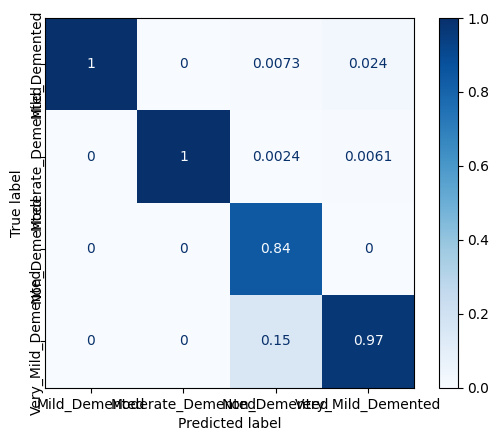

<Figure size 500x500 with 0 Axes>

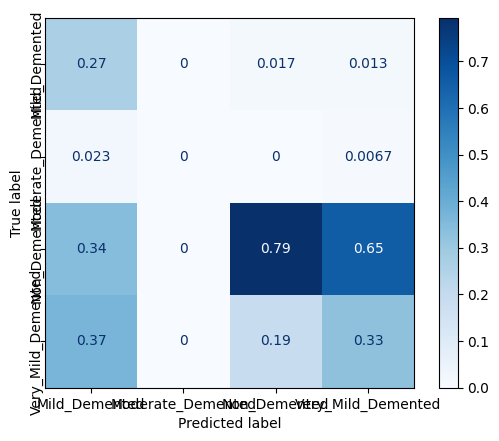

<Figure size 500x500 with 0 Axes>

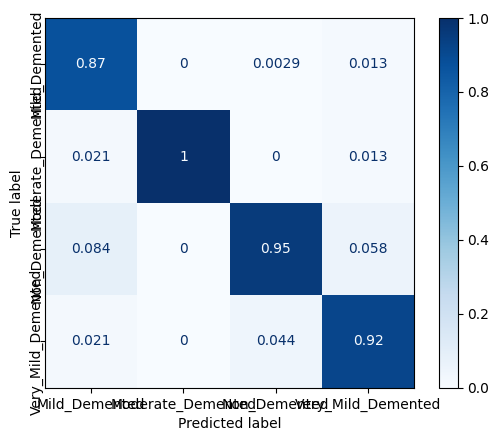

<Figure size 500x500 with 0 Axes>

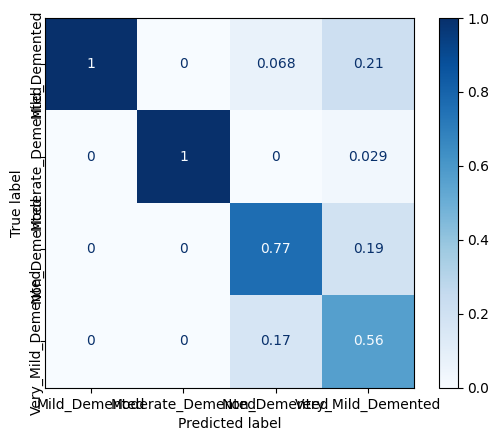

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ResNet50.zip ./*